In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
import seaborn as sns
import json
import matplotlib.pyplot as plt
from gensim import corpora, models
import pickle
import nltk

In [3]:
def load_json_to_df(datapass):
    data = [] 
    with open(datapass) as data_file: 
        for f in data_file:
            data.append(json.loads(f))
    df = pd.DataFrame(data)
    return df

In [4]:
business = load_json_to_df("../../../dataset/business.json")

In [5]:
review = load_json_to_df("../../../dataset/review.json")

In [99]:
by_city = business.groupby('city').size().reset_index(name='counts')

In [100]:
by_city.sort_values('counts',ascending=False)

city  counts
396           Las Vegas   24768
656             Phoenix   15656
909             Toronto   15483
136           Charlotte    7557
806          Scottsdale    7510
675          Pittsburgh    5688
526            Montréal    5175
491                Mesa    5146
317           Henderson    4130
900               Tempe    3949
131            Chandler    3649
226           Edinburgh    3625
153           Cleveland    2979
445             Madison    2891
286            Glendale    2841
280             Gilbert    2835
508         Mississauga    2316
880           Stuttgart    1975
647              Peoria    1527
453             Markham    1390
590     North Las Vegas    1254
128           Champaign    1084
601          North York     944
894            Surprise     934
792         Scarborough     870
709       Richmond Hill     770
159             Concord     726
292            Goodyear     703
79             Brampton     690
933             Vaughan     650
...                 ...     ...
394             Lambton       1
397      Las Vegas East       1
685          Portobello       1
711          Ridgeville       1
713             Rillton       1
741       Saint-Antoine       1
729             Russell       1
740       Saint Leonard       1
323          Hendserson       1
737          Saint Anns       1
736   Saint - Hyacinthe       1
336          Huntingdon       1
734               SLOAN       1
733       SCOTTSDALE AZ       1
732           S Concord       1
337           Huntsburg       1
730         Russell Twp       1
728         Rural Ridge       1
714    River Drive Park       1
727             Roxboro       1
341        Indian Land,       1
342        Indian Lands       1
344         Indian land       1
723              Roslin       1
345           Indianola       1
346           Inglewood       1
349              Ingram       1
718       Robinson Twp.       1
716       Robinson Town       1
1009     Île-des-Soeurs       1

[1010 rows x 2 columns]

## Overview:
Train the matrix of business subscores by minimizing a loss function for each restaurant, defined by sum((rec - rating)^2), where rec is (rating subscores dot user preference).

We obtain user preference by running an LDA on all the text reviews, that is, we are setting the preference column as a constant in the loss function. 

The weight for each topic is calculated by normalizing the sum of the probabilty that each word of one user's texts occurs in the topics generated by LDA on all reviews.

In [6]:
review.head(5)

business_id  cool        date  funny               review_id  \
0  uYHaNptLzDLoV_JZ_MuzUA     0  2016-07-12      0  VfBHSwC5Vz_pbFluy07i9Q   
1  uYHaNptLzDLoV_JZ_MuzUA     0  2016-10-02      0  3zRpneRKDsOPq92tq7ybAA   
2  uYHaNptLzDLoV_JZ_MuzUA     0  2015-09-17      0  ne5WhI1jUFOcRn-b-gAzHA   
3  uYHaNptLzDLoV_JZ_MuzUA     0  2016-08-21      0  llmdwOgDReucVoWEry61Lw   
4  uYHaNptLzDLoV_JZ_MuzUA     0  2013-11-20      0  DuffS87NaSMDmIfluvT83g   

   stars                                               text  useful  \
0      5  My girlfriend and I stayed here for 3 nights a...       0   
1      3  If you need an inexpensive place to stay for a...       0   
2      3  Mittlerweile gibt es in Edinburgh zwei Ableger...       0   
3      4  Location is everything and this hotel has it! ...       0   
4      5  gute lage im stadtzentrum. shoppingmeile und s...       0   

                  user_id  
0  cjpdDjZyprfyDG3RlkVG3w  
1  bjTcT8Ty4cJZhEOEo01FGA  
2  AXgRULmWcME7J6Ix3I--ww  
3  oU2SSOmsp_A8JYI7Z2JJ5w  
4  0xtbPEna2Kei11vsU-U2Mw

## Preprocessing:
0. Extract all the restaurant reviews.
1. tokenize
2. stop words
3. stemmize
4. get only nouns and adjs

In [6]:
is_rest = []
for i in business['categories']:
    
    if 'Restaurants' in i or 'Food' in i:
        is_rest.append(True)
    else:
        is_rest.append(False)
restaurants = business.loc[is_rest]
restaurants.shape

(65028, 15)

In [101]:
LV_restaurant = restaurants.loc[restaurants['city']=='Las Vegas']

In [104]:
LV_restaurant.shape

(7298, 15)

In [106]:
rest_id = LV_restaurant['business_id']
rest_review = review.loc[review['business_id'].isin(rest_id)]
rest_review.shape

(916554, 9)

In [8]:
#rest_review.to_csv("rest_review.csv", index=False)

In [34]:
#groupby_user = rest_review.groupby('user_id').size().reset_index(name='counts')

In [35]:
#groupby_user.sort_values('counts',ascending=False)

In [10]:
#preprocess
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')

from nltk.corpus import stopwords
en_stop = stopwords.words('english')

from nltk.stem.porter import PorterStemmer
p_stemmer = PorterStemmer()

def preprocess(text):
    raw = text.lower()
    tokens = tokenizer.tokenize(raw)
    
    pospeech=[]
    tag = nltk.pos_tag(tokens)
    for j in tag:
        if j[1] == 'NN' or j[1] == 'JJ':
            pospeech.append(j[0])
    # remove stop words from tokens
    stopped_tokens = [i for i in pospeech if not i in en_stop]
    
    # stem tokens
    stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
    
    # add tokens to list
    return stemmed_tokens



## Generating LDA 
For demo purpose, running LDA on only one user.

In [11]:
NUM_TOPICS = 120
from gensim import corpora, models


def getlda(df):
    texts = []
    for i in df['text']:
        texts.append(preprocess(i))
    # turn our tokenized documents into a id <-> term dictionary
    dictionary = corpora.Dictionary(texts)
    # convert tokenized documents into a document-term matrix
    corpus = [dictionary.doc2bow(text) for text in texts]
    # generate LDA model
    ldamodel = models.ldamodel.LdaModel(corpus, num_topics=NUM_TOPICS, id2word = dictionary, passes=20, eval_every=None)
    return ldamodel

## Calculate preference maxtrix
Add up the probabity that each word in the corpus in each topic, then add up for each topic and normalize.

In [78]:
def getprefer(userid, ldamodel, df):
    user_reviews = df.loc[df['user_id'] == userid]
    l = np.zeros(NUM_TOPICS)
    texts = []
    for t in user_reviews['text']:
        texts.append(preprocess(t))
    dictionary = corpora.Dictionary(texts)
    corpus = [dictionary.doc2bow(text) for text in texts]
    for i in ldamodel.get_document_topics(corpus):
        for topic in i:
            l[topic[0]] += topic[1]
    topic_likelihood = []
    sum_l = sum(l)
    if sum_l > 0:
        for i in l:
            topic_likelihood.append(i/sum(l))
    else:
        topic_likelihood = np.full(NUM_TOPICS, 1/NUM_TOPICS)
    return topic_likelihood

## Minimize loss function
<img src="formula.png">
Since we setting the topics for each user as constant, the corpus likelihood here is a constant so we only need to deal with rating error.

We used Sequential Least SQuares Programming (SLSQP) to minize the function.

Intial guess was randomized between 1.0 and 5.0

Might need to explore bias and hyperparameters in the future.

In [107]:
from scipy.optimize import minimize
def min_loss(raw_prefer, actual_rating):
    dim = NUM_TOPICS
    prefer = []
    for i in raw_prefer:
        prefer.append(np.asarray(i, dtype=np.float32))
    prefer = np.asarray(prefer)
    bound = []
    for i in range(0,dim):
        bound.append((1.0,5.0))
    bnds = tuple(bound)


    def f(x,prefer,actual_rating):

        return sum(abs(np.dot(x,np.transpose(prefer)) - actual_rating))
    initial_guess = [np.random.uniform(1.0,5.0,dim)]
    #initial_guess = np.full(5,2.5)
    result = minimize(f, initial_guess, args=(prefer,actual_rating), method='SLSQP', bounds=bnds, options={'disp': False, 'iprint': 1, 'eps': 1.4901161193847656e-08, 'maxiter': 1000, 'ftol': 1e-06})
    if result.success:
        fitted_params = result.x
        print ("param")
        print(fitted_params)
        print ("fun")
        print(result.fun)
        print(result.nit)
        return result
    else:
        return -1

## Combine everything
For each restaurant, run the algorithm to get the subscores, which will take a couple days on MacBook ~~Pro~~.

In [14]:
def add_prefer_to_df(df, lda, groupbyusers):
    d = {}
    new_df = df
    for u in groupbyusers['user_id']:
        d[u] = getprefer(u,lda,new_df)
    df['preference'] = df.apply(lambda x: d[x['user_id']],axis=1)
    return new_df

In [15]:
def train_rest_subscore(bizid, df):
    biz = df.loc[df['business_id'] == bizid]
    rating = biz['stars']
    preference = biz['preference']
    result = min_loss(preference.values, rating.values)
    return result.x

In [108]:
def add_subscore_to_df(df, groupbybiz):
    d = {}
    new_df = df
    counter = 0
    for u in groupbybiz['business_id']:
        counter +=1
        print (counter)
        d[u] = train_rest_subscore(u, df)
    df['subscore'] = df.apply(lambda x: d[x['business_id']],axis=1)
    return new_df

In [109]:
sample = rest_review.sample(50000)

In [110]:
sample_lda = getlda(sample)

In [111]:
groupby_user_sample = sample.groupby('user_id').size().reset_index(name='counts')

In [112]:
perfer_added_to_sample = add_prefer_to_df(sample, sample_lda, groupby_user_sample)

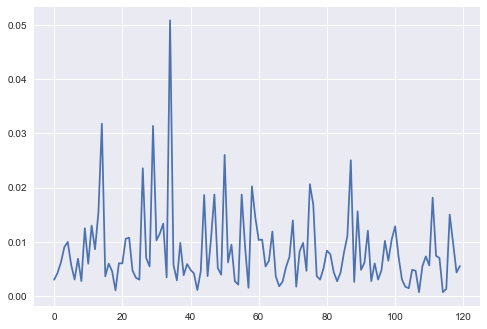

In [113]:
prefer_added_to_sample = perfer_added_to_sample
plt.plot(prefer_added_to_sample['preference'].iloc[1])

In [114]:
l = list(np.empty(NUM_TOPICS))
for i in prefer_added_to_sample['preference']:
    for p in range(len(i)):
        l[p] += i[p]
print (l)

[2.7802895488401917, 9.6353400490516172, 25.121464093995687, 97.211069490654907, 434.45063120261023, 83.741578285352119, 29.378139672045542, 184.51023150307563, 3.0348373250967624, 118.29824446145126, 25.495967957829883, 367.61507821935288, 2669.983196487126, 734.89074866322039, 171.37162825393642, 5.1728461249731224, 5.0704757379597734, 4.6252192853606227, 1.6736573059615674, 76.381329202770033, 4293.7091824121462, 1766.1934381465915, 53.125006821046334, 49.04045288267433, 3244.2370278082813, 5.5830448997977529, 335.17210240298095, 11.55473059439352, 52.563792401066038, 89.083778770760759, 11.167278466644357, 7.5934190187287394, 53.015278998374249, 2.6284203567883395, 4549.970091710954, 172.06708194109933, 9.4379142902649082, 35.095292614957657, 6.9407741365646585, 94.81483965637787, 4.7388212359065394, 54.803352550117083, 6.2560737941102946, 7.4512128318303317, 53.321026778984468, 17.069832744194805, 345.00619461581925, 359.18114953899709, 36.874861329520378, 40.31765358667775, 85.77

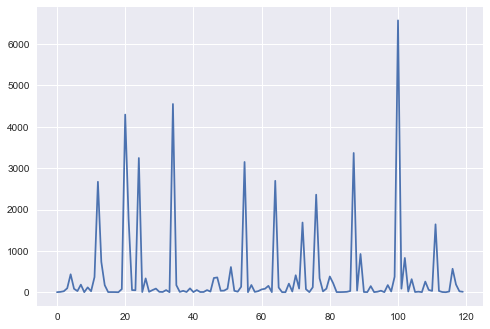

In [115]:
plt.plot(l)

In [118]:
groupby_rest_sample = sample.groupby('business_id').size().reset_index(name='counts')

In [119]:
subscore_added = add_subscore_to_df(prefer_added_to_sample, groupby_rest_sample)

1
param
[ 3.62892442  3.63429539  5.          5.          5.          5.          1.
  5.          4.19769358  5.          5.          1.          5.          1.
  1.          5.          5.          3.14154538  2.55705242  5.
  2.72687304  5.          5.          1.          3.63519067  5.          1.
  5.          1.          5.          5.          5.          5.
  3.05589005  3.44428471  5.          5.          5.          4.57239789
  5.          3.79237657  5.          5.          5.          5.          5.
  5.          5.          5.          5.          5.          5.          1.
  1.          1.          5.          2.42392017  4.84923695  5.          5.
  5.          1.          5.          3.36604686  2.99973067  5.          5.
  5.          2.71190192  1.          5.          5.          5.          5.
  3.34770474  5.          1.64713197  5.          5.          5.
  4.98193385  5.          4.2960192   5.          5.          1.          5.
  5.          5.          5.   

param
[ 3.85243564  2.78568747  4.71579878  3.232652    3.69668426  2.69075619
  1.33156749  4.6493655   4.99320938  2.92465177  1.16471119  1.74449838
  5.          3.41461048  1.73507988  1.38147572  1.19484664  4.53196519
  3.65528006  3.19655509  5.          5.          1.00180077  2.01262574
  5.          3.31071033  1.06997227  3.7021439   4.49414504  1.4864897
  4.63123709  2.31755071  3.00492575  3.89697586  2.62960491  3.81778688
  3.16083289  1.63771282  2.41914047  4.20526372  3.10176239  2.18889605
  4.79593716  2.85249491  3.31105227  2.22946675  3.77858277  3.13262643
  3.41713361  4.16770839  3.35919995  1.75233565  2.76406416  1.32028927
  1.82939578  4.99999973  2.12158382  1.93859788  2.45274054  4.0979246
  4.61678787  2.88433575  1.18888676  3.70781921  5.          3.65912559
  4.17362735  3.19580071  1.6268849   1.27294573  3.38814355  1.02122694
  5.          1.41761047  4.08390676  4.47757895  4.99999999  4.07336802
  1.09741683  1.85940125  4.73550418  1.3826028

param
[ 1.92765122  1.65763513  4.25332373  4.87479954  5.          1.31725252
  2.63225778  1.94762731  4.9964874   5.          3.45391798  5.          5.
  5.          4.63912553  2.4995691   4.10528933  2.58772273  2.11639236
  2.40250544  5.          5.          3.51483861  2.59922556  5.
  2.50579025  5.          3.24561195  3.5773375   4.45327715  4.35360391
  4.52515592  4.66861969  2.3184266   5.          5.          3.06193374
  1.59263295  1.32875784  4.83675069  4.8245524   1.75561561  4.38657419
  4.98815691  3.3087671   4.81331632  2.37889744  5.          2.66491063
  1.65281978  4.05807412  5.          1.53316697  4.69214668  3.94481149
  5.          3.58515507  5.          4.99660209  3.72912921  1.83292958
  2.61133622  5.          4.99124874  5.          5.          1.4225896
  2.3704992   5.          1.84202145  1.83558161  2.55951761  5.
  2.64617593  4.39800322  3.28248104  5.          5.          2.56495453
  1.16360732  5.          5.          4.96664506  1.149239

param
[ 1.01113462  3.72410737  5.          5.          5.          5.
  3.41784779  5.          2.32364792  5.          4.64817068  5.          5.
  5.          5.          1.59263327  1.73021922  1.71926586  1.69246287
  1.00466418  5.          5.          1.8718013   5.          5.
  2.02258259  5.          1.0016229   3.33363228  4.20841395  3.18483123
  1.51981654  5.          4.36928322  5.          5.          1.47902309
  5.          3.29463366  5.          4.40672325  5.          4.49780508
  3.11806605  4.99915454  2.60144192  5.          5.          5.          5.
  5.          5.          3.2723887   2.59935114  5.          5.
  2.45706413  5.          1.74529563  3.51300715  5.          5.          5.
  3.54834853  5.          5.          2.70769019  1.10397407  5.
  4.67082407  5.          5.          5.          5.          1.06832021
  1.34332596  5.          5.          2.82751534  5.          5.          5.
  1.47749553  3.12536873  3.56050715  2.53616716  4.65118977 

param
[ 2.4047994   3.85962206  3.19680291  2.02510796  5.          4.25961077
  1.22469498  2.25368933  1.86102812  5.          2.41301371  5.          1.
  5.          2.63219051  1.49149313  4.05126134  3.72635107  4.35452599
  3.11999318  5.          1.          4.30845078  3.98206885  5.          2.3330508
  1.          4.62798848  3.06419985  3.93868276  2.99682125  4.09496808
  1.30036188  3.22858991  4.77005377  5.          3.74188346  3.47957057
  1.78998918  5.          4.06010773  1.27695957  4.05245263  2.18543452
  3.4743784   4.42102253  5.          4.87981535  2.24238127  1.33309503
  3.82194786  2.03569033  3.93835917  3.27191508  5.          5.
  4.22904428  1.          3.64477298  2.59185084  4.1044508   3.9645004   5.
  2.32718792  5.          5.          2.59731894  1.92207136  1.
  1.83585919  4.37179572  3.07788191  1.          2.39197443  3.74859848
  3.70643587  5.          1.          2.98418958  4.43220591  4.60024486
  1.4005538   4.70355034  4.09945967  1.48

param
[ 1.          5.          5.          1.          1.          5.          1.
  1.          1.          5.          4.08754749  1.          4.68287     5.
  1.          1.          1.          1.          1.          1.          5.
  1.          5.          1.          2.79787702  5.          5.          1.
  1.          5.          5.          1.          5.          1.          5.
  5.          4.57049993  5.          4.36473069  4.7975105   1.          5.
  5.          1.          5.          5.          5.          5.
  4.99941925  1.          2.31659906  5.          1.          5.          1.
  5.          1.          1.          2.6658304   1.          1.51845545
  1.          5.          4.16979404  5.          1.          1.          1.
  5.          1.          1.34544296  5.          1.          5.          1.
  1.          1.          1.          5.          1.          5.          1.
  1.          1.          1.          1.00230729  1.          5.          5.
  5.     

param
[ 1.14996769  4.19898144  1.96658075  4.84880301  1.          1.714589
  3.1585209   5.          4.6768553   1.32079867  3.36727489  5.          5.
  1.          3.66437645  3.60441275  2.26116546  3.35820473  1.25717915
  2.3006489   5.          5.          5.          4.5371983   5.
  4.48779785  1.          2.74426912  3.68515087  3.24695796  4.1335923
  4.52153321  1.7398231   2.2406763   1.          2.53998547  1.25577368
  1.35317709  1.8072102   4.08478086  2.07628967  4.09736339  4.13196014
  4.09919295  4.61428555  1.06410621  1.26814641  5.          1.52938173
  1.32857914  3.87129595  1.          2.74402494  4.11994789  1.9268099   5.
  2.82628735  5.          4.46867118  2.77267977  4.46315256  3.55087096
  5.          3.11846828  5.          5.          1.75785085  2.86901647
  5.          3.92014678  4.80313211  5.          1.          2.90140335
  3.9353448   4.32463768  5.          1.          4.92256058  4.30062353
  1.          5.          4.45265227  2.22757635

param
[ 1.29617466  2.68486381  5.          5.          5.          5.
  1.00000044  4.99999572  1.63349969  5.          5.          1.          1.
  5.          1.          1.84958032  4.79132086  1.41830551  3.00620769
  1.          1.21258199  3.33682374  4.0535493   1.37293485  3.73873751
  3.54553468  1.          3.60495957  1.          1.00000033  2.06713578
  4.86565953  4.71634468  2.12979076  5.          1.          1.02013238
  3.9030726   1.49312721  4.69849347  1.82643537  5.          2.46689698
  4.19947194  4.98245483  1.00000049  5.          1.          3.33827259
  1.          5.          5.          1.          1.          1.          1.
  4.66623502  1.          4.6662839   1.          1.          1.0000006   1.
  4.81584712  3.04868933  1.          4.60074255  2.62664723  1.
  4.09625618  1.          1.          5.          1.          3.19858108
  1.          1.          5.          1.30122304  2.31343139  5.          1.
  1.35507162  4.70940697  3.07334845  1.21639

param
[ 4.4053233   1.56435267  2.27515302  1.          5.          1.
  3.09169998  1.          4.15003182  1.          3.23136785  5.          5.
  5.          2.53354359  1.21910975  3.97453477  4.9313448   4.53617296
  3.77227313  4.99962989  5.          1.          1.          5.
  1.24649348  1.          1.25240194  2.27194765  4.53136711  1.54707538
  4.59352326  1.          4.69825526  5.          1.          4.899903
  1.41203879  4.02093102  1.30338231  3.93179741  1.          3.65695446
  3.16757294  1.          3.46980805  1.          1.          2.03335092
  1.26679123  1.          1.          4.53154048  3.79852119  1.          1.
  3.67321098  1.          4.20170799  1.74048476  2.34749267  1.03770162
  1.          2.9594449   5.          1.          2.5565905   3.4959637   1.
  4.07368401  1.          1.          5.          1.          2.54920666
  5.          3.92140248  1.          1.98937175  1.11090928  2.70635305
  5.          4.88040758  2.81554982  4.95725231  4

param
[ 5.          5.          1.          5.          1.36011164  5.          1.7202521
  2.05120823  5.          5.          5.          5.          4.99999625
  1.          1.          5.          5.          5.          5.
  1.38974066  5.          5.          1.          1.          5.          5.
  1.          5.          1.          5.          5.          5.          5.
  5.          3.1925613   5.          3.81727957  1.          5.          1.
  5.          1.          1.          5.          1.          2.60870805
  5.          2.25748626  5.          5.          1.72546155  1.          5.
  1.          1.          5.          4.53226539  5.          5.          5.
  1.          1.          5.          5.          5.          2.11112352
  4.22472866  5.          5.          1.          1.          1.          5.
  2.83284991  5.          5.          5.          1.          1.          5.
  5.          4.59465994  5.          1.          5.          5.          5.
  5.      

param
[ 1.13709242  4.37470619  4.19585864  2.10052302  5.          1.40727299
  2.72404867  3.82539618  3.61370279  2.05975153  3.77649485  5.          5.
  5.          2.25738674  1.0238097   4.15258309  2.66985472  1.47305058
  1.57756398  5.          5.          1.18061514  2.65743651  5.
  3.33853753  3.69404936  3.84285379  4.72555265  4.16141414  3.50957456
  4.24244815  2.38294283  4.20441842  5.          1.          2.31845066
  1.12768629  4.16257181  2.08511433  3.61164491  1.90214513  2.45288198
  3.01148938  2.86430191  2.90666862  4.42561935  5.          4.91113932
  2.8204383   1.26573872  1.          2.49943387  2.19064365  4.54443382
  5.          4.05480605  3.27204455  4.83461843  1.63077394  2.06846574
  2.75987519  5.          3.5001081   4.99844029  3.62627426  1.60132211
  3.51147702  5.          3.19917907  4.20622539  2.2723369   4.07834603
  4.14309678  1.19831789  1.13005721  1.06772034  3.91916593  1.81825718
  2.55118241  5.          3.53507955  1.37972425 

param
[ 1.70729231  3.16684763  3.7604982   5.          5.          5.
  2.43922119  5.          3.04274898  3.68091972  4.87303003  5.          5.
  5.          1.          2.21742375  2.99465503  3.49724461  1.06277525
  2.50697452  5.          1.          5.          4.17858201  1.
  3.66814313  5.          1.4204746   2.28096776  3.02734369  1.60625325
  2.51088534  5.          2.78920463  5.          5.          3.1895809   5.
  2.12357983  1.          3.15205905  5.          3.79506093  1.21584949
  4.51953324  3.46811718  5.          5.          1.          2.67534231
  2.66422351  5.          2.29486955  3.49333567  1.          4.99967567
  2.50968321  5.          4.35075441  3.02662684  1.          1.          5.
  1.7552061   5.          5.          3.32340438  1.96333587  5.
  2.37344637  1.0000001   5.          4.00867784  1.          1.14242065
  5.          5.          1.          1.71864817  1.          1.          5.
  4.46741506  3.34770697  1.94799817  1.81409412  2.5

param
[ 4.55841439  1.          1.          1.          5.          1.          1.
  1.          4.96218893  5.          1.          5.          1.          5.
  1.          1.39922781  1.36604662  4.23513742  1.38570062  1.          1.
  5.          1.          1.          1.          1.84709814  1.13865501
  1.          1.          1.          1.74862866  1.          1.          4.0560695
  5.          5.          1.          1.          1.          1.          1.
  1.          1.          4.5169975   1.          1.          5.          1.
  1.          1.          1.          1.          1.          1.          1.
  1.          4.91536109  2.75248625  1.          1.          1.          1.
  5.          1.35610559  1.          5.          1.          3.60193493
  5.          1.          1.          1.          4.36449869  1.
  2.48499422  1.          1.          5.          1.          1.          5.
  5.          1.          1.          1.          2.92843657  1.81859138
  5.      

param
[ 3.85076981  4.53514127  1.          1.          1.          1.
  4.59531095  1.          2.52947851  1.          1.          1.          5.
  1.          1.          2.75638941  1.75228312  1.00158206  3.10704256
  1.65309966  5.          5.          4.32654203  1.90128057  5.
  1.82856039  1.          4.30860746  2.89450795  1.          3.69850704
  2.94298672  1.5991666   2.65850897  1.          1.          3.05931924
  1.04716825  4.4157262   1.          4.94878908  2.72018562  4.97002774
  2.64153182  1.00967985  1.25732341  1.          1.          1.          1.
  1.          1.          2.35080591  1.83578082  1.          5.
  1.36761414  1.23399717  1.17493761  4.73908485  4.28623434  1.          1.
  4.01390855  5.          1.          2.73200825  3.40701347  3.41273956
  4.83963614  1.          1.          1.          4.40451567  1.10295012
  1.32008134  5.          1.          1.75547948  1.          4.93096174
  1.          3.27427445  2.18907586  3.44376656  3.25029

param
[ 1.45665325  3.71583008  2.57282     1.          5.          1.
  4.54610618  1.          3.80414937  1.          4.77043513  5.          1.
  1.          2.21851982  4.32761375  3.0088211   2.13373243  2.37388762
  3.50030084  5.          2.99399987  2.45236905  1.          5.
  2.66207763  5.          1.03127083  4.0395648   1.97157836  2.39150824
  4.14519571  1.          1.46169321  5.          1.          4.92110531
  3.86133308  4.72426251  1.          2.0095917   1.          2.21905381
  4.09876767  1.          3.57687521  1.          1.          3.7987269   1.
  1.29487502  5.          2.83440671  1.81508554  1.          2.34567792
  4.95110115  5.          2.70880251  1.43660625  3.83023702  3.63735561
  1.          1.36818657  5.          1.          1.31924466  3.59130983
  5.          3.76522304  1.          1.          5.          1.
  4.05913111  5.          5.          5.          4.29380365  1.          5.
  5.          1.24463928  1.4357557   2.20603951  1.13859

param
[ 2.12790728  4.63636495  1.          1.          5.          1.          1.1628572
  1.          1.50969253  1.          1.          5.          1.
  1.93096427  1.          2.24428201  2.63224246  4.40546759  4.97294138
  3.22631668  1.          1.          1.          1.39054779  1.          3.4260528
  5.          4.82283895  4.15511439  1.          2.2274632   3.43289739
  1.          1.92568039  5.          1.          1.4422785   1.
  3.82611006  1.          3.13004105  1.07255518  2.06201246  3.49748628
  2.89296749  3.74050853  1.          1.44127468  1.          1.          1.
  1.          1.          2.64850203  1.72140535  1.84124304  1.2129531   5.
  2.00295541  2.36581444  1.          1.          5.          2.63210282
  1.          1.          3.59273486  4.37418576  5.          1.88110581
  1.          4.20571609  1.84457216  1.61390376  3.65789425  5.          5.
  3.52601754  1.99211155  1.          5.          5.          1.44026292
  1.51410626  3.2316535   3

7.718270467194088e-13
13
109
param
[ 1.03531994  1.          5.          5.          5.          5.          5.
  5.          1.          5.          1.          5.          5.          5.
  5.          1.          1.          1.          1.95393557  5.          5.
  5.          5.          5.          5.          1.          5.          1.
  5.          1.          5.          1.06178334  1.          1.          5.
  5.          5.          1.41181276  1.          5.          1.          5.
  5.          1.          5.          5.          5.          5.          5.
  1.          5.          5.          1.          5.          5.          5.
  1.          5.          1.          5.          5.          5.          5.
  1.          5.          5.          1.          1.          5.          5.
  5.          5.          5.          5.          1.          1.          5.
  5.          1.          5.          5.          5.          1.          5.
  1.          5.          1.          1.4

param
[ 1.76907316  1.          5.          1.          5.          5.          5.
  5.          2.40206646  1.          5.          5.          1.          5.
  5.          4.28107557  2.40019254  1.61597943  3.09041386  5.          5.
  1.          1.          1.          5.          3.23225671  4.97339098
  1.71271477  5.          5.          1.          1.          5.
  4.90676171  5.          5.          1.          5.          3.35231267
  4.81709788  2.37362867  5.          1.          1.77389286  5.
  4.92615968  1.          5.          5.          1.          5.          5.
  5.          5.          1.          2.97067233  3.93282624  5.
  3.74379328  4.00791497  1.          5.          5.          3.94368494
  4.13039582  5.          3.90909127  1.06519809  1.          5.
  2.62124061  5.          5.          1.          1.75319315  1.          5.
  5.          1.          5.          5.          5.          3.68743178
  1.          2.33985114  1.          5.          4.99999

param
[ 4.267132    1.3975576   1.8761344   5.          5.          5.
  1.74138558  5.          4.97021061  5.          2.99707796  5.          5.
  5.          2.7629377   1.41790522  1.51887251  1.58713286  4.38098034
  3.14276463  5.          5.          1.91161498  5.          5.
  2.83252336  5.          4.4412875   4.59870233  5.          3.008032
  4.32138616  5.          2.83194191  5.          5.          3.90338269
  5.          3.78529995  5.          1.07263258  5.          4.77517119
  1.57551934  5.          1.28617922  5.          5.          1.13734478
  5.          4.53826402  5.          1.48173922  3.1007938   4.99999999
  5.          2.51094884  5.          1.27151307  4.02277302  2.93153249
  5.          5.          2.02831641  5.          5.          2.84448787
  2.47429872  5.          1.27995085  5.          5.          5.          5.
  2.89393871  2.62547446  5.          5.          1.04220035  4.99999234
  5.          5.          3.34808531  3.76513437  3.058

param
[ 4.71475907  4.93269248  4.44342073  5.          1.          5.
  2.19779879  4.99934154  3.03628712  1.          2.34275336  1.          5.
  4.90353635  4.98736884  2.45813274  3.07740633  1.3288181   1.62933667
  4.76497996  5.          5.          3.53660078  5.          5.
  3.15872683  1.          1.27770509  4.99999907  4.76189075  3.74366384
  4.80190955  5.          4.59326816  4.99999993  5.          2.99684503
  5.          1.96327035  5.          4.96157835  5.          3.49783593
  1.0616918   5.          1.66779559  5.          5.          3.40227415
  5.          4.99795676  1.          3.32466573  2.10897636  5.          5.
  3.26835047  3.61237677  3.2665953   4.91494143  4.99950434  4.73843188
  5.          2.60967151  5.          5.          4.44121733  4.32644187
  1.          3.26757968  5.          1.          5.          5.
  3.38245577  4.92412007  5.          1.          2.79004486  5.          1.
  1.          4.02078801  1.35374924  4.98742075  3.60470

param
[ 2.31244445  4.97879932  2.69403539  5.          5.          3.56716626
  3.2696445   1.          1.71224949  1.          3.10940337  1.          1.
  1.          3.67894618  1.38062402  2.35088758  3.00283076  4.78253532
  4.86960244  5.          5.          1.          5.          5.
  4.63808187  5.          2.41684771  4.05684428  4.78369011  2.36154829
  3.59964086  4.02482019  1.44682753  5.          4.22115922  4.23162965
  3.42911571  4.93748127  5.          4.92832074  2.53369436  3.82089652
  2.92259593  3.64851272  2.92108279  1.          5.          1.54879059
  5.          3.00844729  2.26198199  3.72312712  3.09455721  5.          5.
  3.13043249  1.77810576  4.65592534  4.5295683   3.23885988  4.3004855   1.
  1.53543608  2.95393718  1.          3.17853478  3.83671553  2.52338629
  1.04172036  4.99999999  1.          5.          5.          3.85971596
  1.28243415  5.          5.          3.78825423  5.          5.          1.
  4.39168466  3.80763094  3.67155011 

param
[ 1.24966005  1.21310472  2.38319266  4.70374817  5.          4.7754781
  2.24865827  4.29803068  2.31539848  4.90823672  4.29115045  3.34066658
  5.          5.          4.68092686  4.0294236   4.55438446  3.31219442
  4.82393116  3.820702    5.          5.          2.26935121  2.34182173
  1.          1.15164432  1.          1.60448257  1.67672758  1.48025835
  4.22854686  2.46270808  3.6045606   4.70450375  5.          2.56792671
  3.10867391  3.6255863   2.98648811  4.5882281   2.01981821  1.68102095
  3.51880333  2.87773062  3.96274857  2.8310944   3.08919477  3.04085407
  3.06709441  1.22624473  1.81492807  1.14319493  3.58321948  4.76393889
  1.13980965  5.          2.9333426   2.91790377  2.04076263  4.44596887
  4.94483638  2.61313388  1.95675411  4.15412331  1.          1.43456073
  2.44758222  4.52997082  1.          4.06895567  1.13609747  3.34529898
  3.66031517  1.02844547  2.44693937  1.59081636  5.          1.
  4.57897202  1.8216225   5.          4.32590418  3.34

param
[ 2.98001035  1.82461337  5.          5.          5.          5.
  3.80745421  5.          1.          5.          5.          5.          5.
  5.          5.          1.00166052  3.28069333  2.77351248  1.96477275
  5.          5.          5.          1.          5.          5.
  2.73315003  5.          1.58108525  5.          5.          3.46661136
  1.66404729  5.          2.34596123  5.          5.          1.00391561
  5.          2.02111631  5.          2.44204223  5.          1.
  1.00151532  5.          4.15732812  5.          5.          5.          5.
  4.99999684  5.          5.          1.08363631  5.          5.          1.
  5.          1.00470443  2.66962086  5.          5.          5.          1.
  5.          5.          1.7054678   3.45581433  5.          5.          5.
  5.          5.          5.          2.15769224  1.          5.          5.
  1.97377549  5.          5.          5.          1.          1.00000101
  1.          2.90630964  5.          5.     

param
[ 3.91762073  3.1193712   4.77933982  4.33796513  5.          1.90735446
  1.3012766   3.32583434  3.80998323  2.38707885  1.27811178  3.6200732   5.
  5.          1.26988857  3.54236996  2.66624986  1.17174822  3.79084042
  1.36524449  5.          5.          2.44929352  1.59517102  5.
  4.52339855  1.          2.68157909  3.31472874  2.88159546  4.53730263
  1.33353948  1.07893528  3.80246749  5.          2.0120633   4.4291398
  1.54787944  2.01574537  2.48539892  2.6029571   1.31672663  1.9178699
  2.33441198  4.45605733  4.22281885  5.          3.39040346  2.33555698
  1.04015811  2.0330347   4.54566361  1.15385239  2.4659791   4.20520605
  5.          2.78089114  1.          3.30564514  2.72436787  3.73164812
  2.49908721  3.60494065  1.60481117  5.          1.55753875  3.42801909
  3.41004161  1.          2.56428017  2.301232    1.24271308  5.
  2.28991659  2.12740093  1.77406626  4.99999769  1.          2.51888985
  2.94300742  5.          4.19981392  4.76221489  2.6085199

param
[ 2.43125373  4.65894384  2.08741417  1.00116674  2.628302    1.70746346
  2.12901989  2.07818624  1.34003747  2.11374254  1.41414259  2.6167459
  4.30700113  3.02373465  3.06224239  2.68070398  1.58988044  4.30696554
  1.5186479   3.34090912  4.99915925  1.12699673  1.21851185  2.04737013
  3.01291936  4.26109207  4.60010264  2.75862385  2.7120627   1.68705898
  1.32218662  2.80868443  1.62029965  3.72124119  4.97257714  4.87201562
  4.7918772   3.28284978  2.1435221   2.57148692  1.41410098  3.16207142
  2.10077702  1.35618112  1.06055629  1.84710597  4.78814259  4.00698054
  2.7353986   2.05903683  3.58115249  2.21080736  1.02991792  4.63586899
  3.69093197  3.80029661  3.44900318  4.02486276  1.98438595  3.52853538
  2.06416651  2.57794769  2.70767791  2.33925654  1.93211587  1.36604919
  3.50362791  1.66622816  4.3486068   3.58058687  4.02585529  3.47924314
  2.7256746   4.59649664  3.30244903  2.51432593  4.99943932  1.72632201
  3.78080155  3.25407851  3.16946173  1.059208

param
[ 2.98526988  2.25092663  4.07123688  1.0389211   5.          1.41759142
  4.93393041  5.          3.94330239  1.          1.5772342   5.          1.
  1.          4.6645569   3.35348394  2.0352857   4.83862617  1.56091886
  3.28863823  2.96237434  4.07931798  4.27028974  1.          1.
  1.22328329  5.          4.4653238   3.87009265  3.10221987  4.24333319
  4.30760477  1.82032106  4.15221213  3.44971397  1.          1.14409042
  4.49643668  1.34725868  1.          4.90022141  4.06170275  4.33657204
  3.71653845  3.49669979  3.15708834  1.          5.          1.9447148
  2.4624396   4.87679377  5.          2.48720042  4.82179031  1.          5.
  4.9682345   5.          3.87549524  2.00687502  3.24577966  1.40949001
  1.          2.57995771  5.          1.          1.45254801  3.97341572
  5.          3.60708368  1.          5.          3.16815075  1.
  2.01494436  4.7538625   3.56989032  5.          4.35177359  1.          5.
  1.          1.46025784  4.357892    4.65856755  

param
[ 1.79654591  5.          1.          1.          1.          1.          5.
  1.          5.          5.          1.          1.01297746  4.0041845   5.
  5.          5.          5.          5.          5.          5.
  3.99740984  4.24839272  1.          5.          5.          5.          5.
  5.          5.          2.08440087  5.          4.72657143  5.          5.
  5.          1.          5.          1.          1.          5.          5.
  5.          2.21783668  5.          5.          5.          1.          5.
  5.          1.          5.          1.          5.          5.          5.
  3.53015249  5.          5.          5.          5.          5.          5.
  1.          5.          5.          1.          5.          1.15964938
  5.          5.          5.          5.          5.          5.          5.
  5.          2.20502747  5.          1.          5.          5.          1.
  5.          5.          5.          5.          5.          1.          5.
  5.     

param
[ 5.          5.          5.          5.          1.          5.          5.
  5.          5.          1.          5.          1.69772391  1.          1.
  5.          5.          5.          5.          5.          5.          1.
  5.          5.          5.          1.          5.          5.          5.
  5.          5.          5.          5.          5.          5.
  4.58188226  1.          5.          5.          5.          1.          5.
  5.          5.          5.          5.          5.          5.          5.
  5.          5.          5.          5.          5.          5.          1.
  1.          5.          5.          5.          5.          5.          5.
  5.          5.          1.          1.          5.          5.          1.
  4.36902022  1.          5.          5.          1.          5.          1.
  1.          1.          5.          1.          1.          1.          5.
  5.          5.          5.          5.          1.          5.          1.
  5. 

param
[ 3.83286372  2.46106988  2.36184915  1.05103323  1.96513659  1.00000008
  1.623542    3.69986103  3.78383994  2.67781527  2.09700014  2.35572628
  1.00000032  1.00000004  1.00000083  4.37974     3.8652238   3.2206284
  2.8068632   1.68804392  1.00000029  1.00000002  2.93406952  1.53517282
  2.60720074  2.84026808  1.00467835  1.00000019  3.79475777  1.00000059
  2.57334969  1.2203591   4.33731363  3.28678159  1.00000016  1.00000016
  3.52259349  4.62097883  3.61939986  2.98896458  4.09266278  4.0111501
  3.49407526  2.99030284  1.52865195  2.54953664  2.50676122  1.5324372
  2.61252807  1.69685156  1.59725433  1.00000019  1.00000009  2.34395096
  1.70382345  2.77293259  3.60266192  1.00000029  2.35941081  4.12204521
  3.52109534  2.84070897  2.2220249   2.15827005  1.00000019  3.18183893
  1.00000013  1.68786537  3.87129793  1.45237258  1.00000019  3.03134932
  3.75966898  2.52995854  4.71216663  1.00000049  1.38877339  3.35895615
  3.05681119  3.57144633  3.5593236   1.00000002

param
[ 2.28128824  4.20226885  1.60784489  1.22989935  1.0000015   4.18189331
  2.51096348  2.69629202  4.12570695  4.99999937  2.49896553  4.99999901
  1.          1.00000011  2.86853422  1.61351979  3.73497975  3.31528889
  3.43850135  2.0038312   1.          1.32452438  2.11141782  4.99999767
  1.          4.75873966  4.41772719  4.40381472  1.51547787  3.75967589
  3.00147912  1.89853632  4.63483488  2.73174921  1.0047897   4.99999868
  3.30249763  3.60138171  4.70132319  5.          1.92914471  4.70210087
  3.71044792  1.92153053  4.99999675  4.43911355  4.99999977  4.99999287
  3.80517691  4.97651216  1.26222107  1.          1.14891856  4.48358369
  5.          1.          3.92154114  4.95956332  4.59173563  3.0861512
  2.06261303  3.85157988  4.99999995  3.84758222  1.          4.99999679
  3.26916112  4.872153    4.98598631  3.70797252  4.99999717  2.47996301
  3.04225556  5.          3.12823631  4.16962589  5.          4.96727
  3.90832928  3.68146422  1.00000161  4.99999998 

param
[ 2.44479248  2.72201265  3.15094404  4.96599904  1.          2.30883705
  2.87394134  5.          4.22093051  5.          2.9970026   5.          5.
  2.78811188  4.56994476  3.05574147  2.23647548  3.349867    4.44984951
  1.59812456  4.27511227  5.          5.          4.99881618  1.00000007
  4.09670363  5.          1.40012182  4.76359336  5.          3.36702646
  1.81358237  2.39392867  3.20652075  2.44667502  5.          2.94935835
  4.02501449  4.85174549  5.          2.27363976  1.00000168  2.76633227
  1.24774636  4.4017826   1.90350329  5.          5.          4.60679699
  1.          5.          1.          4.99093403  3.85306205  4.98943245
  4.99975063  4.24090273  5.          3.50115205  4.54472993  5.          5.
  5.          3.71249801  5.          5.          3.07663735  1.04680947
  4.99965574  2.20934857  1.00140054  5.          5.          4.8614043
  2.52408729  5.          4.82570093  1.          3.47744309  4.87429167
  1.          5.          4.27074573  

param
[ 4.98692817  3.41190089  4.88731781  2.3307652   1.          3.63141198
  3.38493829  2.21508495  4.89780007  5.          1.57242682  5.          1.
  5.          4.9644882   2.25270202  4.74056601  2.92425106  4.20050509
  2.5142135   5.          1.          1.93869509  3.93036918  1.
  4.33428712  4.6796134   1.46858815  2.06333418  4.92020286  4.31980326
  4.29876142  4.56058942  2.60620494  2.19920301  1.          1.52054324
  4.09394116  3.58875201  5.          4.61373613  2.09125399  2.12488663
  4.2513644   1.32369067  2.30400739  5.          5.          1.65118811
  3.89532605  1.52562905  1.          1.64725866  4.15863814  5.          5.
  1.82824133  1.          3.79013404  4.06627438  1.86615075  4.14441493
  1.          4.89283788  1.          1.          2.36813782  3.34603706
  2.79134448  3.39020799  2.99315241  1.          5.          4.9603917
  2.56421258  1.34787848  1.          5.          1.21896348  3.29063625
  1.          5.          2.70391167  3.311088

param
[ 2.49787743  5.          5.          5.          5.          5.          5.
  5.          4.45390503  5.          5.          5.          4.99570192
  5.          5.          2.05784658  4.78211161  3.0713007   2.83322651
  5.          1.          1.          5.          5.          5.
  4.81255879  5.          1.15266007  5.          5.          5.
  1.19188554  5.          1.7060806   5.          5.          5.          5.
  1.83788131  5.          4.91578882  5.          5.          1.97665014
  5.          5.          5.          5.          5.          5.          5.
  5.          5.          5.          5.          5.          4.77944613
  5.          2.48352476  5.          5.          5.          5.
  3.36655604  5.          5.          3.47208461  3.50722818  5.          5.
  5.          5.          5.          5.          2.19405093  5.          5.
  5.          5.          5.          5.          5.          4.98955689
  2.1228994   4.87644376  5.          5.         

param
[ 2.27757452  5.          5.          1.          5.          1.          5.
  5.          3.71585908  5.          5.          5.          5.          1.
  5.          1.          1.          2.58789185  3.68172537  5.          5.
  5.          1.          1.          4.5185215   1.          1.          1.
  5.          1.          1.          2.72050345  1.          4.95260289
  5.          5.          1.          1.          1.          5.          1.
  1.          4.23036034  1.          5.          5.          5.          5.
  5.          1.          5.          5.          1.          5.          5.
  5.          2.22390637  1.          1.          5.          5.          1.
  5.          1.          5.          5.          1.          1.          5.
  1.          1.          5.          1.          5.          4.13706773
  1.          5.          5.          5.          5.          1.96355842
  5.          1.          5.          1.          5.          5.          1.
  5. 

param
[ 4.88532534  1.74852171  3.92046921  4.00603004  1.          1.11588225
  2.55358776  1.28797928  2.48989348  4.2719081   3.0274098   1.
  1.47489023  1.          1.8622439   1.07725974  2.45271759  1.08919002
  4.81867015  3.54578131  1.          1.          3.94253352  2.53319174
  1.          3.07009166  1.          4.51342761  1.40724354  1.80111663
  3.99302537  4.84265986  1.78292224  2.29934707  3.02565575  2.15034151
  2.02349017  3.3201113   4.45241886  2.38845459  4.19252564  4.68495323
  4.53689384  4.71662985  1.25868606  2.55090623  1.20124633  1.35865537
  4.89906447  3.22737316  1.092928    1.          2.60762344  3.76541506
  3.32310999  1.          2.20452004  1.          1.3616303   3.71166627
  3.24873597  4.61671872  4.36108877  4.36755492  1.          3.4481475
  3.85864102  1.44750123  1.          1.32471749  2.83597482  2.67330883
  5.          4.77601366  3.69147414  4.89626799  1.          1.
  1.38515821  1.26385275  1.          1.          1.31901532  

param
[ 4.23060328  1.          5.          5.          5.          5.          1.
  5.          1.61678549  5.          5.          1.          4.34066023
  5.          5.          1.          1.          3.17500153  1.88669088
  5.          1.          5.          1.          1.          1.          1.
  1.          1.          1.          1.          1.00012422  1.          1.
  4.55370019  5.          4.96627052  1.          1.          1.          1.
  3.66468537  1.          1.          4.79932211  5.          5.          5.
  5.          5.          5.          1.          1.          5.          1.
  1.          5.          2.32008012  5.          1.          5.          5.
  1.          5.          1.          1.          5.          2.68992495
  4.36174211  4.62679107  1.          5.          5.          5.          5.
  1.          1.          5.          1.          1.          4.99232368
  5.          5.          1.          1.          2.41574962  1.          5.
  1.     

param
[ 2.77779937  2.88109675  1.          1.          4.01499636  1.          1.
  1.          2.29049753  5.          1.          3.84042951  1.          5.
  1.          1.67844217  3.33128271  4.06089275  3.90167803  1.          5.
  1.          1.          1.          5.          3.92795931  5.
  2.54832567  1.          1.          1.22782514  1.86911004  1.
  3.48332136  5.          5.          2.82856755  5.          3.09431267
  1.          1.44276186  1.          4.52181656  3.79200851  5.          1.
  1.          1.          1.          5.          1.          1.          1.
  1.          5.          1.          3.88967666  5.          4.23750088
  1.          1.          1.          1.          4.53886734  5.          1.
  4.90045654  1.10888742  5.          1.          3.0499506   1.          5.
  1.          1.51670731  4.70398596  5.          1.          4.06640967
  1.          1.          5.          4.34446205  3.3947584   1.78760579
  4.2286788   1.          5.     

param
[ 2.38264221  2.83258348  3.88059944  1.22800999  5.          1.80733983
  3.56703042  1.          2.97639226  2.79220419  4.11864888  5.          5.
  4.99999781  1.          1.55603269  1.69708038  3.60293375  2.65824862
  3.89839402  5.          1.98692256  1.00533597  4.89636863  5.          3.1650503
  5.          1.          1.00269336  1.          3.83246648  3.32084533
  3.53092577  1.20885555  5.          1.37791295  3.03969117  2.44358265
  1.94430798  2.9773464   2.51651566  4.27879458  1.93465184  1.95261253
  3.29294834  2.4896964   1.00000005  1.88404988  1.10104802  4.2474926   1.
  5.          2.20234178  2.45249884  2.74169342  5.          2.11271241
  5.          1.11355932  1.58769162  1.76907496  2.15150647  3.25132699
  3.89577135  5.          3.4801534   3.16532502  4.2571562   5.
  3.62463805  1.          2.74048309  5.          1.00000001  2.34339816
  1.          5.          5.          1.86536975  4.72339061  5.          1.
  2.90764842  1.68324066  3.47

param
[ 1.          1.          1.          1.          1.          2.51659006
  5.          5.          1.          2.48094916  1.          5.          5.
  1.          1.          1.          1.          1.          1.          5.
  5.          4.39433358  1.          5.          5.          1.          5.
  1.          1.          1.          1.          1.          1.          1.
  1.          5.          1.          5.          1.          5.          1.
  5.          1.          1.          5.          1.          5.          5.
  1.          1.          1.          1.          1.          1.          5.
  5.          1.          5.          1.          1.54106314  4.36338746
  5.          5.          1.          5.          5.          1.          1.
  5.          2.36083559  5.          1.518113    5.          5.          1.
  5.          5.          5.          1.          5.          5.          5.
  1.          1.          1.          1.0000802   1.          5.          5.
 

param
[ 4.37730894  3.34357712  1.29847306  2.75030051  1.          2.02273154
  3.97318776  2.64288379  2.40053806  2.26886501  2.84155632  1.          1.
  1.          3.30414253  4.3792913   2.29449531  1.22472799  3.75334571
  4.27870662  1.          1.          1.19683948  4.58059547  1.
  3.10395258  1.          4.13419311  4.18487004  3.58128225  1.39132308
  3.6512344   4.0463476   1.94437665  1.          1.          3.51363467
  1.70077175  1.84165418  4.94073447  4.82349341  1.89179347  2.3254189
  4.04031417  4.92066138  4.00123634  2.65037876  1.          2.93415063
  4.03174616  2.15142351  1.          2.03357724  1.30001423  3.96296032
  1.          1.95248978  1.          3.04811771  4.45554508  1.95300766
  4.37819168  1.          3.01861206  1.          1.          3.4235073
  1.90812967  1.          2.29914782  3.89182771  2.45219235  1.
  2.74790337  2.03007952  2.98065628  1.          1.          1.08354259
  4.00631567  1.          1.          1.36709779  4.8714464

param
[ 5.          1.          5.          5.          1.          5.          5.
  5.          5.          5.          5.          5.          5.          1.
  5.          5.          5.          5.          5.          5.          4.9700154
  5.          5.          5.          5.          5.          5.          5.
  5.          5.          5.          5.          5.          5.
  2.78169531  5.          5.          5.          5.          5.          5.
  1.00000029  5.          5.          5.          1.          5.          5.
  5.          5.          5.          1.          5.          1.          5.
  5.          5.          5.          5.          1.          5.          5.
  5.          5.          5.          5.          5.          4.74696873
  1.          1.          4.63030879  5.          1.          5.          5.
  5.          5.          1.          5.          5.          1.          5.
  5.          5.          5.          5.          5.          1.          5.
  

param
[ 2.93981815  1.24431987  4.0023625   4.99999944  5.          5.          5.
  5.          3.8869068   5.          4.52720811  5.          5.          5.
  4.99999999  3.75704709  2.09198561  2.14095179  1.36266971  4.99999992
  5.          5.          1.24857386  5.          5.          4.58663053
  5.          2.06995393  4.99999991  3.69797677  4.56302855  3.62183747
  3.40573816  1.32698743  5.          5.          3.57250631  2.50575466
  1.69243836  4.99999963  1.19831364  4.99999995  4.10958213  4.19756945
  3.69889971  4.01017326  5.          5.          4.99999996  5.
  4.99999941  4.99999999  1.44197161  2.74028278  4.99999999  5.
  4.12701011  5.          1.46763297  1.24340192  4.9999992   5.          5.
  4.85999389  5.          5.          3.74361025  3.74159873  5.
  4.99999994  5.          4.99913201  5.          4.99999906  2.99105335
  3.26789699  5.          5.          1.40831816  4.99999879  5.          5.
  1.35976555  1.93793777  4.30380364  3.25501395  4.9

param
[ 1.          1.          1.          1.          5.          1.          1.
  1.          1.          1.          1.          5.          5.          5.
  1.          1.          1.          1.          1.          1.          5.
  5.          1.          1.          5.          1.          1.          1.
  1.          1.          1.          1.          1.          1.          5.
  1.          1.          1.          2.05617658  1.          1.          1.
  1.          1.          1.          1.          1.          1.          1.
  1.          1.          5.          1.          1.          1.          5.
  1.          5.          1.          1.          1.          1.          1.
  1.          1.          1.          1.          1.          5.          1.
  1.          1.          5.          1.          1.          1.          5.
  5.          1.          1.          5.          5.          1.          1.
  1.          1.          1.          1.99585062  1.          5.      

param
[ 3.93550409  1.22573455  3.60471109  1.48845682  5.          1.86839406
  2.82953662  5.          2.47440813  1.          3.71675917  5.          5.
  5.          4.83671383  3.85143474  2.44756889  1.66182948  4.76375361
  4.5573352   5.          1.          1.0078189   5.          5.
  3.47641265  5.          2.28566517  2.16753598  1.74014909  4.72544335
  3.20285157  2.72678941  1.85681638  5.          5.          1.45770276
  3.33777767  2.0808196   1.          2.45282809  1.19077584  3.77805111
  3.74113598  2.28448677  4.41773986  1.          5.          2.23440431
  2.5728783   1.22356925  5.          2.96893306  1.16330748  5.          5.
  2.00175542  5.          4.22089965  4.16099801  3.32190532  4.71737806
  1.          4.27104624  5.          1.          3.51057337  2.21237497
  5.          3.80838389  5.          5.          5.          5.
  2.97807662  4.54621767  5.          5.          4.38287869  5.          5.
  5.          2.92597411  2.34663481  3.95053439 

param
[ 2.07405636  4.81826593  2.5621614   3.15051017  5.          2.10053494
  4.73914054  2.10534051  3.91586185  1.36595622  4.41628886  5.          5.
  5.          2.51284731  4.84978979  2.23071619  3.15504658  3.94205901
  2.02024867  5.          1.39067481  3.47480339  1.01921748  5.
  4.22582403  5.          1.84301555  2.97473584  2.54782625  4.39503496
  4.38702535  3.96054702  1.93478849  5.          5.          3.39235903
  3.57210971  3.99655721  2.04225834  2.02819675  4.80622985  4.52263853
  1.55591151  2.18573896  3.50021981  1.44647211  4.99999943  4.97630812
  1.20636586  2.24436111  5.          4.89938166  2.48708113  4.0739116   5.
  3.53942946  5.          4.42070313  1.2822622   2.61804587  4.10086533
  4.99999932  4.85630054  5.          4.99999974  3.49252464  4.15079505
  5.          3.83661762  3.48606894  5.          5.          1.80432395
  3.3220529   3.7224512   5.          5.          3.80717893  2.1738118   5.
  5.          1.47440033  1.9463639   3.9

param
[ 3.80046573  2.33922764  5.          4.71005434  5.          1.
  1.00449977  4.23859862  4.65888646  5.          4.47975049  5.          5.
  1.          5.          1.44616073  2.05363824  3.25579685  1.49717094
  5.          5.          1.          1.          1.          5.
  2.32169437  1.71679301  1.          3.75981825  1.          1.0941871   1.
  1.          1.16498815  1.          5.          4.10593258  2.92760757
  1.          3.70909613  2.12703901  3.8269128   1.38001316  3.7054675
  1.61949682  1.29417239  5.          5.          1.9996685   3.84989107
  1.          4.9234429   4.96772442  3.42540078  5.          5.
  1.16877893  4.74860253  1.          1.06685578  5.          5.
  4.99999773  1.          5.          2.89352346  1.80034107  4.86771008
  1.          3.78431936  5.          1.29760851  5.          5.          1.4971804
  1.          1.          4.64739844  2.52434738  5.          3.44498387
  5.          2.87965575  1.          2.51141965  1.       

param
[ 3.70430164  3.15271296  1.31261642  1.42678398  1.          3.49346519
  3.31363385  1.          3.32818784  1.          3.08429178  1.          1.
  1.          3.9112332   1.37392873  1.30591059  1.41724649  2.33533393
  2.9373038   1.          1.          3.61394245  3.55462188  1.
  4.62904272  1.          1.35574389  1.86087327  1.35057991  1.20266261
  2.49712251  3.65054222  1.10504756  1.          1.          3.04488135
  1.35071615  3.79109687  1.          3.78186506  4.32143308  1.15038988
  3.59230175  1.29716743  3.12575297  1.          1.          4.67634818
  4.21487826  2.06319368  1.          4.60089458  2.80740825  2.42967212
  1.          1.531374    1.          1.69845101  3.54325655  2.91699922
  4.24598279  1.          2.00802409  1.          1.          4.31409969
  1.51867846  1.          3.78017009  2.41353703  1.          1.
  2.92687505  1.17382052  1.40851675  1.          1.          2.07584184
  1.22573379  1.          1.          2.68019987  3.35187

param
[ 1.45355059  4.08979947  1.          1.          1.          1.
  4.43679684  4.36099315  4.80920259  1.          1.          1.          1.
  1.          3.45562523  4.34991227  3.02355711  1.07808081  4.41171358
  3.2750004   1.          1.          2.8248913   1.          1.
  4.73820904  1.          3.31824853  2.31865207  1.          1.34526463
  2.81276116  1.          1.83513698  1.          1.          3.70020389
  1.          1.85533265  1.          4.42186344  1.          2.80276707
  2.52948251  1.          2.68777995  1.          1.          2.54826503
  1.          1.          1.          2.22798541  1.65065702  1.          1.
  3.00199995  1.          4.09594572  2.8447852   4.74686534  1.          1.
  2.10079048  1.          1.          1.78515149  3.06400762  1.
  1.08765407  1.          4.94160284  1.          1.          4.26059148
  2.77891537  1.          1.          4.97352164  1.          1.          1.
  2.31545762  2.91214667  4.47431135  2.27515378  1. 

  4.67690744  3.40638767  1.28241689  4.96945562  3.89332284]
fun
0.008123545047259206
21
311
param
[ 2.6417166   2.53487071  4.72799227  4.7573776   5.          2.81875493
  4.54159741  1.13059103  2.68668901  5.          2.94278019  5.          5.
  5.          1.80581417  2.07859662  3.69699875  3.32418714  1.48237523
  2.46696909  5.          5.          1.90014278  1.92497871  5.
  3.06742894  5.          3.02116021  1.70001374  4.28752481  1.81382853
  2.98392059  4.70513874  1.20508933  5.          5.          4.21591157
  3.79001765  4.96105785  5.          3.41137128  3.24926951  2.67555992
  3.19882776  3.19775211  3.3020243   5.          5.          3.56035247
  3.32919679  4.20057223  5.          4.30453754  4.85303365  1.13134175
  5.          4.86098146  5.          1.92096739  1.36180913  2.60749098
  2.73381382  5.          1.51153423  5.          5.          1.20351631
  3.60723115  2.23484942  2.78645026  2.78700092  3.92584237  1.
  3.42833123  4.80080376  5.        

param
[ 2.8969446   2.84737557  5.          5.          5.          5.
  1.86199081  4.16405139  2.17186214  5.          5.          5.          1.
  1.          4.41429961  4.08377088  2.32672422  1.5724849   3.98752545
  4.67105407  1.          1.          3.91446695  5.          1.
  3.34484541  5.          4.07196453  1.09935428  5.          1.30555203
  3.58906274  5.          4.18784328  1.          5.          2.75609618
  5.          3.98807739  5.          3.55427419  5.          3.44534572
  1.42057607  5.          2.03366195  5.          5.          4.55477087
  5.          5.          5.          2.82813343  1.83257168  5.          1.
  3.29098105  5.          2.12121162  4.16455512  4.5228962   5.          5.
  3.67391568  1.          5.          4.51891924  2.78131602  5.
  2.88471795  5.          4.94212412  1.          5.          2.84933449
  1.77330293  1.          5.          2.99708408  5.          5.          5.
  2.18157155  4.42385059  3.35420636  2.69202516  2.4

param
[ 1.42214998  4.81419702  3.94673999  1.39852111  1.          3.46315523
  1.89820779  1.73500265  1.77077181  3.36553466  3.41144424  1.          5.
  1.          2.65810266  2.64911401  1.57647284  4.67261058  3.08688878
  1.78325157  5.          1.          4.29182128  1.45131106  5.
  4.52410885  1.          2.49383455  2.92518311  4.80744051  1.85040569
  2.16464048  2.29582905  2.34392347  1.          1.          4.09056301
  3.56974652  3.23997534  4.94337551  2.48998097  2.86196916  2.73197182
  2.65560427  2.26536834  2.87811294  4.37260513  1.          2.3009721
  1.46066901  2.68821919  1.          4.03140955  3.76381107  1.07945165
  5.          2.86296346  1.          3.03070656  2.11626002  3.21352942
  4.36761363  1.          2.28715393  5.          1.          3.49045867
  4.26532937  1.          4.99354655  3.90737757  3.98661623  1.
  1.65569658  2.15371912  4.77746491  5.          1.          1.68086041
  3.67289359  1.          2.79313153  3.14618643  2.163849

param
[ 5.          1.          1.          1.          5.          5.          1.
  1.          5.          5.          4.99947359  5.          5.          1.
  1.          5.          5.          5.          5.          5.          1.
  1.          5.          5.          5.          5.          5.          5.
  2.90462585  1.          5.          2.60551083  1.          5.          5.
  1.          5.          4.99931381  1.02079479  5.          5.          1.
  2.71910578  5.          5.          2.91944771  5.          1.          5.
  5.          1.          5.          1.          5.          5.          5.
  5.          5.          5.          5.          1.          5.          5.
  5.          5.          1.          5.          5.          5.          5.
  1.          1.          5.          1.          5.          1.          5.
  5.          3.7974313   4.98113824  5.          5.          5.
  3.89314401  5.          1.          5.          5.          5.          5.
  5. 

param
[ 2.9264123   2.6784209   3.96432399  1.02312205  1.0000089   1.00000066
  4.41806884  1.73565999  3.16431188  1.00000116  3.47878642  1.0071898   5.
  1.          1.00000012  2.409301    4.35568201  3.56586126  3.61959963
  3.13104844  5.          1.00000283  4.40602222  1.00000009  4.99997916
  3.76492848  3.13320398  3.35055722  4.3088733   4.88498583  4.36492495
  2.29942299  4.82089946  4.4047615   3.37498021  1.00000221  4.99999956
  2.51563254  3.5525491   2.52452492  2.97636834  1.88397793  3.57300833
  4.69775306  3.74200516  4.37587415  1.00000061  1.00000292  1.59974263
  1.00117337  3.4771029   1.00000036  2.6035342   3.91032422  1.00740861
  5.          4.0162344   3.28376595  3.55100528  1.78436353  1.00000009
  2.81892668  1.01206472  4.63306299  5.          3.83904531  2.89441393
  1.31905492  1.71502864  1.54074346  1.00000799  2.32397928  1.42501277
  2.22944459  3.27415456  5.          5.          3.76558514  4.68133715
  1.00000008  1.00000286  1.0713152   4.9

345
param
[ 3.38116461  1.01595223  3.71879603  4.79510863  4.60616964  3.3811004
  3.18590931  4.06130454  3.04265268  3.37249559  1.00169489  4.46671569
  5.          1.90562966  2.92762668  2.23399357  1.12125919  3.61794286
  3.37746811  3.88812413  4.46294214  4.05556919  2.51561506  3.29534484
  3.04298444  4.61697456  1.93730227  2.12457348  1.1121913   3.8138969
  4.76339062  1.08374091  4.19520491  4.11127461  2.51271031  2.72767721
  3.27944752  3.32250437  3.59848159  3.26046691  1.72940476  1.20581354
  2.33890789  1.32844186  2.98113009  3.43016523  4.32495552  4.14710365
  1.560961    3.65246989  1.76318169  1.86811443  3.00807017  3.52802009
  3.65296535  4.7567564   3.06985444  4.18918778  2.60223881  4.96490291
  1.7587953   1.4735748   2.73382371  4.96584986  3.094455    4.87708755
  3.67538988  2.32550609  1.37580005  1.52600835  1.66194975  1.90618417
  4.16308042  4.83689591  1.23681906  1.36538068  1.79093579  4.50017589
  4.67327431  3.05222609  1.98251665  3.550

param
[ 3.11757597  2.8255556   2.88495912  5.          5.          5.          5.
  5.          4.67948821  5.          2.6526014   5.          5.          5.
  5.          3.55917866  3.44567027  3.33856521  3.72193897  5.          5.
  5.          5.          5.          5.          3.84091223  5.
  3.36438947  5.          5.          3.41650102  2.82732208  5.
  4.21868582  5.          5.          4.41332832  5.          1.68847557
  5.          3.6016572   5.          1.08018452  4.37125762  5.
  2.25438745  5.          5.          5.          5.          5.          5.
  5.          4.11135414  5.          5.          2.41668674  4.99999776
  2.59235644  5.          5.          5.          5.          2.14563002
  5.          5.          2.80112469  2.53275269  5.          5.          5.
  1.59811386  5.          5.          4.58798116  1.72473674  5.          5.
  1.32959199  5.          5.          5.          3.96082638  1.0763359
  2.17435606  5.          5.          5.      

param
[ 5.          5.          5.          5.          1.          5.          5.
  5.          5.          5.          5.          5.          4.7407794   5.
  5.          5.          5.          5.          5.          5.          5.
  1.          5.          1.          3.95433168  1.          5.          5.
  5.          5.          4.99921509  1.          1.          5.
  4.81683858  5.          5.          1.          4.54148537  5.          5.
  5.          1.          5.          5.          1.          5.          5.
  5.          5.          1.          1.          5.          5.          5.
  1.          5.          5.          5.          5.          5.          5.
  5.          1.94913375  5.          1.          2.40796532  2.14794989
  5.          5.          5.          5.          1.          5.
  1.54048416  5.          5.          5.          5.          5.          1.
  5.          1.          5.          4.99755177  5.          5.          5.
  5.          5.     

param
[ 4.01263998  2.07110208  4.03631841  1.02411379  2.61811284  1.89252484
  2.10031445  4.42460126  4.90978784  3.29904552  2.53484265  3.70841746
  4.62730321  3.13627348  4.00303911  2.59278594  4.77995715  3.81015893
  1.12434791  4.13693314  5.          3.47137105  3.20847303  4.93593204
  4.4830258   4.36325926  3.94893508  1.4279365   3.57764656  4.37389547
  1.7048683   1.66663196  2.29718866  3.82638187  3.70493911  4.69419989
  2.71564457  1.400662    2.04991454  4.76140778  3.19736495  3.3668037
  4.26473562  1.62945024  1.66178343  3.78754333  1.23263598  1.38739379
  3.71333817  3.36443277  1.73558125  4.99716125  4.91848286  2.75378086
  3.62945315  4.59944761  3.26535122  4.09153312  2.61135036  1.68857408
  1.0665798   3.77825211  4.16934376  1.95719261  2.08213646  2.87068022
  3.05524755  4.82442917  1.03087697  3.23782441  1.98890854  1.85198348
  4.79270886  1.29461241  4.80773536  4.01106022  4.60202211  3.79834676
  3.87229622  1.60860228  2.11008185  3.706359

param
[ 5.          5.          1.          1.          5.          1.          5.
  1.          5.          1.          1.          5.          5.          5.
  5.          4.2961124   5.          5.          5.          5.          5.
  1.          5.          1.          5.          5.          5.          5.
  5.          5.          5.          5.          1.75321785  5.          1.
  1.          5.          1.          5.          1.          5.          5.
  5.          5.          3.00497446  5.          1.          1.          5.
  1.          5.          5.          5.          5.          1.          5.
  5.          5.          5.          5.          1.          5.          1.
  4.48033205  4.99908464  5.          3.43698504  5.          5.          5.
  1.          5.          1.          1.          5.          5.          1.
  5.          5.          1.          5.          1.          5.          5.
  5.          5.          5.          5.          3.83569842  5.      

param
[ 2.15638636  1.          1.          1.          1.          1.          5.
  1.          2.50060438  5.          1.          5.          5.          5.
  4.69743979  5.          5.          1.50131313  2.56218058  1.          1.
  1.          1.          5.          3.48414916  5.          5.          5.
  5.          5.          5.          5.          5.          1.47422985
  3.31225619  1.          4.99145448  1.          5.          5.          5.
  1.          5.          2.9686847   1.          1.          5.          5.
  5.          5.          5.          1.          1.          1.          1.
  5.          4.99551344  1.          5.          1.          1.          5.
  5.          5.          5.          5.          3.07015498  2.17621899
  1.          1.          1.          5.          5.          1.          5.
  5.          4.77725999  5.          5.          2.57414238  5.          5.
  5.          1.          4.99662751  5.          1.          5.          1.
 

param
[ 4.81932992  2.44340146  4.51478491  4.75172433  4.32554147  5.
  4.18438205  5.          2.50951895  5.          1.43354626  5.          1.
  5.          4.17626923  3.7323439   2.32968387  1.50835743  1.04297259
  1.19527383  1.          5.          4.35785521  5.          1.
  4.73006694  5.          4.00501447  2.93698258  4.86273628  3.83210213
  1.05331192  4.76208598  4.36281974  5.          5.          4.23640875
  3.64536625  4.21875954  5.          2.66318421  5.          3.25083648
  3.63309078  5.          4.74329045  5.          5.          3.21544334
  5.          5.          1.          1.00302799  4.20003992  5.          1.
  4.01320467  5.          3.64075244  1.59976259  3.82187347  4.77318222
  5.          2.72924079  1.12934765  5.          2.03553009  3.08193544
  5.          4.62459996  5.          4.78702652  1.          5.
  3.84580052  3.42242045  1.          5.          2.39461968  5.          5.
  5.          4.87679694  3.74942129  2.27659611  4.58396

param
[ 4.51618561  1.66128771  4.14308222  4.7253297   2.62214553  4.89208921
  4.32030404  3.25604551  3.59148709  1.33225165  2.19918133  1.00370702
  4.7764054   2.94119107  1.58729618  4.24834287  3.88490209  1.37818742
  4.56971389  2.69571274  2.7615028   4.98403023  1.33519862  3.0691077
  4.63600525  4.45681679  1.19151999  2.54838837  1.29481961  2.46876307
  1.05831301  2.87213119  4.36873164  1.01370222  4.74677246  2.56865867
  4.83098246  3.67794318  3.11758233  1.97943528  3.77296858  1.99933207
  4.05402535  1.45630695  2.75185063  4.40251938  1.36877814  1.28481268
  3.1855807   1.09514691  1.90222164  3.8333987   2.15524305  1.89787314
  1.02064271  4.99999772  2.82634581  1.44061638  1.13213172  3.02067478
  3.51385209  4.36901599  2.58573838  1.14648079  4.80555243  1.07769106
  1.26629561  2.41589538  2.7184722   4.41024813  2.51245891  3.4197048
  1.79232286  3.47625259  4.61784858  3.44435088  3.19563181  4.18009076
  3.249437    1.32185752  3.71907249  1.7077710

param
[ 4.21420819  1.99683125  4.81838013  4.21929252  1.          2.35620813
  2.27511037  1.          2.42470399  1.          2.48284825  1.
  2.04422321  1.          2.40268145  4.85268613  4.77152578  3.56782919
  4.8407317   2.80348449  1.32827294  4.54952524  4.51477126  1.          5.
  2.61594647  1.          3.16764909  2.03454933  1.06312755  4.26746634
  1.60156468  3.40233124  4.46211327  1.          1.          4.90652621
  3.49641297  2.79092987  1.          4.03017251  4.57719396  4.28746265
  3.74172563  2.38952774  2.0513509   1.          1.          2.56828246
  1.03567948  1.97919738  4.99989616  1.46694798  3.44727853  1.          5.
  3.12563734  1.          1.99776456  1.98843391  4.06031328  2.56422492
  1.          4.23377864  5.          1.          3.39741395  2.59963683
  1.          4.10891761  1.          1.81769379  1.          1.60388909
  4.06242465  4.39243348  4.99996259  1.          2.57362206  1.68631334
  1.          1.          1.42456073  2.08137

param
[ 5.          5.          5.          5.          1.          5.          5.
  5.          5.          5.          5.          5.          5.          5.
  5.          5.          5.          5.          5.          5.          5.
  1.          5.          3.71120864  3.00000518  5.          5.          5.
  5.          5.          5.          1.14305386  5.          5.          1.
  1.          5.          5.          5.          5.          5.          5.
  2.65286483  5.          5.          1.30989907  5.          5.          5.
  5.          5.          1.          5.          1.69442735  5.          5.
  5.          1.          5.          5.          5.          5.          5.
  5.          1.          5.          5.          5.          1.          5.
  5.          2.25449016  1.          5.          5.          5.          5.
  5.          5.          5.          5.          5.          5.          5.
  5.          5.          5.          5.          5.          5.      

param
[ 4.58902791  5.          2.60058053  5.          5.          5.          5.
  5.          5.          1.          1.          1.          5.          1.
  5.          1.7289224   5.          5.          3.25637425  5.          5.
  1.          5.          1.          1.          5.          1.          5.
  5.          5.          5.          5.          5.          4.76634999
  5.          1.          5.          5.          3.86217765  5.
  4.77765462  5.          5.          4.97033364  5.          5.
  3.48415832  5.          5.          5.          5.          5.          5.
  5.          5.          5.          4.96443395  1.          4.61199716
  5.          5.          5.          1.          1.65412299  1.9287758   5.
  4.26758102  2.22245114  1.          1.          1.08248472  5.          5.
  5.          5.          5.          5.          1.          5.          5.
  5.          1.          3.54310448  5.          5.          5.          5.
  5.          1.         

param
[ 2.35859712  4.99999999  2.87829742  4.5969401   1.          3.86154609
  2.55841758  4.99999972  3.76646168  4.96220126  4.3641333   4.9999999   1.
  5.          4.99999976  2.71797265  3.37280373  2.21060863  4.73693262
  4.99999993  5.          1.          4.9998171   2.70599011  5.
  3.69460313  5.          1.86733111  4.93642919  4.75161739  4.43859594
  2.78915275  2.70055985  1.05563606  1.          4.99999986  2.65475156
  4.0085478   1.7020532   3.95914345  2.95534028  4.99652796  4.85740281
  1.87966155  3.01457525  4.99999998  3.93178757  4.91500138  4.99280511
  4.12581629  4.99225185  5.          4.99999989  3.88757017  2.56308842
  1.          4.70998215  3.4905318   3.50411325  3.4655555   4.99999994
  4.95200468  4.93614825  2.33191867  5.          4.99999999  3.58434489
  4.22702089  3.89915074  4.99999999  4.99999972  4.40123324  1.
  4.99999997  1.45452337  2.34773131  1.          5.          4.64213081
  4.45371873  5.          4.99999995  4.94942338  4.64124

param
[ 4.79628781  2.11108173  5.          5.          1.          1.94527575
  5.          5.          2.82540908  1.          5.          1.          5.
  5.          5.          5.          5.          2.92692452  1.6310703   5.
  1.          1.          5.          5.          5.          5.          1.
  5.          5.          5.          5.          5.          5.
  4.74840786  1.          1.          1.          5.          5.          1.
  5.          5.          2.83659749  5.          3.77032489  3.31969474
  1.          1.          5.          5.          5.          5.          5.
  5.          1.          5.          2.90521055  1.          5.          5.
  5.          5.          5.          5.          5.          1.          5.
  4.36450686  1.          5.          5.          1.          1.          5.
  1.          5.          5.          1.          5.          5.          1.
  1.          5.          5.          5.          4.7889522   3.93981931
  5.          5. 

param
[ 1.38439985  1.22993338  4.71909048  5.          5.          5.
  2.92790349  3.80264196  3.92356488  5.          3.35806927  5.          5.
  1.          2.78392275  2.70698343  4.7546325   3.45877356  2.03789407
  2.23836951  1.          5.          4.41424888  4.99999999  4.33518073
  2.38079124  5.          4.67192241  2.72801184  2.6952128   4.31372291
  2.08033103  5.          3.17320537  5.          5.          4.84744015
  5.          2.29725685  4.99999999  2.62192102  5.          2.86691354
  3.69259344  4.99960869  3.21320185  5.          5.          1.63419736
  5.          4.50376189  1.          3.50409001  4.58048818  5.          5.
  2.01177276  5.          4.04998446  2.57052091  4.27972723  3.73358662
  5.          2.61268037  5.          4.99999999  1.63447614  1.82872129
  4.92720438  1.64239083  5.          5.          5.          4.99999999
  1.87216481  2.5575954   5.          5.          1.2913083   3.77486113
  1.          5.          1.69812622  4.47161

param
[ 3.66808199  1.28693667  1.8333102   1.53366435  4.23486724  2.79029351
  3.57215914  2.89821039  3.24773598  2.55083643  4.59403192  1.02860401
  1.          2.46995724  3.68797116  1.99835667  1.75565222  4.85010732
  1.64161295  3.47203228  1.          1.          4.47288518  2.88336234
  1.          4.35642718  4.23854552  1.83473169  2.98212897  2.86243661
  4.04796821  2.35198064  4.13530134  3.65658582  1.          2.27842089
  2.90415336  2.86127183  3.74613078  2.91650143  3.55455433  3.89859491
  3.75405135  1.5725985   3.02876229  4.64562467  1.74126358  1.86835301
  1.21536581  2.0920868   3.06775577  1.29380612  3.02722084  1.19605217
  2.34104142  5.          1.87956804  2.66374446  3.81676776  3.88269684
  2.27680582  1.53243482  2.68998035  4.22642321  4.70597883  4.55518542
  4.71109552  3.7199501   4.83894816  1.50205747  2.02874609  1.3096476   1.
  4.83554183  3.56231302  1.69903691  1.          1.26802797  4.61596492
  3.54517709  4.80395908  2.16554692  2.6

param
[ 3.25185104  2.23362162  3.10239881  3.19415288  1.          4.15620863
  4.5664542   1.91551649  1.1608461   3.41676529  4.69601887  3.21319911
  1.          1.          3.08585645  1.40199773  1.36273984  2.51327315
  3.96504012  1.69385052  1.          1.          2.0169141   1.35718111
  1.          2.56795496  1.12870308  3.34115441  3.48420129  1.77113491
  2.33712004  3.94979674  4.76569926  1.6966684   1.          2.86704517
  4.16501479  4.04793975  3.78078964  4.92043133  3.2428848   4.57099662
  3.97697717  2.74161132  1.2631826   4.37850994  1.56402455  2.50888715
  4.17503602  3.37780941  1.67308736  1.          1.33722906  3.26323592
  3.71944478  1.          1.83495586  2.92765479  2.45129382  2.19279164
  3.93498636  4.76173281  3.09198179  3.6706607   1.          3.28216576
  4.04142785  3.57350976  1.0823032   1.4608896   3.57323847  2.0546879   1.
  4.42361996  2.83752065  2.881702    1.          2.73288843  2.46119286
  4.09000814  1.          4.16621754  4.1

param
[ 1.78150897  4.32660319  1.72498795  2.39022125  1.          3.79646581
  1.08828153  2.8618709   3.36461126  3.51574266  1.00858314  1.          1.
  1.          2.07571033  3.03813861  2.14858533  1.67855755  2.88969122
  4.20789815  5.          1.          3.94374568  3.85522578  1.
  1.12800038  1.          1.84437024  1.16724174  1.6151047   1.588363
  3.85360757  2.9859462   2.85983804  1.          3.51526435  2.64582356
  4.03708687  1.65242502  2.0918695   4.021248    4.70530679  2.50529165
  2.77670079  3.98425174  2.25213161  4.28388728  2.82534016  4.11331301
  2.74566561  3.20217547  1.          2.35971053  2.47082309  2.03660386
  5.          1.8946494   1.          3.10211184  4.05334146  4.20256386
  3.48338463  4.99860055  4.82183946  5.          1.01347596  2.90305803
  2.93851173  1.          4.08304491  1.31798532  3.9163313   1.
  3.15481185  1.96955007  3.38710018  5.          1.          1.9429507
  3.72877479  1.          1.87757515  4.78293365  4.20572481

param
[ 1.          1.          5.          5.          1.          5.          5.
  5.          5.          5.          5.          1.          5.          1.
  5.          1.05290452  1.          2.14693303  3.96345566  5.          5.
  5.          4.84444804  1.10626356  5.          5.          5.          5.
  5.          5.          1.20248691  5.          5.          4.56574874
  5.          1.          1.          1.65109488  1.          1.          1.
  5.          5.          5.          5.          5.          5.          5.
  5.          5.          5.          5.          1.01858488  5.          1.
  5.          1.          2.81621771  5.          5.          5.
  4.99999989  4.74538618  5.          5.          5.          1.          1.
  5.          5.          5.          1.00020532  5.          5.          5.
  1.          5.          5.          5.          1.          1.          1.
  5.          2.47299958  1.          1.          5.          4.99976251
  5.         

param
[ 4.5492791   1.12135945  3.71214672  1.          5.          1.
  3.22722039  5.          1.4888082   5.          3.77844833  5.
  4.99999199  5.          1.          4.712352    4.46558453  1.03894037
  4.70880664  5.          5.          5.          5.          5.          5.
  4.46867847  1.          3.04064783  1.76410738  5.          1.15287881
  3.89898406  1.          3.34101715  5.          5.          2.687927    1.
  3.56704981  5.          2.15715463  1.          1.16067157  3.86748824
  5.          3.73167235  5.          4.26893415  1.          1.
  4.05692086  5.          5.          2.15713284  5.          5.
  3.14326767  5.          4.72083359  2.84415296  1.          1.97416819
  1.          4.34798671  5.          5.          1.67847077  3.09831481
  5.          1.87757985  5.          1.          5.          5.
  1.42788501  5.          5.          1.          2.15495369  5.          1.
  5.          3.15936433  1.72964387  2.30478025  4.18799308  1.         

0.19167785102345114
32
465
param
[ 3.53745585  5.          5.          1.          5.          5.          5.
  5.          3.02175432  1.          5.          5.          5.          5.
  5.          4.24135932  5.          1.60025162  4.19078051  5.          5.
  5.          4.46051059  1.          5.          1.          1.          1.
  5.          5.          5.          2.14837602  1.          4.81900673
  5.          1.          5.          5.          4.99999562  1.
  2.97928942  1.          5.          1.95323005  1.          5.          1.
  1.          5.          1.          5.          5.          2.71206477
  5.          1.          5.          1.14142856  5.          1.          5.
  5.          5.          5.          5.          5.          5.
  1.21393443  3.85424971  5.          5.          1.          5.          5.
  1.          3.81759437  3.73422868  5.          5.          5.          1.
  5.          2.12967385  1.          5.          2.38781867  5.          1

param
[ 2.87998002  1.42914303  4.62981315  2.40099824  1.00302177  2.61311895
  4.16953628  3.11117544  2.62740705  1.01208942  3.10713202  1.00330355
  3.15030617  1.00205828  1.73183097  1.92137298  3.67568676  4.93550533
  4.07592217  1.61046152  4.18054671  4.99838817  2.30702481  2.99922527
  3.06205575  3.95487095  1.00000606  1.99556291  4.59786669  4.89078714
  3.87302013  2.15972941  3.7650664   4.73563303  1.00011584  1.00159984
  2.47412751  4.19527591  2.46811795  1.00000253  2.85181115  2.61041043
  3.78314729  2.98119068  4.50367048  1.0743129   1.00041728  1.00002581
  2.68966986  3.91690463  4.48272804  1.00003891  2.62296929  3.13358281
  1.001339    2.64629929  2.5074248   1.60599917  4.94352111  4.63606994
  2.00490035  2.15599871  1.01522645  4.45077139  4.32062879  1.00366453
  4.59013995  2.54494899  1.00961437  3.03773015  3.37941482  1.01933716
  2.3928452   1.58085529  3.5726417   1.5021017   4.87615084  1.00203975
  1.58764445  1.01798852  1.03049475  1.00068

param
[ 1.17429325  4.10054938  1.54743459  1.81864582  4.99138186  4.13222816
  4.6951945   3.75254881  1.5828412   3.75675881  4.00233345  4.9638883
  4.9819295   2.53946854  4.70060604  4.74870678  4.69741733  1.93759386
  4.87812671  3.83043265  4.91507306  1.23969137  1.71964883  4.84468176
  4.90336827  1.36135609  3.62073466  1.78543488  3.45696216  3.16097371
  3.44680521  3.25130079  1.61483083  1.9107015   4.56419764  2.64191038
  2.07441981  2.99695041  1.41895309  4.60061337  4.30062304  2.52721698
  2.38371482  2.39790498  2.13740336  3.69669987  3.95127698  1.9264272
  3.77214609  1.84932312  4.46772744  4.7640638   1.27194662  3.16631768
  4.49077396  2.89752925  4.17853432  4.42867352  2.73826125  2.15714081
  4.82301696  4.9354174   4.46199056  4.35232574  4.44010765  2.84745166
  4.46669692  2.8391379   4.22771075  4.07783873  3.1039961   2.47484587
  4.5871061   1.96459908  4.0276844   2.55607792  4.18956659  2.69711445
  3.89513611  2.50618271  4.99499976  4.9885180

param
[ 2.11343008  3.65827216  1.43736668  4.91339152  5.          4.46834355
  3.69724949  1.51397406  1.59526822  1.14830294  2.11127155  3.40210764
  5.          5.          3.93903835  1.01927102  4.98168926  3.21078693
  1.71420111  4.99594133  5.          5.          2.66620794  3.90416276
  5.          3.70487312  2.52601171  4.18060908  4.66528494  4.75376258
  3.49658982  3.75861063  2.56096534  2.02563194  5.          2.01426501
  3.29441311  4.68679995  1.47419329  3.1470298   3.78142903  4.82018912
  3.70362449  2.03698434  2.56541533  4.53381162  2.79767624  4.20327825
  1.26221312  4.27807939  3.60738688  1.73404746  1.962091    4.57380492
  1.67115243  5.          2.31386341  3.8534827   3.70248008  1.59096974
  4.71718733  4.39469458  1.15604227  1.36934777  5.          2.27344487
  1.28248546  2.44163774  3.93926361  4.41270301  1.83157451  4.06958673
  5.          4.61912389  1.71307616  2.02298203  5.          2.70888262
  2.96826685  3.97165849  1.6523798   1.56090

param
[ 1.7295238   1.84362645  1.          5.          5.          1.          1.
  1.          2.58635054  5.          1.          1.          5.          5.
  1.          1.          1.          4.12205382  1.55151045  1.          5.
  1.          1.          5.          5.          1.          5.          1.
  1.          1.          1.          4.64864683  1.          1.60612289
  5.          5.          1.44371326  1.19931909  1.          1.          1.
  1.          1.3903624   4.2794571   4.3338202   1.          5.          5.
  1.          5.          1.          3.17711698  1.          1.          5.
  5.          2.88698385  1.          1.          1.          1.          1.
  5.          1.          5.          1.          3.21652426  1.18934198
  1.          1.          5.          1.          4.03424116  1.
  3.52740541  1.          1.          5.          1.          3.12576052
  5.          1.          2.86616071  4.40412926  3.11648473  1.          1.
  5.          1. 

param
[ 3.58231259  3.61485453  3.87263048  4.08772002  3.98555201  3.56708661
  4.28371734  1.28046861  2.7460226   1.49995384  3.55952398  2.42424986
  5.          2.28591377  2.66218453  2.18298188  3.87982611  2.28817981
  3.48287125  4.54960046  5.          4.56085327  3.42772465  3.92344042
  5.          1.80603327  4.03676991  3.53456794  1.84340149  2.45594174
  1.30304953  4.68815598  4.50200393  3.00896294  4.08097698  4.8258579
  2.00761766  4.40843686  4.22821296  1.58911376  2.05777161  4.29240419
  4.73072203  4.9431438   3.88078829  3.66948947  4.7985284   2.12834496
  4.74736351  3.32665993  4.47624613  4.50707317  2.17175743  4.28140276
  4.39546766  5.          4.74031565  4.37173641  2.29056825  3.08333639
  4.5270517   1.02847984  4.54157094  1.51350239  5.          2.20561371
  1.0003788   3.98765225  1.98797066  4.98141041  2.47997135  1.92568634
  1.56999483  3.91548937  3.29176539  1.07881601  5.          3.90006497
  1.64742538  3.68190721  4.82549082  1.817752

param
[ 3.09429167  4.24184199  1.08854617  1.37160361  1.51042181  3.24464763
  1.06790892  1.40061545  1.80746889  2.32130856  3.83871729  4.88923734
  1.          1.72997986  1.58332447  4.97524145  2.17105494  1.80042447
  3.32303317  1.97093192  1.          1.          2.76424714  2.22960075
  1.          3.98115494  3.25543696  1.52904078  2.28591215  4.22435418
  1.81055971  1.75036646  3.09298613  4.69490234  1.          2.77377503
  4.63819701  1.68410447  3.87273524  1.73434493  4.88713828  4.58076932
  2.85045682  3.77173008  4.92172719  2.60024057  3.70306679  1.50022058
  1.13083421  4.87190996  2.66248721  2.62965847  3.76719362  4.56042268
  3.41869129  1.          1.05389654  2.26659747  3.59292753  1.33071581
  3.48498277  4.01880836  1.74814814  1.78169198  1.          1.78110636
  1.52679059  3.80912751  2.53026358  4.70988614  3.08375736  2.05124079
  1.          3.29771744  1.78637292  3.48327606  1.          4.16934731
  1.66163543  2.51011688  1.93207253  3.63691

param
[ 1.03668461  3.8733038   2.93705045  2.74794509  4.86666835  3.29085257
  1.5710698   5.          3.34289695  1.          3.63645381  1.49409384
  4.99996333  5.          3.10008482  1.17517442  1.7445364   1.83208558
  2.00543856  1.08771235  5.          1.          1.40294997  4.83129963
  5.          4.61597536  5.          4.47627205  4.61748976  2.96598245
  1.20251751  2.34345902  3.05099216  1.89961209  5.          1.
  4.44299605  3.85524833  3.53261958  5.          2.91579869  4.87149606
  3.11830323  1.79511115  3.58006063  4.04647909  1.          5.
  3.10633406  3.21378304  1.65436286  3.81606983  1.21721093  3.12170173
  3.80246753  5.          2.76003609  1.02473371  4.98130714  3.03195664
  2.80765883  3.47993755  1.          2.09526413  5.          1.
  2.35693842  2.27010959  5.          3.2379662   2.59348639  1.          5.
  2.90672404  1.7149678   2.07160857  5.          5.          2.2391608
  4.53901023  4.72498542  1.          2.14142163  4.45878291  4.56

param
[ 4.50455346  1.          1.          1.          5.          1.          1.
  1.          3.1670406   5.          1.          5.          5.          5.
  1.          1.          1.          2.50984373  2.90044877  1.          5.
  3.88931287  1.          1.          5.          1.          5.          1.
  1.          1.          1.          1.          1.          4.01442856
  5.          5.          1.          1.          1.          1.          1.
  1.          1.          1.58701901  1.          1.          5.          5.
  1.          1.          1.          1.          1.          1.          1.
  5.          3.87338549  5.          1.          1.          1.          1.
  5.          1.          5.          1.          2.14040147  4.96876767
  1.          1.          1.          1.          5.          1.          1.
  1.          5.          5.          1.          1.          5.          5.
  1.          1.          3.96917033  1.          1.          5.          1.
 

param
[ 4.88431633  2.05579271  1.          1.          1.          1.          2.3733426
  1.08478754  2.57122555  1.95950573  1.          5.          1.          1.
  1.69606092  3.7371922   3.13683497  3.64112751  3.12192421  1.08665848
  2.99998001  2.36204722  3.39415912  1.          4.62109149  4.44573458
  1.          2.3345064   1.53607992  1.          3.32740516  2.43362341
  1.          4.82322184  3.71099869  1.          3.73676602  1.
  3.06366842  5.          2.70758888  1.          3.85886374  1.71209479
  1.          1.13738315  1.          5.          2.50604035  1.          1.
  1.15362604  1.35176643  3.09504895  5.          3.15288044  4.41457614
  5.          3.43589115  1.39318294  2.22054655  1.          1.
  3.27988257  1.          1.          3.48029536  1.55381968  5.
  1.27752267  1.          2.77903009  2.45511273  1.          2.89848368
  1.80902994  1.          5.          2.51257604  1.          1.          5.
  3.95787475  2.89967292  2.84808522  4.162083

param
[ 2.49969068  3.82165331  1.14248717  5.          4.09241883  5.          1.0059172
  5.          3.74467594  1.          2.98580223  2.59802038  1.          1.
  1.00000193  3.56109482  1.54435965  1.64113739  4.43089228  1.08798287
  1.03094322  4.94146859  5.          1.          5.          2.88397933
  1.          1.81687556  1.00001689  1.00021534  2.13848418  4.05680977
  5.          1.46179645  1.          2.80053878  2.51008965  1.26273742
  3.10687768  1.          2.02373023  1.00001014  3.88239703  1.0000031   1.
  3.64556009  1.          1.09777748  1.09083047  1.          1.00000243
  1.          1.05752689  3.61187008  5.          5.          3.1177606   5.
  1.0012271   1.01207941  2.65905204  1.00319167  1.          1.64362879
  1.          5.          1.00022867  2.25825009  5.          1.0000047
  1.45590452  1.          1.          1.          3.81542903  5.
  3.68484024  1.          2.26484806  5.          1.          1.
  3.02805089  2.50824148  1.0068526   1

param
[ 3.85194866  1.89949537  2.9579161   3.31466839  5.          3.845923
  3.11218125  1.87132649  1.44840721  2.23270644  1.78064619  2.74011503
  5.          5.          2.96346893  4.59400801  2.7815095   3.62367202
  3.41241331  4.33618115  3.87560579  1.          1.53423108  2.17798355
  4.20200032  2.6165215   2.80578672  4.54441639  1.21615158  3.89091088
  4.14440491  3.03891607  2.05707227  3.50653677  5.          3.76905742
  3.63636654  1.63576491  4.27331165  2.83882917  1.89710242  3.55708824
  3.65746047  3.74943454  1.52433034  4.75065582  2.88429204  3.03998526
  1.70180816  2.3398205   2.09247744  5.          3.4879466   4.96674997
  3.32734207  4.20502614  2.24994625  3.54331648  1.08646874  4.23921856
  2.71868341  1.56639469  1.50324826  1.0879812   2.62933809  3.81332501
  3.05739287  2.11219977  1.18159467  3.16473291  3.74929241  1.48770344
  5.          4.14806552  2.04889363  4.85675674  4.3345437   4.42084655
  3.38347715  2.47739227  5.          1.1276286

2.089538853056183e-08
13
543
param
[ 4.67202626  2.48311028  1.04712714  1.          1.00392416  1.85661564
  1.21046669  2.17565921  3.05282534  3.20935136  1.00000003  3.17516149
  5.          5.          1.98348502  4.45511261  3.23516234  1.25479004
  2.10852216  3.67566971  5.          5.          1.35171994  1.11300562
  5.          1.60728438  3.02371208  4.37863518  4.39595686  1.
  4.89593571  4.35089254  1.00484553  2.79763891  5.          3.66863855
  3.76104729  1.30256871  3.24291033  2.21629591  1.37268357  4.23066241
  4.38755131  2.81782553  2.83305808  3.90014424  3.3294381   1.20895649
  4.17875454  2.26649506  1.03613581  1.          2.31937141  2.19461249
  2.29859369  5.          4.85007806  3.56133071  4.84315416  3.23806107
  3.0111991   4.38729963  1.04770484  2.24153572  5.          4.49929134
  4.30714417  2.27804226  1.91232753  4.81576314  1.11316472  1.00000003
  5.          4.34504993  4.76422787  4.23913054  5.          1.13671224
  2.97892853  2.54639286

28
549
param
[ 3.27950786  1.74659249  4.83601185  2.69349507  1.09051553  1.13303566
  1.53586668  4.1225586   2.28382315  4.75109786  4.68079764  4.58665171
  3.34560039  2.14118339  4.27578007  1.78877192  4.688254    4.17404223
  4.66489163  1.85540323  4.88037253  1.02870103  4.81060411  4.51736997
  3.38165423  2.97153267  4.17743103  3.98329293  4.98358737  3.32200035
  2.09606372  1.68074085  4.79443449  1.78866391  3.19644062  4.24845215
  4.37487143  4.18810752  2.38240317  1.87113894  4.48403698  1.08328926
  2.01655186  1.20894009  2.11250145  1.67701318  2.55730002  3.14082424
  2.63748831  1.98706656  2.59386997  2.66246906  3.30838907  2.68803153
  1.24099199  4.55509659  3.69645658  4.7430727   4.20174249  3.26264276
  1.39705415  3.94857202  4.59753139  2.79299364  3.64004123  3.11321792
  3.62181713  3.24363012  1.8906087   1.47102944  3.77170676  3.63693101
  2.99476035  1.79931207  1.5629799   2.87902639  3.30558441  2.65842244
  1.61295553  4.08675589  1.98368662  

param
[ 1.14541402  1.13716795  4.62354081  2.15672447  5.          4.72194791
  4.17502824  5.          4.89899626  3.33386969  4.0987342   5.
  3.40888178  5.          1.5028279   2.61227553  3.79615806  1.51478122
  4.13638077  2.01102872  1.          1.          3.79357126  3.60713695
  1.          2.15293965  5.          2.39054027  4.95801458  3.66815376
  1.15971131  1.30373218  3.10947468  3.41714597  5.          4.04425576
  1.60905866  4.02940327  4.00814713  4.63615963  2.29664744  1.12069167
  2.00017654  4.66684632  3.00626141  2.56820952  3.83938155  5.
  2.55716551  1.68094456  3.59648167  5.          4.28986419  3.34727888
  3.17457236  1.          2.39071034  5.          4.91293501  1.04090947
  4.5653368   2.64200157  3.83659987  1.34367789  1.          4.81952601
  1.10696832  3.84112833  5.          3.86590776  1.4100898   4.18702772
  1.          1.79575139  4.38286664  2.02474494  5.          5.
  1.49343104  2.77642707  5.          5.          3.33236594  3.71653

param
[ 1.32647546  2.89637845  2.19448341  4.17839847  1.87975797  4.86130923
  4.47789396  1.5525304   1.96212609  3.17248506  1.73354719  4.20997187
  5.          2.34533802  1.32256897  3.16148814  1.4828025   2.24328137
  2.67631968  4.75724817  5.          1.00261404  3.01116738  4.43316086
  5.          4.09039111  2.52934628  2.18608574  2.85541558  4.18377385
  3.9122742   2.85640999  3.26675585  4.44140483  4.03299506  4.48476986
  1.67590748  2.41530851  4.49049265  4.1785051   4.53677533  4.99993206
  1.60170248  4.40046547  2.92247645  1.7116443   4.99997506  4.88852621
  1.89176395  2.40899699  4.41530634  4.99703882  4.58918221  4.63000825
  3.91822996  5.          4.29477939  4.05121933  2.83033443  2.7484738
  4.18856333  4.53313394  4.18444115  3.94740822  5.          1.16408185
  3.73116977  3.21294645  4.15229267  2.8915974   4.99554221  2.21134998
  3.40795436  1.67473917  1.03154023  2.90680498  3.21996725  2.40910271
  2.18711572  2.56385875  2.60320046  2.317839

param
[ 1.53990131  3.37488919  5.          3.09953284  1.          1.          5.
  5.          3.54299277  1.          5.          1.          5.          1.
  5.          3.13309757  1.28892064  3.16870482  4.91043951  5.          1.
  1.          3.10789828  5.          5.          2.04871068  5.
  4.24651285  5.          5.          4.66630761  4.25089351  1.          4.1516411
  3.58022914  2.36636653  1.14629959  5.          1.08108807  5.
  2.65656782  5.          3.9576091   3.95291236  1.          5.          5.
  1.          5.          5.          5.          1.          5.          5.
  5.          1.          1.66251763  1.          3.1226895   5.          5.
  5.          5.          4.21115039  4.92913939  5.          2.77205207
  2.6571511   1.          5.          1.          5.          5.          5.
  3.42704968  5.          1.          5.          2.7921031   5.          5.
  1.          1.46675215  2.85388304  2.2557344   5.          5.          5.
  5.          

param
[ 1.12312587  2.65575837  1.84253262  4.92954804  4.73226392  2.45784118
  1.1132395   4.2347821   1.3900054   4.78848792  4.88809195  2.64300085
  4.99999989  2.6306448   4.45007905  2.58735316  3.34789174  3.69839464
  2.1004165   2.61820073  3.13398214  2.77962007  4.99999983  1.93630579
  3.18464732  4.13930603  2.33201175  4.14311818  2.60304302  2.7527291
  1.98280209  2.95295714  4.35471235  3.86826702  4.9999985   3.69613985
  3.5632642   1.6511333   4.53053037  4.80680468  1.35104684  2.98500657
  2.28572534  1.31868878  2.30371035  3.6308927   1.00217885  3.78730981
  3.98251331  3.96496894  3.38008979  4.99999983  4.93877505  2.74915836
  2.2640425   1.74546564  1.65660003  2.34773646  1.52897949  4.92420768
  3.46477843  3.70668433  4.98968903  2.30409491  3.54246915  4.12537796
  2.85993169  4.6278903   3.45246277  2.50980176  3.22867571  4.99999981
  2.82140513  1.6930539   4.87649414  3.56335314  2.39704877  4.99999941
  2.00282909  4.29399434  2.98160103  3.381776

param
[ 3.6113344   3.5804059   2.73496092  5.          5.          5.          5.
  5.          1.4544628   5.          2.25917966  5.          5.          5.
  5.          4.36867111  4.02427248  3.87773326  3.19607007  5.          5.
  4.99709711  5.          5.          5.          2.39293242  1.
  4.50668457  5.          5.          2.95980699  2.70454263  5.
  4.57320863  1.29471421  5.          4.56994299  1.          3.03912418
  5.          4.50674289  5.          1.53356165  3.75548311  2.32714821
  5.          5.          5.          1.          1.          5.          1.
  4.00666854  5.          5.          5.          4.65220373  5.
  3.29528774  5.          5.          5.          5.          4.44349697
  5.          5.          3.29488162  3.19348737  1.          5.          5.
  5.          1.          5.          3.30608969  5.          5.          5.
  1.00000007  5.          1.          5.          1.23931593  4.88011942
  1.24285816  5.          2.63698324  4.99971

param
[ 1.00815274  2.33528632  1.          1.          5.          5.
  3.71963435  5.          1.48986479  5.          5.          1.          1.
  1.          1.          2.14890309  2.92470917  4.30986128  2.91051827
  3.98400466  1.          1.          1.          1.          1.
  3.93440006  4.49703733  5.          1.          1.          5.          2.6512125
  1.          1.04143995  1.          5.          5.          1.
  1.14368528  1.          3.32387177  1.          5.          4.64040632
  1.          5.          5.          1.          1.          1.          5.
  5.          5.          2.45382627  1.          1.          3.78574941
  1.          2.92186102  5.          5.          5.          1.
  2.87190207  1.          5.          3.41296583  3.24000893  1.          1.
  1.          1.49324627  4.04877461  5.          1.47758226  5.          1.
  1.          3.2767298   5.          1.          5.          1.24489973
  3.51737822  2.23043072  5.          5.          

param
[ 4.69514082  3.56738862  3.63654611  5.          2.65169372  5.
  1.71754599  5.          4.52658658  5.          2.6757371   5.          5.
  5.          1.36921877  3.93101417  3.50553243  1.8315141   3.26578556
  3.807725    2.48483652  1.00020131  4.19934458  5.          4.09085918
  3.66033087  1.59957276  4.38186226  4.77001464  1.82024465  4.38842297
  2.59074316  5.          1.62738687  5.          5.          4.79992007
  2.75453828  4.45958657  5.          1.18608458  5.          1.19435471
  4.87347657  5.          2.24731332  5.          5.          2.44119215
  5.          3.05389107  3.97008746  4.93528682  1.58343621  5.          5.
  2.48851342  1.          2.25289714  2.57432817  2.07027095  2.56059704
  1.          3.54123025  1.          2.85755633  3.34282708  1.71218604
  5.          2.07504648  5.          1.          1.          5.
  2.91093281  4.55375591  1.          1.          3.29240637  5.          1.
  1.          1.95869179  3.73908873  2.63438725 

param
[ 2.69088821  2.74824617  2.8074781   2.04138734  5.          1.64747071
  3.93399457  3.18695026  3.14359059  4.18373973  1.65780951  4.11281089
  2.23106998  1.          1.76094446  2.81862191  3.27406755  3.66674795
  1.5821527   1.28838204  3.09079911  1.          2.8427021   2.75889792
  3.02241572  3.87093901  1.82183921  4.93010754  1.04146517  1.17586254
  1.52106492  3.16057659  2.04568363  3.22805547  5.          2.95411695
  4.85802228  2.0751899   2.97043097  3.56302804  1.8889972   4.886371
  4.92128006  4.38650773  2.49479737  3.36653528  2.69435693  2.60876153
  1.3894008   3.11703381  3.88619169  5.          1.08864754  1.93886262
  4.32600347  5.          4.97105735  2.35073052  4.1073381   2.15141706
  2.87886834  1.97909966  2.73978885  4.05081645  2.50024469  1.34958785
  4.80805893  4.21839487  2.37152055  2.839175    1.84525308  4.98110437
  1.          4.18912893  1.00470287  2.28442774  5.          4.80515259
  2.32122627  1.27840339  5.          3.3151162

param
[ 4.2074339   1.94503695  4.22764145  2.22527947  5.          2.14900652
  3.47377768  3.31172338  2.5416589   4.8863868   2.67879279  4.18334835
  5.          5.          3.55097933  1.57910094  3.32729183  2.79684408
  3.98634885  4.45828504  5.          5.          2.29155535  1.33166293
  1.          3.4834688   5.          2.64119855  4.94052838  4.6726264
  3.338582    4.79300568  3.78148116  4.58357659  5.          1.52940814
  2.45841511  3.65083982  4.49546104  4.90666119  3.1809461   1.49865446
  1.8948956   3.2952266   4.72903713  4.55139682  2.98701745  3.88170138
  2.29505856  3.45632342  2.43092727  5.          3.00055222  2.30327295
  4.79992269  5.          4.82187031  3.98221009  4.690321    2.37150602
  1.11473668  3.47295565  4.19208456  1.49561293  5.          1.80373598
  3.49524398  4.04228889  5.          2.61180302  4.74324608  4.58914368
  5.          4.83723799  1.77537748  3.39299457  5.          5.
  1.75495693  1.32359791  5.          1.45658598  1.59

param
[ 2.69932891  2.19803361  1.          1.          4.97997688  1.
  1.56018439  1.          1.26531639  1.          1.          1.          1.
  1.          1.          2.06561753  1.79580099  2.78221484  4.75319321
  1.          1.          1.          1.          1.          1.
  2.48331519  1.          1.51427753  3.29284474  1.          3.45071365
  4.715093    1.          2.90799089  1.          1.          3.39613107
  1.          2.52148102  1.          2.99052919  1.          4.69732513
  3.2372351   1.          2.42665586  1.          1.          1.          1.
  1.          1.          1.          1.91436906  1.          5.          3.0787294
  1.          2.65104574  1.68739375  1.          1.          1.
  2.20148857  1.          1.          3.81574118  1.53874946  1.
  3.29320688  1.          1.          1.          1.          2.59674366
  1.          4.2868745   1.          2.21177133  1.          1.          1.
  2.46678899  4.22435102  2.71205864  4.6131841   1.  

param
[ 2.88679152  3.35316262  1.          1.          1.          1.          1.
  1.          4.07733378  1.          1.          1.          5.          1.
  1.          3.64021507  3.14340904  2.19535923  2.13211383  1.
  1.13131638  5.          5.          1.          1.          2.02589354
  1.          2.63338809  1.          5.          4.58355111  3.35805942
  1.          3.44659106  1.73273071  1.          4.27856812  5.
  1.26271767  1.          2.58504416  1.          2.36325162  3.27169361
  1.          4.29824877  1.62834049  1.          1.          1.          1.
  1.          1.          4.49945557  1.          3.93408025  1.28734962
  1.          1.31069239  3.38606482  1.          1.          1.
  1.98302554  1.          1.          2.38399036  2.54290349  1.          1.
  1.          1.          1.          1.          1.34844047  4.73407011
  5.          1.          1.13371819  1.          1.          1.
  1.12090298  3.92371613  4.6525131   2.19048833  1.         

param
[ 2.51289975  4.59231225  2.15009213  2.65656895  1.          4.75964834
  4.46387421  4.91649593  1.14487578  2.20362178  3.5817833   4.51994107
  5.          1.          3.93991406  3.96504974  2.99264727  4.08988974
  3.15405288  1.63096801  5.          5.          3.41111777  1.09472008
  5.          2.48925698  3.15335731  2.23432946  4.76749426  3.93082046
  3.77868088  4.12103359  3.50181782  2.04617178  1.          2.44696723
  2.1684923   1.70267228  4.27609939  3.09576362  4.66773923  4.16497683
  1.86854992  1.86264817  3.41868661  2.44633608  2.65453579  1.71469146
  2.52287834  1.25097816  2.98172092  1.          3.97551827  1.54062091
  1.93696713  5.          1.5163373   3.97711844  4.67310924  3.44982475
  1.88070378  2.95238205  3.83279808  4.70452892  5.          2.88960966
  1.46911928  4.30701832  1.78552002  3.07811735  1.59628697  1.536898    5.
  3.80054281  1.50322889  1.25008703  5.          1.          2.64185637
  1.04829392  1.          4.33595578  2.0

param
[ 4.20076675  3.96124498  1.87509429  3.39063677  5.          1.99709303
  3.83924875  1.15700713  2.38826096  5.          2.06345152  5.          1.
  5.          2.838959    1.1784545   4.84824694  3.06340333  1.55592053
  4.8534671   5.          5.          1.76584987  5.          5.          3.2916252
  5.          1.36217988  2.37519329  4.83102552  1.7105944   2.82549175
  3.73648731  3.43844648  5.          5.          4.84657342  1.90260484
  4.20013418  5.          1.40851177  1.90336896  3.11888589  1.08606593
  5.          3.18571307  5.          5.          2.99383378  3.56137726
  2.30533989  5.          4.36374484  3.74375885  5.          5.
  4.44146507  5.          2.0981164   4.63233311  1.09208592  3.28714163
  5.          3.28829997  5.          5.          3.2360864   2.35470655
  5.          1.48366393  5.          5.          5.          5.
  3.37165201  5.          5.          5.          1.62823049  5.          5.
  5.          3.48616235  4.39775499  1.35

param
[ 3.02992849  1.          1.          1.          5.          1.          1.
  1.          4.69191737  5.          1.          5.          5.          1.
  1.          2.89292826  3.58232369  4.73020035  1.29721785  1.          5.
  1.          5.          5.          4.99999909  2.15735298  1.
  2.76561536  1.          5.          1.          1.          2.26216654
  1.70785866  2.21520935  5.          1.          1.          2.45166908
  1.          3.3837492   1.          1.          4.72905952  1.          1.
  5.          1.          1.          4.22250313  1.          1.67971488
  1.          1.          1.          5.          2.76319631  5.
  1.85995031  1.          1.          1.          1.          4.86833858
  5.          1.          4.8133121   1.82583453  5.          1.          5.
  5.          5.          1.          1.          1.          5.          5.
  1.          1.          5.          5.          4.03315841  2.66568988
  3.99736814  1.          1.         

param
[ 4.36816959  4.94379122  1.          1.          1.          3.80931968
  5.          1.          1.28475335  2.93396146  1.          5.          5.
  1.          1.          3.84194861  1.27882335  3.62658065  3.3614606   5.
  5.          1.          5.          4.93461893  4.97690673  4.54851687
  5.          3.16415398  5.          5.          4.63650193  4.94613975
  4.19244909  2.41987194  4.13862324  1.          1.5351331   1.
  2.03201842  2.84672262  1.55876486  5.          2.10867147  1.11995934
  1.          5.          2.04399659  4.39647421  1.          1.
  3.37728597  1.          1.          4.77548658  1.          5.
  4.04226617  3.21567446  2.34562415  5.          1.          5.          1.
  4.69641618  1.93665792  5.          3.24041592  3.80749586  5.
  3.36056769  1.          5.          5.          1.00032042  4.08123456
  1.          1.0000037   3.95805159  1.80035667  1.          1.          5.
  3.9142402   2.20328491  3.58237361  5.          2.33503798 

param
[ 4.7067414   4.06078944  5.          5.          5.          5.          5.
  5.          3.97103904  5.          5.          5.          5.          5.
  5.          3.02072541  3.00362558  1.95279743  1.45490481  5.
  2.55115645  5.          2.11359844  5.          1.          4.99989233
  5.          4.56133235  5.          5.          3.24349074  1.90335869
  5.          1.91326655  1.          5.          2.18504511  5.          2.84774
  5.          2.65408503  5.          1.65217513  2.90864388  5.          5.
  5.          5.          5.          5.          5.          5.          5.
  5.          5.          5.          1.35168859  5.          4.28167911
  5.          5.          5.          5.          4.34092907  5.          5.
  3.41133969  4.41822828  5.          5.          5.          5.          1.
  5.          2.29379555  5.          5.          5.          1.85222858
  5.          5.          5.          2.05706247  1.04440496  3.75042181
  5.          5.    

param
[ 2.38054915  2.33519761  4.2389453   4.8826864   3.31959987  2.96865857
  4.98026823  1.25084289  4.91439676  1.24612188  1.33899066  4.49688355
  5.          1.          4.95115909  1.43552327  2.90158777  1.15001172
  2.17722242  3.91990054  5.          1.          4.80432665  4.03719811
  5.          4.63799629  3.92381931  4.47496206  2.44617326  4.98156652
  3.81444313  1.98585544  2.16896044  1.89630394  1.          1.20838339
  4.91393875  4.22628732  4.42500929  1.08840507  3.82419438  4.69052849
  4.32642945  4.13664275  3.53152621  4.37765135  2.25043875  4.50953585
  1.56125809  4.8953425   3.13271377  1.13225805  3.6855569   1.00958798
  1.98713685  5.          4.00108261  2.0766632   3.06523926  1.23822665
  4.83109042  3.27102005  4.3545255   3.38546815  5.          2.53898117
  4.23584133  1.15614434  2.03160791  4.70894934  4.46809792  4.70498781
  1.          3.33942584  2.88313212  3.92665532  3.23360177  4.65229315
  1.24796144  3.7319422   2.62067803  3.94150

param
[ 4.49520994  2.80678222  3.50477563  2.81608278  1.          2.75992637
  2.89483668  2.94373521  1.59724087  1.14996527  3.78693276  3.21095183
  1.          1.          2.02580997  2.49392689  1.49507063  4.12449884
  2.17744775  4.50679857  1.          1.          1.30330255  2.80741602
  1.          4.62890552  1.          3.26553095  1.68877631  4.76929108
  3.55590249  4.38530363  3.17214252  4.90069284  1.          3.35371453
  3.03194749  4.16468777  2.81121485  4.68375448  4.50268919  4.8946095
  1.79471235  1.56274235  3.29999569  2.9965435   4.45274764  4.85260202
  1.76974597  4.19175138  1.63247765  1.          2.98372184  1.46568117
  4.91060069  5.          2.8720405   3.94456914  1.72485067  2.3923448
  4.86700804  4.18137926  1.94326214  4.45462326  1.          4.2267777
  2.9174545   3.28384414  4.15137492  2.99100741  1.51772499  4.7620433   1.
  3.02912731  3.32903739  4.67360884  2.74533112  1.          1.06258347
  1.17955205  1.          1.81038863  3.6773

param
[ 3.36494607  2.60878129  5.          5.          1.          5.
  3.20589238  5.          3.33822768  1.          5.          5.          5.
  1.          4.61958061  1.04611511  2.81600457  2.87940848  1.40091279
  1.49870873  5.          5.          1.          5.          5.
  2.69030341  5.          2.2755144   5.          5.          2.89455653
  1.58632533  5.          4.41302325  1.          1.          1.94909974
  5.          4.44509375  5.          3.71324935  5.          3.403079
  3.04923487  5.          1.75015073  5.          1.          4.43384479
  5.          5.          1.          1.80368257  1.97465165  5.          5.
  3.53644457  5.          2.1095546   4.22356709  1.0708381   5.          1.
  2.20584345  5.          1.          1.5621636   3.68280242  5.
  2.69495014  5.          1.          1.          5.          1.86400664
  2.93324871  5.          5.          3.31412274  5.          1.          1.
  4.44324298  4.32730493  2.96914155  1.0647672   5.   

param
[ 1.          1.          1.          5.          5.          5.          1.
  1.          1.          1.          1.46915341  5.          3.38578393
  1.          1.          1.          1.          1.          1.          1.
  5.          5.          1.          1.          5.          1.          1.
  1.          1.          1.          1.          1.          5.          1.
  2.9610096   1.          1.          5.          1.          1.          1.
  1.          1.          1.          5.          1.          1.          1.
  5.          1.          1.          5.          1.          1.          1.
  5.          1.          5.          1.          1.          5.          1.
  5.          1.          5.          1.          1.          1.          1.
  1.          5.          5.          1.          1.          1.          5.
  5.          5.          1.          5.          5.          5.          1.
  1.          1.          1.          5.          5.          1.          

param
[ 4.47729554  1.          5.          1.          5.          1.          1.
  5.          1.07052794  1.          5.          1.          5.          5.
  1.          1.          1.          1.55633179  2.43416557  1.          5.
  5.          5.          5.          4.99999999  1.          1.          1.
  1.          1.          1.          1.          1.          4.99913072
  5.          1.          2.49309612  5.          1.          1.30177257
  3.96261728  1.          1.          4.23301059  5.          1.
  1.21374299  1.          5.          1.          1.          5.          1.
  4.99999616  5.          5.          4.2195351   3.68453249  4.73677157
  1.          5.          1.          5.          1.          5.          1.
  2.23412837  4.78093058  1.          1.          5.          1.          5.
  1.          3.9860789   1.          5.          1.          1.          3.200554
  1.          1.          3.34335583  1.          1.00045883  1.          5.
  5.       

param
[ 2.00576806  4.90139435  1.58716234  1.2202003   4.97718161  4.59837445
  2.82367665  3.06244549  1.22826529  1.          3.70522574  3.84759895
  1.          5.          2.72993276  3.59319165  1.05603912  1.41837932
  1.62534431  4.31881279  1.          5.          1.28072255  5.          1.
  1.82291262  5.          4.98873084  1.55954386  4.03347778  3.3629653
  4.33692048  1.4960462   4.88112677  4.66033263  5.          2.74007985
  2.09305072  4.88924284  5.          3.59740877  1.94701851  3.33901084
  1.77367852  1.80952086  2.44723305  5.          5.          2.92196085
  3.87790173  3.8482017   1.84933846  3.1315648   2.55982635  5.          1.
  3.70141419  5.          4.94073327  2.28479916  1.07026725  1.76585055
  5.          1.75826736  1.          4.14006128  2.5532687   3.66833899
  2.53376247  3.93477374  5.          1.55006121  1.          5.
  3.90022374  4.63995746  1.          4.22635788  4.2865509   5.
  3.39591741  5.          1.39597822  4.96614233  3.31

param
[ 4.24629701  2.69607991  1.00000002  4.97434483  5.          1.          1.
  5.          3.47784076  2.35847879  1.          5.          5.          5.
  5.          1.29795968  2.24383545  2.34725379  1.27415367  4.98296909
  5.          5.          5.          5.          1.00826277  3.37373025
  1.          5.          5.          5.          2.65645622  4.99998987
  5.          3.99266637  5.          3.22814298  3.69656738  1.00000004
  5.          2.74921589  4.94205681  1.          3.34978797  3.96133693
  1.          5.          1.          1.00000659  5.          1.          5.
  5.          1.00000092  5.          5.          5.          2.07225063
  5.          4.47077317  1.10091073  4.9967614   4.54048994  5.
  2.79464357  4.99271596  5.          5.          4.59621417  1.
  4.15346691  1.          4.88798862  5.          4.99407965  4.79841271
  5.          5.          4.1538778   2.69915982  5.          5.          5.
  2.46539058  3.98389495  2.07467274  4.97256

param
[ 3.29170903  2.8856777   1.05323373  4.56221064  1.          1.88619586
  2.41422306  4.23710649  3.88206893  1.28585395  1.10934303  1.26089176
  1.          1.0001494   1.8163601   4.67741369  3.80696713  2.66401178
  3.62991995  4.11342538  1.          1.          1.18043234  2.63389647
  1.          3.9157542   4.99999999  4.48082375  3.27499953  3.53444762
  1.19307155  1.52885069  3.82168858  2.9605748   1.          4.05009756
  2.00143618  2.23773591  3.44931074  3.08400872  4.01574423  1.37976307
  2.79081655  3.51028236  2.29194751  2.57397484  1.14182588  1.16129271
  3.35657143  2.82918701  4.57880403  1.          3.78736942  2.7144846
  1.60414872  4.9999998   1.50075496  5.          4.96925447  1.73350513
  2.26402878  2.88161467  4.02637322  1.00988081  1.          2.61748684
  1.77321759  2.7430375   4.99999763  2.91013725  1.00638505  3.07589595
  1.          1.99221236  1.60410582  2.50506889  1.00000003  1.23746683
  4.57199402  2.33823318  1.          3.458765

param
[ 4.79903234  2.5980578   1.48693757  5.          3.32832663  5.
  1.02174667  5.          4.46314866  1.          1.08705856  1.91216861
  5.          3.62209103  2.67556694  2.07288973  2.10294202  2.77699528
  2.03509909  3.6587479   5.          5.          1.          5.          5.
  1.44298615  1.          3.8375516   2.16880424  5.          1.21326708
  4.93035682  5.          4.76143085  5.          1.          2.74910089
  5.          2.98260735  5.          1.30850278  5.          3.18929621
  2.28025237  5.          3.6049645   3.91542383  5.          4.23297615
  5.          4.75596735  1.          2.37274196  3.72507085  5.          5.
  2.89617374  1.          2.95881513  4.35224517  1.60371791  2.24820668
  1.          2.94446686  5.          1.          1.21027196  2.12998208
  1.          1.57670414  5.          1.          1.          5.
  2.55142011  4.58369822  5.          5.          2.29476851  5.          5.
  1.          4.89521341  3.68386943  1.72066463 

param
[ 2.26925558  1.8605586   1.65414928  2.80651568  5.          1.68851824
  1.42463766  3.75792791  4.75430059  3.49089335  1.2821609   3.99016208
  5.          5.          3.31375151  3.92150213  1.04247998  1.24026326
  4.20718079  3.41510625  4.99999947  3.84710061  3.43703879  4.92723637
  5.          3.25944349  1.59690187  4.29336509  4.61797749  4.65382518
  2.21223463  2.79818618  3.45568943  2.71660434  5.          4.54818994
  1.69983757  4.18371706  4.10233233  3.3971557   2.0803678   4.76327926
  4.65946806  1.3898371   1.39859413  2.73430491  1.24040651  1.15118347
  4.8440369   3.35010972  4.50273946  5.          4.36091293  3.99415389
  3.72752615  5.          2.32256962  3.35316181  4.10685587  2.00469366
  2.33849212  2.24862582  1.81239464  1.68633956  5.          3.8916959
  1.53645628  3.14532687  2.25787193  2.4933555   3.94904104  4.39884728
  5.          1.4444913   2.44317697  4.73133951  5.          3.47626986
  4.66294126  2.16973334  5.          3.407556

param
[ 2.16722095  2.4361588   4.6114489   2.76739243  3.11202842  1.82153799
  4.42224518  1.          2.03843673  2.1970756   2.57257719  1.
  1.77944806  1.          4.5193644   1.69328919  3.39162965  1.24903648
  4.40439488  4.60314177  5.          1.          2.09616033  2.85553423
  2.10088379  3.23175469  1.          3.09639196  3.47326928  2.08609722
  2.74522196  1.39909735  2.8692354   4.74447145  5.          3.84505723
  2.58409268  1.37462256  4.13421574  2.90901528  4.36203055  2.66167317
  3.04131316  2.21357048  4.38815417  3.4750123   3.07601738  1.          4.8715683
  4.20926005  2.1836331   4.03673048  2.88043835  4.46548729  4.62637287
  1.          1.72594826  3.43495369  2.63846123  1.06468942  4.88423545
  2.51873459  1.91376593  4.5477908   1.90924875  4.85700579  2.46509827
  1.97677114  1.          2.52273523  1.51926515  1.30685398  5.
  2.20079395  4.55550472  1.          3.76980829  5.          4.61250737
  3.85842203  5.          1.          1.11741883  

param
[ 4.57057793  3.98213491  1.3821256   3.36680166  3.27276384  3.2680136
  4.26704584  1.68186211  3.42199451  1.4781844   2.81040088  1.0891377
  3.307778    1.14218708  3.1176701   2.20794441  2.08582739  2.80516406
  3.33018314  4.90456075  1.05287088  2.25780357  1.26874413  3.63493646
  3.90311198  2.36252105  2.91168106  2.59719797  2.74954367  1.66261486
  1.22544944  4.95870405  2.584729    3.5527035   3.42325293  2.49075609
  2.81533051  1.64778267  4.25811997  4.19320756  3.34336122  2.93841316
  1.70405266  4.91439663  2.50909415  3.34169192  4.36725377  3.49742494
  1.39099521  1.05777986  1.18520837  2.62712263  3.51851506  3.85819274
  4.35042212  2.2281071   2.30811331  4.05814998  4.78979062  2.91554061
  1.08626987  4.80041751  1.42449558  3.98877161  1.2549449   2.42395704
  3.12701652  3.47644929  1.77657482  4.29444332  1.43760059  3.58745719
  2.00060887  3.92520103  2.56320913  1.41909524  3.78336797  4.51708436
  3.98034471  3.31495765  4.84423363  1.1486648

param
[ 1.89801124  2.22161944  4.43325889  1.40964751  5.          3.11314393
  4.09537802  2.27263533  3.72597464  2.8037814   2.71054648  2.64682179
  5.          5.          3.46291588  2.91311266  2.30107035  1.07267104
  3.14102273  1.69336981  1.          1.          3.67612179  1.65001177
  5.          2.89346365  2.03375394  3.84772789  2.9774578   2.98906972
  4.75880205  4.18553984  1.19509252  1.65625345  5.          1.09643261
  3.86224177  4.90889845  4.19234436  3.13397809  4.94466703  2.12984669
  1.08877839  3.13982594  1.39518569  2.20296916  2.44182686  1.00758982
  3.68662119  4.9297237   2.93146591  5.          4.5573861   3.07228809
  2.73446067  4.6737833   1.70088948  1.36434429  2.92269171  3.30002049
  2.89266248  3.36665542  4.61941634  4.92852362  1.          2.35245064
  3.65973231  1.79729758  3.74028562  2.8424378   1.08374835  3.57857675
  5.          1.62126654  3.33991788  4.73350581  5.          1.19410727
  4.21776094  2.0613922   5.          1.83674

param
[ 4.93719833  4.39876753  3.66545187  2.19323456  1.          3.15559532
  4.21493757  1.          3.79398669  4.22101907  1.05623196  1.          5.
  1.          4.64796898  4.46746764  2.33289748  3.70850637  2.98276788
  1.85035489  5.          1.67282846  4.64496298  1.94169035  1.62034606
  4.26235139  1.          4.24024705  4.3441688   1.23214438  2.2903601
  1.71081499  1.8196148   1.97836969  1.          3.6945874   1.81507715
  2.41053362  2.59863144  1.20172529  4.40160351  4.86830619  1.46488263
  3.15043537  2.38867053  4.39602386  3.64576848  1.          2.73763122
  1.40933153  1.94586439  1.          1.94816626  4.42753503  1.38431096
  5.          4.36398474  1.          3.37493847  4.86458812  4.11386538
  1.00873878  3.77638476  4.69161338  5.          4.33040877  3.81931317
  4.42436559  1.          4.30638381  1.00463555  2.04634568  1.
  4.34164672  1.36438677  3.91030946  5.          1.          3.59243841
  1.43229136  1.          1.          2.27730669  

param
[ 4.1495724   1.13715341  3.7615273   1.01306384  4.22979364  3.4659783
  1.06235311  1.01344564  1.79099475  4.0469879   1.37651077  2.52128138
  4.7698904   1.07134992  1.18237224  3.18562433  3.82392191  1.12148466
  2.09021395  2.93645132  2.85579266  1.02027459  3.05570791  1.69347911
  2.38465339  2.25722816  1.00254596  4.07991503  1.22178649  1.12058622
  3.21066545  2.65721652  3.22113425  2.17047902  4.54702521  1.32751649
  1.05177991  3.53344497  3.05235396  1.00671499  3.16737648  2.58568627
  4.6673537   1.98676758  4.34935469  3.568235    1.19400209  1.13927215
  4.39569386  1.11040401  1.07866155  4.67202443  1.61042553  3.62452704
  4.12240669  2.83826653  3.19494801  4.31171188  4.76707048  3.54827791
  1.06609306  1.21382326  1.10445936  2.90463678  2.75674208  3.18990917
  2.69123822  4.63267166  2.11622254  1.07039857  1.33362436  2.43891603
  4.98511868  2.83188281  2.26357677  2.02233376  1.07023823  2.83194387
  2.83060456  1.97132277  4.17905427  1.105922

param
[ 4.83439436  4.19313705  1.30826385  4.15643875  5.          4.71426622
  3.58974286  5.          1.87540552  2.65971269  3.15208827  3.35940128
  5.          3.90045817  3.15719642  4.78195894  4.77142649  4.75205299
  2.62553336  2.75129591  3.67021027  1.          4.81614467  3.63939443
  2.65520458  4.38334473  4.99997556  3.21840289  3.03531237  2.80808327
  2.07682915  3.08946389  4.19677566  3.80882478  3.56582866  2.33892724
  2.2844876   4.642742    3.77847019  1.41069068  2.21645101  4.73087018
  4.67341145  1.65629913  4.37157073  1.00444347  2.3186631   5.          4.5404262
  2.14304166  4.60917676  4.82260989  3.51721459  2.29413977  4.75174988
  5.          2.76402793  2.96367532  1.45167351  3.7755423   4.35483361
  1.24223652  3.72193173  3.46215836  5.          4.91392165  1.78903033
  2.65267702  4.09871304  2.62567268  4.08053609  5.          4.20532059
  4.84537325  4.28803603  5.          5.          4.79266323  3.1277627
  1.51076406  3.39506308  4.5236827

param
[ 3.58694714  4.8101635   3.18424625  2.41966145  1.85541199  3.69276003
  3.86016824  2.8265672   3.56525369  2.48892754  4.02769724  2.79155912
  3.82517458  3.81219668  4.16603517  1.22256903  3.58523189  4.57806285
  1.28708009  1.83808262  4.99026212  4.99999985  4.56725408  3.49279356
  4.39329746  4.23403981  4.75256463  2.40430877  1.57973855  4.38559137
  3.10550409  1.45524087  2.32417663  3.98468005  4.99999951  2.96727548
  1.59071751  2.94501831  3.65566937  1.9850102   2.42060636  4.70167745
  1.63833186  4.45923061  2.25100429  2.61354179  4.53011096  1.70989282
  1.46218766  2.22138184  3.05663593  1.98623562  4.23021971  4.85516232
  2.38645819  3.59821129  1.70889825  3.21283833  1.9523434   4.40390732
  1.25480812  3.91591528  1.35836264  4.5467945   3.96994772  3.01321456
  3.78927189  3.29436475  2.95249287  2.93116987  1.28716335  3.15272765
  2.27415357  4.68596211  2.46247525  3.61357185  4.19105586  3.60443371
  2.95119921  1.93250767  3.07824424  1.78976

param
[ 2.33111535  3.82036922  4.78198192  1.24489118  1.          2.48771551
  1.88149102  5.          1.7509941   1.          4.77514151  5.
  4.80970513  1.          2.0619382   2.64321006  1.34144898  3.42836611
  4.576823    2.60206424  5.          1.90174629  3.32288045  2.58761713
  4.9999831   1.2877532   5.          3.55418427  3.13289778  2.59670549
  4.05133971  3.1598145   2.90461649  1.06789201  5.          1.
  1.32985941  3.81225525  2.96581259  1.          2.80701753  4.21461251
  1.87890058  4.80359105  1.30297601  2.02765824  1.          5.
  1.43163003  1.49132742  4.29961177  1.          2.59612371  4.41687982
  1.          5.          3.40528908  1.          4.34950865  1.52342998
  1.65862569  1.80798175  1.          3.2462197   5.          1.
  2.12578755  4.02383128  1.          1.26620877  1.          1.28394856
  1.          1.          2.22015212  1.66246805  1.          1.
  1.25628334  1.          1.          1.          3.50070588  4.79402758
  3.04169713

param
[ 1.81980576  3.91593183  3.97349244  1.56189438  2.66665025  2.87359885
  3.81047982  1.          2.83744914  1.98717159  3.78042046  1.
  4.99999714  1.          1.65289696  4.66119159  1.73377002  1.0627425
  4.52213939  1.20631464  5.          1.          2.94614348  2.94431118
  5.          2.45939365  1.584888    3.73631889  2.80360217  1.85685395
  2.09402212  1.82984221  2.91526041  1.37743606  1.          1.
  2.58437803  1.44922493  3.92434169  1.43269775  2.64812184  3.26841391
  2.26750822  2.333467    1.27183066  1.55308825  1.          1.
  3.72882649  1.0260683   2.57867382  1.          3.40521835  3.64283931
  1.          5.          3.89233204  2.23658025  1.73347719  4.013595
  1.00734021  3.4252392   2.09481777  3.67877261  5.          1.
  2.73827517  2.0535029   2.35517659  3.74727544  1.          4.57716151
  1.          1.          3.25629034  1.          5.          1.          1.
  1.0000013   1.          1.          4.07634866  4.94850272  4.99107511
  1

  1.64330746  1.11289765  5.          5.          3.57702011  4.62478081]
fun
3.8469783980399423
35
781
param
[ 3.31462521  3.60333872  4.59933769  4.59571911  2.13455633  4.53538864
  3.81319194  4.25996817  2.3587689   4.39889382  4.91219591  3.04330703
  2.16815383  2.74757137  3.67060013  3.9612873   3.26935989  1.89657622
  3.09561431  1.35873511  4.32245889  2.06628138  1.82042086  1.15239102
  2.93534818  1.74578661  4.36563439  3.46461869  2.76530078  2.70219975
  3.02722009  4.6409379   4.05988544  1.29428778  4.35860799  3.75180901
  1.83451083  2.96702392  4.70758451  4.9156511   3.88742496  1.560751
  1.48679418  2.68406735  2.70024312  2.00476311  4.22629408  1.04767155
  3.41608803  1.08732825  4.97111031  2.31514253  2.21218394  4.13406415
  2.19608133  4.45830497  3.8706764   1.51924961  1.36076216  2.38718711
  3.61276095  3.9525777   3.73000768  4.53268597  2.64477661  4.15202702
  1.84596309  4.01310018  3.73665525  4.70590529  3.90178459  2.51020126
  3.31875398  4.

788
param
[ 4.25859967  4.65778422  2.19445607  1.70015587  1.          4.53194395
  4.11525395  3.3072612   4.71146944  2.74913495  2.40652785  1.          1.
  1.          2.16421424  2.40891848  3.31495885  2.85261422  3.38847389
  1.47854923  1.00003016  1.          2.03752581  1.66415494  1.
  1.15649985  1.          3.7145324   1.83918766  3.92228043  3.06036613
  3.20090206  1.90445585  2.83692176  1.          1.          2.96476436
  2.08170573  4.87176727  1.54893464  1.6596197   4.44331706  1.57952478
  4.83646636  4.0546509   4.34618846  2.41853559  1.          3.88201412
  3.25316783  3.36610979  1.          1.05901139  3.39844305  1.03207175
  1.          3.28196776  1.          3.7180149   3.46137167  2.8994669
  1.07086873  1.          4.5366913   1.          1.          3.6477606
  3.23281606  1.          2.45421668  2.61285706  1.          1.
  2.05440815  4.02029906  4.47998631  1.          1.          4.62577416
  2.13411096  1.          3.88754203  3.9319497   4.818

param
[ 2.26127541  1.73975237  1.          1.          1.          1.
  3.36514127  5.          4.78786373  1.          1.          5.          5.
  1.          1.          2.50602254  1.00386218  1.42054378  3.05103183
  1.          2.60459112  1.          3.52224765  1.          1.
  3.53082374  1.          3.88985952  2.15968186  1.00006833  3.03384675
  1.40256009  1.          1.89169106  1.          1.          2.5832448
  1.86479309  4.16092876  1.          3.46651438  3.54719936  3.47163996
  3.82786894  1.          4.22284764  1.          2.57193032  3.05776622
  1.          1.06399005  1.          1.          3.47907104  1.          5.
  2.37816503  1.          1.9517088   2.30084412  1.          1.          1.
  3.51626578  1.          1.          4.4762388   3.95055319  1.          1.
  1.          5.          1.          1.          4.40242688  5.          5.
  1.          3.84912819  1.          1.          1.          4.97741471
  2.80422738  3.04050055  1.10709772  1.  

param
[ 2.04765367  4.09255353  1.51405213  1.          1.          3.49873312
  1.17885968  4.99882275  1.76032444  1.          4.64140872  1.          5.
  5.          1.83144926  1.67450658  4.89274181  2.54302814  1.80417744
  2.69049739  5.          1.          2.6511897   3.67709617  5.
  2.76796378  1.          3.47834663  4.55882263  1.55608309  4.55819398
  3.19785758  3.73715965  3.67687536  4.80095604  1.          4.35130017
  3.08767968  4.1160762   1.          4.93032738  2.00875215  3.45315578
  3.98743477  1.90441249  1.66277621  1.          1.          3.02815916
  2.8502083   1.44270502  1.          2.66286555  4.26648698  1.          5.
  4.77623521  1.          3.42342324  1.35022596  2.14809544  2.24718519
  1.          2.28188887  5.          4.97991909  1.0866124   2.7231249   1.
  1.27548356  1.          1.20261963  1.          1.          4.03056497
  1.92855934  5.          1.          2.2996749   4.10022769  1.          1.
  3.30173275  3.09875081  3.21192413 

param
[ 4.57254016  1.          5.          5.          5.          5.          5.
  5.          2.37597304  1.          5.          5.          1.99134165
  5.          5.          4.50822421  3.05394199  3.46180857  4.97093375
  5.          5.          5.          1.          5.          5.
  4.75083858  1.          3.73852424  5.          5.          3.24776205
  1.          5.          4.9534925   5.          1.          1.          5.
  4.20557089  3.79092215  2.18579397  5.          1.          2.36595194
  5.          4.08848522  5.          5.          5.          5.          5.
  5.          5.          3.7075073   1.          1.          4.83987586
  5.          4.67424406  5.          5.          5.          5.
  3.88194928  5.          4.83781188  4.97521998  4.22122997  1.          5.
  1.          5.          1.          1.          4.93821976  5.          1.
  5.          1.          1.          1.          1.          3.26028637
  2.20847478  1.81330436  4.9999901   5. 

param
[ 4.69349527  1.83586477  1.82041983  4.36337588  4.24802536  1.75329245
  1.95986672  3.24563156  2.9487133   3.58008465  1.69525471  4.99999999
  4.66461723  3.61496124  4.99999992  3.80118128  4.08770923  1.09448119
  2.96880324  4.75993937  3.9577487   2.8860487   2.15977974  3.36747013
  4.11057449  1.07631977  4.89083526  4.11609014  3.49124005  4.4721686
  4.33071405  1.91725521  3.11356075  2.68644416  4.99999881  2.69834989
  4.68494545  3.35147948  2.16520785  3.67876882  1.7216923   4.42039258
  4.39230737  4.48095278  4.3814114   3.58494167  4.04200989  4.99999999
  2.49804277  1.39703106  2.29226038  4.02288218  4.47255588  3.25277438
  4.22290847  4.00376763  4.88292311  4.53750559  3.39475602  3.83324526
  4.99546787  3.10673767  2.04450548  2.2642406   2.04896003  3.95800896
  4.78337302  4.22701114  2.80743515  1.64640946  4.99999981  1.30500417
  3.90598725  2.15733894  3.79261956  2.94830804  2.22116165  1.79897611
  4.20251109  4.99999996  1.96378239  3.092071

param
[ 1.00086337  3.23589931  1.6567375   2.76254087  5.          2.7710821
  3.94670994  5.          1.06279963  2.60899399  1.00113789  5.          5.
  5.          2.23573769  1.00105411  4.05335975  2.95182718  3.82636758
  1.92748157  5.          1.          1.00153721  1.36583296  4.99999915
  2.06731642  5.          1.33198167  4.24142177  1.0031323   3.47790748
  1.00042092  2.3806687   2.4091906   5.          2.16296406  1.02726492
  2.92470224  3.22168162  2.39179908  2.26409273  1.52986692  1.00015104
  3.78053894  1.77956403  1.00830485  1.0010303   5.          3.55631326
  2.16893415  1.01023464  5.          1.006923    4.26906769  1.14535657
  1.          1.00072836  5.          1.00326655  2.0576154   1.00184285
  2.45010035  1.8943424   4.34926699  5.          1.67390475  1.51010824
  4.14127965  5.          4.07725553  3.603842    1.94385573  5.
  2.60320008  3.87236679  1.38261218  5.          5.          1.02823425
  1.00997976  5.          2.19665054  3.10640874  

param
[ 3.76146645  4.2208084   3.84683655  2.03849069  5.          1.38105577
  4.59233321  2.40842797  2.65892217  1.75646812  4.15227071  1.0006579   5.
  5.          2.38364291  3.54971702  1.34052712  2.45088353  3.3616216
  4.76594031  5.          5.          4.00940479  3.51585305  5.
  2.80157001  1.93476027  1.60163599  3.80202676  2.95658935  4.20967674
  4.00494708  2.49319075  3.4895697   5.          1.00000013  1.94042775
  4.71748654  2.62003478  3.768134    2.13171713  3.96620983  1.24912358
  2.47903828  3.90598834  1.07242867  1.00000001  1.00000174  2.77767889
  3.85952853  4.16988935  5.          3.78493788  3.97232411  1.01500242
  5.          2.07961803  1.00069469  4.31540064  3.30102181  4.89407006
  2.43193087  1.00000028  3.35124891  5.          4.06346801  1.89733082
  1.32719555  4.57146879  3.37103483  1.          4.01088684  4.99989738
  2.74494347  1.42231559  3.64099193  4.99999795  2.19044679  3.72387109
  4.54706214  5.          1.          4.56667253  

param
[ 4.59741737  1.          5.          5.          1.          5.          5.
  5.          4.99869239  1.00041808  5.          5.          5.          1.
  5.          4.74986557  3.13254088  4.24373372  5.          5.          5.
  5.          1.          1.          5.          5.          5.          1.
  5.          5.          1.          1.          5.          5.
  4.32053312  5.          5.          1.          5.          1.
  4.60244804  5.          1.          1.          5.          1.52318636
  5.          5.          5.          5.          5.          1.          1.
  5.          5.          1.03175046  5.          5.          1.00002649
  5.          5.          5.          5.          5.          5.          5.
  5.          1.          5.          5.          1.          2.93126088
  1.          1.          3.25952117  5.          5.          5.          5.
  1.          1.          5.          1.          2.82933102  5.          5.
  5.          5.          5. 

param
[ 1.90194818  2.31878239  4.48573553  5.          1.          5.          4.9996446
  4.99342655  3.42499389  5.          4.99733725  1.          5.
  2.66683562  4.99017339  3.71544603  4.99666363  2.338941    4.68301608
  4.98627296  5.          3.87611973  4.99800584  5.          5.
  1.60651483  1.          4.33557246  3.56394258  4.97262525  4.58758238
  3.84594566  5.          1.02401344  3.6489706   5.          3.72849973
  5.          4.90598339  5.          1.58173073  5.          4.01362047
  2.40421138  5.          4.99179848  5.          1.          4.76012727
  5.          4.9904506   5.          4.99839702  4.98447924  5.          5.
  1.84920883  1.          1.55833595  1.7128198   3.85435705  4.93092892
  1.          3.50236018  5.          1.          1.52726179  1.32798439
  1.          3.71110445  5.          1.          5.          5.
  4.47817335  4.44027191  1.          5.          4.97518856  5.          5.
  5.          3.59266036  1.79384936  2.76013238  

param
[ 5.          5.          1.          1.          1.          1.          5.
  3.85910243  5.          5.          1.          5.          1.          1.
  5.          5.          5.          5.          5.          5.          1.
  1.          5.          1.          1.          5.          5.          5.
  5.          5.          5.          5.          5.          5.          5.
  5.          5.          5.          5.          1.          5.          1.
  5.          5.          5.          5.          1.          5.
  3.96631063  1.          5.          5.          5.          5.          1.
  5.          5.          5.          5.          5.          5.          5.
  5.          1.65638923  1.          5.          5.          5.          5.
  5.          1.          1.          5.          1.          5.          5.
  5.          5.          5.          1.          5.          5.          5.
  5.          5.          5.          5.          1.          1.          5.
  5. 

param
[ 2.69820961  2.03654693  3.23302887  2.9437193   5.          2.02125169
  4.19075916  5.          4.54107651  4.58510266  2.12257177  5.          5.
  5.          2.58091493  4.22110889  3.37720746  4.3639988   4.5408885
  3.44708606  5.          3.54744596  2.14187425  1.60795431  5.
  2.00375846  5.          2.67312246  3.43658444  1.3706679   2.1384257
  1.71167874  1.5880889   1.00404364  5.          4.53157002  3.91207494
  1.65433514  2.66961027  4.79188314  4.56891704  2.2230766   3.8780887
  4.94835549  2.45539557  1.4710983   1.27314828  5.          4.74303304
  4.49479972  4.24172418  5.          2.82914603  1.39957526  1.5373185   5.
  4.78392019  5.          3.23366584  1.78227674  3.58207457  3.10791801
  2.33481095  2.37018842  5.          2.82390219  1.88524852  2.99825247
  5.          2.45366139  4.38705006  4.46766927  5.          3.33491906
  2.70497393  2.31781181  5.          5.          2.64196137  2.91719666
  4.9999996   5.          1.54402953  4.36570103

param
[ 1.35630729  1.44866438  4.77646347  1.          1.          1.
  1.39985776  5.          2.6913565   5.          4.45960209  5.          1.4912096
  1.          4.22580872  1.57665608  3.38171508  3.01374032  2.90371007
  4.35649803  5.          5.          5.          5.          5.
  4.76363728  5.          4.08078642  4.52152901  1.          4.88590398
  4.47700382  1.          1.06680627  1.          5.          3.63468374
  1.          3.74664906  1.          3.8996768   1.          1.99421877
  2.8368886   1.          1.97931818  5.          1.          3.91436547
  1.0000136   1.          1.          3.01790823  4.2498659   1.00000028
  1.          3.97490197  5.          3.65967642  2.8544172   2.25772864
  1.00001002  5.          4.73729467  1.          5.          3.2350695
  2.65893465  5.          1.48817207  4.91407151  5.          1.          5.
  3.75124013  5.          5.          5.          4.57622288  1.          1.
  5.          3.80759419  1.95272951  1.280

param
[ 3.03210897  1.36102165  1.41771218  1.          1.          1.
  2.90311981  2.79444169  1.23270741  1.          4.01498608  1.          1.
  1.          4.84786917  4.16868914  4.27645127  2.52448687  2.37365514
  2.81561518  1.          1.          1.          1.          1.          4.274631
  1.          3.94740284  3.1259665   3.61710067  4.3165826   3.63641598
  1.          4.32144277  1.          1.          2.15493309  1.
  1.91963498  1.          2.24253759  1.          1.99721411  2.29637198
  1.          2.85184085  1.          1.          2.91146314  1.
  1.46238724  1.          4.46908238  1.7098479   1.          1.
  2.56421871  1.          1.96269838  1.52406029  3.67996274  1.66216481
  1.          1.0010581   1.          1.          3.66193833  4.62070553
  1.          3.57941519  1.          3.12944239  1.          1.
  1.61328587  4.72592772  1.          1.          1.39994563  1.          1.
  1.          3.62136182  1.12274692  1.29902908  4.20796612  1.407

[ 1.71633338  3.19524877  4.86802613  3.8976797   3.44982146  3.6552614
  4.94130323  3.41361938  4.80812728  1.58137297  4.86032616  3.08870998
  1.48951883  1.88248645  2.37599249  2.3018382   3.19665576  4.2521125
  1.74381285  4.15875269  3.42965198  2.02628323  4.40023574  1.5177507
  4.76788022  1.73962867  2.64861761  3.47137806  1.08959948  3.26457135
  1.2977098   2.89053477  2.58445325  1.01439987  2.00960668  4.92361427
  3.72252466  4.3575483   3.35544919  2.17385986  4.25625856  1.58100541
  4.04824941  4.07021464  1.4651523   4.69719506  3.23470124  3.99688611
  1.95493919  3.0588921   4.23490162  3.31736919  2.20115962  3.22951705
  3.18103124  2.4826556   1.59148993  3.68622592  3.15242497  3.8957612
  2.26864921  1.8090854   3.91696023  2.23006039  1.74884559  4.69572518
  4.14330839  1.85763182  1.06455927  1.65103455  2.00455308  1.18693815
  2.40098447  1.96534065  2.12380879  2.91609631  2.0897261   1.3976781
  2.91493464  2.33876391  2.674399    1.91325695  4.9428

param
[ 5.          5.          1.          5.          5.          5.          5.
  5.          5.          5.          2.55438428  5.          5.          5.
  5.          5.          5.          5.          5.          5.          5.
  5.          5.          5.          5.          5.          5.          5.
  5.          5.          5.          5.          5.          5.          5.
  5.          5.          3.99158332  5.          5.          5.          5.
  5.          5.          5.          5.          5.          5.          5.
  5.          5.          5.          5.          5.          5.          5.
  5.          5.          5.          5.          5.          5.          1.
  5.          5.          5.          5.          5.          5.          5.
  5.          5.          5.          5.          5.          5.          5.
  5.          5.          5.          5.          5.          5.          5.
  5.          5.          5.          5.          5.          5.      

param
[ 1.49834306  3.41876054  1.28461082  1.46249619  5.          4.6372636
  1.65902712  3.69137926  1.62552539  1.84635575  1.79273799  1.32412609
  5.          5.          4.66433984  3.04153263  2.90207907  3.50878164
  4.17107346  2.05838727  5.          5.          3.07024478  1.84728839
  5.          1.37640474  1.24098762  4.7983764   1.91280065  3.65481309
  2.0263945   2.74951859  4.20089079  4.89266291  5.          2.80580283
  2.89644089  2.73791942  1.94234473  2.6759449   2.71999505  2.78782891
  4.94494486  4.14956129  2.00623342  3.11489405  1.18446298  1.21473017
  2.60414734  2.32296328  3.16946416  5.          3.95060272  3.75066601
  1.35162798  5.          2.94209517  2.80922584  4.92758558  3.21857057
  2.17807288  4.15474679  2.71106629  1.59258171  5.          3.11941013
  2.03427603  4.44306574  2.21949447  3.48359725  1.97236218  2.8205953   5.
  1.05124828  4.74954095  1.82227043  5.          5.          3.30230571
  1.07389977  5.          2.77005126  3.43

param
[ 4.64326747  3.81695382  1.88174255  4.40734057  5.          4.81390392
  1.37486177  3.62130895  2.99944987  4.25859949  4.72317392  5.          5.
  5.          2.94027492  4.1040611   4.3011507   1.49740978  4.30474703
  4.44464092  1.          5.          3.22969221  1.21563147  5.
  1.36782878  5.          1.29966972  1.10109715  2.9628335   4.62470392
  1.02551979  4.73349965  2.22351378  5.          1.6529691   2.22393368
  4.95297016  2.34736611  4.95673684  2.76477253  4.33009309  3.38280922
  2.35340597  4.02171401  3.61040235  2.4443586   2.62348276  4.91861469
  2.29029878  2.8258143   5.          1.70270226  1.64153675  2.79422748
  5.          3.59069414  5.          1.80200726  4.55158855  4.25927931
  1.33644981  4.00020093  1.6395481   5.          1.27685054  3.76273298
  2.49589996  5.          3.33948437  1.63013996  2.77232585  5.
  1.71617891  1.27801985  1.51213412  5.          5.          4.46962505
  2.50723839  5.          3.91854017  1.80225376  2.50879

param
[ 2.39827718  5.          5.          1.          1.          1.          1.
  5.          3.97347428  5.          5.          1.          1.          5.
  1.          4.45976095  5.          3.68577788  4.8990063   1.          1.
  5.          5.          5.          5.          3.41323438  5.          5.
  1.          5.          5.          5.          5.          4.35818993
  1.          5.          5.          5.          5.          1.
  2.96187956  2.99316488  5.          1.55926467  5.          1.          1.
  1.          5.          4.45895779  5.          1.          1.          1.
  5.          5.          3.3282979   5.          2.32613634  1.          1.
  3.3708613   5.          1.47607869  1.          5.          3.66769866
  2.72378994  1.          1.24559086  5.          5.          1.          5.
  3.34640803  5.          1.          5.          5.          5.          1.
  5.          3.12793066  5.          2.44539649  1.          5.          1.
  5.         

param
[ 2.04196221  4.59587172  1.93679872  3.30173805  1.31915069  1.14164543
  4.20356008  4.73130371  1.7947768   3.12354335  4.47922518  4.62018373
  5.          3.04434736  4.12331672  1.63891434  4.58254562  2.03634601
  1.5825309   3.10891201  1.          1.          4.64069854  2.04146975
  5.          2.14518996  1.14149357  1.69986924  2.13555441  1.04980056
  2.97781415  1.77289975  2.96414589  1.04224945  1.          2.92681892
  1.92833477  4.31223699  3.10294495  3.54607211  3.44796431  2.1547617
  3.7079077   2.23312681  2.56046401  2.86412194  3.21907848  1.1537897
  4.76507849  4.43102572  3.18004801  1.1180431   1.96320691  4.63378244
  3.8518743   5.          3.74441729  4.95492941  3.76576656  1.39567326
  2.49489968  4.41536012  2.36926425  2.39092432  1.          3.48976086
  3.51992441  3.05434729  1.44271601  1.0634817   1.39774007  3.71717113
  1.          1.92100809  4.97976409  4.5675141   5.          1.79828877
  1.61381322  2.52327324  1.68613081  4.7735848

param
[ 3.03831555  1.28853092  5.          5.          5.          5.
  3.34475054  5.          1.54101092  5.          5.          5.          5.
  5.          3.58012866  2.77858363  4.73756313  4.77713243  1.04509989
  2.02048419  3.94640892  1.          5.          5.          1.          4.9792223
  5.          3.43616045  4.86805054  5.          1.94364359  4.31715206
  5.          3.43715846  5.          5.          4.72658069  5.
  2.18292258  5.          4.58503216  5.          3.94582128  1.88688312
  5.          3.41160008  5.          5.          3.45248601  5.          5.
  5.          4.28865917  2.20945297  5.          1.20017179  3.5743283   5.
  2.13709242  1.38641499  1.12938984  5.          5.          4.65226662
  1.          5.          3.58852316  4.98076536  5.          1.08552396
  5.          5.          5.          5.          1.73075486  1.33828783
  5.          5.          1.93306443  5.          5.          5.
  2.38438315  4.17508154  1.11321802  1.016697

2.9074188920567074
26
912
param
[ 4.24051903  4.54187345  3.58104857  3.76020017  5.          3.71139379
  4.53119543  2.0257115   4.93197503  5.          3.65402033  5.          5.
  5.          2.07169607  4.2073252   3.93677083  4.79805419  3.62422974
  3.47335845  5.          5.          4.56386934  2.13221132  5.
  2.59955446  5.          1.56991155  1.17207367  3.5036386   3.52869959
  4.54162923  4.54647878  1.11214164  5.          5.          3.80871861
  3.97382985  4.48726049  5.          2.40507836  4.99116858  3.40801645
  1.80847385  4.6426615   1.50515028  5.          5.          3.33652966
  4.16226166  2.60663851  5.          1.11257861  1.46910636  5.          5.
  4.34374432  5.          1.11394933  1.14412837  4.85182068  1.6924683   5.
  2.42524126  5.          5.          2.74476555  3.14386513  5.
  2.49722944  5.          5.          5.          5.          3.49795787
  4.43334644  5.          5.          2.58394607  5.          5.          5.
  3.89092428  1.451

param
[ 3.43524599  3.54502847  4.81328216  4.74393443  1.          5.
  4.24335731  4.99875583  2.65131657  1.          3.39418618  1.          1.
  1.          5.          3.8884666   4.11650655  2.22909281  1.28311096
  5.          1.          1.          4.99849194  3.92025475  1.
  2.72594304  1.          4.99732474  4.99927696  5.          2.38586041
  2.47113633  4.76640575  4.06969359  1.          1.          3.20964133
  4.99999232  3.36890923  4.99898242  4.15328294  4.41595412  4.46671372
  2.70376553  5.          4.53667354  1.          1.          3.17057318
  3.06842937  5.          1.          5.          2.48311499  3.81091338
  1.00001007  1.02022141  1.          1.83465814  3.46866254  4.99769949
  4.999999    1.          4.41255559  1.          1.          3.47741963
  3.62560079  1.          4.9138027   5.          1.          1.
  4.99950377  2.43000163  5.          1.          1.          2.79763644
  4.97472769  1.          1.          3.84417571  3.45351464  4.8

29
926
param
[ 1.25069493  1.25550412  5.          1.          5.          1.99386782
  5.          1.          2.12181996  5.          5.          5.          5.
  5.          5.          2.86677862  2.45972199  2.35574903  4.31727441
  1.          3.99999978  3.80504264  1.          5.          1.          1.
  5.          1.          5.          5.          5.          2.61111836
  1.          1.01492289  1.          5.          4.67406243  1.
  4.00067381  5.          3.80080939  4.4318027   3.39610504  1.69913155
  1.          1.          5.          2.563059    5.          5.          5.
  5.          1.          5.          5.          5.          4.36397034
  5.          4.76440564  1.94342703  5.          5.          5.
  2.22725326  1.          5.          3.2194354   2.5439948   5.          5.
  1.          5.          1.          4.52344695  1.47128209  1.          1.
  1.          5.          5.          5.          5.          3.60412074
  4.81211317  1.          5.      

param
[ 1.1083297   3.56315327  2.74979217  4.65561445  3.88986316  3.16968797
  4.08929114  3.60629449  2.39267209  3.66802216  1.57594836  2.16599593
  1.          1.06303176  1.64775561  2.11164495  3.28498226  3.37925789
  3.12437563  2.97353079  1.          2.85633976  3.09462887  4.65587941
  1.          1.64437751  2.42379116  1.89105016  2.74007218  2.18162343
  4.10416171  4.69951979  2.59430117  2.41480703  4.49992495  4.96099115
  4.75791384  3.77845198  3.91309681  1.56349237  2.06658498  2.9543651
  4.21722023  2.62853959  2.7716362   3.18591841  1.70029846  3.88783456
  1.75769566  1.80522991  3.71462005  2.45167342  2.0449432   2.75936684
  1.47691252  1.          4.30597917  3.42286988  4.82307395  4.90445108
  3.88504729  4.45159873  4.8684807   1.74677654  1.          4.92133034
  1.17446757  3.46752991  2.63827738  3.14808738  2.15149354  3.20443484
  1.7784369   4.33462931  3.7887383   3.85746606  1.          1.47575901
  1.4446491   3.44003405  3.16062901  4.114163

param
[ 1.97121854  4.54850629  3.02083947  2.79338384  5.          3.01768991
  2.27770988  3.74085667  3.31564805  1.21898158  2.40720664  5.          5.
  5.          1.26150129  4.01066424  1.70495247  1.60647343  4.58523375
  2.5054589   5.          5.          1.78988376  4.00040909  5.
  4.53631446  4.99999987  2.82801095  4.89860801  1.43011183  2.26461134
  1.01855513  4.91547717  4.42545067  5.          2.07574735  3.05809285
  4.84185819  1.07729451  1.18845841  1.00791422  4.73018472  4.21066763
  4.62460088  3.45432242  2.9267606   4.16594574  4.99999979  1.56255037
  2.16703357  1.93375246  5.          4.800253    3.49687955  3.03952327
  5.          4.46868621  4.99999807  3.17962499  2.02105775  2.25923759
  1.6124894   4.19877144  4.35652018  5.          1.36566519  4.08557485
  1.82153218  4.99999925  3.08153307  2.1169754   2.13724214  5.
  4.90003498  3.40555911  3.51065702  5.          5.          4.0892232
  2.94604443  5.          5.          2.38786337  2.248494

param
[ 4.73851258  4.15721324  4.28332524  4.08509179  5.          2.07887488
  4.77355004  4.7065223   2.76524631  1.9863991   2.52588683  5.          1.
  5.          4.00756433  2.71391492  4.3750567   2.76313826  3.56767033
  4.6822236   5.          1.          2.47139355  3.66162685  5.
  4.40450345  5.          1.40883442  2.50953696  4.17888978  1.97569824
  2.59835819  4.60676079  1.46231335  5.          4.28707217  2.60835324
  2.68307489  1.74743934  4.82332203  1.37535209  1.57828856  3.80045166
  4.34374711  4.63875409  1.68944145  2.38843321  3.71975277  3.79841741
  4.39538754  4.43027359  5.          1.76271653  1.58312794  2.06514105
  5.          2.79173881  5.          1.36137643  4.5663884   2.31641138
  4.22889955  3.46336813  2.84908765  5.          4.76650092  1.23788333
  3.5898226   5.          4.85308318  4.64177119  3.63095869  1.
  4.51085312  4.95175545  2.83109574  5.          5.          1.99718202
  3.86731314  5.          5.          4.35837705  1.14934

fun
18.649610463765416
31
953
param
[ 3.34865863  3.03398412  3.59399543  4.61635901  5.          3.83401564
  2.61490841  1.62569806  2.4896809   1.38649985  4.31858798  4.99999303
  1.          5.          3.14366114  2.05800158  2.03550458  4.74608644
  1.80147622  4.2190256   5.          1.          3.76893227  1.79257011
  5.          2.43495635  1.          1.51851972  3.50981311  4.09024147
  3.96092576  2.28643185  2.10315461  4.34813284  1.          1.97802124
  1.07751849  1.52596233  2.0211301   3.9906603   3.27660711  1.90071813
  1.9493445   2.90838652  2.80399865  1.44730459  4.03827215  1.97714513
  1.80635784  2.59799743  4.6452953   4.99996926  4.47294756  4.43658306
  3.20146056  5.          4.35950602  1.57778263  4.80737179  1.94520608
  2.8671182   1.46765728  2.14473976  4.00854932  1.00615174  3.62927763
  2.88049414  3.00095662  1.13942725  1.71894715  1.77549819  2.56968808
  1.          1.02210836  3.91829911  2.50493048  5.          1.
  4.41259186  2.9525902

param
[ 3.45402257  2.61735979  4.24310555  5.          1.          5.
  4.99295057  1.          4.32333731  5.          2.48872915  1.          1.
  1.39078629  1.18756095  2.73379648  2.15334551  2.88058618  4.02801103
  4.69645735  1.          5.          3.88354286  5.          1.
  4.19676549  1.          2.48932202  4.04206495  2.36268993  3.33046955
  3.43320019  3.24571679  1.15727046  1.          5.          2.20857543
  3.39720665  2.6066755   5.          1.24813474  5.          4.49224468
  4.97352112  5.          3.68357095  5.          1.          1.79120383
  5.          4.74232182  1.          3.96339062  2.00553422  5.          1.
  3.15479036  1.          2.09715048  2.05238655  1.99954829  2.89790699
  5.          2.9484893   1.          5.          3.12096724  3.80161373
  1.          3.76952947  5.          2.9271759   1.          5.
  1.62659026  1.42226097  1.          1.736529    4.40801913  5.          1.
  1.          2.6655429   3.57539696  1.62558953  4.35425

  3.91150879  1.62198315  2.56390956  3.22766804  4.14090249  2.72337983]
fun
2.5608803966292726e-09
12
968
param
[ 1.88495618  1.          1.          1.          5.          1.          1.
  1.          1.          1.          1.          5.          1.          1.
  1.          1.          1.          1.          4.28183427  1.          5.
  3.13778922  1.          1.          1.          1.          1.          1.
  1.          1.          1.          1.          1.          1.61735519
  5.          5.          1.          1.          1.          1.          1.
  1.          1.          1.          1.          1.          5.          1.
  1.          1.          1.          4.32143331  1.          1.          1.
  1.          2.82604148  5.          1.          1.          1.          1.
  1.          1.          5.          1.          1.          1.          5.
  1.          1.          5.          5.          1.          1.          1.
  5.          1.          1.          1.   

param
[ 3.61145661  5.          5.          5.          5.          5.          5.
  5.          1.06027616  5.          5.          5.          5.          5.
  5.          5.          5.          2.71537455  1.09276954  5.          5.
  5.          5.          5.          5.          5.          5.          5.
  5.          5.          5.          5.          5.          1.60307005
  5.          5.          5.          5.          5.          5.          5.
  5.          5.          2.44691392  5.          5.          5.          5.
  5.          5.          5.          5.          5.          5.          5.
  5.          1.18451838  5.          5.          5.          5.          5.
  5.          5.          5.          5.          1.88168088  2.06510679
  5.          5.          5.          5.          5.          5.
  3.52997181  5.          5.          5.          5.          5.          5.
  1.          5.          5.          3.87918609  5.          5.
  4.99998069  5.         

param
[ 4.80968808  5.          5.          1.          1.          5.          5.
  5.          2.31275938  5.          1.          5.          5.          5.
  5.          5.          1.13711921  5.          1.14442566  5.          1.
  1.72265236  5.          5.          1.          5.          5.          5.
  5.          5.          5.          5.          5.          2.36483222
  5.          5.          5.          5.          5.          5.          5.
  5.          5.          4.17894843  5.          5.          5.          5.
  5.          5.          5.          5.          5.          5.          5.
  5.          2.22273862  2.05116182  5.          5.          5.          5.
  5.          2.33918927  5.          5.          5.          5.          5.
  5.          5.          4.5514437   1.          5.          1.09249461
  5.          5.          5.          5.          5.          5.          5.
  5.          5.          5.          5.          1.          5.          5.
 

param
[ 3.55351171  5.          5.          5.          5.          5.          5.
  5.          5.          5.          5.          5.          5.          5.
  5.          5.          5.          5.          2.79302336  5.          5.
  5.          5.          5.          5.          5.          5.          5.
  5.          5.          5.          5.          5.          4.96811512
  5.          5.          5.          5.          5.          4.99999999
  5.          5.          5.          5.          5.          5.          5.
  5.          5.          5.          5.          5.          5.          5.
  5.          5.          3.17235435  5.          5.          5.          5.
  5.          5.          5.          5.          5.          5.
  3.93177339  5.          5.          5.          5.          5.          5.
  5.          5.          5.          5.          5.          5.          5.
  5.          5.          3.20691314  5.          5.          5.          5.
  5.         

param
[ 3.67422065  4.46966522  3.6795604   2.7889507   5.          4.41337366
  1.20005364  1.96241242  1.4819615   2.88784419  2.94634003  2.21143683
  5.          5.          1.00603144  4.85453916  4.02583566  3.24293882
  3.34936506  2.20304633  5.          5.          1.11417697  2.29782074
  5.          2.12984713  3.19638836  4.5322135   3.57460087  3.20084856
  2.45792015  4.31401051  1.8899292   4.26467463  5.          2.35245936
  1.41198207  2.48654107  3.41531506  2.54387809  3.75936681  1.18498114
  2.23330499  2.32426381  4.76801099  2.7131753   1.15717747  1.32437456
  4.36915983  2.34698118  1.96136953  5.          4.3077766   4.26419367
  1.57742467  5.          1.02941574  4.0677459   1.26888506  1.20335631
  4.32544691  3.04213544  4.08377477  3.3713342   5.          4.55111863
  2.19012785  1.61268626  2.27255905  3.64556967  3.90198062  3.32405639
  5.          2.7194327   1.60536502  2.07906963  5.          4.66414996
  1.01988764  2.88783215  5.          1.48017

param
[ 4.692389    4.57090774  1.          5.          5.          5.
  1.20758445  1.          2.24374393  5.          1.          1.          5.
  5.          1.          1.48293204  3.26422448  3.74517789  4.67884632
  4.02910008  5.          1.          1.26226858  1.          5.
  2.88799642  5.          4.2364272   2.69161555  1.          2.73254471
  3.89031382  5.          3.22846137  5.          5.          2.47760665
  5.          3.83063933  5.          3.20339546  5.          1.59202909
  2.90017093  2.34925331  4.49765212  5.          1.          1.          5.
  1.          5.          3.14514923  4.5025259   1.          1.
  1.43475868  5.          3.47648802  2.01187234  1.          1.          5.
  4.118999    5.          1.          2.28781535  3.40649973  5.
  3.56496716  5.          1.          1.          5.          3.59344104
  4.33260895  1.          5.          1.          1.          1.          5.
  1.40844268  2.54321669  2.7207442   2.09998542  1.         

param
[ 4.05582956  2.08452115  3.50409627  1.44697717  5.          4.70788157
  1.03996992  1.          2.46376185  2.99907568  3.01790688  5.          5.
  5.          3.83668171  4.2262371   4.38441271  3.58060144  2.28236789
  3.20390144  5.          1.          3.47154304  3.4345223   5.
  1.41383599  1.10231602  3.39702501  4.25542636  4.10278675  2.10376666
  4.65000583  1.76638949  3.6046899   5.          5.          2.05986744
  3.36693477  1.46143804  4.71539829  1.48134802  2.27261366  1.59520024
  2.72643034  2.5683344   1.04507626  4.19048905  1.          3.37189344
  4.48085855  1.1650391   5.          1.74374326  4.14209265  1.65058824
  1.          1.14806294  5.          2.60606336  4.45241015  4.2128747
  2.48319368  2.5879337   4.45431365  5.          4.87240426  3.11139883
  3.58408167  5.          2.88044428  3.31938405  1.          5.
  2.32538581  2.35937433  1.0426739   5.          5.          4.34590424
  3.37911274  5.          5.          4.36810811  4.048637

param
[ 1.75800411  2.07015197  1.59735461  3.19670822  5.          4.57755079
  1.1673397   2.68569827  3.80674559  5.          3.86614707  5.          5.
  5.          4.45362163  3.74912715  4.29417935  1.11368311  4.10149559
  1.76265748  5.          5.          4.71637276  2.71721101  5.
  4.91907906  5.          2.56961808  1.33281485  3.02212203  4.8213486
  4.66801892  2.11136282  3.18217549  5.          5.          2.2102491
  1.92134986  4.65778948  5.          2.43109594  3.44607195  1.23184699
  4.10311812  4.40178818  1.16493038  5.          5.          2.30537113
  3.6115601   1.46806327  5.          2.43426838  4.95618087  1.93137649
  5.          4.98845697  4.999993    3.60501251  4.16452929  1.56596155
  4.05148426  5.          4.8631062   5.          5.          3.08921374
  1.08697636  5.          2.32849982  2.37113652  4.9999912   5.
  2.63262598  2.00416347  2.80560768  5.          5.          3.69572686
  2.61854159  5.          5.          2.37051828  2.9215068

param
[ 3.65769849  2.36540964  5.          1.          1.          1.          5.
  5.          2.90218186  1.          5.          1.          1.          1.
  5.          3.30218256  4.91462812  1.54491796  2.66691488  5.          5.
  1.          3.2297944   1.          1.          2.85351877  1.          2.5910131
  5.          5.          4.76227474  1.0925913   1.          1.33164677
  1.          1.          3.63017055  1.          2.82227902  1.
  1.05374634  2.40535311  4.43040603  1.35289148  1.          5.          1.
  1.          5.          1.          5.          5.          5.          5.
  1.          5.          2.03667268  1.          1.49853166  5.          5.
  5.          1.          4.53575896  1.          4.79527993  2.16602507
  3.58720891  1.          5.          1.          1.          1.          1.
  1.35309703  1.29380576  1.          1.          4.83324791  1.          1.
  1.          2.23567689  4.58788827  4.08370431  1.13195958  5.          5.
  1.  

param
[ 3.04044036  4.03762331  3.002818    5.          1.          4.98975738
  3.55652823  5.          3.14662826  5.          3.5151249   5.
  4.65298556  1.          4.99485195  4.66897238  4.41457314  3.6714814
  4.40916889  5.          5.          3.93459697  2.51900078  4.13572213
  1.          3.61963005  1.          2.6900379   2.54297463  4.9640126
  4.80834082  4.26908012  4.93464615  4.14295364  1.          3.52727877
  3.52388873  5.          2.19253485  5.          4.86744216  4.99999997
  2.05729834  4.65615472  5.          3.73397677  5.          5.
  4.97946996  4.68703716  5.          1.          4.7661786   5.
  1.00966639  5.          1.60264644  3.07302687  4.71532978  4.95648848
  5.          4.53507075  5.          4.78935667  1.          5.
  4.24119529  2.87770616  3.26328857  2.2134052   4.61062576  4.877632
  3.18669351  4.4402487   4.98704109  4.08554054  5.          1.          5.
  1.2894614   1.          4.99737732  3.27898411  2.20633941  2.78265901
  4.

4
1030
param
[ 1.64065731  2.41190077  3.29522215  2.40304004  1.          3.90167361
  2.59944158  3.89543664  2.10172997  3.00872838  1.11139959  3.14294766
  5.          1.          1.68210613  1.15666204  3.23035005  2.62278919
  3.23759547  2.05986356  2.99999509  1.          2.09038371  1.77199247
  5.          4.56153248  3.01486619  1.83273005  4.18122175  3.14809461
  3.36230245  1.51149475  1.03783201  4.53077148  1.          1.33287452
  1.87891297  3.78940583  3.12565636  1.97549912  4.73125648  3.50412366
  2.48519549  1.78594581  2.95329213  4.91835837  4.71917874  3.3703871
  1.54592556  2.09311712  3.42449923  1.          2.71924708  1.34183871
  1.74218406  1.          4.97636195  4.22385527  3.04658391  1.36038515
  2.69840712  1.91495406  2.48064706  4.07679631  5.          2.14776219
  3.54281583  4.35971775  3.66257016  1.24666652  4.67423213  3.15021578
  1.          4.36121236  2.24687121  1.87190705  1.          3.19268244
  1.35835213  3.89102854  1.          4

param
[ 1.57689206  5.          1.          1.          1.          5.          5.
  5.          4.27842314  1.          5.          5.          1.          1.
  1.          5.          5.          2.57860158  1.447459    5.          1.
  1.          3.89829779  1.          3.92173509  5.          5.          5.
  1.          5.          5.          5.          5.          1.50326743
  1.          5.          5.          5.          5.          5.          5.
  5.          5.          4.57824376  5.          5.          5.          5.
  5.          1.          5.          1.          5.          5.          1.
  1.          3.99490866  5.          5.          1.          5.          5.
  1.          5.          1.          5.          5.          3.43495834
  5.          5.          1.          1.          1.          1.
  2.32641298  1.          1.          5.          5.          2.60642016
  1.          5.          5.          5.          4.30870879  1.          5.
  1.          5. 

param
[ 2.56219305  5.          5.          4.92725406  1.          5.          5.
  5.          3.76559782  5.          1.          5.          1.          5.
  5.          1.38252416  1.17602737  4.14018809  3.96117909  5.          1.
  5.          5.          1.          5.          5.          5.          5.
  5.          5.          5.          5.          5.          2.86004591
  1.          5.          5.          1.          5.          2.41020028
  2.8480251   3.64406744  5.          1.60874361  5.          5.
  2.38125562  1.          5.          1.00236462  5.          1.          5.
  5.          5.          4.29270873  4.06355145  1.          4.01858718
  5.          5.          1.          5.          3.96901706  1.          5.
  2.12730391  1.87969254  5.          5.          5.          5.          5.
  5.          3.03311521  5.          5.          5.          5.          1.
  1.          5.          5.          5.          3.3824962   4.53245659
  5.          1.     

param
[ 2.33464864  4.60616332  3.99653036  1.          1.          1.
  3.06017288  1.99136684  4.23351077  1.          1.2134044   1.          1.
  1.          1.86508287  3.65929702  4.60842945  1.47268842  3.35503552
  1.71493797  1.          1.          4.77804885  1.          1.
  1.56264553  1.          2.17811517  1.7657789   1.          4.48250237
  4.30940626  2.40175944  2.93829864  1.          1.          3.98805258
  2.31936098  2.9063622   1.          2.9408834   4.21669289  1.96464699
  3.64424987  1.          3.58273693  1.          1.          4.14411952
  3.30008324  2.34661746  1.          4.35560091  2.87216636  1.          1.
  1.21992347  1.          4.23330864  3.21342027  1.89521692  2.47716604
  1.          4.66463651  1.          1.          1.52032109  1.81284168
  2.67132672  1.29989462  1.          1.          1.          1.
  4.33434399  2.30765739  1.          1.          4.09623805  1.          1.
  1.          2.33549551  1.65099383  2.96040449  1.81851

param
[ 5.          5.          1.          1.          1.          5.          1.
  1.          4.30846406  1.          1.          1.          1.          1.
  1.          5.          5.          5.          5.          5.          1.
  1.          5.          5.          1.          5.          5.          1.
  1.          5.          5.          5.          4.46429754  5.          5.
  5.          5.          5.          3.80370434  5.          5.          1.
  5.          1.          5.          5.          5.          5.          1.
  5.          5.          1.          5.          5.          5.          1.
  5.          1.          5.          1.          1.          1.          5.
  5.          1.          4.67054013  5.          5.          5.          1.
  5.          4.82734832  4.13208119  5.          5.          5.          1.
  1.          5.          5.          1.          5.          1.
  4.99980821  5.          5.          1.          1.          1.          1.
  5. 

param
[ 2.50641712  1.3533946   2.17689149  5.          1.          5.
  3.98373687  2.04305194  3.21735673  1.          3.79569483  3.96621611
  5.          1.          4.20198166  4.88596364  1.40120314  1.05139497
  3.31374884  3.30915663  5.          1.          2.31741702  1.12109621
  5.          2.71291079  5.          2.40505309  4.06800641  5.          2.6937027
  2.11271501  5.          2.83973075  1.          5.          1.05127969
  5.          4.55332078  5.          2.28119747  5.          4.50215384
  3.50948553  3.2014937   2.19359023  1.08375179  5.          2.22368128
  2.71979177  4.40404259  1.          1.24254848  1.46008086  5.          5.
  3.13838845  3.12685146  4.81025278  3.50778679  1.76754147  2.65932386
  5.          4.59737355  1.          5.          2.84938282  2.95771526
  5.          3.07217223  5.          5.          1.          5.
  4.40634904  1.          1.87413302  1.          2.11859681  5.          1.
  5.          3.19917841  1.63431697  2.24

param
[ 3.23268498  1.34448086  3.36441307  5.          5.          5.
  3.77554465  3.8168844   4.1112034   5.          2.51679145  5.          5.
  5.          1.44652034  1.04537733  2.04371437  3.2920974   3.69679551
  4.54199948  5.          5.          4.27512228  5.          5.
  1.12424176  5.          3.72116631  3.58509032  5.          3.36621276
  4.26955605  5.          2.67330302  5.          5.          4.26746684
  5.          1.71328476  5.          2.16458636  5.          1.06296028
  3.6271048   5.          1.00560314  5.          5.          1.99783299
  5.          4.12640694  5.          1.8605945   4.85330908  5.          5.
  1.48044183  5.          3.19782645  3.46149705  3.39333617  4.72965162
  5.          1.55831075  5.          5.          3.62270159  3.32249818
  5.          1.39791259  5.          1.67005264  5.          5.
  1.15116134  1.32845108  5.          5.          4.38381427  5.          5.
  5.          1.87307167  1.84286243  3.68682186  2.56287

param
[ 2.64060515  1.76773005  1.80657189  2.43094046  1.00007572  1.69634402
  4.07248454  1.06694875  4.65185991  4.40027015  2.1576434   2.02916162
  5.          1.          4.42822595  4.06952257  4.57550796  4.20409142
  2.08955065  4.40520578  5.          5.          3.87481713  1.15009022
  2.91206061  2.32425018  1.00213169  1.24796306  3.06312911  3.14912263
  3.59524325  4.68644768  1.68779276  1.13185472  2.94419939  4.83354806
  4.7121693   1.22936979  3.68317246  2.03537223  1.0022866   2.38202295
  2.44090241  3.24879344  1.06072724  3.62624472  4.59075446  3.14739214
  2.61298597  4.61530339  1.77804171  1.00020731  2.51678394  2.04493625
  3.28244929  4.07739392  4.0370054   1.22914445  4.77557026  4.20379421
  1.67756642  4.82204221  2.03120641  1.66875962  1.          3.99108527
  2.42237815  3.16141902  1.26387319  4.76279951  1.26065928  1.89871407
  5.          3.64316739  3.9942371   4.37306554  5.          2.64597148
  2.91766386  1.24606496  2.74674262  3.78631

param
[ 1.62678569  3.45075361  3.58882548  1.          5.          1.74311191
  2.84969283  5.          3.06118016  5.          1.          1.          1.
  5.          4.67429324  4.36008857  2.60796634  2.98817482  1.3445062
  1.84509814  1.          1.          5.          5.          1.          3.8379266
  1.          1.26529952  1.44416416  2.46378881  2.6854059   1.25693554
  5.          2.2547488   1.12022468  5.          4.33512003  1.00003959
  2.48234669  5.          2.13687053  1.          1.29245742  1.24762308
  5.          4.08439669  1.          1.          5.          2.71240225
  1.          5.          3.05264762  3.98550991  5.          5.
  4.24985834  1.          4.54603088  1.76312971  5.          1.          1.
  2.74118874  1.          1.00004159  1.58882737  1.8579353   1.          2.9610393
  5.          5.          1.          5.          1.2441336   4.00068777
  1.          1.          4.51917003  5.          1.          1.
  4.62114719  3.00044806  4.0981

param
[ 4.48112673  1.36549164  2.66134212  3.5236804   1.          3.95353483
  4.81247398  5.          2.70491643  2.35764962  4.10820466  5.          5.
  5.          2.10717032  2.95316062  3.90916285  1.39060795  4.99018632
  3.87946914  5.          5.          3.40096035  1.30884416  5.
  2.92562726  1.          3.45095438  3.49076879  2.97687787  3.66110844
  2.76533463  4.66036288  3.83004482  1.          4.44068973  4.52310453
  2.92831987  1.53633665  2.85729199  2.17102378  4.90019743  1.44229487
  1.63364541  1.93373742  4.70979625  1.68756093  5.          1.64522095
  4.97172367  2.09430421  1.          4.37387612  4.50655699  2.26662544
  5.          3.92319922  4.98620905  1.98176071  1.34181663  3.96817052
  3.75767266  2.95421652  4.1289528   5.          3.9402895   3.6655501
  4.23437875  1.          2.61649624  4.91918574  1.573255    1.
  2.86406858  2.86038526  3.58775696  5.          1.          3.40059116
  2.40381732  1.          1.          2.56360024  3.485829

param
[ 2.67015756  2.94520251  5.          5.          5.          4.83622255
  4.12262014  5.          1.43162907  5.          4.49802082  5.          5.
  5.          5.          2.53353247  4.29344454  1.99415106  1.83046815
  5.          5.          5.          1.13178214  5.          5.
  4.88687596  2.37258208  3.45145061  5.          4.23838533  2.84806601
  4.64886997  4.59279539  3.86651917  2.78965709  5.          4.33433533
  5.          4.84796097  5.          2.83401581  5.          3.0127194
  1.25505146  5.          5.          5.          5.          5.          5.
  5.          5.          5.          5.          5.          1.          4.7470125
  5.          2.35029629  5.          5.          5.          5.
  1.60946738  1.78817015  5.          3.64564405  1.74637436  2.82112622
  5.          5.          5.          4.9857897   5.          3.870592    5.
  1.63404904  1.93405481  3.09169472  5.          5.          5.
  2.17597772  1.01504594  1.27003563  4.7621244

param
[ 2.35575574  3.46761212  5.          5.          5.          5.          5.
  5.          3.05998689  5.          5.          5.          5.          5.
  5.          2.12669023  3.10196862  4.08143302  4.63779667  5.          5.
  5.          5.          5.          5.          2.13366995  5.
  3.04472504  5.          5.          5.          3.21363095  5.
  4.51528807  5.          5.          5.          5.          3.08826406
  5.          3.11743542  5.          5.          1.09211962  5.          5.
  5.          5.          5.          5.          5.          5.          5.
  5.          5.          5.          2.10582006  5.          3.83104748
  5.          5.          5.          5.          1.40720288  5.          5.
  2.50265705  4.4807632   5.          5.          5.          5.          1.
  5.          1.23754278  5.          5.          5.          3.6234267   5.
  1.          5.          2.3833921   4.1754783   1.40632378  5.          5.
  3.00000299  5.         

param
[ 2.13097435  3.62919211  1.60911245  1.00044836  1.          1.0000526
  3.65509836  1.00315468  4.61948717  1.95636057  1.00054204  1.00063015
  5.          1.          1.00103891  2.09680371  4.64210254  2.59451193
  1.2936431   1.00002685  5.          5.          3.82608286  2.85897825
  5.          1.31980636  5.          4.68890393  1.33960212  1.00117393
  4.75543713  1.23756147  2.03100609  1.92906167  5.          2.66775521
  2.35167456  1.63774237  1.21435019  2.30144401  1.31636029  1.0010726
  3.23947551  4.20184847  2.90739434  2.94804446  1.00245386  1.00186108
  1.00001545  1.39752267  1.00012751  1.02035416  1.51421509  4.28623394
  2.33209611  5.          4.19592142  3.0667704   4.07978731  4.56226659
  1.00190192  1.18213664  3.28193547  4.38443238  4.9999767   2.58451749
  4.48519252  2.63445129  4.81609692  4.61396075  1.00298127  1.00140139
  5.          4.99604031  1.84778677  1.00250047  5.          2.45907195
  4.39747319  1.04868122  2.59619066  1.0010164

18
1113
param
[ 2.84218179  3.32733195  1.          1.          1.          1.10438738
  1.          1.          2.33605632  1.          1.          1.          1.
  5.          1.          4.22761139  2.79998446  1.71477377  2.76915456
  1.          1.          1.          1.          2.10065062  5.
  3.00910759  5.          1.          1.02863304  1.          2.99528815
  2.58731308  1.          1.5353724   4.88021811  1.          1.08405486
  1.13306981  1.76112959  1.          1.          1.          3.42595387
  1.          1.          1.02213294  1.          1.          1.          1.
  1.          1.          1.          3.37085522  1.          1.
  4.41061468  3.54236159  1.56178873  2.64647788  1.          1.          1.
  1.00326023  5.          1.          1.          1.          1.          1.
  1.          1.          5.          1.          4.72555849  1.          1.
  5.          3.62209818  1.          1.          1.          1.
  4.13218541  1.          2.80330208  1. 

param
[ 2.5524006   1.91331593  1.8386872   3.1626655   5.          1.12616239
  3.68365125  1.          4.40711259  4.68899902  2.56734415  1.58093476
  5.          5.          2.50431079  4.38998368  1.62747564  3.14482938
  1.18791507  4.70154953  5.          5.          2.19689325  1.05356969
  5.          4.60194033  2.31456789  3.16048144  4.5618877   3.00448284
  1.04339083  3.80483545  3.41648889  3.74597357  5.          1.25696263
  2.8587323   4.4562758   4.56504511  3.9635329   3.33673779  3.32571596
  4.33254126  3.99818503  1.89382186  3.61068776  3.89774988  1.02747562
  1.1466916   4.02335895  4.86726973  5.          1.75753813  1.35364027
  3.77995171  4.99999976  3.81013587  4.65979564  1.6212834   3.82539237
  2.93415611  3.83930075  1.00469139  1.27858931  5.          2.7300132
  2.99459677  3.98117556  5.          2.21828834  3.25407358  1.01622312
  5.          2.60866279  3.73366692  3.30165434  5.          5.          1.1465938
  1.09388387  5.          3.0933434

param
[ 3.26925645  2.80489114  4.80963954  4.02132097  1.          2.5678402
  4.71913117  2.49423944  2.23476562  1.6405924   3.255259    1.71742622
  5.          1.          1.37824469  2.73059043  1.99732339  2.49806003
  2.53462669  4.14445099  1.          1.          2.67428269  3.24661213
  1.          1.24465784  2.05477232  1.46061792  1.07725322  3.76200186
  1.6515646   2.60951977  2.9719683   1.35473581  1.          1.15750758
  2.75041588  2.79163935  4.67449837  3.91305821  1.55516777  3.58303331
  4.41575888  2.71469833  4.97729264  2.91453489  3.34313103  2.24908236
  2.60724457  2.90726273  1.93907116  1.          1.22703702  1.83053364
  2.58596517  1.          2.92629826  1.7426034   4.03597469  1.91702612
  3.35017413  4.20521282  1.1578098   4.87864619  5.          3.47235472
  3.50010621  1.29598422  4.43723249  1.31856286  3.89124234  3.09019927
  1.          2.08196205  1.26062129  4.54834833  5.          1.
  4.43390358  4.12958063  1.          2.52871889  1.15

param
[ 3.48989819  3.99362103  1.          1.          5.          4.08078271
  4.64957991  1.          3.96067862  1.          1.          5.          1.
  1.          1.          3.44594235  3.85080616  4.70759076  2.55465612
  1.          5.          1.          5.          5.          5.
  1.50318295  5.          1.60170361  3.63665517  1.          2.03958188
  2.04728317  1.          3.88358137  5.          3.44231785  2.12856601
  5.          3.60822901  1.          1.12259679  1.          1.26234305
  3.07166313  4.65868871  4.32569081  5.          5.          1.          5.
  1.          5.          1.          4.14725098  1.          1.
  3.87563147  5.          1.90506807  1.11377713  1.          1.          5.
  3.23429008  1.          4.01805706  1.26633449  4.91202766  5.          1.
  5.          1.          5.          4.90433708  3.680074    3.89108588
  3.99488196  5.          3.43215328  1.          5.          5.
  2.23613821  1.76227238  4.81555011  1.98602914  1. 

param
[ 3.18219967  3.63879312  1.18490791  5.          5.          4.99999741
  4.23872218  5.          4.53948285  5.          1.28193835  5.          5.
  5.          5.          4.13365156  4.54471974  4.7832485   1.24909288
  5.          5.          5.          2.77693069  3.89655912  5.
  2.31107858  5.          1.54062329  4.26015066  5.          2.10420831
  4.39942112  3.22567158  3.28129908  5.          5.          1.0762721
  1.43949466  2.59263036  5.          1.21811804  5.          4.18128931
  4.10244401  1.59241843  4.81316631  5.          5.          4.42311918
  4.00340927  5.          5.          4.81948302  1.58732445  5.          5.
  4.29200152  5.          1.84021586  3.9971579   5.          4.56902433
  5.          2.84258971  5.          5.          1.53075189  1.77484255
  5.          2.95744472  5.          3.81056092  5.          5.
  1.14579579  5.          5.          5.          5.          5.          5.
  5.          4.20560593  1.96757736  1.09434429  

param
[ 4.70304035  4.94503248  4.95683396  4.55226062  1.          4.12032362
  3.27498361  4.94772361  1.57357857  4.8247464   3.07244451  3.08137847
  5.          1.          4.88330965  2.96519981  4.10277175  4.82752697
  2.38522321  4.9868323   5.          1.          4.90901556  4.67186647
  5.          3.30568353  4.94871417  3.28931811  4.16303835  4.84546272
  2.88725377  2.72315813  4.54165964  1.40586145  1.          4.92421975
  1.8936865   4.98913678  3.87102712  3.25712569  2.47302698  4.96685377
  2.81521758  2.06470117  4.02892419  4.95503369  4.85904462  4.78556426
  3.92686895  4.95796938  4.97123571  3.96359396  2.24912614  4.99079073
  3.90819823  5.          2.02543651  1.64435257  3.52666749  4.65695903
  4.67369004  4.96177844  3.11990057  2.93878875  5.          4.09712153
  2.13969909  4.62228831  4.1197969   4.94787659  4.99995055  3.9129712   1.
  4.99354947  2.43941686  4.27902057  5.          4.97085956  2.95036621
  4.98866228  4.43872853  2.09773156  2.1

param
[ 3.55291321  5.          5.          1.          5.          5.          5.
  2.45067368  4.2807218   1.          5.          1.          5.          5.
  5.          5.          4.48794252  4.81596511  4.79694524  5.          5.
  5.          5.          1.          1.          5.          5.          5.
  5.          5.          3.27842004  4.35121988  5.          3.74727601
  5.          5.          4.69921567  4.86502329  5.          1.
  4.16877057  1.10567933  2.30821355  3.36571711  1.71797643  5.          1.
  5.          5.          1.          5.          5.          1.          5.
  4.95503842  3.15778887  3.80311239  5.          5.          5.          1.
  5.          4.88066307  4.92193114  1.          5.          2.46802617
  4.16398518  1.          5.          1.          1.          1.          1.
  2.89149535  5.          1.          1.          5.          1.          5.
  1.          5.          1.4476754   4.85698268  5.          2.97716578
  5.          1. 

param
[ 2.21500623  2.03514669  3.41762773  3.70111259  4.08158393  1.0773983
  1.98772387  3.26522763  4.17401739  1.04720716  1.78802718  2.89459428
  4.99999999  3.82238929  1.15550209  3.31269633  1.93349234  1.39015935
  1.59277638  4.47166555  3.82703609  1.28103382  2.58248087  4.61384219
  3.72886979  4.66017292  5.          3.49347996  1.40196697  4.47794849
  1.6404782   2.65164185  3.13507246  4.36659885  4.99999957  2.06464282
  2.71393585  2.53555809  1.60730705  1.94877681  4.10168938  2.23321547
  2.75497564  4.35907472  3.56558413  3.20255826  1.2918053   2.97230583
  1.98580852  1.73485666  2.28589287  2.18587913  1.58175624  3.41248878
  2.58706209  3.76760937  4.28131234  2.81979296  1.81382223  3.97928134
  1.20440156  3.36095881  3.23202376  4.82891595  4.93762687  4.33109845
  1.59255521  2.43657616  3.19216884  4.1025315   4.37210749  3.40889939
  3.42428735  1.77277952  4.7912111   4.13809154  4.99587383  4.1717127
  2.66296586  4.23899497  2.74702132  2.3386539

param
[ 3.44084863  2.29238128  1.10997021  2.45587514  4.36982141  3.35182221
  1.53435636  3.31139775  2.13053225  2.5030448   3.30222063  2.46200285
  1.          4.99998642  4.04758905  1.95501412  3.5561436   2.70138638
  2.19919488  2.17192179  1.          4.99999967  4.58076662  3.37801357
  1.          4.38410788  4.17097416  4.47117043  4.41463717  2.92620034
  2.93468222  2.19603601  4.60501977  3.12688325  4.99999942  2.70179098
  1.82028585  3.44153398  4.96475362  1.85070325  4.1683013   1.43877862
  1.689009    3.67341206  4.58716386  2.9579286   3.88092487  1.39807744
  1.55485369  4.91918153  3.77586087  4.03190963  1.94222617  1.93148248
  2.89688654  4.99999487  2.2428314   4.9538031   3.36102432  4.38202682
  1.17059148  3.41226136  4.01512054  3.0676993   1.          3.04528003
  3.45321048  1.79260385  3.57544318  2.14462487  2.98960617  3.8253286
  4.99998661  3.19550265  4.59686509  4.46556629  4.99999994  2.58597315
  1.3945181   2.14382779  4.99999696  1.559946

param
[ 3.63935047  4.6896971   1.08669804  5.          5.          1.23346834
  3.88392622  3.19354188  2.18281428  4.96925376  2.86864173  5.          5.
  1.          4.94280987  2.43267973  3.35172395  1.5953243   2.35615915
  1.10248244  5.          1.          1.64723553  4.33582841  5.
  2.03794561  5.          1.05653139  4.03469707  4.42505352  3.61098062
  4.37003978  2.65400763  4.69324263  2.15923673  3.66125054  4.8604164
  4.71006646  1.29662363  2.37496581  2.99186928  4.95622917  3.82695797
  3.18230813  2.40226897  2.67795792  2.88832875  3.81949234  1.52682311
  3.65716396  3.088269    5.          4.11353924  2.21213389  4.85654615
  5.          1.61780106  5.          1.2767259   2.07179524  4.55492525
  1.33609592  3.56132145  2.02751248  5.          3.07059255  2.24688261
  3.00928531  5.          1.62456065  4.05561361  1.74285319  5.          4.3470506
  4.24673446  2.12858678  5.          5.          1.94697659  4.45952229
  5.          5.          3.75084223  4

param
[ 2.69997538  1.95784803  3.10943524  2.98383349  1.          3.99346989
  2.18930996  3.21384749  2.8507667   4.99999994  4.54061663  4.98794995
  1.          1.          4.97486145  1.74033933  4.85791581  2.1922432
  4.03834712  4.1712412   4.99999999  1.          3.84508483  4.34163792
  5.          1.90070501  1.69700399  3.74326148  4.66798855  3.12181559
  3.77675352  3.97993837  3.62346703  1.99151367  1.          4.99913421
  2.45158548  1.5646433   3.78419817  4.99644915  4.76003481  1.85547143
  4.33132333  4.70056872  4.63429819  4.99977158  4.99852778  4.99956273
  3.72470509  2.41265903  3.49332004  4.99958563  2.67272814  4.37797966
  4.99916301  1.          4.98318145  3.72478722  1.74665582  2.63145165
  4.99957534  4.99934297  3.94901768  3.71425503  5.          4.99772983
  3.61725792  2.27102018  3.95132421  4.3067127   4.99860982  4.99360938
  1.          4.54794356  2.99936339  4.95186701  1.          2.93049967
  3.12466467  4.99952801  4.16433231  4.080122

param
[ 2.67979058  2.91192335  4.55995069  3.86312939  4.13556201  2.82859598
  2.52951794  2.67429235  4.80698885  3.93383192  4.31186637  2.78358403
  1.          4.37801978  3.58615932  3.84990628  4.98914276  1.5127816
  3.8447048   4.30265194  1.          1.          1.93532173  2.12509393
  1.          2.6098296   1.          1.54625855  4.98449177  2.67343111
  2.04247417  3.19934985  1.23766144  1.70108192  1.          1.59337148
  2.48061891  4.71514988  2.72115865  1.68290327  4.23995051  1.66577774
  4.94463733  4.0108914   2.15259771  3.91304261  3.51906584  2.25015971
  3.06071613  3.81961546  1.50554407  1.9575582   1.3522825   1.73866602
  1.18685198  1.          4.53607418  3.09862606  2.94944778  4.56170273
  2.92517858  3.47862285  4.77872285  2.93222965  1.          3.28658992
  2.19326399  2.33063742  3.89975677  2.40769936  1.48215389  1.29090288
  1.05994218  1.92498823  1.24359468  2.62401968  1.          1.64164963
  1.66196916  4.42264154  2.97744407  2.237563

param
[ 2.08499016  3.04592614  1.69867729  4.41321209  5.          2.1473466
  3.7999782   5.          1.87268968  4.90823506  2.72667075  5.          5.
  5.          2.30961003  3.9500111   1.32400651  3.38632295  4.60123861
  3.14220234  5.          3.83936037  3.86484294  1.03346086  5.
  4.33508357  5.          1.1674989   4.44093193  3.25733734  2.58132979
  1.84816642  3.03466124  3.00158771  5.          4.04560297  3.63730074
  2.47965384  3.43923079  3.39132145  3.45112227  3.32821468  4.83894388
  1.68757984  4.14606576  4.2390579   2.55156249  5.          4.85774212
  3.9955903   3.34245936  5.          1.00604902  4.0431293   1.95612085
  5.          1.17877389  5.          1.15565373  4.57533477  3.27837836
  2.13820601  4.31290503  3.12377632  5.          2.35014256  2.59669368
  3.17259568  5.          2.56027678  4.18365438  4.82403463  5.          2.8336382
  3.81433015  1.75248278  5.          5.          2.85892421  2.96511581
  5.          5.          1.06094568  3

param
[ 3.52739721  1.          2.26506897  4.99017168  5.          5.          5.
  5.          1.05919922  1.          5.          1.          1.          5.
  5.          1.          1.          1.          2.92086102  5.          5.
  2.89621633  5.          1.96041634  5.          1.          4.97759569
  1.          3.90196524  1.          1.          1.          1.          1.
  5.          1.          3.53794702  1.          1.42287564  1.
  1.40421823  5.          2.52121056  1.          4.99999986  4.9999297
  4.82746941  4.95824674  5.          4.99999986  4.93547665  5.          5.
  5.          1.          5.          1.          1.          1.
  4.99427137  5.          5.          1.          1.01514398  5.          5.
  3.53582764  2.4268042   5.          5.          3.9058626   5.          1.
  3.36315985  1.64808911  1.          5.          4.99423472  3.33151242
  1.          2.13599722  4.99422015  2.51339703  1.          1.
  2.09776172  1.          1.          3.63

param
[ 2.84402479  2.10802117  5.          5.          5.          5.          5.
  5.          1.78361172  5.          5.          5.          5.          5.
  5.          4.16707953  2.82351709  3.54375441  4.13615184  5.          5.
  5.          5.          5.          5.          1.51029929  4.99999671
  3.92767778  1.56111508  5.          4.23651587  2.09442182  5.
  2.76362387  5.          5.          2.39879438  5.          2.1475219   5.
  1.68063876  5.          1.81208254  2.875205    5.          5.          5.
  5.          5.          5.          5.          5.          2.51377856
  5.          5.          5.          1.40939757  5.          3.06665543
  5.          5.          5.          5.          4.16085921  5.          5.
  1.46550382  2.94520264  5.          1.52946543  5.          5.          5.
  5.          2.09323342  5.          4.99999978  5.          5.          5.
  5.          5.          2.46698964  2.53455059  4.75647905  4.55570575
  5.          5.     

param
[ 4.3282884   1.40701006  5.          5.          5.          5.
  3.83933625  5.          2.72108355  5.          5.          5.          5.
  1.          5.          4.86624269  3.12651979  4.9586735   4.61532673
  3.20723232  5.          3.52526773  5.          5.          1.0051547
  2.17296769  5.          4.08743619  3.69668887  5.          4.0512681
  1.07460763  5.          1.22764778  5.          5.          1.16516204
  5.          2.34453115  1.          1.56647593  5.          2.35818441
  1.90923405  5.          1.52296274  4.59120377  5.          5.          5.
  5.          5.          5.          2.33451033  5.          4.62440274
  1.27021739  5.          2.5159976   3.60359418  5.          5.          1.
  4.4770792   5.          5.          4.54073265  1.64033377  5.
  4.65715942  5.          5.          5.          5.          1.97730611
  2.98673012  4.19149225  4.11240565  4.65242919  5.          5.          5.
  1.06835147  2.26643185  3.75550873  4.0494768

param
[ 4.88302599  4.5521826   5.          5.          5.          5.          4.7813052
  5.          1.56462259  5.          5.          5.          5.          5.
  5.          2.69707779  2.89876983  2.49085307  4.1723464   2.6118494   5.
  5.          3.11998575  5.          5.          3.89759922  5.
  3.11735221  3.01175637  5.          3.70454356  3.39324722  5.
  4.27823127  5.          5.          2.41354279  5.          1.92229092
  5.          3.51481566  5.          3.02619479  1.71446973  5.          2.5567783
  5.          5.          5.          5.          5.          5.
  2.49193502  4.32430141  5.          5.          4.00051598  5.
  1.34266813  1.77068029  5.          5.          5.          2.0060367
  4.99999936  5.          1.42650409  3.69163063  5.          3.85776263
  5.          5.          5.          5.          2.85063799  2.03921149
  5.          5.          2.99003841  5.          5.          5.
  3.82122085  4.29919984  4.07400986  2.73052463  5.    

param
[ 3.15264924  5.          5.          3.89871628  1.          1.          5.
  1.          5.          2.78337887  5.          5.          5.          1.
  5.          5.          5.          4.08505972  5.          5.          5.
  5.          1.00105474  3.75935982  5.          5.          5.          5.
  3.47677947  5.          5.          5.          1.          5.          5.
  1.          5.          5.          5.          5.          5.          5.
  5.          1.68418673  1.          5.          3.40179615  4.07952709
  5.          1.19299006  5.          1.          5.          5.
  4.29521846  5.          5.          1.          5.          1.          5.
  5.          5.          1.          5.          4.99597941  5.
  4.18872543  1.          2.99824518  1.62991883  1.81548184  5.
  4.17157022  5.          1.          5.          1.          5.
  4.38275504  5.          4.63466303  5.          5.          5.          5.
  3.16567757  4.99999158  5.          5.     

param
[ 2.72506611  2.1763586   1.          5.          1.          5.          1.
  5.          1.21111401  1.          2.49460876  5.          5.          5.
  1.          3.15143333  1.43626756  1.76094875  2.08205672  1.          5.
  5.          3.72282414  1.          5.          2.99760058  5.          4.4235598
  1.          1.          3.35150699  2.57405362  1.          4.13747237
  5.          5.          2.18871436  1.          4.89018924  1.
  3.32761853  1.          4.77463734  4.64525064  1.          2.92640374
  5.          5.          1.          1.          1.          5.
  1.25941924  1.          1.          5.          3.59078914  1.
  3.77895974  1.          1.          1.          5.          3.08469283
  5.          5.          3.30935841  1.4051929   1.          1.          1.
  2.00360553  4.91113542  1.          3.47049628  1.33800591  5.          5.
  1.          1.          5.          5.          1.21730499  2.22275306
  4.51160783  1.          3.22733547  

param
[ 4.40737659  5.          1.          5.          5.          5.          5.
  5.          5.          5.          1.          5.          4.99999174
  5.          5.          5.          5.          5.          2.08144945
  5.          5.          5.          1.00003577  1.          5.          5.
  1.          5.          5.          5.          5.          5.          5.
  1.2244069   5.          5.          5.          1.79488393  5.
  1.31262912  5.          5.          5.          5.          5.
  3.10664809  5.          5.          5.          5.          1.00098755
  5.          5.          5.          5.          2.00330098  1.89277341
  1.          5.          5.          1.          5.          5.          5.
  5.          4.30091643  1.          4.59717249  5.          1.
  3.17620451  5.          5.          5.          5.          5.          5.
  5.          2.20347689  5.          5.          5.          5.          1.
  3.39353087  5.          5.          5.     

param
[ 2.11493475  2.41068489  3.22973463  5.          4.1143928   5.
  2.98357462  4.50585907  3.52757648  5.          3.38914988  1.          5.
  5.          4.91412567  3.87671837  4.43427285  4.20334139  4.94809578
  1.70540934  4.85053968  1.          3.38169609  5.          5.
  1.44421778  1.          1.38120163  2.62013293  4.50475884  3.6731281
  4.91735398  5.          2.60809017  1.          5.          2.01342935
  5.          4.05600164  5.          4.30746211  5.          4.23414555
  2.83152408  5.          1.23837974  5.          5.          4.37186576
  5.          3.04841403  5.          3.96297204  2.79849172  5.          5.
  4.35952791  1.          3.12092483  2.0796247   1.11237502  2.6856455   5.
  4.81137731  1.          5.          1.36393361  1.62310386  1.          2.1958705
  5.          1.18543779  5.          5.          4.77043327  2.73081764
  1.          5.          4.03271651  5.          4.40374613  1.
  1.01501135  1.88167195  3.95902885  1.4318984

param
[ 2.8029951   2.4372194   1.08387457  4.52278929  5.          3.71932305
  4.58408461  4.13209454  2.49903978  4.37496493  2.06351684  5.          5.
  5.          2.29316146  3.35545827  4.34139953  4.70294114  4.30602511
  4.6006551   5.          5.          1.40749807  3.87168541  5.
  2.07594963  3.27265647  2.13103041  3.60698544  4.50063054  2.96242572
  4.92276745  3.35481765  2.97243113  5.          2.94486171  1.02623961
  4.31877517  1.35925191  3.79771355  2.67457896  1.31867276  3.82449606
  1.8699058   4.96605923  4.57121839  3.06905209  1.33715875  2.46807876
  4.74431887  4.82568853  5.          1.40329447  1.60630215  1.5184789   5.
  1.06469668  5.          2.8075769   3.93813062  2.49369177  4.64226474
  3.89473983  2.22694097  5.          3.2916344   2.95083786  1.66218357
  5.          4.19592816  3.61132577  4.33450036  5.          1.877179
  2.07488652  5.          5.          5.          4.62187695  4.61196013
  5.          5.          1.4488856   1.2881626

param
[ 3.73077725  4.54723387  4.68547902  3.31393596  1.          2.1326151
  3.69981974  1.          4.55993844  3.02508804  3.69450059  1.          1.
  1.          3.85323353  4.31138109  3.95071281  1.1912811   2.55209236
  2.51816964  1.          1.          4.306677    3.18954752  1.          4.4793381
  1.          4.03202459  3.40702194  3.62324053  2.28679506  2.12921706
  3.86849533  2.35054898  1.          4.65497882  4.85091446  4.28557599
  1.79028751  1.60358504  4.78694042  3.6194062   4.18208983  4.21598465
  1.74460119  1.13508815  2.14030886  1.          4.0396579   4.3358381
  1.94066872  1.          3.57090519  3.27816016  3.23103216  1.          2.1118209
  1.          2.72180101  2.11715675  4.25325962  1.78469491  3.87382857
  1.82966529  1.          1.78085561  3.1201246   4.84304501  1.
  1.65755146  1.42719831  2.62190633  1.          1.6306934   3.7135075
  3.70680108  1.          1.          4.23025229  1.54674771  1.
  3.02715665  2.90455363  1.81351466  

param
[ 3.96797568  1.79165371  5.          5.          5.          3.17694106
  5.          5.          2.80638833  5.          5.          1.          5.
  5.          5.          1.02676795  1.00289828  3.22970806  1.85373715
  5.          3.92552785  5.          1.          5.          4.99998401
  1.          1.          1.          1.5516501   1.          4.75737383
  2.39946756  1.          1.68326834  5.          5.          4.59425427
  5.          2.70689429  1.          1.94020585  5.          1.
  3.05577855  1.          5.          5.          1.58331434  5.
  1.66068662  4.95296813  5.          5.          4.9989755   5.          1.
  1.21788554  1.          1.          5.          5.          1.          5.
  1.          1.          5.          2.72081397  3.42034724  1.
  3.12368221  5.          5.          5.          5.          3.47463519
  1.91041544  1.          5.          5.          5.          5.          1.
  1.          1.          2.11593971  1.          5. 

param
[ 1.15683639  2.52597664  2.8502749   4.22938979  5.          2.33737392
  1.08428949  4.11369182  4.7709997   2.73532156  4.74756354  1.59063948
  1.          1.          2.92958825  1.42712487  4.20078975  3.84865126
  4.39213662  4.99329499  1.          1.          4.86731561  1.76308283
  4.10174677  3.72442856  2.29808883  4.79517744  1.83527235  4.01278004
  2.98935755  3.59976289  4.48070995  3.01177262  1.          1.58232397
  3.36322353  1.56966077  2.86444977  2.64424072  4.39175907  4.7338798
  4.38385574  3.88934884  2.50528477  3.13133026  2.54335913  4.28858151
  4.58337315  2.86566768  1.61463536  5.          2.15761295  1.38524127
  2.98524285  1.          4.44860343  4.95672592  1.17003416  1.83275305
  2.20421045  2.07011783  4.40735923  2.025285    1.          4.82965159
  2.04229414  1.13144447  2.2872057   3.40798524  2.28152911  4.96074496
  1.          2.04146023  1.31885819  2.41150933  1.          5.
  4.38486116  3.26190779  5.          3.21713544  3.26

param
[ 4.52726737  1.          1.          1.          5.          5.          1.
  5.          3.78141929  5.          1.          5.          2.96106701
  5.          1.          3.74404887  4.79350087  3.37775636  3.7506759   5.
  5.          1.          5.          5.          3.00032277  4.7951677   5.
  1.42617465  1.          4.33022932  1.          2.26800057  5.          3.5920579
  3.51830899  1.          1.          5.          4.70166676  5.
  3.08862242  5.          1.          4.6763218   2.09123781  5.          5.
  1.          1.          5.          1.00000166  1.          5.          5.
  5.          1.          2.36812782  5.          4.26612845  5.          5.
  1.          1.          2.54129432  5.          1.          4.93021779
  4.57037666  5.          1.          5.          5.          1.          5.
  3.61226684  1.          1.          5.          1.          5.          5.
  5.          1.7108468   1.          2.02223658  1.          4.99996731
  1.      

param
[ 2.95459045  3.30652568  1.88211328  4.03979442  5.          4.11388519
  2.67009901  1.          1.02310962  1.          1.78879479  1.          1.
  1.          2.77519731  1.94137145  3.68567941  1.62346441  3.47141401
  3.12883614  1.          5.          4.28143442  1.          1.
  3.68541382  1.          2.60672519  4.69456784  3.98114096  2.11105223
  3.98391368  3.38453334  4.83859763  4.95943645  1.          3.13005885
  3.30482689  2.02997641  1.          1.59280409  2.06217889  2.97847365
  1.31420515  1.          4.58251182  1.          1.          3.019921    1.
  3.50926479  1.          1.92074052  2.44142285  1.          1.
  1.62535428  1.          2.54918643  1.87770202  4.89889708  1.09514112
  1.          2.57452893  1.          1.          4.360043    2.70252006
  1.          2.63838492  1.          2.9553879   5.          1.
  2.97866267  1.          1.          1.          1.74094719  1.          5.
  1.          1.33422045  1.1068644   2.16571797  1.48599

param
[ 1.82620794  2.68034345  5.          5.          1.          5.
  1.72384096  3.80842633  3.44009334  5.          5.          5.          5.
  1.          3.44204445  3.29376025  4.48639639  1.87954682  1.89834641
  4.06664718  5.          5.          1.91629327  5.          5.
  4.68870153  5.          2.88078013  4.47105584  5.          4.66070136
  1.62657607  5.          4.52531077  1.56062255  5.          3.00668226
  5.          3.86261677  5.          2.69423252  5.          2.94035583
  2.58340584  5.          3.74161539  5.          5.          2.67534782
  5.          5.          1.          4.36893611  2.30024097  5.          5.
  2.07743711  5.          2.95614501  2.39558901  4.67545604  5.          5.
  4.20465004  5.          5.          1.47744708  2.69653065  5.
  2.37746313  5.          2.70787843  1.          5.          4.40615441
  3.33475185  1.          1.          1.5522833   5.          1.          5.
  2.18224747  4.72914819  2.64395194  1.83492896  5. 

param
[ 1.          2.68711735  1.          1.          5.          4.99136795
  1.          1.          1.30840112  1.          3.62473655  3.84632274
  5.          5.          1.          3.23676015  1.          1.23495474
  2.7982739   5.          3.28324757  1.          1.          1.          1.
  2.76355371  5.          1.          1.          1.          3.54987704
  1.          1.71257822  1.          3.36036451  1.          5.          1.
  1.          5.          3.24196096  4.22573778  5.          1.00119522
  1.          5.          1.          5.          4.38738661  1.01462467
  5.          5.          1.          1.01882645  1.          5.          1.
  4.12412093  1.          1.45863804  2.33730632  1.          5.
  3.38709284  5.          2.29465415  5.          1.37099513  5.          4.527933
  1.00022589  1.          2.37683219  1.          1.00122074  5.          5.
  5.          1.          1.          5.          1.          1.          4.1204638
  2.47924129  1.

param
[ 1.96772817  3.35422007  3.43002594  4.55703117  1.          3.05075297
  1.63598458  2.75862593  2.46545133  1.          2.60302705  1.          5.
  1.          1.29333894  3.56606823  2.2402516   4.36124741  2.630399
  1.66047285  5.          5.          3.40032512  4.26547499  5.          1.3159152
  1.          2.06877082  2.41740545  4.03787047  1.49090527  2.121114
  2.45871768  1.85902086  5.          1.          2.29721399  3.21163052
  2.76357251  1.          4.76031811  4.27961425  3.77731196  2.08942338
  1.70366832  3.8629833   1.          5.          2.89035953  3.17032721
  4.03237701  1.926479    4.39309618  2.83949853  1.          5.
  1.61119245  1.          3.05402704  4.73491005  3.24697014  1.14967632
  5.          1.33374611  5.          5.          4.52862905  2.68093827
  1.          3.57256717  2.34304677  5.          1.          2.21220459
  2.71933811  2.15580018  5.          5.          1.04792803  1.
  1.14376956  1.          4.60392648  1.79546999  

param
[ 5.          5.          5.          5.          5.          1.          1.
  5.          5.          1.13792891  5.          5.          5.          5.
  5.          5.          5.          5.          5.          5.          5.
  5.          1.          5.          5.          5.          5.          5.
  1.          1.          1.          5.          1.          2.2426879   5.
  5.          1.          4.0164397   5.          5.          5.          1.
  1.          5.          5.          1.          5.          5.          5.
  5.          5.          1.          1.          1.          5.
  4.99999999  4.39927801  5.          5.          5.          5.
  4.20862094  1.          5.          4.99999964  5.          1.27940414
  4.69317387  5.          1.          5.          1.          5.          5.
  3.63234459  1.13514305  4.99999757  5.          5.          5.          5.
  1.          5.          1.          5.          5.          5.          5.
  1.          5.     

param
[ 1.57918631  4.12454615  1.61984724  4.31427495  1.          4.8241722
  1.36663679  2.8455928   4.57005961  2.26078924  3.54348648  1.57213036
  5.          1.          1.42942412  1.48172137  1.11160421  4.13823332
  1.40165202  1.13677595  5.          1.          1.44135957  4.34291594
  5.          2.8181516   5.          3.06234256  4.61890115  1.27878561
  4.67802025  1.2049328   4.70423911  2.02561915  1.          2.67859176
  4.36566333  3.32991791  1.9510671   4.90277809  1.16648078  2.67802049
  2.76830427  1.38428527  3.60747234  2.93251099  3.11938057  2.43694376
  3.4051459   2.59983185  3.36826016  1.          3.85690283  1.52774358
  3.81629492  5.          3.57742264  5.          3.61661651  3.34615101
  4.0771683   4.13774879  3.91331809  3.16794686  5.          4.51588062
  1.26987202  2.77916138  5.          2.08519954  1.24887383  2.84424191
  1.          3.4603937   2.3562384   3.01410295  5.          1.
  2.74605193  2.05349772  1.          4.23082669  4.82

param
[ 2.12465633  2.22403745  3.52001995  1.23675789  3.15462268  1.00728755
  1.58428128  1.02351108  1.63722691  1.59107568  2.83681131  1.00371468
  3.20783754  3.8883755   1.01129378  2.45699088  1.21859222  3.03571773
  4.31065265  1.02323887  4.99813571  4.85051022  1.51401443  1.00951167
  3.61687944  1.00070668  2.67174075  2.55975075  1.23843505  1.01361155
  1.59652502  1.00114563  2.42398094  3.47881815  4.87306521  3.10313391
  1.43021098  1.84267316  2.10168756  2.31439303  2.91873453  1.01582874
  1.43384563  2.17906708  1.00286983  1.01076617  1.00361577  1.00080821
  2.64141339  1.00048872  1.44108855  1.51087227  1.26499631  3.06519569
  2.8270936   4.01670688  4.57416102  4.50830903  4.18531727  1.71812452
  1.32876797  1.06001766  4.31237534  2.07413951  2.61594942  1.00670083
  2.80782488  4.17462332  1.00461487  1.95135206  1.05237011  3.04332785
  3.12616075  1.01296252  1.52548185  1.00712525  4.99824622  1.20362418
  1.41120586  2.4798191   2.73029448  3.13065

param
[ 3.05488769  5.          5.          5.          5.          5.          5.
  1.          4.98895267  1.00001827  3.13426421  5.          5.          5.
  1.3063711   1.          1.          4.99999191  2.71050726  3.32929508
  5.          4.99884508  5.          5.          5.          1.00008473
  5.          1.          1.          5.          5.          5.          5.
  3.21986824  5.          1.          1.9167537   5.          1.          1.
  1.          5.          3.44111022  5.          5.          1.          1.
  5.          5.          5.          1.06329174  5.          5.          5.
  1.          5.          2.22653739  5.          4.16302883  1.          1.
  5.          5.          4.06255016  5.          5.          2.87376551
  1.          5.          5.          5.          1.          5.          5.
  5.          5.          5.          5.          5.          5.          5.
  5.          3.85677226  1.          3.14160156  5.          1.          5.
  5. 

param
[ 3.47244394  2.73371679  3.93093723  3.7922609   1.          5.
  2.23758854  5.          4.55930983  3.27543378  5.          2.37986753
  5.          1.          5.          2.57911696  3.00546765  2.72998889
  2.20838602  3.46007107  5.          4.99999835  3.90573283  5.          5.
  3.69870117  5.          4.84131296  2.47425807  4.20670579  2.0747902
  1.46922399  3.29655698  4.28627412  4.99999986  1.42898424  3.15986941
  5.          2.74204174  4.99999989  4.16283503  1.73729809  2.92583647
  2.56389973  4.88592313  3.46746447  2.6284366   4.06889366  5.          5.
  5.          5.          2.58817723  3.78386625  1.19986735  5.
  3.51317448  3.70476843  4.11899691  3.56711865  5.          5.
  1.00000179  3.52608051  5.          4.1914281   2.34866134  4.28784008
  4.08715206  4.73224334  5.          1.17377076  5.          3.70216708
  3.75554909  3.60174562  5.          3.54543023  3.82972345  5.
  4.16435353  2.71642155  1.56271121  4.74937391  4.01845125  1.505982

param
[ 2.00161779  2.911297    1.57552617  3.46574588  5.          4.37451466
  1.77334722  5.          1.77709248  3.12114395  3.72250094  5.          5.
  5.          4.11111382  2.27009606  4.61357049  2.82657417  4.78794178
  4.10189282  4.99999985  5.          4.51833103  4.49116669  5.          2.2700107
  5.          1.21071618  4.43931958  1.83723424  4.40461277  3.4210408
  3.35860391  2.17607324  5.          2.04938219  3.64385237  2.31146036
  4.95499892  2.22177353  3.53668737  2.989247    4.37559645  1.66326995
  4.7273357   2.30084476  2.88864697  5.          4.76602615  2.53256993
  2.98418773  5.          4.59175413  1.99549204  3.77576816  5.
  2.77797322  4.99464041  3.64676721  3.54798892  2.21113701  2.74242805
  1.55958467  2.84998875  5.          2.32393011  3.21529886  3.87698719
  4.81644932  2.44256267  4.38284547  1.89083481  4.99998621  2.60059399
  4.15583732  2.56831417  5.          5.          1.05614753  2.24497518
  5.          5.          3.34335873  2

param
[ 4.91740099  1.4224962   1.96610314  4.31284579  2.33753113  4.99670341
  1.4861416   2.46770241  4.32575241  2.30680727  2.40810667  4.65026785
  4.85258312  4.99961825  3.11348215  1.1204308   4.7879034   1.34829692
  4.2242329   1.11926919  4.72087823  4.7526123   4.40601451  1.75567514
  2.78670862  1.8936936   2.6734786   3.76060524  3.40173205  4.95231172
  1.24128239  2.75187407  4.28643503  4.67946122  4.9818296   3.170917
  4.09515187  4.41749261  1.7088448   4.30268928  4.54549743  3.67661796
  2.15839404  3.94732276  1.26405862  2.84046215  4.79133326  2.25731993
  3.9410537   4.91087256  2.07289624  4.99091178  4.30175298  1.89700091
  1.45395993  2.59790108  2.06711082  3.4494845   2.06263748  1.66182037
  2.91553929  3.83250725  2.4746295   4.95932071  4.51439566  3.5424716
  1.83365064  1.28054829  4.8477702   1.18941832  4.14534684  4.94884762
  4.35983981  1.37538174  1.51366111  1.9125943   3.51434026  3.05748331
  2.39654371  1.45979201  2.77971555  3.19871653

param
[ 4.79442265  2.36369704  1.07731016  1.          1.          1.
  1.33314742  4.78696608  2.01009578  1.          3.97660283  1.          1.
  1.          4.77283842  1.07781922  3.9308659   2.38344385  1.68288464
  2.89143551  1.          2.71922412  2.90741917  1.          1.
  4.88655595  1.          4.72775122  4.80705606  4.37865447  4.74374669
  4.71355926  1.          3.65438132  1.          1.          1.84705634
  1.          2.3520565   1.          3.75823178  1.          1.83943146
  3.00139356  1.          4.31024019  1.          1.          3.1550543   1.
  1.8360594   1.          3.79844195  2.65136077  1.          1.
  3.14251853  1.          4.97650285  3.58624201  3.00364167  4.25840796
  1.          1.13848627  1.          1.          4.45372815  3.14885821
  1.          3.09522815  1.          1.          1.          1.
  3.61595731  3.26696182  1.          1.          2.13824282  1.          1.
  1.          1.06744723  3.61030717  1.26375175  1.90931383  1.9

1.8090817732741016e-09
33
1355
param
[ 3.36109662  1.47156463  4.98788874  4.56240414  1.04079584  2.08395577
  2.83996974  1.62656927  2.08888207  1.76142971  1.36708591  4.80937961
  5.          2.72625309  2.03588065  1.63448153  2.47644507  1.79155803
  3.46120369  4.43353792  5.          2.41117108  3.61907923  4.14415887
  5.          3.53045109  3.59432156  2.51291216  4.85952413  1.71931761
  4.8238036   3.39986131  4.89871727  2.88032966  3.97166396  3.08698712
  4.19932023  4.79020944  1.44621477  3.42911088  3.37609316  1.1739316
  1.03476081  1.40840032  3.58974014  4.37898008  1.18455599  1.81141916
  4.06320649  1.78144133  4.70901547  1.5643993   1.48099864  3.05310463
  4.01503971  5.          1.67605192  1.61580287  4.97690533  1.46310619
  4.17965122  3.72044855  3.69130082  1.6476808   4.99999923  3.12723047
  1.90995109  4.88440967  4.98839864  4.38679161  3.18648862  3.36423232
  1.49728918  2.59807416  1.94193488  2.54871222  5.          4.71513698
  2.47743747  4

param
[ 3.46573883  1.8633877   1.00024135  1.34073229  1.12511063  1.          1.
  1.          3.16413347  2.5242018   1.00067614  1.          1.
  1.46330531  1.          2.39700059  4.37343744  2.30212856  2.25188115
  2.02467432  5.          1.91145331  1.          1.          5.
  3.61521339  1.          3.07039186  1.          1.          1.30543977
  3.5927973   1.          3.75579581  5.          1.          2.24057621
  2.20812288  1.          1.          1.53349461  1.04254226  2.65911797
  3.75638251  1.28720174  1.12384616  1.00071862  1.          1.
  1.50095526  1.          1.          1.          1.10121806  1.          2.4466118
  2.46233975  3.219284    3.28091518  3.78043237  1.06413082  1.          1.
  2.60209639  5.          1.          3.6449291   2.71147175  1.
  2.74323795  1.          1.15324757  5.          1.          3.29434364
  1.          3.60347686  1.90382423  1.          1.25023919  1.61587311
  2.72886007  1.0523408   1.54766392  4.60355341  1.147700

param
[ 1.94084158  3.09367432  4.28762198  1.69911072  1.          2.03709636
  1.84869998  4.86002456  3.56758432  3.06017724  4.02164671  5.          5.
  1.          2.30706759  4.18089035  3.26543843  2.59798797  1.71799616
  2.03818805  5.          5.          1.77651559  1.08682976  5.
  4.51489379  5.          3.65243239  2.59410596  1.71442356  3.35674634
  3.48035806  4.50440841  2.98987049  5.          2.54620254  1.4333627
  4.33301476  4.96375492  3.77981437  3.23641345  2.17647789  3.73278942
  2.52968919  4.65186334  2.03919094  2.00533081  5.          4.56798431
  4.55048227  1.93940387  1.          3.29135646  2.18168082  1.2119952   5.
  1.0913571   5.          1.85786842  4.63884585  3.25397178  2.01002279
  2.77771776  4.11101892  5.          3.14860404  3.03413833  3.17057511
  5.          4.06412592  2.65166015  2.25564444  5.          1.91309433
  2.52058852  1.13085833  5.          5.          2.8257933   3.80114278
  1.          5.          3.07918242  1.295997

param
[ 1.17293521  3.26691936  5.          5.          5.          5.
  4.75111976  2.69858672  1.39622537  5.          5.          5.          5.
  1.          1.32270498  3.87919823  3.97840244  4.44486156  4.64946313
  4.44955814  5.          1.          4.84289368  5.          5.
  2.57339432  5.          1.5358283   2.26462261  5.          4.28349533
  1.06482643  5.          2.74078723  1.          5.          4.16379552
  5.          1.32318264  5.          2.48010209  5.          1.31989692
  4.69403055  5.          1.18243558  5.          5.          1.63724741
  5.          5.          5.          4.25903886  3.13207025  5.          5.
  1.40815657  5.          4.01557287  2.41570448  4.68706928  5.          5.
  4.99598329  5.          5.          2.80006343  2.52341311  5.
  3.04094267  5.          2.15337921  1.          5.          1.07344919
  1.93142275  5.          5.          3.96846732  5.          5.          5.
  3.87336678  1.26918434  2.63450653  1.35317817  2.8

param
[ 4.82890623  1.14081407  1.          1.          5.          1.
  3.63674198  5.          2.24768652  1.          1.          1.
  4.88386228  5.          1.56352211  3.80915091  2.37773268  4.98010526
  3.9500352   3.47828119  5.          1.92536737  5.          1.
  4.47596817  3.77235035  5.          3.74893001  3.46815955  1.
  1.03950216  3.50596833  1.          1.69665605  2.13247354  1.
  2.71770527  1.          4.59582161  1.          1.04115205  1.
  4.73530058  3.11659145  1.          1.45103654  3.47871078  1.
  2.71807825  1.          1.          5.          2.80752502  4.527664    1.
  4.2395885   2.58812216  5.          4.35249351  4.61895524  3.10570408
  1.          5.          1.49111197  3.34289518  5.          1.77190489
  1.06003452  5.          4.66587467  1.          5.          5.          1.
  3.10734001  1.          1.          5.          4.49020384  1.          5.
  1.12328234  2.64979458  3.47511578  3.96844957  1.01443732  4.78488937
  3.18114203  1.

param
[ 4.24664616  1.13350713  3.60877315  5.          1.          5.
  1.69051054  3.0345805   4.9280597   5.          2.06195654  5.          5.
  1.          3.53349137  3.18682902  1.68968731  2.33461909  1.3409361
  2.96804404  5.          1.          4.9112793   5.          5.          1.4955421
  5.          3.2709476   4.00193961  4.38939823  3.99688522  4.93944889
  4.01092111  2.23292352  2.27857491  5.          3.37416674  4.78912556
  4.32842469  5.          1.00805809  5.          2.14360213  4.39523438
  5.          4.89018377  5.          5.          2.40728063  5.
  4.49299489  1.          1.76819112  3.19046453  5.          5.
  1.25619758  5.          2.94363829  4.36513906  2.6289144   4.14788435
  5.          4.46014448  4.99742477  5.          4.47621824  1.03892146
  5.          4.83794894  5.          4.85072678  5.          5.
  2.66699928  3.97776184  5.          5.          1.32476053  5.          5.
  5.          1.98650721  2.35929847  3.10206736  1.3120272

param
[ 1.7891513   3.1878808   3.77059615  1.6268393   5.          4.37905042
  3.4579641   5.          3.70375928  5.          3.45534461  5.          5.
  5.          2.21660635  1.19895629  1.40670047  1.10280191  1.02214729
  1.77529982  5.          1.80623936  5.          2.64412316  5.
  2.87494673  5.          2.4824887   4.2371755   1.24910503  2.14221979
  2.38291536  1.58642269  3.2626472   5.          5.          1.69866469
  1.41679501  3.08342898  2.90644496  3.48569065  1.77058153  3.24250631
  3.61501261  2.13060555  3.56922884  5.          5.          4.05684751
  4.93439525  4.35939637  5.          3.4552011   4.16504066  4.88872615
  5.          4.25617475  5.          1.20287437  1.15760095  4.64928792
  4.19928332  5.          3.55029128  5.          5.          2.54075673
  4.92028972  5.          1.40601552  4.77371943  5.          5.
  2.72776708  1.69495988  4.53543847  5.          5.          4.90658258
  3.53019244  5.          5.          1.14968356  1.22325

param
[ 2.45468338  5.          5.          5.          1.          5.          5.
  1.          3.57572176  1.          5.          5.          5.          5.
  5.          1.76637087  5.          3.5043831   1.65132711  1.          5.
  5.          5.          5.          5.          4.72526275  5.          5.
  5.          5.          5.          5.          5.          2.19172956
  5.          1.          5.          5.          5.          1.
  3.19164858  5.          5.          2.76248799  5.          1.          1.
  1.          5.          5.          5.          3.87177642  5.          1.
  1.          1.          3.14460064  5.          1.37348536  1.          1.
  5.          1.          5.          5.          1.          4.01923668
  1.28355355  5.          5.          4.45029898  5.          1.          1.
  5.          5.          5.          5.          1.          5.          5.
  4.98499826  4.70546352  5.          3.60729653  5.          5.
  4.68610691  5.         

param
[ 1.          5.          5.          5.          5.          5.          1.
  1.          1.13513309  1.          5.          5.          5.          5.
  5.          5.          1.          4.4667193   1.          1.          1.
  5.          1.          1.          1.          5.          1.          5.
  1.          5.          1.          1.          5.          1.
  3.88946774  3.08136314  5.          5.          1.          1.          1.
  5.          5.          1.          5.          1.          1.          5.
  1.          5.          5.          5.          1.          1.          1.
  1.53122453  5.          1.          4.16257111  1.          5.          1.
  1.          1.          1.          1.          1.          1.          1.
  5.          1.          1.          5.          1.          5.          1.
  5.          1.          5.          1.          4.15861746  5.          5.
  1.          5.          5.          1.          5.          5.          1.
  1. 

param
[ 5.          5.          1.          1.          2.90492583  1.          5.
  2.76799144  5.          1.          1.          5.          1.          5.
  1.          5.          5.          5.          5.          5.          1.
  5.          5.          5.          1.          5.          5.          5.
  5.          5.          5.          5.          5.          5.          5.
  1.          5.          1.          5.          1.          5.          1.
  5.          5.          5.          5.          1.          1.          1.
  5.          5.          3.03213559  5.          5.          1.          1.
  5.          1.          5.          5.          5.          5.          1.
  5.          1.          5.          5.          2.53613518  5.          5.
  1.          5.          1.          5.          5.          5.          1.
  5.          5.          2.29894383  5.          1.          5.          5.
  5.          5.          5.          1.          1.          5.      

param
[ 4.63650212  1.          5.          5.          1.          5.          5.
  1.          3.25801373  5.          5.          1.          5.          1.
  5.          1.97947303  1.          1.45440201  4.46636965  1.          5.
  3.74230511  1.          5.          5.          1.          5.          1.
  5.          1.          1.          1.          5.          2.98860197
  3.18368368  4.95516871  1.          5.          1.          1.          1.
  5.          1.          3.06072055  1.          1.          5.          5.
  5.          5.          5.          1.          1.          3.1568825   5.
  5.          2.87470516  1.          1.          5.          5.          5.
  4.99868896  4.93057159  5.          5.          1.          1.36000525
  5.          4.04769019  5.          1.          5.          5.
  3.23039048  1.          4.99999897  5.          5.          5.          1.
  1.          1.          1.          1.          5.          5.          5.
  5.         

param
[ 1.57273051  3.64716192  5.          5.          1.          5.          1.
  2.55137639  4.49847947  5.          5.          5.          5.          5.
  4.57215495  3.72798748  2.35319266  3.01285716  1.79620091  5.          5.
  5.          5.          5.          5.          3.83019752  2.73040928
  2.02653003  5.          5.          5.          3.28683837  5.
  1.67389185  5.          5.          5.          5.          3.11014473
  2.03522347  3.71760948  5.          5.          1.31682222  5.          5.
  1.55708206  5.          5.          5.          1.          1.          1.
  5.          5.          5.          4.35982922  5.          4.8521082   5.
  5.          5.          5.          3.30102316  5.          5.          2.2900816
  4.28384018  1.080445    5.          5.          5.          5.          5.
  3.54825699  1.          5.          4.5390395   5.          1.          1.
  5.          2.79813491  3.93430612  1.9601305   5.          1.
  4.00084379  5.  

param
[ 3.16801944  3.63230897  2.29899426  3.65161087  1.          1.
  3.66587622  1.          4.22692521  1.          1.81066384  1.          1.
  1.          2.03588123  2.87924587  4.4467192   1.51341132  2.99871845
  4.2382624   5.          1.2865883   1.53630903  1.          1.
  2.12561656  1.          4.95266786  1.40053958  4.67652547  1.55279439
  2.80139303  4.22768296  3.06560043  5.          1.          3.43442231
  3.32463665  4.88044903  1.          1.89024331  1.          1.33137552
  2.38723488  1.          2.90082856  1.          1.          4.62788692
  1.          4.40964885  1.          4.2486371   1.56294805  1.
  4.77563458  3.86475731  1.          4.62362446  1.06135709  2.39313326
  4.90581007  1.          3.72455059  1.          1.          4.8203235
  4.90460878  1.          2.87878499  1.          1.          5.          1.
  3.87420565  1.43271728  1.          1.          1.42137229  1.          1.
  1.          3.51878394  2.39387654  2.49812022  4.608956

param
[ 4.72461339  4.17219459  1.93510049  5.          5.          5.
  2.92152459  5.          2.59035419  5.          3.69760116  5.          5.
  5.          1.5232116   1.69549204  1.42828947  1.73660444  2.42967264
  1.57955852  5.          5.          3.69742774  5.          5.
  3.23284565  5.          4.90547067  2.53001258  2.34555964  2.98944236
  1.77233617  5.          4.60651421  5.          5.          3.01946898
  5.          4.16854136  5.          4.78091818  5.          3.37202375
  4.90984323  5.          2.66892615  5.          5.          4.66007058
  5.          2.433422    5.          4.10456076  3.57912335  5.          5.
  3.37104933  5.          4.60079848  3.01551386  1.87527691  2.47492149
  5.          2.1589692   5.          5.          1.55676395  4.64945924
  5.          2.03423398  5.          5.          5.          5.
  1.29154086  2.97953743  5.          5.          4.57767227  5.          5.
  5.          2.22468429  4.01942102  1.28668475  3.00686

param
[ 4.0875908   5.          5.          1.          1.          1.          5.
  5.          4.65513739  5.          5.          1.          5.          1.
  5.          5.          5.          5.          3.62878407  5.          5.
  5.          1.          1.          5.          5.          1.          5.
  5.          5.          5.          5.          2.76413845  4.42817828
  3.8994814   1.          5.          5.          5.          1.          5.
  5.          5.          5.          1.          5.          1.          1.
  5.          1.          5.          1.          5.          5.          1.
  5.          2.11742466  1.          5.          5.          5.          5.
  1.          4.99695617  5.          1.          3.39185715  3.62224707
  1.          5.          1.          5.          5.          1.
  3.41507357  5.          1.41111617  1.          5.          3.51725262
  1.          1.          5.          5.          5.          5.          5.
  1.99999975  4.9

param
[ 3.67106266  3.87904114  2.69900126  3.7862688   5.          1.02070739
  2.15004795  3.71991246  4.50609134  5.          1.51618681  5.          5.
  5.          3.89369522  4.32558037  1.85817917  1.54751935  3.24028844
  4.20796992  5.          3.2554587   2.1576814   1.95998831  1.22154631
  2.65669926  5.          2.73390421  2.741759    3.04182391  3.96843241
  1.94818343  4.53077461  2.7171057   5.          5.          3.80904272
  2.82428704  3.19814111  5.          1.46854603  3.84066944  4.62345955
  2.69278817  3.59412878  4.68466027  5.          5.          3.51762226
  1.70266019  3.07882534  5.          2.30388564  2.72600019  5.          5.
  1.44248338  5.          2.13153439  3.26587992  3.87019731  4.14435604
  5.          2.53046039  2.77845369  5.          1.68273774  4.9408991   5.
  1.62857237  3.76825147  5.          5.          1.74024099  2.27658418
  1.67826482  5.          5.          3.20129406  2.50853581  5.          5.
  1.95110133  3.77067735  3.3

param
[ 1.3683642   3.18550213  1.60661441  4.99546244  4.3335265   4.85890644
  4.97273148  4.94566206  4.30578613  1.30845013  3.62984981  1.5953706
  4.66730203  1.00943894  4.86162658  2.3311733   4.69013422  3.28130569
  4.79233593  3.74267938  4.07067181  1.60107194  2.21961625  3.03311338
  2.91736772  2.01992479  4.00913014  4.89766675  4.77857709  4.99951053
  3.31219631  1.63204961  4.04026172  4.62625992  4.96666857  2.31107162
  4.04759242  1.46505172  3.47172317  2.29059205  1.72204608  4.69869428
  3.57095445  3.92505609  4.99989034  4.97769128  1.43053506  4.1405426
  3.78792522  2.30931556  3.2928116   4.98218512  4.4878221   4.19055737
  3.54634379  1.          2.19745322  1.03779351  2.40689715  3.28147958
  4.92751917  4.98656366  3.58427231  1.56973519  3.30393631  4.99328958
  3.2891887   2.57154263  3.84333394  3.75800282  1.66080178  1.01220196
  2.93850004  4.98552921  2.00196486  3.44185752  1.          3.32852707
  2.41454895  2.83222396  2.45857804  2.7388049

param
[ 1.19919956  2.90351799  4.12732479  1.25264324  1.76129383  4.13695522
  3.41985528  1.89760118  2.47740355  3.32669851  3.23176924  4.88203143
  1.          4.99455629  3.20605902  4.83678487  1.67484342  1.13398593
  1.37663824  2.87304008  1.          1.          1.76409981  1.02355872
  5.          3.52208637  1.0045683   2.67460635  1.57995096  4.1708604
  4.80600915  4.62750664  4.71552084  4.48856954  1.          4.25684299
  1.0830368   4.11608102  2.88258561  1.60053844  3.22483425  1.79561453
  4.87343023  1.95735428  2.3412915   4.79796739  3.84262257  1.15690579
  3.31331047  3.50833993  3.71052638  3.82846728  3.41015079  4.15944338
  3.65689694  1.          4.86111955  4.26993286  4.6324391   3.23753185
  3.0866374   4.81346473  4.55338911  3.29408146  1.          3.56441428
  3.80112053  2.14616333  3.51934907  3.71742629  2.66748521  3.9328651   1.
  2.73432213  1.34514285  4.88776802  1.          1.98337441  1.34730659
  3.61158262  3.6160607   4.99418131  4.87

param
[ 1.5111961   3.65957816  5.          5.          5.          5.
  2.91639723  5.          1.53796407  5.          5.          5.          5.
  5.          1.          2.55918936  3.20492949  1.02900994  3.98837516
  2.0632257   5.          1.7418268   2.47781495  5.          5.
  2.11524191  1.          2.47566085  2.34732846  5.          3.16250836
  3.99461126  5.          3.40866109  3.53359973  5.          3.56385968
  5.          1.003789    5.          3.09329453  5.          4.34965911
  2.64817434  5.          2.32992117  5.          1.78752517  5.          5.
  5.          4.19368118  1.72497453  2.19560379  5.          5.
  4.00305657  5.          3.55728304  2.23431702  1.19449817  5.          5.
  1.61852934  5.          5.          3.89941269  1.75247613  1.
  2.10823952  5.          5.          1.          5.          4.46649048
  1.66524683  5.          5.          1.22607818  5.          5.          5.
  1.43300264  3.31035256  4.96547732  4.62247509  5.         

param
[ 2.57241268  4.96885407  1.10982476  5.          5.          5.
  3.48526717  4.33184541  2.68940839  5.          3.9024802   5.
  4.99999997  4.99999999  1.94411555  2.12489414  3.74937906  3.96432869
  3.52045204  4.73287923  5.          4.99999998  1.37130419  5.          5.
  2.32059439  5.          4.34075605  1.55202942  5.          4.98688582
  3.3399042   5.          3.88325956  4.99999997  5.          4.04741517
  5.          4.99677796  5.          3.80652961  4.99998146  1.79382899
  4.13571901  5.          3.39648393  5.          5.          4.76524093
  5.          3.55140448  5.          3.79286396  3.79983379  4.99999981
  5.          4.78807655  5.          4.9098942   4.14678584  2.77749917
  5.          5.          2.98322238  5.          5.          2.64351979
  3.14880541  5.          2.85570715  4.99999998  5.          4.99999998
  5.          3.06694074  4.05727785  5.          4.99999999  3.47623976
  5.          5.          5.          3.03600971  2.84511

param
[ 1.72244553  1.76183712  5.          5.          5.          5.
  2.67317734  5.          1.1085506   5.          5.          1.          5.
  4.97984914  5.          1.4276087   2.97797467  1.61743609  1.51487339
  5.          5.          5.          5.          1.          5.
  4.97361141  5.          1.40013896  2.84521902  5.          2.32683861
  2.19038012  5.          3.77327593  5.          5.          2.6933116   5.
  2.87756473  1.          4.32991365  5.          3.91950278  3.24393971
  1.          4.83293743  5.          5.          5.          1.00045758
  5.          5.          4.18587447  5.          1.99038862  5.
  3.58816749  5.          4.32753361  5.          5.          5.          1.
  2.79658068  4.9999925   4.99988385  4.70220569  4.12254696  5.
  4.93819416  5.          5.          5.          3.94020704  1.55025636
  5.          5.          5.          5.          5.          5.          1.
  3.96547797  4.75987554  4.42223062  3.18795907  5.         

param
[ 5.          5.          5.          1.          5.          5.          5.
  5.          5.          5.          1.          5.          2.80519555
  5.          5.          5.          4.07243889  5.          5.          5.
  5.          5.          4.11016089  5.          4.9999994   5.          5.
  5.          5.          3.19317926  5.          5.          1.          5.
  1.          5.          5.          1.          4.28539887  1.          5.
  5.          5.          5.          5.          5.          3.18800998
  5.          5.          1.          5.          1.          5.          5.
  4.9999674   1.          5.          5.          5.          5.          5.
  5.          5.          5.          5.          5.          4.11958624
  1.7856496   5.          5.          5.          5.          5.          1.
  5.          5.          5.          4.88487495  1.          5.          1.
  5.          5.          5.          5.          1.          5.          5.
  5. 

param
[ 2.22387145  4.21969061  3.5356737   5.          5.          4.02820625
  2.760096    3.79566877  1.17608628  1.          1.75641024  1.          5.
  5.          4.95960433  4.50375971  4.31766731  2.27232242  4.63363585
  4.91441352  3.40543338  5.          1.          5.          2.79639111
  3.24146202  5.          4.17775764  3.3043079   4.87168235  2.86362045
  2.9284725   3.05535926  1.38578277  5.          1.          1.70510125
  4.41645707  3.13256127  5.          4.96043602  4.32878107  1.65293394
  4.46864667  3.03003305  2.40119604  1.          5.          4.88090266
  3.96703938  4.10126312  5.          3.65877516  2.63074041  1.          5.
  1.38971259  4.70087563  1.94566402  4.77506916  4.09436427  4.98510934
  1.27738911  2.97998391  1.          1.          3.22096401  2.03961169
  5.          5.          5.          1.          5.          1.
  4.78595062  3.42749237  5.          5.          4.87714058  1.          5.
  1.          4.0938016   3.64769428  4.8

param
[ 2.23098155  2.64725239  2.18718398  1.11740677  5.          3.10727127
  4.16242823  4.11811166  3.80845059  3.78535226  1.32905408  1.65249458
  5.          1.          2.20859614  4.34273274  4.47769787  1.07684541
  2.87162835  2.82190041  1.99999965  1.          1.36174925  2.17551638
  5.          1.36674544  1.          2.39375824  3.18656212  2.85967291
  4.0001224   3.42828279  3.01266809  2.66852632  1.          1.22358507
  1.33769543  1.68578938  4.24751424  4.95491672  1.73837843  4.78988357
  1.70675428  4.5156242   2.22786747  2.69212404  3.35449341  2.29457377
  3.3725215   3.03301986  3.80077079  5.          3.88879747  1.22241654
  1.4600734   5.          3.52268532  4.05808678  2.5710526   3.01224121
  1.35720812  2.28494422  2.16941171  2.90141264  5.          1.0060688
  3.54612695  3.59335634  4.30529852  4.03915159  1.72795352  3.74130394
  1.          2.80931218  4.53572147  2.71398274  5.          1.
  4.97568364  3.15380408  5.          4.57010707  1.86

param
[ 5.          5.          5.          5.          1.          5.          5.
  5.          5.          5.          5.          1.          5.          1.
  5.          5.          5.          5.          5.          5.          5.
  2.05575375  5.          1.          2.00003263  5.          5.          5.
  5.          1.          5.          5.          5.          3.12277977
  1.          1.          5.          1.          5.          1.          5.
  5.          5.          5.          5.          5.          5.          1.
  5.          5.          5.          1.          5.          5.          1.
  5.          3.64553762  1.          5.          2.30267407  5.          5.
  1.11811566  5.          5.          5.          5.          5.          1.
  5.          1.          5.          5.          5.          5.          5.
  5.          5.          1.          5.          1.          5.          5.
  3.89533408  5.          5.          5.          5.          1.          

param
[ 2.52255927  4.08283171  5.          5.          5.          5.          5.
  5.          2.18850748  5.          1.95266463  5.          5.          5.
  5.          2.69733993  3.76670083  3.14827482  2.36614452  5.          5.
  1.          4.89520552  3.41562283  5.          3.58916659  5.
  3.80525772  5.          1.18887284  4.76340464  3.48651086  3.93984023
  4.99937706  5.          5.          1.8077202   4.13218869  3.30540601
  5.          4.40276125  5.          3.15846151  2.79341129  1.06514604
  5.          5.          5.          5.          5.          5.          5.
  5.          5.          5.          1.          4.60547456  5.
  1.30356169  1.78113206  5.          5.          5.          1.25715993
  5.          5.          2.70360981  1.13631149  5.          5.          5.
  3.1018694   5.          5.          3.63742921  5.          5.          5.
  2.13196165  5.          5.          5.          1.85075379  2.50987619
  2.6777354   5.          2.22313974 

param
[ 4.14753048  2.34749803  3.06366957  5.          1.          2.46540867
  4.59852092  4.5059518   3.06353506  5.          1.7374418   5.          1.
  5.          3.04449385  3.51035166  1.34916636  1.53983359  4.64248098
  2.18570653  1.          1.          3.87719549  3.07117782  1.
  4.48414154  5.          1.29469933  3.14300658  2.73542926  3.44341183
  2.59873532  2.64765035  4.32399521  1.          5.          4.84777648
  4.86731253  1.9941086   5.          3.53470294  2.10583944  3.97514157
  1.70289767  2.22812622  3.38262646  5.          5.          4.84051268
  4.00187502  4.08824863  1.          4.75273811  1.68038669  5.          5.
  3.54340356  4.79672825  1.10459432  1.25520534  4.3998064   2.95162645
  5.          1.49408692  1.          1.98201825  2.56933745  1.5781454   5.
  1.7645266   5.          2.89727569  5.          3.77079106  1.26937592
  3.54573792  5.          5.          2.69810556  3.47976247  1.          5.
  2.44232071  1.13224147  3.286661   

param
[ 2.70691209  3.88440381  4.78625411  4.84323314  1.          4.50658949
  4.99350748  3.66931433  3.102978    2.18732459  2.61159743  4.33569881
  1.          1.          3.12383527  1.94159079  2.88044701  4.40341896
  4.00082407  2.77258145  1.          1.00000012  3.26789434  2.33940376
  1.          2.4937317   1.59229248  2.43960587  1.97393927  1.9481372
  3.0234385   2.95337633  2.04058653  4.04807273  1.          2.71957247
  1.28413134  3.80297869  4.50475058  3.94693768  4.67660626  3.49597038
  1.72568681  2.37447008  4.12301006  2.99271158  3.18839049  2.3922705
  2.33926466  3.00423285  2.93078264  1.          2.75712234  3.47030733
  4.52402113  1.          1.75733923  1.9214374   2.99654708  1.1985599
  4.73026667  4.62161051  2.87637235  4.38349107  1.          2.99564249
  3.75010885  4.75810003  3.5275367   4.31852949  2.94835101  2.18719533
  1.          3.39562131  2.36301679  3.16073812  1.          2.32242754
  2.52424732  4.05231057  1.          1.16016527

param
[ 3.22560943  1.13240977  4.07655525  5.          5.          5.
  3.41392004  2.19994021  2.58639151  5.          3.08988419  1.          5.
  5.          1.44867908  3.15850065  2.39214381  2.31009413  3.46509392
  1.01345431  5.          1.          4.0148542   4.121127    5.
  2.58863347  1.          4.65914727  4.49135047  5.          3.72471141
  2.47982775  5.          3.18487774  2.8096168   5.          1.15077645
  1.85366905  4.24604874  5.          3.09223147  4.63659856  2.00805723
  3.81077802  4.75254388  4.41636425  5.          1.          4.12240591
  4.82912515  1.00027864  5.          3.92093804  4.35154771  5.          1.
  1.94347059  1.          4.0937636   2.38872223  3.32321917  5.          1.
  4.10335564  5.          1.          2.35359441  1.28138356  1.
  2.67546938  5.          5.          3.04639175  5.          3.81782019
  5.          5.          5.          1.76185529  4.79445992  5.          1.
  4.80723114  2.55490669  3.47667176  4.36379457  1.0

param
[ 1.33039107  1.09155011  4.77390709  1.          5.          1.
  4.87759145  5.          4.81724478  1.          4.99365715  1.          5.
  5.          4.19725217  2.58609476  1.34258907  4.7986856   4.98267155
  2.0314365   4.99988541  1.          5.          1.          5.
  1.19094095  5.          4.87922337  2.17171767  1.          2.72733867
  4.29890706  1.          2.09666523  2.46610502  3.4582481   4.8596969   1.
  4.62612482  1.          2.19853327  1.          3.54419874  4.2945657   1.
  1.23009602  5.          1.          2.9653655   1.          2.27404966
  5.          2.25240421  4.02600676  5.          5.          1.53402901
  1.          2.03947643  2.14696962  2.67253443  1.29171611  1.78225287
  2.68181638  5.          5.          3.59865878  4.40216883  1.00000066
  1.41711077  1.          2.36904937  5.          5.          1.87583216
  2.18304351  1.00091583  5.          4.11642813  5.          5.          1.
  4.5717823   2.54306171  4.61522974  4.66500

param
[ 1.37691314  4.46658119  4.23637788  2.45184512  1.          1.02359661
  1.71568006  1.08937527  2.51292595  1.17550983  1.65308512  2.23798601
  1.          5.          1.28060632  3.73605926  1.03552541  3.16414814
  3.33238025  2.42166267  1.          1.          1.06265343  2.85077804
  1.          1.39127115  1.96601511  3.84288559  1.1045308   1.09742337
  4.07292222  1.01841565  2.16520153  2.62036429  5.          2.95790365
  1.08342116  1.61905321  2.42673348  1.00896264  1.09495742  3.58602436
  3.12681338  2.78073967  1.09080567  1.01608249  1.70306087  1.00314371
  1.00598907  3.87467642  1.06444832  1.          1.71628953  1.4865413
  2.00356311  5.          3.39960583  1.72156309  2.3081321   1.42032586
  2.49748439  3.04047251  1.14955786  3.76556897  1.          1.01406627
  3.96898755  1.23298224  1.41145137  1.52793405  1.06045935  1.13572343
  5.          1.89695077  3.44159703  1.09742732  1.          1.
  4.56951801  1.62996781  1.          1.73052454  2.27

param
[ 4.45196793  1.37644557  2.29842615  4.80569753  1.98899882  3.28641835
  3.47414438  4.99999997  4.52050195  2.69410898  1.83507402  3.91640892
  1.          4.99999998  3.42530003  4.50912405  4.84555144  3.44071723
  3.76687381  3.78880438  1.          5.          4.48288739  4.31305912
  1.          1.67958879  2.94573934  1.66335119  4.70211833  2.73419151
  1.2783242   1.96639379  1.25847374  4.84166516  4.17076124  4.42123315
  2.493905    3.57135669  4.05285472  3.35749493  2.38440296  4.92315661
  4.62206552  1.88331051  4.86073573  1.92952065  4.29571182  2.87915728
  3.60703571  1.78337696  4.98108499  4.62490571  2.2874301   3.10347084
  4.89737714  5.          2.93769763  3.16755695  3.92920089  2.03849514
  3.74322023  3.90163624  4.18068002  3.40791262  1.          3.68358339
  1.27057563  1.60467299  4.57774661  4.60882315  4.99999998  4.94475719
  4.78718728  3.15456928  2.91794042  2.06852545  5.          2.62854819
  2.17861607  3.8173987   3.55422851  2.62196

param
[ 3.18271041  1.          1.          5.          1.          5.          1.
  5.          1.48070802  5.          2.23487249  1.          2.99994834
  1.          1.          4.69643238  2.2949862   3.00283888  1.97975493
  1.          1.          5.          5.          5.          1.
  1.30809235  5.          3.54351235  1.67533881  1.          1.
  1.97087879  5.          4.23331094  1.          5.          1.93518684
  1.          1.8766126   5.          3.92189519  1.          5.
  2.41691536  5.          2.78807003  5.          1.          1.          5.
  1.          2.69113663  5.          2.59185204  5.          4.29155949
  4.01155907  1.          4.7331909   5.          1.          5.          1.
  4.29214913  1.          5.          1.82673935  3.02897379  1.          1.
  5.          1.          1.          5.          5.          1.          5.
  1.          1.          5.          1.          5.          1.12066431
  3.08967647  1.51887749  4.99999999  1.         

param
[ 4.60585229  1.          1.          1.          5.          1.          5.
  1.38667243  1.99343196  5.          1.          5.          5.          5.
  1.          1.          1.          2.00179852  1.13377067  5.          5.
  5.          1.          1.          5.          1.          1.          1.
  1.          1.          1.          1.          1.          2.87902875
  5.          5.          1.          1.          1.          1.          1.
  5.          1.00045721  1.          1.          5.          2.02929121
  1.          1.          1.          1.          5.          5.          5.
  5.          5.          2.42478658  5.          1.          5.          5.
  1.          5.          1.29661443  5.          5.          2.52928985
  1.7088168   5.          5.          1.          5.          5.          1.
  1.01857764  1.          5.          1.          1.          1.          5.
  5.          1.          1.0086403   1.          1.          1.          5.
  1. 

param
[ 2.92701308  1.26955943  5.          5.          1.          5.
  3.59175675  5.          4.15371475  1.          5.          1.          5.
  5.          5.          3.16067091  3.13727307  2.65798615  3.97458351
  4.24444787  5.          5.          3.77319263  4.05656415  4.99999941
  1.60542679  1.          3.54430991  1.95857508  4.04751535  1.36913598
  2.19152836  4.73347519  3.23566906  5.          5.          4.31529475
  5.          2.27385228  1.          1.88275348  2.9313118   3.17592648
  4.57697663  4.26770123  4.68686961  5.          5.          5.
  1.51457277  5.          5.          5.          2.06595833  3.59787606
  5.          2.84495936  1.          4.73577615  3.44842538  5.          3.883567
  5.          4.57969904  5.          5.          4.59978536  1.14824551
  1.          4.9620091   5.          5.          5.          4.29027239
  2.60756033  1.40926447  5.          5.          1.94906566  5.          1.
  2.56579759  3.4519573   3.33618337  2.940

param
[ 1.75971308  2.61670028  5.          5.          5.          5.          5.
  5.          3.01126565  5.          5.          5.          5.          5.
  5.          1.4157088   2.6238945   1.57357075  3.31284474  5.          5.
  5.          1.79672723  3.96869146  4.99999879  4.08470099  5.
  3.76754685  5.          5.          1.54681215  4.75217525  5.
  2.82541538  5.          5.          1.38752394  5.          4.641264    5.
  3.93375495  5.          2.00016101  3.28750792  1.55344875  3.85850605
  5.          5.          5.          1.92539184  5.          5.
  1.19280075  1.07570917  5.          5.          2.6013507   5.
  2.53052814  5.          5.          5.          5.          1.74350385
  5.          5.          1.81397904  1.3405141   5.          5.          5.
  4.73334667  5.          2.65609896  3.0764865   5.          4.99999978
  5.          2.76076711  5.          4.99999961  5.          3.11176351
  2.85802081  1.925048    5.          5.          5.     

param
[ 3.60116329  1.31204664  2.53064281  1.47324754  5.          3.2739622
  1.00040719  5.          3.39657181  1.53075383  3.72623768  5.          5.
  5.          1.0000085   4.07636226  4.74480382  4.19099563  4.42520949
  1.00000419  2.90778549  5.          1.97463185  4.57058401  5.
  4.07551513  5.          4.26786143  1.56699996  1.87794338  3.15647752
  4.34912693  4.99260923  3.6479337   5.          4.33493644  1.00000118
  3.41343156  4.94677833  1.36655883  1.72118481  1.00005572  1.73584698
  2.17710245  3.02183443  1.00931634  1.01640219  5.          2.22619667
  2.98956084  1.02557456  5.          4.22690256  3.73051612  2.37640717
  1.          1.49170203  5.          4.63472341  1.96738293  1.00000113
  1.00547316  1.02366359  2.75696887  5.          2.11894309  3.49741456
  3.05712441  5.          3.92389913  2.26672358  4.48776479  5.
  1.00013516  1.257343    1.03433891  5.          5.          1.00675062
  1.35214152  5.          3.07977469  4.14095322  3.488967

  3.19376895  1.6232292   3.14181805  2.94652165  4.96998342  4.73525952]
fun
2.3163337914411386e-10
18
1588
param
[ 1.97740778  1.          5.          1.          1.          5.          5.
  5.          1.          1.          1.          1.          5.          1.
  5.          1.          1.          1.          1.17730241  5.          5.
  5.          5.          4.72940846  1.          5.          5.          1.
  5.          2.01656496  1.          3.03644188  5.          4.41191367
  1.          1.53943589  1.          5.          5.          1.          5.
  5.          5.          1.          5.          1.          5.          1.
  5.          5.          5.          5.          5.          5.          1.
  5.          3.76938664  1.          1.          1.          4.29485868
  5.          2.42211857  5.          5.          1.          5.          1.
  1.          1.          1.50535392  1.          1.          5.          1.
  5.          5.          5.          1.      

param
[ 1.87746957  4.49427818  1.20625036  3.19487931  5.          3.17056761
  1.08340699  5.          4.82850075  5.          1.16111353  5.          5.
  5.          3.4261983   3.12247768  1.18197503  4.38910082  2.89448583
  2.83435179  5.          5.          5.          5.          5.          1.6620043
  5.          4.98200869  1.56936317  4.73789955  3.81077177  4.70253769
  3.22802157  3.51035418  5.          5.          4.0210768   4.47434242
  2.12419334  5.          1.54340101  3.55722852  2.8202009   3.92240342
  2.82601528  2.2929257   5.          5.          1.5257358   4.06114783
  1.15746089  5.          4.16166524  4.02337933  5.          5.
  1.34107777  5.          2.70394587  2.31191427  4.68484546  3.71898883
  5.          3.50022097  5.          5.          2.18173238  2.0752836   5.
  1.41727072  5.          5.          5.          5.          4.40694239
  3.57562473  5.          5.          3.70798543  5.          5.          5.
  4.06502017  3.34875824  1.60

param
[ 3.82931178  2.11954173  5.          5.          1.          5.
  3.18093457  5.          2.04956336  1.          5.          5.          5.
  1.          5.          4.90656695  1.67207016  2.8616237   3.64631134
  4.71970873  5.          5.          1.          5.          5.
  4.29530622  5.          4.79316311  4.57159324  5.          4.61167873
  3.85540092  5.          1.62947037  1.          1.          5.          5.
  2.72777006  5.          3.93301413  5.          2.63062516  2.75768504
  5.          3.43479108  1.          5.          5.          5.          5.
  1.          1.50023368  1.15227518  5.          5.          1.06159809
  5.          1.38466893  4.35072271  5.          5.          1.
  4.30896928  5.          1.          4.24314169  2.3888877   5.
  1.27689285  5.          1.          1.          5.          4.48223372
  5.          5.          1.          2.57909002  5.          1.          1.
  2.48397214  1.87423456  2.84113573  2.03793352  5.         

param
[ 3.75277985  2.01823667  1.3606692   5.          1.          5.
  2.84331688  1.          3.89310039  1.          4.81321776  5.          5.
  5.          1.92780283  2.20303726  1.90788517  3.14862436  3.25910307
  4.54609287  5.          1.          4.68430815  5.          5.
  3.30702744  5.          1.20928446  4.70742704  1.43337825  2.80536805
  3.52265385  5.          4.22737032  5.          5.          3.9853927
  3.98877658  1.11145965  3.01051274  4.54786596  5.          2.86467785
  3.00104345  1.          4.17059782  5.          5.          4.94561535
  5.          4.30110176  2.69658607  4.53674566  1.30422815  5.          5.
  3.97527291  5.          4.32159888  4.75838646  4.58039264  2.67468845
  5.          1.74145367  5.          5.          2.875461    1.80549053
  5.          4.71026057  5.          5.          5.          5.
  3.32957289  4.98703543  1.          5.          2.09499523  5.
  2.60756165  5.          2.68441478  3.72669921  4.4654563   1.514069

param
[ 3.35928546  5.          4.95240533  1.          1.          1.          1.
  5.          4.85089945  5.          5.          5.          5.          5.
  1.          5.          3.27061735  3.83699542  2.76290739  1.
  3.00016453  4.30934255  5.          5.          5.          5.          1.
  5.          1.          1.          5.          5.          5.
  2.45845917  1.          5.          4.564134    5.          3.75458217
  5.          4.00939715  1.          4.96701837  5.          1.          1.
  5.          2.30823713  1.          1.          1.          1.          1.
  1.          5.          5.          4.47487558  5.          5.          1.
  1.          1.          5.          1.95940963  1.          5.
  3.56002193  3.04758162  1.          1.          1.          5.          1.
  1.          5.          3.25400674  5.          1.          5.          5.
  1.          5.          4.91673646  1.07550354  3.48105674  1.          5.
  5.          1.          1.     

param
[ 3.45823446  2.93352695  3.85811745  5.          5.          5.
  3.18650041  5.          1.00860766  5.          4.36931393  5.          5.
  5.          5.          2.3278835   1.73775253  4.43847174  1.72168241
  2.00344082  1.          1.          1.28483546  5.          5.
  2.22244013  5.          3.92323137  4.77810692  5.          3.60581279
  3.59955193  2.20844422  2.11613761  1.          5.          1.62951785
  4.56700279  2.482874    5.          3.68700541  3.50641815  1.33008344
  4.94207156  5.          1.00147119  5.          5.          4.51682014
  3.75746746  2.84738438  5.          5.          3.76733696  5.          1.
  3.51354933  5.          4.66323954  2.36727618  5.          4.92024731
  5.          4.04585279  5.          5.          4.1519716   4.24522916
  5.          3.16646772  5.          5.          1.          5.
  4.27016538  3.2347325   5.          5.          4.30842162  5.          5.
  5.          4.56991376  2.44311885  2.88275928  4.92829

param
[ 2.50872771  2.62017815  3.96367421  4.90521533  1.          2.14054903
  1.33253083  3.76847226  1.9961074   4.90292162  2.09805269  1.64153485
  1.          1.          2.58142002  4.86216672  1.25643599  1.00070145
  3.76348711  4.83732539  5.          5.          4.37659114  3.09426748
  5.          4.93826688  1.          4.65012737  1.34706235  4.59258939
  4.41412975  3.08324913  1.49485325  4.50269609  5.          4.28177357
  2.41753558  1.90587048  3.6278688   3.99075297  3.72238826  4.51180564
  1.8129652   2.28877602  4.31849561  1.41638698  3.99998424  2.72430987
  2.28705903  2.58564741  1.67162881  1.          1.02273435  1.37314804
  1.07684909  5.          2.17913129  1.87449478  3.87889011  4.98117776
  3.66899919  2.90464094  3.58878039  1.16430119  5.          4.65882174
  3.14583427  2.34667284  1.          1.31961801  1.04528522  1.37267303
  1.          2.94577295  1.05421296  2.95438524  5.          1.
  3.35145834  3.1295791   1.          4.31418917  2.3

param
[ 4.9235141   4.20679583  2.84307097  4.05137799  1.          1.04516227
  3.06312215  1.29967053  3.56175776  1.56597707  1.44749184  2.37271946
  5.          1.          1.05554952  3.99469243  4.00223836  2.01023219
  4.55174956  2.26841046  1.96708667  1.          1.01109533  2.34828099
  5.          1.12438122  1.          4.2991229   3.17643397  1.01299782
  2.38936535  2.91451018  2.07325148  2.28747269  1.          3.82015315
  4.28118459  1.01535593  3.54669732  1.04798022  2.50207358  1.06117287
  4.74413316  3.10432338  4.29877955  4.58819325  1.00144075  1.
  4.13444163  3.26576193  1.46402772  1.          2.93629967  1.67087903
  3.87496825  5.          1.45428999  1.2159624   3.21514536  1.2731341
  1.14839009  1.69631925  2.48952402  4.07949107  4.75651905  2.10367563
  1.53880561  2.4153456   1.          3.20075061  1.17332994  2.23172778
  1.          1.26757705  3.53704144  1.          5.          1.
  3.44153685  2.51846132  1.          1.09010854  3.39622656  

param
[ 1.44610995  4.62715736  4.26309535  2.96381375  1.          2.14292031
  4.89039869  3.25799046  1.80344332  3.85924391  4.02824457  4.0475189   1.
  1.          1.56346743  1.94884047  1.09416638  3.49212473  3.91022702
  4.51537796  1.          1.          3.2931119   2.89215097  1.
  2.03582894  2.30203918  2.88051182  3.24655341  2.16077737  1.66196489
  1.12931326  2.12245693  1.87062932  1.          3.40988022  2.91855863
  4.19250673  1.47065865  3.05517082  3.81817648  4.7709513   1.50169386
  2.8445218   1.25882453  4.32657898  4.13217137  4.62105929  4.74806069
  2.53816474  1.79699605  1.          2.15225478  2.94735327  3.54064891
  1.          4.97090975  1.48582193  2.39715231  2.93181652  2.1193647
  4.89895613  3.93473351  3.51035625  1.          4.5388574   3.21663653
  4.44621946  2.55991151  4.46745516  2.46119541  4.1172486   1.
  1.45017175  4.04712868  1.09766986  1.          2.25312673  1.65653188
  2.20074522  1.          1.88862391  1.27310966  4.195374

param
[ 3.35329547  1.28216745  4.43629793  3.93342256  1.          1.79941056
  4.2066452   5.          2.46449191  1.          1.35744185  1.          5.
  1.          1.41664409  4.31638387  2.67436577  2.45681915  3.27005042
  2.60727822  5.          5.          5.          5.          5.
  3.26726054  5.          4.93698803  3.09805476  2.39347132  3.89981139
  2.43345942  4.15514909  2.42817268  5.          1.          4.70618465
  3.81791073  4.333189    1.          2.15533479  1.12692818  1.49780967
  3.86797667  2.14841349  4.39050364  1.          5.          2.76407763
  2.17761775  1.91670404  5.          1.41436833  2.69911585  1.          3.7586733
  4.67241719  5.          1.90604482  4.36748711  4.28123251  2.90906213
  1.          2.0181789   2.24132788  1.          4.84790074  2.89937802
  5.          3.57752165  5.          3.18721951  1.          1.
  4.49463647  5.          1.          1.          4.34859881  1.          5.
  1.          3.67490755  2.884251    2.22

param
[ 3.43443535  2.8436902   1.20597768  3.69664586  5.          1.66038589
  3.74180655  3.04782923  4.44475732  5.          4.54233607  5.          5.
  5.          2.52793457  1.5264883   4.67941351  2.93811515  4.29316579
  2.39319302  5.          5.          3.12561864  1.7144303   5.
  2.48871922  5.          1.55565726  4.40377722  4.02261076  4.04354024
  4.25468761  4.25844598  2.18571252  5.          4.76776215  3.2286354
  3.05011364  3.47846534  2.34591265  2.58653345  1.00000346  1.26517361
  3.00754291  1.83087903  1.84469588  3.83493775  5.          2.93373486
  2.95644504  2.49942568  5.          3.07510569  3.61422034  3.27359732
  5.          4.39745989  5.          2.99942284  4.10996392  3.28290017
  3.82773471  3.45183994  2.22186836  5.          1.9211254   2.2231698
  2.37665991  5.          3.80782534  2.88413339  5.          5.
  2.84559729  4.3853651   4.91482128  4.99999712  4.99998955  4.09468821
  2.13163414  5.          5.          2.74594693  2.5038491

param
[ 3.19282175  4.4886445   1.          1.          1.          1.
  4.97184994  1.          2.62055993  1.          1.          1.          1.
  1.          2.50823338  3.84044318  3.29260123  1.48658391  2.86125217
  3.30186067  1.          1.          4.70659739  1.          1.
  1.41445078  1.          2.05729587  2.05195061  1.          2.51275042
  1.06350795  1.          1.83832669  1.          1.          4.13578283
  1.          3.06150152  1.          2.87370854  1.          1.99526937
  3.50402191  1.          1.18008004  1.          1.          2.82486111
  1.          1.          1.          2.72883667  2.53927542  1.          1.
  2.850403    1.          4.85541213  1.51702422  3.30764355  1.          1.
  1.11329026  1.          1.          4.0382159   4.27868178  1.
  1.88595467  1.          1.          1.          1.          3.38037635
  3.73311691  1.          1.          1.61444731  1.          1.          1.
  1.98902616  1.58673163  3.99963433  2.28123108  1. 

param
[ 5.          5.          4.99999798  5.          5.          5.          5.
  5.          5.          5.          5.          5.          5.          5.
  5.          5.          5.          5.          3.0835322   5.          5.
  5.          5.          5.          5.          5.          5.          5.
  5.          5.          5.          5.          5.          3.04104093
  5.          5.          5.          5.          5.          5.          5.
  5.          5.          5.          5.          5.          5.          5.
  5.          5.          5.          5.          5.          5.          5.
  5.          5.          5.          5.          5.          5.          5.
  5.          3.17711448  5.          5.          3.43228864  1.77156238
  5.          5.          5.          5.          5.          5.          5.
  5.          5.          5.          5.          5.          5.          5.
  5.          5.          5.          5.          5.          4.99997143
  5. 

param
[ 4.26728394  2.43138196  1.29460439  3.32765411  5.          1.04319673
  5.          5.          1.17143357  5.          2.11657652  1.          5.
  5.          1.00036714  1.15380994  1.          3.64727244  3.30887476
  5.          4.99997736  5.          2.07318207  1.          5.
  1.90949666  1.          1.          1.          1.          4.27605255
  3.58752934  1.01493249  4.61564463  5.          5.          3.43277501
  5.          1.          4.95066317  3.29768294  5.          1.81090911
  1.042378    5.          4.65593966  5.          3.08148565  1.          5.
  1.9031403   5.          1.57805914  5.          4.34252906  5.
  4.05303071  5.          1.          5.          5.          1.
  2.14110203  4.27635997  5.          5.          2.21411115  2.32036896
  1.          5.          5.          5.          1.          5.
  3.16767509  1.          5.          5.          1.          5.          1.
  1.          1.03302756  2.11822685  3.68637466  1.60243783  3.0

param
[ 2.54292927  2.18152033  4.56605282  2.53510286  1.          2.27922846
  1.24607395  1.75374775  4.4377442   4.1596187   2.84600179  3.43673217
  5.          5.          1.72753528  1.84601398  3.92733223  2.99884204
  1.05089531  2.72035978  1.          1.          4.87026465  4.70247912
  4.90811645  1.74654975  2.95875397  4.36702585  1.22413905  1.48400431
  2.88978694  2.20512773  1.26865002  3.09687783  1.          3.15900129
  4.11167674  2.13218041  3.73877467  1.10774732  3.16591381  2.33848296
  1.53210045  2.33706397  1.59500523  3.36244311  3.97112599  2.82036043
  1.45799014  4.76499891  4.48752881  1.6347968   1.14213051  1.85199308
  4.74308705  5.          4.00373219  4.38518638  4.73659355  3.03664753
  1.65730009  2.80477969  2.99857416  1.49216056  5.          2.70937618
  1.83888286  3.75752924  3.70583746  1.09049506  4.65562326  1.20018055
  1.          3.50482501  3.2115788   4.01444631  5.          3.31521029
  3.99739659  2.87622402  2.96276115  1.77572

param
[ 3.18091151  4.4096763   1.98614408  1.23952887  1.          4.19858587
  2.68592607  5.          2.58966914  5.          1.36372131  5.          5.
  5.          4.82310264  3.5327806   4.16647437  1.15961732  3.58962933
  1.52689641  5.          5.          2.4498577   5.          5.
  4.69195764  3.90083501  3.82368419  4.76004941  2.77223184  4.01345196
  1.41696438  3.14465486  4.65446801  5.          5.          4.89412657
  2.77675263  4.4842394   5.          3.44763101  3.44102375  1.26419973
  4.25966619  3.63095088  2.98999718  5.          1.          3.35141638
  4.63640648  4.79363009  1.          3.95163061  2.98379595  5.          5.
  1.09330053  5.          2.01248682  1.69098179  4.50538883  2.88933839
  1.          4.46528878  1.          5.          3.59667118  4.99896295
  1.          1.88133374  5.          5.          5.          5.
  1.68926953  1.14275863  5.          1.          2.10370277  5.          1.
  5.          1.83169807  4.74539009  1.4613638  

param
[ 5.          5.          5.          5.          1.          5.          1.
  1.          5.          5.          5.          1.          5.
  3.57351776  1.00001301  5.          5.          5.          4.99999575
  1.          5.          5.          1.          5.          4.99998797
  5.          5.          5.          5.          5.          5.          5.
  5.          5.          5.          5.          5.          5.          5.
  5.          5.          5.          5.          5.          1.00000006
  1.91820496  5.          5.          1.          5.          5.
  3.26009866  5.          5.          5.          5.          5.          1.
  5.          1.          5.          1.          5.          4.99999911
  5.          4.9278608   5.          5.          3.52454006  1.          5.
  5.          5.          5.          5.          4.33122158  1.          5.
  5.          5.          1.          2.11389584  5.          5.          5.
  5.          5.          5.     

param
[ 3.22769378  1.58376707  4.14608068  4.45700595  5.          3.32549734
  4.01989356  2.29865472  4.18319721  3.8366256   3.49183889  3.75265931
  4.99999486  5.          3.65907214  3.68052542  4.83926778  2.10645346
  1.82714062  1.62773142  5.          2.15570045  4.71980667  2.37132347
  5.          4.7065496   5.          3.85418004  4.91053685  2.68129353
  2.1695734   1.48428545  1.79137007  2.07585598  5.          3.46854732
  3.16349633  1.58847138  3.96831303  4.54476155  4.24761105  3.92865853
  1.07363768  3.50631313  4.3361761   4.22512678  2.13698136  2.92469391
  1.32231713  3.64302676  2.54599164  5.          1.30833353  1.35926359
  2.83205241  5.          1.88412256  1.91451954  3.48344569  3.39362386
  3.60784667  3.9553255   3.43040775  3.8877979   5.          3.90857358
  4.90041082  4.15728758  3.09608903  4.76591435  1.41690939  4.06684888
  5.          4.30983192  2.42978598  4.99521812  5.          5.
  3.92644848  2.54764331  5.          1.00360599  1.2

param
[ 4.40322857  1.79132588  1.          1.          1.          1.
  4.33395869  1.          1.68683072  1.          1.          1.          5.
  1.          4.71760045  3.76061543  3.33357605  4.6902646   3.65001923
  3.53365162  5.          5.          3.09612921  1.          5.
  1.17425793  1.          2.65571171  4.4757147   1.          1.91720608
  2.65125759  1.          4.6604616   1.          1.          2.53970305
  1.          2.52933807  1.          3.42918746  1.          3.58255792
  4.49971016  1.          1.36227028  1.          1.          1.          1.
  1.          1.          2.25697838  2.99886497  1.          5.
  1.70570879  1.          4.65158505  1.90735143  2.93779752  1.          1.
  4.91587765  5.          1.          1.76309748  2.46392675  1.
  4.70893003  1.          1.          1.          1.          2.50875101
  2.67886276  5.          1.          4.17893641  1.          1.          1.
  4.22238697  2.5793426   4.45279818  2.22026694  1.         

param
[ 2.62846359  3.17594741  3.77411417  3.0934026   5.          2.4988616
  1.44256639  3.44841615  2.51286984  3.83196776  3.34355281  5.          1.
  5.          2.66802354  2.02764862  1.79294939  2.11182589  4.75964068
  2.75388744  5.          1.          3.6730287   1.34767392  5.
  1.88436864  5.          4.53914723  4.4688361   2.00685378  3.28918131
  2.30960203  3.75083391  3.78508975  2.20347405  4.63013993  1.76725811
  2.80434243  2.89781235  3.62173573  2.8056368   2.09602455  3.8500621
  2.61819162  1.31267461  1.53336859  2.69138452  4.19904829  3.03167495
  1.25283177  4.73370485  1.          2.84325709  3.44719615  2.89705619
  5.          4.38458944  5.          1.37590673  3.00025166  4.34232282
  1.53854289  4.02801391  2.95201238  4.84497457  4.35838634  2.98577991
  2.02749438  5.          1.37560178  1.25768577  4.51313236  5.
  3.94185328  1.05417677  4.40767219  4.20126292  5.          2.31136944
  4.10531237  1.          5.          4.10217209  2.2539740

param
[ 2.6402394   1.35086612  5.          5.          5.          1.          5.
  2.16236501  2.77307429  5.          1.68733093  3.87006518  5.
  3.54120824  5.          1.59279789  1.02900389  2.45399529  1.82687432
  5.          5.          1.          1.          5.          5.
  1.00703922  5.          1.14745304  5.          5.          2.92718311
  1.          5.          1.96489336  3.13180227  5.          2.29893282
  1.          1.36059477  1.          1.28698363  5.          2.84165687
  1.20044042  1.          5.          5.          5.          1.          5.
  5.          5.          5.          5.          5.          5.
  4.89874029  5.          4.19539697  5.          5.          5.          5.
  4.58032573  2.10366007  5.          4.14576301  2.10779506  1.          5.
  4.7445652   1.          5.          1.          2.25769266  5.          5.
  5.          4.19939005  1.          5.          1.          1.55086533
  1.          1.0764107   5.          5.         

param
[ 1.20209647  3.5116013   4.0225636   1.74167914  4.10684245  2.53261659
  2.70045807  3.17959145  3.4350372   3.8545821   3.12012642  3.00537941
  1.0000031   4.78549753  2.99448252  3.48643844  1.55671996  1.70508879
  3.11449889  1.1175868   1.          3.36822974  3.42241392  4.1120758   1.
  4.42442045  4.73827997  4.64789781  3.8155556   4.50036821  4.70586727
  2.159282    1.81400557  2.27470107  3.76162944  1.38887857  1.02443826
  3.10004101  1.74017663  2.10790184  2.18917417  2.73899206  1.86788795
  1.89461853  2.58525075  1.13249426  4.67147166  3.94482041  4.70746133
  3.33474159  1.21429827  4.76388107  1.15239862  2.19197406  4.70065507
  1.          1.69938608  3.54659455  1.29750586  2.79182885  2.17213377
  4.65148666  1.684393    3.24211309  1.          4.52672041  1.28256343
  1.08019929  3.4622375   2.0358767   4.23667061  3.52316837  3.7691831
  3.10292534  4.63322778  2.75597471  1.          4.68111228  1.39930462
  3.35097159  4.06382121  3.82505458  2.89

param
[ 4.42648283  1.90630975  4.874965    1.34305454  1.          4.94892326
  3.28751447  1.          3.120073    5.          3.04792002  5.          1.
  1.          4.93603625  4.45141341  3.36087113  3.83916045  1.42025376
  2.41494785  1.          1.          4.45234939  5.          3.01688899
  2.18545418  5.          3.9213582   2.76426013  4.2093939   3.49440948
  1.62514352  4.67922639  2.18505918  3.4182498   5.          3.61630864
  2.36442383  1.95469792  5.          4.62624947  5.          3.72385216
  4.01937257  5.          2.29470573  5.          1.          4.74168601
  5.          1.0167856   1.          2.63582923  3.34153418  5.          1.
  4.90921709  5.          1.19179929  3.9452391   1.0957533   1.71693312
  5.          3.78663816  1.          5.          2.60249858  1.17902191
  5.          3.36413949  5.          5.          5.          5.
  2.96950195  4.85590177  1.          5.          3.57175096  5.          1.
  5.          2.92020597  3.27543341  1.8

param
[ 4.17873992  5.          5.          5.          1.          5.          5.
  1.78140444  4.25276266  5.          5.          1.          5.
  2.77408857  5.          5.          5.          2.29094633  4.72829967
  5.          4.99997556  5.          5.          5.          5.          5.
  5.          5.          5.          5.          5.          5.          5.
  2.10629896  2.198025    5.          5.          5.          5.          5.
  5.          5.          5.          4.30436106  5.          5.          5.
  5.          5.          1.00000011  5.          5.          5.          5.
  5.          5.          3.78654395  1.          5.          5.          5.
  5.          5.          5.          5.          5.          5.
  2.57806398  1.          4.99688875  5.          5.          5.          5.
  5.          5.          5.          5.          5.          5.          5.
  5.          5.          3.42874736  1.04403681  5.          5.          5.
  5.          1.     

param
[ 4.44237648  4.79721468  1.23146915  2.22900341  1.74689682  1.54152415
  1.89776994  5.          2.54212297  4.72569901  3.44484075  1.57452281
  4.93143188  2.74920625  4.75518758  2.3457233   1.65536455  2.17442927
  4.65220652  2.19572755  3.37609371  4.99999996  3.03277689  1.95580414
  1.52431212  4.53912852  2.21107114  1.0993629   2.01218339  4.55314077
  3.32290772  3.99019286  2.67622228  2.87470627  1.52120304  3.54793186
  3.06186553  4.2135922   3.96919262  2.89400068  3.33722323  1.33769963
  3.21426266  4.215543    2.29865771  3.0525422   4.15901079  2.7552206
  2.37533332  2.56780873  3.586849    2.27197671  4.38848603  3.33075568
  2.49155863  1.45180983  3.86281942  2.21443642  1.65235611  1.43241268
  1.7570491   4.52206059  4.72198694  3.15299533  4.30767581  2.77760335
  4.02557172  3.17862858  4.6390472   4.63424998  4.06713776  3.79988842
  1.34561982  2.32576956  1.25163078  2.4277378   1.93494184  1.05210139
  2.56011183  3.5660621   3.89691519  4.829577

param
[ 3.37552691  4.49301245  4.98251177  4.96716753  5.          4.43390611
  1.6874793   4.89779406  1.45682614  4.47350497  3.64338042  5.          1.
  5.          3.47465855  1.43030737  2.33941827  4.35308244  2.41241627
  4.70956277  5.          5.          2.98389652  3.62868766  5.          3.7110251
  5.          1.49555989  4.60328301  3.53581018  1.34596752  2.98982693
  3.5370125   2.84372847  5.          3.52516729  3.77791922  3.66801362
  1.18744089  4.82734205  1.69575085  2.46448623  4.31180704  1.34562872
  3.77572267  2.65034206  4.7135726   1.02519734  3.01617671  3.37620703
  4.91953974  5.          4.65680402  4.31200526  4.66326974  1.
  2.47746057  5.          1.65112576  4.97085985  4.81743617  3.91896766
  4.94333711  1.75062853  4.05257443  2.53177683  1.79862241  2.76307851
  5.          2.73230617  4.98193006  3.28510513  5.          3.40297597
  2.25538951  3.72178338  5.          5.          3.07284914  4.86229052
  5.          4.10869569  4.35139727  

param
[ 3.60539433  3.70980484  2.84942616  3.20973518  5.          2.22150921
  1.66025487  2.44378722  1.36766419  2.08262018  1.30780885  1.8477737   5.
  2.15341957  1.80126051  2.28371432  4.23890677  4.6686845   1.26079876
  4.6659598   4.99986205  1.          2.87185585  2.67165889  5.
  2.95820212  5.          3.24362964  4.27060732  4.00185593  4.72731029
  4.53755616  3.76890569  1.93376179  5.          1.          1.37555393
  3.33726987  2.79835945  3.56892053  2.61467471  3.06143823  1.64328465
  1.69815164  1.60285266  1.7613948   1.23348854  1.          3.60450311
  2.05170994  4.64445451  5.          1.18206231  4.692814    1.00165637
  1.          4.18069328  2.80193404  1.21011552  4.51797057  4.65688404
  2.71395589  1.          2.20167919  5.          1.          3.0262879
  1.26226546  1.          2.47424298  3.93940437  1.02414886  5.
  3.69007805  4.81875507  5.          4.31577093  1.7594489   2.77216161
  1.05503029  5.          1.          1.5412484   3.951881

param
[ 2.88477588  4.00395358  2.71694048  3.90924365  1.          1.44410398
  3.49352647  1.96658328  1.91614153  5.          3.9257717   5.          5.
  5.          1.0476131   1.06795925  1.44251567  3.03111117  4.81549139
  2.4922856   5.          5.          1.39120413  3.62512869  5.
  3.16521585  5.          4.01289962  2.32136769  3.42621901  4.92609985
  2.83517282  3.51089533  3.37404323  2.23748497  5.          1.35162226
  3.60806146  1.84632215  5.          4.26445093  2.28869542  1.91753861
  1.51203428  2.1658088   2.7711975   5.          5.          3.55045272
  4.60985388  1.40405671  5.          1.56889015  1.73549594  5.          5.
  4.37249597  1.          3.96615583  4.44270809  4.65256761  1.84212204
  5.          4.3293437   4.99751338  5.          2.86735707  2.4658108   1.
  2.88322926  2.63285307  2.51489047  1.          4.67246978  2.61854631
  3.29247636  5.          1.          2.32083178  2.02323596  2.46678262
  5.          4.49159405  1.03079545  4.6

param
[ 1.87971834  4.54167507  2.92640704  4.91448422  5.          4.21322206
  2.25077791  1.3774771   1.98354798  2.07944758  2.3834972   3.23293757
  5.          5.          2.43151242  1.01908566  1.97150036  3.73894552
  4.53176573  2.15702159  5.          5.          4.9637024   3.2103645   5.
  2.59713874  3.51418871  2.53360775  3.53343032  4.4803026   2.42789932
  1.87207097  1.51573239  4.87965521  5.          2.99258234  3.72546374
  3.94917464  1.20336941  4.79215118  2.27250576  2.74735023  4.09656646
  4.67548148  3.27866827  2.83500579  1.03457738  1.41341491  2.60397295
  4.59648045  3.80410707  5.          4.15283066  4.77818687  1.22536841
  5.          1.23870031  2.66774692  4.1824383   3.90767389  2.93678063
  4.92279671  3.35032106  4.35235195  5.          1.99711476  4.76893245
  1.99322976  3.42033063  2.77693965  2.42576967  2.85568845  5.
  2.97928243  1.73334595  3.72269489  5.          4.33852902  4.9796588
  2.28357403  5.          4.14125852  4.64587333  

param
[ 1.88733976  3.57121156  4.42718221  4.81595112  4.65059198  3.15958624
  1.89245231  4.79994714  4.69368065  3.70258434  2.57132966  3.37978539
  1.31833512  2.70925556  4.65876536  1.78026265  3.08506923  3.76187956
  2.3002394   4.63031896  1.47742268  1.14133456  1.66755968  3.77993638
  4.81705803  1.84945486  2.15118175  2.59175099  1.21368937  3.03000194
  2.4887978   4.47752644  3.07270114  3.130608    4.99639186  4.06899443
  2.72899272  4.85439039  1.64468784  1.90131783  1.64811538  2.57867639
  2.03515602  2.34970192  4.47224161  2.34423941  4.03714399  4.93256606
  2.71355806  4.84697146  1.60353882  3.11793231  4.27413871  4.49304287
  3.97007664  2.84144461  1.21802604  2.0432532   2.13782918  2.49551849
  4.93409619  4.7901992   1.579901    3.55515071  2.95612738  3.8749666
  2.35711682  2.95412748  1.61868038  1.5352253   4.58798262  2.90665717
  2.79580632  4.2431486   2.23936055  4.72740582  4.27019913  4.93891418
  2.76930642  1.43290133  2.31296685  4.999990

param
[ 4.06669018  3.70563339  4.15297296  4.58368236  5.          2.87902763
  3.45780514  1.54541192  2.70888044  5.          2.88427566  5.          5.
  5.          2.48983174  4.8083044   1.69512731  3.48113474  2.00741135
  3.4634936   5.          5.          4.50529742  4.50328225  5.
  4.77259642  5.          3.81960203  4.01918072  4.26706304  3.97530969
  1.45642345  2.58575644  4.72220334  5.          5.          3.1546064
  4.80260633  4.47660537  5.          1.50532072  4.90115959  2.44417698
  3.56839035  2.59398736  1.47307332  5.          5.          4.72105091
  3.18056501  4.18518742  5.          1.55302047  2.40257336  5.          5.
  3.60781782  5.          1.77665586  1.79875591  2.07103826  3.29287981
  5.          2.80122485  5.          5.          4.7856009   2.77428202
  5.          2.16801863  5.          3.10696928  4.99999999  5.
  2.35007043  3.39784807  5.          4.99999997  1.88811551  5.
  4.99999996  5.          3.88623261  4.5569657   3.86654716  

param
[ 4.92075734  4.31626151  5.          5.          5.          5.          5.
  5.          4.76805624  5.          5.          5.          4.99999305
  5.          5.          5.          5.          3.84428734  4.23640053
  5.          5.          5.          5.          4.23130883  5.          5.
  4.99997383  5.          5.          5.          5.          5.          5.
  2.44498576  5.          5.          4.28991032  5.          5.          5.
  5.          5.          5.          3.13295217  5.          5.          5.
  5.          5.          5.          5.          5.          5.          5.
  5.          5.          1.81093168  1.          5.          5.          5.
  5.          1.          5.          5.          5.          2.62877552
  3.86623293  5.          5.          5.          5.          5.          5.
  2.10593177  5.          5.          5.          5.          5.          5.
  5.          5.          1.93101609  2.34149247  5.          5.          5.
  5. 

param
[ 1.53205706  3.17838742  5.          5.          5.          5.
  3.51562623  5.          1.7332847   5.          5.          5.          5.
  1.          5.          4.13512783  3.4295866   1.03147192  1.42469888
  5.          5.          5.          5.          5.          5.
  3.70039587  3.00908078  3.02460224  3.93729883  5.          2.20997233
  3.67086899  5.          1.27169217  5.          5.          3.54088884
  5.          3.51184314  5.          3.92855695  5.          1.83662296
  1.40464313  5.          5.          5.          5.          5.          5.
  5.          5.          5.          5.          5.          5.
  3.92262741  3.92769098  4.53904661  5.          5.          5.          5.
  3.30863132  5.          5.          4.88688191  1.11907458  5.
  1.81626754  5.          5.          5.          5.          4.2305904   5.
  5.          4.28466487  1.18906052  5.          5.          5.
  1.72818057  2.84203466  4.82578178  3.91278403  5.          4.99999

param
[ 1.27187619  1.08579862  5.          5.          5.          5.          5.
  5.          4.77595832  5.          5.          5.          1.00040493
  5.          5.          2.59295944  1.6354815   1.43649026  3.13775795
  5.          5.          5.          5.          5.          5.
  1.16715966  5.          3.03367467  1.          5.          5.
  1.21718807  2.89053036  2.38420809  4.86321423  1.6677364   4.68899482
  5.          1.15694564  1.          1.34517891  5.          4.30640828
  2.87435487  1.          5.          5.          5.          5.
  2.01902301  5.          5.          5.          5.          1.          5.
  1.39986743  5.          3.15217148  5.          5.          2.00895345
  1.          1.          2.74611869  5.          1.49203106  4.0805656   5.
  1.79341831  5.          1.          3.83710483  4.99997594  1.13050668
  5.          5.          5.          5.          1.          1.59158434
  5.          3.10155329  1.68911488  1.22719076  5.     

param
[ 1.89782452  4.42815285  5.          5.          1.          5.
  3.37800821  5.          3.55304794  2.46862952  5.          5.          1.
  1.          5.          4.26941392  4.74422687  3.81167664  4.69460613
  3.2167444   5.          5.          1.          5.          1.
  3.60046426  5.          3.65918959  1.          5.          4.87776076
  4.12234764  5.          1.57693157  2.00931891  5.          1.91005243
  5.          2.55535073  4.05102856  1.30197825  5.          3.08464958
  3.67509505  5.          1.55781953  5.          5.          5.          5.
  1.42415549  3.56851802  4.26873486  2.45173258  4.99927863  5.
  1.45716831  5.          4.35509542  2.73881189  1.8113108   5.          5.
  3.66337008  5.          3.09488604  2.0021304   2.50793142  5.
  4.17921414  5.          1.          5.          1.          3.60841539
  5.          5.          5.          3.62845683  3.89114578  1.          5.
  3.62364075  3.86473804  2.23053916  3.55989346  5.         

1814
param
[ 3.68746513  2.74299771  1.          4.73972828  5.          1.62529583
  3.94487874  5.          3.09910757  5.          1.          5.          1.
  5.          5.          2.85165166  4.16950472  4.25272367  4.82988211
  4.99687722  1.          5.          1.73660778  2.91796398  1.
  4.33992545  5.          3.34457939  1.68689133  1.          4.24543406
  4.32828499  5.          2.17278283  5.          5.          1.55351795
  4.44530043  1.76021504  5.          2.58452653  4.0739262   2.98895487
  3.37683547  5.          4.30299965  5.          1.          1.          5.
  1.00808121  5.          2.80204092  3.0732722   5.          1.
  3.62746802  3.13473435  3.90386371  3.0465894   2.67146674  1.          5.
  2.94103747  1.          5.          2.25309868  2.95928605  2.52323802
  1.          5.          5.          5.          1.07706214  2.86857831
  2.89873257  1.          1.08848731  5.          2.23640238  5.
  1.02034668  3.17854743  3.46393153  3.13690767  3.

param
[ 1.58052545  1.77225809  5.          5.          1.          5.          1.
  5.          2.40277801  1.          5.          4.9903097   1.          1.
  1.          4.40478892  4.71455654  2.34668655  2.86201687  1.
  3.99764978  5.          5.          5.          4.99999265  1.0314482   5.
  2.98078103  1.          5.          4.54155199  2.10657645  5.
  1.84980193  1.          5.          4.50244462  5.          3.11994635
  5.          1.37252946  1.          2.65988344  3.58912645  5.
  2.93709836  5.          5.          1.          5.          5.          1.
  3.1206052   1.          5.          5.          2.8963761   5.
  1.14509346  1.          5.          1.          5.          2.43264392
  5.          1.          2.58996781  2.26399641  5.          1.          5.
  1.          5.          1.          1.8016351   1.          4.99235206
  5.          1.2659732   1.          4.99999959  1.          4.31172197
  3.00791124  1.18665682  1.          5.          5.     

param
[ 2.41012404  5.          5.          1.          4.99600669  5.          5.
  5.          4.4350024   1.          5.          5.          5.          5.
  5.          4.10746617  2.22292168  5.          2.87848098  5.          1.
  5.          5.          1.          5.          5.          5.          5.
  5.          5.          4.46823296  5.          1.          2.05822436
  5.          5.          3.50190156  1.          4.29972891  5.
  4.91234564  1.          4.99993516  5.          1.          4.90441824
  2.95750096  5.          5.          1.          5.          5.          5.
  5.          1.          1.          1.91549208  1.          5.          5.
  5.          5.          5.          5.          5.          1.          5.
  5.          1.          2.97216496  1.          1.00037789  5.          1.
  2.25836385  5.          5.          1.          5.          1.          5.
  5.          4.99999016  3.77407059  4.90573455  5.          5.
  4.43726094  5.         

param
[ 4.07460128  3.34994845  5.          5.          5.          1.          1.
  5.          3.89961205  5.          5.          5.          1.          5.
  1.78372837  1.00368878  3.56695117  1.74666326  4.03912367  1.          3.7587726
  1.          1.          1.63685416  5.          1.00815173  5.
  2.04039489  1.          5.          2.56696185  1.8460017   5.
  3.06879259  5.          5.          3.76616865  1.          1.26916357
  1.6467851   2.2071657   1.          1.42255639  3.07771057  5.
  1.18963927  5.          5.          1.          5.          5.          1.
  1.          1.          5.          1.          1.96464246  5.
  1.82337293  1.          1.          1.          5.          2.47965958
  1.          5.          3.53769638  2.40686063  5.          1.          5.
  5.          1.          5.          3.6332961   1.          1.          5.
  4.66284451  5.          1.          5.          3.87387699  1.38346807
  4.01324689  1.          5.          5.      

param
[ 3.26833295  1.04759999  4.45598109  4.46484999  4.99999987  4.96019652
  1.78350578  1.82558299  4.59895696  2.79319354  1.49851594  3.46136342
  2.25358027  4.26490648  1.46490424  3.20520903  2.20281015  1.80818447
  2.95324947  3.76005034  3.90597118  1.81134066  4.01703709  1.40699325
  4.9864499   2.67794436  2.8911016   2.59119475  2.14783105  3.86238004
  1.60512659  1.6613464   2.21736227  2.41319831  4.99999897  3.21728135
  4.478806    1.7307198   4.02771369  4.35175123  2.73615746  3.1906189
  2.81261838  1.09669353  3.33466461  4.5790628   3.66673784  2.24457162
  1.12164434  3.35274153  1.75998732  4.22709172  3.65674535  3.93988443
  1.91456043  2.44086651  1.77110757  4.98470761  2.24156006  1.29029982
  1.17614096  1.29171758  1.67052358  3.27131439  2.17857712  3.3494903
  1.01643299  4.15378959  4.12939071  2.56837841  4.90907877  2.42673599
  3.12372428  1.35429606  1.68215276  3.28539233  3.37118045  4.99999992
  1.1675413   3.18492784  1.93962937  3.8958691

param
[ 2.4697873   4.6399833   2.97700012  1.11504119  4.08873594  4.45024277
  4.81548893  2.1124525   2.23440698  1.05248498  4.48464023  2.30111264
  1.          4.42966815  1.40210856  3.81108457  3.41222614  4.8105382
  4.80802631  1.51637993  1.          1.8174424   4.23208346  4.68605566
  1.          3.91693209  1.70126038  3.23575551  3.91853214  4.6540477
  3.9283458   2.99286091  3.98735947  1.56765458  4.71369451  3.07628434
  2.92576252  3.07527226  1.23390584  2.16914456  3.69012902  4.7679037
  4.19009953  3.98382626  4.3396406   2.29699311  3.77837145  2.98695292
  2.00592485  2.50452049  4.37925332  3.41864398  2.30257943  2.88253136
  1.15617167  5.          1.65836376  3.4988062   4.48592921  4.42669286
  1.39724491  4.66271856  2.37748254  4.8692697   1.          2.91630043
  3.32968575  2.71900437  1.33112094  4.37377752  3.31871268  1.15926099
  1.37236521  1.16517478  1.51860643  3.83124572  5.          4.48389374
  2.64635002  4.05321542  1.06207163  3.19458641

param
[ 2.84109563  3.93166854  4.2189236   2.67505831  5.          1.8464287
  3.98179325  4.41606271  4.32661067  4.68862833  2.1408261   2.29453377
  5.          5.          2.91362879  2.8745461   2.31641763  4.11734604
  4.80835305  3.63053796  5.          4.99502747  2.68270001  3.26298335
  5.          2.50653237  5.          2.72696647  4.23115413  2.25317276
  2.85478647  2.1059704   4.8806479   4.67088343  5.          4.87167874
  1.37365971  4.38529131  2.5317472   3.4011344   2.19684272  4.98427126
  1.37317129  4.30851866  1.41308862  3.95591714  1.7285089   4.50941539
  1.84200664  1.93332473  4.81278314  2.18218229  4.0874412   4.12747946
  2.46230878  5.          4.0783927   5.          4.96326471  1.74728283
  2.61706508  3.48865731  4.47086788  4.94716251  5.          2.16565678
  3.11705371  2.37452289  5.          4.96942312  4.37767344  4.49951721
  5.          4.58872341  1.97226813  3.14768297  5.          1.77323299
  4.15809612  2.94155001  4.51338234  4.745806

param
[ 2.75964048  1.77388489  4.13704537  2.39654808  5.          3.74254166
  3.31858065  1.47934677  4.07639721  1.          3.60134965  1.          5.
  5.          4.7488044   2.91040789  1.56209688  4.2922646   3.46435832
  4.43408395  1.          5.          3.80220346  3.14787777  1.
  4.98265191  1.          1.12999783  3.36781413  4.38810219  4.01403939
  1.6713912   2.36689818  2.09783119  5.          1.          3.55406926
  1.35214581  1.98687835  1.46638737  4.42194606  2.75825906  1.52043198
  2.46189865  4.13724914  2.45750608  1.          1.          3.61296904
  2.46381855  1.61137773  5.          1.86595242  4.02779617  2.32765192
  1.          3.76723821  1.          1.19781915  2.97169237  1.33678587
  3.66528667  1.          2.28937235  1.          1.          4.64977265
  1.06665119  1.          4.02796375  1.07227713  1.93052695  1.43586601
  1.70304701  2.03483878  2.24793283  1.          1.          1.98053028
  1.86148383  5.          1.          2.75831393 

param
[ 5.          1.          5.          1.          5.          5.          5.
  2.05981943  1.          5.          5.          5.          5.          5.
  5.          1.          1.          1.          3.92674185  5.
  4.60989854  5.          5.          5.          3.57733768  5.          5.
  1.          1.          1.          1.          5.          3.20251273
  5.          5.          5.          1.          5.          1.          1.
  4.28672723  5.          5.          5.          1.          5.
  2.88485026  5.          5.          1.          1.          4.95592094
  5.          1.          5.          3.7958868   2.05986224  1.          5.
  1.          1.          5.          5.          5.          5.          1.
  2.56094798  1.          5.          1.          5.          4.26614638
  1.          1.48618931  5.          5.          1.          1.          5.
  5.          5.          1.          1.          5.          1.          5.
  1.          5.          5. 

1873
param
[ 3.59333547  2.61683821  4.12755841  4.96256161  5.          2.65989487
  4.07207054  1.          4.28469475  2.35593739  4.30728529  1.          5.
  5.          4.97348114  3.85952277  2.74291166  2.65548084  3.42021113
  2.70617774  5.          5.          2.88903974  1.2314034   5.
  4.38929786  5.          3.19175778  3.89720754  4.06660305  3.49782346
  2.76108952  2.20886358  4.33174445  5.          4.9795068   1.51239109
  1.32828208  2.94868596  4.54248166  4.7802671   1.60415846  4.57207298
  1.8718619   2.21977862  1.22777638  1.93348217  1.          4.11916434
  4.05077583  4.35415122  5.          2.37596743  1.35138906  3.10164279
  5.          1.91533367  5.          3.42151098  1.78551206  1.68504086
  4.92383021  3.82477339  3.38046363  5.          2.15829202  3.97439375
  2.47064387  5.          3.5938004   2.58027313  2.30875746  5.
  4.61572322  3.85701118  4.65347459  5.          5.          2.81469493
  4.97368516  5.          3.3518962   4.85314173  2.

param
[ 3.8788303   2.64835212  2.56535496  4.36630795  3.34632076  2.26460732
  3.78090125  3.82712978  2.2256839   4.09276172  1.91440894  2.71587214
  3.76759582  1.53237147  4.34966516  3.03210132  1.35416419  2.02463611
  4.28623079  4.60870479  2.12789464  3.80050521  2.66369887  4.62585561
  1.41925135  1.51829193  3.68272078  2.11386539  2.98434937  1.36813124
  2.64635134  1.46363123  2.80965876  2.7958894   1.74302783  1.22620187
  1.23255519  4.15665719  2.29001221  3.39702554  4.35112931  4.3746372
  3.00465397  1.49898707  2.09582252  2.25291029  2.27686697  3.63365758
  1.26741194  1.74422884  1.96498691  2.6986395   4.81381614  1.43307872
  4.46140557  1.66441026  4.88217423  4.24141725  1.35438315  2.19166632
  3.6984562   1.44636257  2.29119004  4.29193755  1.08508431  1.92036496
  2.0040533   1.84136509  4.18608464  4.06109444  2.02699419  4.15942445
  2.34314544  4.51074309  1.22230176  3.59019818  4.6629779   3.43618833
  1.9805399   2.94492652  4.51156971  2.438467

param
[ 4.50119559  3.76512366  3.80239499  3.65622067  5.          3.96507674
  1.14734758  4.07453203  1.18973588  1.39871027  3.57006379  3.56832893
  5.          4.99772184  1.87733077  2.93376557  2.56197021  3.07592262
  2.69329053  3.78801048  5.          5.          1.77723811  2.29755315
  5.          4.57388649  5.          2.71401432  2.83993331  4.45407864
  3.6220055   4.9331431   2.41975797  3.61160805  5.          1.81945873
  4.2108149   4.17823482  3.28797682  2.44164446  2.53136903  1.20403437
  1.30050448  3.97230467  3.98532551  2.02010927  4.47653424  2.81885909
  4.86395091  2.26356375  1.78788445  5.          2.0517558   2.53305042
  4.65595273  4.99999887  1.80196393  5.          1.99859545  1.83376761
  2.98587878  2.75056199  2.92656825  1.1458115   5.          2.24670954
  1.12635191  3.77122287  5.          2.24199804  4.45013807  1.6842748   5.
  1.54175986  4.90879506  1.32893373  5.          1.          4.62303095
  3.78976598  4.9992878   3.04268684  4.4

param
[ 3.56082271  3.7511559   2.6082108   3.5331075   5.          2.82170909
  2.3735769   5.          4.40041412  5.          4.00111348  5.          5.
  5.          2.22154829  1.58645158  1.31981599  2.38490023  2.4516607
  2.08390334  5.          1.          1.17245181  4.80668272  1.
  3.75007886  5.          3.35897972  3.1459566   3.95229385  2.35797981
  3.30509349  3.97350518  3.65937016  2.1414516   5.          4.04709403
  3.01329892  3.46335979  5.          1.86933436  3.45818507  2.11580039
  3.65178874  3.22985712  2.54875417  5.          2.76738224  3.36276081
  4.12559522  3.08460959  5.          3.00347058  3.09843862  5.
  4.97208375  3.87011759  5.          3.5408278   3.51627628  4.23282542
  3.9858891   1.          3.0004398   3.49303945  5.          3.94988361
  4.70641168  5.          3.11764968  5.          1.          5.          5.
  3.68022951  5.          1.          1.          4.59974534  5.          5.
  5.          1.88158756  3.29504176  3.35817427  

param
[ 2.93803308  2.59734566  5.          1.          1.          5.
  1.87292169  1.          3.96079183  1.          5.          5.          1.
  1.          5.          2.03988668  2.20909565  4.49004122  3.20561073
  5.          1.          1.36280264  5.          5.          1.
  4.13885883  1.          2.563617    2.48758326  5.          3.71930667
  3.40128428  5.          3.7444195   5.          5.          2.11418231
  5.          1.71435374  5.          1.64592886  3.65421909  4.36599229
  1.59701425  1.          3.26817857  5.          4.86466755  5.          1.
  1.70597437  5.          5.          1.46666238  5.          5.
  3.84492093  1.          4.01537935  1.72600097  5.          5.          5.
  4.6953555   1.          1.          3.68322303  4.63311131  1.39023276
  5.          5.          1.          1.          5.          4.47128588
  5.          5.          1.          2.9023995   1.          1.          5.
  2.54902039  2.72168793  2.61010181  3.45841453  1. 

param
[ 5.          5.          1.          1.          5.          1.          1.
  3.88723743  5.          5.          1.          5.          5.          5.
  1.          5.          5.          5.          4.21509182  1.          5.
  3.84840093  5.          5.          5.          5.          1.          5.
  1.          5.          1.          5.          1.          5.          5.
  1.          1.          1.          5.          5.          5.          1.
  1.          5.          1.          1.          5.          5.          1.
  5.          1.          1.          1.          1.          5.          5.
  5.          5.          5.          1.          1.          1.          1.
  3.35943059  5.          5.          5.          5.          5.          1.
  5.          1.          1.          1.          5.          1.
  4.99970159  5.          1.          1.59899243  1.          5.          5.
  3.6864727   5.          1.          1.          4.99999241  5.          1.
  1. 

param
[ 1.92908487  2.1335972   4.63795097  1.          1.          1.
  2.44950905  3.07823374  1.35025692  1.          1.59009226  1.          5.
  5.          2.19603238  2.98593795  4.43832919  2.64547348  4.06244774
  3.00921541  5.          5.          3.14567239  1.          5.
  2.80308562  1.          2.88351603  4.31579429  4.46726448  2.98325404
  4.20743592  1.          2.8810653   1.          1.          4.58528724
  4.12226824  1.72148021  1.          1.88475799  1.          4.63183457
  1.76570964  1.          4.74168857  1.          1.          2.83161849
  1.          1.66330698  1.          3.08366423  4.36650455  1.          5.
  1.34858436  1.          4.67147011  2.81594988  4.21010799  1.24637137
  1.          2.1249175   5.          1.          3.91833427  4.56491895
  1.          3.70456314  1.          2.85518296  3.9549673   1.
  2.24359991  4.94166809  5.          1.          2.51429295  1.          1.
  1.          1.18214523  1.83352334  1.02981231  1.65387

param
[ 2.40390773  3.23417114  3.58006409  5.          5.          5.
  2.55272154  2.7252368   2.80443691  5.          1.21408567  5.          5.
  5.          1.64022568  4.43988748  3.02175837  3.34350214  2.58272557
  2.97916481  2.27891147  5.          4.36377363  2.66322113  5.
  2.96860353  5.          4.4839667   3.7337845   2.78280581  4.19257839
  1.77819019  5.          2.35807262  5.          5.          3.50035988
  5.          3.00768033  3.49422505  2.01306954  5.          1.94556209
  3.35664749  4.79051399  1.16020994  5.          5.          2.88888288
  5.          4.86391935  1.          4.50941551  3.50160507  5.          5.
  1.36744364  1.          3.33049415  1.8766987   2.30856344  4.97576089
  5.          3.16233452  1.          1.27371318  3.50222784  2.69050325
  1.          2.08970977  5.          5.          5.          1.61694595
  3.21410606  4.77270075  5.          1.          2.7037998   4.71184099
  1.          5.          4.98894571  4.33589526  1.6

param
[ 1.41240425  1.          1.          5.          5.          5.
  3.59274678  1.          1.          5.          1.          5.          5.
  1.          5.          1.          3.38419372  2.21036326  1.61163579
  1.          2.92474744  4.55959611  3.68859806  5.          5.          1.
  5.          1.          5.          1.          1.          3.75280358
  1.          4.73985605  5.          5.          1.          1.
  1.03952355  1.          1.          1.          1.          1.          5.
  1.          5.          4.33108557  1.          5.          1.          5.
  1.          1.          5.          5.          4.27781328  5.          1.
  1.          5.          5.          1.46040115  1.00002148  5.          5.
  1.          4.65175032  5.          5.          5.          5.          5.
  1.          4.48162599  5.          5.          4.35655681  5.          1.
  5.          5.          1.          1.          1.          5.          1.
  5.          1.         

param
[ 3.94125859  3.45710351  1.13051775  4.1269595   1.          3.2845926
  3.45438811  1.02573838  3.49619703  1.71394257  2.37469179  4.56150191
  1.          1.          3.71574477  2.31088713  3.26602119  2.46983077
  1.84025992  1.13642583  1.          4.47462271  2.46697886  4.88672657
  1.          2.54198557  1.          3.21119018  4.48581142  1.01479104
  2.95132908  2.96677554  2.16902503  3.93779004  1.          4.93157334
  3.9067824   2.33289688  1.64600079  1.85462999  2.82452612  2.10850968
  2.90411006  2.9651956   2.95465912  3.55314443  1.32523057  3.20539285
  3.32574025  3.86674807  4.73168513  1.          4.54214011  1.95258518
  3.79347013  1.          3.30023104  4.44254408  3.80516119  2.69724353
  2.6718351   3.4055365   2.04822298  1.77620126  1.          2.12599344
  2.8437136   2.83922016  1.          2.76882846  1.52529999  2.59611481
  1.          4.03691749  4.82340309  2.14054151  1.          1.
  3.79491366  3.42715001  1.          1.86869254  2.71

param
[ 4.83955171  5.          1.          1.          1.          1.          5.
  5.          4.3896282   1.          1.          5.          5.          1.
  5.          2.53742116  5.          4.02695584  4.15335916  5.          5.
  1.          5.          5.          5.          3.40716346  5.          5.
  5.          5.          5.          4.99999885  1.          3.57495828
  2.75156567  1.          3.52045607  5.          5.          1.
  4.59361357  1.          4.63146835  4.50953627  5.          5.          1.
  2.13826963  5.          1.          5.          5.          5.          5.
  1.          1.          1.43063146  5.          2.05474221  5.
  3.24459694  5.          1.          1.86888191  5.          1.
  2.45837935  1.47194716  5.          5.          5.          1.
  1.59075401  1.82979855  1.54679705  5.          5.          1.          1.
  1.          5.          1.          4.09191159  3.26239367  4.05628505
  5.          2.38482314  5.          1.         

param
[ 1.97564982  1.62172367  2.85657653  2.17191011  2.77745746  2.18581592
  2.24095848  4.652191    3.92428077  1.84514993  4.16460611  2.61672481
  1.75671123  4.80564764  3.31013826  3.82381774  1.77965721  3.21098203
  1.64381813  3.32105633  1.          1.19116208  3.37005706  4.50845555
  3.76595672  2.02596151  2.99121893  3.98326809  3.13760917  2.44857652
  4.57630669  3.9330241   1.79746999  3.9068713   3.45501221  1.36302239
  1.16218296  4.20017369  3.52858281  2.11203824  1.86312729  1.83223296
  2.99044168  3.10154303  1.17451959  3.06049933  2.67447802  2.20117384
  2.12658042  1.83309764  3.78380115  4.5523904   3.06022792  1.7055077
  3.97166446  3.57431306  2.22113764  3.83637337  2.07541919  3.84257948
  2.69285169  2.11737387  2.06039056  1.32090826  1.          1.43877476
  3.2471641   2.80152526  4.25186706  2.27024113  2.86846012  3.81257123
  3.31021138  4.54314515  1.40000192  1.84599864  1.06323807  2.27622462
  1.22594688  4.33944808  4.50761648  3.553256

param
[ 2.2755036   4.39196276  1.96469983  4.35422603  5.          2.74036743
  3.9118164   1.15017075  4.69207167  2.74772772  4.01907239  1.          1.
  5.          2.35753686  3.11995413  2.16585853  2.7432858   4.55058484
  1.19117607  1.          1.          1.60210893  2.85009359  1.
  1.54476584  1.          1.60306231  4.68364654  1.16017405  1.57537201
  3.45880761  1.44286168  1.07749218  5.          4.20535426  3.31468006
  3.22146476  3.67804152  3.05576395  3.68815641  4.2350924   4.74724062
  1.77403223  2.72294607  3.41987256  1.55540411  1.27311833  1.8606714
  3.4007805   4.25256904  5.          1.75794589  2.9285375   2.73440256
  1.          4.09097672  1.          4.3502623   3.98503474  4.60247058
  3.2152802   1.55913973  4.62071045  1.          1.15377232  2.53173071
  2.37837042  1.          4.13561991  1.67318282  1.07243528  1.
  3.94205005  2.75084692  4.84915019  1.          5.          2.57903876
  1.02167202  5.          1.          3.48198141  2.303470

param
[ 3.25214183  2.36413692  3.61222417  1.23928237  4.68490207  3.36363462
  1.58937174  3.66566451  4.62046352  4.3693997   3.14458402  3.43357762
  5.          5.          3.00786348  4.44174201  4.36447899  2.03697266
  2.06395556  3.98751724  5.          5.          3.45502993  2.42193316
  5.          3.49134587  3.56643087  4.34642437  3.23804388  1.56526517
  2.21337406  4.94866332  2.47634383  2.6348987   5.          4.50827643
  1.7524348   3.75863295  2.53187521  3.1227916   4.14708499  1.29688598
  1.409167    3.93899537  4.87885885  3.3800657   3.26687631  4.22473145
  3.73153076  2.44030522  1.65385972  2.09966989  2.10064622  1.82662403
  2.22507313  5.          1.69642742  2.93247976  3.85369261  3.93879206
  3.88756662  2.61970113  3.98727337  1.09369656  5.          4.99151097
  3.56668999  2.70846032  1.34282931  2.83682876  3.42291423  4.49405381
  5.          2.77044182  1.22490886  3.31374938  1.          2.07889219
  1.83247237  4.78950042  3.76177061  2.34163

param
[ 3.68825311  1.92561501  1.2349629   1.          1.          1.
  1.64796676  1.          4.74360364  1.          2.28834347  1.          5.
  1.          1.          2.57422033  2.65211959  2.68359775  1.69698283
  3.52104539  1.          1.          3.7544181   1.          1.          2.9095087
  1.          1.79020318  4.36665203  1.          2.64356567  1.78488113
  4.80664067  2.25575451  1.          1.          3.89094696  1.20602287
  1.85376429  1.          2.50530039  2.90935422  4.18874354  4.20870132
  1.          3.71005783  1.          1.          4.63310008  1.29415401
  2.2273349   1.          1.          1.51385944  1.          1.
  2.09223238  1.          1.86359729  2.26734216  1.          4.85305297
  1.          1.52652179  5.          1.          4.55109152  2.65346673
  1.          4.19274241  1.          1.          2.12253503  1.          4.5558471
  3.89437689  1.          1.          4.33378527  1.          1.          1.
  2.40038029  1.95298408  1.946

param
[ 4.39962889  1.02190805  1.78418679  1.7369251   4.99999999  4.52573134
  1.7118738   5.          2.35920681  3.98226515  4.50215884  5.          5.
  4.99999999  4.79003021  4.3516661   3.13942104  3.12564556  3.78956855
  4.93031595  5.          2.26717001  4.64679409  2.39629463  5.
  4.51808124  5.          3.96649489  1.21699722  4.3457272   2.04611905
  3.84979065  1.54662387  3.54934863  5.          3.15977533  4.62103535
  1.72823832  3.93063513  2.54823357  4.73459098  2.11287398  2.84306789
  3.63696228  4.26027428  1.47779993  3.67019977  5.          2.10059974
  3.93914906  4.21125098  5.          3.62507469  2.0343812   1.58423368
  5.          1.49231876  4.99999589  1.38274779  3.99245543  2.4397787
  4.09138474  1.45419657  2.92004611  5.          2.50348878  2.03241855
  4.81386797  5.          1.17451614  1.87687077  3.02840572  5.
  4.52380596  3.10147105  2.43584859  5.          4.99999999  4.96359663
  1.15662736  5.          2.62972009  4.3099274   3.907021

param
[ 1.96615601  4.49692582  1.08053061  1.30025988  5.          4.99458541
  1.3012113   4.44396234  4.2022983   1.63863187  3.81748389  1.          1.
  5.          2.11299013  3.01342253  1.52873161  1.26116685  1.60001286
  3.20102321  1.          5.          2.23651614  3.83245597  1.          4.0165784
  1.          4.2655373   3.41292032  2.88182406  1.17643061  2.39676626
  2.70825165  4.20298627  5.          1.          2.26652257  2.89258116
  2.92951711  4.987124    2.75459342  4.46200289  2.34476514  4.51452602
  1.52565059  3.48438703  2.59276728  1.          1.60183255  3.46112954
  2.64769183  1.          2.21543792  3.86741161  3.17189673  1.
  4.22686947  1.          2.84488285  3.67621822  2.17181005  2.97127283
  1.          3.14893895  1.          1.          4.90181913  2.04718112
  1.          1.99732302  3.4100928   1.          5.          4.72084301
  1.99828312  2.07796695  1.          1.          3.51979301  1.96842399
  1.          1.          1.46695405  

param
[ 3.48379599  2.35698505  3.45601184  2.86791376  1.          3.51366115
  1.41079328  3.0823731   2.91711601  3.07478724  2.04647646  1.          5.
  1.          2.36013796  3.84505482  4.34502271  4.64581356  1.58843203
  4.9571221   5.          1.          4.43050833  2.36087112  5.
  4.05952041  1.          1.12467257  3.51737102  3.63251872  2.23042592
  4.00414615  1.11644924  2.88016846  1.          1.85161661  4.62050869
  3.63103287  4.04229621  4.29667704  2.21366023  4.7994407   2.04968164
  1.23351872  1.2445205   2.70975585  1.43563248  1.          3.6804553
  4.65066293  3.48680687  1.          2.57363173  1.06088734  3.64187448
  5.          3.29853623  1.          4.51566624  4.86839951  2.46247914
  2.84669789  1.          1.74194139  5.          3.63524905  4.39530056
  4.24416361  1.          4.75238877  1.82302969  1.          1.
  4.04920156  4.18875886  4.35539638  5.          1.          4.18806034
  1.20717867  1.          1.          1.02407463  1.203549

param
[ 4.68924799  2.57606959  2.3671436   4.33650283  4.84077077  2.15735704
  2.0945335   1.74090102  3.19089674  4.76129717  2.25291455  2.02234302
  2.47284904  3.67353187  2.46121221  2.07003973  1.1979517   3.81332781
  3.78217671  2.80800431  4.8343307   4.21474413  3.79516872  1.49658834
  2.11912995  3.77879786  1.71189596  2.97089875  4.64409629  1.50854901
  4.90572095  4.08209747  2.65763476  4.05693537  2.76128626  3.29751678
  4.41332642  3.58219269  1.84439637  4.17436748  3.37311451  2.93111922
  4.73128094  4.18874597  1.43261877  3.30584765  1.71006898  2.69398468
  3.37059016  4.14173971  1.60458961  4.46915458  4.96429765  3.00923241
  1.16490262  3.92298012  4.96504341  2.41952758  1.20184065  2.03131149
  1.23934493  2.34514466  4.69198238  2.37475943  3.40407158  2.63422522
  2.57147329  3.62633365  3.36901305  3.62187412  3.94445358  4.63970547
  3.63362974  1.99237855  2.0186691   1.14494278  4.99999999  3.54141969
  3.3109749   3.78428161  4.61874148  3.00060

param
[ 1.          1.          1.          5.          1.          1.          1.
  1.          5.          5.          1.74975638  3.85796672  5.          1.
  1.          1.          1.          1.          1.          1.          5.
  5.          5.          1.          5.          1.          1.          1.
  3.01330297  1.          1.          1.          1.          1.          5.
  5.          3.57478268  1.          1.          1.          1.          1.
  1.          1.          1.37519918  1.          5.          5.
  4.99996631  1.          2.91382895  1.          1.          1.          5.
  5.          1.          1.          1.          1.          1.          1.
  1.          1.          5.          5.          1.          1.          1.
  1.29394112  5.          1.          1.          5.          1.          1.
  5.          1.          1.          5.          1.          5.          1.
  4.38329081  1.          1.          2.54670365  4.99999999  1.          5.
  1. 

param
[ 1.52480837  5.          5.          5.          5.          5.          5.
  5.          1.77906415  5.          5.          5.          5.          5.
  5.          4.2917587   5.          2.44959567  2.08193042  5.          5.
  5.          5.          5.          5.          4.69616013  5.          5.
  5.          5.          5.          5.          5.          2.89581597
  5.          5.          5.          5.          5.          5.          1.7296912
  5.          5.          4.26764794  5.          5.          5.          5.
  5.          5.          5.          5.          5.          5.          5.
  5.          4.23334876  5.          3.67774961  5.          5.          5.
  5.          4.15141545  5.          5.          2.14523213  2.60382713
  5.          5.          5.          5.          5.          5.
  3.99009971  5.          5.          5.          5.          5.          5.
  4.99999838  2.35426835  5.          4.44783179  5.          4.05873356
  5.      

param
[ 1.          1.          5.          5.          5.          5.
  1.45058663  5.          1.          5.          5.          5.
  4.99998234  5.          5.          1.          1.          1.          1.
  5.          5.          5.          5.          5.          5.          1.
  5.          1.          5.          5.          1.          4.31435317
  1.          1.          5.          1.          5.          1.          1.
  1.          4.02358245  5.          5.          1.          5.          1.
  5.          5.          5.          5.          5.          5.          5.
  5.          3.08977322  5.          1.          5.          5.          1.
  5.          5.          5.          5.          5.          1.          5.
  5.          5.          5.          1.          5.          5.
  2.52311083  1.          5.          5.          5.          1.          1.9318365
  4.99996811  5.          1.03247896  4.99894145  1.          1.          5.
  4.99999982  5.          

param
[ 2.85577217  2.48705567  4.81897419  2.58455768  5.          3.55988107
  1.56797569  1.02606987  3.93531221  1.01806087  1.08019117  2.41104039
  5.          5.          1.79099149  4.36126788  1.12789335  2.14004928
  4.55520572  2.05463916  5.          5.          3.50783579  1.41282565
  5.          3.7803359   5.          1.90662162  1.68724818  1.80060567
  2.89354456  1.67639952  1.08144642  4.6870614   5.          3.06556051
  3.91708366  1.41608181  2.75938418  4.25286287  3.01961985  4.36104505
  4.70412969  4.06265548  1.69031548  3.10378412  3.89598165  2.39018569
  3.79793606  2.66217184  1.04045388  5.          2.48990496  1.89350033
  1.74118546  5.          4.86663886  3.81721108  1.02942967  1.05709261
  1.00431852  1.06886377  2.41406404  1.31114473  5.          1.84695234
  1.05377776  4.06833857  1.97802872  4.16048604  3.45602623  1.00154791
  5.          2.53642528  1.26717553  2.91939963  4.99999151  5.
  2.61547389  4.26081676  5.          2.89776862  2.9

param
[ 1.85361806  4.95481542  2.57901775  3.85695334  5.          3.50043592
  3.48180816  4.21837047  2.5810536   3.13872784  4.07300052  1.01960028
  5.          1.          4.36790913  3.8573517   2.71525238  1.92324065
  4.89057301  3.77817885  5.          4.70120972  3.85026361  2.346559
  4.9999996   2.36898073  2.14319795  3.08799824  4.63129704  3.22774803
  1.67012627  3.12652115  1.51412206  3.67615742  5.          2.71409537
  4.41916686  1.70699022  3.32436499  2.13091394  3.36748163  4.65357753
  1.46079596  4.19740359  1.87414292  4.63771437  3.4410581   2.82644662
  1.6270988   2.22335783  2.62409878  5.          4.65721545  2.31494462
  4.01138393  4.44527126  1.45408553  2.9299231   2.67784349  3.46031084
  4.23465864  4.68633559  3.81906249  1.62424477  5.          3.5989928
  1.24209661  1.3034174   4.87083557  2.51575588  2.97883966  2.80560184
  5.          4.28053172  4.38193551  2.64029861  4.98711945  5.
  3.99568202  3.00234404  5.          4.88448987  3.3119

param
[ 3.27353238  3.95211951  3.47422388  1.44054175  1.          2.32256187
  4.26097718  5.          3.47593682  2.44085111  2.43366878  1.          1.
  1.          2.25477334  2.14935036  2.97891114  3.58302177  4.76471876
  4.06577179  1.99999964  5.          3.65282743  1.32864403  1.
  3.38026962  5.          3.68204493  4.17317215  4.80191083  4.78575564
  4.13767738  1.00699586  3.04918982  1.          4.58472885  1.25790847
  4.25960688  3.83714471  2.78120902  4.1811671   1.89373654  1.66615748
  2.5671704   1.75586975  2.53229275  4.2476112   1.          3.5256847
  1.69747433  2.89790206  1.          3.52476309  2.21776506  4.19691304
  1.          2.92518446  4.51221432  4.41394314  4.02422418  4.52788767
  3.86632934  1.          1.41899146  1.          1.          2.4906366
  2.7593809   5.          3.80291473  3.83676589  3.0002499   5.
  1.84729462  4.57039431  1.99232065  1.          5.          4.14985068
  4.81635822  1.          4.38226099  1.02787508  2.4797258

param
[ 1.60613008  4.06943609  2.37663046  1.10091453  4.25372582  1.70461343
  2.76617546  1.4696914   1.94546498  1.44916435  3.4282428   1.05400631
  5.          1.          2.86478002  1.17435829  3.86419711  3.58883514
  3.39801104  2.11458576  5.          1.          1.01400248  2.09888638
  5.          3.75235167  1.01551159  1.06864378  1.52646583  1.28463346
  2.76627927  1.52695441  1.35944203  3.57486064  1.          1.08266306
  1.04187895  1.50425344  2.30974928  2.08590686  2.22369259  2.41044356
  1.01253245  1.89304824  1.06017077  2.69813432  1.94187496  1.03383066
  2.05054073  2.16766177  1.12835593  1.15194896  1.59014066  2.8468845
  4.52345837  5.          3.87362035  1.02348147  1.03208436  1.47193655
  1.0534642   1.77808449  3.48036029  2.90605087  5.          2.95997642
  4.46245704  2.63481612  3.04253494  2.3267149   2.4732956   2.2131712   1.
  1.00006242  1.00173667  1.29316019  5.          1.7247097   2.4728517
  1.94264949  1.02107203  1.30088766  1.779

param
[ 4.43728394  2.25714921  1.68582827  1.19865125  1.48780235  2.30085053
  1.33358922  5.          1.92374481  1.          4.77456857  5.
  1.76506641  1.          4.13220936  3.53415722  3.0158208   3.16189698
  3.88540977  1.75089297  5.          1.44557889  1.87110855  1.          5.
  3.31988298  3.60054358  3.51688013  3.77934034  2.98163218  3.58226368
  1.95468621  1.87825152  4.86119041  5.          1.          3.25318174
  2.91994108  4.79213684  1.          3.11834121  3.65234227  1.94269064
  3.04854016  1.          2.04076046  1.          1.          3.65171689
  1.34040774  1.22717235  1.          3.26095371  1.96275589  1.          1.
  2.01079541  5.          3.76662941  1.78353008  4.01184763  2.89204281
  1.          3.36019554  1.          1.          4.38285428  3.65244421
  5.          1.79795127  1.          1.82024623  1.          1.
  1.08390044  4.74170857  5.          1.          2.10171051  1.
  3.85381437  1.          4.67516051  2.38166961  1.64227325 

param
[ 3.70852073  1.78006554  2.97681654  5.          5.          4.81666891
  1.4320404   2.82656598  1.95516889  5.          3.92467517  5.          5.
  5.          3.70852648  3.885839    2.14127986  2.1548503   4.20051214
  4.26124194  5.          1.          3.53562266  2.72198301  5.
  4.37741185  5.          2.2469747   1.76929248  1.60858779  2.00544195
  1.32870468  1.25431611  4.31033228  2.35439239  5.          4.17545066
  4.8918968   3.03918975  5.          1.66281328  1.20099058  1.19052676
  1.36401839  5.          4.36112911  5.          5.          2.97018781
  5.          1.71974847  5.          3.00304439  3.11367097  5.          5.
  2.47259048  5.          3.36078134  2.18190274  2.67975242  4.14464108
  5.          2.45314014  5.          5.          2.90357576  1.81983704
  4.18240357  3.96493969  5.          4.04186892  1.          5.
  1.68892217  2.27740197  1.          5.          3.54730162  2.12020346
  5.          5.          1.16804273  1.64133528  2.4

param
[ 2.3464744   2.2922162   5.          5.          4.99871146  5.
  4.99074077  5.          4.17277391  5.          5.          5.          5.
  5.          5.          4.10081724  3.99337733  2.54547377  4.71693623
  5.          5.          5.          1.77627654  5.          5.
  4.99882338  5.          2.44502263  1.19667646  5.          3.84425029
  2.15418918  4.99976794  3.78134823  5.          5.          1.65149583
  4.99365353  2.35969711  4.99788592  4.21456004  5.          1.56809635
  2.99296996  5.          5.          5.          5.          5.
  4.99986983  5.          5.          2.07368528  5.          5.          5.
  2.18303451  5.          4.75686305  5.          5.          5.          5.
  2.74741191  5.          5.          3.95790464  4.1871394   5.          2.1023707
  5.          5.          5.          5.          3.12032895  1.29972355
  5.          5.          5.          5.          4.99621155  5.
  4.58308373  3.79390811  2.89834634  4.14306507  5.  

param
[ 2.61386931  1.          5.          1.          5.          5.          5.
  5.          1.94816206  1.          1.          5.          4.41021743
  1.96807125  5.          1.77088207  3.33461272  1.16366177  4.18845609
  5.          4.0034133   4.03218781  2.43431644  5.          3.65449061
  2.4943576   5.          1.09763425  5.          5.          5.
  1.79665123  1.          4.95517637  2.9492055   5.          5.
  2.76964559  2.57575233  5.          2.93592448  1.67976124  5.
  1.82328603  5.          5.          5.          5.          5.          5.
  1.2414477   5.          5.          3.64331271  5.          4.2955953
  1.75743552  1.61392942  1.77766974  5.          5.          5.          5.
  3.75472391  2.44241435  1.04909793  3.2077948   3.92171326  2.41895011
  5.          5.          5.          5.          5.          2.80333481
  1.          2.90912768  4.71406638  1.          5.          5.          5.
  1.40174339  2.4930572   3.29117802  5.          5.  

param
[ 3.33489032  3.63409994  5.          5.          5.          5.          1.
  5.          2.90396892  5.          1.00075861  5.          1.          5.
  1.          2.46295719  4.28718247  3.72290354  4.38467836  1.
  1.73665353  5.          5.          5.          5.          4.99906414
  5.          3.89419398  1.          4.52698623  4.99651183  4.52244446
  5.          2.32367408  5.          5.          1.06386822  5.
  4.99940976  5.          4.99455358  2.90608829  1.33932679  3.11980088
  5.          1.          5.          2.74818447  5.          5.          2.5430213
  5.          5.          1.01491934  5.          5.          1.78571624
  5.          2.43794577  1.00099833  5.          1.          1.
  1.80381666  5.          5.          4.14533346  1.44524154  5.          1.
  5.          5.          5.          5.          5.          5.          5.
  5.          4.73053856  5.          5.          5.          4.59117466
  1.64799644  3.22077402  1.00042003  5.  

param
[ 3.48898834  2.62561127  4.07910444  1.74379152  1.          3.21027499
  4.3568023   4.64688643  2.57469733  1.          4.58188671  1.          1.
  1.          3.75545275  4.39901491  4.07528395  1.63559115  3.7940538
  4.27176115  1.          1.          1.07399548  1.79392785  1.
  4.71399764  1.          3.09058029  4.69148529  2.51859934  4.0687974
  2.31408823  2.15016827  2.15799474  1.          1.          2.00065706
  2.48940247  4.70554351  1.          3.7738379   3.86717915  3.73075763
  2.72302064  3.01016074  2.72174332  1.          1.          3.42452537
  4.62694818  4.12949623  1.          2.24491932  2.35482653  1.          1.
  3.59478356  1.          4.44030643  3.67155241  1.6133378   2.13601074
  1.          3.56864348  1.          1.          3.83742812  3.6599967   1.
  2.81068515  1.          3.57409341  1.          1.          3.31631783
  1.1524948   1.          1.          2.56790356  1.          1.          1.
  1.4575409   1.19847699  1.57636296  4

param
[ 1.6065446   3.77011379  4.93790104  2.23530332  1.          2.36252522
  1.22625806  2.57534348  3.38866545  1.17588595  4.64583732  1.22725524
  5.          1.          3.37364966  3.19293889  3.13847582  2.91687588
  2.45528132  2.6218075   5.          5.          3.70897911  1.78190987
  5.          4.05188683  4.82561323  3.44274151  1.31613593  2.58212053
  4.46189349  4.39766137  2.30398983  3.34137462  1.          1.18651911
  2.11499185  4.21049771  3.70020604  2.90564706  2.08947603  2.41369782
  1.73867431  1.67207657  4.99691321  4.95122953  1.91659591  1.81152529
  4.34631199  1.78569566  3.02822557  1.          4.06088213  4.5150155
  4.0675761   5.          2.30532857  1.3525109   3.33118944  3.27786281
  2.91278677  4.98542124  3.19264828  1.33965131  5.          3.33151556
  2.65882624  2.00212076  3.83607915  2.63862209  2.11428715  1.27824177
  1.          3.52286944  1.33143434  2.28276975  5.          1.
  3.49008852  3.91968558  1.          4.50233828  3.84

param
[ 3.52648157  4.69591598  2.72858372  3.00844647  1.          1.17346748
  1.5713792   3.12006319  4.42202116  1.          4.60222976  1.          1.
  1.          1.41559934  1.28455822  2.11113287  1.09470886  4.71478583
  3.53801811  1.          1.          4.82884463  1.          5.
  3.74797148  1.          2.58644749  3.14545028  2.80021977  4.49262136
  4.28269711  4.81292158  4.99776676  1.          1.          4.04072829
  2.93834645  3.42187958  1.          2.55355259  3.29740071  3.00704794
  4.27891009  1.          3.58441482  1.          1.          2.34270956
  4.88799935  2.91652529  1.          2.41957463  2.68857351  1.          1.
  1.7630631   1.          4.33906216  4.76782793  3.8595541   2.74328796
  1.          3.36026108  5.          1.          4.2990488   1.70231529
  1.          1.6527523   1.          4.11053406  1.          1.
  4.78206416  2.40107595  1.          1.          4.42076723  1.          1.
  1.          4.69269472  2.91183636  2.9413918  

param
[ 2.05844191  2.52626497  4.80708095  2.49736741  5.          2.03924858
  1.42064645  2.86464182  1.47339153  1.          4.99361381  1.          1.
  1.          4.21894294  3.54077072  4.70374831  4.32524243  4.11984326
  1.34655357  4.99999949  5.          3.97107789  2.69752527  5.
  1.04524264  4.73420607  4.15087678  1.49817658  4.79356222  1.68255517
  1.32024349  4.93145022  2.01478328  1.          1.          3.72320309
  4.60935399  4.01487159  4.86714904  3.52959162  1.97984723  4.35491762
  2.77077325  2.83394448  1.08742431  1.          1.          2.74161184
  1.33882144  1.06568218  1.          4.60790884  4.66061022  1.          1.
  4.53660999  1.          2.62330868  4.84234798  4.60617985  4.48871158
  1.          4.46149259  5.          1.          2.02918993  4.78484043
  2.2978533   1.71788125  1.          2.88856376  1.          1.50184279
  1.75501664  1.          1.          1.          3.02727861  2.13530021
  1.          1.          1.53855663  1.25947

11
2099
param
[ 3.15550009  1.48274268  3.6432717   1.99399572  1.00404157  4.64455944
  1.11190497  1.47363811  1.86329135  4.88365716  3.56186694  3.1042656   5.
  1.          4.09730165  2.40791843  1.99467059  2.5983962   3.72828915
  4.82873964  5.          1.          3.91784184  4.02949622  5.
  4.78116247  3.68791113  4.92577859  4.25528135  3.65937904  3.0053712
  4.15723211  2.86481618  1.31470892  1.          3.06053923  2.37434686
  2.46507542  2.37359449  4.16631177  2.70237718  4.00129681  2.60272998
  1.99900179  1.66276412  3.80137187  3.86392834  2.29141266  2.53969109
  2.24607815  2.48035041  1.          3.12831772  4.09919886  4.53970532
  5.          1.54488767  4.86761956  1.23404903  4.00790492  3.03758547
  4.17902401  3.96233556  1.93395998  4.9483236   4.61124441  2.35628944
  3.71415333  2.18570184  1.1384946   1.25058986  3.32214734  1.
  4.35477507  2.77843009  3.5425181   5.          1.24074095  3.32919965
  3.10979917  1.00091433  4.30940094  2.9261215   

param
[ 1.90012893  3.6426874   5.          5.          5.          5.          5.
  1.          1.15397331  5.          5.          1.          5.          5.
  5.          3.44324222  4.22125053  4.58679595  3.32016531  5.          5.
  5.          5.          5.          5.          2.8008163   5.
  4.43930703  5.          5.          5.          4.21993994  5.
  2.60323484  5.          5.          5.          5.          3.25412539
  5.          1.08778528  5.          5.          3.66583841  5.          5.
  5.          1.          5.          5.          5.          5.          5.
  5.          5.          5.          2.01432949  4.90163606  2.01917889
  5.          5.          5.          5.          1.18388673  5.          5.
  1.5958973   3.6095263   5.          5.          5.          1.          5.
  5.          4.96318962  5.          1.          5.          4.32506054
  5.          5.          5.          4.50899561  5.          3.59584273
  5.          5.          1.     

param
[ 3.33646419  1.58415274  1.          1.          2.12124411  1.          1.
  5.          3.40843329  5.          1.          4.10080588  1.          1.
  1.          4.84730411  2.81202831  3.27016819  4.82869384  1.          1.
  5.          5.          5.          3.79166908  4.97068781  5.
  2.04811041  1.          1.          2.60630712  2.45578011  1.
  2.43900319  3.34190225  5.          4.54543277  1.14519775  1.08594567
  5.          3.6415824   2.95972966  2.69051225  2.66806911  5.
  2.37695772  5.          1.          1.          5.          1.          1.
  1.          4.37387446  5.          1.          4.97464257  5.
  1.84591941  4.89143389  1.          1.          1.          3.35343641
  2.10579883  5.          3.28205855  4.76316321  5.          1.          5.
  5.          1.          3.65812617  3.45930878  1.          5.          1.
  4.61152134  5.          5.          5.          4.1127382   4.608347
  4.89204414  3.93918314  1.          5.          1.   

param
[ 4.47969793  3.15546128  4.19449527  3.40220994  1.          3.2293381
  4.9891201   3.79749404  3.92749074  3.37050861  4.52048091  5.          5.
  1.          4.7973846   2.74243833  3.67953502  2.11534737  4.26509079
  4.72992454  1.          5.          4.81312391  3.05392247  4.24585939
  3.4506697   1.          4.4374096   4.63475436  4.36834242  4.19535072
  1.65202401  3.40117284  4.76896144  5.          1.74189016  4.56035281
  1.44798168  2.56688696  3.91730626  4.14835952  4.86026694  4.96378778
  1.92597124  1.91578128  4.96307155  4.54762595  1.          4.80671275
  4.00930522  4.67623454  3.50641095  3.51703123  4.98816206  1.9967693
  2.75411937  2.42936836  5.          2.72611935  3.41869619  2.32977581
  4.67008987  4.93414083  2.03989528  5.          4.32488982  2.51459741
  4.58510252  5.          1.3708928   4.54159075  3.21444631  5.
  2.60571521  1.23795685  4.90564344  3.17247605  5.          4.31725628
  1.38717503  5.          4.49145979  2.5410753   1

param
[ 2.868086    3.87522259  1.          1.          1.          1.
  2.51916135  1.          4.40777257  1.          1.          1.          1.
  1.          1.          4.19067568  2.11771112  1.04841778  1.00252113
  1.          1.          1.          1.          1.          1.
  3.20881345  1.          3.83998524  1.49910066  1.          2.52819845
  4.58221825  1.          3.58861614  1.          1.          1.78172976
  1.          1.79729096  1.          1.80733652  1.          1.10174001
  2.21772548  1.          1.24503573  1.          1.          1.          1.
  1.          1.          2.23570162  4.35123943  1.          1.
  3.59162417  1.          2.96879163  1.27888722  1.          1.          1.
  1.47606384  1.          1.          3.70327298  2.37176349  1.
  4.37624381  1.          1.          1.          1.          2.67144404
  4.29753907  1.          1.          1.          1.          1.          1.
  3.92214978  4.57481804  2.00978636  4.10626291  1.         

param
[ 2.23044981  3.40991015  4.63398053  4.11076914  1.          2.27516266
  3.77989062  1.64730182  2.96498544  5.          4.38227433  5.          1.
  1.84785562  4.54085602  2.08833028  3.51135439  2.89077328  4.51271389
  3.42538372  1.          1.79893885  1.63354109  1.14986053  1.
  3.51653454  3.99241012  3.36960247  4.00848486  2.40551433  3.88518039
  3.86944227  2.18338991  1.43048989  4.57517584  1.          1.23409643
  3.5863059   1.59046208  3.37358785  3.83963027  2.26461545  1.02002455
  1.59179525  1.          1.54247122  1.          1.          2.80945622
  3.93167997  3.35714845  1.00000024  3.45026542  2.79939538  1.04336196
  4.00000888  3.51942569  4.14599     2.50310203  3.47904066  1.88706551
  4.51280845  1.00028221  4.31707228  1.          2.97663559  4.17024832
  2.71785598  1.          1.8395109   1.          5.          5.
  1.28718166  4.44420932  1.85742092  1.          1.          4.39835567
  3.0588297   1.17368001  1.          4.69204405  4.95117

param
[ 5.          5.          1.          1.          1.          1.          5.
  5.          5.          1.          4.15449355  1.          1.00025505
  1.          5.          5.          5.          5.          3.5990458   5.
  1.          5.          1.          1.          4.98391125  5.          5.
  5.          5.          1.          5.          5.          5.          5.
  5.          1.          5.          1.          5.          1.          5.
  1.          4.00388188  5.          3.85366352  5.          1.
  1.00073988  5.          1.          5.          5.          5.          5.
  1.          1.          3.86004514  3.50344323  5.          5.          5.
  5.          1.          5.          5.          1.          2.80437847
  4.12779205  1.          5.          1.          1.          5.          1.
  5.          5.          1.          1.          5.          1.          5.
  1.          5.          5.          5.          5.          5.
  1.00000216  1.         

param
[ 4.70244384  5.          4.99996652  5.          1.          5.          1.
  5.          3.44007907  5.          1.          5.          5.          5.
  1.          5.          5.          5.          5.          1.          5.
  5.          5.          5.          5.          2.78059175  5.
  2.58695888  1.          1.          5.          1.          1.          5.
  5.          5.          1.77216522  5.          1.79869569  5.          5.
  5.          1.17140232  5.          5.          1.          5.          5.
  5.          1.          1.          5.          1.          2.70805513
  5.          5.          5.          5.          5.          5.          5.
  2.20406831  1.          4.07589252  5.          5.          1.4937158
  1.43024126  5.          1.          5.          5.          5.          5.
  5.          1.56844551  1.          5.          4.97242851  5.          4.6932739
  5.          5.          1.73159476  5.          1.          5.          1.
  5.   

fun
0.00035705162141841384
33
2150
param
[ 3.25827493  2.70237046  1.13753657  2.76563623  3.88586072  3.37492353
  3.04117917  1.45022601  1.84923227  2.90577691  2.60148256  1.87492831
  4.96424008  3.50909162  1.671192    2.25186937  2.89613901  4.09833347
  2.77712262  1.07681877  4.0706226   2.53755622  2.71215326  2.99352775
  3.53421176  2.62850369  4.99958061  4.36315045  3.7654563   3.7409849
  1.80369553  1.49509089  1.9387504   3.47707518  4.99975363  4.32490062
  2.43161104  4.91000405  1.14422708  3.45558205  1.8468075   4.60173727
  2.62124024  4.75019817  3.77149549  1.17261407  3.53858117  2.50437994
  4.31509257  3.40290859  4.52125844  4.99840484  4.53204887  1.18051643
  4.93512077  3.12960681  1.03443768  4.16365982  2.17890871  1.40676605
  4.60208446  1.61422079  1.76193248  2.3866782   4.76809888  2.80711415
  2.80916992  3.18816926  3.4356938   2.16193507  4.99328313  2.25490159
  3.73037     2.67458853  2.36675123  3.04892829  2.84512037  4.51875318
  1.5732509

param
[ 1.97386817  2.77769173  2.63247356  1.34926942  5.          3.22162621
  1.50210972  5.          3.83128055  5.          1.76165823  5.          1.
  5.          2.70428824  2.18075754  4.5906947   2.88285435  4.01139641
  1.88613095  1.          1.          4.01385112  4.59578816  1.          3.2385027
  5.          1.32730024  4.83973906  4.84211375  2.55700819  4.28066255
  1.84896538  4.9371413   5.          5.          2.57548067  2.00945675
  3.44504193  1.12602884  3.97808925  1.91347109  3.74392999  4.53449354
  2.83234257  1.6278302   5.          5.          1.98514142  4.92740327
  3.02726324  5.          2.30291488  2.23557373  2.88556012  1.
  4.77807257  5.          3.02600059  1.6494379   3.53882833  1.80176468
  5.          4.37309198  1.          5.          2.88501117  2.51367688
  5.          3.60407183  3.745314    4.60320118  5.          3.46036022
  2.59735079  2.74356085  1.          5.          2.54942642  4.89205325
  5.          5.          1.92178754  

param
[ 4.40176132  2.53076366  2.69131267  1.0977667   1.91294693  1.50879642
  4.52445546  2.31705376  1.13551622  3.7907995   2.42826149  1.1095586   1.
  2.23722365  3.32627038  4.34739371  1.68177348  1.48485157  4.27437502
  1.77519597  1.          1.          4.3525453   4.71709807  5.
  4.27876008  4.68979258  4.89167772  2.73327442  1.6495108   1.70157076
  4.27216712  4.12276824  3.60016678  1.          4.23737109  4.64926002
  4.74406756  4.36554218  2.91865958  4.97909502  1.17317129  1.54543599
  4.21702956  1.51134435  3.37206663  1.23624036  1.29484176  4.15251443
  3.41139577  1.42496838  2.00473323  2.51971534  3.1196977   3.46187511
  1.          4.68005083  2.59713284  1.7682321   1.23597336  1.33167397
  2.6193877   1.53888584  4.29668407  1.          2.86980344  3.88912926
  1.79516639  3.29363014  3.10640796  3.78220443  3.70538198  1.
  3.32867266  4.64067062  4.72275427  1.          2.98046334  2.49977039
  1.41230497  1.43915835  2.9885701   3.60697825  2.06775

param
[ 1.          1.          1.          5.          5.          5.          1.
  1.          1.          5.          1.01144435  5.          5.          5.
  1.          1.          1.          1.          2.90415583  1.          5.
  5.          5.          5.          5.          1.          4.99960728
  1.          1.          1.          1.          1.          5.          1.
  5.          5.          1.34886571  5.          1.          5.          1.
  5.          1.29117904  1.          5.          1.          5.          5.
  1.          5.          1.          5.          1.          1.          5.
  5.          1.          5.          1.          1.          1.          1.
  5.          1.17322496  5.          5.          1.          1.48955067
  5.          4.15483728  5.          5.          5.          5.          1.
  1.          5.          5.          1.          5.          5.          5.
  2.5850214   1.          1.          1.          1.          5.          1.
 

param
[ 4.07304576  4.26780133  1.44363272  4.90096584  5.          1.72336538
  1.06059335  1.          1.67373803  5.          1.62589474  1.          1.
  5.          2.43592564  2.25664     4.06085895  1.2224103   4.79754629
  3.86270527  3.24110937  1.          1.          3.17625031  3.20011059
  4.6527946   1.          2.00038403  4.89433401  2.1945158   2.28448092
  2.1118906   4.78390181  2.80104373  5.          5.          4.65658343
  1.67645749  2.59283232  2.77491379  4.42035536  1.68382323  4.94381716
  3.35741797  3.19862856  4.94105104  5.          5.          4.26358726
  3.3413735   2.10141239  5.          4.18484918  3.88357541  5.          5.
  1.74055724  1.00000644  4.68863206  2.46942702  3.63609745  1.3019353   5.
  2.05493813  1.          5.          3.89744978  4.71065522  1.
  4.56232205  5.          2.3804434   5.          5.          2.54510918
  3.70323758  5.          5.          2.96006195  3.61260109  5.          5.
  4.05365036  2.30085853  4.25597871 

param
[ 1.          5.          5.          5.          5.          1.          5.
  5.          1.          5.          5.          3.32181277  1.          5.
  5.          1.          1.          1.          1.          5.          5.
  1.          1.          5.          5.          1.          1.          1.
  5.          1.          1.          1.          1.          1.00861839
  5.          5.          1.          5.          1.          1.          1.
  5.          5.          3.25349907  5.          5.          1.25533798
  5.          1.          5.          1.          1.          5.          1.
  5.          5.          1.          1.          5.          1.00086961
  2.31566445  1.00024699  1.          1.          5.          5.          1.
  1.          1.          5.          5.          5.          5.          1.
  1.          1.          5.          5.          1.          5.          5.
  5.          1.          3.64316666  5.          1.          5.          5.
  4.2

param
[ 1.          1.          1.          5.          5.          1.          1.
  1.          1.          5.          1.          5.          5.          5.
  1.          1.          1.          1.          1.          1.          5.
  5.          5.          5.          5.          1.          1.          1.
  1.          1.          1.          1.          1.          2.9651989   5.
  5.          1.          1.          1.          5.          1.          5.
  1.          1.          1.          1.          5.          1.          1.
  5.          1.          1.          1.          1.          5.          5.
  3.16831627  5.          1.          1.          1.          1.          5.
  1.          5.          1.          1.          1.          1.          1.
  5.          5.          1.          5.          1.          1.          5.
  5.          1.          5.          5.          5.          1.          1.
  1.          1.          1.          1.          1.          5.
  1.6

param
[ 4.97740535  2.31319024  3.29202001  5.          1.          5.
  4.79550237  5.          3.22117552  5.          1.88657395  5.          1.
  1.          1.36599228  3.92190425  4.55683531  2.0995458   1.52537051
  1.65638754  5.          1.          1.9735068   5.          5.
  2.02394636  5.          1.17400286  2.3081307   2.93925997  2.62256495
  1.85462172  5.          3.11404884  1.          5.          3.32558233
  5.          3.29527412  5.          4.6431389   5.          3.54794823
  2.1530024   5.          3.55092189  5.          5.          1.56014546
  5.          1.56052865  1.          1.00915952  1.70537155  5.          1.
  2.49297433  5.          1.00234199  3.89396344  1.62942385  1.67152434
  5.          1.15895404  1.          5.          3.93377906  1.39715689
  1.          2.84522769  5.          1.16635895  3.25120168  5.
  2.32930091  4.27570384  1.          1.          3.13856352  5.          1.
  5.          1.6996033   3.36237712  4.11346882  2.65579

param
[ 4.24393739  4.3264488   3.31428349  1.30234627  3.08181842  1.73487217
  2.41769648  4.06836095  3.13186517  3.32196472  1.71178162  1.98080052
  1.          1.          1.08943908  4.28248603  3.52974318  3.78690038
  1.60737354  3.41215066  1.          1.          4.84349151  3.81777284
  1.          3.37462797  1.43446688  1.69077438  3.42422794  4.45610564
  4.74502091  4.57929838  3.09208294  1.9379235   1.          1.86479181
  2.91789692  3.7353297   2.41589524  2.40562701  1.78990048  2.93967741
  3.70711667  3.36320884  1.63017894  4.49433626  1.36452501  3.30401894
  4.93098738  1.99484006  2.49048126  4.24253423  2.40065514  2.06593635
  1.27641949  1.          1.19542621  2.26562739  3.43047508  2.63688035
  4.53293707  1.67756074  4.20173905  1.93256342  1.          4.73605396
  1.74864081  2.28004545  4.33568654  3.52894861  4.01535732  2.81205996
  1.          2.42836188  3.89920931  3.90220756  1.          4.61403724
  4.66752379  2.12152595  3.51966352  4.64933

param
[ 3.69854577  1.99979261  1.          5.          5.          5.          1.
  1.          4.28144588  5.          1.          5.          5.          5.
  5.          2.71042175  3.83045939  1.85230314  3.05195059  1.          5.
  5.          5.          5.          4.9999994   4.40458057  5.
  4.73330591  5.          5.          5.          2.22878838  5.
  3.40262204  5.          5.          5.          5.          4.85978756
  5.          4.98377154  5.          5.          3.33774402  5.          1.
  5.          5.          5.          5.          5.          5.          1.
  1.          5.          5.          4.25700087  5.          2.25062744
  1.          5.          5.          1.          4.0058334   5.          5.
  3.24075893  2.56245093  5.          5.          5.          5.          5.
  5.          1.9834043   5.          5.          5.          5.          5.
  5.          5.          3.46381545  5.          2.73501861  5.          1.
  5.          5.         

param
[ 1.88715968  3.16785848  4.34295976  5.          5.          5.
  1.32548671  5.          4.55641288  1.          2.373849    1.          5.
  5.          5.          2.69843137  3.28671158  2.7575687   3.51570287
  2.30767011  1.33483946  1.          4.3781843   5.          4.99999995
  3.23671474  1.          3.78404452  4.37796513  2.29412498  4.71303003
  4.22761587  5.          3.62094032  5.          1.91014822  4.18383205
  4.7328611   2.25265995  5.          3.34815715  5.          4.28257448
  3.49752585  5.          2.47775252  1.          3.44847687  2.29270533
  5.          1.76980819  5.          4.68803744  2.90678777  2.71984729
  5.          1.16471555  1.98144973  3.608716    2.18097832  3.00149964
  2.41824189  5.          3.01233792  5.          5.          4.92296382
  3.29995599  1.          2.42634825  5.          5.          5.          5.
  4.50511921  1.          5.          5.          2.11941443  5.          2.5205095
  5.          1.30297761  2.850555

param
[ 2.67853128  4.36824688  1.          1.          5.          5.          5.
  5.          1.95023143  5.          1.          5.          5.          5.
  5.          2.95652708  2.10853965  1.14027012  3.94541089  3.49775471
  5.          5.          4.62935917  1.          5.          4.25620548
  5.          1.32821703  1.          1.          1.0502693   2.1804331   5.
  4.53975064  5.          5.          4.73795842  1.          2.5154822   5.
  4.39610901  1.          2.26362286  1.05016187  1.          1.          5.
  5.          4.94781856  1.          1.          1.          1.          1.
  5.          5.          3.9522229   5.          4.98700531  4.80950168
  5.          5.          5.          4.59659362  5.          5.
  4.17791317  1.91353923  5.          5.          5.          1.          5.
  5.          1.19587325  5.          5.          5.          5.          5.
  5.          5.          3.75843221  1.35001076  2.56552672  5.          1.
  4.99999772  1. 

param
[ 1.20330688  2.58122531  4.18738133  1.06765067  1.          2.70445194
  2.48043216  3.8202147   3.31728811  1.          1.99610116  1.          5.
  1.          1.91913561  2.73850531  4.99070592  4.63582688  3.05376859
  4.88603344  5.          5.          1.08377337  2.91307754  5.          2.7229435
  1.          3.65485776  1.20103174  4.54518805  1.12502887  2.8072745
  1.48509668  4.62219636  1.          1.          2.79019269  2.98567236
  1.1924433   1.          1.41640038  2.25252297  2.32928198  4.57212794
  3.41176611  2.71439766  1.          1.          2.9416584   1.97730274
  1.44355151  1.          3.83052935  3.96622518  1.          5.
  2.97817571  5.          3.68734172  4.22961612  1.8825676   2.76816457
  1.          1.41510304  5.          1.          4.94642417  3.70276044
  1.          3.75270762  1.86356028  1.          5.          4.11594616
  2.46463411  5.          5.          1.          2.37315664  3.74550359
  1.          1.          3.28284119  4

param
[ 4.2772782   1.82043454  4.96421655  4.98635011  5.          4.98180317
  3.73623942  4.93996032  4.62346369  4.99988428  2.67687343  5.          1.
  5.          4.6768184   4.64776924  2.04302468  4.13897387  3.11509479
  4.92011347  5.          5.          3.81834842  1.71455164  5.
  4.65777894  1.          3.74077728  4.97890653  4.60213303  2.47479451
  2.09842997  2.76553203  1.9438983   5.          2.38822939  2.80382288
  2.58757064  2.45515456  4.18061947  1.88411619  4.90621153  4.78527814
  4.15604274  1.65736301  4.90883648  2.36803033  4.52849717  2.4606987
  3.27678131  4.41732844  5.          2.75949274  1.97458227  4.98241508
  5.          2.0462913   5.          2.70299853  3.38780856  4.77304819
  4.38773591  3.52872784  2.73076751  4.9761953   4.9816966   1.32812145
  3.40601864  5.          4.88789339  3.00320809  3.67880618  5.
  4.14489167  1.39038154  1.          5.          1.          4.794353
  4.42699529  5.          4.93262853  4.9818393   2.49054269

2244
param
[ 3.50423405  3.00873333  3.38518772  5.          5.          5.
  3.91058453  4.93002515  2.3560564   1.          4.57377222  1.          5.
  5.          4.95151675  2.78376167  4.80663904  1.37436829  1.52729155
  4.99179201  5.          1.          1.          5.          5.
  1.80436971  5.          3.79616907  4.76027315  4.99845912  3.49495435
  2.64544928  5.          3.90933645  5.          1.          4.95785394
  1.52249375  2.97460328  1.          4.44540172  5.          3.41966049
  1.52158688  5.          4.76937341  1.          1.          4.99999106
  5.          4.99975969  5.          4.99999952  4.99890436  1.
  4.99999987  4.56908137  5.          4.94962256  4.99983003  4.98574878
  4.94069983  5.          1.74141931  5.          1.          4.71088237
  1.57588039  5.          4.99830522  5.          1.          3.55564932
  1.          3.40807276  3.88593622  5.          5.          3.42162159
  1.          5.          1.          2.426489    3.78619378

param
[ 1.63646975  2.91383837  2.45993113  4.2225482   1.          2.88832849
  3.42497428  2.63693946  2.25686156  2.72622516  1.18576834  5.          5.
  2.68683726  3.32778485  3.60498482  1.77020448  4.42137476  1.70253126
  2.57792478  5.          5.          1.30428022  4.6698216   5.
  1.65239683  2.79577428  2.91653995  1.03054458  3.97998043  1.76051216
  3.7384843   4.15816648  1.24493658  4.8653078   2.51457965  1.511729
  3.35285339  4.25331616  3.19282311  2.54520606  1.3435323   2.88714695
  1.58926066  4.17909494  4.49545301  3.54952741  4.99994125  4.55462901
  4.69752647  1.17494456  1.          4.1663067   2.87940272  2.31936797
  5.          2.01694154  5.          2.93175023  4.77117902  1.61563096
  2.23545537  1.67732532  4.85922977  5.          2.7315518   3.89824096
  3.88034424  4.40236462  1.2562374   2.9884474   2.96424359  5.
  2.23341038  1.69967087  3.5475188   5.          1.          2.82560143
  3.57345643  1.          2.09474224  3.16562706  4.0980136

param
[ 5.          5.          5.          3.89429783  5.          1.          5.
  1.          5.          5.          5.          3.84437943  5.          5.
  5.          1.          1.          1.          5.          1.546256    5.
  5.          5.          5.          5.          1.          5.          1.
  5.          1.10689927  5.          5.          1.          5.
  3.56538131  5.          5.          3.66352856  1.          4.81943192
  1.          5.          5.          5.          5.          5.          5.
  5.          5.          1.          5.          5.          1.          5.
  5.          5.          5.          5.          1.          5.          5.
  5.          4.61769256  1.3676209   4.99995745  5.          2.39394165
  1.          5.          5.          2.8359442   5.          3.01598266
  1.          3.23581174  5.          5.          1.          5.          5.
  1.19018853  1.          1.          5.          1.          5.          5.
  5.          1. 

param
[ 3.65484865  1.68993028  3.92768649  5.          5.          5.          5.
  5.          4.07128035  5.          5.          5.          4.4556824   5.
  5.          4.61384099  2.29185889  4.36961015  1.05936231  5.          5.
  5.          5.          5.          1.          2.84943923  5.
  4.19359288  5.          5.          5.          4.34340689  5.
  2.75039173  5.          5.          5.          5.          4.43239677
  5.          3.82973034  5.          5.          4.30405817  5.          5.
  5.          5.          5.          5.          5.          5.          4.6643432
  5.          5.          5.          3.5535523   5.          2.13286406
  2.53866578  5.          5.          5.          4.73027911  5.          5.
  2.80500206  2.78110753  5.          5.          5.          5.          5.
  5.          3.91660178  5.          5.          5.          5.          5.
  5.          5.          2.05795588  5.          2.73219315  3.02146749
  3.55241069  5.      

param
[ 2.53448772  3.19253084  2.76281306  3.02051989  5.          2.59614067
  4.87414528  4.07591746  4.30628382  1.4966407   4.64692281  5.          5.
  5.          3.61295899  3.0949214   3.67264303  3.28599323  2.8132677
  4.74958048  5.          5.          1.26856355  4.44172839  5.
  4.52126162  5.          4.3857058   1.03765924  1.85921656  2.16122488
  1.16628628  4.79439303  4.76915104  5.          2.47989201  1.52733416
  3.54660182  2.74817714  1.87160104  1.53144578  4.87970037  4.28473911
  3.00586058  3.23798761  4.8834346   1.78274062  1.60394757  3.82461464
  1.93725449  1.014597    5.          2.49496192  3.48682624  3.73552837
  5.          1.70475121  5.          4.0848055   3.16513832  2.60340349
  2.06907221  3.85648855  4.21949797  5.          4.70621643  1.53702337
  4.13250107  5.          3.16915199  3.10561312  2.52343785  5.
  4.32013099  4.5137875   1.28925027  5.          5.          3.30913674
  4.11733097  5.          5.          2.13826433  2.617992

param
[ 2.1297385   3.58262581  4.07161166  4.70599626  5.          4.15096205
  3.29322741  2.58737582  2.90736463  3.65518052  2.60343277  1.          5.
  5.          4.98539987  1.38285166  2.14407328  4.64547362  4.80348024
  4.81046326  1.          5.          2.52098866  4.97216033  5.
  4.07158051  2.93164123  2.17424569  4.7372767   3.8767034   4.99803472
  3.47253274  2.8278713   4.03205889  5.          2.9489977   4.22206157
  2.75730661  4.77257188  4.52369611  2.81244233  4.98536985  4.6910859
  4.55772955  2.65555747  4.73121266  4.91524147  4.87714935  3.47901391
  3.36602175  4.05234534  5.          4.9043485   2.27892895  4.99888946
  5.          1.02728955  1.28617318  2.30031608  4.62158357  4.13506073
  4.59419442  4.99985373  3.74709328  2.2365326   4.97611276  1.27431368
  4.70134804  1.74981285  4.98625241  4.87149759  2.36559071  5.
  4.54120052  2.2394625   4.94959765  1.          1.03790088  4.25890541
  4.15905679  5.          2.03962754  2.25473538  4.113146

param
[ 4.64180611  3.99447402  2.74228655  5.          5.          5.
  4.99999997  1.          3.78845485  2.29173118  5.          4.99999963
  5.          5.          5.          2.82148752  2.40677185  4.65821682
  2.84042777  1.00057249  5.          4.99715733  4.03095914  1.
  4.99999561  2.1685932   5.          3.87870998  1.          5.
  2.62261461  2.54382633  5.          1.3534997   1.35377811  5.
  2.38635766  1.00000303  3.82977828  1.          4.25279808  5.
  2.29299357  3.49433283  5.          1.          5.          2.61419388
  3.99888153  5.          2.21904041  1.          2.28653673  1.00000782
  4.89800803  5.          1.37012885  1.          2.54005117  3.86881967
  5.          5.          5.          4.13022672  5.          5.
  4.67014704  2.68182659  1.          3.48105715  4.46573943  5.          5.
  4.48576633  2.49485497  4.66899028  5.          5.          5.          5.
  4.27159244  1.          1.82268511  4.43907166  3.20842324  5.
  4.99999724  5.    

param
[ 1.96861485  5.          1.71131276  5.          5.          5.
  4.67803019  2.19937823  2.35562294  1.          2.05492904  1.          1.
  5.          4.99997626  3.86701766  4.73262495  1.46745048  3.63298495
  4.99932174  5.          1.          1.          1.          4.35164482
  3.5605535   5.          5.          5.          5.          2.98092222
  4.99999993  5.          2.69964439  1.          1.          2.99506182
  5.          4.41873459  1.          2.17536989  5.          3.26936801
  3.40495304  1.          3.69814     1.          1.          2.87636378
  5.          4.99996661  5.          1.00000002  4.99114133  1.          1.
  2.91226653  1.          3.97605975  3.22011581  1.00199024  4.9045024   5.
  5.          1.          1.          4.99999991  4.46370391  5.
  4.54182899  1.30712681  5.          5.          3.99693311  2.60109643
  5.          1.          5.          4.99985955  1.          1.          1.
  4.5433942   4.99998996  2.65047921  2.46401

param
[ 5.          1.          5.          1.          1.          1.          1.
  1.          5.          5.          5.          5.          3.61139404
  1.          1.          5.          5.          5.          5.          1.
  5.          1.          5.          5.          5.          5.          5.
  5.          1.          1.          5.          1.          1.          5.
  5.          5.          5.          3.91175282  5.          5.          5.
  5.          5.          1.          1.          1.          3.52320565
  5.          1.          5.          5.          5.          1.          1.
  1.          1.          5.          5.          5.          1.          1.
  1.          5.          5.          5.          3.53575147  5.          5.
  5.          2.79977147  1.          5.          5.          5.          5.
  1.          5.          5.          5.          5.          1.          5.
  5.          5.          5.          1.          1.          5.          1.
 

param
[ 2.73601747  1.          5.          5.          1.          5.          1.
  1.          4.74116339  5.          5.          5.          5.          1.
  1.          2.61739398  3.20686095  1.39665514  2.914073    1.
  4.99985232  5.          5.          5.          5.          4.60223503
  5.          1.72745329  1.          1.          1.          3.23700406
  5.          4.9353079   4.09268603  5.          1.          5.
  2.60706762  1.          1.13161778  1.          1.          4.72675422
  1.          1.          1.          5.          1.00969905  5.          1.
  5.          1.          1.          5.          5.          4.79969282
  1.          4.64189941  1.          1.          1.          1.
  2.87386942  5.          5.          1.40261912  1.90070956  5.          1.
  5.          1.          1.          1.          3.92410419  1.          5.
  1.          1.          5.          5.          5.          1.79769675
  4.34522657  2.57540987  1.          5.         

param
[ 4.90036698  4.5490897   4.93913803  5.          5.          5.
  4.44263848  5.          4.50215104  4.99995586  4.86648621  1.
  4.67094184  5.          5.          4.01694176  1.84889624  2.51699279
  1.79272425  5.          1.          5.          2.54497139  4.23246904
  1.          1.81926941  1.          3.39436015  5.          4.55287951
  3.91346684  4.71977835  3.56363005  2.95954917  5.          5.
  1.15109773  4.97359836  2.85327341  2.98291495  1.47369406  5.
  2.63592326  1.17477921  4.99999967  2.8049167   5.          5.          5.
  3.6416941   4.9998057   5.          5.          4.9999128   5.          5.
  2.92001448  1.          4.98718473  3.1219341   5.          4.30973607
  4.99687046  4.75184684  1.          4.76614582  3.42361461  2.39704217
  1.          4.76622146  4.99990017  5.          5.          4.64623039
  1.02610762  4.90809829  5.          1.          2.05960809  4.99976443
  5.          4.99994612  2.18063205  2.13679754  2.04882369  4.31541

param
[ 2.8175828   1.29436101  3.51857406  1.1890445   5.          4.79122446
  1.41372764  1.13871985  2.0353307   4.34623751  2.44331247  4.21805007
  5.          5.          1.89511416  3.35019913  4.59116404  2.03534595
  1.90467799  3.35772064  5.          5.          1.71359398  1.23792961
  5.          3.74200618  2.46520625  3.06738244  4.38629022  2.43210219
  2.36704465  2.61169664  1.8223495   3.00401389  5.          1.20998813
  4.40710297  4.0754079   2.90147478  3.00250887  3.01612098  3.14128513
  4.4803617   1.6368646   4.99861113  2.14837528  2.27123575  3.80876802
  2.36232498  2.03311265  2.04198108  5.          3.47585405  3.22357228
  2.00022243  5.          1.11871288  3.68261048  4.84510186  4.53069716
  3.59080989  1.01913061  3.31378578  2.5706724   5.          3.07851079
  4.69958159  1.15781935  4.09125898  2.70205352  1.21808135  1.34055026
  5.          4.2526945   1.64780843  2.17057961  5.          4.90511465
  4.83999508  2.24287379  5.          3.16183

param
[ 3.90039797  1.87258036  5.          5.          5.          5.          5.
  5.          4.08616962  5.          5.          1.          3.00559466
  5.          5.          2.03354092  3.75059132  1.82323436  1.05491033
  5.          1.          1.          5.          1.          5.
  3.26606723  5.          2.59746611  5.          5.          2.26970694
  3.71953775  5.          2.00756015  1.          1.          4.20745145
  5.          4.84873011  1.          2.64940412  5.          4.36422774
  2.02975378  1.          5.          1.          5.          5.          5.
  5.          1.          1.24121022  5.          5.          5.
  2.64858167  5.          2.26348518  5.          5.          5.          1.
  2.9775356   5.          5.          2.14374629  1.20194861  1.          5.
  1.          1.          1.          5.          1.8283617   1.          1.
  1.          5.          2.55733877  1.          1.          3.71888017
  3.83733272  4.30567268  5.          5. 

param
[ 2.32692447  2.63789776  2.60975548  3.27787673  2.41892768  1.96825999
  1.74950156  2.15351319  4.49380639  4.70133537  1.21316609  2.59800111
  1.          1.75255105  1.29476892  1.85853154  3.29676927  3.27695215
  3.85649432  2.85554358  1.          5.          3.26901337  4.04396554
  1.          2.62329344  4.60324633  2.30978658  3.74256466  1.63839183
  3.09022449  1.9277251   1.94741621  1.98951572  5.          4.43728489
  3.95075083  3.95375799  4.29119404  1.9010119   4.76743206  4.33777009
  3.51592575  4.98600816  2.44729336  1.58069399  4.16210269  2.2256907
  3.05067472  4.31501942  3.951071    3.59943835  4.25530545  1.9126452
  1.54878167  1.          4.1145611   1.7382252   3.81699506  1.98876382
  3.40207075  2.77014402  3.2620467   3.31607947  1.          4.81607095
  1.38764177  1.73197606  4.09339196  4.09233584  4.35234008  3.7391078
  3.59298327  1.86667422  3.61496844  3.45751672  1.          1.01513385
  2.8544639   4.42195546  2.4933884   3.00216627

param
[ 1.72490766  2.07582493  1.57151324  1.74358387  3.73257797  3.78538204
  3.29298477  4.1446564   1.30207145  3.68358821  1.8878041   3.6133269
  4.9999998   1.84450653  1.1523934   1.72409867  3.26230338  2.99852421
  1.21174264  2.34618528  5.          5.          4.83107029  4.11863349
  4.99999935  4.91803018  3.01692426  4.25964278  2.61093477  3.36145248
  4.55010712  1.26356416  4.90911165  3.29820725  5.          2.60015206
  1.61655056  2.67592441  1.98499887  2.63754527  3.13786487  1.41037222
  2.55950884  4.70975884  2.84420439  1.44559068  3.00264896  2.3460164
  4.19088458  1.55783414  4.10756469  1.60450845  3.59047644  1.6391403
  4.63316932  4.99999977  1.20670958  4.00801406  3.86494096  2.99353928
  3.81457029  3.08099367  3.75654725  1.02827995  4.99999992  3.86974122
  1.7216254   4.49055273  3.63158961  4.98254161  1.61985784  1.56726327
  4.24167232  4.3370305   4.75107631  1.86066778  4.99999998  3.43360215
  4.49216205  2.13471911  1.57689352  1.2919949 

param
[ 2.53946149  1.32877454  5.          5.          5.          5.
  1.70934887  5.          2.91364237  5.          5.          1.          5.
  1.          5.          2.47084632  3.6935395   1.47761884  4.5601959
  4.83467557  5.          5.          1.          5.          5.
  1.75736715  5.          2.89765293  1.03572671  5.          3.2314309
  4.20535126  5.          2.68119732  5.          5.          1.23148548
  5.          2.63774236  5.          2.35063073  5.          2.83376715
  2.78976939  5.          1.          5.          5.          5.          5.
  4.96864213  3.09589535  5.          1.0178729   5.          5.          3.2555408
  1.          1.32092838  1.55762955  5.          1.23783714  2.62069529
  2.54628942  4.99943919  5.          4.96028619  4.16730702  1.          1.
  5.          5.          5.          5.          2.63526955  2.64750809
  5.          5.          1.          5.          5.          5.
  2.27707607  4.36135965  3.60406     1.06975985

param
[ 2.12110761  1.68265834  4.10057471  1.40593862  1.08301635  4.76266885
  3.25684304  4.02301016  1.53361648  3.08642106  2.87195035  1.83692113
  4.99999933  1.40340983  1.44971648  4.19098378  2.22902758  3.73432776
  4.27409739  4.40675701  5.          3.06679187  1.31428264  4.78391554
  5.          4.20192525  4.09433255  2.31822844  1.89471935  1.99124575
  2.78186886  4.29795484  1.77614726  1.32380081  3.76946217  1.94694359
  2.93575071  3.23680798  2.13855923  4.40962984  1.87815023  3.78224336
  2.52460291  1.61135374  4.34721578  2.21133247  4.99929698  3.73083072
  3.25046891  3.2726145   1.30337604  2.94994324  4.4152744   3.7139413
  2.4870182   1.7482374   2.45205331  4.85232154  3.34406707  4.67259326
  4.22263425  2.97883311  1.52733627  2.8171761   5.          4.83706893
  1.05006456  4.59903085  2.25409909  2.28844708  4.50719934  2.26666128
  3.81217633  3.67801237  1.01780715  2.85739906  3.49994015  4.87767296
  1.23115054  3.35265872  2.4892845   1.288228

param
[ 4.68343992  5.          1.          1.          5.          5.          5.
  5.          2.49997356  5.          4.62313373  5.          5.          5.
  5.          5.          1.14422714  5.          3.89262023  5.          5.
  5.          5.          1.          4.99932626  5.          5.          5.
  5.          5.          5.          5.          5.          2.26815487
  5.          5.          5.          5.          5.          5.          5.
  5.          5.          3.07580416  5.          5.          5.          5.
  5.          5.          5.          5.          5.          5.          5.
  5.          2.23838915  5.          5.          5.          5.          5.
  5.          3.58434138  5.          5.          5.          5.          5.
  5.          5.          5.          5.          1.          4.63194455
  5.          5.          5.          5.          4.39873587  5.          5.
  5.          5.          5.          5.          5.          5.          5.
 

param
[ 2.76199287  2.7054832   1.73661487  1.4430971   5.          1.12962124
  3.18166366  1.03750391  4.18746731  4.25719207  2.39309132  2.78156928
  1.          5.          1.3691163   2.6343766   2.57833527  4.68400187
  1.95390549  1.62396761  5.          5.          1.30228825  1.43877532
  1.          3.16544945  2.70617027  1.83883216  5.          2.54650445
  1.54390875  3.63451781  2.95270907  3.67726052  5.          3.61186059
  1.89130405  1.16362116  2.922881    4.86693643  1.50008667  1.73026253
  4.90660085  2.2044943   2.09978368  2.77652828  1.84016211  2.23584596
  1.2907374   1.51675534  1.70618558  5.          2.21420881  4.73492148
  3.51955244  5.          1.79441619  2.42974697  3.44416624  3.12620865
  3.72298232  1.4593637   2.33269735  3.25142854  5.          1.71766861
  2.65203141  2.46993805  3.60373958  1.15847967  2.84574253  1.21508095
  5.          2.94683252  2.46141243  1.09196525  5.          3.87057785
  3.07662938  2.32512156  5.          1.21792

param
[ 2.81599985  1.08286224  4.05886576  1.51205102  4.47640841  1.70082097
  3.26404413  2.5929978   4.58020228  4.56821933  2.92839809  1.92994038
  1.          3.40726165  1.13974306  2.6739501   3.69122531  3.1538813
  1.30924636  1.55409386  1.          3.54385128  2.74571297  2.30488092
  1.          4.53753747  1.4507606   2.36407289  1.93989525  2.0969865
  1.53471791  4.46156679  2.5190642   3.15297737  1.79911466  4.60598747
  3.54720414  4.58337379  4.12129315  4.29980875  3.74267347  2.6827867
  4.15269577  1.23122721  2.0703413   3.40376405  1.06837305  3.64866119
  4.81212188  1.75270579  4.76158155  3.83412455  3.55620517  2.24547608
  1.36712718  1.          3.10128456  3.30847264  1.34277535  2.1005486
  2.8630164   3.81074445  4.58774543  2.29594048  1.          1.11733079
  4.72996766  2.73275079  4.55237766  3.67308385  1.09410577  2.75805093
  3.41165039  3.90300153  2.21044313  4.89795173  1.          4.38302945
  2.46388537  1.01682281  2.81710217  4.74797478 

param
[ 4.0142858   3.67210597  3.95651034  2.79952274  1.          4.50051926
  3.2698466   5.          3.09746297  1.71098579  3.94481291  5.          1.
  1.          1.05916799  4.38940795  3.90271141  1.00383944  3.74251927
  2.65530883  2.01415672  1.          5.          4.16489084  5.
  2.39004784  5.          1.8095195   2.28997592  2.04488664  2.9360158
  4.07825285  2.93389892  3.69579269  1.          5.          2.79684257
  4.3569143   3.43958778  3.62840718  4.91998036  4.7398548   1.03246223
  1.63581407  2.52057017  4.68629076  4.06400323  5.          2.8559103
  4.20546891  1.15566443  1.          3.9770872   3.63399939  2.56967408
  5.          2.51718529  5.          1.32505602  3.29449382  2.43456919
  3.75768354  5.          2.08025227  3.03495041  5.          4.25286426
  3.56190281  4.27953538  3.65544323  4.26331248  5.          1.
  1.51263585  2.53869233  2.35108259  3.32196548  5.          4.2386391
  3.57309586  1.          5.          2.44846957  3.59260297

param
[ 2.7517488   4.82055676  3.62732632  4.99976854  4.99977875  4.99999998
  4.2196408   4.99967566  3.88005994  4.9875537   4.99997242  4.98996246
  1.          4.98993516  4.98273524  4.93362791  3.94845262  3.94644111
  2.02209107  4.99995566  1.          4.99972273  4.99990936  4.58856376
  1.          2.47749697  4.99992814  4.99999987  4.98987275  4.99979606
  4.47900791  4.99995238  4.99983606  3.11756125  1.          4.99998237
  2.66880835  3.0050262   4.31209704  4.99661203  2.67463259  4.98296786
  2.80280586  2.94214124  4.99940289  2.10482992  4.99971972  4.9994587
  4.99996731  4.99995526  4.99995403  4.99746747  3.23945082  4.99639221
  4.99998031  1.          3.75193106  4.99994758  4.53485281  3.04618845
  4.9997774   4.98893127  4.67399225  2.49197473  1.          4.99956364
  4.99998258  3.45348865  4.99997236  2.1770512   4.95652615  4.99984748
  1.          4.99964389  3.71692903  4.98786682  1.          4.98088939
  4.99987924  4.98787702  4.99986468  4.997172

param
[ 1.66435425  1.84894427  2.90930472  1.43040242  5.          2.63071826
  1.15955848  3.91509772  3.62655731  1.32528954  1.31803039  5.          5.
  5.          4.35667601  2.96948993  1.3438933   3.11929171  1.76250365
  1.99056338  5.          5.          4.64558389  3.80272577  5.
  4.97807707  5.          4.39590757  2.21350823  3.71290581  2.17459248
  2.69868252  2.07365073  4.88742475  5.          5.          4.03774347
  2.05032632  3.28832815  3.44462073  4.03642533  2.67380069  1.686322
  2.7486554   1.42815046  2.60366361  4.88949544  5.          2.39385725
  4.42212555  2.74507665  5.          1.05003116  4.81782461  2.84135824
  5.          2.12386399  5.          1.77375207  3.24483899  4.68360684
  2.33743207  5.          4.65253579  5.          5.          4.98134979
  3.25944474  5.          1.20129806  3.78242885  5.          5.
  3.30612126  2.19131545  1.01399453  5.          5.          4.59284419
  4.40981194  5.          5.          2.6353852   3.9951561

0.001231142858023837
14
2393
param
[ 2.3426077   3.50345568  2.43305413  4.95161013  5.          2.93039975
  5.          4.99820261  1.45841577  5.          1.93450278  5.          1.
  1.03973554  5.          3.41948178  1.87841068  2.82465252  4.41464169
  4.91760319  1.          5.          5.          4.18486496  1.
  4.99408781  5.          5.          5.          4.99977772  2.78413991
  3.64798963  4.90962817  4.99924646  5.          5.          1.66938081
  1.55934369  2.3923223   3.96578861  5.          4.1895718   3.51923286
  1.89532894  4.99484458  2.63138697  4.32267921  5.          1.9727012
  1.65746605  4.86787729  5.          4.99211141  4.96930663  3.60345231
  1.          3.29641019  5.          4.99999479  4.99083644  4.25612656
  5.          5.          2.22891128  1.          5.          2.35704544
  1.80899469  5.          2.1530781   4.98800253  4.64156231  5.
  2.90799328  4.617113    1.          1.          5.          4.40249149
  2.52823754  5.          5. 

param
[ 2.25307486  3.60508345  5.          5.          5.          5.
  3.08393453  5.          1.59051728  5.          5.          5.          5.
  5.          5.          4.95608071  3.37025925  1.49748195  3.01695572
  5.          5.          5.          3.35017786  1.          5.
  3.61921302  5.          2.78590748  2.99627112  5.          3.19809034
  2.34064999  5.          2.75311415  5.          1.          1.24229582
  5.          2.78379001  1.          4.05616883  5.          2.24496168
  1.79372163  1.          1.75849907  1.          5.          5.          5.
  5.          5.          5.          2.13762461  5.          5.          2.0675236
  5.          3.09926287  1.28549868  5.          5.          1.
  3.04496932  5.          1.          4.56724069  3.36505693  4.999564
  2.40681208  3.72025824  1.          5.          1.          2.72185244
  2.06461198  5.          5.          3.83957529  5.          5.          1.
  2.34317124  1.0729465   4.52288813  3.47058698

param
[ 1.82023921  2.11949024  3.97184642  1.          1.          1.
  4.12257661  2.47721979  1.58922709  5.          2.09704812  1.00000004
  1.          5.          1.47143378  2.29000472  1.16955428  2.79561094
  4.95213111  4.24383305  1.          5.          3.53590924  5.          5.
  2.239546    1.          2.84450981  2.56068433  1.87760101  1.27818128
  4.74830319  1.          3.74799793  4.60775287  5.          2.26347056
  4.20479199  4.96871956  5.          2.3067789   1.          1.10724702
  2.90722498  5.          4.33058936  1.          1.          2.55944095
  5.          4.39511689  1.          1.6882999   4.96273917  5.          5.
  4.57355845  1.          3.38465528  3.52072991  1.30673186  2.9090427   5.
  3.45716238  5.          3.4711289   2.88245692  2.23973338  1.
  3.56332413  5.          5.          5.          5.          4.44392181
  1.16290813  5.          1.          1.83773021  5.          1.
  4.99999989  2.42539215  1.58580014  3.07464776  3.02769

param
[ 4.79916736  4.11896078  4.21859866  4.3587347   3.31086116  4.90402695
  4.94949304  2.54942162  2.99810201  3.71879574  1.79226265  2.39443365
  1.          2.89848619  3.64110999  1.51699007  2.56377038  2.7669279
  4.17814844  2.72833439  1.          4.75324039  2.79490927  1.57223447
  1.          1.54021602  1.16356122  3.28295814  4.57700082  1.08123931
  2.30525923  4.74503376  4.17819944  3.39005902  2.30082152  1.05940312
  4.53897472  1.89320904  3.23784849  2.46479529  1.40386696  4.84017709
  1.28431448  2.8696142   4.92552703  4.42012485  4.69197472  1.01890804
  1.80164626  3.95668476  4.18563834  3.18102741  4.19150849  4.83298595
  2.84503076  1.          1.54324683  3.19038491  3.48453597  3.32557934
  3.10270536  3.95851081  4.91388603  4.58900215  1.          3.56949445
  2.33456524  3.48867772  4.59275589  2.38951749  2.20544535  4.10229295
  1.837897    3.71781993  1.69617799  1.83002104  1.          1.9368973
  4.26533429  3.68519947  1.55340039  1.8310228

param
[ 2.17178851  4.09551957  5.          5.          4.77481627  5.
  4.56597522  5.          2.10922555  5.          5.          5.          5.
  5.          5.          3.04455538  3.7920055   4.99300445  3.12514397
  1.70932155  5.          5.          5.          5.          5.
  4.02483396  5.          3.76747321  4.88668255  5.          3.64061939
  3.41478729  5.          4.20881963  5.          5.          1.16896238
  5.          2.05960507  5.          4.64117011  5.          3.22802053
  2.43600397  5.          4.55603841  5.          5.          5.          5.
  5.          5.          1.0259663   2.65926613  5.          5.
  2.55819696  3.34378994  4.59029982  1.18388571  5.          5.          5.
  3.6493671   5.          5.          1.71249169  4.4844894   5.
  3.85243026  5.          5.          1.          5.          1.39027988
  3.713031    5.          4.61968495  5.          5.          3.82970701
  5.          3.95874723  3.22109695  4.72090995  2.89298232  5. 

param
[ 3.92033521  5.          5.          5.          5.          5.          5.
  5.          2.38444792  1.          5.          1.          5.          1.
  5.          5.          4.7501321   5.          4.06040538  5.          1.
  5.          5.          5.          5.          5.          5.          5.
  5.          5.          5.          5.          5.          2.04199156
  5.          1.          5.          5.          5.          5.          5.
  5.          5.          5.          5.          5.          5.          5.
  5.          5.          5.          5.          5.          5.          1.
  1.          3.21964217  1.          5.          5.          5.          5.
  5.          5.          5.          1.          5.          5.          1.
  5.          3.40908956  1.          5.          1.60107079  5.          5.
  4.33086073  5.          5.          5.          5.          1.          5.
  5.          5.          5.          5.          5.          5.          

fun
2.397456926811139
29
2431
param
[ 1.31176396  4.08920463  1.07181525  2.25163653  5.          2.35911776
  1.34473586  3.50466597  4.39522809  2.63702164  4.75803454  5.          5.
  5.          3.86171941  3.13301925  2.33370891  4.51100114  2.36730488
  2.26243376  5.          5.          4.55539051  4.91748768  5.
  1.32347076  5.          3.05223023  4.4551084   4.14638691  4.82467351
  3.6001376   3.52612908  1.2802901   5.          1.66371381  3.49180866
  3.33525392  4.64595185  2.87350259  3.07860916  2.99641034  2.88991725
  2.17646408  4.158727    3.49023496  3.46427919  4.92819941  3.46648281
  4.46326357  4.85772646  5.          4.84257664  3.26515535  4.74716528
  5.          1.09934016  5.          2.67542515  4.950525    2.08496836
  3.5162979   2.92597602  1.87068366  5.          1.36709652  2.1142855
  1.60076112  5.          2.43215532  1.61071923  4.69251797  5.
  3.84301441  2.30786432  3.18044344  5.          5.          1.25955361
  2.41791691  5.          5.

param
[ 3.49965849  4.47259624  2.61028085  3.04867912  5.          2.21552945
  3.42037376  5.          4.90879888  5.          3.97129136  5.          5.
  5.          1.71037034  1.052141    2.26590329  3.58854757  3.66218357
  1.5272759   5.          5.          4.13446243  5.          1.
  1.51132696  5.          4.30809634  2.40241245  2.11859951  1.14990218
  3.53166347  4.30971462  2.80166308  5.          5.          1.10780513
  4.63579966  4.20300918  5.          4.22779908  2.34227258  2.47095686
  2.45093762  1.60392388  4.87519677  5.          5.          1.35891557
  1.78373566  1.20709817  5.          4.63702192  3.78152544  5.          5.
  2.00853699  5.          4.51093966  4.42474672  2.45569122  1.10411936
  5.          3.27656133  5.          5.          2.53542649  3.1956194   5.
  1.0419      5.          2.1311683   5.          5.          2.5707265
  4.9554874   5.          5.          2.70002346  5.          5.          5.
  4.21150467  1.68333599  1.06271501  

param
[ 2.76110685  4.99999857  5.          5.          5.          5.          5.
  5.          1.71110058  5.          1.86082409  1.          4.99999865
  5.          5.          2.20731321  1.11192763  4.30576744  3.18691692
  5.          5.          5.          2.41966596  5.          5.
  3.19759507  1.          4.07513594  5.          5.          1.
  2.71545035  5.          4.74051384  5.          5.          1.          5.
  2.36066891  5.          2.33231668  1.          1.          3.60916609
  5.          5.          5.          5.          5.          5.          5.
  5.          1.          5.          5.          5.          3.27945492
  1.          3.0445249   5.          5.          5.          1.
  3.35252593  5.          4.99999805  3.5515834   4.23177801  1.          5.
  5.          1.          5.          1.83020823  1.97691977  5.          5.
  5.          3.93003917  5.          5.          1.          2.35887424
  1.          1.60496512  5.          5.         

param
[ 1.12257479  5.          1.          1.          1.          5.          1.
  1.          3.16416261  1.04373723  5.          5.          5.          5.
  1.          5.          5.          4.32033257  1.73851546  1.          5.
  1.          5.          5.          5.          5.          5.          5.
  5.          5.          5.          5.          5.          4.47919098
  1.          1.          5.          5.          5.          1.          5.
  5.          5.          1.48445829  5.          1.          1.          5.
  1.          5.          1.          1.          3.43041162  1.          1.
  5.          3.30543019  5.          5.          1.82703466  1.          5.
  1.          5.          5.          1.          5.          5.          5.
  1.          1.          5.          5.          1.          2.98346365
  5.          5.          5.          1.          1.          5.
  2.75380504  5.          1.57602899  5.          5.          1.          5.
  5.         

param
[ 3.36914281  1.78628578  5.          5.          5.          5.          5.
  5.          4.42815097  5.          5.          1.          5.          1.
  5.          3.97355174  4.44662447  1.95497958  3.92160875  5.
  3.61834782  5.          5.          1.          1.          2.11110812
  5.          1.38137022  5.          5.          5.          1.36830826
  5.          2.63428007  1.          5.          5.          5.
  4.93170804  5.          4.68875459  5.          5.          2.94725123
  1.          5.          5.          5.          5.          5.          5.
  5.          5.          5.          5.          5.          3.04084601
  5.          3.82446561  5.          5.          5.          5.          1.0777918
  5.          5.          3.68533366  4.72808657  5.          5.          1.
  5.          5.          3.88987825  3.11037384  5.          3.86649115
  5.          5.          5.          1.42844702  1.          3.44666874
  2.2821717   3.40914167  5.      

param
[ 4.3896109   2.58920824  2.42286687  1.76109968  1.00632612  1.03000444
  3.31602282  1.00314843  4.73398709  2.65358132  1.30480677  1.00516975
  4.97434608  1.04726115  2.94498068  4.78646773  4.64662866  3.62642156
  1.28360528  4.30888538  4.13421215  2.20742479  3.29275369  1.01515222
  4.98520296  2.18554946  4.98514927  3.13634761  2.47611008  1.00006753
  2.0479296   2.86639707  1.8447615   1.34938932  1.01195966  1.87300641
  4.74796256  1.03270254  1.34656279  3.41238722  4.5246849   1.40889779
  3.78991689  3.08557432  3.695912    3.80309299  1.00013157  1.02116009
  1.24847447  3.6247881   2.2899476   2.30228471  4.87542633  2.74868327
  3.48164769  1.93885402  3.89907706  1.3593678   3.85917616  4.22843663
  2.09384319  3.06516627  1.45229796  3.85025162  3.72242106  3.92159562
  2.72669463  3.92396059  4.66687427  1.88209031  1.02267581  1.0042666
  3.62931225  1.000015    1.34075199  4.12341958  4.40866157  2.17910998
  2.49615468  1.00189893  3.65819302  3.603943

param
[ 3.17974193  4.89829899  2.17802444  3.11041506  5.          2.27362176
  3.52440754  2.12425573  3.25151589  3.16941463  3.55876524  2.47549064
  5.          5.          2.61445173  2.35798166  2.17701586  4.32129839
  4.5861186   4.50848241  5.          5.          3.7689525   4.78426161
  5.          4.1101896   1.55976263  4.76784047  1.38829955  1.5476719
  2.80873675  2.40733782  2.42986544  2.30355425  5.          3.2726386
  3.15032572  1.48814444  2.35244398  4.36985498  4.1925022   3.3849027
  3.20167915  2.31817909  4.12416657  2.93682719  4.95272991  2.60056543
  1.5809804   3.39466259  3.61576115  5.          1.54465306  4.15342708
  3.52815861  5.          4.68544629  3.40355043  1.15537846  1.98682185
  1.37506109  4.96909067  2.48549946  4.02886879  5.          4.95024801
  4.21764422  2.02500898  3.76053423  2.25482977  4.73612528  2.88218978
  5.          3.64753209  2.66531634  1.80554516  1.          5.          3.3908759
  1.23699972  5.          3.47612243 

param
[ 4.99034857  3.45748349  4.02204919  5.          1.17581444  5.
  4.40006374  5.          4.45285687  1.          4.58035138  5.          5.
  1.02457991  5.          2.07417097  1.54760586  3.3907046   4.78170638
  1.68258199  5.          3.66020778  2.64292722  1.          5.
  4.45595383  5.          2.06087581  1.64984405  4.39507618  2.13651184
  2.30465679  4.84746139  1.32047415  4.55573738  1.          4.89131457
  3.75859252  3.3581825   1.          1.44510889  5.          4.70807317
  4.11503834  5.          4.89830143  1.          1.32392489  5.          5.
  3.73031271  5.          3.82829092  4.24274786  1.          5.
  4.90975181  5.          1.302313    1.30447349  2.72674892  3.19538346
  5.          2.70602482  5.          1.          2.38000537  3.90009339
  5.          4.64240043  1.          5.          5.          1.
  1.70419687  5.          5.          5.          3.33981687  1.          5.
  1.          3.59154261  4.23711752  1.06853074  4.9889483   5.


param
[ 3.81177632  2.28566433  5.          5.          4.99326433  5.
  3.10022502  5.          1.63034936  5.          5.          5.
  4.31713788  5.          2.1514449   1.11111794  1.64697778  4.66102735
  1.27891017  2.09593868  3.60597515  1.00000059  4.69568306  5.          1.
  4.66383807  5.          4.02700709  2.20923176  5.          1.47468787
  1.24415918  5.          1.68812988  5.          5.          1.61539922
  5.          2.3631483   4.20733752  1.15910485  5.          1.24424602
  3.99088088  5.          4.11948434  5.          5.          5.
  3.56586043  5.          5.          3.49531142  3.83719012  5.          5.
  3.50548581  5.          1.38916898  3.29846664  3.66164871  5.          5.
  3.41875849  1.          4.42187004  4.76994359  1.98550839  5.
  1.76141433  5.          5.          1.          5.          1.08400776
  4.19370154  5.          5.          3.84223493  5.          4.42986837
  5.          2.11341645  2.13697459  3.46598774  1.01120436  5. 

param
[ 1.          5.          4.32957366  1.          5.          5.          5.
  1.          1.          5.          1.          1.          5.          1.
  5.          1.          1.          1.          1.          5.          5.
  5.          5.          5.          5.          1.          1.          1.
  5.          5.          5.          5.          1.          1.          1.
  1.03045773  1.          5.          1.          5.          1.          1.
  5.          1.          5.          5.          5.          1.          5.
  5.          5.          5.          5.          5.          1.
  1.74461666  1.          1.          1.          2.10525292  5.          5.
  5.          1.          5.          1.          1.          1.          1.
  5.          5.          1.          1.          3.4253414   1.          5.
  1.          1.          1.          5.          5.          1.          1.
  5.          1.          1.67597842  5.          4.99999652  5.          1.
  5. 

param
[ 1.41845609  4.5109257   5.          5.          5.          5.
  1.21499664  5.          2.99331226  1.          5.          5.          5.
  5.          5.          3.97357277  2.64022952  2.77243235  2.12002258
  1.81399542  5.          5.          5.          4.18159766  5.
  2.64476588  5.          1.71311284  3.34142166  5.          3.78213644
  4.09627916  5.          4.17314767  5.          1.          4.06646679
  5.          1.29082923  5.          2.99587907  5.          1.55387594
  2.87261558  1.          2.38112377  5.          5.          5.          5.
  5.          5.          5.          2.58001543  5.          1.14640045
  3.58087637  5.          1.75422921  2.59303587  5.          5.          5.
  4.19222464  1.          5.          2.76933443  4.99647244  5.
  1.00459769  5.          5.          5.          5.          1.40221947
  1.08045087  5.          4.99965203  1.46527428  5.          5.          5.
  4.05031623  2.0311103   4.4771887   1.23032112  5. 

param
[ 4.0852546   4.88914221  2.00177609  4.92492326  1.          4.26836034
  4.693136    5.          4.78980045  5.          2.0272411   5.
  4.99627973  5.          3.00173027  2.51795525  4.93123488  2.97862709
  4.40466059  2.12640182  5.          1.          3.03483204  2.29243624
  5.          1.51332679  1.          1.53653837  2.20045043  4.60140367
  3.11489759  4.86324045  4.49712344  2.76709505  2.22057306  5.
  1.63823379  3.46900815  2.46352276  5.          4.19949272  1.7008672
  2.2368449   4.33401838  3.97574274  2.39434586  5.          5.
  2.03981132  4.89898431  4.5629192   5.          3.78293636  3.32639814
  1.86482071  4.99999655  4.41952686  5.          4.80431174  3.18765439
  4.81914559  1.8408242   5.          1.43178006  5.          5.
  4.25144486  2.54780216  5.          4.72104169  4.24179826  5.          5.
  4.86782889  1.86446993  5.          1.          4.29011283  2.08182005
  3.0383632   5.          5.          2.80006241  4.62167257  3.5859868
  

param
[ 1.          1.          2.71816676  5.          5.          5.          1.
  1.          1.          5.          1.          1.          5.          5.
  1.          1.          5.          1.          1.          1.
  4.22992144  1.          5.          5.          5.          5.          5.
  5.          1.          5.          5.          1.          5.          1.
  5.          1.          5.          5.          5.          5.          5.
  4.31999352  5.          1.          5.          5.          1.          5.
  1.          5.          5.          5.          5.          2.71621053
  1.          5.          4.81483045  5.          5.          1.          1.3499925
  5.          5.          2.4940935   5.          5.          2.7467329   1.
  5.          1.          1.          5.          5.          5.          1.
  5.          1.          5.          1.          1.          5.          5.
  5.          1.36639442  1.          1.          1.          5.          5.
  

param
[ 4.77710397  2.9077056   1.49082562  3.41534614  1.          1.15861914
  2.41697854  3.16511824  2.9312247   1.          1.96220352  5.          5.
  1.          1.07253413  3.17199999  4.46341912  1.54857126  3.44887107
  1.30229626  5.          1.          4.34126541  5.          5.
  1.59474498  4.76431289  1.66283167  1.85917072  2.63731164  4.68194903
  1.02928874  3.79335656  4.69109622  1.          1.          1.
  4.10081208  1.89469468  5.          3.2473302   4.6525574   4.3408946
  1.79005     5.          1.11899922  5.          5.          3.58804379
  1.20376979  2.68417405  5.          1.07812076  4.65134964  5.          5.
  1.60804654  1.          3.98867807  4.28772401  1.87890288  1.62737739
  3.0808614   1.50109277  5.          1.          2.94038312  3.65078377
  5.          3.234293    5.          1.          5.          5.          1.2408944
  3.0610913   5.          5.          3.5107389   5.          5.          1.
  2.37833079  2.29187596  4.0810313   4

param
[ 3.9026402   3.25500741  3.0280219   4.23373541  1.          4.6013009
  3.82684495  5.          3.99541241  3.63740021  1.69244315  5.          5.
  1.          3.21782412  1.28869068  4.36767279  1.41091838  3.86066813
  2.38637787  5.          5.          5.          1.72633547  5.          2.8044348
  1.          3.70454704  4.15608359  4.41300446  1.96082396  3.03708907
  4.62887505  2.62189252  1.          2.65743404  4.13499348  4.52003036
  2.02967826  1.40654627  4.13049728  2.45158509  3.29902408  2.8685017
  4.91230847  4.61305678  3.33226     5.          2.85970127  2.52402674
  1.96200404  1.          4.96109303  4.45270279  1.07743436  1.
  1.48562488  1.          1.33288739  4.89110408  3.26878751  3.88820651
  5.          3.58608349  5.          5.          2.85303042  3.30933025
  1.          1.74213311  3.01520648  5.          1.          3.42580901
  4.85671454  2.91015014  5.          1.          1.88109171  1.38691822
  1.          1.          1.44038373  3.

param
[ 1.16360735  4.70052603  3.7690565   1.62565987  1.          2.62270714
  2.80505119  4.26615073  3.64558185  5.          2.84153958  5.          5.
  1.          4.20360707  2.95037753  4.15747997  2.11265641  4.07031025
  4.86501813  5.          1.          4.76121902  5.          5.
  4.12059358  5.          1.80640846  3.30375133  4.89185687  2.31593083
  3.56959403  2.70969515  3.08566708  1.          5.          1.56634205
  3.08990134  1.97884068  5.          2.83414074  3.67120682  4.06615631
  1.61518707  5.          3.29819108  5.          5.          2.92395681
  5.          4.13334008  1.          3.55333039  1.34550143  5.          5.
  1.9412451   5.          2.76570799  3.77510586  3.37983899  4.1420708   5.
  4.13869651  5.          5.          1.60621276  1.80787199  5.
  2.19993557  5.          5.          5.          5.          1.57842819
  3.18431972  5.          5.          3.94200415  5.          1.          5.
  1.19571544  3.9624864   2.80808531  2.75329

param
[ 2.68584214  4.63324204  5.          5.          5.          5.
  2.38842072  1.          3.01247937  5.          5.          5.          1.
  5.          5.          3.42321825  1.03858386  2.42676624  3.00619085
  5.          1.          1.          5.          1.          1.
  1.43960632  5.          3.27181996  4.35376763  5.          3.32445932
  3.33386693  1.          2.82736219  3.62213718  5.          3.83788834
  5.          1.35038574  1.          4.9398479   1.          3.30774035
  2.61871363  2.52757553  5.          1.          5.          5.
  4.57548609  5.          1.          5.          1.          2.62109475
  5.          4.31029461  5.          2.5589372   5.          5.          5.
  5.          4.12078414  1.          5.          4.29137576  3.49634134
  1.          1.          1.8336252   5.          1.          5.
  3.54062852  1.          5.          5.          5.          1.          1.
  3.69975169  1.21231756  1.6916912   2.45774287  1.1274368   5. 

param
[ 1.14310152  1.02640775  4.39996162  3.45164575  4.92298989  3.09956316
  2.41223018  3.11764437  4.40677921  1.85592534  2.57042513  4.8407519   5.
  3.04852069  2.67038349  1.5261862   4.70329076  1.61797622  4.32830625
  3.39079367  5.          4.18554564  4.97916182  3.31346366  5.
  4.79230634  4.85940385  1.32331406  2.4470236   3.76949478  2.72017156
  4.47332852  4.11616053  3.97198775  1.2098336   2.93902773  4.97140097
  1.11475638  2.84508689  1.53552325  1.35647598  2.37318843  1.24475493
  4.72850879  4.88935677  4.17230219  3.73742623  4.77588002  2.32490475
  4.87904824  2.95818433  4.90190103  1.36510072  4.53078784  1.05886866
  5.          3.97519367  2.03935791  1.39299435  4.27525501  1.01536748
  3.53880481  4.70702823  3.41877345  5.          2.85299499  2.91855515
  1.81686539  4.99996213  2.08208441  4.02368899  3.77133942  4.19276156
  1.44082218  1.51785911  3.12528981  5.          3.29186224  4.04254
  4.92768702  3.19229379  3.37261134  4.18037709  3.

param
[ 1.95116686  1.          4.87997761  1.          5.          1.          1.
  1.81688355  3.39819181  1.          1.          1.          5.          1.
  1.          4.57040367  1.          1.56365885  2.52054864  1.
  1.00000044  1.          1.          1.          2.03928524  3.24214953
  4.71194206  1.00000273  1.          1.          1.50144303  4.70404538
  1.          2.30545843  4.9999998   1.          1.90345926  1.          1.
  1.          3.24029788  1.          1.8519974   1.7613057   1.          1.
  1.          1.          1.          1.          1.          1.          2.6867637
  1.          1.          5.          1.96285577  4.98589786  3.01720325
  1.          1.          1.          1.          1.          5.          1.
  4.21518262  3.20692858  4.23368688  1.          1.          1.          5.
  1.          1.00004212  1.          4.91854379  5.          1.          1.
  1.07504613  1.          1.91110737  3.26446262  1.65701771  1.22004633
  3.10466655  

param
[ 1.02347437  2.32074909  5.          1.          5.          1.
  1.05591523  5.          3.03999858  5.          1.          1.          5.
  1.          5.          1.00054027  2.64889374  2.32223849  4.82578787
  5.          5.          5.          1.          1.          5.          1.
  5.          1.57590765  5.          1.          2.47049318  1.8000906   1.
  2.39795833  4.02743489  5.          1.          1.          1.          1.
  1.          1.          1.          2.1632745   1.83427598  3.93885515
  5.          5.          5.          1.          1.00005747  4.99809423
  4.09462499  4.99956234  1.          5.          2.08112633  1.
  1.00628902  5.          5.          1.          5.          1.          1.
  5.          2.48697224  1.90007615  1.          5.          1.
  1.00009291  5.          1.          1.41750606  1.          5.          1.
  1.          1.          5.          5.          2.35293575  1.          4.9791623
  1.          4.56133841  3.000041

param
[ 3.2706551   4.67545032  2.71327238  4.69707906  5.          4.60448474
  2.75562601  1.          2.67253597  3.0139901   4.41291046  5.          1.
  5.          1.72320622  4.79530854  2.57122942  1.79909729  2.83088445
  1.37096276  5.          5.          2.00383284  4.72277538  5.
  2.79062699  1.          2.96773934  2.17779921  2.84386458  3.84673953
  1.78765978  1.067736    2.59449509  3.37214448  3.3007934   2.07016019
  2.17215113  1.3194901   1.55240163  3.51158176  4.29889747  2.36299711
  4.82006544  1.77962288  3.77041606  3.67849539  1.          2.21701265
  2.72275239  3.15296013  5.          2.36889953  2.26346863  3.45578107
  1.9999984   3.19410398  5.          2.3210468   3.35476307  1.29280438
  3.07795212  2.42334623  1.28580844  5.          1.38586256  2.50550167
  4.29839534  1.          4.20332483  4.04931363  3.62410079  1.
  1.28612345  1.14320666  4.72194277  1.          1.          3.72652087
  1.69835935  1.          2.77924398  4.23468664  4.89998

2567
param
[ 4.43402882  3.46626733  1.87180017  4.55034818  5.          3.32965882
  3.37210065  1.          2.58355716  4.56024252  2.67638502  4.1643958   5.
  1.          2.12512855  3.25684914  1.16732476  4.69559731  4.62010464
  1.05096684  5.          5.          2.58493712  1.24063843  5.
  2.94842945  5.          1.80773425  2.1302885   3.79526309  3.7458353
  1.63197735  4.85582626  2.10151811  5.          4.5322295   3.28317471
  4.0982196   3.29388739  2.63188765  4.29175601  1.83288796  1.71791078
  2.99217392  4.65003086  4.25654538  4.30906399  5.          4.33460009
  3.05246044  2.33315558  5.          2.83893754  1.10092683  2.56208812
  5.          3.15279415  2.0029319   2.54316974  1.44956373  4.73674426
  1.76344961  5.          4.13610129  5.          1.045699    3.68300236
  1.63048409  5.          4.77363802  3.1065613   3.33188163  5.
  1.30551809  2.16339836  2.05577785  5.          5.          4.38330024
  2.72532602  5.          1.81015981  2.95730306  1.5

param
[ 3.78075609  1.          1.          5.          1.          1.          5.
  1.          5.          2.15195246  1.          5.          5.          1.
  3.57921805  5.          1.          5.          2.98648447  2.68072504
  5.          5.          5.          1.          5.          1.          5.
  5.          5.          5.          1.          1.          1.
  1.83585635  4.91744558  1.          1.          1.          5.          5.
  5.          5.          5.          5.          5.          5.          5.
  5.          4.23386335  5.          5.          5.          1.          5.
  5.          1.          3.84049535  1.          5.          5.          5.
  5.          1.          1.          5.          4.99957209  2.40466597
  5.          5.          1.          1.          1.          1.          1.
  4.6438891   1.          1.          5.          1.          5.          5.
  5.          1.          2.47308199  1.          1.          5.
  2.99090313  1.         

param
[ 2.40432389  5.          5.          5.          5.          5.          5.
  5.          2.78077167  1.          5.          1.          1.          1.
  5.          5.          5.          4.00667494  1.04033305  5.          1.
  5.          5.          5.          1.          5.          5.          5.
  5.          5.          1.15660094  5.          5.          1.15802899
  1.          1.          4.11500205  5.          5.          5.          5.
  5.          3.84578465  2.09740075  5.          5.          5.          1.
  5.          5.          5.          5.          5.          5.          5.
  1.          4.70370817  5.          5.          5.          5.          5.
  1.          5.          1.          5.          3.39753405  2.56027737
  5.          5.          5.          5.          1.          5.
  2.04024538  5.          1.          1.          5.          5.          1.
  1.          5.          4.75161547  4.28640421  5.          5.          5.
  5.         

param
[ 1.42545068  4.44827333  2.19338248  1.11436365  1.02512935  2.95694144
  2.90213114  3.27921099  4.6357103   1.10078685  1.09508785  1.15594759
  1.          5.          1.44761054  2.61709488  4.557998    2.48226314
  1.47370791  2.23444957  1.          1.          3.55419447  2.32443847
  1.02522171  2.9842437   1.          4.9304736   1.50334284  2.58842979
  2.51909771  2.2129919   4.9862161   3.9283114   1.22977599  2.41200344
  2.14542295  3.3089179   4.40210611  3.70432568  1.40489417  2.67066359
  2.31092421  4.8557689   1.06370854  2.0739857   2.73159519  1.
  3.68237435  2.2455849   2.1197761   1.0982749   3.82531221  3.61894273
  2.05631329  1.          4.43989633  1.45815213  1.51197938  4.73679145
  1.04257322  1.68933269  1.86238788  2.53738993  2.27294409  1.87597578
  1.06134192  2.39916312  1.          1.48432582  1.          4.87252674
  5.          3.54835668  2.06737467  1.45703051  4.08184655  1.
  2.09551368  1.94859707  1.00722774  5.          3.2240443  

param
[ 4.47926575  4.6791164   3.11426007  5.          5.          5.          1.
  5.          4.65989817  5.          2.21404231  1.          5.          1.
  1.          1.83759158  3.74129819  1.49661098  1.59227758  1.          5.
  5.          5.          3.54065554  5.          1.30153071  1.03039433
  1.38947324  1.          1.43689545  2.65743044  3.06849852  2.99064763
  4.76859219  3.39413475  1.          1.97188747  5.          1.7697707   1.
  4.99173427  1.          4.11037984  4.55096338  5.          1.          5.
  1.          1.          1.35389472  1.          1.          1.          1.
  1.          5.          3.49558477  5.          2.47835358  1.          1.
  5.          5.          2.75957333  4.80567384  1.00103454  2.91506066
  2.85200908  2.35218448  5.          5.          5.          1.          2.1682954
  1.38395115  1.03073104  5.          1.          1.19490739  1.          1.
  5.          3.1270987   4.6215572   1.53157887  4.63541633  1.64593028
  

param
[ 2.11584902  1.56970405  4.64025508  4.32638039  3.38503913  3.69988017
  2.66533748  3.01439576  4.44155384  3.99539251  3.85671436  5.          5.
  5.          4.38364573  3.06214255  1.15647695  4.54232065  3.99108997
  4.39672096  1.          1.          4.91822174  3.6029264   5.
  1.34302761  1.          3.99333183  4.46381914  1.01278123  1.05472172
  1.37603794  2.5071123   2.36507739  3.78582163  5.          1.77316236
  3.724053    2.90049722  2.73138837  4.71666941  3.04110545  3.20399316
  3.38664556  4.3816326   1.93236932  1.57849833  5.          4.83556425
  3.56512067  2.32336223  5.          3.25915697  2.38811127  2.44861085
  1.          4.51312508  5.          3.20515642  4.92129271  4.15077509
  3.30720961  5.          3.82378114  5.          5.          2.40360992
  2.4463359   1.          1.74553689  1.18884371  5.          1.          4.3733229
  4.19228117  3.21855718  1.          1.          3.32557877  3.85690799
  1.          5.          2.81632062  

param
[ 4.70258195  2.19105624  3.23677045  3.16783831  2.99893183  2.64037601
  1.3944787   2.33859445  3.58424627  4.17484313  3.1890559   4.99534853
  2.83113084  2.90122382  3.54432261  3.34401384  1.74447852  2.29447655
  2.27415693  2.94032399  3.83093008  1.00017517  3.19515646  3.56792597
  2.52379442  4.04223747  1.07467485  1.25103826  1.70539685  1.28302102
  1.72616615  4.5044409   1.66208052  4.85846844  1.25464049  2.62126103
  3.47793348  2.78885554  2.15646077  4.66743577  1.7073426   3.19998962
  2.9772948   2.72631986  4.78558712  2.68021851  4.99450445  1.7712147
  2.73495976  3.78153106  4.68348957  3.9296117   2.43496695  1.78316543
  3.33502977  1.00002763  2.29531833  2.08076497  4.39894719  2.8141168
  3.99484496  4.18980861  4.99634334  4.02233756  2.41286496  2.43369696
  3.62036408  3.06826645  4.38015072  2.76399606  3.42026607  4.9984428
  1.0001437   4.04809259  3.5564815   2.27171015  4.63189042  1.00007262
  3.76176967  1.07716908  4.42223456  4.97759145

param
[ 5.          1.          5.          5.          5.          5.          5.
  5.          5.          5.          5.          1.          2.36802532
  5.          5.          2.65903219  5.          5.          5.          5.
  3.07741914  5.          5.          5.          5.          1.          5.
  1.          5.          5.          5.          1.          5.          5.
  4.9230335   5.          5.          5.          1.          5.
  3.25464708  5.          5.          1.86741333  5.          5.          1.
  5.          5.          5.          5.          5.          5.          5.
  5.          5.          5.          5.          5.          5.          5.
  5.          3.82236745  1.          1.          5.          1.62607105
  5.          5.          5.          5.          5.          3.11178504
  5.          5.          1.          5.          5.          5.          1.
  5.          5.          1.          5.          5.          2.71904519
  5.          3.55457

param
[ 4.09660152  1.02112115  4.19649332  3.8467201   5.          3.08205616
  4.73090345  3.76044931  4.33589586  5.          1.39727427  5.          5.
  5.          2.53342555  1.41607226  1.80903861  1.53001052  4.21629975
  1.18964695  5.          4.39107323  4.3401308   5.          5.
  4.51226629  5.          4.17561345  2.05392719  1.49596138  4.64407153
  2.64097226  4.88770396  2.60139438  5.          5.          1.528875
  4.53634494  4.44985164  5.          2.36510316  4.22261303  1.95685924
  4.97239124  5.          1.69485124  5.          5.          2.61670208
  5.          1.43697237  5.          3.83335594  1.05463207  5.          5.
  1.27117275  5.          2.18020814  4.3071405   3.49817955  3.5864167   5.
  1.75068969  5.          5.          3.46290099  1.72102751  5.          1.410403
  5.          2.31063718  5.          5.          2.48349908  1.6311072   5.
  5.          1.28956445  5.          5.          5.          4.36462417
  2.35292813  1.95807291  4.0

param
[ 2.92241828  4.93262593  1.88515331  4.18803238  5.          3.65501211
  3.48242038  5.          1.30709574  5.          2.66975598  5.          1.
  5.          4.64148503  3.5978805   1.58795456  2.66126143  4.53299402
  4.38323312  1.          5.          1.88889287  3.62227599  1.
  3.43179408  5.          2.67808748  2.17983518  4.73772357  2.52010018
  2.03509071  4.31359299  4.86321892  5.          5.          1.4705395
  3.25886023  4.01358114  2.97068813  4.97974399  1.86688699  4.91380738
  2.62516455  3.23723637  4.71541652  5.          5.          4.58835289
  4.95055165  4.89320694  5.          4.10262368  3.04596987  2.00489506
  1.          4.98205704  5.          2.7815279   3.16576187  4.75747398
  3.89658349  5.          4.99049339  1.          5.          2.5242132
  4.53759688  5.          4.55180009  3.34522367  5.          5.
  4.96072279  3.65660245  4.48292504  1.          5.          4.15923738
  4.29322273  5.          5.          3.39479311  3.0290122

param
[ 5.          5.          5.          5.          5.          5.
  1.00213318  4.64299886  4.99999777  1.          5.          5.
  4.06398519  5.          5.          5.          5.          5.
  2.81260675  1.          5.          1.          1.          1.
  4.61343397  5.          1.          5.          1.          5.          5.
  5.          5.          5.          5.          5.          5.          5.
  5.          1.          5.          5.          1.          5.          5.
  1.          5.          5.          5.          1.          1.          5.
  5.          1.          1.          5.          4.9971279   5.          5.
  1.          1.          5.          5.          5.          1.32255894
  5.          4.9022717   5.          5.          5.          1.          5.
  5.          3.75466751  4.74510845  5.          5.          5.          5.
  1.03776521  5.          5.          5.          1.          4.98799753
  1.          5.          5.          5.         

38
2635
param
[ 2.89699262  4.02014046  1.          5.          1.          5.
  2.90249157  1.          4.7541732   5.          3.30805363  5.          5.
  5.          2.28582561  5.          4.47345649  1.44455866  2.89985812
  4.83621576  5.          1.00267457  4.69972456  1.94177351  4.99999873
  5.          1.          5.          5.          5.          5.          5.
  5.          3.5068541   5.          5.          5.          1.45680587
  5.          5.          5.          4.90739318  4.92551986  5.          5.
  4.44661833  5.          4.99999478  4.37726635  4.55822643  5.          1.
  1.          5.          5.          2.63236787  3.54146069  5.          5.
  2.58444765  1.          1.          5.          4.05744606  5.          5.
  3.66502319  1.66569213  1.          1.          5.          5.          1.
  5.          3.61265069  5.          5.          5.          5.          5.
  1.          5.          5.          3.05433223  5.          2.56522518
  1.11091466 

param
[ 5.          5.          5.          5.          5.          5.          5.
  5.          5.          5.          5.          5.          5.          5.
  5.          5.          5.          5.          5.          5.          5.
  5.          5.          5.          4.99999999  5.          5.          5.
  5.          5.          5.          5.          5.          5.          5.
  5.          5.          5.          5.          5.          5.          5.
  4.99998101  5.          5.          5.          5.          5.          5.
  5.          5.          5.          5.          5.          5.          5.
  1.62013052  5.          5.          5.          5.          5.          5.
  5.          5.          5.          5.          5.          5.          5.
  5.          5.          5.          5.          5.          5.          5.
  5.          5.          5.          5.          5.          5.
  3.33936152  5.          5.          5.          5.          5.          5.
  5. 

param
[ 1.54531593  3.52995095  2.0074578   4.61734282  5.          3.02923471
  3.59408261  3.30943364  2.93743257  2.16447948  1.43993454  5.          5.
  5.          4.94826076  1.77888908  2.62291902  2.33338534  4.23813856
  3.45372996  5.          5.          1.97983541  1.43699304  5.
  4.95578236  5.          4.77718563  4.74058089  3.45733998  2.30174172
  4.53851796  2.47537888  4.13028228  5.          3.28758618  4.03893872
  3.59907378  1.88528027  2.75709983  3.88652339  3.41458     4.64785213
  2.13322106  3.06874977  2.01163369  4.20905401  4.24370804  1.88617983
  2.12962469  3.04755818  5.          2.72914047  3.00273523  4.41599609
  5.          2.43079534  5.          4.98483778  1.78516484  1.33292024
  2.35594778  4.01001099  4.40093325  5.          1.84926656  3.21973616
  2.84918793  4.99999953  1.29364135  3.08511195  4.73533056  5.
  2.43017248  1.01575631  3.89468046  5.          5.          4.0001286
  1.77919963  5.          2.79494335  4.84930415  2.694105

param
[ 1.57450622  4.06778849  1.29721202  3.95006075  1.          1.7424783
  2.29580268  3.17304707  1.01662834  2.5993251   3.62817975  1.00318736
  5.          1.          4.69241688  2.04771542  2.97979205  4.03781601
  4.84210289  4.00064005  5.          1.          3.74775171  3.29606291
  1.          3.24840431  5.          4.34977816  2.94650379  4.47780134
  2.74657728  4.02693593  2.55758469  4.6724378   5.          3.22129084
  1.57514125  4.17669988  4.54149679  3.19932283  3.89351292  2.95931098
  2.85409205  1.99277382  1.23125528  2.45248973  4.29233835  1.87185633
  4.32851883  1.4882913   2.59879899  5.          1.85597207  3.75451158
  2.83221955  2.51437135  1.85810397  4.60143589  2.09101356  4.72763965
  3.48684523  2.6426907   3.02830693  2.65373176  4.00788673  2.40391106
  3.88544333  4.85672597  5.          1.14866745  3.95745787  4.78040697
  5.          1.91878141  3.34432501  1.97477282  5.          5.
  1.64824619  3.33224902  5.          1.90087831  3.43

param
[ 1.11374808  4.50056538  2.45997436  3.17142926  2.93101811  1.06824584
  2.39001127  5.          1.04117918  1.55286748  1.54714495  2.21590561
  4.99999998  4.17111521  3.62125303  3.62068162  1.91679607  2.44132471
  3.4727458   4.67011934  4.98700793  2.6690444   1.64625348  1.84278201
  2.00550697  4.28352957  2.16050377  1.04705303  2.88697313  3.36253503
  3.15740273  4.70603312  2.25443678  1.94452915  5.          4.66322053
  4.4463566   1.59423419  2.47325965  1.48076967  1.79239286  4.65354473
  3.77661793  2.59169024  3.79582474  4.87960729  1.29782517  1.91233946
  2.29718698  1.24496632  1.31983285  2.48091475  1.16326108  4.31224643
  1.77986601  5.          1.06330002  3.54213179  3.46226888  2.00706888
  3.8782269   3.19415825  3.31506152  4.50899476  3.40582343  4.48814005
  1.10088283  1.89904987  2.91098372  2.68960952  2.16819915  4.14039845
  2.56679861  1.19101849  3.2026978   3.27727051  4.18414136  3.21938344
  1.19624058  3.79338824  2.76229769  4.23507

param
[ 3.43883567  1.63489893  2.99902935  2.11177827  2.72486939  4.32520163
  3.75553544  3.79221704  4.83355089  4.97054847  4.92212667  4.56082763
  3.6816647   4.97419116  4.79214186  2.06943117  1.64313809  3.39333806
  4.95998181  2.89129587  2.3742012   4.53071891  2.90071482  3.46877887
  4.75402586  3.06514493  3.4197305   2.79023799  3.41648787  4.99857646
  4.99923441  1.68319381  4.92913428  2.55910207  3.62698927  2.77000296
  2.31746627  4.3601525   4.86269818  3.98386121  2.44816015  2.83959566
  4.98297782  4.32312782  4.77698485  2.64058262  4.68467395  4.77900706
  3.70735665  2.88742529  4.84734448  4.95983345  2.60456989  3.34151753
  2.1275763   2.90060622  1.67585023  4.81189684  2.77379804  3.71623391
  4.84924638  4.99931377  4.42666742  2.17832881  3.46960697  3.74535103
  2.65209627  1.73439387  1.83463301  3.79681388  4.30977587  2.03166346
  4.67012559  2.22161861  3.47825675  4.84066742  2.51411343  2.54293162
  2.82918983  2.70954406  4.93571173  3.03388

param
[ 2.75924883  3.67453451  3.00219931  2.69257254  2.50435149  3.32743354
  2.77804539  4.27516941  1.80105714  4.19828592  1.02803498  4.58021617
  4.99999957  2.17924668  3.2776533   2.16128785  2.62666231  2.52642259
  2.64892434  1.54238596  5.          5.          1.25501133  4.3380809   5.
  2.91010154  1.13061836  2.04930235  4.27963949  3.31411703  1.57327013
  3.18954994  3.42877855  2.42563468  5.          2.56230033  2.53309506
  3.84432708  2.07943913  1.39158516  3.74935666  4.01062843  3.16160493
  1.67804465  4.16188589  4.35816269  4.01942834  1.26806819  3.17964487
  2.25950261  1.08303508  2.76287989  4.39872902  3.49163108  4.69241095
  5.          2.79208232  1.97765819  3.69326643  2.90956109  2.56012394
  2.83204105  1.47535504  4.00803777  5.          2.6826604   1.73555975
  2.48138742  3.24949714  1.41763863  4.17791741  1.54023627  5.
  1.19979398  3.91300032  2.865378    5.          4.89075685  2.10045295
  4.88765129  4.14274982  4.23983553  3.33762739 

param
[ 3.87390137  5.          5.          5.          1.          2.30586134
  5.          5.          2.4747669   5.          1.          5.          5.
  5.          5.          5.          5.          5.          2.42172138
  5.          5.          5.          5.          5.          5.          5.
  5.          5.          5.          5.          5.          5.          5.
  3.16612942  5.          5.          4.52675414  5.          5.          5.
  5.          5.          5.          5.          5.          5.          5.
  1.          1.          5.          5.          1.          5.          4.9999397
  5.          5.          1.07531025  1.          5.          5.          5.
  5.          1.          4.4343106   5.          5.          5.          5.
  5.          5.          2.16457136  5.          3.16064445  2.7934458
  4.45673019  5.          1.          5.          5.          5.          5.
  2.62008607  5.          2.97711526  5.          5.          1.          5.

param
[ 5.          4.74867751  1.          5.          1.          5.          1.
  1.          5.          1.          5.          5.          5.          1.
  1.          5.          5.          5.          5.          1.          5.
  5.          1.          5.          3.99999944  2.69815449  5.          5.
  1.          4.99999969  5.          3.03731444  5.          5.          5.
  5.          1.          5.          1.          5.          5.
  4.79173121  1.          5.          5.          1.          1.          1.4637906
  4.90645928  1.          1.          5.          1.          5.          5.
  1.          2.69305697  1.          5.          5.          5.          5.
  5.          5.          5.          1.          5.          1.84718556
  1.          1.          5.          5.          5.          1.          5.
  1.          5.          5.          1.          1.          5.          5.
  5.          2.71113678  5.          5.          5.          1.          5.
  

param
[ 3.33824712  3.98067404  4.27476037  4.14541918  1.32187058  2.66401066
  2.93938635  2.4478846   3.4773471   1.51309983  3.8350749   4.27170743
  1.1027168   3.88028954  4.36389657  3.09132817  1.9759702   3.85926042
  1.76313226  1.85966637  2.76454216  2.27691359  4.44098648  4.40586902
  2.28581932  4.35612091  2.44749359  3.08894292  2.84802811  3.34395851
  1.92042563  4.66746555  1.1127175   4.07593727  1.36068096  2.54099691
  4.14225789  1.13594048  2.78874728  1.448604    2.51195133  3.95660228
  2.53575992  1.87251011  4.8142625   4.00064084  3.77044219  2.26038252
  1.5119117   2.98854424  3.54861441  2.76920838  1.04178788  1.688888
  4.98125518  1.19443263  2.73708075  1.07594956  2.28857442  3.24263372
  2.07358682  1.54752221  3.47796165  2.61406505  2.89841897  1.08668661
  4.56905534  2.47042683  1.29155624  3.59064746  2.44054232  2.72564402
  3.64149911  3.374547    1.0570206   1.12088947  3.08795171  1.23859944
  4.5787903   4.29087997  2.01692263  3.5652517

param
[ 4.93597334  2.87215086  5.          5.          1.80472931  5.
  2.60667625  2.41086031  2.96883971  1.          5.          5.          5.
  5.          3.61406242  2.53836796  1.89689769  1.81999788  2.50368135
  4.01504448  5.          5.          5.          1.          1.          3.0174322
  3.42073813  2.11120296  5.          5.          2.12603018  2.60761042
  5.          1.6919192   5.          1.          4.94833292  5.
  3.16518442  3.79051024  2.43478149  5.          4.45636499  4.98093903
  5.          1.63849396  1.          5.          2.72457451  5.          5.
  5.          1.35006408  2.43838805  1.          1.          2.93804958
  4.53131999  2.12652027  3.83341774  1.94364919  5.          1.
  1.27733249  3.58443939  3.52196644  3.25270495  3.05530048  1.
  1.31692459  1.01341982  5.          1.          1.98600468  4.10178843
  1.44687872  3.26304279  5.          2.20103937  1.          5.          1.
  2.20577538  1.64746423  1.34087467  1.38715751  5.  

param
[ 4.23524034  1.          5.          1.          5.          1.          5.
  5.          1.          1.          5.          5.          2.51460951
  4.99389301  5.          2.46980312  1.          1.          4.25675685
  5.          1.          1.          1.          3.55512745  1.          1.
  1.          1.          1.          1.          1.          1.          1.
  4.14958026  5.          5.          1.1269651   1.          1.
  1.43617522  1.          1.          1.          1.          5.          5.
  1.          1.          5.          1.          5.          2.22748169
  5.          5.          1.          1.00041703  1.42288453  5.          1.
  1.          5.          1.          1.00041066  1.          5.          5.
  2.19876736  3.69716347  1.          5.          1.          1.          5.
  1.          4.70893476  1.          4.99988855  5.          1.
  1.00059759  1.01944356  5.          1.          3.31508746  1.          1.
  5.          5.          1. 

param
[ 4.70568119  2.59971003  4.61469478  5.          5.          1.          1.
  1.          3.3056391   1.          1.          1.          2.91066003
  5.          1.          2.32085276  3.16950942  2.84758867  3.67007524
  1.          5.          5.          1.          5.          5.
  4.90884525  1.          1.61286685  1.          1.          1.
  4.79703838  1.          4.45242196  1.09118025  1.          1.          1.
  4.68275671  1.          2.90087317  1.          1.          4.07806869
  1.          1.          1.          1.          1.          2.73354798
  1.          5.          1.          1.          1.          5.
  1.27560427  5.          2.48991974  1.          1.          1.          1.
  4.46591903  5.          1.          1.89537649  1.09735478  5.          1.
  3.25310863  1.          5.          1.          2.60631387  1.          5.
  5.          1.          1.          5.          1.          4.86935859
  1.          4.80288947  1.          1.0081384  

[ 3.0080286   4.6590789   4.0124583   2.50121467  5.          4.84217595
  4.0058488   4.54683356  2.19089086  4.64449013  1.82060952  2.08017096
  1.          5.          1.02164397  1.46443377  1.89210853  3.06696855
  3.1089981   4.16729911  5.          5.          4.10453691  4.34356334
  1.          2.62458899  2.73042268  3.77953338  2.90702748  4.6547951
  4.76186781  2.39743612  1.08723604  3.58669185  5.          1.62796573
  4.54272206  4.86605227  4.20785755  3.51062609  4.79741072  4.3450313
  1.93644646  1.59013514  1.26018556  3.3525811   1.1290028   2.82908019
  2.55549248  3.01137756  2.78016354  5.          2.91780426  1.76278212
  3.28414183  1.          4.41500411  3.24463017  1.441909    2.49293201
  1.34100184  4.99213812  1.37957613  1.99433622  1.          4.92389679
  4.24168093  3.00195787  4.48238449  4.76461313  3.64045671  4.93491777
  5.          1.38281505  1.42813695  4.8832217   1.          5.
  4.57172963  4.33884786  5.          2.7595274   1.13977611 

param
[ 2.06755174  1.29318827  4.97909789  4.36127649  3.36487483  4.84974111
  3.31833923  5.          1.55880107  5.          2.76215956  5.          5.
  5.          3.18671329  4.08076464  1.57624007  1.23354875  2.7473218
  4.51973534  5.          5.          5.          5.          5.          2.5289744
  1.          1.65775964  4.80971322  2.05072763  3.35601468  2.18196826
  2.19033814  4.28409283  5.          5.          4.24773832  1.52628149
  2.45038712  5.          2.83534426  5.          1.99119872  1.43756154
  5.          4.32361338  5.          5.          4.40676166  5.          1.4241156
  5.          1.48429301  1.79585515  5.          1.          1.06418061
  1.          2.25708759  3.59205776  4.9272342   1.99059381  5.
  4.62643844  5.          5.          3.97560589  4.59375306  1.
  1.31105091  5.          5.          1.          5.          1.08843691
  2.55168229  5.          5.          4.51464248  5.          3.33487626
  5.          4.52682759  4.83112259

param
[ 4.06018745  2.82150596  4.99059237  3.35497097  5.          3.99972813
  2.20069099  3.48497704  2.51473169  1.18851654  4.97386407  3.29305391
  5.          5.          3.62793365  4.21696459  4.93640766  1.77885889
  3.80779673  3.49984812  5.          5.          4.99676858  4.25024049
  5.          2.42456298  5.          2.58404564  2.68382151  1.64390691
  1.11332654  1.03662111  2.24986837  1.52375925  5.          1.87953741
  4.94904872  1.50735801  3.1908181   1.25404107  3.14854051  3.92690247
  1.31594438  2.99754753  2.80747575  1.68810187  4.29072676  3.33259051
  1.77631767  2.66059207  3.29876603  5.          2.58315287  2.33245869
  2.95257204  5.          3.53241843  3.43514885  2.76059845  1.87813961
  2.59187561  2.01787072  2.08406376  4.08138657  5.          2.05798972
  2.3233404   4.12413453  4.99999869  1.43750829  2.69776694  3.55576359
  5.          2.61633972  4.15174958  3.81983463  5.          5.
  1.12781959  1.42734884  5.          3.82328485  1.4

param
[ 2.31500266  2.68944561  4.104562    4.26109943  5.          1.3034881
  3.456802    4.99999977  4.50815438  4.99999966  4.27746111  4.99999997
  5.          5.          4.76570836  3.86047617  4.78544937  2.87948454
  2.57543254  3.14735471  5.          5.          3.91950527  4.38948524
  5.          3.97138833  5.          3.20008078  1.26832718  3.2886844
  4.514794    3.13029761  3.1623772   3.19503493  5.          4.99999999
  3.28505369  2.79677931  4.17988821  5.          1.85831231  4.07245989
  4.82427137  1.81447289  4.41739118  2.47283061  4.99999999  5.
  2.95888003  4.21415704  2.01791278  5.          1.09157557  4.6952853
  4.99999998  5.          2.48602128  5.          1.10764174  1.18888955
  4.97877407  4.99171557  4.99999997  1.32008998  5.          4.9999998
  2.0533192   1.33931157  5.          2.50309121  5.          5.          5.
  5.          2.89002455  2.81656817  5.          5.          4.27738962
  4.99999972  5.          5.          1.51609732  4.7

param
[ 5.          5.          5.          5.          5.          1.          5.
  5.          5.          5.          5.          5.          5.
  4.99132814  5.          5.          5.          5.          5.          5.
  5.          5.          5.          5.          5.          3.44454346
  1.          5.          5.          5.          5.          5.          1.
  5.          4.999991    5.          5.          5.          5.          5.
  5.          5.          5.          5.          5.          5.          5.
  5.          5.          5.          5.          5.          5.          5.
  5.          5.          5.          1.          5.          5.          5.
  5.          5.          5.          4.99996538  5.          5.          5.
  5.          5.          5.          5.          5.          1.          5.
  5.          5.          1.          5.          3.42004609  5.          5.
  5.          5.          5.          5.          5.          5.          5.
  1.     

param
[ 2.81756478  1.62659773  1.61828028  3.05075356  1.          1.39965347
  3.07893629  3.15483786  3.52782569  3.86503969  1.7925735   1.89507016
  1.          1.          1.32591321  3.59517735  1.778079    4.62631722
  2.91338876  4.20010522  5.          1.          1.85988745  1.26641988
  1.          2.38445774  3.6409862   1.89215365  3.59949986  4.55358011
  3.93314502  4.36065195  4.13383883  4.36016386  1.          3.22235557
  3.5546064   4.87213105  4.81393468  2.05330984  3.39846584  1.29054233
  1.95250771  3.72413468  3.37516695  1.19551958  2.57394596  4.27795745
  2.7389056   2.80920041  1.10733899  1.          2.21115262  2.42793044
  4.74802093  1.          2.35206476  1.58606832  1.49796924  4.85397217
  3.26797478  4.52874696  2.98030057  4.87826622  1.          1.87498465
  3.35970765  2.72992507  4.43423461  3.18475667  4.617787    3.30421789
  4.37070517  3.74821775  2.82810733  4.48870824  1.          3.72866237
  1.82201378  4.5197128   1.          4.65604

param
[ 2.53759018  3.7042912   4.83066226  3.2166115   1.          4.23914062
  2.12574476  5.          1.91561849  1.          1.22386231  1.          1.
  1.          2.14956631  2.57738751  2.32575094  1.22011796  4.99255046
  2.26019392  5.          1.          1.50267207  4.50702946  5.
  4.61563543  5.          3.64523681  1.03002727  3.79123336  1.11852121
  1.502417    3.88050164  2.63932245  1.          1.          4.72663547
  2.81897604  4.57238705  4.22856367  4.69680036  1.0276733   4.7108442
  2.03830579  1.70068245  2.25208812  1.          5.          2.07801339
  4.90804976  1.12860808  1.          3.47030259  1.08150234  3.39032408
  1.          4.72068703  1.          1.90092026  2.58788043  3.16651284
  3.14347449  1.          4.31249025  1.          1.          2.98454922
  3.65886454  5.          2.10401105  2.72174972  2.63136863  5.
  3.04608994  2.35299598  1.          1.          1.          3.54525212
  3.02362848  1.          1.          3.8689731   2.079604

param
[ 4.35256879  4.35340077  3.18553648  3.82891108  3.73922501  2.41776431
  3.90633765  1.53921378  3.3116166   3.87997907  1.85559229  4.63237289
  1.67143099  3.88080032  2.67599699  3.82773537  1.60977477  2.31948248
  3.27214927  1.46349852  5.          4.34927893  1.53298066  4.38668716
  5.          3.69381295  4.60594782  1.39259371  3.83924138  3.54574319
  1.01278543  1.33521983  1.26428418  3.21749125  4.1845618   3.36466548
  2.61968445  3.73535593  2.2717393   3.10419088  3.61531277  2.20248308
  3.74081178  2.12236451  2.21256641  3.60703889  4.93973552  3.26883116
  3.58593047  1.9819229   1.76870285  2.95994684  2.05015098  2.13453982
  3.02076518  5.          2.59708758  4.36149552  3.0246585   4.08905215
  2.23081713  1.86703108  1.49534302  2.04857392  1.13597617  3.03644596
  1.78455354  4.9540493   4.99666242  3.14084148  1.37729484  1.8110202
  2.25525058  3.6301617   1.42588564  2.04199012  5.          3.67273714
  4.96905347  2.12946131  2.73734883  3.842840

param
[ 1.          5.          5.          5.          5.          5.          5.
  5.          1.          1.          5.          1.          5.          5.
  5.          1.          1.          1.          1.          5.          5.
  5.          1.          1.          5.          1.          5.          1.
  5.          5.          5.          1.          5.          1.          5.
  1.          1.          5.          1.          1.          1.          1.
  1.          5.          1.          5.          1.          3.0875157   5.
  1.          5.          4.94431872  1.          5.          1.          5.
  1.          5.          1.          5.          5.          1.          1.
  1.          5.          1.          1.          1.          5.          5.
  1.          5.          1.          1.          1.          5.          5.
  5.          5.          4.68938282  1.          5.          1.          1.
  1.          1.          5.          5.          1.          5.
  2.2

param
[ 4.58214714  1.28827906  5.          5.          1.          5.          5.
  5.          3.69816716  2.05972662  5.          5.          5.          5.
  5.          3.23577655  2.30653182  4.34896025  3.34792819  5.          1.
  1.          5.          1.          5.          3.50263073  5.
  2.24147376  5.          5.          5.          4.03039069  5.
  2.14167073  5.          1.97744092  5.          5.          4.64308879
  5.          3.25224323  5.          5.          3.54050386  5.          5.
  5.          5.          5.          5.          5.          2.56801518
  5.          4.99997921  1.15356342  3.78980684  2.86070287  5.
  1.75457186  5.          5.          5.          5.          4.94052411
  5.          5.          4.23988235  4.1270382   5.          5.          1.
  5.          1.          5.          1.23342917  5.          5.          1.
  4.98709855  5.          5.          5.          2.59672955  2.68838324
  1.49917832  5.          5.          5.     

param
[ 4.54230507  3.23924737  3.20869111  5.          5.          5.          4.8068825
  4.83551705  1.35307356  5.          3.94414291  5.          1.          5.
  2.12020007  3.27553875  4.7962273   1.75381866  2.230798    1.09244185
  2.99982461  5.          5.          5.          5.          3.81885731
  5.          4.55622732  1.85965148  5.          4.42686016  2.11543684
  5.          2.44520084  2.07449611  5.          2.4379297   5.
  1.10685455  5.          3.11826277  5.          2.89544774  4.35411654
  5.          3.3942381   5.          5.          2.924646    5.
  1.42612039  5.          3.23381874  2.8796202   5.          1.
  4.60295207  1.27450533  1.82040187  1.01623481  4.96015432  4.06950998
  5.          3.76936985  5.          5.          2.53611415  3.73398741
  5.          2.0342792   5.          4.98766889  1.          5.          2.8369791
  2.28265708  1.00096828  5.          4.89380253  5.          5.          5.
  4.22158809  2.56048807  3.38850095  2

param
[ 4.08518776  4.85981626  2.68323327  5.          1.          5.          5.
  5.          4.30784741  1.          4.04533701  5.          5.          5.
  5.          2.16218284  4.9833131   4.99798545  1.76248105  5.          1.
  5.          4.62031661  1.          5.          3.14169889  1.
  4.94038146  5.          5.          4.9404661   4.41927492  2.65055053
  4.16018797  1.          5.          2.41886168  5.          3.19143985
  1.          4.32759092  3.98041111  2.36278356  4.04862336  2.48875127
  5.          5.          5.          4.4797708   5.          5.
  3.14482269  5.          4.92044271  5.          5.          1.05205747
  5.          3.67282442  4.73080458  5.          4.61013151  2.09865427
  3.24130358  1.          5.          3.87294209  1.7262604   1.          5.
  5.          5.          1.          3.44149351  4.75699039  4.07499338
  5.          1.          4.85646129  1.          2.00694884  2.67819024
  2.14347005  4.99037416  3.86128045  4.45472

param
[ 3.70125932  3.55275599  4.40830239  5.          5.          5.
  1.51390406  1.          2.60354489  5.          2.33386298  1.          5.
  5.          3.44031863  1.67269434  3.78716202  1.56224939  2.83667265
  2.81648329  5.          1.66014522  3.98246623  5.          5.
  1.64158872  1.          4.69476163  4.54338142  5.          4.18459177
  2.21230709  5.          3.57446343  5.          5.          2.03124571
  5.          4.08454787  5.          3.1199101   5.          2.02173326
  4.09054023  4.64587258  3.59719022  5.          5.          1.32408693
  5.          5.          5.          2.91213353  3.35008936  5.          5.
  1.8748682   1.          4.12050405  3.01956533  3.60317583  5.          5.
  1.1746809   1.96457885  5.          2.26630209  2.28955887  5.
  2.86556247  5.          5.          5.          5.          1.65134435
  4.39574474  1.          5.          3.67174258  5.          1.51835345
  5.          2.26618098  4.75836354  1.20158497  2.16976

[ 2.1328649   4.74122663  3.08928745  4.13872359  3.2301469   2.80260195
  2.99499229  4.99999991  4.85746019  4.2616827   4.99999997  1.72070383
  5.          3.94059326  2.96413335  2.53465441  2.70315747  1.61935929
  2.65796637  4.62924386  5.          4.99811931  5.          1.42201432
  5.          2.32424335  4.99999859  3.15392708  1.35511463  4.34387876
  3.2711074   4.32012295  4.58953673  1.49104928  4.99999964  4.4111723
  3.51885485  1.87418175  2.44575038  4.91816973  2.17063473  3.01611167
  1.25578077  3.44824868  4.66519627  2.5905557   4.99999998  4.99999789
  4.77117078  2.58292823  4.99999997  2.64330846  3.9394837   1.8650519
  2.19537292  5.          4.65657799  3.26939893  2.71042198  1.93168794
  4.64955045  4.76207354  2.1032382   2.22155101  5.          4.26251924
  4.47943488  3.02732717  4.99999995  1.95741404  2.96346613  1.854576
  4.99972496  3.43718189  3.91091776  3.08408468  5.          4.38248044
  2.35050508  4.99999944  4.005671    1.60359661  1.839

param
[ 3.851805    3.46746382  2.68353589  3.95524783  1.          1.4945868
  2.24695296  4.03493802  1.93200017  1.          3.98217534  1.          5.
  1.          3.75175642  2.24396905  4.93083514  2.95516251  3.54103773
  1.13637721  5.          5.          2.72841202  3.88353422  5.
  3.28269473  1.          4.77628486  3.28395924  2.47202749  3.27244392
  2.56681917  2.73149453  3.24929659  1.          1.          3.85469377
  3.88026398  3.61439646  1.          4.23852642  3.0543868   1.53081951
  3.94215746  4.43876019  2.87198099  1.          1.          4.18490052
  4.96240274  4.72561926  1.          1.17745168  2.09826489  1.          5.
  4.8522708   1.          1.02234711  1.52522882  1.48229141  3.46572883
  1.          3.49803408  5.          1.          3.40496362  4.67670506
  1.          4.99548554  3.02865903  1.          5.          3.49048046
  1.21079348  2.30807426  5.          1.          3.11554177  1.          1.
  1.          3.57164088  1.71619564  1.54

param
[ 1.86298876  3.00998252  4.1963915   2.47938178  2.50569227  1.64070771
  4.63130111  3.27410128  4.15535863  4.20843302  1.83747773  2.27558519
  4.99999947  1.30493945  4.12491219  4.35002574  1.7564278   2.79098527
  4.36059087  1.06239445  5.          2.90166193  3.66567298  4.15428306
  5.          4.92262909  2.98747783  3.84954656  1.4184145   3.64583015
  1.45771978  1.59740505  1.15668994  3.84113501  3.32829192  2.56777126
  2.93278893  2.34213048  1.91842537  1.14220176  2.90322952  1.97352314
  3.02102366  4.19732504  4.64306945  4.90946877  4.57682898  1.75659903
  4.24594598  2.58623507  1.10438827  2.12657069  1.2207853   2.6708452
  2.76661325  5.          4.22871512  2.80504929  3.97265907  1.71075328
  4.91456836  3.42191695  4.13815273  3.89626627  4.99999948  1.64745278
  3.78143086  4.58988542  2.36773331  3.9008837   2.56413325  3.34690146
  4.91837027  3.60335991  4.8548583   4.89585958  5.          1.98937773
  3.77273371  1.4250064   4.56297394  3.252784

param
[ 4.28896343  4.56279607  1.13689309  3.84369316  1.          3.19522923
  1.97901762  1.          1.97566447  5.          3.98531758  4.99999701
  5.          5.          1.56028018  2.53854814  4.06156169  1.54493367
  3.03626259  3.09200432  5.          1.          5.          2.5295436   5.
  2.76931825  4.99950677  3.41617969  3.48692309  1.30564049  4.51116009
  3.16325458  4.95919844  4.59903048  1.          5.          1.74506863
  1.63751649  3.72948003  5.          4.63110813  3.12744722  2.09843914
  1.29859615  1.77773895  4.0296704   5.          1.          2.10774696
  2.42499376  4.60994741  3.81493835  4.49452973  3.47721981  5.          5.
  2.10280616  1.          2.99722143  1.45909977  1.66167224  1.21508838
  5.          3.85937191  5.          5.          3.45877713  1.30736846
  4.04427569  3.39165952  5.          5.          5.          5.          1.6290075
  2.62030119  5.          4.9999998   3.60657604  5.          4.48575729
  4.9999182   2.18398832  

param
[ 1.91171708  4.7857108   3.0591905   1.92485716  5.          4.84815671
  3.96268199  5.          2.5454458   5.          3.27557939  5.          5.
  5.          2.36410014  1.74783001  2.83928886  2.33051567  2.87375953
  4.09328084  5.          5.          5.          5.          5.
  2.09661403  5.          2.6089629   1.85492917  4.19335831  4.92281378
  3.43143613  3.40054099  3.11289029  5.          5.          2.28378739
  4.88786015  4.22496314  5.          4.44464242  4.62521287  3.44944791
  1.35960908  2.98840646  4.4479211   5.          5.          4.1108273
  4.23823204  2.38816895  5.          3.60775891  4.47776024  5.          5.
  1.59455199  5.          2.68070378  4.12507872  3.54458375  4.81848365
  5.          3.73688206  4.99999924  5.          3.36325913  1.6803699   5.
  4.40358272  5.          5.          5.          5.          4.17693568
  3.44323281  5.          5.          4.71488304  5.          5.          5.
  1.60346382  4.64211647  1.75397652  

param
[ 2.69021867  2.87554861  4.89507249  4.93984417  3.9325256   2.5742889
  1.66674786  4.67694269  1.23526379  2.11406987  3.68724042  4.70722902
  2.60284874  2.45241717  1.81187211  1.01903339  2.02568275  3.01734997
  3.17643377  2.72773554  2.98154029  2.58811639  4.70278969  1.31860554
  4.19366504  1.34424132  4.99250631  2.3924669   4.4950111   1.56552211
  1.43219369  1.18520483  1.19096908  3.1989066   1.97477885  4.14300293
  1.48164796  4.99999999  2.84428177  1.02962337  3.51381562  2.77534136
  1.06413778  3.36181864  4.84570817  1.85805588  4.85278721  1.10961172
  2.22364544  4.37652819  1.88146473  2.20636343  3.88478015  2.39810641
  2.49029782  2.84386177  2.44505756  4.43649855  1.41001559  2.64192283
  3.5554632   3.78752629  1.48059153  4.84509607  1.60496747  4.63163856
  3.52688812  3.31296397  4.28957285  2.60815341  4.10132116  2.88698437
  2.33027741  2.56451181  4.76951502  4.16160297  1.26431131  4.5291317
  2.85315789  4.67925201  2.44638863  4.9272248

param
[ 2.26769676  4.99211545  5.          5.          1.          5.          5.
  5.          3.00066113  5.          5.          5.          5.          5.
  5.          5.          5.          3.8524172   3.76857531  5.          1.
  5.          5.          5.          1.          5.          5.          5.
  5.          5.          1.540022    5.          5.          1.28768398
  5.          5.          2.29064297  5.          5.          5.          5.
  5.          1.58508597  3.81801557  5.          5.          5.          5.
  5.          5.          5.          1.          5.          5.          5.
  2.37415368  4.71770745  5.          5.          5.          5.          5.
  5.          5.          1.          5.          1.94445443  3.51690433
  5.          5.          5.          5.          5.          5.
  2.32464307  5.          1.          5.          5.          5.          5.
  5.          5.          4.15561873  2.59160088  5.          5.          1.
  5.         

param
[ 2.32107385  1.06047839  1.68788005  3.1347523   5.          1.
  3.32757605  5.          1.5581918   5.          1.17734855  5.
  4.98094406  5.          1.          2.93242869  4.18652751  3.23785928
  2.97287851  1.56972802  1.          5.          5.          1.          5.
  3.86638451  1.          1.70087181  2.05758413  1.          1.83334053
  1.23136156  1.          1.4812042   5.          3.58737754  3.83887243
  1.59493395  1.73535141  1.          1.55085453  1.23678081  4.09537582
  1.6940783   3.89404839  1.71909341  1.          4.06516037  3.68738568
  1.28767795  1.22767965  5.          4.98610965  2.34450008  1.          5.
  2.98852113  5.          3.84377809  3.73972657  4.208111    3.39698225
  5.          2.41435061  5.          1.          2.90260925  3.02939461
  1.30808584  4.99270897  1.          1.23438805  1.          1.
  3.42834835  1.71921413  1.          5.          2.95947353  1.          5.
  5.          3.62407189  2.05176572  1.29436409  1.04512

param
[ 2.82678727  3.61463589  3.96402673  5.          5.          5.          5.
  5.          3.51056305  5.          3.23618518  5.          5.          5.
  5.          3.32774236  3.03925479  3.37623493  2.54474853  5.          5.
  5.          1.96966455  5.          5.          4.4507306   5.
  3.77433505  5.          5.          4.6087648   3.54376488  5.
  4.82871005  5.          5.          2.92429711  2.08759735  3.51222906
  5.          1.44356748  5.          3.94823123  3.70538159  5.
  2.62700291  5.          5.          5.          2.24048887  5.          5.
  5.          2.06715336  5.          5.          1.01680882  5.
  2.49219599  5.          5.          5.          5.          2.13710348
  5.          5.          1.18849791  3.6376762   5.          5.          5.
  5.          5.          5.          2.43635152  5.          5.          5.
  4.06990208  5.          5.          5.          2.01786149  3.23978759
  2.07081061  5.          5.          5.          1.0

param
[ 3.6297715   1.07143002  1.2904599   3.9141076   5.          4.3539607
  3.60208316  3.55457663  3.58259879  3.55945306  4.58148228  5.          1.
  1.          1.81286581  2.18063594  4.22644438  1.71866499  2.62269802
  1.73469547  5.          5.          3.03144898  2.70783513  1.
  4.22677241  5.          4.88944083  1.87839642  3.57549276  1.05955785
  3.13447579  3.03861934  2.11038925  5.          3.09821141  2.97240066
  4.33275874  4.52810869  5.          4.73796782  3.04759893  4.20193978
  1.73998696  1.75172008  3.9723522   2.6471767   5.          1.48228215
  1.98200584  3.96647618  5.          1.42305461  1.85740597  2.32191665
  2.19297738  4.71611317  5.          1.69727241  2.43854365  4.00226119
  2.90127649  5.          1.61720256  1.          4.28035375  1.9259152
  2.7352251   5.          1.07493858  4.71780357  2.47838113  5.
  3.26825571  2.10027487  4.89288214  1.          5.          3.64255577
  1.02025442  5.          3.64354804  4.27981073  3.1072160

param
[ 1.46367617  1.13901241  2.56362536  4.51528921  2.25223666  3.494165
  1.16195293  2.01774826  1.41317378  1.96812528  1.62598482  1.50537938
  4.9999998   2.40688473  2.23911316  4.91568979  2.69693902  4.37292263
  3.04986884  3.29797047  5.          5.          1.11747034  4.58892337
  4.99999964  3.85832725  1.00000005  4.15130827  1.45659475  1.58138287
  3.33311154  4.65687381  2.87930336  4.70468886  3.55419399  2.12634631
  2.39286685  2.61007135  2.34294978  2.95822345  3.82840136  4.87263811
  2.9218379   3.82656797  4.65204488  3.3062692   2.70253294  1.
  4.24773951  3.7724034   4.43791937  1.          3.98787388  3.49511012
  1.72815106  4.99999948  2.74617026  1.32352401  2.73130173  1.33562881
  2.04871287  4.63849813  3.0607783   3.41127657  5.          1.00044732
  4.71055921  3.5402661   2.77946849  4.82058642  4.13376996  1.36979717
  5.          4.09475951  3.11556261  2.03790023  5.          2.02300884
  2.72107515  4.10987502  1.19699823  2.93767338  4.092

param
[ 1.28594589  1.5827366   3.97674606  1.          5.          4.09885375
  1.12780201  4.03535748  3.63638677  1.          1.89338611  1.          1.
  1.          4.51108046  1.38307722  3.59075052  4.32443332  4.25484777
  4.01353496  1.          1.          4.59968817  1.          5.
  4.79739745  1.          3.77573998  3.85777374  2.40215787  3.72493187
  4.28174585  3.61038246  1.7351281   1.          1.          2.73186028
  2.55847533  3.45318518  1.          1.62413876  1.46527845  3.30802066
  4.46151207  1.          1.88585897  1.          1.          2.27087933
  1.          2.24700696  5.          3.32304315  1.70811612  1.          1.
  4.65462237  3.19684205  4.0080711   4.96284947  3.47402144  2.42871506
  1.          2.70360658  1.          1.41217144  4.78186563  2.04038373
  1.83387864  4.74210081  1.          2.14722259  1.          3.39385705
  2.18790282  4.32563706  1.          1.          2.25547012  2.72561009
  4.19148763  1.          4.73303485  1.43495

param
[ 2.51341339  4.06190024  1.00937015  2.89069456  5.          4.05560319
  3.21600359  5.          2.59245636  2.90595642  2.82984324  5.
  3.97154145  5.          3.42079349  2.31795954  4.7198127   1.58105424
  4.71385315  2.24034644  3.94886482  3.17753974  4.50684397  4.88951821
  1.          2.43965637  5.          1.93990092  3.30350304  3.41188649
  3.7993909   3.04684682  3.93521863  2.59524457  5.          3.19479709
  2.29100848  2.03340655  4.50010396  3.4357819   2.10079927  1.20518102
  4.85970714  2.78795577  2.41698585  1.57850668  1.36987614  5.
  4.23482804  3.55338062  1.09342434  5.          3.36417757  3.36660116
  3.46598467  5.          2.68051297  5.          1.3423855   2.9023312
  4.58352718  4.88931731  3.68853953  4.4659152   5.          4.57534686
  3.28707838  4.97919254  5.          4.48969381  4.9933965   4.2305485   5.
  2.70515775  4.96350201  4.86316502  1.          5.          1.55772008
  3.05025995  5.          3.60123129  2.52941805  3.740594

param
[ 1.7645801   3.60720074  4.23635659  1.          5.          4.70271112
  2.52215078  5.          4.04409734  5.          4.04361566  5.          5.
  5.          3.92537151  1.0347099   3.98997374  3.99847186  2.60057864
  4.32110472  5.          5.          4.07347213  1.          5.
  1.59664463  1.          1.53020588  3.94682298  3.00288639  3.39902273
  3.23231024  3.03728181  2.22666417  5.          1.          3.99893046
  2.46104071  3.80038031  1.          4.96786641  1.11088272  4.09649491
  2.12958746  1.          2.98375879  5.          5.          4.28289433
  1.          2.12180662  5.          1.95097707  2.91759587  1.          5.
  3.26923919  5.          4.79367842  4.86784367  1.1161902   2.33761147
  5.          4.59128479  5.          5.          2.55739162  4.89092873
  5.          3.80091754  1.          5.          5.          1.
  4.87592818  3.97301566  5.          1.          3.09950936  1.          5.
  5.          4.49727752  2.48909604  3.15757562 

param
[ 5.          2.56031121  5.          5.          4.96862157  1.          1.
  5.          5.          1.          5.          1.          5.          5.
  1.          5.          5.          5.          4.78222319  1.          5.
  1.          5.          5.          1.          5.          4.93377076
  5.          1.          4.41436826  5.          5.          4.75549789
  5.          5.          1.          5.          5.          5.          1.
  5.          1.          5.          5.          5.          3.7167677   1.
  1.          5.          1.          5.          5.          5.          5.
  5.          5.          5.          5.          5.          1.          5.
  1.          5.          5.          1.          1.          3.07385218
  1.90165619  5.          3.16948562  5.          5.          5.          5.
  5.          5.          1.          5.          5.          1.
  1.99950899  5.          5.          4.64013787  5.          1.          5.
  5.          4.7

param
[ 1.52150329  5.          1.18397023  1.          5.          2.77168033
  4.0582527   2.01322027  1.43478195  3.02459359  3.93279934  1.21400966
  5.          5.          1.          3.66056673  1.66155454  3.88701333
  1.          1.          5.          5.          3.94057942  3.01131718
  5.          2.75921293  5.          2.98843819  3.38973399  3.63561726
  4.64682326  2.2428905   2.96191198  1.00017575  5.          1.38619777
  3.19667631  2.40610815  1.85213864  1.          3.96159069  1.28706479
  4.67451304  3.86972101  4.33685366  2.52963663  1.          3.51606223
  1.          1.          4.0925225   5.          2.09340927  3.63275904
  1.15537268  5.          1.19882892  2.75554983  2.51091403  5.          1.
  5.          1.50364798  1.38086112  4.37710406  4.94660691  4.66207954
  3.7745122   4.99999995  5.          1.19143461  2.76314246  1.
  2.13602165  1.33162071  1.          5.          1.          1.
  1.25127761  4.98131394  1.19679659  4.27644489  2.25067

param
[ 2.19662654  5.          5.          1.          1.          1.          5.
  5.          4.3576556   1.          5.          5.          4.99987236
  5.          5.          4.53348751  2.75410685  3.7904322   1.12177148
  5.          5.          1.          5.          1.          5.          5.
  5.          5.          5.          5.          5.          3.59339593
  5.          3.06710489  1.          1.          5.          1.53367436
  4.85287156  3.13535648  5.          1.          1.6354565   5.          1.
  5.          5.          5.          5.          5.          5.          5.
  5.          5.          1.          5.          3.71033656  5.          5.
  5.          5.          5.          1.          5.          5.          5.
  5.          5.          3.12655922  5.          5.          5.          1.
  1.          1.84081242  5.          1.          1.          4.40224822
  1.          5.          1.          5.          2.55054258  5.          5.
  5.         

param
[ 1.7689808   2.61168129  2.35549848  5.          1.          4.99999676
  4.999999    5.          4.35130841  5.          4.00786234  5.          1.
  2.17410286  4.99870526  2.07519027  4.45571384  3.57906532  2.20326177
  4.99999098  5.          5.          4.99998668  4.9999258   1.
  4.93889197  1.          4.23351933  4.99967889  4.99998925  2.89295789
  4.21398373  5.          2.06463807  5.          5.          2.99372396
  2.02493436  4.5190723   5.          4.09557222  4.99711496  4.00395418
  4.98467022  5.          4.90894419  5.          5.          3.26462113
  4.99697991  4.99998576  1.          2.14783497  2.74733415  5.          1.
  2.74629975  5.          4.55978999  5.          4.99998357  4.53229199
  5.          2.3746763   1.          5.          3.03517552  2.04753336
  5.          5.          5.          3.34280124  1.          5.
  1.88585732  4.99996014  5.          1.          2.73344694  5.          1.
  5.          1.35903425  4.99999833  1.98994735 

param
[ 4.91529246  2.73062619  5.          5.          5.          5.
  2.96188041  5.          2.84299373  5.          5.          5.          5.
  5.          5.          1.47082571  2.01459572  1.88410953  2.48294229
  5.          1.          5.          2.30814043  5.          5.          2.9305864
  5.          2.61296635  5.          5.          3.49350797  1.87264874
  5.          4.40719348  5.          5.          3.92333674  5.
  4.81389715  5.          3.22922214  5.          2.14880691  4.94863596
  5.          5.          5.          5.          5.          5.          5.
  5.          5.          1.51651186  5.          1.          1.57110954
  5.          1.28500571  5.          5.          5.          5.
  1.79725884  5.          5.          4.99413295  2.04226367  5.
  3.99221674  5.          5.          5.          5.          3.15823981
  5.          5.          5.          5.          5.          5.          5.
  2.67442326  3.28472763  4.90788629  2.23204665  5.  

param
[ 3.34718298  3.44499434  2.66439618  1.21643059  3.31089918  2.09238906
  2.78774356  2.16241827  3.26511652  1.5326269   4.27102916  2.2725627
  2.70497236  1.96423792  2.9104368   2.74516139  1.22526778  1.32175135
  3.14838966  1.31504636  1.45962488  3.68950391  4.97860096  3.50016705
  4.44356099  4.70571461  2.38169371  3.85924308  3.62585101  2.43899978
  4.00289523  4.83758368  2.48885774  4.67612686  3.72350586  1.54339367
  2.76316861  4.94921013  1.7433302   3.16747128  4.4641131   1.56417792
  1.92729989  2.7964225   2.80056448  4.18925129  2.74402987  1.77838982
  1.73684749  1.74634283  1.10228632  3.29849265  4.9136081   2.54987315
  3.11229264  3.69911916  4.08399899  1.25132678  2.75448515  1.55741583
  3.87678209  1.61948124  3.49045369  3.45415081  3.36221912  2.69798644
  3.49451722  2.5563545   2.68695128  1.75790354  2.93844557  3.11327364
  2.18782961  3.66158956  4.47443064  1.88219989  2.83684788  1.60959454
  2.04207907  2.76993569  3.09525266  1.260734

param
[ 4.89057575  1.39684436  3.20478888  2.63714434  5.          1.04603475
  2.7202164   1.          4.67179563  1.          2.45851799  1.          1.
  5.          4.84130797  1.87293012  1.82643431  3.78157136  4.01605442
  3.49734547  4.99999948  5.          3.43224135  4.74523303  1.          3.670382
  1.          1.85559735  1.05797286  2.67507297  4.59637959  3.18544425
  1.0395127   1.27872233  5.          1.          3.75323804  3.68637759
  3.76068804  1.          3.12428105  1.09553069  4.1853694   3.14156388
  4.2753887   4.24296613  1.          1.          4.32586507  1.33373047
  4.69762895  5.          2.13738554  2.5948347   1.          1.
  4.57781113  1.          1.00529504  4.96990451  2.18853997  1.69982873
  1.          3.27659967  1.          1.          1.05144967  4.11197348
  1.          4.71638818  3.38261913  1.          5.          2.10259708
  3.69563334  3.81531529  1.          1.          1.00578417  1.          5.
  1.          2.92364157  4.5967775

param
[ 5.          5.          5.          5.          5.          5.          1.
  1.58463154  5.          5.          5.          1.          5.          5.
  1.          5.          5.          5.          5.          1.          5.
  5.          5.          5.          5.          5.          2.95711025
  5.          1.          5.          5.          5.          5.          5.
  5.          5.          5.          4.88097905  5.          5.          5.
  5.          5.          5.          5.          1.          5.          5.
  5.          5.          5.          5.          5.          1.          1.
  4.99999275  5.          1.          5.          1.          1.          1.
  5.          4.39804001  4.99999963  5.          4.93431924  1.58918355
  1.          1.          5.          1.          5.          1.          5.
  5.          5.          5.          5.          5.          5.          1.
  5.          5.          5.          1.          5.          5.
  3.86502426 

param
[ 1.16693862  3.5752351   4.46777482  1.88872014  4.48901838  1.08746651
  1.13369932  3.27342178  1.51564989  5.          2.31478334  5.          1.
  5.          3.78907597  1.16214453  1.17607157  2.17294794  3.24037686
  1.6782944   5.          5.          1.22663323  3.09941462  5.
  2.01844035  5.          1.07979354  3.94937009  4.54911017  4.338739
  4.2604583   1.71404711  2.82503517  5.          5.          4.50047043
  3.64138773  4.81733991  4.47667348  1.12215131  4.34683977  3.57308427
  1.85978556  4.06731247  2.46263371  5.          5.          1.37246255
  3.5034946   2.49618304  1.          3.97430114  3.2770591   4.9999283   5.
  1.92213029  5.          3.96779631  1.84597874  1.10114677  1.44490302
  5.          1.35080162  2.63248036  3.1251454   3.89250916  3.59019505
  2.94741986  4.63543805  5.          2.12255958  5.          1.27617756
  1.74127238  2.8753375   5.          5.          4.20391834  4.66115528
  4.86751219  1.32360171  2.68957197  4.6547353

param
[ 3.96668138  2.38031237  2.74529388  4.5931703   2.15299685  1.32170904
  4.63273199  4.3556672   1.35813229  4.47243777  4.51338926  4.9752093   5.
  4.99999789  2.09344531  2.77329423  2.76599766  2.53708854  1.59525054
  1.57797561  5.          5.          4.45143512  1.59782653  5.          4.833645
  2.00719282  1.70088988  1.14728724  1.38072958  4.58779931  1.60193568
  4.37231261  1.625364    5.          1.72065142  3.57517844  2.83429429
  1.9346466   3.71320452  3.46209225  3.22099088  1.25881966  4.62949196
  1.09536117  2.50348281  1.82289536  2.64711159  4.10083277  1.89087396
  1.39306456  2.46417487  1.59368295  3.56048572  3.90672321  5.
  3.24986842  2.69387193  1.62774541  2.12491808  2.92387745  2.02596372
  1.33689171  3.21463891  5.          2.41680441  1.9500093   4.29286969
  4.56861757  4.86879254  3.44870645  3.90694272  5.          3.55345545
  2.76953272  1.57936772  5.          2.86820146  4.44194101  1.92290649
  2.02904229  4.29595266  2.65722947  3

param
[ 1.40616749  2.00313102  1.56775506  4.45066608  3.67317199  2.34207328
  4.87700612  1.49943544  4.80602184  2.51191755  3.30468497  2.35232809
  4.99718507  3.23085532  3.10241805  1.75364927  3.70735897  1.12409025
  4.42276637  4.98830601  1.          4.99884003  3.48474177  3.87575449
  1.          1.64737185  4.44562783  3.24660487  3.06338278  4.04488844
  2.52793545  2.73238249  3.70651451  1.02289769  4.99899637  4.70035053
  1.55965634  4.20617432  2.72013989  4.88830442  4.45926779  2.29498042
  3.57707204  4.13770568  1.31938995  3.36334528  4.57276563  4.43156106
  2.86095607  3.70288636  4.48379896  4.9607533   1.27014406  2.61673788
  1.07297797  4.8928699   1.50270074  1.92189817  3.49969713  1.97552089
  2.4455707   3.60374034  2.11963436  4.31018085  1.          2.96265642
  4.62523829  2.78357892  3.01110954  3.27583344  1.77680502  3.81966048
  4.95166286  2.85662218  4.1757196   2.00061141  4.61134543  4.73397505
  2.85197818  4.67418174  1.33710235  1.49617

param
[ 2.85960577  5.          2.9905433   5.          3.13178071  5.          5.
  5.          5.          1.          5.          5.          1.          5.
  5.          5.          5.          5.          2.88378717  5.          5.
  5.          5.          1.          5.          5.          3.08726635
  5.          5.          5.          5.          2.73867958  5.
  2.05195712  5.          5.          5.          5.          4.1386928   1.
  3.66149409  5.          2.84931015  5.          5.          5.          5.
  1.          5.          5.          5.          5.          5.
  4.99999682  5.          5.          4.49020731  1.          3.82725683
  5.          5.          5.          1.          4.8061608   1.
  4.99587528  3.06126562  1.76854515  2.68833815  5.          1.          5.
  1.          5.          5.          5.          5.          1.          5.
  5.          5.          5.          5.          5.          4.85691147
  2.59918211  5.          3.77824068  5. 

param
[ 3.46402784  2.42060011  1.          5.          5.          5.
  2.77180758  1.          4.24220814  5.          1.          5.          5.
  5.          1.          4.06552498  2.02078761  2.35038864  3.25472391
  1.          5.          5.          1.          5.          2.97699369
  3.59298106  5.          4.55699876  3.2499461   1.          3.01165982
  2.49148901  5.          1.80257247  5.          5.          2.42335915
  5.          2.57796058  5.          4.1488595   5.          1.20349873
  3.92295703  5.          3.36031627  2.4575171   5.          3.77374476
  5.          1.          5.          3.85186461  4.88859244  5.          5.
  3.43794677  5.          2.54063024  1.49450994  1.          1.          5.
  2.56163567  5.          5.          1.68454632  4.08384605  5.
  4.68016288  5.          1.          5.          5.          3.42833661
  2.09880226  5.          5.          1.          5.          5.          5.
  4.40308729  2.46967386  4.07817961  3.86547

param
[ 5.          5.          5.          5.          5.          1.          5.
  5.          5.          5.          5.          5.          5.          5.
  5.          5.          5.          5.          4.54789797  5.          5.
  5.          5.          1.          5.          5.          5.          5.
  5.          5.          5.          5.          5.          5.          5.
  5.          5.          4.11021237  5.          1.14049341  5.          1.
  5.          5.          5.          5.          1.          1.          5.
  1.          5.          1.          5.          5.          1.
  4.99999956  5.          1.          5.          5.          5.          5.
  1.          5.          5.          5.          5.          5.          1.
  5.          1.          1.          5.          1.          5.          5.
  5.          1.          5.          5.          3.08030108  1.          5.
  5.          5.          5.          5.          5.          1.          5.
  5. 

param
[ 4.25922911  1.7581692   2.22805656  5.          3.46560623  5.
  2.16883908  1.          4.48043523  5.          1.          2.24733736
  5.          1.          1.          4.24739012  3.2079927   1.90075987
  3.67593036  1.          4.55754941  1.          5.          5.          5.
  4.61574811  5.          1.0269734   3.40457018  5.          4.79828402
  4.27099372  5.          4.81904813  1.          5.          3.60493122
  3.29688174  2.13130787  5.          4.52529924  5.          2.13930339
  1.93478616  1.          4.67460334  5.          1.26527599  1.          5.
  1.          1.          1.          2.46417635  5.          5.          1.548538
  1.          2.1670504   3.87571176  1.          5.          5.
  4.30583726  1.          5.          3.4726741   1.35020863  1.
  2.36003551  5.          5.          5.          5.          1.70682286
  4.29276099  1.          1.          2.23024958  5.          1.          5.
  1.68760485  4.73812566  2.47417217  3.8711220

param
[ 2.76849993  1.48337398  2.52161011  1.00004722  5.          1.
  1.01953621  1.          1.91519623  1.0014166   1.03983906  1.00023873
  5.          5.          1.          1.00181414  2.53261978  3.10848145
  1.75273149  1.          2.89452886  1.34578852  1.          1.          1.
  1.01224923  1.00496611  1.00080747  1.01629112  1.          1.84427565
  1.56512779  1.01557288  3.37865148  5.          1.          1.
  1.02590997  2.66297855  5.          1.00851821  1.03915065  4.4406222
  1.6814473   1.00007481  1.00430691  1.          1.          1.00001157
  2.35597719  1.00000261  4.24884779  1.00003589  2.49803774  1.11467955
  5.          4.26316037  4.26108982  3.28232136  1.00161885  1.00348188
  1.00136361  1.02772844  2.79896149  5.          1.69011765  1.47711728
  3.45119044  4.99547763  1.00014002  1.          1.          4.82422576
  1.          2.44386421  1.          1.          2.04457005  1.00013044
  1.00001626  4.99784837  1.00227072  1.51642472  1.000240

param
[ 4.24124374  1.          3.02165408  5.          5.          5.          5.
  3.78483182  2.7988819   5.          5.          5.          5.
  4.75738244  5.          1.79422844  2.47821606  3.05616196  2.05147438
  5.          5.          4.64141112  5.          1.          5.
  4.02568936  1.          5.          1.          5.          3.08933868
  1.          5.          1.3916924   3.82240395  5.          1.          1.
  3.33385881  1.          3.12025642  1.          1.          2.56555676
  5.          1.          5.          1.          5.          5.          4.8917954
  5.          5.          5.          5.          5.          1.81771807
  1.          1.52330252  1.          1.          5.          5.
  4.91401583  1.          4.99951131  2.15582705  1.85263811  5.          5.
  5.          1.0000854   3.60080831  5.          5.          1.
  4.00000853  5.          1.          5.          2.48181766  1.          3.5307417
  1.          3.15358632  5.          5.   

param
[ 4.59644183  1.17136128  4.49861473  3.94556645  1.79860044  4.51434036
  1.30627617  3.26240003  4.27968396  3.76831227  1.87701049  1.09533308
  4.99991051  1.68100155  3.1021256   1.43991869  2.17520532  4.95184445
  3.34199757  1.9289659   5.          1.00933456  4.60997852  4.06513693
  5.          1.60514388  4.88213024  4.20729449  3.00822781  1.37905298
  1.39922801  3.59600286  1.02550084  2.73561869  1.28157528  2.5877908
  2.63349971  2.34130254  3.3933116   3.03865017  2.92171541  1.57868637
  1.59020806  1.54534945  3.19792823  4.97691256  4.16158745  1.50995047
  3.62162791  4.70550677  3.16755794  2.68341797  1.58885218  1.22009925
  3.4334383   3.01347998  2.99507657  1.22543868  4.84042911  2.94312862
  2.19701286  3.78841601  1.04184476  1.5151211   5.          2.4897597
  1.57297     1.67467298  2.48276603  4.41772872  1.61183504  4.09645485
  1.05403704  3.2540507   1.35246406  3.46449196  2.93505724  4.05639588
  4.98683117  2.23407873  1.49275275  2.6374415

param
[ 1.50057026  2.73763345  4.59351163  3.04469607  1.          3.89108756
  4.34561265  1.          2.69536227  1.          3.52598845  1.          1.
  1.          4.98718733  2.88251716  3.49572907  4.81987327  3.03004183
  1.77290153  1.          2.25848431  3.24452156  1.          1.
  1.96941867  1.          4.22679499  3.89304281  1.35495546  1.23316264
  4.91931535  3.35873748  3.73573223  1.          1.          3.09300934
  1.43684304  4.53824586  1.          4.54734532  1.          4.56006273
  1.28347485  1.          3.60249313  1.          1.          3.10816261
  1.          3.20758481  1.          1.83264275  1.72890568  1.          1.
  2.07194678  1.          4.94215773  1.49546873  4.50026264  1.91502771
  1.          3.00538438  1.          1.          4.53979282  2.71785563
  1.          3.10702988  1.          1.          1.          1.
  2.42293122  1.          1.          1.          4.961484    1.          1.
  1.          1.48853314  1.99429563  1.69645773 

param
[ 3.54161757  1.          1.          1.          1.          3.03799555
  5.          5.          1.          1.          5.          1.          5.
  1.          5.          2.0445444   1.          1.          2.50580461
  5.          5.          1.          1.          4.78491741  5.
  1.00034371  1.          1.          5.          1.          5.          1.
  1.          3.5293762   1.          1.          2.09326566  5.          1.
  1.          1.          1.          2.79068686  1.          4.12516261
  5.          1.          5.          4.98287333  1.          5.          5.
  5.          1.          1.          5.          1.83894004  2.2625757
  1.07302073  1.          3.13497252  1.          1.          1.          5.
  1.          1.00012065  1.          1.          3.63632434  3.89229722
  1.          1.          1.          1.          1.          5.          1.
  1.          1.          1.          1.          1.          2.30857868
  1.          1.          1.  

param
[ 2.21193037  3.00568888  3.1566346   5.          5.          5.
  3.52991991  1.          1.46804159  1.          4.85919718  1.          5.
  1.          2.56515014  3.81319981  4.2251082   4.73327179  4.7337466
  2.51304043  5.          5.          5.          5.          5.
  1.72444734  5.          2.27148755  3.41352339  5.          1.00140531
  2.14934811  5.          3.36836128  5.          1.          4.76129258
  5.          2.26288115  5.          2.36894128  5.          2.01564054
  2.32172918  5.          3.27002348  1.          5.          1.52432068
  5.          5.          1.          3.05982706  1.79783963  5.          5.
  1.32814716  5.          3.39692766  2.03568084  2.08386757  5.          1.6800868
  1.37790373  5.          5.          2.09466378  1.63021414  1.
  2.59998364  5.          1.          5.          5.          2.06832649
  5.          1.          1.90947298  2.36247788  5.          5.          1.
  3.76700417  1.67270926  1.97716693  1.1597836

param
[ 5.          4.40693074  5.          5.          5.          1.          5.
  5.          1.          2.6515023   5.          4.8535968   4.9999981   5.
  5.          5.          5.          5.          1.73790785  1.          5.
  5.          4.94388719  5.          4.99999931  5.          3.39230067
  5.          5.          5.          1.          5.          5.          1.
  5.          2.09024549  5.          5.          5.          5.          1.
  5.          5.          5.          5.          1.          5.          1.
  5.          5.          1.10065022  5.          5.          5.
  2.74596614  5.          5.          5.          5.          5.          1.
  5.          5.          5.          5.          1.          5.          1.
  1.          5.          3.58778697  1.          5.          5.          5.
  5.          5.          1.          5.          1.          5.          5.
  5.          5.          5.          5.          5.          5.          1.
  3.91885

param
[ 3.97849703  2.78803932  3.43377902  4.66006443  3.72235319  1.41660002
  1.15067219  1.          4.38957513  2.88060983  4.29257762  4.47733713
  5.          1.          1.76805739  4.7584638   4.63696947  2.56753733
  2.61082534  4.57230411  5.          1.          1.81694585  3.98096308
  5.          4.60146381  5.          4.19016013  3.98492868  2.01598718
  4.2015886   3.83683598  2.11365574  4.52430514  1.          1.84265221
  4.8486194   4.88005652  3.73204305  4.55945295  1.89150411  1.81083221
  4.64189681  4.2564189   1.85807552  1.39104034  3.03627245  1.          1.9789836
  2.75024139  1.33220789  1.          1.32404422  3.47141048  3.80263248
  1.          4.81222562  5.          1.24922746  2.63018276  3.99688557
  3.89262985  2.58200746  3.8621338   5.          4.65768806  3.76978589
  1.95125081  1.00253544  4.94197826  4.9630409   1.85946691  5.
  1.40545154  1.22457975  2.90360291  5.          1.          2.19531686
  1.62308891  5.          5.          2.85

param
[ 3.54013663  1.41862685  3.01845403  1.84458789  5.          3.49055962
  4.74467906  2.50664372  2.94119203  5.          4.67648199  5.          5.
  5.          2.78293131  4.81601273  2.91504294  3.54052143  4.88186079
  4.02883239  5.          5.          4.22000386  3.14653037  5.
  1.34690202  5.          2.49672348  1.80047088  2.26102534  1.32042227
  2.13063087  3.36416713  3.58363437  5.          5.          2.77609589
  2.24926091  3.95538272  5.          1.49497084  4.67802442  4.38095928
  1.56804739  1.54096217  2.85794403  5.          5.          3.18906093
  2.8119195   4.23999414  5.          4.60478985  4.89661482  5.          5.
  1.43260339  5.          4.61776711  1.70839582  2.51075655  2.32521084
  5.          3.96113276  4.99992609  5.          1.56382601  3.65811096
  5.          4.31114305  4.69225345  4.28398697  5.          2.92368263
  1.82735545  4.26900198  5.          5.          2.53163295  3.01448917
  5.          5.          1.56447372  2.70583

param
[ 3.59825462  3.68982476  2.38617199  3.51091791  1.          4.74706855
  1.99599317  3.40280537  1.00826738  3.5563042   4.49098335  5.          5.
  4.91910343  4.13981364  3.6837247   3.16241304  4.03689916  4.18804435
  3.4101024   5.          5.          2.7758236   2.73605961  4.9999988
  3.91654409  5.          2.22270572  3.97488589  4.99169202  2.62884871
  3.5293056   1.61964109  3.14966329  3.15200452  4.91712295  2.99361765
  4.97044069  3.29613638  3.66959782  2.92529851  4.30130227  1.93652345
  3.17340055  4.38364147  4.04343964  4.57488846  5.          4.97779149
  2.97134765  4.9898694   5.          2.89780543  4.25098318  2.72685341
  5.          4.98190445  1.          3.41002186  2.78158155  3.91143783
  4.97673302  3.82723389  4.99747426  5.          4.98860653  2.52522935
  3.23259713  1.          1.27621216  4.71300779  4.51243335  1.
  1.80649697  4.50168423  3.52086793  5.          1.          2.647809
  4.33979822  1.          4.24697137  4.69933747  4.

param
[ 1.61591634  1.11041065  3.01691338  2.2894485   4.36251947  1.21671087
  1.93833836  2.11028968  2.52491371  5.          4.65062117  2.0462245
  4.99999997  2.28533917  1.52446924  3.28655088  3.65758142  2.71654899
  1.35012796  2.7082612   4.99999987  4.13871367  4.47016785  2.28875731
  4.99999972  1.76683739  1.76796123  1.65774483  2.41343029  5.          4.8141065
  2.29825994  3.61475471  3.4073991   4.05702208  4.39191479  3.11967411
  2.1678448   3.94849701  2.42996342  1.57137542  4.17722792  4.62974292
  2.75929334  2.06251197  2.91310433  2.17121061  2.6276727   3.63870478
  2.576184    3.50884481  2.67782775  1.31067746  2.19631668  2.67763599
  2.9038671   3.18069267  3.59679791  5.          2.6397577   2.06458691
  2.03687913  2.98220891  1.96400995  4.99999993  4.47818489  1.1812496
  4.19736899  2.60320418  3.15424059  4.57409944  2.55172993  1.18685675
  3.01091238  1.16885679  4.90268368  4.94752431  1.13171902  1.62594203
  2.39347337  4.2091248   1.44529124

param
[ 3.79465302  4.77423542  3.71000529  3.15337995  1.49759462  3.35722022
  1.43169512  3.66886601  1.20893496  3.83738332  3.2417739   2.81613902
  5.          1.13603056  1.27570349  3.9477938   1.65903069  4.18039379
  2.95450695  1.87861748  1.          5.          4.47440116  2.43392801
  1.          4.21489801  4.36620442  1.43071688  1.97267717  4.94056926
  1.68809653  3.29316693  3.29171163  2.76157011  5.          3.43097061
  2.57560521  2.71361234  1.91937051  4.15621796  1.34099477  2.11048494
  4.49575082  4.46096352  1.48408922  1.12832439  3.96907001  4.74638564
  2.42157505  3.37319339  2.58054341  3.03141163  3.19456734  4.09071169
  3.250047    2.22127537  3.10168233  4.48957814  2.26235485  3.93218231
  3.43728715  2.91332175  2.40524595  3.55905431  5.          1.31084268
  3.1398188   1.01276499  3.94546922  4.46305969  4.66944895  1.49258087
  1.89744713  4.9274453   4.09458255  3.47519419  1.          3.13220739
  3.89667307  3.01690717  4.711741    1.27348

param
[ 1.          1.          5.          5.          1.          5.          1.
  5.          1.          5.          5.          1.          1.          5.
  1.          1.          1.33681916  1.          1.          3.15365855
  5.          5.          1.          5.          1.          5.          5.
  5.          1.          5.          1.          3.45520143  5.          1.
  5.          5.          1.          5.          5.          5.          1.
  5.          1.          1.          5.          1.          5.          5.
  5.          5.          5.          5.          5.          1.          5.
  5.          1.          1.          1.          1.          5.          5.
  1.          5.          1.          1.          1.          1.          1.
  1.          5.          1.          5.          5.          1.          5.
  1.00074703  5.          1.          5.          5.          5.
  1.87238975  1.          1.          1.          1.          5.          1.
  5.     

param
[ 4.99999999  5.          5.          5.          1.          5.          5.
  5.          5.          5.          4.99992187  3.78387696  5.          1.
  5.          5.          4.98579445  5.          5.          5.          5.
  1.          5.          1.          5.          5.          5.          5.
  5.          5.          5.          5.          4.99999911  1.87251638
  4.62648974  1.          5.          1.25123787  4.99989386  5.
  2.02644119  5.          5.          1.          5.          5.          5.
  5.          5.          5.          5.          1.          5.          5.
  5.          5.          5.          5.          5.          5.          5.
  5.          1.          5.          5.          4.99999998  5.
  3.00332374  5.          1.          1.          5.          5.
  4.99999998  2.29994533  5.          5.          5.          5.          5.
  1.          1.          5.          2.7470392   5.          5.          5.
  5.          2.73639683  5.     

param
[ 2.08510785  2.25774771  1.96957224  4.87530808  5.          3.22733587
  4.83669758  2.16934817  1.98194453  3.52219822  4.32185508  5.          1.
  5.          4.58081243  1.09359441  4.62967716  2.99672448  3.96971849
  4.78741248  5.          1.          4.53342592  3.07984418  1.
  3.87881375  5.          2.89190272  4.2562501   1.94568908  1.89500875
  1.65295298  1.5586797   1.26051796  5.          5.          1.91414356
  3.15403792  4.62478384  1.19949063  4.50299119  4.06765731  4.00453296
  1.67835821  2.71420594  2.27833544  3.76003342  5.          1.90578001
  2.0626953   2.31537852  3.16845038  2.42100795  2.13003541  4.29022331
  5.          1.83563907  5.          3.6934715   4.8542596   1.68524955
  4.30152006  5.          4.49871569  1.          5.          1.9772594
  3.62370675  3.93185034  2.14863977  3.64501817  2.29435572  5.
  3.36623701  3.30109545  1.73343347  5.          5.          2.92453128
  3.95921932  5.          4.31412808  1.75920722  2.592223

  2.55391439  1.          3.9930201   1.7579041   3.05255294]
fun
3.943102733217074e-09
25
3090
param
[ 4.5300265   1.00008612  1.10386355  1.01104955  5.          4.25977009
  1.01096423  1.          2.57140221  1.          2.78336336  1.          5.
  1.          1.00027297  1.43829312  3.06855338  1.65482439  1.8639609
  1.00024845  1.          5.          5.          1.          2.63429225
  1.00172634  1.          3.58597112  1.05018963  1.04470463  1.00746258
  4.40731523  1.84230848  3.89002542  3.58918076  5.          3.76968584
  1.00212581  3.86347098  1.          1.00004924  2.37495514  2.93814698
  3.936887    1.          2.01286389  1.          1.          1.00036535
  4.15426203  1.0700575   1.          1.04828566  2.62772292  5.          5.
  4.23654628  1.          4.05013106  3.11912941  3.19153986  1.00023998
  1.          4.61800645  3.62800042  1.          1.00145065  4.96286027
  1.          3.43133108  1.04015881  1.          1.0798785   1.
  2.07393467  5.       

param
[ 3.27066931  3.67763015  2.64950231  2.52718354  3.92287066  2.02017541
  4.88592247  4.3983814   4.13049274  1.          4.92652695  1.00000001
  5.          1.          4.05227732  3.42251046  4.21143603  1.61914361
  2.17647115  2.62579399  5.          2.47450789  1.00000001  3.10609805
  5.          3.5826823   3.72467192  1.3736323   3.66301008  2.62055473
  2.27815663  4.22091348  3.91112831  2.09261606  1.          1.
  4.06535764  3.19419001  3.05579714  1.          2.73023066  4.25482319
  1.97185924  2.61825741  2.88412025  1.77249819  1.          1.
  4.43792821  3.02702268  4.8109483   1.91007815  2.83634957  3.41573319
  1.          5.          1.9727075   1.          1.28439921  3.53261572
  4.30512971  3.42231173  1.          1.11137439  4.99999999  1.70368357
  4.776152    2.43520505  1.22844253  2.70639515  1.93208302  3.97304726
  1.          3.16710187  3.27059119  1.88390675  5.          1.
  1.71228661  3.70550702  3.18522285  1.          1.28994363  2.83034

param
[ 2.36115526  1.40373884  3.03985327  1.8966916   5.          4.13836569
  1.6134339   2.21916088  2.67501841  1.          4.80660646  5.          5.
  5.          4.51703019  4.51220141  4.24566497  4.20062074  3.17271607
  2.88499266  5.          5.          1.          2.73323915  5.
  1.56868064  1.29388906  4.48103825  2.03015338  4.59319103  3.5200371
  4.16446946  4.64270633  3.23525212  5.          4.65104992  2.89495966
  3.7278262   2.87252207  4.67878365  3.03011916  2.11513308  2.49703375
  4.92454021  4.15865171  2.57125841  1.          5.          3.09898722
  4.81480101  4.13885318  5.          2.77514432  2.01397878  1.66830256
  5.          1.76465761  5.          4.17525442  3.69801732  4.52791002
  2.37380767  5.          2.52107677  4.99999721  4.04456429  2.36042098
  4.13208266  5.          2.78028815  4.74231171  1.          5.
  2.08267879  3.78796879  4.20284047  5.          5.          3.77286837
  3.45157174  5.          2.17088409  1.30720329  2.302418

param
[ 2.63462305  1.15726677  2.11834085  2.93281217  5.          1.0853593
  4.05707924  1.32812603  1.99140592  2.91753235  3.23668965  5.          5.
  5.          4.83143243  2.31312883  2.52512899  1.45084462  4.95443087
  2.02897982  5.          5.          1.00124542  3.0077563   5.
  1.49386313  5.          2.34246067  2.91301101  4.81908973  4.20460729
  2.25392736  2.75338867  3.06792694  5.          1.68670485  1.16963811
  2.21046257  3.89340602  1.20104205  4.30733361  3.2660407   2.65213823
  3.25923044  3.70274218  2.08064535  1.09371909  1.77220785  2.11177288
  2.63109562  1.55700989  5.          4.2391076   1.89050474  2.55342448
  5.          2.10735431  5.          1.12382811  1.46933209  3.41842468
  3.90051706  3.79175721  3.08368812  5.          2.06350315  1.24912827
  1.47181481  5.          1.69104855  4.87163472  1.20026483  5.
  2.85363395  3.04887338  3.65818726  5.          5.          2.53505241
  3.6963852   5.          1.49048149  4.40771767  1.422093

param
[ 5.          5.          5.          1.          1.          5.          5.
  1.          5.          1.          1.          1.          5.
  1.67069654  3.23863066  5.          5.          5.          3.95410368
  5.          5.          5.          5.          1.          5.          5.
  5.          5.          5.          5.          5.          5.          5.
  5.          5.          1.          5.          5.          4.62260357
  1.          5.          2.65401067  4.80498413  5.          5.          5.
  5.          5.          4.9827828   1.          5.          1.          1.
  5.          1.          5.          5.          1.          5.          5.
  1.          5.          5.          2.07930887  5.          5.          5.
  2.45131071  5.          1.          5.          5.          4.59017944
  5.          5.          5.          4.99998973  1.          1.          5.
  1.          5.          3.52125319  5.          4.79467514  5.          5.
  5.          1. 

param
[ 3.38714427  2.57661716  1.          1.          1.          5.
  1.88223565  1.          4.35699711  5.          1.          1.67878456
  5.          5.          1.          4.80308196  4.38364256  2.59044338
  1.4889013   1.          1.          5.          1.          1.11755288
  5.          1.61516035  1.          4.58971344  4.48711033  1.
  4.89667881  2.1480298   1.          1.19223878  5.          5.          4.0086492
  1.          4.50655484  5.          2.48548954  5.          3.8485279
  2.49802318  5.          4.95172374  5.          1.          1.          1.
  1.          5.          1.          2.04957088  5.          5.
  1.83176089  1.40008466  4.89082748  4.9298855   1.          1.          1.
  4.9069738   4.31087464  5.          1.27962936  3.43458029  3.29117509
  1.          5.          1.          5.          1.          3.83786051
  1.          5.          5.          4.65749028  1.00001162  1.          1.
  3.05016369  1.70686164  2.21437893  4.1740351

param
[ 4.42899008  1.          1.          1.          5.          1.          1.
  1.          4.67777771  1.          1.          1.          5.
  1.15586194  1.          1.          1.          2.76544054  2.4852959   1.
  1.          5.          1.          1.          1.99999649  1.          5.
  1.          1.          1.          1.          4.20335979  1.          3.4615855
  5.          1.          1.          1.          1.          1.          1.
  1.          1.          1.          1.          1.          1.          1.
  1.          1.          1.          5.          1.          1.          1.
  5.          4.97517781  1.          1.          1.          1.          1.
  1.          1.          5.          1.          1.          1.          5.
  1.          1.          1.          5.          1.          1.01374393
  1.          1.          5.          1.          1.          5.          1.
  1.          4.98556596  1.          1.          1.          5.          1.
  

param
[ 1.13042303  3.92601128  3.25426726  1.          1.          1.
  2.04657711  1.          4.38981565  1.          4.6585699   1.          1.
  1.          4.07566353  4.4784777   2.44115982  2.07781537  1.37584204
  2.63991939  1.          1.          1.          1.          1.          4.2192916
  1.          1.41573368  3.00016948  2.59209704  3.78213407  1.77783478
  1.          4.47278693  1.          1.          4.91662395  1.54128652
  1.73443049  1.          4.07531451  3.27678608  4.24432403  4.16170478
  1.          4.03352237  1.          1.          1.9290529   1.38704993
  1.67045526  1.          4.94447977  1.72246055  1.          1.
  2.72076073  1.          3.68864689  4.97738155  4.7615446   1.72857075
  1.          2.93081835  1.          1.          1.19047748  4.5285986   1.
  1.71694994  1.          1.          1.00000008  1.          1.91275067
  1.          1.          1.          1.11793744  1.          1.          1.
  3.85796677  2.81021719  2.50612489  

param
[ 4.00359652  3.36913254  5.          5.          1.          5.          5.
  1.          1.28411711  1.          5.          1.          1.          4.7833044
  5.          1.78545078  3.16852597  3.6015249   3.16926105  5.          1.
  1.          1.          5.          1.          3.86348314  5.
  4.63820328  5.          5.          5.          4.23473025  5.
  1.15172881  4.84866713  1.          5.          4.99847065  2.69096239
  5.          2.07306065  5.          5.          3.35122808  5.          5.
  1.          5.          5.          5.          5.          5.          5.
  5.          5.          1.          1.07907121  5.          2.50506446
  5.          5.          5.          1.          2.88896248  1.          1.
  2.94877209  4.23234654  5.          5.          5.          1.          5.
  5.          3.51775917  5.          1.          5.          5.          5.
  5.          1.          1.40272984  5.          3.38879886  5.          5.
  1.          5.  

param
[ 3.78736624  1.89354071  2.83115678  4.43325456  5.          4.9729496
  4.75666358  1.          3.59095281  1.32642197  3.10475509  1.          1.
  5.          4.68742462  4.97114508  1.59199269  3.49464722  1.7007232
  3.92055218  1.          5.          3.43799279  3.36868996  1.
  4.77173271  1.          2.10790119  1.72081441  1.00083851  4.66341403
  2.17722801  1.3305954   2.20318789  1.          2.71451826  4.71805266
  2.24334499  1.08318496  4.39445846  1.40002165  3.19863958  4.32576367
  2.78921701  4.94860642  3.15452689  1.76377551  1.          2.06475064
  4.11209907  3.84888549  1.          4.68148957  1.19394832  4.64951603
  1.          4.04512323  1.          2.36650801  1.73131326  1.30316968
  3.04945322  1.          3.50717621  1.          1.          2.63484968
  4.46101329  1.          4.24031283  2.78389863  1.          1.          3.8564174
  4.70545349  4.5375748   1.          1.          3.86288334  3.09502316
  5.          1.          4.79008732  2.

[ 2.54056401  1.5288034   2.27559685  3.8520023   2.56187349  2.64957835
  2.4737519   2.81304555  2.29622316  1.04164274  3.4354608   2.86580973
  1.          3.22262478  1.38858665  4.6167297   2.88732161  1.13959619
  1.06063421  3.65552691  1.          1.90435166  1.9251465   3.83222383
  1.          1.084289    1.25155061  3.65420697  2.78211983  4.11781131
  3.4453256   4.46664974  1.5796801   4.3352434   1.54307894  4.05212662
  1.86819164  4.06503873  1.31031984  2.32983007  4.53721473  3.84254986
  3.43937585  2.019866    3.84892279  2.70687936  2.84424774  2.21399562
  1.46710386  1.40582877  2.17295165  2.85642852  2.35413683  1.71531668
  1.08250819  4.01181188  1.77615818  4.75778169  1.24622559  3.86470622
  2.59738272  1.93808122  4.86164412  4.66169188  1.          2.10918034
  4.22714832  3.1288494   1.05992349  1.32658328  4.08148287  3.6227866
  1.09031329  4.83772071  1.89068427  4.22518642  4.74437376  4.29447206
  2.84718153  2.740703    2.09592859  1.93587237  2.

param
[ 1.08448547  1.88874391  5.          5.          5.          1.          5.
  5.          4.78331924  1.          1.01487786  1.          1.          5.
  5.          1.          1.0391242   2.85988832  2.41432148  5.          5.
  5.          1.          5.          5.          1.          5.          1.
  1.          1.          2.50891575  1.          1.01602738  3.47978376
  2.09672738  5.          1.00029141  5.          1.          4.89460972
  1.05520191  5.          1.          1.55822241  5.          5.          5.
  1.          1.03444213  5.          5.          5.          5.          5.
  5.          1.          1.15677478  5.          1.60221012  5.          5.
  1.          5.          1.          5.          5.          2.87009565
  3.23441807  1.          5.          5.          5.          1.          5.
  1.5241054   1.          5.          1.          1.          5.          1.
  1.          1.          1.          4.93024804  1.          5.          5.
  5. 

param
[ 4.89339697  3.90189191  1.          1.          1.          1.          5.
  5.          1.80442871  5.          1.00335418  5.          5.          5.
  1.          1.17355236  4.99427973  1.1273787   4.52149801  1.          5.
  5.          5.          5.          4.99992616  3.44791037  1.56286212
  4.63683344  3.51616445  1.          2.02693268  1.8189263   1.          4.7939814
  5.          1.          3.04025975  1.          1.44659009  4.0592551
  1.70526932  5.          1.37035601  4.70890798  5.          5.          1.
  5.          5.          1.          1.          1.          1.
  3.13726588  5.          5.          3.7918047   3.55380038  4.84411076
  5.          1.          1.          3.63293291  3.15653179  5.          1.
  2.82315918  4.70810285  5.          5.          5.          1.          5.
  5.          4.53242432  1.          5.          1.          1.          5.
  1.          5.          1.02990473  4.07573646  1.04684154  1.          1.
  5.       

param
[ 3.58910869  1.17076646  1.4091659   1.          5.          1.          3.2050716
  5.          1.30705596  1.          1.77774466  1.          1.32770832
  3.99214364  5.          2.0309666   1.32127921  2.78602274  1.54291819
  5.          4.99876458  1.          1.          1.          5.
  3.45788765  5.          3.94938404  4.05990549  1.          4.35889572
  2.14150777  1.          2.90824022  5.          1.          4.74532032
  1.          3.47942698  1.          3.67820358  1.          4.18649852
  4.17965659  1.          1.38725303  1.          1.          1.36836224
  1.          5.          2.98159526  5.          3.62769019  5.          1.
  2.79611103  5.          4.86999401  3.06168107  5.          5.          1.
  4.04091933  5.          4.51341636  1.25674651  4.09493498  5.
  2.49033844  1.          3.79563895  5.          2.50336611  1.99911812
  1.          1.          1.          1.59740789  1.00000545  4.99880578
  1.          4.83327327  4.47460676  3.76

param
[ 3.89663932  4.29011763  2.26262438  1.79182451  2.24682057  4.94266549
  2.37176804  4.57695356  2.78820561  3.81540595  4.82406558  2.32028424
  1.05245685  2.13035812  4.57035222  3.2945204   1.83170655  1.53444331
  3.4710638   4.66694631  2.7100638   3.07272508  4.66787444  3.3190496
  3.0241224   1.30235706  4.75716949  3.82807731  4.18363313  4.07301831
  3.89344736  1.87304416  4.39343581  1.18114104  4.98097223  3.80430872
  1.12537868  1.74822856  1.37216953  1.59405239  2.57350371  3.94666692
  4.62910293  2.84011875  1.45065513  4.96595157  1.77943606  3.43110216
  4.64931456  2.9422406   4.91856986  1.51522446  3.31724383  3.9058552
  2.67919457  1.24604604  3.21552935  4.41098251  4.60465293  2.09903506
  3.33037225  4.98267099  1.37352471  2.00417267  3.0030269   1.53599421
  3.97188091  2.00863498  3.22752621  4.70453874  1.27073378  2.37637138
  4.48474095  2.28781025  4.17632961  3.30036613  3.49559284  2.07664177
  3.5828496   1.77463213  4.23081155  2.8831008

param
[ 3.36418428  4.5231808   1.          1.          1.          1.          1.
  1.          3.71082786  1.          1.          1.          5.          1.
  1.          3.33684699  2.32771585  3.39284098  2.60243613  1.          5.
  5.          2.1749555   1.          5.          3.28734016  1.
  2.91093218  1.          1.          1.21131496  4.3567616   1.
  3.32935737  5.          1.          2.1390572   1.          3.1827541   1.
  4.86231221  1.          3.45073777  1.51161045  1.          1.          1.
  1.          1.          1.          1.          1.          1.          1.
  1.          5.          4.50126529  1.          3.47137344  1.          1.
  1.          1.          3.32803073  5.          1.          4.17695777
  3.58831766  1.          1.          1.          1.          5.          1.
  1.67732772  2.5520749   5.          1.          1.78091606  1.          1.
  1.          2.41648615  1.3904522   2.18671542  4.15377072  1.          5.
  1.          1.     

param
[ 2.71731691  2.15378888  1.5630268   1.1396574   1.          4.27201073
  1.19731006  4.7129308   3.70121601  5.          2.10452435  5.          1.
  5.          1.81674701  4.12572883  2.50670242  2.66868901  3.55221154
  1.92336008  2.50465722  1.          3.20821644  1.58312427  1.
  4.80522834  5.          1.61014837  4.48606482  3.64935176  2.72735275
  4.61843435  4.5689091   2.39758508  3.39535037  5.          1.48086887
  2.40692222  3.51935238  4.55485528  4.27610732  4.84563001  2.68911723
  1.45610697  2.51653004  2.35397439  5.          5.          1.56419042
  1.48181986  1.1253776   1.          2.60930737  4.57812107  2.19342273
  1.          3.85387545  5.          4.52055499  3.7905052   4.08764597
  1.75475623  5.          2.9870926   1.          5.          3.12769701
  2.93745731  5.          4.5224211   2.26327717  5.          1.47528346
  2.28547332  2.91160491  3.92762171  1.          5.          1.79188715
  1.2217242   4.95247374  5.          1.69231895 

param
[ 2.89185044  5.          3.7964716   5.          5.          5.          5.
  5.          4.13457382  1.          1.          5.          1.          5.
  5.          5.          5.          5.          2.63388458  5.          1.
  1.          5.          4.99642107  1.          5.          1.          5.
  5.          5.          5.          5.          5.          1.04842471
  5.          1.          5.          5.          5.          5.          5.
  5.          5.          5.          5.          5.          5.          1.
  5.          5.          5.          5.          5.          5.          1.
  5.          1.30771239  1.          5.          5.          5.          5.
  1.          5.          1.          5.          5.          1.24660921
  5.          5.          1.          5.          5.          5.          5.
  5.          1.          5.          5.          5.          1.          5.
  5.          5.          3.09922139  5.          5.          1.          5.
 

param
[ 5.          5.          5.          5.          1.          5.          5.
  5.          5.          5.          1.          5.          5.
  1.31867097  5.          5.          5.          5.          5.
  1.23972389  2.00011024  1.          5.          1.          4.99989135
  5.          5.          5.          5.          5.          5.
  1.26125693  5.          5.          5.          5.          5.          5.
  5.          5.          5.          5.          1.          5.          5.
  1.          5.          1.          1.          5.          5.          1.
  5.          1.          5.          5.          5.          5.          5.
  1.06563663  3.0562987   5.          5.          1.          5.          5.
  5.          5.          5.          5.          5.          5.          5.
  5.          5.          5.          5.          1.05328706  5.          5.
  1.          5.          5.          5.          5.          5.          5.
  5.          1.          5.     

param
[ 1.          2.30057604  5.          5.          5.          5.          5.
  5.          2.59251029  1.          5.          5.          5.          5.
  5.          1.          2.99595537  1.          2.20621977  5.          5.
  5.          2.96066262  1.          4.99974277  1.44063496  5.          1.
  5.          4.96500198  5.          1.          5.          4.07170726
  5.          1.          5.          5.          1.          1.00124123
  1.          5.          5.          2.10426235  5.          5.          1.
  5.          5.          5.          5.          4.98163141  5.          5.
  1.          1.          1.          5.          1.          5.          5.
  5.          1.          1.5948114   5.          5.          1.21699754
  2.24655193  5.          5.          1.          5.          5.          1.
  1.          5.          2.26573036  5.          5.          1.          5.
  5.          1.          5.          1.          5.          5.          5.
  5. 

param
[ 1.16071307  3.0075851   4.76365406  2.94607371  1.          1.32452734
  3.07096205  5.          3.78741432  5.          1.02809349  1.
  4.99997828  5.          1.25090143  1.45662857  1.48821389  1.67217964
  4.53553634  4.70973027  5.          5.          2.51978263  2.06629879
  5.          4.09085042  4.89566051  2.09739263  1.59821595  2.43213824
  2.2738135   3.28336108  4.28768457  3.61759908  1.21994896  1.3644102
  1.54957804  3.90891666  2.58439043  2.12330221  4.55783752  4.46964678
  3.18397266  2.18955954  2.14387102  4.96268305  4.99993522  5.
  4.86226478  4.63830672  2.3687105   1.          3.16556029  3.64121076
  5.          5.          3.16252778  1.00516749  3.50939354  4.1793724
  3.23308367  4.64613288  5.          1.14898915  5.          5.
  3.26659787  3.47830553  1.          1.23952403  3.92036975  1.          5.
  4.69296903  2.98974901  2.13314826  5.          2.29139209  4.04725258
  1.17884722  1.          4.99996519  3.04948782  4.96731869  4.061

param
[ 3.71900259  4.06856793  4.06034036  2.42480354  1.          1.0068977
  2.02925144  3.53501352  2.59728713  2.71337969  4.9461377   5.          5.
  1.          4.45603005  2.23536265  4.10537231  1.37944287  2.35757385
  1.3329138   3.99999991  5.          1.76898605  2.56497685  5.
  3.24320946  5.          4.45246554  4.821418    3.42350057  3.62974147
  3.20100351  3.34813247  3.55426136  1.          1.          3.35984091
  3.85476753  4.2932866   2.25765653  1.09637712  2.20890053  3.96180042
  3.46552654  4.32567443  3.29711031  4.74334767  1.          1.79172571
  1.45898972  2.54164619  3.74222899  2.48567112  4.31996514  3.90484272
  5.          2.75177707  5.          3.84841961  2.02688389  2.05568122
  4.10920198  1.          3.61570782  1.          1.          1.10929358
  2.86910299  5.          1.30192095  4.94712644  1.          1.
  2.17444133  1.91547476  2.55020426  5.          5.          4.01441134
  3.54239755  1.          1.          1.91483028  1.532704

param
[ 2.15978059  4.66341451  2.41681581  1.56006315  1.          4.55955055
  1.58214044  1.          3.05068777  1.          4.66966201  1.          5.
  5.          3.72411129  4.50842589  3.13266781  1.84217851  4.03884565
  2.98371297  5.          5.          3.71951905  1.          5.
  2.43094167  1.          4.67322829  1.60225337  1.82410505  2.33699956
  2.47609581  2.89421193  1.54547395  3.50688836  1.          3.96779467
  1.14284909  2.2471505   1.          4.81073431  1.07083049  1.70222512
  3.38068581  3.7638287   3.04514934  1.          1.          1.62323621
  4.63618339  3.8275555   1.          4.0263667   4.33213136  1.          5.
  2.33490117  1.          1.65153901  1.61896762  4.46229269  1.10756095
  1.          4.36462189  5.          1.          3.62592109  1.23107763
  1.          1.52368794  1.          3.55966173  1.          1.
  1.48777119  2.05520885  1.          1.          1.76208565  1.          1.
  1.          3.86369801  1.25817589  4.91587453 

param
[ 1.08453668  2.38819298  1.          1.          1.          1.
  4.75386774  1.          2.38951259  1.          1.          1.          1.
  1.          2.88202137  3.25228653  4.66441806  3.91253006  1.08645664
  4.0166837   5.          1.          3.83500952  1.          1.9578116
  2.73320862  1.          4.46385607  4.87778206  1.          3.37744502
  3.20353085  1.          1.74580748  1.          1.          2.94650515
  1.          3.50512384  1.          2.13993443  1.          2.18696187
  1.27088555  1.          1.09782058  1.          1.          1.          1.
  1.          1.          1.16359071  3.63279055  1.          3.37008574
  2.72163961  1.          3.56039324  1.3006123   2.15325024  1.          1.
  2.77601606  1.54686133  1.          3.86637281  4.87913075  1.
  4.73034593  1.          1.          1.          1.          3.33602198
  3.35536423  5.          1.          1.84094349  1.          1.          1.
  2.32852424  2.16314405  1.00502051  2.916675

param
[ 2.80276912  3.45922063  1.6337613   4.85456279  1.          3.16887562
  3.70318196  1.58856397  2.33549701  4.98781335  2.62858599  4.64074461
  5.          5.          3.11520663  3.52329729  3.62798427  4.17504664
  1.56078916  2.11574719  5.          5.          2.92959255  2.40728319
  5.          2.1561354   2.06228678  1.30013343  1.56274873  2.00021532
  1.92479469  3.04614325  2.68755049  3.94289622  5.          4.37723552
  3.86354012  4.93815858  3.52702009  1.73822414  2.33894237  4.3458093
  2.04349001  1.92252712  1.57649726  4.27788797  2.2555308   4.06668825
  2.79231416  4.40294061  2.47052325  1.          1.18339197  4.93115848
  4.86846089  1.          3.18510247  1.80381505  4.27709949  2.71560414
  1.09259714  1.87183631  2.34811706  1.71151868  5.          1.37863309
  4.04064441  3.85491278  1.89190071  1.09882769  4.93486709  2.81985365
  1.          4.96224463  1.89115761  2.33801803  5.          3.37738458
  2.68649265  3.75996079  3.37067066  4.980691

  4.67941278  1.8314395   3.00190166  3.23194384  3.34684538  2.17253488]
fun
0.3054303863377361
37
3249
param
[ 5.          5.          5.          5.          5.          1.          5.
  5.          5.          1.          5.          5.          5.          1.
  5.          5.          5.          5.          5.          5.
  3.95976153  5.          5.          5.          1.          5.          5.
  5.          5.          5.          5.          5.          5.          5.
  1.          5.          5.          5.          5.          5.          5.
  1.          5.          5.          5.          5.          1.          1.
  5.          5.          5.          5.          5.          5.          1.
  5.          5.          5.          5.          5.          1.          5.
  1.          5.          5.          5.          5.          5.          5.
  4.19454954  1.          5.          1.          1.          5.          5.
  1.          1.          5.          5.          1.  

param
[ 3.10449807  5.          5.          5.          5.          5.          5.
  5.          5.          1.          5.          1.          1.          5.
  5.          5.          5.          5.          5.          5.
  1.14321559  5.          5.          1.          1.          5.          5.
  5.          5.          5.          5.          5.          5.          5.
  4.39053876  1.          5.          5.          5.          1.          5.
  5.          5.          5.          1.          5.          1.          1.
  5.          5.          5.          5.          5.          5.          1.
  5.          5.          1.          5.          5.          5.          5.
  1.          5.          1.          3.74086033  5.          3.34999637
  1.          5.          1.          5.          5.          2.42178477
  5.          5.          5.          5.          5.          1.          5.
  1.          5.          5.          5.          5.          5.          5.
  5.         

  4.64515935  1.          1.          3.62745348  2.45145688]
fun
1.8371032094583812
36
3262
param
[ 4.71188119  2.59877649  2.16938744  2.50747222  1.          4.13452556
  3.11859089  1.75313087  1.02543686  4.08696142  1.85820926  2.15921243
  1.          1.          3.12575345  1.92770463  4.24601961  2.38798194
  3.25434843  1.66252491  5.          1.          1.34889536  1.40646654
  4.37752721  2.84877078  1.          1.33211046  1.86487557  1.49945579
  1.75327911  3.20475257  1.01231203  3.98294753  2.96988559  3.56139084
  1.62088046  3.04575877  3.33222003  3.36527719  1.8339318   1.1754608
  2.88198013  1.23338386  3.80035131  3.85825274  3.70572147  2.79644731
  2.41282875  3.21853913  1.46419309  1.          1.98386598  4.71320026
  4.04731967  1.          4.51317417  2.97008484  1.93122441  4.66853181
  1.6582392   4.42458697  2.67209868  3.05816594  4.62247213  2.5917282
  3.82581325  2.37681583  1.          1.32169128  3.25600502  3.50680831
  1.          2.39191099  1

param
[ 5.          5.          5.          5.          5.          5.          5.
  5.          5.          5.          5.          5.          5.
  3.32076501  5.          5.          5.          5.          5.          5.
  5.          5.          5.          5.          5.          5.          5.
  5.          5.          5.          5.          5.          5.          5.
  1.62155122  5.          5.          5.          5.          5.          5.
  5.          5.          5.          5.          5.          5.          5.
  5.          5.          5.          5.          5.          5.          5.
  5.          5.          5.          5.          5.          5.          5.
  5.          5.          5.          5.          5.          5.          5.
  5.          5.          5.          5.          5.          5.          5.
  5.          4.36469278  5.          5.          5.          5.          5.
  4.99876269  5.          5.          5.          1.          5.          5.
  5. 

param
[ 1.97232602  5.          1.          5.          1.          5.          5.
  1.3770768   4.43873772  5.          1.          5.          5.          5.
  5.          2.55113121  1.55848273  1.48145804  1.19295638  5.
  1.00328513  1.78060596  5.          5.          5.          1.53053528
  5.          1.          4.95834835  1.          4.99999451  1.          5.
  3.30900021  2.2213691   5.          5.          5.          1.          5.
  1.          5.          5.          1.76593075  5.          5.          5.
  5.          5.          5.          5.          1.          5.
  4.44962033  5.          1.          3.55072143  5.          2.52992772
  5.          5.          5.          5.          2.49017917  5.          5.
  3.45523832  1.68027015  5.          5.          5.          5.          1.
  5.          2.5301587   4.05925602  1.          5.          5.          5.
  1.          5.          2.61264009  1.          2.91354624  4.71936889
  5.          5.          1. 

param
[ 3.85524813  1.25499016  3.78441779  2.30288423  1.59389475  2.15232904
  3.85006703  4.86634587  1.94328231  4.47340207  3.19297873  2.69918195
  1.          1.00000028  3.71049526  3.46732264  3.04200255  2.11305647
  4.9047582   1.52768375  1.          1.          2.0691412   3.11464983
  1.          1.42394019  4.82700942  2.48005375  1.41149784  2.03546781
  3.7982751   2.23171607  1.69127088  2.68736631  1.          3.30994955
  4.47612895  3.41884395  1.07432555  3.80069122  2.07489974  3.99321261
  2.38958129  2.21721433  1.18715435  1.49732245  3.94550116  3.06058487
  2.7292237   2.37409266  4.69601229  4.97683226  2.44639923  4.40012349
  3.96798152  1.          1.37181305  3.0800235   2.42975586  2.88838895
  1.43130644  3.78319654  3.22647285  2.98872449  1.          2.70922648
  4.37739391  3.20885562  1.60917737  1.43384933  3.24716988  1.10127142
  1.          4.00236056  3.1179537   2.60322564  1.          4.82523122
  4.81060611  2.61690958  2.1852686   4.67652

param
[ 3.16080418  2.31625748  5.          5.          1.          2.76646956
  1.          5.          1.59851064  5.          5.          4.2966613
  4.99997196  5.          1.          2.38472065  4.49296811  1.88599223
  4.90247597  5.          5.          4.58907989  5.          5.          5.
  1.87634763  5.          2.60377447  5.          1.          5.
  2.51540689  1.          4.55336214  1.          5.          5.          5.
  2.52245529  5.          3.45364452  1.          5.          2.47448013
  4.99791974  5.          5.          5.          5.          5.          5.
  1.          5.          2.77163321  5.          5.          1.80965909
  5.          3.83987261  3.15986356  5.          5.          3.54820034
  1.86074188  5.          5.          3.1676278   3.54746523  3.68296469
  3.63001029  5.          5.          4.20004086  5.          4.77602048
  1.          5.          1.          5.          1.          1.          5.
  4.41727724  5.          4.55336853  

param
[ 4.23989318  4.27654782  2.03251641  1.00149743  3.05846951  1.27099834
  4.6200799   1.24246025  2.21817204  1.83251324  2.67095339  1.90584075
  5.          3.865427    1.32469419  1.94671436  2.69403091  1.33587931
  1.21974087  2.12697572  4.08217076  1.          1.41029324  2.00518932
  5.          3.90292578  3.42211564  3.36704219  4.13202834  2.62599359
  1.00216018  1.5074875   2.82303089  3.26953873  1.          2.56337098
  3.56960413  4.59553022  1.10806373  2.52388242  4.36146836  2.10762237
  2.5249669   3.83471158  1.51307741  4.50486906  2.93159551  1.82541987
  4.9763947   4.18817028  4.49154503  1.82148399  1.6696269   4.11572385
  2.37781415  5.          3.96278968  3.24656306  1.60142984  4.01531341
  4.00946583  4.48318753  3.46253583  3.75442476  5.          4.22658855
  1.60659996  2.48813933  4.10054072  4.88271451  4.85767596  3.50795399
  1.35080085  1.46087024  2.60313651  2.60751091  4.99999744  1.9042238
  3.35533748  3.90834859  4.98210652  1.681019

param
[ 2.48923149  2.2088642   3.95104297  4.82995713  2.92435468  3.03531763
  4.20870218  4.95482923  1.84525345  2.41271071  1.90303821  2.82562356
  5.          2.38008433  3.68573922  3.90171815  2.29646217  2.64502282
  1.75069011  4.55480961  5.          5.          2.82763049  3.14820046
  4.9999916   3.77312694  1.7371808   2.3005227   3.33853062  3.76436653
  4.60719779  3.99380623  4.94382014  2.06380082  1.          2.79880515
  1.93010075  3.01638444  4.82045635  4.14446527  3.1542492   3.6801285
  1.81591374  1.69579767  3.10026308  3.71847806  2.34182292  4.88950534
  2.21224543  2.24105821  4.19143106  4.60450797  2.92571283  4.5751284
  4.60426372  5.          4.21927542  2.97268888  3.51823913  2.77339236
  2.11765918  3.20722246  3.31737713  1.50604188  5.          1.44061207
  4.93457497  2.83869026  2.61183986  1.11974485  4.57375147  4.22509363
  2.96770465  4.68770864  1.74433882  1.14064007  5.          4.92428575
  4.52395633  4.80415812  3.62579211  3.0886605

param
[ 1.23767558  1.01475137  2.70005924  1.88861423  5.          5.
  1.85122186  1.          1.90264737  5.          1.01695194  5.          5.
  5.          1.          4.50137991  3.57511019  3.99898317  2.05339659
  1.          5.          5.          1.          4.99981841  5.
  1.96460061  5.          1.42959292  3.9301832   5.          1.85186404
  3.81871666  5.          4.55634814  5.          5.          1.46696398
  5.          4.96081926  5.          3.16151797  4.99997444  2.64459181
  2.61486215  4.99696738  2.04867716  5.          5.          2.84385569
  5.          1.          5.          3.41430781  1.          5.          5.
  1.57349378  5.          4.73210089  1.01463196  1.          5.          5.
  4.02811216  5.          1.58986228  3.69681678  1.37491388  5.
  1.92468792  5.          5.          5.          5.          4.00104837
  1.42412912  5.          5.          1.          4.8903511   5.          5.
  3.88252291  1.66753117  3.85395063  2.63885402  1.0

param
[ 4.43660355  4.02207819  1.52249335  2.05384389  5.          4.18390911
  2.09212525  4.32987587  3.12812224  1.34581672  3.27635974  4.47708767
  5.          5.          4.57994071  1.13814131  2.45042689  3.53394963
  1.90663048  4.07418387  5.          5.          4.785854    3.89104524
  1.          2.13775154  3.42833264  3.18727864  4.8756458   1.81859662
  3.49242579  3.7024237   2.03239853  3.6711344   5.          1.40335933
  3.99727693  2.3951205   3.25298895  2.48078353  3.79278016  3.1153701
  2.28198784  3.81566994  2.5380091   4.96668872  3.48646353  4.56710529
  2.98042623  1.9205294   4.42340405  5.          3.55485381  1.61648515
  1.62139957  4.08776072  4.26930115  3.49481637  4.8273431   2.31070426
  4.94675002  3.39397142  4.8672918   1.99632488  5.          4.89632782
  1.99855997  3.69087705  4.91525222  2.27393567  4.60210319  3.27128634
  5.          2.36946839  3.19109669  4.24907811  5.          5.
  1.92059217  2.00196591  5.          1.83016348  4.08

param
[ 1.          1.          4.99936424  5.          1.          5.          1.
  1.          1.          5.          1.          1.25278183  1.          5.
  5.          1.          2.38803991  1.          1.          4.4086706
  4.97493929  1.          1.          1.          1.          1.          1.
  1.          1.00003773  1.          5.          5.          1.          1.
  5.          5.          3.74361616  4.42025277  1.          5.          1.
  5.          5.          1.          5.          5.          5.          5.
  3.32870228  5.          5.          5.          5.          4.00321273
  1.          1.          4.08548548  2.71939259  1.06206584  1.          5.
  5.          5.          1.          4.59716719  1.          1.          1.
  1.26434725  1.          5.          3.80660499  5.          1.          1.
  1.          5.          5.          5.          5.          1.          5.
  1.          5.          1.          1.          1.          1.          5.
  

param
[ 1.76027885  1.67840929  1.08517424  1.          5.          1.
  4.87206168  1.          2.9788414   5.          1.50810205  5.
  1.56312285  5.          3.78109721  1.61656841  2.09850183  2.49522069
  4.73715393  3.78008244  1.          1.          1.          5.          5.
  3.49740482  4.2881453   1.54677633  4.475779    4.9165228   3.12519698
  1.84220469  1.          1.08592064  5.          5.          4.82754093
  1.          3.51497251  5.          1.45050555  1.          2.17958255
  4.95853101  5.          2.02853114  5.          5.          4.80122777
  1.          4.19384779  5.          4.18283195  1.10129744  5.          1.
  1.54005549  1.          3.77765473  2.93793907  3.96914111  3.63399647
  5.          3.12812327  1.          5.          1.42711649  3.62159747
  5.          1.149317    5.          5.          5.          5.
  3.37219234  4.9814224   1.          5.          3.57252903  5.          5.
  2.87638555  3.65860786  3.29338597  2.8726426   3.92107

param
[ 4.45342933  3.87960285  1.93627239  2.32031054  5.          3.88565251
  3.73714144  1.05923291  3.31863618  1.42240338  4.0375819   5.
  1.70622202  1.          2.84600281  4.79856584  2.26014164  1.22135261
  3.60099865  4.00703655  1.          1.          4.54567946  1.30692016
  5.          4.32342851  5.          4.0892729   4.02539327  2.40652258
  1.71013065  1.28739096  4.73495706  2.80975247  2.91655103  4.31024568
  4.21531162  2.26604902  1.20492428  4.71042327  2.61508121  3.62198127
  2.26905532  2.09576883  4.43715102  1.0895305   2.67036921  5.
  2.54969816  4.00861131  4.46285355  1.          2.60915011  1.99257137
  2.21702378  5.          4.33384877  5.          4.10432655  4.14432627
  1.52774923  4.53638483  5.          1.43355287  5.          2.05769999
  3.23679604  1.60831142  5.          1.57216354  1.00637748  5.          5.
  1.44507088  2.81920863  3.46159048  1.          5.          3.44523962
  4.18590247  1.          5.          3.64674499  4.46599

fun
4.445736134783829e-08
28
3341
param
[ 3.2440915   2.1710165   1.03500211  4.51344396  3.99964806  3.87540756
  3.48753369  3.7255248   1.18874848  2.68812969  3.65357445  3.87969762
  5.          5.          2.38524096  2.07269713  4.12209555  2.85580871
  2.49730335  4.87933451  5.          2.17229108  1.3434728   2.31745515
  1.          2.60270756  2.08476704  4.28310269  2.71002896  4.5024544
  1.29216053  2.23168653  4.39164305  4.3510506   5.          2.28212965
  2.6253285   2.02737807  3.90993484  3.2640038   1.82585037  3.25804893
  4.97916825  2.09652742  2.32940423  1.59930998  4.6579622   3.23126607
  3.69569754  1.00968232  3.58428861  3.67645984  2.81839979  4.14328819
  3.28808368  5.          4.77030209  2.82576682  1.27843356  4.08141236
  4.98443229  3.90359158  4.86093824  2.01066577  5.          4.79424453
  3.08969379  1.99699215  4.0184996   3.18842076  3.57030605  3.82187143
  5.          1.42737316  1.02598099  4.14214633  5.          1.82131758
  1.73943869

7.142246793989671e-10
12
3349
param
[ 2.27090347  2.38114372  4.97473368  1.99672573  1.3728599   4.86599381
  3.25675921  1.65326006  1.37117212  2.44734903  2.43074623  1.02230309
  3.81514265  4.0381859   3.0422266   3.1033708   2.50158839  3.72379729
  4.06739464  1.91818206  4.3151004   1.87417039  2.00903149  1.94081529
  4.61839467  2.65020455  2.73920832  1.83571745  3.81041652  1.81792363
  4.99477822  3.49181452  3.99211005  2.91122879  3.03679585  2.6008593
  4.79099844  4.57109671  2.65152482  3.50862576  4.40279094  1.82575202
  4.56590198  3.61931061  3.72956487  3.71948986  2.86822533  4.68458773
  4.98740846  4.24819244  2.1974936   2.98459525  1.53833016  3.69437444
  3.51802447  2.03346403  3.9567498   1.21593468  4.89423473  1.93647498
  1.88798155  4.66432879  4.12869861  4.56445199  3.35952301  4.11017204
  2.01961376  4.00429823  2.59076839  4.08538442  1.61801401  3.3390744
  3.63556086  2.18649842  2.54756471  3.00243022  2.18148445  4.64433584
  3.96262518  4.2

param
[ 1.          1.          5.          5.          5.          3.35212143
  5.          5.          1.          1.          5.          5.          5.
  5.          5.          5.          1.          1.          1.          5.
  5.          5.          5.          1.          5.          1.          5.
  1.          1.          1.          1.          4.08771463  1.          1.
  5.          1.          5.          5.          4.99996295  1.          1.
  5.          1.          1.          1.          5.          1.
  1.44188627  5.          5.          5.          5.          5.          5.
  1.          5.          4.2669494   5.          2.59932073  1.50354127
  5.          5.          5.          1.          5.          5.          1.
  4.99999999  5.          5.          1.          5.          5.          1.
  1.00000028  5.          5.          5.          5.          5.          5.
  5.          1.          1.          5.          1.          5.
  4.99999801  1.         

param
[ 3.64333923  5.          4.84321932  5.          1.20923948  2.39143236
  1.          1.          3.20170927  5.          5.          4.99875707
  1.          1.          1.          4.36942147  3.90945218  3.84933779
  4.45479281  5.          2.97069854  1.          5.          5.          1.
  5.          1.          5.          5.          5.          5.          5.
  1.          3.31266709  5.          5.          5.          5.          5.
  5.          5.          4.29534978  5.          4.13905254  5.          5.
  5.          5.          5.          5.          5.          5.          5.
  4.49233055  5.          5.          2.9228157   5.          4.25668755
  1.          1.          1.          5.          2.3956138   5.          1.
  5.          2.63187448  5.          3.71774212  2.1609983   5.          1.
  5.          1.3445301   5.          5.          5.          5.          5.
  5.          5.          4.98839079  5.          5.          1.          5.
  5.     

param
[ 2.58173811  3.80239657  3.27879897  3.29499848  1.99451803  2.35463366
  4.51159878  3.46286239  4.42036001  4.68183465  3.64473587  4.05058276
  2.67322418  2.99340342  2.35650523  2.68145579  2.09373792  1.33236542
  3.21357475  2.38075537  4.09683817  1.47482569  2.41309384  1.95753928
  1.29040675  2.33756938  3.83634914  2.96803596  4.06797581  1.54351802
  3.63702256  2.06325678  1.90291685  2.59363066  3.39087673  3.47331534
  3.82252567  4.6159069   4.95232653  2.73174143  2.23028372  1.92529096
  2.03903853  4.47441865  4.81126027  3.27410032  2.75081389  2.52839309
  3.14381495  3.62563167  1.91770779  1.71535409  1.29950171  3.31869881
  4.13693873  1.          4.33443772  1.83417987  1.46921783  2.42708733
  3.59685088  2.29914369  4.40768885  2.77149686  2.61364852  4.77473211
  2.9938844   4.32188018  1.56551232  1.44517747  4.82357053  3.09366689
  4.05529543  4.62635653  2.40782846  1.10971044  2.87239746  2.77665618
  4.88117888  4.44209252  1.23084354  1.83900

param
[ 4.08055757  2.26852039  1.3054967   4.33992379  1.          1.60807512
  4.72286648  5.          3.18491301  5.          4.87401188  5.          1.
  2.27727573  3.4926907   1.4891066   3.53703747  2.24974808  4.32098776
  2.9798896   1.          5.          5.          1.57026519  1.
  2.06484967  5.          4.70156978  2.20923711  4.88279142  4.27075631
  1.29982038  1.04905002  4.67720711  1.          5.          2.42978247
  4.11255912  1.75710021  5.          4.86164448  4.32129799  2.177558
  1.51825653  4.53889937  3.97894277  5.          5.          4.84683675
  1.28090357  1.851837    1.          2.81489514  1.96664932  5.          5.
  1.13366539  5.          2.49469592  3.80667682  2.25321904  1.75885606
  5.          2.24683734  1.          5.          2.63858427  1.8333572   5.
  1.14688989  4.67708643  5.          1.          4.73793878  4.3971178
  2.23150872  5.          5.          1.91627354  4.70215986  1.          5.
  4.1324826   2.36416335  2.90120346  4.

  3.37866546  3.31930521  1.95275826  4.22495912  2.23898007]
fun
3.8008138859948515
31
3381
param
[ 5.          5.          1.          5.          1.          1.          5.
  5.          5.          5.          5.          5.          2.99999966
  5.          5.          5.          5.          5.          2.07558741
  5.          5.          1.          5.          5.          4.99999764
  5.          5.          5.          5.          5.          5.          5.
  5.          4.97054482  1.          5.          5.          5.          5.
  1.          5.          5.          5.          5.          5.          5.
  5.          1.68900532  5.          1.          5.          1.          5.
  5.          5.          5.          4.05969306  5.          5.          5.
  5.          5.          5.          5.          5.          5.
  1.69359247  4.36533415  5.          5.          2.23029417  5.          1.
  5.          5.          5.          5.          5.          5.          5.
 

param
[ 1.19653059  4.21204545  3.79843213  4.69560031  4.99999905  2.94829421
  3.40959665  4.22702669  2.85781456  2.05977407  4.56483754  2.00048173
  5.          5.          3.50778314  1.33230755  4.39876441  4.5229644
  2.49011955  4.1840816   5.          5.          4.16106971  1.47003549
  5.          2.63971684  3.28803046  2.23197055  4.34795707  1.56796999
  2.32942831  1.36769716  1.1234901   4.11689856  5.          2.45625733
  1.36019845  4.15254867  1.81051968  4.8781104   4.44073964  4.99244555
  2.67896222  2.64337497  4.25176319  2.00858481  2.51275083  2.04726775
  3.67385943  2.03576589  3.52771974  5.          1.32224093  4.87333327
  2.04705624  5.          2.41176895  2.86164829  4.61579991  1.85949822
  2.5772905   1.62037022  2.75872779  3.53004023  5.          1.06235857
  3.38548016  3.6316489   2.5077627   1.54653627  3.28862995  2.59851301
  5.          2.15038325  2.00643476  3.08241047  5.          5.
  1.95981204  4.06971446  5.          4.96196157  1.76

param
[ 1.53620818  4.53436245  4.51116961  1.00108264  3.27015591  1.29327444
  1.01779196  1.58634455  4.87056036  4.99999347  2.42103881  4.49446832
  4.99717491  2.85285372  1.00585782  4.39155956  3.04891581  3.68253699
  3.90039392  3.77275103  4.99984432  4.99797761  3.50660724  4.59866852
  1.00537328  2.10954766  4.9961684   4.84569457  1.00260277  2.24466702
  1.00041036  1.25116874  4.54203652  4.4423181   4.99993224  2.46945632
  3.31485121  4.37232927  1.18597447  4.41154687  2.56070043  3.58368485
  2.5439402   1.74552997  4.10592649  4.8332382   4.99584603  4.99761992
  3.50707944  3.69462827  3.37689211  4.98830132  1.01488348  3.18654739
  2.88958454  4.9102484   1.2761942   2.81565528  3.6409252   3.44574081
  1.37747469  1.04419366  4.054421    1.69158586  4.97776841  1.00110182
  3.42352656  1.13003793  1.81445295  1.54376005  1.2310622   2.52442955
  4.99210638  1.00673624  2.59656585  1.00241298  4.03509351  2.95753547
  1.15938369  4.99035488  4.99325881  1.01525

param
[ 3.06623176  2.57101861  2.10083237  5.          5.          5.          5.
  2.65728327  4.69072016  1.          5.          5.          2.46168545
  1.          5.          4.35095177  4.41857907  2.54638116  1.24931003
  5.          1.          1.          5.          5.          5.
  4.43050537  5.          4.2505602   5.          5.          5.          4.9135367
  5.          3.53398972  1.          5.          3.9160485   5.
  4.22430818  5.          4.49904238  5.          5.          1.65556687
  5.          5.          5.          5.          5.          5.          5.
  1.          2.92159198  5.          5.          1.          4.88118093
  5.          3.08454518  5.          3.45255852  5.          1.
  3.11490626  5.          5.          1.40871954  4.09508392  5.          5.
  5.          1.          1.          5.          2.56903041  1.          5.
  5.          1.65745214  5.          1.          1.          2.91164851
  2.81961453  1.68140121  5.          5.  

param
[ 3.52420521  1.99921621  3.5098634   2.75977029  1.          4.98740758
  2.78410749  3.60777356  4.91885256  4.66728494  1.55767202  4.99988712
  5.          5.          4.75969403  4.16378912  2.02804728  4.83995715
  3.761424    4.21585641  5.          5.          1.12336175  2.41525906
  5.          1.30583697  5.          3.23506983  4.99999526  2.68897831
  3.46446867  2.68846231  1.37153907  3.51235773  4.56555089  4.99999772
  4.99548092  2.97441483  3.18902548  1.94846719  1.63239131  2.2225911
  1.21008381  1.52484263  2.57497087  2.20074552  4.99974655  4.18148675
  2.33375864  4.20757287  3.1750649   1.          3.26305152  1.6642717
  4.98143286  1.          1.29541372  1.96855721  1.44958606  3.77604794
  3.67247808  1.16344464  4.99240647  1.19795911  4.99998262  4.49448918
  1.62373253  3.28067847  2.36706711  4.99240632  4.7772455   4.44980635
  1.          4.9367694   2.99677649  4.46359254  5.          5.
  4.99676655  3.4488999   1.          4.99979168  3.069

param
[ 4.74225237  4.92492131  1.39924481  4.11520354  3.57018571  3.53691182
  3.09354652  1.22014832  2.23966048  2.6234758   4.74183019  1.06453331
  5.          3.15118926  4.4152768   3.51843264  3.98872938  4.86172256
  1.58256751  1.71931355  5.          1.00182611  3.93577933  3.54616746
  5.          3.8923115   1.99810872  4.19686028  1.03598335  4.6595149
  4.54403636  4.28009058  2.99138877  4.1397683   3.19178452  4.37551076
  3.76086607  4.78581334  3.79345647  1.16454972  4.56490093  4.72225202
  2.71742042  4.8875597   4.91069043  2.18316434  3.34940877  3.17163009
  2.91402733  3.45939334  4.03846225  1.86994733  4.15674306  2.05121652
  4.96795251  5.          3.23558962  3.47779103  1.0766558   1.10103296
  2.8830753   2.99069179  3.0315481   3.14534118  5.          3.10497706
  1.33549209  2.53091899  3.17789796  1.13828868  1.50712902  1.92280484
  1.29910631  1.37655828  2.35635431  4.98608819  5.          3.26446887
  2.57761477  3.02754531  2.39842848  1.752160

param
[ 4.31161283  2.76580827  1.97403686  5.          1.          1.          5.
  1.          1.20787406  2.7942063   2.96533636  5.          4.99987068
  5.          5.          2.20556864  4.16315615  2.41669686  4.69394998
  5.          5.          5.          5.          5.          5.          3.0110147
  1.          1.2173055   5.          3.00161428  4.9894418   2.21196006
  5.          3.22543339  5.          5.          2.51726119  5.
  3.56108199  5.          4.38841188  5.          2.3522576   3.1417127   5.
  5.          5.          1.          5.          5.          4.1388918   5.
  1.          5.          5.          5.          2.62248233  1.
  1.38125245  5.          5.          5.          1.          4.38469025
  5.          5.          3.15384855  4.75254012  1.          4.91837521
  5.          5.          5.          5.          2.04018756  5.          5.
  1.          5.          5.          1.          1.          1.23167331
  1.36928559  2.15581836  5.      

param
[ 3.16275605  1.55037149  4.71347923  5.          5.          5.          5.
  5.          3.08100794  1.          4.26871781  2.27461778  4.99999964
  5.          5.          4.09952736  4.64085788  1.89511575  4.90502135
  5.          5.          5.          1.          1.          5.
  3.92790835  1.          3.58083416  5.          5.          4.49596694
  2.67001185  4.82168429  1.27378905  5.          1.          3.69369389
  4.92750432  2.27617108  5.          3.38173766  5.          1.69212066
  3.5535563   1.          4.19437058  5.          5.          5.          1.
  5.          5.          2.91801095  2.55246928  1.25603833  5.
  1.17225275  4.09231182  2.02894     5.          5.          5.          1.
  3.43105886  5.          1.          2.78113013  4.13532379  5.          5.
  1.          1.          4.99999999  1.          1.93557011  4.43313027
  5.          1.05609729  1.84876202  5.          5.          1.
  4.09454039  2.86278407  4.46228595  5.          5. 

param
[ 2.39943067  2.79503847  2.42857368  3.30928204  4.99999997  4.76252824
  2.82954024  4.99999998  3.40170598  4.11628499  2.37529858  5.          5.
  4.99999998  1.5822521   2.96643334  2.3704521   3.87292616  1.66270011
  1.34626981  5.          5.          3.68768081  2.30813408  5.
  2.33648468  4.99999998  4.60389408  1.25603383  2.6529516   2.11340276
  2.85288494  2.72182079  3.42647466  5.          4.99999991  3.98080586
  3.94823092  2.18795204  4.15564498  1.92736864  1.50932136  3.08195279
  4.95072876  3.93307142  2.99412733  1.8287185   5.          1.93468226
  3.58922444  2.50016631  4.99999984  2.07244141  2.9855248   4.27474094
  5.          1.42295513  4.99999999  3.19310248  2.87225799  1.5902103
  2.19908169  4.99999998  3.24939054  5.          5.          1.95023691
  3.73338893  4.99999997  2.38307815  1.06827894  4.99999988  5.
  4.20292541  2.95671108  3.97359796  5.          4.99999988  2.87384856
  2.70384153  4.99999994  4.99999998  2.24445639  2.167889

param
[ 3.87168321  3.86412865  2.94198725  2.36963943  2.24879765  3.45292634
  2.34407399  3.48952296  2.66253415  1.5459089   4.7337221   1.08186886
  1.          2.89770976  4.400727    3.40273555  4.03411398  1.01020316
  4.80310109  2.55453192  1.          4.72963114  2.85729834  3.96647792
  1.          2.09532552  3.30396604  4.33148075  3.19195368  2.53923168
  4.88724551  4.96698347  4.33703503  1.52888394  4.66456122  3.05423295
  2.850909    3.18654914  3.03583812  1.61961125  3.38067826  3.78167782
  3.83599338  1.45336275  3.04495874  3.96184602  4.29386137  1.46295194
  4.9439035   4.65068808  2.52601477  3.52783421  1.13247472  2.3390779
  3.50921634  4.99997155  4.10625204  1.71221165  2.77297267  2.97832176
  4.19734017  2.67192864  1.21321381  3.13649537  1.          3.47830467
  1.18555801  3.45865541  4.25680294  3.25426319  3.34034434  1.91601097
  3.57798823  2.51191427  2.16053006  4.90942541  3.57647084  2.28672408
  4.87235312  4.12148782  3.6831448   4.471513

param
[ 4.00766486  3.85758605  4.11149615  5.          5.          5.
  1.11918984  3.1523395   1.95842062  5.          2.37952238  5.          5.
  5.          3.57902507  3.20811637  3.38246065  4.40600069  4.77189979
  3.79722354  5.          2.3373909   3.54621385  5.          5.
  1.07239746  5.          1.31358787  4.72746617  4.99594059  4.2036031
  2.02667576  4.82973781  3.17924487  5.          5.          3.9052029
  2.39689392  1.29411457  5.          4.84355322  5.          4.58850867
  1.43050384  5.          2.87296357  5.          5.          2.05897748
  5.          2.57916446  5.          2.57557157  1.90949849  5.          5.
  4.46394487  5.          1.37962521  1.51701884  2.36482632  1.7953192   5.
  2.43644703  5.          5.          3.61949017  2.9952734   5.
  1.57304114  5.          5.          5.          5.          1.83571289
  2.71615173  5.          4.99999999  4.52698665  5.          5.          5.
  3.32595425  3.11099676  4.61482269  2.34576229  2.900

param
[ 5.          5.          5.          5.          5.          5.          5.
  5.          5.          5.          5.          1.          3.78952338
  5.          5.          5.          5.          5.          3.71788829
  5.          1.          2.39879881  5.          5.          3.66652041
  5.          5.          5.          5.          5.          5.          5.
  5.          5.          5.          5.          5.          5.          5.
  5.          5.          5.          5.          5.          5.          5.
  5.          5.          5.          5.          5.          5.          5.
  5.          5.          5.          5.          5.          5.          5.
  5.          5.          5.          5.          5.          5.          5.
  4.26075012  1.          5.          5.          5.          5.          5.
  5.          5.          5.          5.          5.          5.          5.
  5.          5.          5.          5.          5.          5.          5.
  1. 

15.694044117097018
28
3458
param
[ 1.          1.          1.          5.          5.          5.          5.
  1.44226381  1.          5.          1.          1.98036016  5.          5.
  5.          1.          1.          1.          1.          1.
  4.00057424  5.          5.          5.          5.          2.56164044
  1.          1.          5.          1.          1.          1.          1.
  1.          5.          5.          1.          1.          1.          5.
  1.          5.          1.          1.          1.          1.          5.
  5.          5.          5.          1.          5.          1.          1.
  5.          5.          1.          2.17069008  1.          1.          5.
  4.99971044  5.          3.54473326  1.          5.          2.75308669
  2.41105607  1.          1.          5.          1.          1.          1.
  1.          1.          2.37156221  5.          5.          5.          5.
  5.          1.          3.51101246  1.          1.          2

param
[ 3.15877697  2.00446728  1.84025074  3.30712006  5.          2.70370386
  4.17555005  2.08988129  1.87774965  1.30690611  3.1450392   2.44683664
  5.          5.          1.31271058  1.00025309  2.11831933  1.0070584
  2.63454999  3.40177543  5.          5.          1.27676724  3.90796695
  5.          1.90558525  1.          2.90139071  4.26835873  1.67336682
  1.66321876  1.20362096  4.27209508  2.95431536  5.          2.94339357
  2.38242205  4.83518621  3.80496192  1.66516611  2.00330445  3.82965531
  1.81978892  3.22032265  4.08058209  4.86063727  2.44890074  1.19865027
  4.76247888  3.58818404  2.95913894  4.99160157  1.72804166  3.33455232
  3.11238727  2.45356924  4.50694335  3.1679074   3.9112455   1.07988296
  1.46542463  1.82432618  4.23542931  4.46642362  5.          3.12420475
  3.55149971  3.14262561  1.88053431  3.31138     1.43607888  4.14937431
  1.          2.73426021  1.70804437  3.54787458  5.          5.
  3.88067291  1.16820913  4.72033406  1.59522011  4.52

param
[ 1.41939121  3.84599651  1.50914977  2.0390684   2.86495152  2.57748557
  3.54743366  2.63918577  1.8162383   2.88535345  2.937406    2.38603949
  1.          2.07838397  2.45570774  4.5568774   1.24108073  4.5349607
  4.39734971  4.39069858  1.          4.93933294  4.65785266  2.54996717
  1.          3.9012424   1.34082605  4.79784785  4.70179994  3.28671364
  4.95526534  4.75274874  1.0799976   4.67959305  3.92346252  1.04816353
  3.36559307  2.07937259  3.25099612  3.36228257  2.5295748   2.73056528
  1.80669797  4.86898593  1.8912818   3.88107484  2.88178079  2.86140001
  3.10888768  3.36781583  1.55244442  2.99391506  2.0466374   1.03833257
  1.76169829  1.          4.92653852  2.44594337  4.26661165  3.13852512
  4.68353351  4.60370672  4.37939715  1.66556935  1.          4.13982148
  1.755575    4.72196615  4.20786383  2.56870883  1.83370443  1.23666387
  1.00980298  2.75965775  4.59830927  3.3560782   2.21886301  3.28893037
  3.43885099  2.21223254  3.77270234  3.459237

param
[ 5.          5.          5.          1.          2.68482983  5.          5.
  5.          5.          5.          5.          5.          1.          1.
  1.          5.          5.          5.          5.          1.          1.
  1.          5.          1.          1.          5.          5.          5.
  5.          5.          5.          5.          5.          4.17848423
  1.          5.          5.          1.          5.          5.          5.
  1.          5.          5.          5.          1.          5.          1.
  5.          1.          5.          5.          5.          5.          1.
  1.          1.94853149  5.          5.          5.          5.          5.
  5.          5.          1.          5.          5.          5.          5.
  1.          5.          5.          1.0007716   5.          5.          5.
  1.          5.          5.          5.          5.          5.          5.
  5.          5.          1.          5.          1.00000034  1.          

param
[ 4.5846016   5.          5.          5.          4.40034606  5.          1.
  5.          5.          1.          5.          1.          5.          1.
  5.          5.          5.          5.          4.3044624   1.05054898
  3.42751496  3.96889503  5.          1.          4.88918698  5.          5.
  5.          5.          5.          5.          5.          5.          5.
  5.          1.          5.          5.          5.          1.          5.
  5.          5.          5.          5.          5.          1.          5.
  5.          5.          5.          3.09953685  5.          1.          1.
  1.          3.19652246  3.54327058  5.          1.07003716  5.          5.
  1.          5.          5.          1.          2.1787909   4.94396501
  4.60053298  5.          1.          1.          2.98716999  4.7926936   5.
  5.          4.762509    1.          5.          5.          5.          5.
  5.          5.          5.          5.          5.          5.          5.
 

param
[ 1.15007735  4.95932322  4.29262771  1.84101954  4.22239305  3.05524053
  2.66652078  4.5305152   2.80414933  1.09350354  3.16946606  2.13725531
  3.77539738  3.47127675  1.95504957  4.22518528  2.71633327  1.75975496
  2.49626284  1.61444136  3.22321624  1.01520333  2.69645091  1.68491015
  4.99999988  2.9199899   4.98934653  3.78206972  2.33418054  1.53027631
  3.36664957  1.98884366  1.68245876  2.44751036  1.06130931  3.39982249
  1.62243355  3.49494009  2.56282139  1.67532686  2.61292252  4.49820337
  3.98904363  4.59146154  2.62496844  1.66018468  3.82601081  1.50404394
  3.94546913  2.39763817  1.68102933  4.47010366  3.70392249  3.15855657
  3.20369867  1.00101218  2.82323987  3.69621833  4.96361481  1.57132278
  2.19111374  2.52274975  1.61648889  4.58096524  1.00001325  1.42957717
  1.36732973  4.28177417  1.40354219  4.28458639  3.21470599  3.56961119
  1.01049827  4.39883838  1.53776929  4.58192049  2.82972457  3.58033918
  2.77550307  1.92118398  3.55891619  1.46810

param
[ 4.05818986  5.          5.          1.          5.          1.          5.
  5.          4.21821119  5.          5.          1.          1.          5.
  5.          5.          5.          5.          4.94618857  5.          1.
  1.          5.          1.          1.          5.          5.          5.
  5.          5.          5.          5.          5.          3.37209113
  1.          1.          5.          1.          5.          1.          5.
  5.          5.          5.          2.50748056  5.          1.          5.
  5.          1.          5.          5.          5.          5.          1.
  5.          4.05006074  1.          5.          5.          5.          5.
  1.          5.          5.          4.27745782  5.          5.          1.
  5.          1.          5.          1.          5.          3.91448893
  5.          1.          1.          5.          1.          1.          1.
  5.          1.95004784  5.          5.          5.          1.          1.
 

param
[ 2.12148875  2.01472696  2.2942481   5.          1.          5.
  1.69862887  5.          2.01836823  5.          2.61053974  5.          1.
  1.          5.          1.68863545  2.72236475  3.4680891   4.78812204
  5.          1.          1.          4.30680988  5.          1.
  4.26142192  5.          2.01475276  2.21708467  2.3008901   2.96428283
  1.48803854  5.          3.35756227  1.          5.          3.7196385   5.
  3.32844018  5.          1.18969229  5.          1.39043977  2.97703471
  5.          3.11201763  5.          5.          3.1675776   5.          5.
  1.          5.          3.24315778  5.          1.          2.95150318
  5.          4.58251611  2.33628313  5.          5.          5.
  2.90621379  1.          5.          2.05515424  2.90595022  5.
  3.31612087  5.          2.20902579  5.          5.          2.78296823
  3.20690711  1.          5.          2.23349988  5.          1.          5.
  4.63403636  3.13453048  3.55700062  2.10671083  5.         

param
[ 1.15729359  1.          4.90140163  5.          2.82926672  5.          5.
  5.          4.75473314  1.          1.63809024  5.          5.          5.
  5.          2.3389126   3.49444619  1.18947379  4.16908486  5.          5.
  5.          5.          5.          5.          1.17067682  1.          1.
  5.          1.          1.          1.          1.2662806   3.89885718
  3.67994718  5.          1.          5.          1.          5.          1.
  5.          1.          2.74726972  5.          5.          1.00000045
  5.          4.91684305  5.          1.0000021   1.          5.
  4.24244185  5.          5.          1.80166354  1.          2.27491787
  5.          5.          1.87628323  5.          2.9682706   5.          5.
  3.46160846  2.71200442  1.          5.          5.          1.          1.
  5.          2.77459048  1.          4.99980995  1.          1.
  4.97199511  1.          1.          4.61464254  2.59823789  3.69183354
  1.          1.00000136  5.     

param
[ 3.79742636  2.86005709  3.45054639  3.83047013  4.89958817  2.67894465
  2.14107233  2.10493904  4.29820235  4.73154288  1.46121752  3.44176682
  4.8651568   2.56345155  3.86999382  1.0628118   4.40550019  4.24514624
  2.98121391  1.81363073  4.80950232  3.60431783  4.61891747  3.42347892
  3.69709157  1.86878764  4.70510756  4.67203874  4.17453244  2.31561732
  4.60613299  4.58071964  1.41599522  2.30632067  4.9684501   1.67766461
  1.00034318  3.84414044  2.34740134  3.57382713  4.92780944  2.45470228
  1.75732688  3.56265994  4.24647833  4.54103491  3.65338101  4.69423542
  3.42638415  2.33694287  3.44856818  3.93743389  3.14197989  3.29534058
  3.0572826   4.99242714  2.9480263   4.9420342   1.34724785  2.82118345
  4.1827821   2.18685342  4.88453778  2.36501389  3.9422207   1.2916098
  1.45740125  3.6565362   2.86248034  4.44303145  2.87826546  4.57460723
  2.54291365  2.14246003  2.23426549  2.33744304  2.99751122  1.56368772
  3.70619041  1.81729061  2.70917985  4.338986

36
3520
param
[ 3.53273146  3.54255351  1.89382353  2.16230974  1.07393794  4.80953902
  1.64587042  1.05330538  4.25844811  1.46012463  3.68880337  3.88564996
  5.          1.2530646   3.56299748  4.34228241  4.07054264  3.42637061
  3.22890482  1.83491212  5.          5.          3.79630538  4.70545422
  5.          2.51498741  1.63744372  2.20893551  1.27902011  4.85381468
  2.63197995  4.27533159  1.68683544  2.69699644  5.          3.86708705
  1.44663647  1.60634329  1.32023298  4.2214835   4.42577856  3.81827008
  4.252       4.3933466   4.50378483  2.86835881  3.84247013  3.55471207
  2.63961188  2.67912541  3.38755735  4.61426014  3.75882584  1.64032505
  2.54341682  5.          1.76538164  4.59878551  4.42364552  2.05033748
  1.54465173  4.12118272  3.50137838  1.09124411  5.          3.52484051
  3.8863134   1.46959606  2.76521063  1.20619878  4.93487398  4.10533476
  5.          3.4297218   4.51717684  2.8846682   5.          4.74168589
  1.1005793   1.85454433  2.40601122 

param
[ 5.          2.31366912  1.          5.          5.          5.          5.
  5.          4.99736108  5.          1.          5.          5.          5.
  5.          5.          4.93861786  4.67470485  3.25819934  1.22867426
  5.          5.          5.          5.          5.          5.          5.
  5.          5.          5.          5.          1.          5.
  4.99968435  5.          1.          3.93219696  5.          5.          5.
  5.          1.          1.          5.          1.          5.
  1.00475807  5.          5.          2.54853808  5.          5.          1.
  5.          3.47530458  4.99999976  2.92331422  5.          5.          5.
  1.          4.74196791  5.          5.          5.          5.          5.
  4.54919965  4.99989807  5.          2.11941806  5.          5.          1.
  1.          5.          5.          5.          5.          1.          5.
  5.          5.          1.          5.          1.71130654  5.          5.
  1.          5.     

param
[ 1.18396357  3.13661404  1.          5.          1.          5.          5.
  5.          3.42469818  5.          1.          5.          5.          5.
  5.          1.27798831  3.89468309  2.09213347  4.81898904  1.
  2.55503914  5.          5.          3.46066016  1.          4.89807945
  5.          4.09328019  5.          5.          5.          2.0653865   5.
  4.53268779  4.84596629  5.          5.          4.95198734  1.79457176
  5.          2.46339094  5.          5.          3.13741162  5.
  1.54646885  5.          1.          5.          5.          1.          5.
  2.18598356  1.          5.          5.          2.29890107  5.
  3.27123455  4.12397772  3.2398233   5.          1.          1.53079156
  5.          5.          3.432189    4.17380781  5.          1.          5.
  5.          4.74032309  1.          1.84031542  5.          5.          5.
  1.          1.          5.          5.          4.06097891  5.
  2.53954193  3.17665881  1.          1.          1. 

param
[ 1.          1.          5.          1.          5.          5.          5.
  1.          1.          2.96829336  5.          5.          1.          5.
  1.          5.          5.          1.          1.          5.          5.
  1.38555014  1.          5.          5.          5.          1.          5.
  5.          5.          1.          1.          5.          3.49862996
  5.          5.          3.03270146  5.          4.0721219   5.          1.
  5.          1.          1.          1.          5.          5.          5.
  2.04855763  5.          5.          5.          1.          5.          5.
  4.5418653   1.29196368  1.          1.          1.          1.          5.
  5.          5.          5.          5.          1.          1.          1.
  1.          5.          4.53642486  5.          5.          5.          5.
  5.          1.          1.02978393  5.          1.          5.          1.
  1.          1.          5.          1.          5.          5.          

param
[ 3.08292109  4.66955577  4.72178142  5.          5.          5.          5.
  5.          1.24992972  5.          5.          5.          5.          5.
  5.          3.83678896  4.50153906  3.03562871  4.33024808  5.          5.
  5.          5.          5.          1.          2.45076355  5.          2.589727
  5.          5.          5.          3.23508233  5.          2.71294984
  5.          5.          5.          5.          2.46827733  1.
  2.09370567  5.          5.          1.8507816   5.          5.          1.
  5.          5.          5.          5.          5.          5.          5.
  5.          5.          1.30154546  5.          2.47193785  5.          5.
  5.          5.          2.92994892  1.          5.          1.17665803
  3.31886813  5.          5.          5.          1.          5.          5.
  4.28775043  5.          1.          5.          5.          5.          5.
  5.          1.04872325  5.          4.25560397  5.          5.
  3.00026374  5.   

param
[ 3.532886    3.04338857  4.63700773  1.76764729  1.94495023  3.52844475
  2.80430666  4.84061401  3.14680852  2.22400541  4.13638468  3.66650919
  1.          1.77706946  2.51708017  4.13541573  4.99123407  1.81745956
  1.20526852  2.3076861   5.          1.          1.74768881  1.69781961
  1.          4.82204643  4.21584059  2.62060583  1.63104236  4.59083886
  3.35812068  4.31205478  3.04253011  3.380111    5.          2.90849074
  4.95691253  1.70168281  1.31817097  1.81497996  3.16097432  1.67616382
  1.1489786   2.14236685  1.10852775  3.9743272   1.36926968  4.9680526
  1.49872025  3.21399334  2.56212606  5.          1.18356298  3.81599835
  4.16497568  5.          1.75341867  2.90596498  2.08976928  4.13442518
  4.8080595   3.48124928  2.92110914  4.25235459  5.          2.10206938
  2.73756204  2.82145103  3.93664653  1.27938372  3.4915423   1.43938224
  5.          2.51849793  1.7573483   1.4299544   5.          4.84172579
  2.61693223  3.20813605  2.46070469  1.759614

param
[ 1.          1.          5.          1.          5.          5.          1.
  5.          1.          5.          5.          5.          1.          1.
  3.78406907  1.          3.23208381  1.          1.73770312  1.
  1.23059132  5.          1.          1.          2.85705895  1.          5.
  5.          1.          5.          1.          1.          5.          2.371395
  1.          4.36254989  1.          5.          5.          5.
  4.98095902  1.          1.          1.          5.          5.          5.
  5.          5.          1.          1.          1.          1.          5.
  5.          5.          3.68636956  1.          1.          1.
  1.58154401  5.          5.          5.          5.          1.          4.4737254
  1.41760478  5.          1.          5.          5.          2.64928267
  1.          5.          1.          5.          5.          1.42044729
  5.          5.          5.          1.          1.          1.          5.
  1.          5.        

param
[ 2.55487975  5.          5.          5.          1.          1.          5.
  5.          2.56869793  5.          5.          5.          5.          1.
  5.          5.          5.          3.81319976  1.62809119  5.
  2.78587652  1.          5.          5.          5.          5.          5.
  5.          5.          5.          5.          5.          1.
  2.74204816  2.17360777  5.          3.5782111   5.          5.          5.
  5.          1.          5.          1.10564942  5.          5.          5.
  5.          5.          1.          5.          1.          5.          5.
  5.          1.          1.93091188  5.          2.51721146  5.          5.
  5.          1.          2.70242939  5.          5.          5.
  1.02680595  5.          5.          5.          5.          5.          5.
  2.28311254  1.          1.          5.          5.          5.          1.
  5.          3.41493895  4.06634603  1.          5.          5.          5.
  5.          5.          5. 

param
[ 1.87934406  4.54316964  3.40673651  3.62953985  1.64039629  3.28241832
  3.54977358  3.73873297  3.55676358  2.3670571   2.8592822   2.05736182
  2.87279001  2.87250073  3.30246429  2.6061292   1.65975297  2.08161301
  2.40319725  1.92521503  2.79195168  3.31055745  2.99158733  2.36455453
  4.4733378   3.59411789  1.80673278  1.11417529  1.55239682  1.48333114
  3.07432013  3.45358443  4.04963964  1.2999172   2.15929368  4.0018732
  3.43229549  2.12865795  4.58964993  3.51774274  3.48604231  3.24888593
  3.69892281  4.29000508  1.77969715  3.37190149  1.15404272  2.77504964
  1.38005516  3.30907916  1.86062906  3.19131952  1.39156931  2.08783413
  3.83847883  3.44569897  4.59313541  4.76331889  1.94637896  3.83861447
  1.80799242  3.1673192   4.83009927  4.66621694  4.25340292  2.88243298
  3.02989936  3.68075805  2.77449356  4.30500335  1.16312561  2.00980993
  2.6486282   2.54571274  1.27690911  3.94502135  3.89917696  4.90573815
  3.55771266  4.20654772  4.69222756  4.867969

param
[ 2.05838968  1.24742534  3.48540388  4.39919615  5.          5.
  3.88492428  1.35120768  1.42948413  5.          1.29987999  5.          5.
  5.          3.99352474  1.8378489   1.99014955  1.5828723   2.25214734
  3.34669178  5.          4.4817607   5.          5.          5.
  1.85272365  5.          2.07458665  2.3338619   2.98472127  1.04082602
  3.98379216  3.92314943  2.44509088  5.          5.          1.81025811
  4.48791179  1.88607837  5.          4.12676737  5.          1.37603526
  4.34877618  5.          4.17319784  5.          5.          3.08595342
  5.          3.9321366   5.          3.28687675  1.33201405  5.          5.
  2.94629011  5.          2.14408705  4.75487988  3.67981448  3.65510907
  5.          3.62398891  5.          5.          1.38049384  1.28915823
  5.          1.52065484  5.          5.          5.          5.
  3.93179168  2.71582103  5.          5.          1.93850974  5.          5.
  5.          2.001529    4.24564606  2.97683845  2.84741

param
[ 1.47237354  3.90901897  3.70423064  1.01036801  2.96143655  1.39073675
  2.36056382  1.00118132  3.66227044  1.00004913  3.3387194   1.0550979   5.
  1.00000471  1.00024113  3.03419779  3.72149009  2.70852075  1.77672342
  1.86336093  5.          1.00002103  1.00002054  1.00000176  1.9999965
  1.46077561  1.00000004  1.00094976  1.00120019  1.00649591  1.20406662
  1.13746295  1.00279965  1.9197969   3.20445794  3.77160979  1.00001894
  2.61695664  2.47207637  1.25794313  1.0021421   2.13794214  3.47271214
  1.97250282  1.45540469  1.00863365  3.32416029  1.0000028   2.37222213
  2.46050664  1.04351249  1.          1.00024371  1.00236225  2.733011    5.
  1.73076398  1.39883419  1.83272     1.00093179  2.90333919  1.82693061
  1.01698718  1.03393745  5.          1.00000207  3.00815299  2.13442327
  1.01012896  2.9861994   1.00017556  1.01368525  4.2507739   3.24302293
  4.21653769  1.05161669  5.          1.00001441  2.46853345  2.77758171
  4.72633531  1.84023527  3.8018296   

param
[ 1.          1.          1.          5.          1.          1.          1.
  1.          1.          1.          1.          4.81940836  1.          5.
  1.          1.          1.01606835  1.          1.70608914  1.          5.
  2.15608293  5.          1.          5.          1.          1.          1.
  1.          1.          1.          1.          1.          1.          5.
  5.          1.          5.          1.          1.          1.          1.
  1.          1.          5.          1.          5.          3.83519857
  1.          5.          1.          5.          1.          1.          1.
  5.          2.98190273  5.          1.          1.          5.          1.
  1.          1.          3.33115079  5.          1.          1.          5.
  1.          5.          1.          5.          5.          1.          1.
  4.99868233  5.          1.          5.          1.          5.          1.
  1.          1.          1.          1.          5.          1.          

param
[ 1.13208321  5.          1.          5.          1.          5.          5.
  5.          3.30486442  5.          1.13756833  5.          4.99997151
  1.          5.          5.          5.          2.30298468  2.86297137
  5.          5.          5.          5.          5.          5.          5.
  1.          5.          1.          5.          5.          5.          5.
  2.5237742   2.01134127  5.          5.          5.          5.          5.
  5.          1.00808947  5.          5.          5.          5.          5.
  4.99076812  5.          1.37681144  5.          5.          5.          1.
  5.          5.          2.3179528   5.          5.          5.          5.
  5.          1.16233555  5.          5.          1.          5.
  3.86748403  1.05089717  5.          1.74835035  5.          5.          5.
  2.92324871  5.          5.          3.94429768  5.          4.15885298
  5.          3.44751033  5.          5.          5.          5.          5.
  5.          1. 

param
[ 5.          5.          5.          5.          4.99999999  1.00000001
  4.99999998  5.          5.          4.99999998  5.          1.
  4.99998319  5.          5.          4.99999999  4.99999999  5.
  4.99956971  5.          5.          5.          5.          1.          5.
  5.          5.          4.99999998  4.99999999  4.99999999  4.99999999
  5.          5.          5.          5.          1.00000001  5.
  4.99999999  5.          1.          5.          1.          4.14619251
  5.          4.99999999  5.          3.03273675  5.          4.99999999
  1.          5.          5.          4.99999999  4.99999999  1.00000001
  5.          3.13618858  1.          5.          4.99999999  4.99999999
  4.99999998  1.          4.99999996  5.          5.          5.
  2.04047298  4.99999999  4.99999996  1.75742398  5.          5.
  4.99999996  4.99999998  5.          5.          5.          5.          5.
  5.          1.00000002  4.99999999  4.04898951  5.          4.99999999
  5.

param
[ 1.540216    4.04740076  2.42873175  1.          1.78602373  1.
  2.25874413  1.          1.70125677  1.          4.07697547  1.          1.
  1.          1.          2.38131138  3.83347637  1.1454796   4.31160452
  1.          2.90165768  5.          4.2945113   2.61222484  5.
  1.08791216  3.60960103  4.43752968  3.26703457  3.04459504  2.33530202
  3.50241871  4.62669351  2.60433809  1.          1.          1.99807694
  2.42580992  4.68619156  2.35257581  4.23564488  3.048592    4.98635435
  2.55364103  1.29245617  1.00000333  1.          1.          1.          1.
  1.          1.          2.35086054  1.          1.          5.
  4.37992685  1.          2.53054341  1.          1.          3.54194738
  1.          4.48052801  5.          1.          2.2704855   3.35968192
  1.          1.          1.          4.99761378  1.          1.          4.147372
  2.86754044  5.          1.          1.          1.          1.          1.
  3.7041933   2.98386112  2.16576079  3.3289775

param
[ 3.66785061  3.00456149  4.99999998  4.99999384  5.          1.00000018
  1.00004115  4.99999762  2.80885764  1.00008046  1.00007467  1.00000229
  4.99999999  4.99999967  1.00000444  3.27414048  3.83464851  4.92548954
  4.09769385  4.99996261  5.          4.99999999  2.50898414  4.99999644
  5.          3.97875888  4.99999993  3.36867094  1.00000094  1.00000054
  4.99999897  4.7262765   4.99999942  4.20671268  5.          4.99999579
  1.72356426  4.9999164   2.57281474  4.99902214  4.17400994  4.99999947
  4.38323373  2.93280187  3.23218729  2.45340488  4.99999998  4.99996064
  2.8184523   4.99998256  3.88401319  4.99999918  1.00000926  4.99994755
  4.99999995  5.          2.59637644  4.99994535  4.08399966  1.00000087
  4.99999915  1.00000514  1.00001176  2.62229879  4.99999966  4.99999855
  3.94023492  4.28927036  5.          4.99978593  5.          4.99999735
  4.99999965  4.99999988  1.62492305  1.00000006  5.          5.
  4.99999527  4.99999997  5.          1.00000005  4.2

param
[ 3.99001151  2.71399058  2.10864273  3.09536113  3.64752482  4.7651028
  1.81224972  4.99999999  3.57025859  2.13389252  3.91403904  3.12850269
  3.73338921  4.77994206  5.          2.61787292  3.15760611  4.50898382
  1.14329681  3.41744269  4.48904747  5.          3.5753075   4.03918
  2.79530234  4.34362064  2.32509243  2.14140953  1.01032685  4.98771231
  4.639788    2.73645268  3.67729063  1.87334233  4.68832967  4.69774382
  4.93918117  2.19304133  3.74283198  3.6940278   3.09078614  2.86505462
  1.53483852  3.87489112  4.98424135  4.63115471  3.2187804   3.66703569
  3.80802405  1.5203066   2.35545609  2.69084316  4.08941908  2.62673603
  4.21833784  4.99999992  1.61297061  3.76180829  4.5784027   2.94250621
  1.68672476  3.76010096  1.98300073  4.64697337  2.58093336  2.30776995
  2.41930136  4.47171629  1.32098239  4.68185606  4.8471227   3.97309343
  4.99999994  3.33830295  3.9211963   3.53657965  2.25529057  4.92661701
  4.18565414  2.83689778  3.42255106  1.98287129 

param
[ 3.33618736  2.75546432  5.          5.          5.          5.          5.
  5.          1.26070542  5.          5.          5.          5.          5.
  5.          2.94135295  3.558655    4.91198497  4.65977919  5.          5.
  5.          1.89714237  5.          5.          3.13742823  5.          3.7962752
  5.          5.          2.92608189  3.31945666  5.          2.04908919
  5.          5.          3.38756536  5.          2.15896162  4.99999847
  3.09446982  5.          3.15422825  4.91832653  5.          5.          5.
  5.          5.          5.          5.          5.          3.28602349
  5.          5.          5.          4.75614138  5.          1.86393409
  5.          5.          5.          5.          3.07260637  5.          5.
  1.01624972  3.69553315  5.          5.          5.          5.          5.
  5.          1.09394632  2.79133176  5.          5.          5.          5.
  5.          5.          4.10787835  3.47399724  2.25046885  3.03536441
  5.  

param
[ 4.61934641  1.51230215  3.48588428  3.30901744  1.          3.44331723
  3.15540698  1.          2.79975678  3.11938949  4.99366212  3.77796583
  4.16227164  1.          1.77599418  4.95811358  4.9349433   4.09123459
  2.26630286  4.21826632  5.          1.          4.64513162  3.38064616
  1.          2.41064093  5.          3.9769567   3.27213234  2.80502233
  1.90733701  1.32223633  3.53018691  4.36323878  4.77108358  5.
  3.77415755  4.29872503  3.67909982  3.52203306  4.22904516  1.40376
  2.16314762  2.061459    3.81258249  3.89439013  3.28951418  5.          1.160472
  2.81222203  4.24093209  5.          3.80476263  3.52276563  2.16692268
  5.          1.69286087  1.          3.95143745  2.55870193  1.46364876
  3.66053607  5.          1.31004621  5.          5.          4.39978118
  3.86557796  5.          1.36852868  4.58037382  1.          5.
  4.58068338  4.91039946  2.7823435   1.          1.          3.68082485
  2.67362703  5.          5.          2.7669326   3.35

param
[ 3.82357202  3.87632917  4.27961847  2.85526646  1.          1.07467344
  2.6518714   4.70481659  4.77598017  1.          2.07013116  1.          5.
  1.          3.31345696  1.68079578  4.91966584  1.33269267  4.23936997
  1.62924715  5.          5.          1.          4.02395684  1.
  2.68289499  5.          1.44639988  1.02091572  1.32691902  2.06909233
  2.65269829  2.59229989  2.22326392  1.17415704  1.          3.20301228
  1.62744861  4.50266868  1.          3.36349821  3.47299688  2.3078845
  4.2482334   3.68069763  4.97926328  1.          5.          3.14691764
  1.25029558  2.49203905  1.          4.9802567   1.74676903  1.          1.
  1.28930735  1.          2.30893118  3.25433213  3.73725873  2.40121634
  1.          1.38899094  1.          1.          3.58054709  1.58889926
  1.          4.71078363  3.20912963  3.66447651  1.          3.37136194
  2.69976797  1.          5.          5.          4.00445403  1.          5.
  1.          4.09411059  1.22932722  1.79

param
[ 1.47432625  1.19213971  1.7777791   1.01125433  1.          2.24868584
  4.13413182  3.24061838  2.80752791  4.84180544  4.31715024  4.56808453
  1.          1.          2.46364784  4.30687568  1.24754384  2.39456642
  3.22942407  3.60806883  1.          3.75428646  3.80319208  2.09170525
  1.          1.43329623  1.          3.9766624   2.71895897  1.54542797
  4.12396296  1.83394914  4.48251582  1.96148084  1.30301409  4.43677214
  1.14612587  1.27140319  1.49637901  1.97217333  3.39800227  3.37238563
  1.50490646  1.74656196  3.59228549  4.51801115  4.84836388  1.10090785
  3.3301196   4.28269114  2.63183086  1.          3.64683719  2.01763864
  2.20156248  5.          3.15847197  4.39330259  1.53971245  3.26577785
  2.39480528  2.00116951  2.46367314  4.76363474  1.          2.52052291
  4.48698184  3.62389983  1.          1.59669551  3.43462119  4.36110365
  5.          3.88787019  3.01514872  3.57176072  2.97957197  1.
  2.70513914  1.78178593  1.          1.16179678  1.3

param
[ 4.84341283  1.74001639  1.30155442  4.67666567  5.          4.77364509
  3.01273724  3.20300038  2.99174103  5.          4.84389085  5.          5.
  5.          1.6234729   3.05577308  4.55019908  3.5433638   4.15389469
  4.41947576  5.          2.41159778  3.07574598  4.99999833  5.
  3.67649043  5.          3.81546429  4.55647322  3.38294     4.54781863
  4.70810941  2.08286226  2.38615294  5.          4.99999991  3.69269818
  1.34884453  3.56847664  5.          3.8386642   1.21624837  3.53875864
  4.592452    2.85606254  4.57483937  5.          5.          3.05732511
  1.50658173  1.75962883  5.          3.55314668  1.10407163  4.99999968
  5.          2.86135133  4.99999217  3.58566254  1.74579435  3.67846924
  3.18114477  5.          2.07633841  5.          4.99999223  2.50883273
  1.51198403  5.          3.45870255  5.          4.60705585  5.          5.
  1.25025142  1.80522857  5.          5.          3.38614018  5.          5.
  4.99999948  1.65727103  2.68386553  4.6

param
[ 1.52842624  3.76824688  1.29682315  1.8188997   5.          2.99450236
  3.36805596  5.          2.59881986  2.04186834  4.89988801  5.          1.
  5.          1.23144475  3.80057142  3.88764139  4.89022572  2.29870287
  1.19601974  1.99999915  5.          4.69534446  3.10882817  5.
  4.55198551  5.          2.51302405  4.31825359  2.14682062  1.02924947
  1.7821256   4.51793806  4.98394959  5.          4.69594878  4.76540462
  2.34856752  2.0119337   2.21575178  1.33413967  3.05513518  2.58458706
  1.82251743  3.70395985  1.60724621  3.94843844  5.          2.90822288
  1.89714722  4.85735966  5.          3.03048376  1.09514582  2.9804147   5.
  1.69614953  5.          4.4084376   2.24078548  3.80767501  3.69196926
  1.5019401   3.91006202  1.          2.83461756  2.0718953   3.82381525
  5.          3.35244556  1.88092352  5.          5.          3.20214409
  3.05665526  4.86387788  4.56808605  5.          3.53258582  2.32143302
  5.          4.2216672   3.1257946   4.83548

param
[ 2.65780083  4.34378843  3.27378607  1.32752984  5.          2.26551639
  1.25425223  3.55443017  1.96382698  1.06907387  2.9234451   4.64735947
  1.          5.          3.13199501  2.71391269  3.46627201  4.83324872
  3.19904985  4.26651851  1.          1.          1.09269427  3.59505707
  1.          3.60670797  3.86569088  4.40055606  3.96514516  4.74880715
  4.15309467  1.44132012  4.41255062  2.95278096  5.          2.43209662
  1.60802302  2.83837929  4.31103633  4.82230782  2.19665839  2.22973385
  2.99166367  1.75667683  3.79221694  4.40232788  3.38927097  2.29158556
  4.31600129  3.1494365   2.20024088  5.          4.05776946  3.15680938
  1.78148546  1.          2.751979    3.79959124  2.55865102  3.59559839
  1.04978898  1.93723061  4.05856023  3.56608486  1.          4.84674234
  2.27219249  3.51854919  3.44971737  4.40215288  3.41870001  2.93661205
  1.          1.11361938  3.72980225  4.55110232  1.          3.97755247
  1.16782283  3.23944465  5.          4.59834

param
[ 1.07963403  1.10720227  4.20769837  3.96484831  4.99999997  1.44233696
  2.01156123  3.7172192   2.11290618  3.0700351   1.00618696  1.59927339
  5.          5.          2.42997474  3.53416637  4.00935562  4.72106798
  2.60393212  3.44430067  5.          5.          2.51048673  4.09366953
  5.          1.73632111  3.6928893   2.81039279  4.48681809  4.61648786
  1.37593589  2.23812612  1.68333394  4.67458172  5.          2.28201579
  3.70339158  4.83469251  2.3675112   1.69997983  4.49443385  1.72630418
  1.08227733  4.60221903  4.37189546  2.2124449   3.55051808  4.54332429
  3.49484495  2.47814154  4.94405539  5.          3.4226443   2.14467707
  2.20013946  5.          4.49119338  4.03533117  1.38071467  3.26313323
  2.38547088  4.90920909  2.85952531  4.8205761   5.          1.90074764
  1.75572536  2.02081815  2.06055456  3.45609908  3.27571231  2.03189033
  5.          4.06705602  1.02287212  3.88398873  5.          1.
  4.67866929  3.46260039  4.99999994  2.6828367   4.9

param
[ 1.98500191  1.          3.60164323  5.          3.57977083  1.36628098
  1.          5.          4.15893866  1.          5.          5.          1.
  1.          1.          1.          3.69981575  1.00000002  4.38216288
  1.          1.          1.          1.          5.          1.          1.
  5.          1.          1.          1.          1.          1.          1.
  2.50351877  1.81970976  1.          1.          1.          1.          1.
  1.          4.99999998  1.          1.          1.          1.          1.
  5.          1.          5.          1.          1.          1.          1.
  1.          1.          3.53891205  5.          1.          1.          5.
  1.          5.          1.5502023   1.          5.          1.
  1.00000001  5.          1.          5.          5.          5.          5.
  4.50980997  2.61716726  4.35266703  5.          4.05511936  5.          1.
  5.          1.          1.          1.          1.05000028  5.          1.
  2.52846921 

param
[ 4.60820276  4.76965664  1.04220842  1.          5.          1.          1.
  5.          1.58127417  5.          5.          5.          5.          5.
  5.          5.          4.3677988   3.14392489  2.3787959   1.          5.
  5.          5.          1.          5.          5.          5.          5.
  5.          5.          5.          3.57845139  5.          2.06143597
  5.          4.99999922  5.          1.          1.17599508  5.          5.
  1.          5.          3.32945694  1.          5.          1.          5.
  5.          1.          5.          1.0622277   4.69894883  1.          5.
  5.          3.59423004  5.          5.          1.          2.85096131
  5.          5.          5.          1.          1.          4.98638081
  4.01203176  5.          5.          1.          5.          5.          2.9181752
  3.19877026  5.          5.          1.          5.          5.          5.
  5.          5.          3.67382971  3.63049379  5.          4.36432214
  

param
[ 1.51193485  2.2613516   4.58377913  3.56940305  3.33773916  3.73331048
  4.23710254  2.80903237  4.06749679  1.          2.85274272  1.          5.
  1.          2.33837374  1.49004965  1.30647895  4.1607175   3.2707269
  3.46713912  5.          3.61290872  2.9532856   1.27074892  5.
  1.96229569  1.          1.04887161  1.27891445  3.66090765  4.16791923
  3.22987058  3.88885255  1.21932217  1.          1.          3.71551029
  1.13983503  1.42551213  1.          2.99697795  3.3502817   1.38589449
  3.9359188   3.04079603  3.07930152  1.          1.          2.26508348
  3.66476899  4.04201912  1.          2.95141412  2.64659368  1.          5.
  2.90036425  2.39811303  3.08491458  2.45134747  4.35512986  4.27255666
  1.          4.83704575  5.          1.          3.48681824  4.99119672
  1.          4.97760761  3.02973412  3.39224064  1.          4.69038083
  1.07221012  1.11461525  5.          3.47532516  3.10723251  3.41456575
  3.26272577  1.          3.21535992  2.078239

param
[ 3.63984951  2.84112626  2.20849067  1.13957494  5.          1.87677917
  4.00892233  1.18726976  1.51966947  4.04495918  4.42740982  5.          5.
  5.          1.31704997  3.64752975  4.92318871  2.33863189  4.57464921
  3.95071745  5.          5.          2.69343898  1.58033888  5.
  4.39325092  5.          3.08871638  2.96246066  1.36238703  3.01862814
  2.94176938  2.48404455  1.07020819  5.          2.14473743  4.88329504
  2.32823562  1.00572549  1.47552463  3.32899109  3.36501823  4.27700315
  4.48371853  2.3580017   3.60968891  4.22016752  2.49130124  1.28111109
  3.29721223  3.64355605  5.          3.91154727  1.80286086  2.29630968
  5.          4.08315174  5.          3.75408966  2.68036552  1.45025196
  4.7334212   2.54086943  4.95208539  1.          4.31969337  3.74278256
  4.98395879  5.          3.18863052  3.28150795  1.20604578  5.
  1.61778599  3.05366736  3.21288422  5.          5.          4.96710718
  4.0384921   5.          4.55200436  3.64934587  4.88482

param
[ 2.65717377  2.49354705  3.14946935  3.56298969  5.          2.92226601
  3.37250839  2.19577004  4.83317193  5.          4.73625889  5.          5.
  5.          2.47931613  2.89961961  2.77558378  4.27279556  2.95713037
  2.91428919  5.          5.          4.69729946  1.94578962  5.
  4.51489129  5.          2.19839619  3.91571366  2.41089587  4.010492
  2.95723866  2.48196143  2.40763909  5.          5.          4.41344457
  3.31520413  2.48401509  5.          1.68687785  3.72134201  4.42291279
  4.30722802  4.71058746  4.89594667  5.          5.          3.02119453
  2.52543234  4.13118356  5.          2.82121628  3.09465468  5.
  4.99999998  3.17068372  5.          3.08501481  2.9798396   3.40089392
  3.29250165  5.          3.55748182  5.          5.          1.72435172
  4.57045625  5.          2.57837078  5.          2.21216398  5.          4.9999968
  3.09584513  2.0159484   5.          5.          1.89103648  5.          5.
  5.          3.85898411  4.18385295  4.6254

param
[ 1.2342105   4.74077632  5.          5.          5.          5.
  4.37457836  5.          2.82390375  5.          5.          5.          5.
  5.          4.77049172  3.27784529  2.17474762  3.79296403  3.04836991
  1.11109858  5.          5.          4.30633999  5.          5.
  4.61578815  5.          4.26430667  1.27863442  5.          2.05928809
  3.54341965  5.          3.30080259  5.          5.          1.93324396
  5.          3.23819521  5.          2.68069732  5.          3.37307289
  1.76516824  5.          4.64738535  5.          5.          4.74568395
  5.          4.99997938  5.          3.74076495  3.15813519  5.          5.
  1.92165405  5.          1.85913214  1.4058663   4.0809018   5.          5.
  2.06012724  5.          5.          2.18880767  1.3622277   5.
  3.76995989  5.          5.          5.          5.          4.13599345
  1.67513641  5.          5.          1.89075387  5.          5.          5.
  4.76652062  1.80267167  3.70283323  2.01040272  5. 

param
[ 1.3633568   4.09479402  2.6690451   1.89771681  2.44444343  4.58784389
  1.38955075  1.13248163  4.02822116  4.63552756  1.66262036  2.48796733
  3.13975926  1.08538868  3.24742777  3.23282169  2.94354767  4.47969498
  1.25206203  2.70194808  1.          1.          4.56250183  1.99409867
  5.          4.30280199  1.66809698  3.65663724  1.59119826  4.19699112
  2.09836753  4.63128192  3.17417754  3.52512295  1.          2.98954796
  3.99785155  2.6381469   1.74203848  4.65295646  3.44962732  2.23341153
  3.21366736  4.25024056  4.06033775  3.27999496  3.8158501   4.77503838
  3.59268186  4.27446063  1.1642254   1.35462687  4.85730454  4.07924901
  3.91377977  5.          4.94030363  1.13429982  1.87187213  3.13125839
  4.68366397  2.300526    3.14097434  1.93308891  1.2552012   2.09582672
  3.15204664  2.15413641  2.37917613  4.87303094  4.77320244  1.50215973
  1.          3.01220728  4.49214491  4.61896802  5.          1.02210122
  1.5218384   2.15330133  2.28980583  2.45556

param
[ 1.23409583  1.34467015  1.54337871  1.38746557  4.9358411   3.62078946
  1.9978042   4.91431866  2.31097555  2.47475909  3.13809849  2.42953178
  1.          4.83487375  2.62734014  4.45025415  1.95648694  4.0781792
  2.36087619  1.74289577  1.          4.97424172  1.45870068  2.34036339
  1.          3.34772028  4.83371487  4.6174865   2.83078147  1.53665827
  1.41299918  4.26585948  3.85620131  4.68665982  4.99938767  1.21586759
  4.27104097  2.77904935  1.54215019  1.45785933  1.3578578   4.49901902
  4.73913894  4.82979147  4.81197104  4.6666992   3.18714927  3.88769892
  4.76907546  2.07168431  3.17789936  4.94330613  1.0642307   2.19644432
  2.47631486  1.          1.13254501  3.54790472  4.25861323  1.99997319
  2.06435035  2.33519912  4.73933635  4.39319229  1.          4.10278392
  3.18099753  2.04113165  4.90316395  2.0943315   4.95766246  3.34176671
  4.99925131  4.23698705  2.49186793  3.05789135  1.          4.73879828
  4.58477513  3.08862451  4.9750815   2.129842

param
[ 2.5330357   1.          1.          5.          5.          5.          1.
  5.          3.30148451  5.          1.          5.          5.          5.
  5.          1.          1.          5.          3.42180305  5.          5.
  5.          4.22712071  4.3821875   5.          5.          5.          5.
  5.          5.          2.25223597  1.          5.          1.11410708
  5.          1.          1.          5.          1.          1.          5.
  5.          1.          5.          5.          1.          5.          5.
  5.          1.          4.23100671  5.          5.          5.          5.
  5.          4.23302159  5.          5.          5.          4.33665557
  1.          5.          1.          4.999995    5.          1.
  4.91466049  1.          5.          1.          1.          1.17662401
  4.08088861  3.72624919  1.          5.          5.          1.          1.
  5.          5.          5.          1.          5.          1.          1.
  5.          5. 

param
[ 3.53462582  2.91718036  1.15272048  1.10357269  2.36051477  4.35692813
  1.84398909  4.14947452  2.98396666  1.98307167  2.67790251  2.5013195   1.
  3.01953224  3.47476777  3.31394519  3.02447356  3.83860548  2.65104307
  4.46152801  1.          3.25993709  4.20299344  2.53387689  1.
  4.27749049  4.96833893  3.97514116  1.19371225  4.88005627  3.47386448
  1.37926858  1.71302166  1.00030525  4.85973958  2.82048484  4.82585407
  3.27671143  2.97236892  1.13411248  2.88118826  4.47543285  1.87506102
  2.93693942  3.82637186  4.3290992   4.75876022  3.78003741  4.05559557
  4.28456354  4.51390537  3.60843089  3.98265388  1.83552471  4.82003521
  1.          3.06738825  2.56018277  4.98439051  1.88034137  1.59738182
  1.48101265  1.59312324  1.26327706  1.          2.59758937  2.91443849
  2.67790694  4.38385386  2.19014309  4.35885653  3.23883373  4.13084834
  2.22256101  2.35981244  4.38807503  1.          1.37465157  4.41286947
  3.03048526  4.62225746  3.85087957  2.28239021 

param
[ 2.75890132  1.06734202  3.92376751  1.92337822  5.          3.22983981
  4.06542736  1.          4.44819011  1.          3.93617104  1.          5.
  5.          4.65737762  3.87230572  4.61493494  1.78124644  3.96355928
  1.59335026  5.          4.99999829  1.          3.13508121  5.
  2.71917446  5.          1.35558642  3.53434019  3.25556549  4.06092663
  1.7070211   2.30263505  3.04545632  5.          1.          2.34258945
  1.27882923  4.33443452  1.          4.76727347  3.45728886  4.58955075
  3.41656879  3.04554833  4.60299625  1.          1.          3.6610115
  3.08889903  1.94611418  5.          3.64781719  2.64903701  1.          5.
  4.02656888  1.          2.19341953  1.25952201  1.85731477  1.0764991   1.
  1.06119932  5.          1.          3.28697902  1.42265935  1.
  1.08864709  1.          1.          5.          1.          3.9949719
  1.85882199  5.          1.57216661  2.88999504  1.          1.44580961
  1.          4.57170609  1.63527297  4.36899436  3

param
[ 3.94704461  1.          4.89476392  5.          5.          5.          1.
  1.          1.37947566  1.          5.          1.          1.          1.
  1.          1.          1.          4.23851925  2.54335334  1.          1.
  5.          1.          5.          1.          1.          1.          1.
  1.          1.          1.          1.          1.          4.59893306
  2.08132421  4.96514021  1.          5.          1.          5.          1.
  5.          1.          2.28037127  1.          1.          1.          1.
  5.          5.          1.          5.          1.          1.          5.
  1.          1.69375476  1.          3.72946944  1.          5.          1.
  1.          3.20337528  1.          1.          1.          2.07687171
  5.          1.          1.          5.          5.          1.
  3.78744169  1.          1.          1.          1.          1.          1.3295883
  5.          4.27421232  4.01803162  3.45251026  1.          4.99575319
  1.      

param
[ 5.          1.          5.          5.          5.          5.          1.
  5.          5.          5.          5.          5.          1.          5.
  1.          5.          5.          5.          5.          1.          1.
  5.          1.0000236   5.          1.          1.          5.          5.
  1.          5.          2.15924757  5.          1.          5.          5.
  5.          1.          5.          5.          1.          1.          5.
  1.          5.          5.          1.          5.          5.          1.0001395
  4.87487487  1.          5.          1.          1.          5.          1.
  4.41391378  5.          5.          1.          5.          5.          5.
  5.          1.          5.          1.          1.84051213  5.          5.
  3.37758954  5.          5.          5.          5.          5.          4.9889709
  5.          4.80722896  5.          5.          5.          1.          1.
  1.          5.          5.          1.          5.    

param
[ 4.31842927  4.30540515  4.74742622  3.23572571  1.          1.12903884
  1.76025094  3.06154215  1.16532954  4.57733616  1.56588506  1.94292701
  1.          1.          2.68490853  4.25072558  2.81748801  2.52256944
  4.54759565  3.73610244  1.          1.          1.06816615  2.66360186
  1.          1.02726875  3.55823113  3.84434809  1.91486128  2.53194441
  1.38119647  4.76327322  2.86410045  3.96528793  1.          1.546805
  1.92777915  1.85239133  2.32086224  4.67162752  3.04870596  3.26127372
  4.72869648  3.33153089  3.04304702  3.25697938  4.6972306   3.46581574
  3.3214139   1.82450774  2.52072423  1.          1.71479538  3.92387097
  4.17380067  1.          2.97028494  1.36146687  3.46667985  1.91763258
  4.00262826  4.58097417  1.06955336  1.62957873  1.          1.6341529
  2.87800632  1.6505646   1.25363911  4.88394522  1.28750171  3.8160355   1.
  3.39165928  1.93077779  4.2506573   1.          1.          3.47913764
  3.23642314  1.          1.93062874  2.2395

param
[ 3.36478533  1.57120518  3.69375877  3.01618239  5.          3.30665688
  4.89873121  4.30827129  4.85797057  1.88935028  4.9025646   1.56141326
  5.          5.          1.14920991  1.9421106   1.34883441  4.11936535
  2.30244323  2.64717879  5.          5.          3.2432506   3.60882643
  5.          1.42315398  1.39390066  3.87953595  3.2584218   2.87023966
  3.84187402  1.77488545  4.42046574  3.4517615   5.          1.35102887
  4.33490662  1.61498246  1.35974067  4.79229746  3.10234122  1.61694673
  4.10256465  1.64952306  3.74423654  2.18988792  1.14450841  1.87183446
  4.97354909  1.29359791  2.29958402  5.          3.04049807  3.84047361
  2.71495102  5.          4.91681338  1.70160845  2.5517512   2.93770854
  1.78922039  4.76515807  4.03502386  3.09339265  5.          4.15240647
  4.10476303  3.31084109  3.98613245  3.31566612  3.24727426  3.19642467
  5.          4.79086226  1.14272722  1.49517649  5.          3.22449142
  4.34470712  1.85668094  5.          4.17570

param
[ 1.16345473  3.00636913  3.05218028  2.42252179  2.36113526  1.01243529
  4.31521071  2.34115747  4.28464411  1.83974594  4.61655973  2.68339587
  1.          1.24833043  3.0847428   3.55152135  2.2425769   1.61494178
  1.8894948   1.09796746  5.          3.43701025  1.49806796  4.0173098   5.
  2.7649081   2.81453765  3.55475821  4.397432    4.35353633  4.43939192
  2.32832833  2.56672678  1.25211264  4.47371118  1.22987207  1.61156219
  1.22061935  3.09913754  1.75981498  1.5989799   4.68171161  3.64804243
  4.67861605  1.96576141  3.59975296  2.87797448  2.18009295  3.70466883
  1.13957671  3.35115325  3.55897417  4.14543739  3.26275558  3.26007996
  5.          4.19843583  2.90624804  3.57364168  3.22467331  2.17656405
  1.39973586  3.31952455  3.83845457  1.          4.8297878   3.47206147
  3.6599359   2.46348038  1.4864026   4.79781264  2.74235978  4.11293472
  2.73067283  3.510155    4.50545952  5.          3.59134072  3.82535967
  4.96599875  4.66689207  3.4851361   1.9

param
[ 2.07179759  2.53608982  1.4684819   4.99934012  1.          4.44078324
  2.81643448  3.92665962  2.22712761  2.84380847  1.63682994  4.72068541
  4.99999998  1.          3.56845716  3.89512192  2.26112471  2.1596067
  4.84212634  2.25244797  5.          4.99999972  3.94835284  4.35632133
  5.          3.64073326  4.76119106  4.07761933  4.04040295  2.32089922
  3.31736761  4.32399232  3.4613185   3.40703206  3.12685088  1.9680912
  3.94443923  4.34712702  1.51326783  4.37405858  2.33851284  3.65095009
  3.51467499  3.02274167  4.36266428  2.16999158  4.99064933  4.99850039
  4.97221339  1.62656922  3.14789685  1.          3.72335363  3.81517945
  4.97123139  5.          3.0649784   4.89879255  4.29892685  2.61447033
  3.76697463  4.51492544  2.79091839  2.5449628   5.          2.81640119
  3.86171039  4.97947708  2.12592113  3.93766176  4.79651987  3.79244859
  5.          4.91191398  4.82496227  1.18477111  5.          1.
  3.85247295  4.99971283  1.          2.91286208  2.502

param
[ 2.85913536  2.06063358  3.16723031  4.98212497  5.          3.2859641
  1.80996715  2.59816914  3.20303153  5.          3.31155879  5.          5.
  5.          1.15452332  2.19477186  2.28192302  2.67668651  1.83822123
  1.63348526  5.          1.04691893  4.53611407  5.          5.
  3.93966236  5.          3.78445843  4.17463633  4.82492479  4.27716554
  4.11690209  4.23011133  3.33519979  5.          5.          1.60969342
  1.40493983  4.72642267  4.99999066  4.52099115  2.72148728  4.79174917
  3.72713216  4.16661587  1.42088382  5.          5.          3.98400781
  3.85579625  1.81048413  5.          4.8478758   2.62696474  5.          5.
  3.58203717  5.          3.74656797  1.19379911  1.05280577  1.98239658
  5.          2.35718561  5.          5.          3.92474394  2.92318657
  5.          3.57020211  5.          2.67071526  5.          5.
  1.60053372  4.66837997  5.          5.          1.41284354  5.          5.
  5.          3.18799522  2.6326158   2.12959218  

param
[ 1.14250885  2.55716117  4.56490453  2.84689087  5.          4.92147186
  4.3864162   4.89548884  2.8539595   1.          2.67342559  1.          5.
  5.          3.00356803  1.04339845  1.28492355  2.03188448  4.22235681
  2.36226101  5.          2.57971756  1.          2.57658455  1.
  3.64467275  5.          2.42963891  4.73615075  3.27099632  3.96972301
  2.43822437  1.55627477  1.86455563  5.          5.          1.48466815
  3.53498723  3.5737959   5.          1.03315303  1.28042009  4.63970867
  1.35097081  5.          3.40525069  2.78314913  1.          2.16842443
  4.99988453  4.61191795  2.72344767  1.03199476  4.06515989  5.          5.
  1.42505063  1.          2.39699105  2.50240046  3.84904801  3.02735     1.
  1.10407663  5.          1.          4.3748058   2.7773778   1.
  3.83042692  5.          1.          5.          2.06200212  4.14359895
  1.88127801  1.50621018  1.          3.91678364  2.47238909  5.          1.
  3.3623739   3.69633571  3.04797692  1.48015

param
[ 1.          1.          1.          1.          1.          1.          1.
  1.          1.          1.          1.          1.          1.          1.
  1.          1.          1.          1.          3.96236422  1.          1.
  1.          1.          1.          1.          1.          1.          1.
  1.          1.          1.          1.          1.          3.65540688
  1.          1.          1.          1.          1.          1.          1.
  1.          1.50690926  1.          1.          1.          1.          1.
  1.          1.          1.          1.          1.          1.          1.
  1.          3.37925327  1.          1.          1.          1.          1.
  1.          1.          1.          1.          4.39212633  4.21771704
  1.          1.          1.          1.          1.          1.          1.
  1.          1.          1.          1.          1.          1.          1.
  1.          2.12365457  1.          1.          1.          1.          1.
 

param
[ 4.52024606  5.          5.          1.          5.          1.          4.9999087
  5.          3.98606149  2.19530489  5.          4.15154399  5.          5.
  5.          4.7856034   1.81718796  3.49735245  4.40400806  5.          5.
  5.          5.          5.          5.          3.50938317  1.          5.
  4.99993522  5.          2.28146503  1.43509228  1.          2.95996958
  5.          1.          4.52256664  5.          3.23569366  1.          5.
  1.          2.25215123  5.          5.          5.          1.          5.
  5.          1.          5.          5.          5.          5.          5.
  5.          4.86273736  5.          3.48375817  5.          5.          5.
  1.          4.53854743  4.99999838  1.          4.49428725  5.          5.
  5.          5.          5.          1.          5.          3.05977849
  5.          5.          5.          3.40982452  5.          1.          5.
  2.13379369  3.00871441  5.          1.9179593   5.          5.       

param
[ 2.81820762  1.41719216  3.13151682  1.          1.          1.
  1.18529113  5.          4.39832207  1.          3.23032152  1.          5.
  1.          3.20194542  1.82273606  3.21449481  2.0009832   4.50940879
  1.19575715  5.          5.          4.49645013  5.          5.
  3.54681266  1.          3.07093154  1.37829295  2.03217179  3.91155221
  2.12225618  2.15900379  2.68408778  1.          2.07529931  3.77315756
  3.05825111  3.09282171  5.          1.25795788  1.          1.55032393
  3.34374482  3.6368287   2.36852764  1.          1.          3.02877752
  1.          2.90776834  1.          2.22833082  3.4852909   5.          5.
  1.66156711  1.          1.11893984  2.64214132  1.08685051  1.59145451
  1.          3.31522809  5.          1.          2.7874556   4.58556504
  1.          1.69922475  5.          1.          1.          5.
  4.29013978  2.90707377  5.          1.          2.56717396  5.          1.
  1.          2.62903058  1.22758381  4.4458573   3.35645

param
[ 3.19512834  4.46184324  2.29411796  1.11416129  4.77349945  2.11664071
  1.16400966  3.18505206  4.34546373  1.85946925  4.21503556  3.37771626
  5.          5.          4.86824795  1.21506062  1.70060824  4.89279727
  2.85557358  2.31322393  5.          5.          3.5646498   2.64415387
  5.          4.89661806  3.90895304  1.10022431  1.40246421  2.57024209
  3.8542549   3.34470389  3.72216602  3.19023147  5.          3.26063744
  1.25786723  2.78119419  2.34452537  3.67360771  4.30684745  4.44588689
  2.6876028   4.07313617  4.51152781  4.61981553  1.78156589  3.11550051
  1.55520794  3.37846748  1.12584898  2.73677044  4.47352906  1.03648379
  1.88625296  5.          2.79389014  4.08349917  2.55169305  2.65519382
  1.54980396  2.88989256  3.44411721  1.65791475  5.          3.6777883
  2.79266365  1.23107594  3.01918479  1.83008366  3.61252865  4.00943301
  5.          4.43897822  1.44282473  2.84170457  5.          1.89392139
  1.92214764  4.2680056   2.49199865  2.599317

param
[ 4.63942998  5.          1.          5.          5.          5.          5.
  5.          1.60779031  5.          5.          5.          5.          5.
  5.          3.39046265  4.95685443  2.73105179  4.14042073  5.          5.
  5.          5.          5.          5.          1.14816226  5.
  4.34307928  5.          5.          5.          5.          5.
  3.87727669  5.          5.          5.          5.          1.92938507
  4.99848733  1.63729176  5.          5.          3.01578198  5.          5.
  5.          5.          5.          5.          5.          5.          5.
  5.          5.          5.          4.19316632  5.          1.75318084
  5.          5.          5.          5.          1.12886947  5.          5.
  1.37831396  4.78131465  5.          5.          5.          5.          5.
  5.          3.81459756  5.          5.          5.          5.          5.
  5.          5.          1.02598575  1.42083016  4.37843453  5.          5.
  4.99999369  5.         

3839
param
[ 2.61692683  3.13527146  1.70952834  4.86737849  3.35933448  1.23534106
  3.94055158  4.80550048  2.96891374  3.85469161  3.12422245  1.06072308
  4.17522955  3.91676598  4.93276711  2.10776695  3.72826058  1.60768383
  2.83913595  2.15328383  2.31040168  3.24674989  3.6139181   1.00013442
  4.40418421  4.85568619  3.61168317  4.81595543  4.43612517  4.06982747
  2.83889084  1.05630067  1.30964835  2.54390099  2.30526527  3.17079041
  1.3955136   1.94224767  3.95016935  1.27009945  3.30587673  2.90145557
  2.72428512  1.95651362  1.53188541  1.5917749   2.38980518  4.87589042
  2.61364651  4.38901481  2.00564997  4.39080308  3.14829104  3.86135571
  1.39705263  3.86921592  4.46421729  4.31215951  2.51244299  3.26639077
  4.40079821  3.07795225  2.14332596  3.7130445   2.31333841  3.89208934
  1.66992685  2.91784384  1.02537779  1.38796637  3.06927695  3.34677243
  2.3536313   4.06394421  4.13952512  4.16935177  2.01205511  2.8717292
  4.700962    2.64753234  1.6319514   1.1

param
[ 3.43691477  2.67204257  2.21555827  1.27930933  3.9381799   3.7824464
  3.00361102  4.66559655  1.13362819  1.          2.84447474  1.          5.
  1.          1.83782853  3.14478825  2.21560674  2.9714263   2.27486694
  4.43011648  5.          5.          4.10142842  3.21991704  5.
  3.01835905  5.          2.08267744  3.54980779  4.56731806  2.83998084
  3.74720532  2.15079955  1.03113612  1.          1.          1.25173222
  1.9172505   1.04044716  3.23985061  1.78900032  1.56543786  4.81993845
  1.53072197  2.19375011  3.71501155  1.45489381  1.          2.5495392
  3.59681656  1.60328733  1.          1.15446023  4.88988279  3.31805257
  4.99777878  3.93316897  1.          4.55745552  4.22820226  2.40968269
  2.00044064  1.          4.96464533  5.          1.          4.31843726
  2.97329253  1.          4.3763376   2.83295474  1.40789072  5.
  3.63978422  4.92991788  3.16594109  5.          1.          4.94723703
  2.93323395  1.          1.          3.74396599  1.2427355

[ 4.26194959  2.16551561  2.47301541  4.03056368  4.26531545  1.30595563
  3.77909255  4.33377404  4.58120047  1.37475826  3.05295037  3.29572209
  4.04726422  3.20546927  2.86076245  3.75221475  3.25299231  2.49403239
  1.48709722  3.39749533  2.70148374  2.98422271  4.01159907  1.96232634
  1.7759436   2.36213905  4.32016249  1.01493245  3.60093935  3.45743388
  3.06383971  3.85381066  1.27728444  4.26946094  3.77779517  3.16364456
  3.42949575  2.1154335   4.22414757  4.2193249   3.19214127  4.04492918
  2.5848458   3.66050697  1.74637316  1.31715883  1.44543854  4.0109378
  1.14646973  2.79953723  2.77501021  4.30559845  4.58668473  1.51213054
  3.97034203  1.54773351  4.79365397  2.9923767   2.99271375  1.66282367
  4.77175112  3.76230472  1.32237106  4.01187749  2.48691776  3.45121473
  3.08560096  2.48930544  4.04563124  4.97784747  1.8438379   3.24973073
  1.53430436  3.97637277  4.68290988  4.02174709  1.81499679  4.62745216
  3.3005308   3.40031799  4.68002058  4.57185453  4.

param
[ 2.70620893  1.7170882   5.          5.          5.          5.          5.
  5.          1.00485742  1.          5.          1.          5.          5.
  5.          2.80584767  1.35049174  2.78922656  1.00170708  5.          1.
  5.          1.02637211  1.09964156  5.          1.79578319  5.
  1.15073723  5.          5.          1.00076153  1.98664976  5.
  2.09407725  5.          5.          2.72941836  5.          2.04154472
  1.          2.55187284  5.          5.          1.72426329  1.16428561
  5.          4.13486228  5.          5.          5.          5.          5.
  5.          5.          5.          5.          1.06224     3.84244387
  2.54659633  5.          5.          5.          1.          1.87304237
  5.          5.          2.81797783  1.92740711  5.          1.19061052
  5.          4.19365429  5.          3.10591553  3.79015592  1.          5.
  3.42411975  1.          5.          5.          1.          4.02285834
  1.4909569   1.6543486   5.          5. 

param
[ 3.75830143  4.57851256  1.59434848  2.9519978   1.          1.30892766
  4.75261808  5.          2.27536377  1.          1.48502985  5.          1.
  1.          2.34038881  1.17571751  1.85158219  3.42061755  2.3996868
  4.31648541  1.          1.          3.91262074  1.28742847  1.
  4.42183897  5.          1.59651104  4.35384782  1.47364103  2.28736542
  3.61347913  2.61922419  1.9128883   1.          1.          3.62059905
  4.54005152  4.60792158  1.          2.86138358  3.23117113  1.52992089
  1.82837909  2.52696874  3.67539139  1.          5.          1.58735535
  1.47771721  1.35747632  1.          4.63805052  2.96113967  1.          1.
  1.67069886  5.          3.90035664  4.87763994  3.0621595   3.0119158   1.
  4.62260941  1.          1.          1.45924041  2.27166352  5.
  3.53602697  1.          1.          1.          1.          2.85919508
  1.          1.          1.          4.86178331  1.          1.          5.
  4.15322965  4.23551221  2.18449838  3.535592

param
[ 3.04784676  1.26019428  1.00028162  4.99831249  5.          4.84063403
  4.52049388  1.63671267  4.18484659  2.45253606  1.00204914  4.97687775
  5.          5.          1.00005633  3.97568224  2.83195331  3.81281564
  1.47374148  1.00047302  5.          5.          3.6610536   4.86921988
  5.          1.46856373  4.88429152  2.13133179  4.45543712  1.01701433
  3.42465768  2.57007238  2.3395938   1.07519811  5.          1.93206347
  2.21594669  4.90515932  1.50875546  2.36857205  2.76000036  4.80872179
  1.64626035  2.07468987  4.99318347  1.00564536  1.00007329  1.08274663
  1.35903836  2.87332557  1.00004108  5.          1.0002063   2.7606497
  4.40525     5.          4.33247851  4.57939602  2.80554927  1.00006779
  1.00992094  1.00204925  1.69053825  3.93997142  5.          1.02104722
  4.47204886  4.29437587  4.93040598  4.42696493  4.99981947  1.00007783
  5.          1.22001657  1.22572013  2.16524122  5.          5.
  1.60644187  1.03251054  5.          1.603244    2.06

param
[ 3.7124135   4.31445135  1.18998899  4.38514303  2.10467762  3.37651379
  3.77012578  4.26576274  1.44797374  3.98294652  1.35367738  1.42089018
  5.          2.14670758  3.90652101  3.43584235  3.04729883  2.04522991
  2.61425908  3.78303074  4.98941745  4.55064479  1.28950447  3.17760934
  5.          1.74683602  1.29633601  4.74297156  1.31538503  1.99227812
  4.22648109  4.93429889  2.75773977  2.52946011  1.          1.8768179
  2.84145708  4.61323349  1.0782298   3.20145745  3.80882824  4.80581882
  1.80673051  4.13979337  2.85258967  4.7417911   1.99913733  1.26783349
  4.57094834  3.6116477   3.58665982  2.6374941   2.10223955  3.54691915
  2.0527414   5.          1.95666095  4.62683202  2.32746723  4.25502331
  3.30880379  2.97493464  1.70844338  4.80393396  1.48072093  2.23100922
  3.1550511   3.93402655  1.95876892  1.60458868  3.57137883  1.12569245
  1.          4.88323166  2.37972261  4.60541071  5.          2.75797192
  4.83170643  3.68259996  3.7911294   3.062820

param
[ 1.          1.          1.          1.          5.          1.          5.
  1.          1.          1.          1.          5.          5.          5.
  5.          1.000931    2.41854376  1.          1.          5.          5.
  2.34965022  5.          5.          5.          5.          5.          1.
  5.          5.          1.          5.          1.          1.          5.
  5.          1.          1.          1.00039737  5.          1.          5.
  1.80803483  1.          5.          1.          5.          5.          1.
  1.          1.00086838  5.          1.          5.          4.03955701
  5.          4.42407882  5.          1.          1.          1.          1.
  5.          3.05060911  5.          5.          1.01453953  1.          1.
  5.          5.          1.          5.          1.          1.
  2.33690744  1.          5.          1.          1.          5.          5.
  1.          5.          5.          1.          1.          1.          5.
  1.     

5.88689363463709
34
3889
param
[ 1.          1.          5.          5.          5.          5.          1.
  4.67339961  1.          5.          5.          3.89575621  3.17905767
  5.          1.          1.          1.          1.          1.          1.
  5.          5.          1.          1.          5.          5.          1.
  5.          5.          5.          5.          1.          5.          1.
  5.          5.          1.          5.          5.          1.          5.
  1.          5.          5.          2.77908057  5.          5.          1.
  5.          1.          1.          5.          1.          4.00913666
  5.          5.          1.          5.          1.          1.          1.
  5.          5.          5.          1.          5.          5.          5.
  1.          5.          5.          5.          5.          5.          1.
  5.          5.          5.          1.          1.          5.          5.
  5.          1.          5.          1.47671095  5. 

param
[ 3.21726377  3.4986421   3.84124887  1.0280317   4.65027634  1.59676777
  3.79777476  3.58323647  4.64912386  4.38496737  3.71624663  2.16943764
  3.57141253  1.66067151  2.30706177  4.89369886  3.50704118  1.34716259
  1.14453884  3.93398471  3.70425506  4.01531217  3.93754732  3.86024795
  3.68799242  3.08130815  1.89569983  3.33838567  2.96478865  3.59387307
  3.07371661  1.29832099  2.4777264   3.04852427  2.99180296  1.74881989
  4.50969862  3.88450927  3.93856423  2.21163844  2.03278019  2.89739439
  4.53244106  1.33436613  2.97217562  4.92397642  1.90290273  3.89559231
  3.85882555  4.76524754  1.21838683  1.24459225  2.17084963  2.99462552
  1.95333058  2.96543869  4.97182097  3.55873252  4.70755129  3.85003359
  1.98758087  4.57467547  4.84317465  1.39739577  1.71615596  1.14930494
  1.12333426  3.79214471  1.49544527  1.39223782  2.75548177  3.96697654
  2.25631629  2.07168782  3.48021136  1.55594017  1.83946016  1.94945973
  3.78763782  2.18661287  4.89584676  4.23260

param
[ 3.2576611   2.60770931  4.48210864  4.86521277  1.          2.10433603
  3.52693812  3.29783778  2.74436266  1.          2.77099699  1.          1.
  1.          1.1062832   2.65902439  1.59744253  2.72560422  1.5282202
  2.75556427  1.          1.          4.18343049  2.78010342  1.
  1.01755951  1.          4.4823417   2.28661176  2.6208883   2.16877268
  2.62653769  1.29758494  2.4268936   1.          1.          3.40856862
  1.01514092  1.44326749  4.32742265  4.50883846  2.65120178  4.53509596
  1.34649739  4.82779798  1.70050676  1.9452526   1.          4.8442397
  3.94902701  2.07390748  1.          4.55785634  3.3237356   1.57513095
  1.          1.88197476  1.          2.6962172   4.76831396  4.81823015
  1.66381189  1.          4.37794746  1.          1.          3.37416589
  4.58617637  1.          1.93595051  2.75112784  1.          1.
  1.97286805  1.70626375  4.59463991  1.          1.          1.82512085
  1.28440693  1.          1.          1.52429896  1.3155883

param
[ 2.81631752  3.17864084  4.93003082  4.25701636  3.62697895  1.85174956
  3.66749082  2.39633812  4.83489006  2.33064119  3.81477319  4.32849778
  5.          2.22253468  1.22759167  1.75807755  3.88994957  3.2693559
  2.16254125  1.9292796   5.          1.00695534  3.44642925  1.4359495   5.
  3.22704128  2.46502737  2.68091707  2.39667104  1.03593904  3.24811155
  4.79595073  2.00820327  2.49112983  4.99999792  1.10917705  2.05270121
  1.76718981  2.4295203   3.9643006   1.35411334  1.52168463  1.85880708
  4.13635607  2.2204306   1.62587525  3.64075672  1.00239973  1.01922037
  3.15804861  4.29933545  3.86765926  3.06967892  3.68627952  1.87275765
  5.          3.17730801  1.33315817  1.86991395  1.1556715   1.72713944
  1.51721558  1.76660879  2.30845673  5.          2.84607271  4.67988886
  1.7874657   1.45815395  3.34286333  2.31129748  1.42679006  5.
  1.91611064  4.59143541  1.36234706  5.          4.54407407  3.63229241
  1.02108454  3.29125232  2.67899595  3.9324714   

param
[ 4.72910658  1.91020148  2.64483791  3.70188561  1.          2.33395417
  1.00783462  3.08656905  3.32022701  5.          2.03135925  5.          5.
  1.          2.21114504  4.05395442  2.17147891  3.98942144  2.56818112
  1.03375298  5.          1.          2.56589823  4.30547984  1.
  1.49677819  5.          4.49081352  1.47904198  2.99482693  2.65345106
  2.22561946  2.17171948  3.78171209  1.          5.          2.18901021
  2.51356764  3.2305156   5.          3.49043951  3.96271851  3.47356104
  4.2722194   3.62900979  4.35206506  5.          5.          4.14493649
  3.44972702  4.4309963   1.          2.53994566  3.51593942  5.          5.
  2.77950117  1.11824389  3.00247044  4.29285919  2.93830497  2.22797926
  5.          4.42479001  2.8976123   3.47031645  1.25112643  4.41292989
  3.34182277  1.00704726  5.          1.56032868  3.33365563  5.
  1.28024335  1.83272104  1.          5.          1.13994782  2.27145677
  1.          5.          4.66509374  2.35271667  3.0

param
[ 1.6546729   3.32078488  1.03334832  2.1249447   4.24141905  3.83601002
  3.48522773  4.91119705  4.5076478   1.79235529  4.09722377  2.47654486
  1.          2.35964155  4.33136953  4.71352617  1.28673804  1.54530258
  4.88614751  2.63267437  1.          1.          4.06771163  4.50964732
  1.          2.67844274  3.68733425  2.26867623  3.70419675  1.52229183
  4.55577452  3.5241725   1.81055815  3.84687116  1.          4.08266694
  3.64633835  2.55888982  4.53883591  4.75597735  2.09289547  1.56341306
  1.4256078   1.46400197  3.56648433  1.47663535  2.96594108  2.4063685
  4.18990648  1.14080347  2.46261801  1.16073062  2.78357535  1.5949162
  2.89798881  1.          3.2835707   1.95413968  4.50707028  4.96852337
  2.12351215  2.00412775  3.8889907   1.09249689  1.          2.4713751
  2.43189792  4.65108142  4.45901962  3.667958    3.55022144  2.65678163
  1.          1.9429764   2.14927656  1.40253622  1.          2.56365595
  3.16194201  4.88089017  4.994577    1.82723665

fun
1.45596917013446
18
3927
param
[ 3.55581209  4.73896203  1.          1.          5.          1.          5.
  1.          5.          5.          1.          4.99903951  5.          1.
  1.00688319  5.          3.69700413  5.          4.3518308   5.
  4.11797247  1.          2.97879976  1.98043088  2.18861812  1.          5.
  5.          5.          5.          5.          2.53337869  5.
  4.23870284  1.          5.          5.          1.          4.32195708
  5.          5.          1.          5.          5.          1.          5.
  5.          2.38906337  2.66426342  4.25061269  5.          1.          5.
  5.          1.          1.          2.7545196   5.          5.          5.
  1.          5.          5.          4.16774009  1.          5.          5.
  4.30265241  5.          5.          5.          1.          5.          1.
  1.35365677  2.30291821  1.          5.          1.          1.          1.
  5.          5.          5.          5.          3.85072164  5.     

param
[ 1.08387578  1.28267297  3.50872414  2.95334533  4.56317409  3.12530607
  3.26045987  1.41121106  2.27362157  2.09405269  1.43128601  4.24744079
  5.          3.92525159  1.71642319  3.21318059  2.68089729  2.73694656
  2.79485747  3.59374313  4.99999994  4.08008955  2.69833458  2.52557199
  5.          1.34981105  2.59612156  4.854782    2.70223079  3.84688664
  2.37221135  4.99845087  1.74942791  1.88684764  2.07397189  3.17529297
  3.86630647  2.49522184  1.43866079  2.94763926  1.70168562  2.04137784
  3.10555488  2.16666538  1.18665663  1.77195064  3.27173117  1.85807762
  2.0207685   4.21931329  3.36406194  4.20915162  1.40972631  1.70713946
  2.1267756   5.          3.65874041  4.45124781  4.05730918  4.70652223
  3.55155745  2.6571349   2.384077    3.05436912  5.          1.69465113
  4.34922345  2.56399362  3.13894414  2.01396046  1.0171319   2.14399514
  1.89371963  3.80514336  1.37264916  3.00643775  5.          3.13575232
  3.6204604   1.96368673  4.76894515  2.12465

param
[ 1.          1.          1.          5.          5.          5.          1.
  3.38303404  1.          1.          1.          5.          5.          5.
  1.          1.          1.          1.          1.          1.          5.
  5.          5.          5.          5.          1.          5.          1.
  1.          1.          1.          1.          5.          1.          5.
  5.          1.          5.          1.          1.          1.          5.
  1.          1.          5.          1.          5.          1.          1.
  5.          1.          5.          1.          1.          5.          5.
  1.          5.          1.          1.          1.          1.          5.
  1.          1.          1.          1.          1.          5.          1.
  5.          5.          5.          5.          1.          1.          5.
  5.          1.          5.          5.          5.          1.          1.
  1.          1.          1.          5.          5.          5.      

param
[ 5.          5.          1.          3.76760623  5.          5.          5.
  1.76347809  5.          3.75649822  5.          1.          5.          5.
  1.          4.14671922  5.          5.          4.99270331  5.
  4.99999773  1.          5.          4.535725    5.          5.          5.
  5.          5.          5.          4.74702256  5.          5.
  3.70087527  5.          1.00989373  5.          4.94211733  5.          1.
  4.98860091  5.          5.          5.          1.          5.          1.
  5.          5.          1.          5.          5.          5.          5.
  4.96188781  5.          4.92270111  1.          4.90416457  5.          5.
  5.          5.          5.          5.          5.          3.54022586
  5.          5.          5.          1.          1.          5.          1.
  5.          5.          5.          5.          4.66793562  1.          5.
  1.          5.          1.49133624  5.          5.          5.          5.
  5.          5.     

param
[ 1.68471555  4.42881916  3.35835163  1.          5.          1.
  2.29798084  1.          1.49589235  4.99999999  4.77558537  1.
  4.99999878  5.          4.83415242  2.31326137  4.04863289  1.32317202
  1.97173699  2.06348428  5.          4.99998454  1.          1.          5.
  3.77237755  1.          2.20170593  3.17035657  1.          3.33654807
  2.33017816  1.          1.26986749  5.          5.          1.93624288
  1.          3.62201888  1.          1.70035027  1.          2.31023471
  2.42387028  1.          1.80993322  1.44027623  1.          3.68951397
  1.          4.88213451  1.28462174  2.71565301  4.7687962   1.
  4.99999454  3.91239057  1.          1.78477336  2.57027093  3.5901679
  3.31351105  1.          1.12883482  5.          4.66261732  3.66422886
  2.2517254   1.          1.68248342  1.          5.          5.          1.
  1.55413012  2.51360992  5.          1.          3.03290695  1.          1.9652822
  5.          2.69707217  4.42492732  3.87786565  2

param
[ 1.53679124  4.9986468   1.60292646  5.          5.          5.
  1.67470147  5.          3.73714866  1.          3.48408802  5.          5.
  1.          5.          3.15786764  4.90365358  4.99963934  4.03871549
  5.          5.          1.          4.9988738   5.          5.
  4.39925151  5.          3.95607222  2.30280481  1.7886938   3.05184848
  4.99947573  3.36967593  3.63291467  5.          5.          4.93241586
  3.39120156  3.90364191  4.62051071  2.78292141  4.25763692  4.55934489
  4.99966993  4.43970323  5.          1.7172398   5.          4.32018233
  3.26751725  5.          5.          4.99948474  4.99651585  5.          1.
  1.81288613  5.          4.99861547  5.          5.          4.99962449
  5.          4.73067568  5.          5.          2.84932873  2.4941186   5.
  4.88452403  5.          5.          3.01705119  5.          4.99937552
  1.69152908  1.00003494  5.          5.          5.          5.          5.
  3.78897206  4.40518301  4.29521538  1.99722

param
[ 4.07656806  3.72829255  3.56778646  3.04107671  3.61420171  1.40179795
  2.47301391  2.01587152  2.4607465   2.38991619  2.34261445  4.82823737
  5.          4.20626933  4.20444723  1.45412439  3.40989888  1.09932373
  3.72532334  3.78107458  5.          5.          4.45196113  1.73219865
  5.          4.33203228  4.42227678  1.91122871  3.96251475  3.55804626
  1.11875811  4.11233497  1.29820044  2.23067442  5.          2.32374033
  1.12287267  4.70551367  4.92708987  1.02174316  3.06003279  3.09665525
  2.19839432  3.92094752  1.71796065  1.84410691  1.51017771  3.49710381
  2.88366297  1.57346156  1.42154773  3.85552513  4.6750485   3.06713598
  2.9757231   5.          3.00911045  3.28122639  4.74555184  2.93749344
  3.64082051  2.46988723  1.89085102  4.73153262  5.          1.94948441
  1.65751991  1.0391964   3.82743118  1.18687327  4.99225612  3.1200221   5.
  4.75447976  3.11246943  2.32792633  5.          4.65573131  1.77468797
  2.51679122  2.65206953  2.30849336  3.5

param
[ 3.82372283  3.75754029  2.33758383  4.99973681  4.84291012  3.73418595
  2.712129    5.          2.41960428  4.07882133  1.90100921  3.37728649
  5.          3.33328733  5.          3.23030992  2.21888105  4.7946249
  1.99750807  3.10029456  5.          4.9968224   3.90013146  1.65212953
  5.          2.18551944  2.03549517  4.17827753  4.94019831  2.27068443
  4.24718121  1.23309272  1.55465095  3.82373924  5.          2.46378023
  4.41545783  1.87698605  4.99433775  4.61681353  1.50450616  4.99981139
  2.49168844  4.75278904  3.89676477  3.7577418   4.52700176  4.23773982
  2.12139172  2.85307686  3.81572622  3.03979141  1.1762345   3.66047921
  2.99337087  5.          3.96426509  4.14804533  4.82734758  4.86791553
  4.99970156  1.89575967  1.51723503  4.44564202  5.          4.91326877
  1.64680847  4.58299092  2.71278053  3.27972988  3.63087311  2.77484338
  5.          4.25184408  2.0601894   2.6284144   5.          1.45644217
  1.79866054  2.47420465  3.00540755  4.978222

param
[ 4.31311961  4.01651804  2.13386448  2.76297709  1.          2.84470339
  1.40694939  2.46375955  3.02215061  4.03112088  4.90525857  3.75551521
  5.          5.          3.78138645  3.71208648  1.12933225  1.72978953
  1.60583147  4.26432348  5.          5.          4.101168    4.68359     5.
  2.57348129  5.          1.64623786  1.40583548  2.02988789  1.50274587
  3.81618867  1.83321045  2.48500464  1.          2.35819664  4.78883948
  1.73701108  3.22589809  1.8593139   3.06932267  4.41661335  3.53443089
  3.46736692  1.68313744  3.82715505  3.04036693  2.29980224  4.03328713
  4.54610796  4.15143805  1.          3.23785606  3.99903952  3.90019823
  5.          2.73016651  2.56760559  4.14212674  1.78334026  1.96189972
  1.00792409  3.35108781  3.21809792  5.          1.96216165  1.45976157
  2.90752324  5.          2.93392177  4.0115445   3.58867912  1.
  2.52793947  1.21175721  2.80851892  5.          1.          2.23925306
  1.38663663  1.          4.44459263  3.53718448 

param
[ 2.87724982  4.83269336  1.22617647  3.34500593  5.          1.9495033
  4.99805331  3.61516977  4.61077115  3.33602606  1.2885251   1.19602569
  5.          5.          1.95574115  2.55513177  1.58637617  1.27151741
  2.70518914  4.43802444  5.          5.          3.84980469  3.20342826
  5.          4.39880864  4.26922736  3.79416775  1.25306944  1.01726637
  1.83941587  4.90567653  4.80029816  1.59627924  5.          2.1054719
  3.44431116  1.60822337  2.1613941   1.70004196  2.70020058  1.72368234
  1.00779982  1.64120568  4.46393614  4.32249122  2.0298473   4.97773024
  2.01662782  4.61154853  2.62339432  5.          4.20704558  2.15903226
  1.05340409  5.          1.87335746  1.84268577  3.589666    3.93042
  3.92565666  2.0663504   4.94082533  2.41633874  5.          2.0339057
  4.68334896  2.32192027  2.25460469  1.17528777  4.72636515  2.9300204   5.
  3.50002285  1.92246857  1.88009602  5.          5.          3.64309169
  3.09216138  5.          1.30820978  4.9743390

param
[ 4.92569209  5.          1.          1.          1.          5.          5.
  1.          2.10240879  1.          3.71000862  5.          5.          1.
  5.          5.          5.          4.94670407  3.63071222  1.          5.
  1.          5.          1.          1.          5.          5.          5.
  5.          5.          5.          5.          5.          1.38481632
  5.          5.          5.          5.          5.          5.
  3.73260845  5.          5.          4.66263327  5.          3.10452087
  5.          5.          2.75888499  3.92657385  5.          5.          5.
  5.          3.02598065  1.          2.1268731   5.          1.70584192
  5.          5.          5.          4.65587375  5.          5.          5.
  1.98070483  4.23733105  5.          5.          5.          5.          1.
  5.          4.09676197  5.          1.00017731  1.          1.          5.
  1.          5.          2.33536893  5.          4.44077019  5.          1.
  5.          1. 

param
[ 5.          1.          5.          5.          5.          5.          1.
  1.          5.          5.          1.          5.          4.01096204
  5.          1.          2.14220703  5.          5.          4.99900143
  1.          5.          5.          1.60863381  5.          5.          1.
  1.          1.          1.          5.          1.          4.90864101
  5.          2.777036    5.          5.          5.          5.          5.
  4.09312057  3.87886947  1.84917739  1.          5.          5.          1.
  5.          5.          1.18939634  5.          1.          5.          1.
  1.          5.          5.          5.          1.          5.          1.
  4.75228529  5.          5.          1.          1.          5.          1.
  1.          3.92585569  1.          5.          5.          1.15913089
  5.          5.          5.          5.          1.          5.          5.
  5.          5.          4.98969015  5.          1.          1.0582125   1.
  1.     

param
[ 5.          5.          5.          5.          5.          5.          1.
  1.          5.          5.          5.          5.          1.          1.
  4.99798822  5.          5.          5.          5.          3.92790027
  1.          1.          1.          1.          5.          4.42455888
  5.          5.          1.          1.          5.          5.          5.
  5.          5.          5.          5.          5.          5.          1.
  5.          5.          1.95701259  5.          5.          1.          1.
  1.43919786  1.00059367  5.          1.          5.          5.
  4.77843321  1.          1.          5.          5.          5.          5.
  5.          1.          5.          2.4483822   1.          5.          5.
  5.          5.          1.          1.          5.          5.          1.
  5.          5.          1.          5.          5.          1.          5.
  5.          5.          1.          5.          5.          5.          1.
  1.00004175 

param
[ 4.86523683  1.37872383  1.          1.          1.          5.          1.
  5.          2.68242191  5.          1.          1.          1.          5.
  1.          3.26597913  2.71402233  1.27240692  1.66548902  1.          5.
  5.          3.17567644  1.3268952   1.          4.67472145  5.
  1.06025112  5.          3.51394496  2.79731823  2.34623352  1.42814858
  4.35835849  3.33845247  5.          1.64905778  1.          2.09856364
  4.17516997  1.68264302  5.          3.04521534  3.51804003  1.          5.
  5.          1.          1.          2.35006305  5.          1.
  2.16543722  1.          4.11454421  3.09598877  1.14987227  5.
  2.27461868  1.          5.          1.          5.          2.21258901
  5.          4.18618216  3.49481821  3.50652759  1.          1.          5.
  5.          5.          1.          1.4677908   5.          1.          1.
  1.          5.          1.          5.          2.74696553  2.91571301
  2.03504278  1.          1.          5.     

param
[ 1.9903659   1.1950058   3.3418347   4.88529292  5.          3.58283039
  3.75927615  3.70312674  4.64906487  2.09673685  1.07649131  4.92224951
  5.          5.          1.93387188  3.68757759  4.37810007  4.91454779
  4.88332093  3.82527949  1.          5.          1.3163655   4.8333033   5.
  1.14753287  5.          4.52887827  2.58376751  4.03948314  2.20204808
  1.19493363  3.6613271   3.51909896  5.          1.41166882  4.45962085
  1.42166538  1.03384462  1.0364925   1.91839803  1.5184695   4.04294411
  4.34162401  1.86890937  4.21905298  3.08339574  2.69965408  1.6030332
  2.10214521  2.17021038  5.          3.87551939  1.8427898   4.85168404
  1.          2.64044912  5.          3.21150499  1.51338234  3.92006572
  4.91130253  4.18122973  4.35704634  5.          2.81909648  4.93619382
  4.84820051  5.          1.56974463  4.09220313  4.82494843  5.
  4.47845115  3.48745403  2.76487109  1.          5.          3.50704846
  4.32843324  5.          3.42660724  2.97743942  

param
[ 1.16668285  2.27588431  1.36925696  4.12029481  3.67382122  2.58138245
  1.65487102  1.          3.33969744  4.37387666  1.91124413  1.          5.
  2.08934439  3.94397622  4.31032862  2.65131651  4.10452459  2.58984445
  3.58794267  5.          1.00001806  2.72486426  3.7881243   5.
  2.17703091  1.          4.0181321   1.75850166  3.48487387  2.35836598
  3.54479034  2.67218013  4.19642354  1.          2.87853206  4.95753464
  1.54398658  2.60838973  4.98826459  1.64875169  4.33422526  1.51026675
  4.30309069  2.29678547  1.83132094  2.42901518  1.          4.11727916
  4.93632995  1.54922916  1.          1.48404947  4.0769154   4.24957518
  5.          2.62241115  1.          3.92001567  4.53552127  4.99959323
  3.34288177  4.72551254  1.20778386  5.          4.79483668  1.78417874
  4.77852292  1.          3.32452398  4.99950047  4.41558245  5.
  3.75794344  2.3694914   4.2792256   5.          1.          4.93764897
  4.99999996  1.62287944  3.97999377  3.90042846  4.37744

param
[ 2.05735808  1.43005298  2.65198499  2.23192721  3.75867028  1.69882586
  3.24355957  4.51003531  1.96476129  3.3101943   3.56305772  1.57264522
  1.39027105  4.8366785   4.58656221  3.30901375  4.35709395  1.80497839
  4.813409    1.0135388   1.18641077  1.35551324  2.57124091  4.9444108
  3.18480518  4.92959985  2.21507241  3.51215091  1.86740512  1.27207837
  2.27087238  1.47956502  2.63887974  4.50099931  4.06527825  4.60450414
  2.58045836  3.62510891  1.28070307  4.88623862  3.87156956  1.70790286
  2.84710946  1.6253093   1.95025555  1.19362259  2.84948711  4.70772686
  1.81073862  3.53663886  4.04550562  1.24671982  2.35212662  1.0101464
  2.1781634   2.820203    4.22623135  4.79941473  3.84439254  4.38992591
  2.48671723  4.03114636  1.42961765  2.07394055  3.36583177  4.78917137
  1.95026328  1.35778427  4.128404    3.42249248  2.14002169  2.795847
  3.72774062  2.64273603  1.00218516  3.50678706  4.48842589  2.42999853
  2.9721691   1.47196638  4.16038856  1.27720549 

param
[ 3.94319196  3.85794944  5.          5.          1.          5.
  2.28515736  1.39902206  1.3625537   5.          5.          5.          5.
  1.          5.          2.89134441  4.52918531  3.16355254  2.44662591
  3.70100372  5.          1.          5.          5.          5.
  3.19804413  5.          1.99774855  1.34060154  5.          1.06900653
  1.82462481  5.          3.14497483  1.          5.          2.50491048
  5.          4.43321841  5.          1.1454237   5.          1.16377611
  2.40350876  5.          1.94516506  5.          5.          5.          5.
  5.          1.          2.297354    4.088972    5.          1.
  2.53416502  5.          3.34042202  4.53006946  1.00637122  5.          5.
  3.79608364  5.          5.          2.64660193  3.82875935  5.
  4.95072205  5.          5.          1.          5.          3.35623203
  2.96375313  5.          1.          2.28492958  5.          1.          5.
  2.97152242  1.79181721  3.84316794  4.39831471  5.         

param
[ 1.58478713  1.73715867  1.          5.          1.          5.          1.
  5.          1.66337711  2.6784124   1.          1.          5.          1.
  1.00000594  1.46473197  1.65388132  4.95885201  4.11706507  5.          5.
  5.          3.66149891  1.          5.          1.30275131  1.
  1.30793715  1.          1.          2.36044342  1.52212229  5.
  3.56321574  1.5910273   5.          2.78227642  1.          3.3080868   5.
  2.29463877  5.          3.93953913  1.89024236  1.          5.          5.
  5.          1.          1.          4.79824185  1.          2.33764391
  1.          5.          4.99999937  4.99364882  1.          1.85606194
  1.          1.54008567  5.          5.          3.70151475  5.          5.
  4.10297525  2.56300588  1.          1.          5.          2.92328766
  1.          1.          1.35133148  5.          5.          5.          1.
  1.          1.          1.          1.90658224  4.01146746  1.60349269
  1.78542082  1.          5.     

param
[ 1.79704769  3.09396714  2.52296011  1.          5.          3.57910649
  3.95760051  1.          2.35196903  1.          1.69949745  1.          1.
  5.          4.92734556  4.2250391   2.52062513  2.7198663   1.7310506
  4.19784757  1.          2.12130967  1.          5.          2.69200153
  3.90831626  5.          3.08694163  4.12770568  1.          2.14758139
  2.69350067  1.          4.30557341  5.          5.          4.98385341
  1.          4.72971318  1.          1.68062691  1.          2.80059208
  2.07823605  1.          4.99964202  5.          1.          2.48120039
  1.          3.40462433  1.          2.33826058  1.71947221  5.          5.
  3.89067407  1.          2.74371717  1.9421008   4.99971021  3.98959553
  5.          3.64226885  1.          5.          3.4315078   3.48606469
  1.          3.43166479  1.          5.          5.          1.
  1.84535812  1.          5.          5.          2.89870274  1.          5.
  1.          1.98847721  2.21817481  3.11

param
[ 3.09629019  3.45628728  4.22985623  1.05913372  5.          4.74203818
  4.45535792  3.63394202  3.01934431  5.          2.74749896  5.          5.
  5.          2.62444261  3.09176741  2.43101306  3.78590609  3.85909733
  3.10465274  5.          5.          5.          5.          5.
  1.94169003  5.          1.34601257  3.63079317  4.08760592  4.19547702
  1.34109111  1.55724664  1.93828074  5.          5.          1.44861952
  4.29873569  2.78730056  4.99999973  1.43160266  2.34127766  3.13416098
  3.11847985  5.          4.35737184  5.          5.          2.9502267
  2.74915184  2.49932552  5.          4.73582409  2.94605442  5.          5.
  1.04780835  5.          2.98967802  3.50566899  4.51366846  3.96077711
  5.          2.98798103  5.          5.          1.79137663  2.74682368
  5.          3.63558006  5.          2.04590022  5.          5.
  3.48061914  3.25891148  5.          5.          4.24185763  5.          5.
  5.          2.20394264  4.69877061  3.86330241  

param
[ 4.29096674  4.35983256  1.19461771  4.99999999  4.99999999  4.99999996
  2.62883509  4.11803122  1.08378514  3.98210783  2.52712966  4.31773562
  1.          5.          4.81041751  4.35503015  2.57234721  4.53635486
  2.70956644  3.59459495  1.          5.          4.00203256  1.98145856
  4.99999706  4.99281158  4.94161155  4.29103797  2.09747876  5.
  2.10601991  2.71238623  3.95588524  4.0135734   5.          4.26517582
  2.18113544  5.          4.02337244  2.61757065  1.91561042  4.99999999
  1.43528086  3.12842869  2.61456891  1.12930966  5.          4.29712624
  4.87803491  3.79825626  1.89621772  4.04570839  2.11922646  2.02565453
  3.98567405  1.          1.85986885  3.44779852  4.15957566  4.85542468
  1.24699089  1.25697766  3.92996849  3.31199819  4.99999901  2.86818309
  2.23115152  1.21889874  2.69439273  4.57905871  5.          3.73705916
  3.40313456  4.94372751  1.45812839  3.9270603   1.          2.44641901
  3.62186213  3.2722801   3.70176893  3.61296657  3.8

param
[ 4.84382305  4.49658629  3.57199332  1.          1.          1.          1.
  1.          1.473065    3.0535804   1.          1.00553332  5.          1.
  1.          2.72438168  4.28363761  4.68308734  3.11813592  1.          5.
  1.          1.          4.9999365   5.          2.05734227  1.
  2.67606004  1.          1.          1.          1.44508331  1.          1.3860802
  1.          1.00006251  1.          1.          3.03045648  1.
  3.66735097  1.          1.          2.05194043  4.99009904  1.          1.
  1.          1.          1.          1.          1.          1.
  1.19569165  3.54791964  4.99988741  2.9305676   2.28610508  3.38884223
  1.          1.          1.          1.          1.0208028   5.          1.
  4.9532286   3.07778577  1.          1.          1.          1.          1.
  1.05779978  3.89301344  1.          5.          1.0030419   1.
  1.37158641  1.          1.          4.53526137  1.          4.35578641
  1.          1.          5.          1.05

param
[ 3.3944288   2.73176534  3.83321905  1.22053024  5.          1.52857648
  2.74292567  3.73392836  2.28039348  4.71286721  1.84888416  1.52297235
  5.          1.          3.75794295  3.15195696  3.53906516  2.57493696
  4.04176742  1.34664297  1.          1.          3.1363575   4.17386771
  1.          4.7087226   1.          1.89241493  1.02724105  1.71602263
  4.71808886  4.05764432  1.0716207   2.77252377  1.          3.31997392
  2.08977898  4.05036225  4.58992276  2.16004746  1.76063964  2.62015699
  3.36194125  2.85594088  1.03569438  2.31941852  1.82059669  2.27871655
  1.76794215  2.09425113  1.34926281  1.          4.63486907  2.80842877
  1.61662915  5.          1.24143961  4.47423894  2.70885191  1.653411
  3.75724635  1.41529261  2.96111624  2.72293337  5.          2.90135791
  2.02639448  1.29622427  1.          3.62569119  2.13509949  3.7362963   1.
  3.56376195  2.50283529  3.23583305  5.          1.          2.79193314
  1.14349839  1.          2.62061411  2.429

param
[ 4.38956479  4.71118768  2.82982131  3.94104724  5.          4.10863653
  4.10517801  4.11316626  4.83814896  3.03890109  2.10266652  5.          1.
  5.          1.9568085   4.48890453  4.37542332  1.79272477  3.94988773
  3.26102964  1.          1.          2.30698047  2.68225341  1.
  3.27404346  5.          4.66388695  1.33472329  2.46055234  4.03769241
  4.69763938  2.11687235  3.46907913  5.          4.93584023  4.90628638
  3.19098412  1.23199356  4.44678853  3.45102973  4.13382884  2.11026163
  4.09195392  1.39622436  3.38254313  3.93077653  4.46408007  2.16769564
  3.94569801  4.63345344  5.          3.77217792  3.34776243  1.66798062
  5.          3.15259303  5.          1.67580693  3.3869044   3.90613905
  2.18310325  3.87025257  2.56226035  1.          4.60885333  2.37529629
  2.16006366  5.          4.48113261  4.05466561  4.96765532  4.99988296
  3.60838803  3.48508724  4.49239475  5.          5.          3.81652966
  2.42866544  5.          5.          1.22428913 

param
[ 2.63480281  1.56401269  1.04227131  2.77965696  4.081677    2.14273892
  4.17233342  4.40257516  1.53313817  4.61507086  2.2561974   3.00025763
  1.          4.22699211  3.49497999  1.39206247  4.41779297  1.66780074
  1.15113863  2.22127874  1.          1.          4.56308121  3.26661165
  1.          2.95811518  2.603917    4.59449728  1.84846386  2.6600813
  2.07341683  4.70409722  1.50879271  1.77795687  1.          4.73178205
  1.18943672  1.8006185   3.06661981  1.57105117  2.08144885  3.7105217
  4.58235051  3.69845511  3.55225426  4.39265393  2.03841721  3.55906864
  3.77450289  4.92033901  4.5286665   1.00518653  4.31265284  4.96109929
  2.665088    1.          3.88223826  2.21190368  4.30515415  4.74284936
  3.47620655  3.10513499  4.81077779  1.38684262  1.          4.27535016
  1.98378039  2.53729032  3.20585291  3.70642498  1.94655336  2.79500449
  1.          4.37545987  2.9372733   3.58138396  1.          3.84479768
  1.7818854   3.39652556  2.54094673  2.8909356

param
[ 3.46972516  4.18003495  3.04119221  3.44430281  5.          1.19266561
  1.46151797  1.          2.92051697  5.          2.94648538  5.          1.
  5.          1.16659367  1.69121252  2.96238809  3.40099193  1.09176159
  1.49139836  1.          5.          3.80146433  3.14807486  1.
  2.84273993  5.          2.13392239  1.38175731  3.19698365  3.00102448
  3.85726542  3.60598949  4.59071162  1.          5.          3.22043673
  3.38208038  3.40599704  5.          4.3286752   4.793874    1.59453215
  1.14191198  2.47900174  3.88252929  5.          5.          2.23752958
  1.72876113  2.94687399  5.          1.09182182  4.98382142  5.          1.
  1.56900702  1.          3.52074184  4.10207651  3.74201528  2.24839617
  5.          1.69038849  5.          5.          2.42075406  1.07352397
  5.          2.16911361  5.          2.77343975  1.          5.
  2.61408558  5.          1.          5.          3.49301867  5.          5.
  5.          3.88627384  4.74865178  2.93935621 

param
[ 2.68887605  1.10117274  5.          5.          5.          2.51695607
  1.00234567  5.          2.74399015  5.          5.          1.          1.
  1.17471009  5.          3.85298624  4.21723279  3.77710783  3.2245459
  1.0000029   2.38549701  5.          1.66256539  5.          5.
  2.11751977  1.64785983  1.00197128  1.20566523  1.          1.06697093
  1.35290948  5.          2.78885163  3.71715317  5.          1.80945161
  1.          2.94819665  5.          4.23727593  5.          2.65692794
  1.07737181  1.          1.21924458  5.          5.          5.          1.
  5.          5.          1.00222761  3.43255433  5.          1.
  2.83066986  5.          1.90435188  1.04868834  5.          5.          5.
  3.01303189  3.6147336   5.          1.90593123  1.04667548  2.80590291
  4.25498503  5.          5.          1.          5.          2.08372692
  1.          5.          1.          3.09587787  5.          1.          1.
  1.07254863  2.25472471  2.17579561  1.083265

param
[ 4.71741422  2.44643981  3.54495016  4.19297351  3.36106822  1.1945213
  1.14404623  2.35791976  3.28472616  2.39909832  3.48072343  3.11625957
  3.62678205  4.59866369  4.20191748  3.75473957  2.59082975  4.57667865
  3.5527477   5.          4.99999999  5.          1.572314    3.7547343
  1.97665135  2.61734919  2.11692323  4.34909618  1.53245242  1.30459103
  1.34934778  2.8065691   1.10791272  2.05117602  5.          4.69953073
  2.4182084   1.09406521  4.72522369  2.36851909  2.68923664  2.48406292
  1.14219591  4.89585618  2.75944461  4.22780284  1.93406064  4.9909555
  3.7526237   3.14113475  4.99999999  2.91234485  3.15447152  2.1917154
  4.99999999  2.54811374  3.75278365  3.05801546  2.44564264  3.74805935
  2.94669711  3.24438345  2.14262793  1.40207026  3.77686696  3.67175014
  1.26024039  4.9421661   2.88941535  2.9701937   5.          4.99999998
  4.596485    2.74076819  4.78310209  2.82926239  1.65009954  4.74935329
  4.14518093  3.6500411   2.8205314   2.60260734 

param
[ 2.68491261  1.47710509  5.          5.          5.          5.          5.
  5.          4.66737341  3.43584546  3.15379894  1.          5.          5.
  5.          2.00230217  1.76838543  4.00573591  3.30786072  5.          5.
  1.          3.71481898  3.50118335  5.          1.93660518  5.
  2.31181254  5.          3.428596    1.01513582  4.54726411  3.26771736
  2.40986669  2.99488092  5.          2.39009658  1.24159409  1.00261489
  5.          4.24042601  5.          4.97174434  2.01823228  2.39725064
  5.          1.          1.          5.          2.13530632  5.          5.
  5.          5.          1.5799885   2.94366903  4.82710308  1.
  4.50440362  5.          5.          1.31423763  1.          4.63910145
  5.          5.          4.38170248  4.08970139  5.          5.          5.
  2.32052185  5.          5.          1.34394629  5.          5.          5.
  5.          5.          5.          5.          4.21544533  4.18744336
  1.55110207  3.8429486   4.71660502 

param
[ 4.87103336  1.10417493  3.20008468  3.82806429  5.          2.42300282
  2.01182435  5.          2.0477571   5.          4.16456692  5.          1.
  5.          4.93638532  3.85894383  1.65457959  2.82595238  2.78728914
  3.86274512  1.50097226  5.          2.10897852  5.          2.25054929
  3.97274238  5.          3.66130707  4.54048473  2.86507996  4.49686084
  4.57405953  2.29878617  3.97489396  5.          5.          3.16699623
  1.53197236  4.65779185  5.          2.12037777  3.62604886  4.86381246
  2.44166529  4.81070395  4.90863695  5.          5.          1.7549874
  1.93999445  1.68580996  5.          3.17609077  3.63546564  5.          5.
  3.85404373  5.          1.33954456  1.90679959  3.56485532  3.3587107   5.
  3.28275275  1.          5.          4.56916452  3.9792488   5.
  4.80821829  5.          2.94705018  5.          5.          2.04317188
  4.47573218  5.          5.          3.98020787  5.          4.99999829
  5.          1.28275446  3.79072586  3.50

param
[ 1.86732402  3.26276508  4.4499232   1.          5.          1.
  3.30180317  2.92846563  4.14683073  5.          1.63126804  5.          5.
  5.          4.31084075  2.70879812  2.36073095  1.84697621  3.38236862
  4.12463886  5.          5.          4.75347634  1.          5.
  1.38735347  5.          3.22522368  1.52085097  1.96705524  1.25952881
  3.8218176   3.17899672  2.72508844  5.          1.          3.47202627
  1.36620425  1.17404259  3.75032657  4.46859995  4.02839485  1.05662386
  1.05863288  1.          3.27250857  1.          1.          4.58019788
  4.33980442  2.74650911  5.          4.24299388  3.86640229  1.          5.
  2.53412589  5.          2.1602009   4.68950606  3.33992063  1.34177206
  1.          1.28153661  4.99999955  5.          3.72098083  2.18370224
  1.          1.98781409  1.          5.          5.          1.47168917
  1.39313443  1.          5.          5.          4.16661465  3.08578155
  5.          5.          3.54112861  2.98520465  3.6

param
[ 3.37953011  2.68001504  3.34935403  3.465495    1.          1.42831088
  4.35475323  4.75958656  2.82761759  1.72763546  3.06973679  4.56762611
  1.          1.          1.76038418  2.45558723  2.61259024  2.97346958
  3.56118401  1.24774427  1.          1.          2.85778773  4.99130231
  1.          4.94184648  1.41207352  1.43828962  2.64400913  4.21546053
  1.95721846  3.95729236  1.1680248   4.43494237  1.          4.9148549
  4.98587316  1.68098837  2.80311841  2.71967853  2.5939323   3.04008769
  2.7954878   3.39546207  1.79722892  3.36309099  3.51710381  4.79505874
  3.14777232  4.99999997  3.51511647  1.          3.24001775  1.37376042
  1.96178385  1.          4.85151104  2.12127902  3.00092465  1.94703494
  2.08817852  3.6338504   3.9499512   3.44694911  1.          2.89669142
  3.89615586  4.25148205  3.29259133  2.66667075  4.93631203  4.46134308
  1.          4.99099216  3.72237497  4.74727714  1.          4.86420765
  4.4268697   2.95378106  1.          4.157626

param
[ 4.23343645  3.08273084  1.6618593   4.64862542  1.          4.00589538
  4.7846885   5.          2.67304032  2.23465364  1.14875776  5.          5.
  1.          3.68666665  2.26287477  2.88006891  4.9906556   3.22341766
  3.43505613  1.          1.          4.08765072  3.29760588  1.          1.2620264
  1.          3.34596656  1.05979827  4.60049984  4.68824908  2.439177
  4.05811829  1.70078608  1.          4.32209016  3.18843107  3.40213074
  4.39042698  1.01723697  4.63252219  4.2057612   4.16521666  2.98456213
  2.48405454  3.61525691  1.60686016  5.          1.31132435  2.36145083
  2.19901026  1.          1.78858899  3.92453128  3.76167284  1.
  2.74400678  1.          2.99959185  1.60139447  3.18884137  3.83496705
  3.5388891   3.73649811  1.          1.35212712  1.083762    2.22762619
  1.          4.75431001  3.61647623  4.58334207  1.          4.55954889
  4.95771544  3.12115142  1.          1.          1.78189886  2.45018558
  1.          5.          3.6189094   4.

param
[ 5.          5.          1.          1.          5.          5.          5.
  1.          5.          1.          1.          1.          5.          1.
  5.          5.          1.          5.          4.98836766  5.          1.
  5.          4.77554007  1.          1.          1.          5.
  4.60967239  1.          1.          5.          5.          1.          5.
  2.94218187  5.          5.          4.82020274  1.          1.44680615
  5.          1.          1.          1.          5.          5.          1.
  5.          5.          1.          1.          5.          5.          5.
  1.          5.          5.          5.          5.          5.          5.
  1.          1.          3.65350265  1.          5.          5.          1.
  5.          1.          3.14271687  1.          5.          5.          1.
  5.          5.          5.          5.          1.          5.          1.
  5.          1.          5.          5.          1.          1.99913876
  1.         

param
[ 4.98114354  3.10324331  4.22731988  1.          5.          1.
  2.42383534  1.          4.85973849  1.28096305  2.38225012  5.          1.
  5.          3.11642456  2.02518925  3.36292525  3.90876932  1.61871643
  4.05602476  5.          5.          1.10386869  3.33945418  1.
  3.24133722  5.          4.74985252  4.17865977  1.          1.25358248
  2.91902094  1.          4.456209    5.          5.          1.09545534
  1.30584393  2.3443958   1.          4.75594173  1.          4.20391863
  2.81752362  1.          3.6924407   1.          5.          3.41325002
  1.          2.64125624  1.66666101  2.93087709  3.87557994  2.29431122
  1.          1.88115155  5.          4.83260415  4.59797807  4.1705599
  3.51002609  5.          1.74366789  1.          5.          4.64534152
  1.02368821  5.          1.90355269  1.          2.21030351  4.54377     1.
  4.18604305  1.          1.          5.          2.52066473  1.00006796
  5.          1.          2.03614736  2.42883614  3.70

param
[ 3.51519984  3.76226505  2.15274275  4.36107383  1.          1.35032871
  1.5600531   4.29307825  2.97244498  1.41639839  4.88064136  2.11485896
  1.          1.          3.56468807  3.31909524  2.40051085  2.93200795
  1.03190149  3.56065553  1.          1.          2.13737261  3.90363031
  1.          4.3745764   1.          4.18498738  3.83704738  3.95089351
  3.10331202  2.77855976  4.00414473  4.78110493  1.          4.26250071
  4.97355388  1.90075787  4.862199    4.49352128  3.53993926  2.34909743
  2.92715021  1.14718043  1.85056796  1.69359852  4.17031757  2.50053623
  2.63340439  1.95024983  2.46233305  1.          4.76558692  1.98243981
  4.39233156  1.          3.289109    1.35916911  3.77471939  1.18113216
  1.36119894  1.32873302  2.02043332  1.06936588  1.          2.81806995
  3.74514601  3.65183582  1.          4.61228584  3.87563187  1.71499364
  1.          1.92580902  2.89145075  2.77132875  1.          1.
  1.81348682  2.74356849  1.          3.20443554  4.5

param
[ 4.84640017  4.19569977  1.          1.          1.          1.          1.
  1.          4.11178349  1.          1.          1.          5.          1.
  1.          2.74215773  1.61839148  1.02492561  2.51989179  1.          5.
  1.          4.79001968  1.          5.          4.25324515  1.
  4.12668299  1.          1.          1.13187411  2.58455139  1.
  4.59239999  1.          1.          1.95841714  1.          1.65907733
  5.          2.52631754  1.          4.79090406  3.21501612  1.          1.
  1.          1.          1.          1.          1.          1.          1.
  1.          1.          5.          1.38472042  1.          3.78698574
  1.          1.          1.          1.          1.99285345  5.          1.
  1.4621603   1.10394923  1.          1.          1.          1.          1.
  1.          1.4420875   3.95324775  5.          1.          1.          1.
  1.          1.          3.63730953  2.15112183  4.62598773  3.29471485
  1.          4.9998889   1. 

param
[ 2.66568044  4.51691585  1.91317423  5.          3.5996613   5.
  1.45511772  3.12366707  3.71677133  5.          4.83641543  1.          1.
  5.          2.34109601  3.74576886  3.07530276  4.1023002   1.50697475
  4.11492304  1.          5.          1.          4.19432394  5.
  1.64687944  1.          1.53759943  4.07688339  5.          4.46187172
  3.83171688  4.60691584  2.30011735  5.          1.          1.05171731
  5.          3.26128055  1.          3.01386848  3.23744131  4.05985087
  4.25194033  4.78903627  3.32596986  2.53840933  5.          1.75690495
  5.          4.64214741  5.          2.30917159  4.42969037  5.          1.
  2.93719552  1.          3.24600521  4.79765445  4.07458974  4.20466292
  1.          2.7146348   1.00000674  1.          3.55245553  1.34807362
  1.          2.8111994   5.          1.66301022  5.          1.8892567
  2.84976962  1.80471382  5.          1.          3.30976291  5.          1.
  1.          4.92331181  3.14148791  3.27464642  

param
[ 4.014372    2.92989824  5.          5.          5.          5.
  2.50228024  5.          4.35676224  1.          4.68029047  5.          5.
  5.          4.03070951  2.91843962  2.54879083  3.4116713   1.84395617
  4.44657313  5.          5.          2.16098121  5.          5.
  1.53284695  1.          1.01953519  4.14965361  5.          2.80835364
  4.43604034  5.          3.55001817  5.          1.          2.41754495
  5.          4.73898244  1.          3.40131148  5.          4.10549864
  4.94529418  5.          1.21527237  1.          5.          4.54006771
  5.          5.          5.          4.45711658  2.45848804  1.          5.
  1.24338048  5.          2.25756746  1.54175902  3.50419158  5.
  1.91078904  2.02204814  4.99999601  4.51291801  2.33350511  4.90862468
  1.          1.5954778   5.          4.88458811  3.34757586  5.
  2.77395777  5.          5.          1.          1.5203453   4.68365262
  5.          1.          4.82064883  1.2248488   4.83030812  2.87242

param
[ 3.29984416  3.00244031  4.81062259  1.87024314  5.          1.83811946
  1.32716561  4.63200984  4.7690343   4.24554803  4.6409491   2.71574952
  1.          5.          1.57828856  3.35366921  3.10752313  2.45889079
  4.0368747   1.81077092  1.          1.          4.99479921  4.58604086
  1.          4.88073613  1.3586552   4.19069611  3.2648977   1.97409355
  3.72155451  1.78996488  2.60491686  2.1801889   5.          2.95615247
  4.09405666  1.07318041  2.71113749  3.61830544  3.36094303  1.10326447
  3.22394757  3.47429993  1.39365633  3.12597556  1.80312031  1.28725987
  2.34534007  1.43409476  1.07588714  5.          3.23993331  2.23626981
  1.66167279  1.          4.444203    4.99025468  2.57858005  4.12314672
  2.93432009  4.14390325  2.14209241  3.36211839  1.          2.52284402
  2.27134816  3.05692251  4.81745891  2.59008977  2.47128885  2.9686938   5.
  2.07235092  1.0481265   4.5262435   1.          3.45375794  2.42196896
  4.85035411  5.          1.61930685  4.8

param
[ 4.41410944  1.62242451  2.80075571  1.92406021  5.          3.53982858
  3.53043292  3.15978547  4.8676054   3.69606707  1.96285544  3.36254253
  5.          5.          4.99518773  1.26504492  3.36312831  2.97980525
  4.58504479  4.95749799  5.          5.          1.95230073  4.16786074
  1.          4.50724941  4.98131234  2.31795663  4.95693258  4.75192391
  1.88447835  2.41216639  4.9843124   3.15339605  5.          3.02774145
  2.11337058  4.27413819  4.2584955   5.          2.41036498  3.39021125
  4.09255601  3.13223134  3.27974191  4.75037999  4.47822713  4.46228084
  2.93754157  1.99237496  3.16748527  5.          4.39859943  1.85615611
  2.7610463   2.90396485  3.47224288  1.75842593  2.93639629  2.3794973
  2.60745811  4.94857681  2.14919154  2.02791425  5.          4.96274225
  2.24937465  3.38304897  1.88680051  2.60840008  4.84456989  2.3510306   5.
  4.95550914  3.40501907  4.32264999  5.          3.41266786  2.44216151
  4.16777103  2.0615118   3.46423923  4.53

param
[ 2.22546369  2.3445012   5.          1.          1.          5.          1.
  5.          1.87319941  5.          3.63761074  1.          5.          1.
  1.          2.98586258  4.81192191  1.53083307  3.78927189  1.          5.
  1.          5.          1.          5.          3.03691359  5.
  4.62919785  1.          1.          1.18553532  1.41574537  5.
  1.21826467  5.          5.          1.12829628  1.23633465  2.07792523
  1.          2.86523453  2.67602322  3.12103623  2.51919403  1.          1.
  5.          1.          1.          5.          5.          5.          5.
  1.          1.          5.          4.47206824  1.          4.20474653
  5.          5.          1.          5.          3.71308346  5.          5.
  2.33288493  2.82317938  5.          1.          1.          1.          5.
  1.          4.03689686  1.          5.          5.          3.54398142
  1.          5.          1.          4.61774377  1.87426226  2.93334342
  4.69031529  5.          5.     

param
[ 3.86729337  3.02569468  3.5784383   3.89367481  2.64033671  4.14815255
  2.47109905  1.95374256  2.12397123  4.2620585   1.66153934  4.97568061
  5.          1.06716046  4.27013667  2.32683371  3.18924758  2.64595396
  2.64337432  1.54718366  5.          5.          2.18183657  1.64939563
  5.          2.47831172  2.85800734  2.09822358  1.06747403  3.78505958
  2.81255132  3.87823412  1.17183475  4.65579946  5.          4.11401417
  3.72985481  3.11260191  4.84896757  2.74528222  4.70077446  2.80418092
  3.65550893  3.29117016  3.90169438  3.01660582  1.53705546  4.19595019
  3.80757418  1.31483967  2.87790242  4.66349841  1.62405165  3.73770882
  2.3259293   5.          1.28102914  3.66430672  1.00916625  1.45466886
  2.17758377  4.05544715  3.62166706  2.62215469  5.          4.55103864
  3.31775655  1.05258591  2.6967815   2.29865619  2.42567276  2.44430491
  4.39133831  3.81361065  4.88278172  4.37782631  5.          1.88303889
  1.3431464   2.71435992  2.71270946  4.76164

param
[ 1.16953132  4.47470947  1.          1.          1.          1.          1.
  1.          3.53495706  1.          1.          1.          1.          1.
  1.          1.96914753  1.33906126  3.17558357  2.46386259  1.          1.
  1.          1.53268956  1.          1.          4.65252797  1.
  1.73091297  1.          1.          4.96131567  2.28214599  1.
  1.97791907  1.          1.          1.00642408  1.          3.78861286
  1.          3.4048741   1.          3.56817041  3.69650956  1.          1.
  1.          1.          1.          1.          1.          1.          1.
  1.          1.          1.          4.73947588  1.          2.47445336
  1.          1.          1.          1.          2.61364416  1.          1.
  1.87875332  3.89280939  1.00000079  1.          1.          1.          1.
  1.          2.98994695  1.89371835  1.          1.          1.          1.
  1.          1.          1.86217778  1.40019141  1.98326235  1.63119023
  1.          1.          1. 

  3.90168377  4.29761354  4.85501447  4.21424613  2.90226604  1.67699612]
fun
0.6807649812450958
7
4224
param
[ 2.17785608  2.51881491  3.09538283  1.89477409  2.79314067  3.26693361
  3.89642524  4.26281129  3.20136892  3.72091003  1.43516789  3.51904275
  1.          4.06437143  4.11172171  2.46553795  3.53745171  4.95350236
  4.88760028  3.8685463   1.          2.05874669  1.43758595  4.49963438
  1.          1.62863638  2.57753678  1.24265078  1.92703771  2.3168561
  3.47993641  4.46563566  3.10079801  1.60141069  2.34757602  1.21529577
  4.53672144  2.12049276  4.13376747  1.94659048  3.9169466   4.01336185
  1.73437428  3.11195672  1.0368487   2.56786027  1.01001329  1.18611887
  3.43924651  4.00631855  4.15487154  1.95318592  2.30163649  1.81252886
  4.08898561  1.          4.4477773   2.37361994  1.86398255  4.60845601
  4.64612266  4.18532691  4.24658419  4.54732623  1.          2.05747201
  3.20550878  1.26289648  2.25634795  4.23659193  4.60315406  2.95073019
  2.46831447  3

param
[ 1.32251212  3.83950747  1.          1.          5.          1.
  1.18572629  1.          1.20128193  5.          1.          5.          1.
  5.          1.          2.54422636  2.08564099  2.77931054  3.58922285
  1.          3.55806831  1.          4.42806309  1.68316522  1.
  3.09330801  1.          2.06197118  4.39561199  1.          1.39067466
  1.6638869   1.01933137  2.50988992  3.97378585  1.          2.14575847
  1.          3.65112226  5.          2.47603053  1.94188498  3.27407558
  2.20446567  2.38742481  2.35622372  5.          1.          1.29965125
  1.12632763  1.          5.          1.          1.27488513  5.          1.
  1.41008825  1.          3.30439777  2.8050937   1.          1.          5.
  2.1214408   1.          5.          4.55230271  4.5658201   1.          1.
  1.06260442  1.          5.          1.          3.9429449   3.28684207
  5.          5.          4.21765715  1.          1.          5.
  4.45461406  4.96977521  1.36721743  1.19407842  1. 

33
4237
param
[ 2.04460008  4.93439382  2.64515056  2.7226734   2.82183947  1.34932401
  2.41225292  2.72294515  2.33709484  2.70700225  4.3155459   1.45773779
  3.38794676  1.61997434  1.86774385  4.27380861  2.64365597  4.69869648
  3.04254562  2.69306575  4.99999998  2.8200583   4.91063858  2.81613293
  2.99738003  4.54668864  3.51945333  4.76654701  2.5532255   1.21428063
  4.68294583  3.50941515  1.60314876  2.52715212  4.07745081  2.2279156
  2.17192482  4.7091695   1.45031588  1.26843663  3.84258989  2.78818416
  2.25514759  2.8612876   4.52317792  1.04198813  4.31063255  1.19586247
  1.54762788  1.76693081  2.78142013  4.2610255   4.77350591  1.01623296
  2.52597483  4.09310894  4.84778087  2.01383991  4.62651892  3.0207605
  3.06792813  2.14516167  4.25356566  2.75010078  3.16964183  1.26277366
  4.93384712  4.13126469  2.3873021   4.76685133  1.42324656  4.46781778
  4.74159901  2.13020574  1.32385179  3.06145584  3.12825031  3.83824598
  3.51747373  3.25568636  4.28435471  4

param
[ 2.71933161  1.35342146  1.01387924  3.37780974  4.90752117  1.55073601
  3.02372649  4.70263695  4.09940542  3.29224944  2.86201005  3.51473697
  5.          3.09781539  1.88464973  4.39865429  2.63310605  4.44355073
  3.38143598  4.24957623  5.          3.61337132  3.64063336  2.27283744
  4.99992797  3.24324188  2.57481634  2.66424335  4.8019736   1.39341505
  1.83277984  3.78298743  4.07445741  2.13095448  1.66400629  3.1209415
  1.40934581  4.79296532  2.77668636  3.05155892  1.51139667  2.75244549
  2.56856243  1.41496876  2.34422909  4.39461629  4.28056848  4.11574109
  2.70520977  4.8609015   1.82519966  2.51177958  2.71508306  1.4836638
  4.61689429  5.          3.44356697  4.64280418  3.68110212  2.64566367
  4.22972435  2.10093724  1.86353571  1.14398957  5.          3.30488648
  3.24429932  1.96610551  3.23064824  3.88174967  1.66289251  4.77646671
  2.13092225  4.76845099  4.50182871  4.2533364   4.99993634  1.94694736
  4.52379104  2.05974614  1.83558762  2.5829749

param
[ 2.6556906   1.823848    2.30038081  5.          5.          5.
  3.95817707  3.30687625  2.83155445  5.          2.17091073  1.          5.
  5.          4.71080349  3.62627534  4.03320842  1.06299397  4.85775444
  1.24654373  5.          5.          2.90486154  4.55902541  5.
  4.63772184  1.          2.15864512  2.81349222  4.43729591  1.42015641
  4.04924602  2.17293308  3.1017182   1.          5.          4.56431133
  2.39555326  3.64288764  5.          2.76275233  1.58195565  1.45188372
  2.64393995  5.          2.73381551  5.          1.          1.10130688
  3.03314198  2.69660273  5.          3.61263133  1.98414933  5.          5.
  4.06513098  5.          4.5622795   2.08529536  2.0214428   1.86087947
  1.          1.54361749  5.          3.88276546  2.28229144  4.77293254
  1.          1.28129229  5.          3.93229984  5.          3.79817594
  4.75532307  4.81733329  5.          5.          1.09380993  2.30525084
  5.          5.          3.79572915  2.60407874  3.8

param
[ 4.66472544  3.21115424  5.          5.          5.          5.          1.
  4.54117227  1.24618689  1.          5.          1.          5.          5.
  5.          2.55159815  2.8110828   3.43401582  3.95689051  5.
  3.62623034  5.          2.44081483  5.          1.          1.50368453
  1.          4.2481299   5.          1.          3.87967708  4.36902714
  1.          4.01182777  5.          5.          4.59532277  1.
  1.89333777  1.          1.01416901  1.          4.09772754  3.74101311
  1.          5.          5.          5.          5.          5.          5.
  5.          1.          5.          5.          1.          3.77177702
  1.          3.75751746  5.          5.          5.          5.
  2.93634614  5.          5.          4.84388785  2.05979012  1.          1.
  5.          5.          5.          5.          4.29128331  5.          5.
  1.          5.          5.          5.          1.          4.56172064
  1.73050535  2.54045267  2.14529716  5.         

param
[ 3.87108827  1.47437029  2.60909121  3.16754847  5.          3.12069558
  4.4891581   1.62916096  1.0078164   5.          3.76138586  1.          5.
  5.          2.37620152  2.94885654  3.88709334  1.39597805  4.910535
  4.83293735  5.          5.          3.20454354  1.9773195   1.
  3.02788137  5.          2.43102494  1.13461341  2.40974695  1.00388712
  1.77561584  1.24724738  1.28945271  5.          1.          2.4149263
  3.53115624  4.81572391  1.          2.94155933  2.95577605  3.25187411
  1.5793515   2.6809203   1.7397286   1.          5.          3.18606808
  2.46820757  2.27816738  5.          4.0147289   1.52803204  1.          5.
  4.8665845   5.          1.25973416  2.98592219  1.43521676  1.29379992
  5.          1.22540133  5.          5.          1.13703528  4.98069005
  5.          3.17568803  1.          5.          1.          1.14160212
  1.77047842  4.84427585  3.47121547  5.          4.13640658  2.92090736
  5.          5.          3.13706479  3.82760525

param
[ 1.          5.          1.          5.          1.          5.          5.
  5.          1.          1.          1.          5.          1.          1.
  5.          1.          1.          1.          1.          5.
  4.99988921  5.          1.          5.          5.          5.          5.
  1.          1.          1.          1.          1.          5.          1.
  3.82568638  5.          5.          1.          1.          5.          1.
  5.          5.          1.          5.          5.          4.07001107
  5.          5.          5.          2.7136232   5.          1.          5.
  2.40145025  5.          1.          5.          1.          5.          5.
  5.          2.09181242  1.          5.          5.          5.          1.
  5.          5.          5.          5.          5.          5.          1.
  5.          5.          5.          5.          1.          5.          5.
  1.          1.          5.          1.          1.          1.          1.
  5.     

param
[ 2.16409124  4.9999999   1.          5.          5.          5.          1.
  5.          2.18571437  1.          5.          5.          5.          5.
  4.92578396  1.61683078  2.8765639   2.58635293  3.72630925  1.          5.
  1.          1.54640258  5.          5.          2.68457561  5.
  4.99744663  1.          3.94633845  5.          4.65860409  5.
  3.90853813  3.32911182  5.          4.24095162  5.          4.84636928
  5.          3.20780356  5.          4.40601159  5.          5.          1.
  5.          5.          1.54338982  5.          5.          5.
  2.87957947  1.01457134  5.          5.          2.71314753  5.
  4.99917386  1.          5.          1.          4.51073148  1.39444738
  5.          2.75297386  4.99992522  3.96046932  5.          1.00817483
  5.          5.          1.          5.          4.67316577  5.          5.
  5.          3.6210108   5.          5.          5.          2.29617433
  5.          4.18630336  1.05361852  5.          4.99976

param
[ 3.06080816  1.84261356  2.23990995  1.92796281  1.          1.03666486
  3.39093142  5.          3.92070336  3.58102873  3.19708932  5.          1.
  1.          4.26672583  2.38176005  1.72657144  3.97468139  1.06934836
  4.82237481  1.          5.          3.49895646  4.14819847  1.
  2.52359977  5.          4.07745102  1.13155044  1.02469252  1.10988487
  4.56416917  3.09176004  1.01831061  1.          4.49160312  1.97946931
  1.32440373  4.93307433  2.56346974  3.83362365  4.42685692  4.92446697
  4.22795595  3.44524587  4.52588618  2.37174912  5.          1.92337857
  1.27943153  3.7463079   1.          4.98256381  4.76324089  3.45107295
  1.          1.47130221  5.          3.8707394   2.21175508  4.70412403
  1.40732503  3.42709543  3.28356856  1.          4.91592454  2.05417847
  1.64654022  5.          1.01846433  2.9041804   3.62249476  5.
  1.60820643  4.50133423  1.38837576  1.          5.          1.27141514
  2.23158716  1.          5.          4.63501288  2.08081

param
[ 3.77117504  2.31186992  2.32002324  1.05177166  3.09781021  4.99930593
  1.84798414  4.2761515   1.71213725  1.99472166  4.08221362  3.33264995
  1.03392447  4.96495084  4.6193292   3.49609905  2.86789217  3.51870867
  2.87819549  2.21360388  2.92617906  1.0171687   4.89425138  4.99501752
  1.68617775  3.65557273  3.52813344  4.8893765   2.68451512  4.97712228
  4.99964619  4.02823399  4.94023303  1.3078392   4.98330754  4.99775472
  2.03680394  4.99989455  4.80940622  4.8839439   3.76039315  3.30229102
  4.44332957  1.67731119  4.89791478  2.04062561  4.97592694  4.96791313
  4.99144064  1.14615621  4.98763076  1.08356565  4.18718221  3.27816925
  3.15791924  1.02543795  2.47652662  3.1409781   2.45886702  4.94761549
  1.00745989  4.99606718  4.99730326  2.85981574  2.67463253  1.53674255
  2.08152417  2.21174165  3.05161991  1.530661    4.91336968  1.58858099
  1.06259201  2.94449475  4.36497421  4.9587835   2.85163998  3.9732285
  3.52788418  3.06569712  1.01811678  1.140404

param
[ 3.17222615  1.3333936   1.41880312  5.          5.          5.
  3.12844893  3.09320047  3.93832069  5.          1.31207752  5.
  4.99999919  5.          4.85796239  1.05753829  2.33533726  4.18258112
  3.78277953  4.18137531  5.          1.          3.51557836  5.          5.
  4.07243407  1.          3.10894224  1.85650564  5.          4.86412142
  2.40560306  1.53147636  2.46033828  5.          5.          2.80759971
  5.          1.51167086  5.          1.58641378  5.          4.40355781
  1.47820553  5.          2.13935679  5.          5.          2.08032723
  5.          1.79475432  5.          4.99601235  4.01436437  5.          5.
  2.03017455  5.          4.59144232  1.83110075  4.84745627  2.8944751   5.
  2.13173801  5.          5.          4.61544361  1.24171649  5.
  3.48613944  5.          5.          3.76315222  5.          3.77598628
  1.          5.          5.          2.38526783  5.          5.          5.
  2.30021427  2.56542225  3.8009262   2.47314964  1.0

param
[ 1.          1.          1.          3.20394107  1.          1.          5.
  5.          1.          1.          5.          1.          2.98345993
  5.          5.          1.          1.          1.          1.          5.
  5.          5.          5.          5.          1.          5.          1.
  5.          5.          5.          5.          1.19946415  5.          1.
  2.00254195  1.          3.88806303  1.          5.          1.          5.
  1.          5.          1.          5.          1.          1.          1.
  5.          5.          1.55475371  1.          1.          5.          1.
  5.          1.          5.          3.18720909  4.89547787  3.76042236
  5.          1.14373668  5.          2.60054467  5.          4.129035
  1.19930125  5.          5.          1.          5.          5.          5.
  1.          5.          1.          1.          1.          5.          5.
  1.          5.          1.          1.          5.          1.
  3.39945527  1.   

param
[ 2.5699954   2.22372143  5.          5.          5.          5.
  4.65574141  5.          1.78347672  5.          5.          5.          5.
  5.          5.          1.56753822  3.71750521  3.07415563  1.68571407
  5.          5.          5.          4.68482439  5.          5.          2.2796284
  1.          1.38037833  3.90518365  5.          1.10824914  1.43624081
  5.          4.71251152  4.21383789  5.          3.73756264  5.
  1.90724089  5.          3.52011311  5.          4.69429496  4.19699127
  5.          5.          5.          5.          5.          5.          5.
  1.          5.          5.          5.          5.          1.40641211
  5.          1.2559664   5.          5.          5.          5.
  2.14690746  5.          5.          4.45256254  2.21830879  1.
  1.61026746  5.          5.          1.          5.          2.74712628
  4.40066402  5.          5.          3.80368729  5.          4.59497257
  1.          2.80797933  3.66072776  2.10582921  1.711925

param
[ 2.42372356  4.1056185   2.80633521  5.          1.          5.
  2.72414821  5.          3.54646609  1.          2.81468015  5.          5.
  5.          5.          3.59973675  3.9164953   3.6277206   3.5389408
  3.47915253  5.          5.          2.76188573  5.          5.
  2.85098431  5.          4.63880837  5.          3.66750737  1.31942797
  3.90488509  5.          3.91766641  2.56151115  1.          4.99940458
  1.62410225  1.36040149  5.          3.23910326  5.          4.36466254
  4.95940364  5.          4.16751214  5.          1.          4.13070084
  5.          4.37413725  1.          2.85328122  2.9509503   5.          5.
  1.49756164  5.          3.46228463  3.62086212  4.49695264  4.86373161
  5.          4.47252059  5.          1.          3.72209053  4.60762777
  5.          1.67975983  5.          1.          1.          5.
  2.38501601  4.97843148  5.          1.          1.61329431  5.          5.
  5.          2.4922966   4.15050366  4.53663869  3.941467

param
[ 5.          5.          5.          5.          4.57407172  4.92782462
  5.          5.          5.          5.          5.          1.          1.
  1.          5.          5.          5.          5.          5.          5.
  1.14552737  5.          5.          5.          5.          5.          5.
  5.          5.          5.          5.          5.          4.13763075
  5.          5.          1.          5.          1.          5.          1.
  5.          1.          5.          5.          1.          5.          5.
  1.          5.          1.          5.          5.          5.          5.
  5.          1.          5.          1.          5.          5.          1.
  5.          1.          5.          1.          1.          5.          5.
  1.          5.          5.          1.          5.          1.          5.
  5.          5.          5.          5.          5.          1.          5.
  5.          5.          5.          5.          5.          5.          5.
 

param
[ 2.32349064  4.28319213  4.82133819  1.47068984  5.          1.93845278
  4.4992483   2.76750398  2.37333458  5.          3.40544692  5.          5.
  5.          1.7088241   2.50411056  1.21823412  2.85302554  2.96928374
  3.61953029  5.          5.          1.97107012  5.          4.99329587
  2.45417953  5.          3.59973452  4.0547685   3.43456052  1.88475803
  4.69353274  1.4776162   2.5996961   5.          5.          2.58733752
  3.13000008  2.27968914  5.          2.19452911  2.72248553  3.11649683
  3.10006063  5.          4.0042554   5.          5.          3.98095488
  5.          4.51327435  5.          4.21025173  3.26662804  5.          5.
  2.59059167  5.          2.81571578  2.62094284  4.55992961  3.66696875
  5.          1.26114479  5.          5.          2.54850447  4.64543844
  5.          2.15447147  5.          5.          5.          5.
  2.73907284  2.27320783  5.          5.          3.16790918  5.          5.
  5.          3.53611989  1.05847353  4.4

param
[ 1.56210279  3.1819647   3.37272931  4.70757048  1.          1.
  3.58714427  3.75718999  1.58866078  1.          3.26013161  1.
  1.77123363  1.          3.92603753  3.06089051  4.78124071  4.38353462
  2.71859262  1.21395486  5.          3.73538132  1.47708217  1.88602582
  1.          2.33133031  1.06111532  4.46130709  2.89397551  1.
  1.53243001  4.92324375  2.49807319  2.87759002  1.          1.
  1.38111784  3.39768901  4.88801034  3.43804961  2.96180195  4.76491224
  2.47914848  2.79032247  3.65696403  3.06301091  1.          1.
  4.06183338  3.00512378  4.75257587  2.85722814  3.36105273  1.00830534
  1.          1.          4.38803127  4.09422941  4.88988443  1.02696559
  1.40810023  4.51400099  1.          2.28927281  1.          3.04877976
  4.40126534  1.8810168   1.66897066  3.93591493  1.          4.96428253
  1.          1.45227265  2.01211044  2.95976153  1.          1.
  3.79018275  3.61599068  3.41239845  2.48758294  1.22204054  1.65191964
  1.09382981  1.1623

param
[ 1.13932671  2.85456347  5.          1.          1.          4.54915609
  5.          2.4255999   1.50087534  1.          2.84323134  5.          1.
  1.          5.          1.9710593   2.92038665  2.59516304  2.23658843
  5.          1.          1.67289734  1.00010069  1.50119362  1.
  3.48130347  5.          3.63370793  3.18711909  4.99999717  1.
  3.74553423  4.99878486  3.81892688  5.          1.          2.24463677
  4.53126614  3.07903112  1.          4.90967108  1.          1.00012112
  4.30167629  1.          3.72599737  1.          1.          3.489279
  1.89431969  5.          5.          5.          5.          1.          5.
  2.92131611  1.64722677  3.30736113  5.          5.          5.          1.
  3.40700205  1.97446715  4.29438603  3.22444192  2.76208359  5.
  3.55993484  3.4237793   1.          1.          5.          2.17374509
  1.          5.          1.          4.40258427  5.          3.90317238
  1.          4.78949163  2.73474455  2.73851751  4.1992850

param
[ 3.24359714  1.60634608  1.          5.          1.          1.11966633
  3.22269826  5.          3.86687723  5.          1.          5.          5.
  1.          2.76183171  4.01365885  4.23946907  4.97302914  4.06946479
  1.79579775  5.          5.          5.          5.          5.
  2.42022204  1.          3.18783038  2.99360642  1.          3.73069052
  3.11837524  2.33918783  4.63576507  3.72752638  5.          1.04765496
  2.13992584  3.59590635  2.479136    2.93248299  2.69835542  2.52455252
  2.6666637   5.          4.95426457  2.9629334   1.          5.
  1.16582621  1.1321072   1.          3.39096288  2.59176165  1.          5.
  4.31726247  5.          4.84069295  2.69288224  4.42206754  1.          5.
  2.19499769  5.          5.          1.55298566  2.81205403  3.89075307
  2.21646385  5.          5.          1.          5.          1.29222539
  1.          1.          1.          2.394433    1.          1.          5.
  1.17332156  3.65675234  3.43480052  2.71560

param
[ 2.61184619  3.5575964   3.34324356  2.54876586  3.59321963  1.78300487
  4.54755846  4.80172502  3.53147316  3.6444847   3.01247809  2.01295589
  5.          1.62964832  3.00276851  3.21854221  4.62542709  1.58708076
  4.82222632  2.51745281  5.          1.          4.37608967  1.71673433
  1.31327076  3.42989585  3.53947709  4.54692989  3.44651992  3.67997781
  3.21325105  3.59234488  2.6430211   2.2506673   1.          2.2154677
  1.96508934  1.33515626  2.98379164  4.30356131  1.68929366  4.76727215
  1.59251933  1.72421026  2.08032331  1.03431251  2.080177    4.6841466
  3.94222449  3.06761536  1.449951    1.15805335  4.95925267  3.40056469
  2.62223735  1.          2.82408539  4.77048108  1.27296888  1.28811176
  1.5280649   2.81855382  3.85452275  4.1615972   4.16629294  1.37538652
  3.99770095  2.92993443  3.60083139  1.20701692  1.7066505   1.76440496
  5.          2.8050138   4.96065134  1.43251437  1.          2.7824433
  4.32242942  3.90695211  4.69682664  3.12208791

param
[ 2.90992729  2.97628577  1.58032686  5.          5.          5.          5.
  5.          2.21842293  1.          1.38881017  5.          1.98145685
  5.          5.          1.64223521  1.18191527  4.35064714  1.39006015
  5.          1.          1.          1.          5.          1.
  1.37373285  1.          1.47140171  5.          5.          1.02719154
  2.18819143  5.          2.32223401  3.67162978  1.          4.68621997
  5.          1.81493822  2.897756    3.02851889  5.          1.98000869
  3.91695338  1.          3.4305594   5.          5.          5.          5.
  5.          5.          5.          4.54498586  1.          5.
  1.14567046  2.00220118  1.09549528  3.15566392  5.          5.
  4.53963817  3.06596482  1.          2.77264031  3.43482918  4.42798885
  5.          5.          5.          1.          1.          5.
  4.73700705  5.          5.          1.          4.80073526  5.          1.
  2.02817414  2.91407988  4.28188479  2.16216144  2.78962597  5. 

param
[ 2.01292195  1.38872363  4.99553905  5.          1.          5.
  4.85550815  5.          3.38955693  5.          5.          4.99998772
  5.          5.          5.          3.12814156  3.47764158  2.9786978
  1.74174446  5.          5.          4.18827054  5.          5.          5.
  4.70834673  5.          1.50270362  2.80606334  5.          4.47144947
  4.20547681  4.99990556  3.59614869  2.22192522  5.          4.85892889
  4.66183997  1.02494411  4.99999962  2.07485109  5.          2.37745437
  2.9446942   4.999947    2.35799069  5.          1.          5.          5.
  5.          1.          4.8314673   2.74082233  4.99303047  5.
  3.21210275  5.          2.65712181  1.31111844  5.          4.46694716
  5.          4.73787485  1.          5.          1.41031183  3.37524333
  5.          2.89477477  5.          5.          5.          5.
  3.53082553  5.          4.61131643  5.          5.          5.
  1.91128194  3.1606887   1.61781773  1.36055709  1.98779538  4.679847

param
[ 1.7986456   2.12133593  4.29418123  3.3094304   1.09061693  4.92568818
  2.49874678  4.92785157  3.13193223  4.8643258   2.08178823  4.57869052
  1.          4.38544635  5.          3.18686206  2.42749856  2.01432447
  1.32161845  2.34452326  1.          5.          4.98668529  4.94649336
  1.          2.26218739  3.72736766  4.79188157  3.98122642  4.99753002
  3.59436065  2.9454246   3.57843956  3.4469483   4.86186156  2.24927856
  1.97788787  3.22511731  3.50857909  2.37262998  2.67900684  2.40053811
  4.23178001  4.16449434  1.1631587   4.87614307  4.70235009  4.73647971
  5.          3.12809211  3.53179492  3.92776791  4.99991884  2.67452062
  4.14010958  1.00000666  2.20901218  4.94324792  3.52681659  2.15818594
  4.32654707  4.90183118  4.99964342  2.40941635  1.00000754  5.
  3.23558375  3.32718169  4.1177269   1.93875398  4.88174549  2.99702318
  1.96071649  1.88600114  4.1155471   3.51474174  1.0000128   4.99989085
  2.57154248  4.93117789  4.98822483  2.96328149  2.6

param
[ 1.92765399  5.          5.          5.          5.          1.
  2.82545194  5.          4.89106021  1.          4.44742006  5.          5.
  5.          5.          1.23496111  3.62499976  3.37545825  3.45135541
  5.          5.          5.          5.          1.          5.          5.
  5.          5.          1.51658002  5.          4.01788338  5.
  1.57220561  4.91939603  5.          1.          4.99999903  1.          5.
  1.          5.          1.          5.          1.06259168  5.
  4.99997875  1.          4.2039197   5.          1.          5.          5.
  4.99999966  4.9999998   1.          5.          2.62275776  5.          5.
  1.4788106   5.          5.          5.          2.12376116  4.99999962
  5.          5.          1.76847316  5.          1.          1.          5.
  5.          1.          3.60617996  1.00000002  5.          5.          5.
  1.          5.          5.          5.          3.43396789  5.
  2.84269983  4.99999958  5.          1.         

param
[ 3.93407333  2.32817602  4.24217053  1.67565299  3.18017559  1.86534529
  4.16635793  3.25875589  4.74233326  4.30460389  1.85977281  1.97692582
  1.00000005  1.58637934  2.83200221  4.46738374  1.83732311  3.3927213
  2.64722484  4.79784356  1.00000009  4.82832132  3.62514908  3.92544203
  3.67148621  1.85521125  4.1842888   4.16333967  2.05624805  3.98828052
  4.79080452  2.74459245  2.94536785  2.44794414  2.9379466   4.38794187
  2.41337398  3.62751486  3.14714022  3.95222499  2.61806074  2.6521307
  1.06698538  3.56364998  1.32319359  3.44082173  4.85668367  1.41466243
  3.0604832   3.98623059  2.76125103  2.9844047   2.9622533   1.61972369
  4.13706124  1.00000007  4.24413978  2.30977813  4.2795142   3.14714837
  2.14022237  2.28537893  4.97790051  1.45556878  1.01629985  3.50901147
  4.15669257  2.72402528  4.46674017  1.7816701   1.94707499  2.05538982
  3.05236172  4.13935658  4.40394512  3.4476788   1.83920257  1.1207038
  3.65336525  3.2971061   3.00861331  1.93793319

param
[ 1.83800141  3.76890056  2.13817519  1.07149233  3.03451603  1.06937494
  1.68764027  4.92662716  2.04066772  4.99136587  2.47870379  1.87932996
  2.5676537   4.59222381  1.81927394  3.16961917  3.02156556  2.55392988
  2.56778331  1.94559383  4.02138888  1.89696639  4.97375639  4.63221525
  1.54466676  2.59980312  3.63471844  2.18507744  4.54900592  4.61559739
  4.95570856  3.49331236  2.60601338  3.43001632  4.99995914  2.1500679
  4.88561139  1.06013851  4.5715467   1.94094378  3.10648257  4.30012125
  1.56940282  2.61898574  3.23340677  4.87351122  1.79191726  3.0400414
  3.30512489  1.11740586  3.7020134   3.49438341  3.30097259  4.28331571
  3.18145316  4.85586503  2.98001164  1.99848345  3.07785576  2.36527712
  4.14856754  3.02229054  2.0909746   1.18181946  2.72353377  4.64670671
  2.75466458  1.62935819  4.47657887  4.55160534  4.00642688  4.07799438
  3.13702249  3.38875155  2.9952359   1.8251489   4.12178566  3.05171043
  2.79542514  1.91264799  3.95285872  4.8882143

param
[ 2.09520105  3.89373916  2.61789859  3.05851082  4.99998315  4.59677426
  2.62417671  5.          2.94000663  2.67029805  2.67661543  5.          5.
  5.          5.          4.81738828  1.60562335  4.18391429  1.55996493
  5.          5.          1.          4.51380768  1.00000769  5.
  2.06949025  5.          2.55162322  3.76424673  5.          2.34485756
  2.0975984   4.45476324  1.5149543   3.559728    1.          2.36545234
  2.2656627   1.18816728  1.5448487   4.67797171  4.17338371  1.43926272
  1.76438883  4.99814606  2.25524684  1.          3.08907711  2.9801617
  4.92536557  5.          3.112487    5.          2.39237171  1.14125929
  5.          1.93892019  3.95852512  3.49494858  4.74024833  5.          5.
  1.83584765  1.96557297  5.          3.60627317  1.09740818  3.51206487
  4.39609948  3.42525668  1.          4.08733971  2.2707263   1.
  3.69426517  5.          4.99990246  5.          4.2123041   1.76451064
  5.          1.          1.97681621  4.299265    1.60

param
[ 2.17240112  4.85112456  3.81137443  4.60267541  1.82891669  1.45411929
  3.54937995  3.38947175  2.00067931  2.81608412  2.90428937  4.9399849   1.
  1.          3.70702282  4.88412915  3.26449703  3.22461478  1.75934405
  1.12538881  1.          1.          3.49038413  2.74017823  1.
  4.31413888  1.14076247  3.63839214  2.1680213   3.98570311  4.00527766
  3.85274909  4.20775265  3.58672746  1.          1.99474889  3.69532062
  2.64180429  3.6403123   1.47760014  1.5195527   2.22087786  2.58809546
  2.15820113  2.23826786  1.97987171  2.02317803  2.80427544  2.34645682
  1.21770914  2.94397446  2.09761791  1.01527628  2.32296841  3.28508373
  1.          2.4345489   2.93250059  2.11310141  1.97521169  4.93879897
  3.21100533  1.12864906  2.04456216  1.          1.31194536  4.82585932
  4.40171294  1.70419728  3.74380868  3.35002195  1.37236559  1.
  3.40009128  3.83827918  4.29906029  1.          1.62176992  1.25270318
  1.91017652  4.22760136  4.7076063   1.93715912  2.44190

param
[ 4.99884128  3.98458074  4.8062784   1.          5.          1.
  2.61513012  5.          3.31497361  2.5072804   3.71479025  1.          1.
  1.          5.          1.68821419  2.84489889  4.74433063  3.61021798
  4.99633185  1.          1.          1.          1.54540554  1.
  4.01623414  1.          4.51209764  3.30072028  5.          4.87483455
  4.65439703  2.13361312  2.30835228  1.00002127  1.          5.
  1.81310539  4.95065655  5.          4.34417709  1.2492502   2.06371502
  4.87884595  1.00172362  2.90819056  1.          1.          5.          1.
  4.99999939  5.          3.88523388  2.68421733  4.74532644  5.
  3.47752385  1.          4.97047606  5.          5.          5.          1.
  2.71008115  1.          1.15879635  3.8960218   3.16613901  1.          5.
  1.          5.          1.          5.          3.10485508  1.59342     5.
  1.          4.81027069  1.          1.          1.          3.98668596
  3.24530524  3.32311263  3.08958422  5.          4.19439

param
[ 4.99371073  1.          5.          5.          1.          5.          5.
  1.          4.99797844  5.          5.          1.00285239  5.          4.5286379
  5.          4.65481723  5.          5.          1.88024499  5.          5.
  2.10581755  1.          5.          1.          1.          5.          5.
  4.61422995  1.          1.01595647  5.          4.99884167  1.22760035
  3.35225223  5.          3.78643335  5.          5.          5.          5.
  2.91989888  1.          5.          5.          1.          5.          5.
  5.          3.41137538  4.22273027  5.          5.          4.99924498
  5.          5.          2.92772664  1.          4.99973151  5.          5.
  5.          5.          1.          5.          5.          4.4599986   5.
  5.          1.          5.          5.          5.          1.          3.981589
  5.          5.          1.05570138  1.          5.          5.          5.
  5.          4.5133067   4.99990104  5.          5.          5. 

param
[ 4.2587124   4.8202235   1.          4.99999983  1.          5.          3.7772521
  5.          1.76592209  5.          1.          4.99999979  1.03022834
  3.53796967  5.          2.77433253  1.85794168  2.12580489  2.70312635
  5.          5.          3.36903995  3.58239161  1.          5.
  1.14635486  4.99940313  2.01198844  4.97532047  1.          2.67281246
  3.09381881  5.          2.56887076  4.66836778  5.          2.89906535
  5.          1.53889654  1.          1.54839963  5.          1.26264046
  1.59249378  5.          3.94515094  3.80424131  5.          5.          5.
  5.          4.81267034  5.          4.75992543  1.          3.81631969
  3.60734238  5.          4.88907999  3.21142229  5.          1.          5.
  1.76788066  4.51628344  5.          4.85234766  3.19809993  5.          2.8536239
  1.          4.51467859  1.          1.17400099  3.38770791  5.          5.
  5.          1.60229936  1.          5.          5.          4.50306648
  3.37390865  4.837

param
[ 1.33210564  3.50881636  1.          1.          1.          5.
  1.03106975  1.          5.          5.          5.          5.          5.
  4.99999946  1.          5.          5.          5.          2.73741414
  1.          2.45924745  1.          1.          5.          5.          5.
  5.          5.          1.          5.          5.          5.          5.
  1.4772476   5.          1.          5.          5.          5.          5.
  5.          5.          5.          5.          1.          1.          1.
  1.          5.          5.          1.          5.          5.          5.
  1.          5.          2.84616712  5.          5.          5.          1.
  5.          5.          5.          5.          1.          4.85815698
  5.          5.          4.9999999   3.73116636  1.          5.          5.
  5.          5.          5.          5.          5.          1.          5.
  1.          5.          2.21869428  5.          1.56282027  5.          5.
  1.         

param
[ 2.78452721  2.39154563  5.          5.          5.          5.          5.
  5.          3.0774814   5.          4.73218181  5.          5.          5.
  5.          3.3959581   3.54787446  1.17734053  1.99139075  5.          5.
  5.          5.          5.          5.          2.35499599  5.
  3.92242936  5.          5.          5.          4.59151341  4.62267939
  1.87978025  5.          5.          5.          5.          1.48117256
  5.          1.03223     5.          5.          2.09667302  5.          5.
  5.          5.          5.          5.          5.          5.
  4.24186302  5.          5.          5.          2.09149398  5.
  3.58673419  5.          5.          5.          5.          1.28664678
  5.          5.          4.72227748  3.68032577  5.          5.          5.
  5.          5.          5.          2.44902906  5.          4.99999515
  5.          5.          5.          5.          5.          1.17178308
  5.          2.3268217   5.          5.         

param
[ 1.29129743  4.8441747   3.0566004   5.          5.          5.
  4.33497693  1.28130363  1.51391423  5.          1.58078881  5.          5.
  5.          4.28218678  2.97408742  2.83283482  4.25348986  1.69434575
  4.73637968  4.9999991   5.          1.68849315  5.          5.
  2.30435411  5.          2.19462814  3.89574811  4.95906851  2.53147639
  1.11693555  5.          3.44953737  5.          5.          3.5483831   5.
  2.43344117  5.          1.45922799  5.          4.05640652  2.32627029
  5.          3.03044034  5.          5.          2.2772015   5.
  4.14114581  5.          3.11503971  3.02164275  5.          5.
  2.02113291  5.          2.43422004  1.42381498  2.82200025  4.54761231
  5.          4.99085092  5.          5.          2.6916502   4.21177404
  5.          1.07009512  5.          2.17607641  5.          5.
  4.36621518  5.          5.          5.          4.01962654  5.          5.
  5.          4.68011404  2.51172032  1.91677611  3.28572482  3.80124884


param
[ 3.03043532  1.77872876  1.          1.          1.00000172  1.          1.
  1.          2.86899462  1.          1.          1.          1.          1.
  1.          3.90860101  1.69918493  4.01116704  4.38258251  1.          1.
  1.          1.          1.          1.          1.52510234  1.
  2.55545317  1.          1.          1.          2.45323554  1.
  3.58634996  1.          1.          1.          1.          2.36188706
  1.          2.27136679  1.          1.          1.12073144  1.          1.
  1.          1.          1.          1.          1.          1.
  3.38207726  1.          1.          1.          3.17309939  1.
  3.06703277  1.          1.          1.          1.          3.08664544
  1.          1.          3.39302652  2.66082137  1.          1.          1.
  1.          1.          1.          3.57509999  1.          1.          1.
  1.          1.          1.          1.          4.19762426  1.
  2.93677003  1.          1.          1.          1.         

param
[ 3.3759816   1.          2.88593462  4.35841585  4.64931738  1.
  2.09727817  1.79531144  2.58435818  3.17278067  2.44615947  4.79803828
  1.          4.54775688  1.          3.03794788  1.30675766  1.95526503
  4.24503549  1.          1.00001226  5.          2.52718222  5.
  1.00000023  2.10879401  5.          2.87222751  1.          1.
  3.32304024  3.60512232  1.93288003  4.19723441  5.          5.
  3.45358577  3.78373062  2.41917377  4.76078841  3.70901104  2.0645945
  3.23397323  1.50486958  4.3387957   1.97664834  4.53919593  4.9999994
  3.36208079  2.08847299  1.          5.          1.          1.92087493
  3.32951801  1.          1.21777723  4.99999999  1.          1.
  2.06380716  1.93503487  4.49640505  1.35169899  1.00000081  4.93738952
  1.          1.71573967  5.          3.4595402   4.37116461  3.01297922
  5.          4.4649459   3.33919814  1.          1.00000056  5.
  2.71263644  3.86715517  5.          5.          4.04434714  2.17839487
  3.42943707  1.      

param
[ 3.70965941  5.          5.          5.          5.          5.          5.
  5.          3.59198881  1.          5.          1.          5.          5.
  1.          5.          5.          4.18751311  2.24854273  5.          5.
  4.99994706  5.          3.15392934  5.          5.          5.          5.
  1.1675878   5.          1.42727188  5.          5.          1.3852388   5.
  1.          2.85811895  5.          5.          1.          5.          5.
  3.6340024   2.86290132  5.          1.          1.          1.          5.
  5.          5.          5.          2.26843838  5.          1.          5.
  4.81368557  1.          5.          5.          1.          5.          1.
  5.          5.          1.          1.02083914  2.78134056  5.          1.
  1.          5.          5.          1.          4.273549    5.          5.
  5.          5.          1.          5.          1.          5.
  2.38149072  4.63355957  5.          5.          5.          1.          5.
  1.4

param
[ 3.6055124   4.99999998  5.          5.          5.          5.          5.
  5.          1.74319987  5.          5.          5.          5.          5.
  5.          5.          5.          4.2451461   1.41732329  5.          5.
  5.          5.          5.          5.          4.99999997  5.          5.
  5.          5.          5.          4.99999995  5.          2.02532188
  5.          5.          5.          5.          4.99999997  5.
  4.99996714  5.          5.          4.99999996  5.          5.          5.
  5.          5.          5.          5.          5.          5.          5.
  5.          5.          3.46219669  5.          4.99999999  5.          5.
  5.          5.          4.99999998  5.          5.          4.99999996
  5.          5.          5.          5.          5.          5.          5.
  4.78292837  5.          5.          5.          4.99999998  5.          5.
  5.          4.99999998  5.          5.          5.          5.          5.
  5.         

param
[ 2.22113769  4.87538593  4.59342342  4.30193431  5.          3.38902972
  4.68837323  2.36469449  1.44159244  1.73871019  2.141816    4.31660846
  5.          5.          2.85010541  3.46155708  2.0924199   3.67434975
  4.91840658  2.30270227  5.          5.          4.88476433  1.22096255
  5.          4.94221883  5.          1.61287273  2.62022963  1.5187534
  4.27174688  1.82719429  1.08885967  4.04666736  5.          4.95176018
  3.36517825  1.14247482  4.04970339  1.37863279  1.38363212  1.11580254
  3.59045554  1.70410853  1.71153226  3.88200473  2.94249089  2.94879335
  1.37480895  3.42123015  1.16512094  5.          1.06887972  3.15514489
  1.16373611  5.          1.0547067   1.83161375  2.44147325  4.84684594
  3.29902323  4.22022864  4.97819566  4.827968    5.          4.69449474
  2.66697749  1.93697515  5.          4.89775069  2.29041751  4.45861631
  5.          4.97535238  1.76929174  3.29122368  5.          5.
  1.93283174  2.29743568  5.          4.00508191  4.36

param
[ 4.59729552  3.2450477   4.45322316  1.          1.          1.
  1.10803167  5.          4.45705522  5.          4.34586924  5.
  4.99999945  1.          1.60953     2.43126257  2.04327247  1.1482442
  4.13969083  2.9397041   5.          5.          1.          1.          5.
  2.75012913  5.          4.65422137  1.6547792   1.          2.68711738
  1.30842872  1.          3.02761619  1.62979234  5.          2.2774319   1.
  4.31914233  5.          1.6113762   1.          3.51386866  1.81308066
  1.          4.14283904  5.          5.          4.72734408  1.
  4.10585808  1.          2.3804572   4.17483181  5.          4.9970381
  1.17241912  5.          2.00130071  1.07001771  2.12913026  4.00406002
  1.          1.45591118  5.          1.          1.1764841   4.09571993
  1.          1.47675564  1.          1.          1.          1.          2.2288436
  4.52628552  5.          1.          3.42562367  1.          1.          5.
  1.26598666  2.05047643  4.59130646  3.60605475

param
[ 1.83176967  3.95768859  3.86188255  4.42838183  1.          4.24581724
  1.18919668  1.99842744  2.69596334  1.          1.93777716  1.          1.
  1.          3.19971952  4.45967985  4.55298446  3.82926714  2.31787982
  4.45665129  1.          1.          1.          1.          1.
  1.42666948  1.          2.46955356  4.91947727  2.587442    1.93579382
  1.37740968  2.85621397  4.23065978  1.          1.          4.45469031
  3.91977202  2.77827     1.          3.62883457  4.41837614  2.57123243
  1.70733479  1.          2.11445309  1.          1.          4.5088246   1.
  3.85056511  1.          1.44660288  1.46449191  1.          1.
  3.09491743  1.          2.35080973  3.37822565  3.69892364  1.78440693
  1.          2.30888296  1.          1.          2.72630616  2.95011784
  1.          3.14054192  1.          1.          1.          1.
  3.40528383  4.2380652   1.          1.          2.73403913  1.          1.
  1.          2.69529994  3.3223997   2.18669361  3.85092

param
[ 3.20648863  1.32024548  3.44366749  1.82063963  1.          3.89505146
  4.44614988  5.          4.41222368  4.75210273  2.62972019  5.          5.
  3.64301321  4.47905112  1.31248907  3.01876175  1.64682945  3.9178277
  3.63094143  5.          5.          3.4712996   4.21022236  5.
  3.84091246  5.          4.89625664  4.99999657  1.29450822  4.59245716
  2.73571414  3.95976886  1.94817273  5.          4.24217472  3.86421145
  4.65205982  1.28650328  3.27318068  3.91641785  1.67109345  1.47431623
  2.07649788  3.22284452  4.56752369  4.34616235  5.          4.84220768
  3.87772957  4.41316783  1.07366193  3.17388548  2.2703133   2.80231948
  4.99999992  4.30608444  5.          4.93904282  2.84896876  4.79557384
  2.70821114  3.86115459  4.22199064  5.          4.00589955  1.63431781
  2.15275216  5.          2.68683501  4.71353513  2.58823604  5.
  3.10985167  2.93043338  1.          5.          5.          1.39452097
  2.52978886  1.          4.52611167  1.90989592  3.351183

param
[ 3.82016108  4.16039033  3.6628597   2.8185805   4.83487705  3.07124471
  4.53974314  4.5697423   3.8876133   1.06442387  4.055213    4.56344829
  1.          1.          4.6383948   3.57089126  2.51657123  4.76610726
  1.59411162  2.64444285  1.          1.          3.15663908  1.93507011
  1.          4.75271005  4.37609971  3.42829221  1.79139346  3.82731716
  2.41992372  4.17253892  3.67889563  4.76787139  1.          2.59800087
  1.86592441  2.61898809  2.92146159  4.4505914   4.69816414  3.18857871
  2.50024093  1.86011648  1.24841772  2.0431845   4.01690593  1.52934289
  2.32664677  1.60800178  4.93062439  2.5640994   2.59454182  2.06846936
  4.69733889  1.          3.02310264  4.49531668  1.4427933   4.49194489
  4.57656491  1.92141442  4.82901451  1.52797197  1.          1.56222344
  1.56167564  1.65393209  4.47413908  3.77108588  1.65915112  4.08331717
  1.          3.94861399  2.61422666  4.62693843  1.          4.13496402
  4.19617641  1.26029989  3.99209041  2.42785

param
[ 3.9022707   1.31262719  4.99964932  5.          1.          5.
  2.92027128  5.          2.25792419  5.          4.77603062  4.99998752
  1.          1.          3.35103     2.14528991  2.62220825  1.76647485
  3.42458007  2.30699291  1.          1.          3.55586858  5.          5.
  1.03695732  5.          2.94955854  1.          5.          3.99175594
  2.57865437  5.          1.22518254  4.99967533  5.          1.44347849
  5.          3.30180588  5.          1.65342282  5.          2.80222314
  3.99905955  5.          2.12961463  5.          4.79412894  2.70887979
  5.          5.          1.          2.25133986  3.16733956  5.
  4.99895475  3.05432256  1.71510545  3.07669904  1.90961459  3.2712404
  4.99968841  1.          1.12149462  5.          1.32076103  3.71980806
  2.76887932  5.          3.10334637  5.          5.          5.          5.
  3.32024508  5.          5.          5.          2.36900976  5.          5.
  5.          4.25220699  1.55282139  1.07680541  

param
[ 4.19395528  4.24636605  4.74406807  5.          5.          1.
  3.15956051  1.          4.00784174  5.          4.93657989  1.          5.
  1.07343771  5.          2.21401291  2.76601585  4.59961537  4.06661361
  5.          4.25482715  4.97545382  5.          4.66613119  1.
  2.33232031  5.          2.89139969  1.84509004  3.71805888  3.31210991
  1.55396795  1.9953193   3.25051863  3.76088427  5.          3.44952104
  1.74766066  4.7538088   5.          3.95689594  1.          2.44578588
  1.63305038  3.92116976  2.89700758  5.          5.          5.
  1.76863834  3.6938296   5.          2.98727375  4.8685821   5.          5.
  3.47748859  1.          1.47614064  3.7570361   5.          4.47700365
  1.          1.69859508  5.          1.          3.21637449  4.06361672
  1.          3.75161444  5.          1.          5.          5.
  2.85522497  1.45140653  4.98103421  5.          5.          5.          5.
  3.4898678   3.35418553  3.72027938  3.2656877   2.49225617  4.6

param
[ 3.58030711  5.          5.          5.          1.          5.          5.
  5.          2.50292572  5.          5.          5.          5.          5.
  5.          5.          3.53385539  5.          2.32094683  5.          5.
  5.          5.          5.          5.          5.          5.          5.
  5.          5.          5.          4.24921379  5.          3.05568422
  2.87544274  5.          5.          5.          1.63033646  5.
  3.94594754  5.          5.          5.          5.          5.          5.
  5.          5.          5.          5.          5.          5.          5.
  5.          5.          4.23890556  5.          5.          5.          5.
  5.          5.          1.1134409   5.          5.          2.21872751
  4.18243043  5.          5.          5.          5.          1.          5.
  5.          5.          5.          5.          5.          5.          1.
  5.          5.          2.59680033  1.59046363  5.          5.          5.
  5.         

param
[ 1.1744032   4.54989024  2.45596208  2.45069951  1.          1.99590083
  3.64517425  1.          2.85271555  1.          3.86035043  1.          1.
  1.          1.68354715  3.78040473  1.16930051  4.49979105  1.0853515
  4.81004397  4.29829306  5.          3.96084949  1.44022912  5.          2.3602202
  1.          4.59431285  1.61424238  1.20822164  3.01584886  2.57289624
  4.07691656  4.19028773  1.          1.          2.19201204  4.87481074
  3.27097642  1.          1.06963585  1.12242914  3.15577539  3.86383762
  3.58811255  2.89984064  1.          1.          3.40997799  1.27577342
  1.57098235  1.          2.28575086  1.29761756  1.          1.
  3.01988708  1.          1.98417023  2.00749381  3.24698024  3.14077834
  1.          3.78767377  1.          1.          1.08827111  3.5956198   1.
  4.3106351   1.          1.          1.          1.          3.30860341
  1.          5.          1.          1.51226944  1.          1.          1.
  2.93158725  3.31426926  4.931

param
[ 4.64431333  3.63100783  2.791696    2.83025498  5.          1.09996481
  2.71241999  1.09254126  1.10777094  1.13220302  2.25593435  5.          5.
  5.          4.14024175  3.15785765  1.02924237  2.7648261   4.46098545
  1.71991307  5.          5.          2.64861677  1.00673381  5.
  2.72708278  5.          1.24806626  4.37473881  2.99698088  2.55556059
  1.85233585  1.89303109  2.34318334  3.61237832  1.          1.06381361
  2.32622823  1.0087906   3.00375731  1.69965732  3.2712663   1.59307699
  4.30799886  1.44982821  2.79786238  1.28612429  4.02889199  1.04273963
  3.22346558  4.90043108  5.          3.42841018  2.8307042   1.01092709
  5.          1.93435751  5.          4.48819711  4.31961569  2.32238394
  3.74605347  1.          4.47636344  4.9999948   1.          3.82947867
  3.91514949  5.          3.07514836  1.26487527  1.92048037  1.
  1.57741997  3.81368752  3.18613413  5.          4.67022101  1.89565977
  2.63673215  5.          1.07253867  1.51898686  2.41257

param
[ 4.51756038  2.06634726  5.          5.          1.          1.          5.
  5.          3.31812111  1.          5.          1.          5.          5.
  5.          1.27146007  1.91267543  3.81637474  3.99239594  5.          5.
  5.          1.          4.51019145  5.          4.41482334  1.
  3.02554479  5.          3.09296752  2.17245642  2.29319342  5.
  1.38629464  1.7004883   5.          2.16385071  1.          3.04491014
  1.          3.1498761   5.          4.39630012  3.31987937  2.33001723
  5.          1.          4.80040002  5.          5.          5.          5.
  5.          4.92045517  5.          3.26622507  1.03362108  1.
  3.25245307  4.54868826  5.          5.          1.          1.49438289
  5.          3.8964783   4.15295336  2.41866506  1.          5.
  4.57299202  5.          5.          5.          2.64468259  5.
  4.53292565  4.55395307  4.70952633  5.          5.          1.
  3.42927679  4.30866614  2.07412739  3.31381329  5.          4.73857703
  5.

param
[ 2.47387039  3.69985463  2.01155398  1.          1.          1.
  1.18547899  1.          4.29643157  1.          1.82580623  1.          1.
  1.          1.          3.12371235  2.38669081  2.95752963  2.2739198   1.
  1.          1.          4.15711919  3.35046255  5.          1.55022959
  1.          1.91857177  2.3256667   1.34575656  4.21306199  3.3812794
  2.65944229  4.17207848  1.          1.          3.64360376  1.08919515
  3.20970962  4.07483739  4.37984048  3.61344455  1.61262138  4.53746306
  1.03271375  1.          1.          1.          1.          1.          1.
  1.          3.35704282  1.          1.          1.          4.07701207
  1.          3.50612717  1.          1.          2.6245695   1.
  4.01557384  1.          1.          2.61281782  1.63811074  1.          1.
  1.          1.          1.          1.          2.66777693  4.32477328
  1.          1.          1.          1.          1.          1.
  2.77140005  3.26572887  3.30549103  2.68256321  1.  

param
[ 1.98501514  3.5585757   4.35114017  2.87328077  2.50122911  4.59387555
  4.47546182  4.40471469  1.03702128  3.40380614  3.93980099  1.03444641
  1.          1.71127451  2.09838662  4.53287166  4.8831251   3.70466423
  3.69607598  2.20108582  1.          4.70680992  3.36731214  3.75525238
  1.          2.64260284  3.71894817  3.32213233  1.10057917  3.62789037
  3.88103286  3.39573289  3.79006814  2.81317212  1.          3.01820928
  4.69131955  2.88131931  3.0333402   2.42737575  2.35838575  2.15553604
  3.78671797  4.44053385  4.686951    2.07676254  2.74903895  1.69232631
  4.63396491  2.59546298  2.68660118  3.31582808  4.28115615  1.23002526
  3.04076514  1.          1.1252064   3.68762576  2.13158457  4.97336338
  3.29414741  3.25997466  2.58664216  2.28217922  1.          3.32065106
  1.63819936  2.54051018  2.10444904  4.77106072  1.00457819  3.91607203
  1.          1.49533121  1.97239034  4.00921419  1.          3.8951287
  2.36112972  4.1238611   1.4884064   1.493062

param
[ 3.74754955  2.96297081  5.          4.65878139  5.          5.          5.
  5.          2.76223633  5.          5.          5.          1.          1.
  5.          4.66255419  5.          4.93391711  3.71284408  5.
  2.45974408  5.          5.          1.          5.          4.08989435
  5.          5.          5.          5.          4.52115943  5.          5.
  2.88742005  5.          2.43504064  5.          5.          5.          5.
  3.88055557  5.          5.          3.12700254  5.          5.          1.
  5.          5.          1.          5.          5.          2.78650612
  5.          5.          5.          4.48382549  1.06946889  4.5005654   5.
  5.          5.          4.33466377  3.27792192  4.90468189  5.
  1.79485328  4.27724075  1.          5.          5.          5.          5.
  5.          5.          5.          5.          5.          1.          5.
  5.          1.          2.2256224   2.93505769  1.76608224  5.          1.
  1.          1.         

param
[ 4.4632879   5.          1.02712899  1.          1.          1.          5.
  1.          4.99998327  5.          1.          1.          1.          1.
  5.          5.          5.          5.          5.          5.          1.
  1.          5.          5.          1.          3.16133295  5.          5.
  5.          5.          5.          5.          1.          5.          1.
  1.          5.          1.          4.85761761  1.          5.          3.2973406
  5.          5.          1.          5.          1.          1.          1.
  1.          5.          1.          5.          2.62512179  1.
  1.87738651  5.          1.          5.          5.          5.          1.
  1.          1.97927616  1.          1.          2.23524243  1.34444467
  1.          5.          1.          5.          1.          1.          5.
  5.          1.          1.          5.          1.          1.          1.
  5.          5.          5.          5.          5.          1.          1.
  

param
[ 2.22118229  4.4098796   1.          1.          5.          1.          1.
  1.          1.1092712   5.          1.          5.          5.          5.
  1.          3.30666724  4.0512597   4.22771083  3.78709413  1.
  3.92407371  3.55563879  5.          1.          1.          3.93473925
  5.          1.49507371  1.          5.          3.29193352  4.11734531
  1.          3.39723694  5.          1.          1.65463169  1.          3.9928391
  5.          2.41198305  1.          4.9869526   1.47802211  2.30122408
  1.          5.          1.          1.          5.          1.          5.
  1.          1.          5.          5.          1.86001633  5.
  3.18419556  1.          1.          1.          1.          4.16288016
  1.          5.          2.45454668  3.11649352  2.09940698  1.          1.
  1.          5.          1.          2.18272224  1.50236736  5.          5.
  3.15775487  1.          5.          5.          4.04359052  1.84414454
  3.92360763  1.88902456  1.  

param
[ 2.41981276  1.73361843  3.16723254  3.86714063  5.          4.84162931
  4.58047674  1.78078535  1.2299813   3.00279995  4.53162019  5.          5.
  5.          1.98546488  3.23330999  4.33644486  3.18775521  2.41684298
  4.82542247  5.          1.          2.34426233  4.47899339  5.
  1.25776759  5.          4.93554993  2.31695628  3.61561441  1.73083616
  2.66749831  4.29571924  2.45353153  5.          5.          4.55636226
  3.87667562  1.0153365   4.22867023  3.59314914  2.12130036  3.77379427
  1.62167026  3.69584855  2.68222789  2.33563297  5.          1.05777133
  2.27773933  3.00309351  5.          2.2119493   4.78845513  3.76953648
  5.          4.30959775  5.          4.30115371  1.78375403  1.78870729
  2.8783847   5.          1.81207436  5.          5.          2.22936917
  2.33554014  5.          1.0951589   3.46348898  1.39204829  5.
  2.86008127  1.24790291  2.89292686  5.          5.          2.59209133
  4.96023564  5.          5.          3.37506491  3.23275

param
[ 3.14602805  3.68366308  2.03159631  1.11585049  4.99999993  3.22643466
  3.65967362  4.99999959  1.08905717  2.11111937  2.47256563  2.51380314
  4.77415381  4.99999933  2.99709598  2.05882525  3.12222186  2.66120924
  1.96841357  2.41949348  2.70049323  4.32648553  3.72338933  4.38615584
  3.45539512  1.62666043  2.08745131  1.98800414  4.74621577  1.20504877
  1.45982352  4.80833853  4.66057332  1.64045281  4.99999958  2.55966019
  4.82796002  1.94882748  2.26282508  2.5614413   3.66915795  1.4288583
  4.19379455  2.18363302  2.08270027  4.50977604  3.90717187  2.94633165
  3.33480818  4.82852078  1.63362526  4.99999994  1.7967912   3.45284896
  4.99999904  2.97042043  2.24328771  1.68427488  3.98345256  2.88971543
  4.06764125  4.87568005  4.99999971  2.91719276  2.3381527   2.66914135
  3.91839813  2.23154775  4.20001961  1.89653118  4.99999755  1.01393174
  3.24984063  2.19752841  2.27340422  3.65635119  3.5944709   4.99999973
  3.56203184  2.38814284  2.20937869  3.699213

param
[ 4.68695331  2.73252406  1.5557328   5.          5.          5.
  1.12658572  1.          2.22583714  5.          4.92845457  1.          5.
  1.          1.5791334   1.69360539  4.70022978  3.04591056  3.72665571
  3.64547958  5.          5.          5.          5.          2.72554487
  3.19659189  5.          4.89170342  1.99829968  5.          3.59055352
  2.09316643  5.          2.14287156  1.          5.          1.92225515
  5.          4.88748403  5.          3.06839939  5.          3.54132505
  2.87440332  5.          4.57279432  5.          4.26938162  1.73193773
  5.          2.92052507  1.          2.63321873  2.35567307  5.          5.
  3.47213595  1.          2.63330623  1.30793248  1.18763209  1.19864017
  5.          2.8747243   5.          5.          4.64888608  3.84073525
  1.          4.99536805  5.          5.          1.          5.
  3.54763542  1.          2.81084321  4.89980786  3.52945068  5.          1.
  1.          1.57980082  2.3191956   4.09440309 

param
[ 4.84005047  2.55464982  1.04443246  2.11623836  5.          4.9903783
  2.47695511  3.75070768  4.51446303  1.93687094  1.97701581  4.07145997
  4.69954659  5.          1.61559044  3.43959493  1.08031519  1.48699571
  2.34445731  3.02848414  5.          1.          3.8948375   3.4979606   1.
  3.07260858  3.53594437  2.64728823  2.71004065  1.63621991  1.62763452
  2.10744959  4.30973306  4.38915525  5.          1.4935576   4.48768468
  2.56676016  3.60421356  1.02427959  1.27329358  3.38149566  2.02825245
  1.14702201  1.63332082  1.2544049   3.96902055  4.25181168  2.21932714
  4.11284067  1.31614903  3.87203635  3.26470457  2.93611543  4.65538286
  5.          2.70412128  2.51517712  2.73605629  3.52423642  4.86356114
  4.59789172  4.69319368  1.43505231  5.          1.813982    2.8645933
  2.08897297  3.34279026  2.24682919  4.58734525  4.23733019  5.
  3.06523027  3.54687481  4.97317531  1.          4.92160947  4.87158716
  1.8682905   3.77168032  4.16934596  4.89212848  2

[ 2.65723407  3.67694146  4.39854896  3.89965131  4.13449762  2.1380958
  3.42627949  2.6056946   2.73901342  4.85173373  2.29770244  2.80448413
  1.75126222  1.39755099  4.17723096  3.7634843   2.40838479  4.98534602
  3.17447434  2.87108821  3.23955392  2.77115093  4.91176389  3.8254854
  4.79758675  1.58568072  2.05300089  4.11436003  1.23489231  1.83720073
  1.93926916  4.05687055  1.35607895  3.27966542  1.96339555  3.79351949
  2.45287126  3.59875501  4.54428952  2.73140716  1.35423129  3.76239977
  2.07584147  1.0670464   4.4901      4.61644083  2.08675771  4.36272314
  3.07015574  4.97988266  4.46577259  2.27875484  4.45277291  3.47797906
  3.91851481  2.80278569  2.82801734  4.6522715   4.85308573  3.93503793
  2.67246655  2.72366322  1.32499214  1.01306572  4.89707378  3.68240993
  4.45659611  4.61159998  4.4332638   2.48931873  3.0278555   3.71886703
  4.09542545  2.4351721   1.12149846  1.66450104  3.66009278  2.90506629
  2.35462155  2.6905719   2.29113811  2.45706054  3.5

param
[ 4.00697058  1.16565966  3.7644871   1.          5.          1.
  4.53836429  1.          3.95044952  1.          2.159057    5.          5.
  5.          1.          2.11547092  3.40803111  3.51625954  2.68385424
  1.          5.          1.          1.68514689  1.          5.
  2.85774249  5.          1.3685215   1.          1.          3.67461274
  1.65533589  1.          2.59457272  5.          1.          2.10031536
  1.          3.93239601  1.          1.85053692  1.          4.6318694
  4.44992061  1.          1.          1.          1.          1.          1.
  1.          5.          1.          2.09439623  1.          5.
  2.59526765  5.          1.11175238  1.08108509  1.          1.          1.
  3.28413076  5.          1.          2.35066045  2.77460989  5.          1.
  1.          1.          5.          1.          4.6299029   3.76238217
  5.          5.          4.2629644   1.          4.84998533  1.
  1.14881731  3.8454646   3.22097166  3.90995701  1.56968557  

param
[ 2.03394639  2.1139483   3.70665424  1.          1.          1.
  3.23601998  5.          3.27564107  5.          1.2963953   5.          1.
  1.          4.57811039  4.31247955  1.343607    4.93379945  1.83360106
  4.29813502  5.          1.          1.          1.          5.
  4.83664563  5.          1.89039914  2.20253636  1.01086871  1.1248628
  3.82926623  1.          3.46320533  1.58127696  5.          1.26189361
  3.56699049  4.76273802  5.          4.23881573  1.          2.36645958
  3.67037777  1.          4.5445372   1.          5.          1.62973594
  1.          4.90248204  1.          2.29587566  4.84404664  3.48466847
  1.          1.06910425  5.          1.79074368  1.02918577  2.86943057
  3.39132957  1.          2.69405071  4.99996221  1.          3.25165662
  2.82199407  5.          3.01814195  1.          5.          5.          1.
  4.79944703  2.94119911  1.          1.          2.68841503  1.          5.
  5.          1.22874887  2.97639974  3.58240083  

param
[ 5.          5.          5.          5.          1.          5.          5.
  5.          5.          5.          5.          1.08292956  4.99999849
  4.4332412   5.          5.          5.          5.          5.          5.
  4.99999891  1.48381891  1.          2.23329439  5.          1.          1.
  5.          3.95285029  1.655969    5.          3.88102309  1.69420835
  5.          5.          5.          5.          5.          5.
  2.08793421  2.16092675  5.          5.          1.          1.          5.
  2.13456213  5.          5.          5.          5.          1.11652204
  5.          3.25617882  1.          5.          5.          5.
  4.36749629  5.          1.02019834  5.          5.          4.99861973
  5.          5.          4.7433645   2.8144896   2.87598212  5.          3.8480765
  5.          1.0591359   1.          5.          5.          5.          5.
  5.          1.          3.44669825  1.          1.          5.          1.
  5.          5.          

param
[ 4.19768012  3.76209981  2.32640746  3.05964186  3.46529005  3.82282212
  3.55767027  3.74362985  3.32696292  4.30964666  4.46749772  1.63590203
  1.64374017  1.8056111   4.28851914  1.3334044   4.27312372  2.35356476
  2.38161867  3.59685663  4.28792572  1.60604409  4.10140695  4.05942006
  1.          1.7683478   1.43079997  2.92921055  1.97900247  3.12745022
  3.91732529  2.4442581   3.66680471  2.1374744   1.          2.78360462
  2.53654959  4.24745827  1.06901374  3.28603553  3.4403662   1.43562083
  4.07536793  1.70484011  1.06307964  4.51768454  2.94950022  4.01222964
  4.12328923  3.69633693  1.95875632  3.01469655  1.47855205  3.89785728
  4.45822462  2.16876393  2.88881203  2.89735237  1.37542692  3.67560055
  1.25360378  2.76157348  2.43668997  1.00500235  4.18384693  2.32030918
  3.70242699  4.39816444  1.32835118  1.86624386  1.58955929  1.85482445
  3.30779799  4.5406604   2.04068704  2.49643583  1.59537037  1.21253493
  4.17018987  1.74320242  3.53991352  1.96295

param
[ 5.          4.76996794  1.          1.          5.          1.          5.
  1.          5.          5.          1.          4.96626065  1.          5.
  1.          5.          5.          5.          5.          1.          1.
  2.5302784   5.          5.          1.          1.          5.          1.
  1.72899442  1.74339172  4.42439709  5.          1.          5.
  4.69754607  5.          5.          1.          5.          1.          1.
  1.          1.          5.          5.          1.          5.          5.
  5.          5.          1.          5.          5.          1.          5.
  1.          5.          5.          5.          5.          1.          1.
  3.30705144  1.          1.          1.          5.          3.99509934
  1.          1.          1.          1.          5.          1.          5.
  1.          1.          5.          1.          1.          1.          5.
  5.          5.          5.          5.          5.          1.          1.
  1.     

param
[ 1.05096433  4.81460766  5.          5.          5.          5.
  4.49734889  5.          1.98591712  5.          5.          5.          5.
  5.          5.          1.20269042  2.92158369  3.01746409  3.4845024   5.
  1.          1.          5.          5.          1.          2.81990487
  5.          3.55901441  5.          5.          4.8469648   1.27632953
  5.          2.49450942  5.          5.          3.30576431  5.
  1.20905583  5.          3.21817885  5.          1.78745382  2.8977732   5.
  5.          5.          5.          5.          5.          5.          5.
  5.          5.          5.          5.          1.58967499  5.
  2.35172571  5.          5.          5.          5.          2.47244605
  1.          5.          2.54871938  3.73322451  5.          3.37040801
  5.          5.          1.83715823  5.          2.63592644  2.03234317
  5.          5.          5.          5.          5.          5.
  2.37834275  4.26110893  3.67734607  1.67543398  5.         

param
[ 4.76153722  5.          2.00426426  5.          5.          5.          5.
  5.          1.10186946  3.89639146  5.          1.          4.67418042
  5.          5.          3.10319686  2.8567342   2.50400297  3.29871264
  5.          1.45078715  5.          5.          1.          2.87500753
  4.25444605  5.          4.30589415  5.          5.          5.          5.
  1.24911756  2.47624338  5.          5.          4.11832128  2.29499495
  2.73317286  5.          4.94054583  5.          5.          1.54130712
  1.          5.          1.          5.          5.          4.1854991   5.
  1.12142382  2.30997984  5.          1.          5.          2.85814043
  3.66915028  1.80038664  5.          5.          5.          5.
  1.20672619  1.          5.          4.27626402  2.49134126  1.          5.
  1.          5.          2.97371678  1.          3.27731023  5.          5.
  1.          5.          5.          5.          5.          4.86025003
  5.          4.89339612  5.     

param
[ 4.37292111  2.26259037  2.2531895   1.98821626  5.          1.76496418
  1.17481196  2.53912178  1.70045478  5.          4.1225316   5.          5.
  5.          3.98929021  4.93093143  1.96161275  1.81202393  3.7619264
  1.28944512  5.          3.36633772  5.          2.5391938   5.
  3.96603251  5.          1.51338622  4.44219763  4.08706426  1.35961448
  3.77417297  3.31238091  4.59564643  5.          5.          3.64090358
  3.71350447  3.08077217  4.86651315  3.47192216  1.41923477  2.52358864
  2.70813108  1.39547571  1.1827855   5.          5.          1.90935585
  1.53509946  3.21948165  5.          3.11778134  2.08054886  4.28469229
  5.          3.40968008  5.          1.98016338  1.65582051  1.23113346
  2.92314923  5.          4.54604094  5.          5.          4.47334076
  2.63914676  5.          3.2996681   3.88210209  5.          5.
  1.94397379  1.74659903  1.55925318  5.          5.          3.65328216
  3.23348601  5.          5.          2.40806292  2.133564

param
[ 1.90611456  4.20067869  3.43337682  4.98139974  5.          4.80283028
  2.19628356  1.08169635  2.89436546  4.74353351  4.99985018  5.          5.
  5.          4.29956197  2.87750007  3.48260416  2.35015781  3.23347351
  2.93012291  5.          1.          3.29779445  2.76476339  5.
  1.25649865  5.          3.50929215  3.07583303  4.32738001  4.91854849
  3.29069069  4.78422914  2.21622881  5.          1.          3.0277404
  1.95170734  2.29199533  4.06643564  2.09077422  3.21818978  4.95611174
  4.93776565  4.9999948   2.18085336  3.5954271   1.          1.56364369
  2.21622655  1.87292576  5.          4.99360532  1.95544104  3.16640954
  5.          1.93073507  5.          2.06327051  2.42986279  1.11962581
  3.43371152  1.          2.07552907  4.99996121  1.          2.44259528
  4.35870583  5.          4.37301147  4.95759779  1.          5.
  2.58071511  3.87727714  4.70538674  5.          5.          3.20126912
  4.67843874  5.          5.          4.08893091  4.511229

param
[ 4.61942508  2.88255312  3.52895662  2.42310503  2.85358806  3.74706372
  4.2014656   4.93185864  3.92859958  2.0238321   2.7677196   1.98011191
  2.48925108  3.74909135  2.75191257  1.48835254  3.88680118  3.42611063
  3.58852825  4.60408553  3.25028995  2.13944028  2.78698655  1.60467784
  3.99572355  2.90627623  1.62395372  4.67807052  2.45498932  3.44126266
  1.91858946  2.50223025  2.93852884  4.65964854  3.00071616  3.021374
  4.09585336  4.56799837  1.32742224  2.60925225  4.50587983  4.02401466
  3.19337797  2.5396038   3.32928007  3.86159882  1.52856514  3.12024883
  3.74340403  1.19965149  1.60005403  2.92998838  2.56039185  2.99864874
  4.38374435  3.83663117  3.49830338  3.72313529  4.75328305  2.79344638
  2.35572299  3.87047538  2.51407879  2.351573    4.88526491  2.78325943
  1.85789645  1.89256296  1.39633463  1.03059027  1.33437489  1.05472706
  2.33578354  1.73731996  3.51771674  4.19780904  3.00876463  1.71312985
  3.02551281  1.02674945  4.61445371  4.4338796

param
[ 4.80008297  3.19949947  5.          5.          5.          5.          1.
  1.          3.92701623  5.          5.          5.          5.          5.
  5.          2.87389765  1.54364836  5.          1.84228583  1.          5.
  5.          5.          5.          5.          5.          5.          5.
  1.          5.          5.          1.          5.          2.66073165
  5.          5.          1.          5.          4.22869597  5.          5.
  5.          1.          5.          5.          1.          5.          5.
  5.          5.          5.          5.          5.          1.          5.
  5.          4.57437976  5.          5.          1.          5.          1.
  5.          3.63897386  1.          5.          5.          5.          5.
  4.89000026  5.          2.18287249  5.          5.          1.
  3.83278981  5.          5.          3.11082297  5.          5.          5.
  5.          4.99032121  5.          1.          5.          5.          5.
  5.     

param
[ 3.66239442  4.95112708  1.86713681  5.          5.          5.
  2.73550272  2.11394514  1.04836229  4.99999942  2.64551499  5.          5.
  5.          3.58117199  3.13007168  4.97617609  2.99358378  1.56731854
  3.58996901  5.          5.          3.07141864  3.04167001  5.
  1.82211954  5.          2.26285594  1.72208795  1.65582552  2.24134667
  3.75116306  5.          2.34510337  5.          5.          1.13064294
  3.91810469  4.04920531  5.          2.14062014  5.          3.5305195
  2.32712877  1.54792563  1.48826737  5.          5.          4.81835669
  3.90818032  3.09611478  5.          3.16065372  4.44125707  5.          5.
  3.16826112  3.57559067  3.20679099  1.69388892  1.02492636  4.34969297
  5.          2.85820598  5.          3.48662767  3.15002875  1.58264421
  5.          1.73716599  5.          4.92480269  5.          5.
  3.47131712  1.51207454  5.          5.          4.2180305   3.23261093
  5.          5.          3.87732694  3.41398823  4.40646801  

param
[ 3.9164586   1.39871352  1.35715416  1.26331862  4.99994649  2.58921093
  1.97741257  2.01222399  4.60867029  5.          1.21982068  5.          5.
  4.99999991  4.7125373   4.22120339  3.94960275  1.65019026  1.75650148
  1.11336906  5.          1.          5.          1.          1.45282095
  1.47232795  2.3132318   2.52514184  1.39855052  2.78571261  1.11514224
  4.81838692  3.13320778  3.26165337  1.          4.99999998  1.53255475
  4.72957518  2.5234447   5.          4.05684962  3.29778604  4.63228246
  3.25333849  3.57612456  2.57095353  3.03853333  5.          3.27597118
  4.26676316  1.34138115  1.          3.00539782  1.99953955  1.
  1.00000005  4.5250486   1.          2.5994941   1.39140385  3.01797534
  2.06308904  4.99999999  2.97611755  1.          5.          2.32308812
  1.25491177  1.          2.16739637  1.          2.86662837  1.          1.
  3.35627802  2.10072203  1.          4.99999913  1.86618784  1.
  4.99999998  4.99999987  3.97141745  2.21604693  3.9

param
[ 4.07658706  3.1627111   1.56778924  5.          5.          4.999527    5.
  5.          4.21846946  5.          5.          5.          5.          5.
  4.99999191  1.65388064  4.08316545  1.00019748  3.47742071  5.          5.
  5.          5.          1.39570226  5.          1.15074641  5.
  1.00176533  1.00008718  1.21146766  2.54555095  4.29419194  5.
  2.88785497  5.          5.          1.00000048  1.00000016  1.11891572
  5.          3.35503156  5.          2.78247254  3.25394373  3.19630072
  5.          5.          1.          1.          3.59666317  5.
  4.99984928  5.          5.          5.          4.99998164  3.72448752
  1.          1.02027909  5.          5.          1.          1.
  4.10441635  5.          5.          3.76430167  1.08251027  5.
  2.84914149  5.          5.          5.          5.          4.33114331
  1.          5.          5.          3.39384056  5.          5.          5.
  3.71619341  2.73701921  2.12738862  2.18263332  2.7170232   5.     

param
[ 2.41748928  4.10654963  2.01003413  5.          1.          5.          3.8534593
  1.99594885  2.33982404  5.          3.73535805  5.          5.          1.
  3.61368924  3.88191367  3.29998044  2.69955549  4.42011732  4.12761777
  5.          5.          2.79815179  5.          5.          3.63299623
  4.48872397  3.56989916  4.4758035   5.          3.23963781  2.23659736
  5.          3.22657197  1.          5.          3.48336282  4.98273029
  3.48640766  5.          1.80138019  5.          2.91123016  4.68832058
  5.          1.34905154  5.          5.          4.50820806  5.
  3.21132761  1.          1.93323349  1.53853623  5.          5.
  3.71635962  5.          4.14157767  1.82330961  1.70089929  3.13712096
  5.          3.19546779  4.99999975  5.          2.80781593  2.46504113
  5.          1.34941541  5.          5.          1.          4.99775345
  2.7635287   3.82799522  4.98998878  1.          2.53343054  5.          1.
  5.          1.61304765  2.70638322  2.25

param
[ 3.93976089  2.67157897  5.          5.          5.          1.          1.
  1.          1.85362096  5.          1.          1.          5.          1.
  1.          3.93340694  4.92370124  3.75214339  2.70057041  1.          5.
  5.          5.          5.          5.          4.9626249   5.
  4.49909811  1.          5.          3.33784534  1.16613538  5.
  3.13995405  5.          5.          2.71255347  5.          2.55230238
  5.          3.73626131  5.          4.40356332  2.49890993  5.
  1.77373158  5.          4.61610571  1.          5.          1.          5.
  2.91883434  2.33751796  1.          5.          4.32591283  5.
  3.57715117  1.          1.          5.          5.          1.23223458
  5.          1.          1.21888119  1.79825573  1.          1.          5.
  5.          5.          5.          4.01672589  1.          5.          1.
  5.          5.          5.          1.          4.66513376  4.0891692
  1.33247789  1.64508425  1.          5.          1.  

param
[ 4.09102202  2.45171718  2.60591465  1.19421661  5.          2.88291711
  4.20355567  1.61634644  4.14593013  4.66443678  4.96042933  2.38364731
  5.          5.          3.67038995  4.64903202  2.37153531  1.49836699
  1.92895756  2.95972578  5.          5.          2.4151601   3.065647    5.
  4.25361436  4.45738567  4.22718769  1.76889299  2.59108425  2.25261852
  4.80078205  1.24894889  4.87342116  3.98323204  2.28968341  4.63666732
  1.66613611  4.35907895  3.98699433  1.63608109  4.84010914  4.35132237
  4.30192113  1.06451501  2.91818652  3.72370064  1.46217403  1.15165131
  1.81102972  3.36568769  5.          3.92115696  4.66713389  1.80309226
  5.          2.92442117  3.09802048  3.83910607  2.55891271  4.81614078
  2.55708408  1.67697267  4.75656867  1.          3.97363106  1.11091775
  1.89872589  2.23274192  4.1306898   3.64483079  3.50490716  1.
  4.11672578  1.97906624  3.04327623  5.          1.          1.1185473
  1.73602426  1.          2.88920247  1.18124058  

param
[ 2.79866602  3.81861249  2.28458777  5.          5.          4.98651064
  3.5463461   1.46325148  2.09398764  5.          3.1816893   5.          5.
  5.          5.          4.82542914  1.42591271  2.67797858  1.73134722
  1.02416344  5.          5.          2.53768912  3.73529656  5.
  1.10325325  5.          2.6526693   4.5656505   4.40945655  2.48840756
  2.39395001  4.98465331  3.23101368  5.          5.          4.9870911
  4.46258068  3.83284824  4.95434642  2.87196199  4.66844126  2.7493769
  1.68960157  4.07045091  4.1188281   5.          5.          2.46557858
  2.53908576  3.90652186  4.99999735  3.72943468  1.81968786  4.07398395
  5.          3.90913996  5.          3.244742    1.54813819  1.0000013
  2.52134513  3.41464789  3.53693769  5.          5.          3.98643379
  3.7911988   1.          4.38737575  1.48096082  5.          5.
  4.54409923  4.81731734  1.02460713  4.99999638  4.59243143  1.47626616
  3.68272066  4.99999957  5.          3.50855579  1.0216629 

param
[ 1.48310251  5.          5.          5.          1.          5.          5.
  5.          2.35635743  5.          5.          5.          5.          1.
  5.          5.          5.          2.82524043  3.65811248  5.          5.
  5.          5.          5.          5.          5.          5.          5.
  5.          5.          5.          5.          5.          4.93187875
  1.          5.          5.          5.          5.          5.          5.
  5.          5.          1.17717087  5.          5.          5.          5.
  5.          5.          5.          1.          5.          5.          5.
  5.          4.60876148  5.          5.          5.          5.          5.
  5.          5.          5.          5.          5.          4.12393948
  5.          5.          5.          5.          5.          5.
  4.76845635  5.          5.          5.          5.          5.          1.
  5.          5.          5.          4.62510599  5.          5.
  4.99676426  5.         

param
[ 4.98129058  2.4060719   5.          5.          5.          5.          1.
  1.          4.3458417   1.          5.          1.          5.          5.
  1.          5.          2.89281415  3.44761434  2.46154134  1.          5.
  5.          5.          1.          5.          4.48784905  5.
  3.56063714  1.          1.69784697  2.77578438  4.99999991  5.
  3.82276211  5.          1.          1.          2.13733088  3.62064943
  1.          3.87073249  5.          1.          3.00750335  2.93995167
  1.          1.          5.          5.          5.          1.90784966
  5.          2.37664453  1.          1.          5.          5.          1.
  3.44287598  1.          1.02941793  1.          1.          4.35854674
  4.99999997  1.00019329  3.86554718  4.45388692  5.          1.          1.
  1.          5.          1.          2.95007585  1.          5.          5.
  1.          5.          5.          1.          2.44381482  1.          4.0681747
  1.11471331  5.          

param
[ 2.75830016  4.31982003  4.30117603  4.91473304  4.91701782  1.05819197
  3.15408918  4.99569413  2.26709139  4.74899241  2.45381042  3.10733777
  4.99999999  4.0090073   4.99740839  4.98347698  2.92808749  3.89817865
  4.42633694  2.91029591  4.99917263  2.16365017  4.96943487  3.82156899
  5.          2.43212002  4.81596433  4.64186592  4.93999958  5.
  4.11224375  1.70226506  4.87452479  4.96508791  4.97344102  4.13373004
  4.35567793  2.56157828  2.31752891  2.1440838   4.9999167   4.42319389
  2.00235634  2.45427921  3.05657771  4.10371433  4.39142199  1.83656161
  3.80481739  2.63826512  4.00811436  2.50158468  4.01928372  4.72296333
  2.85538699  5.          3.71575309  4.9556525   3.99154076  4.55794929
  4.9227163   4.99984227  2.49606409  4.8004034   5.          4.10400115
  4.2817574   3.0752253   4.2617404   4.80793477  1.00015853  4.79407644
  1.00337084  1.60670963  4.53549033  4.99999999  5.          3.66188759
  4.92711105  4.94403264  1.02043764  3.5233321   4.2

param
[ 4.42143013  2.27493504  2.0605872   1.67774632  5.          4.33597231
  3.20695382  2.00449238  1.89989877  1.72298119  1.80478183  5.          5.
  1.          2.78751235  1.95290913  4.22096433  3.68308694  2.53919211
  4.38590116  5.          5.          2.25649251  2.42906319  5.
  3.62761596  5.          1.20936     4.09671346  1.18477685  1.75862745
  3.54687951  1.85435774  1.78379878  1.          4.94319345  3.97996201
  3.7676415   2.96061673  1.11284988  3.76655896  2.43498763  1.50971899
  3.24878836  4.75004137  1.10860354  3.56815177  1.57958895  3.64636187
  3.56269488  3.62548023  5.          4.93339998  2.4726093   1.08657519
  5.          2.25797238  5.          4.74220489  3.69707959  3.67589637
  2.84786963  1.40760382  4.34454382  5.          2.0445246   2.60106169
  1.89922227  5.          1.58033178  3.37036277  4.027591    1.          4.4083675
  1.10668957  2.54525518  5.          5.          1.29335053  3.17518109
  5.          2.47483115  4.82002075  

param
[ 4.35498587  2.54113422  4.24060458  5.          1.          5.
  4.99377769  4.99358405  3.28997584  5.          4.97600018  1.          5.
  3.89776886  4.98004991  2.21762789  1.9173135   1.33027178  1.41965455
  4.1995135   1.          5.          4.99701497  5.          1.
  2.42299019  1.          3.79042492  4.9974021   4.99998889  4.02617274
  1.56816398  5.          2.3808267   3.23872319  5.          1.67212444
  5.          1.85026417  5.          4.84007853  5.          4.42534566
  4.1666588   5.          3.29416592  5.          5.          4.70160542
  5.          4.98413453  1.          4.94162651  4.73544647  5.          1.
  4.82155946  4.14735151  1.72740689  1.93649904  4.98884462  4.99978788
  5.          2.83668211  5.          5.          4.2923789   3.61845115
  1.          2.58412103  5.          4.68258547  1.          5.          1.9025943
  4.99999022  1.          5.          4.61034975  5.          5.          5.
  3.79306125  4.80432722  1.81602074  

param
[ 2.05949712  3.25141643  3.15447243  1.          1.          1.
  4.04919432  4.31862128  4.85415332  2.36280518  1.73948656  1.17369083
  1.          5.          2.19903814  4.20675415  4.44199702  3.14850626
  3.74724933  4.77261699  5.          5.          2.07910265  1.          1.
  1.40500303  5.          4.54854811  3.22327207  4.56986871  3.97516315
  4.97823495  1.          2.83624929  2.74639704  3.85789798  3.97491731
  1.          2.15143838  2.69683744  4.60499874  1.          4.88950157
  3.68202617  2.8430249   2.89774227  1.74939194  2.54557177  1.66937638
  3.27707027  3.25284013  5.          4.22752845  4.18268788  1.07732637
  1.          4.57295426  4.74562758  3.38744537  1.93250657  4.53757496
  2.99546555  2.17691185  1.77765611  5.          1.          4.632217
  2.98840878  3.6071784   1.36424434  1.          3.32943301  5.          1.
  3.77592042  1.          5.          1.          2.60771637  1.86326009
  1.          3.39111043  4.47162606  1.7528356

fun
3.7850235834469004e-08
12
4769
param
[ 4.38119244  3.84384107  1.06655501  1.80710326  2.76636247  4.58173725
  1.5381088   1.31989387  1.4948759   3.04554798  2.6730233   2.60384188
  1.          3.25736566  1.14215963  4.92145506  2.96825959  2.39474185
  2.44981396  3.15349057  1.          1.          3.72343083  3.64412835
  1.          4.69281131  2.53947665  2.7013184   4.32167208  3.94322731
  3.70533935  1.26607067  1.29466209  2.01220952  1.00000052  4.62696712
  3.08226453  4.66105541  3.37699745  1.89749576  1.34927633  3.22516445
  1.12946715  3.69494327  2.72490445  4.65005909  3.7922021   4.92558246
  3.98651128  4.92872398  3.89244081  2.83674911  2.57119036  3.60200501
  2.20692811  1.          3.96032715  3.70855971  1.96135108  1.48927472
  4.78731519  1.39993554  4.00218367  1.95304936  1.          1.57755586
  1.37565033  1.26343823  3.22193676  3.7757465   3.74784049  3.16444476
  1.          3.85752051  3.79143249  1.67645893  1.          2.19177077
  3.191957

param
[ 4.34205034  2.01787209  2.23986596  2.27812212  3.64597473  1.72246938
  1.28678718  3.26164145  3.91618507  1.94575791  4.96841462  1.23078425
  5.          1.          2.97090121  4.48484891  2.37043736  3.27695317
  3.33968265  2.56695092  5.          1.          4.27579502  1.69921674
  1.          3.9704871   2.19703869  4.63710333  4.08755018  1.35616487
  4.82820317  4.11107607  1.0156745   4.90303917  1.          1.
  2.73934323  3.52423726  4.65300468  2.66292425  2.71108249  3.45201363
  1.48452262  3.42865427  1.05479009  2.80911546  1.01708918  1.07735352
  1.99571432  2.14647704  4.16895133  1.81312921  3.5209641   3.84541468
  1.00535958  5.          4.87753069  1.00466906  1.61704912  4.58752009
  1.72460207  3.56021176  1.02896882  3.75606068  1.          1.00871896
  2.0243039   2.77297944  1.69097702  3.62346333  1.01218579  2.49594806
  1.          2.60753605  3.47772322  2.25793792  5.          1.11115374
  2.11309996  3.50915346  1.01056043  1.43505869  4.2

param
[ 4.51473435  3.9600914   1.10391608  5.          5.          4.76090992
  1.          4.97887281  2.98451312  5.          1.70560214  5.          5.
  5.          1.          3.90248235  4.26831098  1.36961959  4.00972959
  1.          4.99990772  5.          4.11945736  1.          5.
  3.07967534  5.          3.95727752  1.          1.00004546  1.55181478
  1.80754944  1.          1.71054155  5.          5.          1.32952903
  1.          3.92479386  5.          1.17646513  1.          3.91931633
  2.97671904  1.          1.          5.          5.          1.          1.
  1.          5.          2.28927737  1.          5.          1.99782905
  3.46707554  1.          4.34516682  1.          1.          1.          5.
  3.21771785  5.          1.00123095  2.60442738  1.00520981  5.          3.2192603
  3.34675244  1.          1.          1.          1.78235092  1.          1.
  5.          1.98076999  5.          5.          5.          4.92902341
  1.19516225  1.89562142  

param
[ 2.12273362  2.02697911  5.          5.          5.          5.
  3.08837486  5.          4.05164631  5.          5.          5.
  2.49704907  5.          5.          4.40865544  2.7198702   3.65651205
  3.81054185  5.          5.          5.          5.          5.          5.
  3.74492652  5.          4.51137302  3.73282249  5.          4.83150221
  4.36609928  5.          2.31232633  5.          5.          4.07628231
  5.          2.73636687  5.          4.76793303  5.          2.76875587
  4.88612818  5.          4.89803398  5.          5.          5.          5.
  5.          5.          1.52721252  2.47858839  5.          5.
  3.17875139  5.          4.99859108  1.27150855  5.          5.          5.
  4.69662485  1.          5.          1.9125202   2.32298743  5.
  4.96365614  5.          5.          5.          5.          3.31802706
  5.          1.51948578  5.          5.          5.          5.          5.
  2.40135133  1.1167245   4.4173166   3.32563582  5.         

param
[ 3.11600318  5.          5.          5.          5.          5.
  4.71928448  5.          2.12970063  1.          4.22236032  5.          5.
  5.          5.          4.90144234  2.64637238  5.          3.36130731
  5.          1.98294478  5.          4.99999957  5.          5.
  3.81778751  1.          4.93981825  4.99997397  5.          5.
  3.80476833  5.          3.49351141  1.76436398  1.93826714  3.92627871
  5.          4.95801561  1.          3.79388772  5.          2.83547205
  5.          5.          4.96518437  5.          5.          5.          5.
  5.          5.          5.          1.4994579   1.          5.
  3.20307483  5.          5.          5.          5.          5.          1.
  3.75002569  4.01705633  1.          2.20031815  3.62071292  1.          5.
  5.          5.          1.          4.99864581  2.53538457  5.          5.
  1.          5.          4.36769204  5.          5.          3.96900765
  3.67745932  5.          4.97677033  5.          5.     

param
[ 1.69598224  1.2464816   1.71365318  3.43560145  2.21530554  3.00002044
  1.0037858   2.26132349  3.37854941  2.28571876  3.13824528  3.61972297
  3.84802943  1.6343701   3.90831554  2.53104737  3.47008446  1.16926899
  3.35498792  3.4360772   2.77082465  1.78789552  2.97050627  1.3043851
  1.46110234  4.47687115  4.03208416  4.22216378  2.34522734  2.00973778
  2.08309079  2.20768943  1.75734237  3.26300024  1.16076781  3.79740111
  4.45593894  4.14167943  4.93866173  1.58888876  4.97420214  3.51272581
  2.0672597   4.20889237  3.41219092  4.72545521  4.60859363  3.17400573
  2.28925843  1.6488729   1.54607412  2.89128882  3.43425181  4.44223545
  4.1540455   5.          3.12567469  1.61447411  3.84754108  4.52274144
  2.64738423  4.05589541  4.56513355  1.24417647  4.2998554   4.35236772
  1.11141852  3.59897745  3.09536078  3.56920876  1.0131373   2.41410187
  3.18220509  2.75742688  2.09236524  4.76594854  1.85434215  2.3408495
  3.92827626  4.76890934  1.08253499  3.2627479

param
[ 3.588717    4.34237236  4.63944775  2.26080039  1.          4.59437949
  1.8333496   4.01622046  4.97474107  5.          4.67699002  5.          5.
  2.48143077  2.38007848  3.73684168  3.65508175  3.8431689   2.42185413
  4.19187958  5.          5.          1.17136483  2.28656645  5.
  4.26602413  1.          3.06475678  1.56541882  3.66999666  3.07941511
  4.85583802  3.00430892  1.29065651  1.          5.          4.11450959
  1.520275    3.56782686  5.          3.32750337  1.21339279  3.89033481
  4.74657667  4.40867637  4.86675008  5.          5.          3.33823332
  3.86339548  2.37260261  5.          2.8723365   3.99637847  2.80057769
  5.          2.02545667  5.          2.82900844  4.70450924  4.77718375
  2.10945743  5.          2.50392792  5.          5.          2.82520049
  2.35063455  3.96578997  1.90854834  3.41123022  1.          1.
  2.28557419  2.69601158  1.29519797  5.          1.          4.4862767
  2.42387539  1.          5.          1.01520402  1.330924

param
[ 4.20384626  4.54710684  1.37668707  3.27684234  3.78242633  3.94676021
  1.28631755  1.93709356  1.07188836  4.29892567  3.53406842  4.0299395   1.
  3.01578858  4.55829727  4.15461818  4.49440522  3.45399483  1.22000413
  4.45289284  1.          1.          2.30487704  3.93991982  1.
  4.77289313  4.01476463  3.22948469  1.22136688  4.33596444  3.62980666
  3.62149957  3.47249126  3.44437292  5.          4.39570132  3.10229336
  1.86066484  4.37361032  1.5668192   3.07386808  3.62931489  3.88390815
  1.57011771  4.57353425  1.81224389  1.52785486  4.46419323  4.39299047
  4.84097703  2.51365275  5.          2.94994524  3.20993614  4.58154423
  5.          2.36682278  2.46538052  1.77357739  2.76043943  4.92213232
  4.85263978  1.84952089  1.12029508  1.          1.23862837  1.79077747
  1.69541576  2.49888299  1.63379958  2.2983511   3.08381676  5.
  3.58938977  2.63158623  4.8653141   1.          3.88939161  2.81822365
  1.68950771  5.          2.63117968  3.90072989  3.00273

param
[ 4.12673064  1.60714486  3.8582011   1.76721796  3.22165643  3.033323
  3.75344179  1.03868034  2.97616305  3.9917812   4.84022714  3.61757206
  1.          4.94595277  4.18440016  1.99147704  4.68393602  1.8098104
  2.46072466  3.62993779  1.          4.99982551  3.51190072  4.44383481
  1.          4.22504024  3.91476868  4.71655596  4.49980277  2.29569381
  2.99048987  3.63939631  2.26693114  1.15321901  3.99343164  4.76300336
  4.21906352  3.14612606  2.25943264  3.53277159  2.89577569  3.63175312
  4.72271696  4.63741993  1.35276298  3.89741366  3.47777486  4.69209628
  2.85636189  3.76681563  2.99301904  4.99954616  1.23124632  1.48231423
  4.86229176  1.          2.37423866  2.46269429  1.06772266  2.93232932
  4.20676156  2.37216098  3.05294602  1.55674308  1.          4.95394309
  1.97953238  1.30952146  3.68468489  4.88718452  1.64465303  2.67652052
  2.83334783  2.55209432  1.41692415  1.95509899  1.          2.08609699
  3.34449658  2.78258515  3.59420019  2.6176585 

param
[ 1.53234808  3.96731975  2.18010571  1.85038678  4.90277807  2.4972785
  1.6606863   2.10862818  3.97344006  2.8470437   3.75059703  4.33912532
  4.44692728  2.1067208   1.11405935  3.56697386  1.97077866  4.17371436
  4.00090825  2.24129292  1.          1.44470072  4.8433799   4.55517008
  5.          2.75475031  2.94642621  3.99619016  2.47499084  1.03985634
  4.79462851  2.65415928  2.14810603  1.12645764  4.88379201  3.0976413
  2.51694551  3.77476338  1.79317205  1.01052805  3.45457673  2.84404188
  4.39254116  1.49955384  1.27256269  4.80127258  2.71083799  3.99099268
  1.1571459   2.86777649  3.70036839  2.79137736  2.29778492  4.32603472
  2.87170338  1.          1.23112838  3.85014618  4.08711838  1.7802869
  3.81367461  2.34156589  4.3145994   1.98753467  1.          3.19395022
  1.22036555  4.90781671  3.9605756   1.36972934  2.85562057  2.34473754
  4.96347244  2.49276292  1.88914732  2.76163229  1.          4.96548898
  3.0442495   2.38515436  3.76689284  2.03029683

param
[ 5.          1.          1.          5.          5.          5.          5.
  5.          5.          1.          1.          5.          5.          5.
  5.          5.          5.          5.          5.          1.11377633
  5.          1.          5.          5.          4.99999978  5.          5.
  5.          5.          5.          5.          5.          5.          5.
  5.          5.          1.          1.          1.          5.          5.
  5.          1.          5.          5.          5.          5.          5.
  1.          5.          5.          5.          1.          5.          5.
  4.99999481  5.          5.          5.          5.          5.          5.
  5.          5.          5.          5.          5.          5.          5.
  5.          5.          5.          3.10829244  5.          5.          5.
  1.          5.          1.          1.          5.          5.          1.
  5.          5.          5.          3.91658945  5.          5.          

param
[ 1.06649908  4.13515054  2.75844096  3.26359927  5.          4.26771624
  4.8768285   5.          3.15654931  5.          1.15598085  5.          5.
  1.          4.69315774  1.93436368  1.3677076   2.15902506  3.01538517
  2.43672508  4.99999942  1.          5.          1.52320953  5.
  2.46590261  5.          1.50456946  4.23724853  2.32912412  1.14594756
  1.39582955  2.50384347  2.80899081  2.09790643  5.          1.83385196
  3.27321657  1.29758899  5.          2.19219641  1.23644636  4.44995982
  4.83035506  4.55194918  4.60037468  5.          5.          1.91276956
  4.53636197  1.826201    4.93777057  3.69725839  3.79227392  3.24964412
  1.          3.24357753  5.          4.99040756  2.63572306  4.48509533
  2.10454393  5.          4.01262341  5.          5.          1.81858706
  2.91491619  5.          3.83771696  3.296893    5.          5.
  1.62978356  4.97025197  1.77583157  5.          1.01576025  3.42965758
  2.27396608  5.          5.          4.44896666  3.74697

param
[ 4.96721006  2.62318642  2.94809768  4.42503393  2.6423396   1.50857954
  2.36435593  1.56556449  2.12155869  2.86715647  3.60502118  2.2475639
  3.2653683   2.69769565  4.26031416  3.79646488  2.28426402  4.91154538
  3.50993865  1.2598662   3.06808486  3.02778352  4.95701115  2.13370162
  4.113223    2.21363702  1.44001559  4.73611394  1.88834399  3.84744994
  3.71291702  4.71053564  1.08261555  1.81558855  1.21704473  3.70109143
  1.16072185  4.35254184  2.25147733  1.46598935  3.80655261  4.25227294
  3.22516268  3.72937392  2.56358308  4.93206571  1.32781663  1.39809333
  2.85377305  3.46200813  3.24516177  2.09130488  1.20657448  1.61694392
  2.75542726  3.04914372  4.96814048  1.98643331  1.9957988   1.13986983
  1.79576183  4.77119514  2.5741218   1.98552972  3.00947044  4.30703107
  1.64432669  2.17578992  3.08681375  3.53891893  1.15583793  2.68031498
  3.23078037  2.02718128  1.60853155  3.40017679  4.84996844  2.15567961
  3.99602364  4.39706267  1.          1.446674

param
[ 4.66530459  1.79789185  1.          1.          5.          5.          5.
  5.          2.98579983  2.43859375  1.          5.          5.          5.
  5.          4.11630273  4.62098604  2.09198456  1.94419936  2.52845658
  1.          5.          1.          5.          1.68385973  3.66930509
  5.          4.18803868  5.          1.          3.64811397  4.14961991
  1.          3.93995487  5.          1.          3.31705898  1.          2.2362666
  1.          3.60906399  1.          1.29050158  3.56991093  1.          1.
  4.81383921  5.          5.          1.          5.          5.          5.
  1.          4.24423859  5.          1.10131029  5.          4.42555899
  1.          5.          5.          5.          4.90351029  2.31616828
  1.          3.07171701  1.38992653  5.          5.          1.          1.
  5.          1.          1.75547335  1.88362381  5.          5.
  2.97139068  1.          5.          5.          1.71889359  2.29769117
  2.09570023  2.767322

param
[ 1.          1.          1.78701647  1.          1.64266574  1.
  2.21785169  1.          3.15528917  5.          1.          5.
  3.76761678  5.          5.          1.          1.          5.          1.
  5.          4.96145662  5.          1.          1.          1.
  1.00499316  5.          5.          5.          2.19396105  1.          1.
  2.0398693   1.          5.          1.          1.          1.          1.
  4.32541182  5.          1.          1.          5.          1.          1.
  4.10977422  3.65834291  5.          1.          1.          5.
  4.14132855  1.60373946  5.          5.          1.          5.          1.
  2.21623278  1.          5.          5.          4.99999589  5.          1.
  1.00000007  5.          5.          5.          1.          5.          5.
  1.          1.          1.          5.          5.          1.          1.
  1.          1.          5.          1.          5.          1.          1.
  3.09378156  4.87748119  5.          1. 

param
[ 1.76296658  4.46660335  4.81349926  3.6964924   5.          1.61482473
  2.18475278  2.2655874   4.25321013  4.70420343  3.29223823  4.95795497
  1.          5.          3.15689841  1.64195035  2.30635594  4.05969025
  1.88623134  4.32044008  1.          5.          4.08362142  2.9787269   1.
  3.61883811  5.          3.71799643  2.68028887  4.17106852  2.89005525
  3.02104606  1.74347371  1.27445461  5.          1.78055886  1.37987296
  4.7871893   1.49398776  4.76334286  4.51551897  4.67111441  3.02947024
  3.23985526  2.33778373  2.72691088  2.00511286  2.29543293  3.10217809
  2.35303151  4.42887459  5.          3.51612384  1.86423928  4.26166768
  1.          4.74291249  4.20624814  1.41993173  2.07836189  2.03187325
  1.70492315  4.94770934  1.93920093  1.          1.79197783  3.70070136
  1.09891032  5.          4.92360191  1.74623983  4.77782015  1.
  2.18627737  2.94770936  3.5757709   1.          5.          3.96256415
  3.30750524  5.          4.76720028  3.31423764 

param
[ 2.04326202  3.88071181  1.33774037  3.43986055  5.          1.40848268
  3.20348126  4.56088117  3.33243147  4.99999991  3.50818115  4.99999998
  5.          5.          2.79074635  3.93735228  4.62299148  2.95055468
  2.66336995  1.39113629  5.          1.69838877  1.8225181   1.20824622
  5.          2.71601828  5.          2.37749708  1.92181071  3.03950341
  1.4573735   2.04801265  1.21587228  2.41027244  5.          5.
  1.66738797  1.63487308  4.22348977  1.86560558  4.58187075  1.49716424
  2.08788466  4.08147865  3.33952308  1.92553186  4.99999998  4.99999994
  3.68388057  1.26137073  4.08434022  4.99999998  1.71874401  2.87549376
  3.17346413  5.          1.35886731  4.99999978  1.06964369  2.52002623
  4.93668157  4.09518521  4.99999985  1.42587813  5.          5.
  4.43058617  1.32640002  5.          1.41053647  2.44800978  4.99999996
  5.          1.78631115  4.3404631   1.55120133  5.          4.99999979
  4.00233577  4.66703811  5.          5.          3.7324709  

param
[ 1.0501653   3.85791455  4.39763981  3.3856959   2.59900608  1.78284174
  3.15382711  4.64799002  3.91434974  4.00960064  1.08459954  3.57740302
  5.          1.          4.84167603  2.51167418  2.44279685  1.56329419
  4.12622578  4.16869564  5.          1.          3.38180513  1.65309012
  5.          3.22410845  4.10723609  4.52249213  4.14621571  4.36585112
  1.77851466  4.47107195  3.17708329  4.86406381  1.          4.10970151
  4.50265713  2.83293429  4.87307977  2.04898873  4.12605053  1.71790603
  3.53670948  1.68503475  1.4604488   2.78133493  2.43250936  2.65710057
  2.92964328  4.21425343  3.52004084  1.73760423  1.27948713  2.41002207
  4.92548397  5.          1.15238701  2.57359229  1.85482646  3.04726013
  2.1703894   1.79273192  1.50145074  4.26517152  3.60118467  4.96528744
  2.54437354  3.96750589  1.40968156  4.77284047  4.0865558   4.5399257   1.
  2.5087089   4.64107209  2.40489575  5.          2.2301593   1.50233467
  3.52594253  2.31941642  4.24391684  4.0

  4.21597744  4.02211116  2.86010947  4.23532543  3.27194119  1.33408359]
fun
5.356900700803635e-09
11
4884
param
[ 4.47571327  3.7882487   1.85030728  2.5775901   5.          3.70871251
  3.65764896  4.82240015  1.72655979  1.45594631  3.9012825   3.39286409
  5.          5.          4.87012012  2.2648362   1.53114624  3.82403034
  2.19368562  2.31712931  5.          4.47807442  1.00408147  2.6131732   5.
  3.98010328  1.14539767  2.52805674  2.5179797   4.37120344  4.13357047
  1.65698531  3.05618204  4.36207455  5.          4.84360241  1.24608161
  1.22643012  3.71206203  2.90027755  1.16186836  1.05595602  4.8454161
  2.75814669  4.84021733  3.11708328  4.4056713   1.18573014  3.71674907
  1.68087267  4.41152492  5.          1.90135527  2.00078306  4.01220593
  5.          4.2193149   3.89279731  1.30176886  3.3238691   3.66071481
  4.09066326  4.32080727  2.05312245  5.          2.06390984  3.25574775
  3.88970569  2.20176251  2.8254589   4.3184077   3.95709479  5.
  2.11043901  4

param
[ 3.30452636  3.52389057  4.07625064  3.10172876  5.          5.          5.
  5.          4.47563907  5.          2.63164332  5.          4.99930473
  5.          5.          1.67009331  3.14980486  1.61875457  3.21831051
  5.          5.          5.          1.15317201  4.44765204  5.          3.1353972
  5.          4.12361577  5.          5.          3.16863163  1.74692008
  3.69415849  1.56352687  5.          5.          1.9679473   2.39309463
  3.02610314  5.          2.91744242  5.          2.73820743  3.89366114
  5.          5.          5.          5.          5.          3.06151903
  5.          5.          1.14865825  4.00468632  5.          5.
  2.63654969  5.          3.37290705  5.          5.          5.          5.
  2.57556988  5.          5.          3.74879951  1.07140471  5.          5.
  5.          5.          5.          3.85384416  2.59924111  2.73133485
  1.          5.          5.          4.96594258  5.          5.
  3.75411072  1.8248198   3.40841023  

param
[ 1.39247363  2.27793964  3.27068468  2.06362007  3.9072302   1.81629968
  2.92579964  2.89912671  1.6783522   1.93628008  1.64096396  2.51810538
  2.83194439  4.46831467  3.65925413  1.71056362  2.83939647  4.06143623
  1.63208115  3.71679618  4.51756095  2.81314028  3.52718609  3.28937934
  3.87832152  2.21087417  4.89529332  4.96243763  1.58304873  2.20848073
  4.83978013  2.7049193   3.67573969  1.39724402  4.84426213  4.13345347
  1.97840291  1.98640168  4.2530137   2.31826026  4.74213525  1.78197576
  4.4227853   1.95172457  1.14550896  3.74450684  3.9104264   2.17570992
  2.5508535   2.02276416  2.01723133  4.98847761  4.23331993  2.12856635
  2.12848168  4.42400255  3.74261414  4.72010922  1.34004107  4.42889549
  2.57694258  3.74933841  3.31067136  4.78365938  4.75465613  3.21884028
  1.87944587  1.05708317  4.12833291  3.4830562   4.00038433  1.44288102
  4.95888516  1.63425554  1.38737852  2.84979866  3.89614045  3.97554017
  4.62729253  3.1807203   4.98311501  3.51821

param
[ 3.82260828  4.47602307  1.50460169  1.62545917  1.          2.0121973
  1.42158184  4.19485656  3.17153704  5.          4.48203957  5.          1.
  1.          3.27857045  4.1284388   1.13367916  1.87196647  3.37217147
  3.2993299   1.          5.          3.8715937   1.49535695  1.00212591
  2.41134801  1.          3.4885861   1.91817923  4.03112191  4.18503797
  2.12738599  4.87199099  4.43805236  1.          5.          3.22414468
  4.14079919  3.9029421   4.41761391  4.85567213  4.92813665  3.57944574
  1.47219697  4.94865944  2.28658682  1.          1.          3.68321592
  4.08348653  3.96948895  1.          3.86794054  1.79261095  1.          1.
  2.45556745  1.00666189  4.16439214  3.218881    3.50853239  2.91565288
  1.00000462  4.88096126  1.          1.          4.41648103  4.10776887
  1.          4.3822686   4.30188216  5.          1.          2.17321336
  3.36166724  5.          1.          1.          3.79594584  4.53043764
  1.          1.00004606  1.67057049  

param
[ 1.88446722  1.03371393  5.          5.          5.          5.          5.
  5.          2.4394816   5.          5.          5.          5.          5.
  5.          4.64274891  1.2648782   2.29255206  1.02189594  5.          5.
  5.          5.          5.          5.          4.2356093   5.          5.
  5.          5.          1.30365971  1.88820559  5.          2.37343068
  5.          5.          2.56612876  5.          3.27230687  5.
  2.45988177  5.          5.          3.54851007  5.          5.          5.
  5.          5.          5.          5.          5.          5.          5.
  5.          5.          3.561732    5.          1.4481048   5.          5.
  5.          5.          5.          5.          5.          2.70350431
  1.69607521  5.          5.          5.          5.          5.          5.
  5.          5.          5.          5.          5.          5.          5.
  5.          1.55119574  2.25203042  5.          5.          5.          5.
  5.         

4918
param
[ 1.21315345  1.91989708  3.38320907  1.54671826  1.          4.03771502
  1.01979868  4.45164586  3.7324027   1.18285861  4.63175257  5.
  1.47385232  1.          1.26918091  4.57942553  4.09927513  1.20348888
  4.9504674   2.52046487  1.          5.          2.83153336  2.11559274
  5.          3.49546844  5.          1.10137749  4.12290231  1.48866562
  2.78035529  3.60852896  1.19715234  1.10517438  2.63198948  2.52825708
  2.53425002  1.98974616  4.48625151  1.00119562  2.14517341  1.55054977
  2.87715194  1.4019932   2.75716868  2.5234236   1.82235485  1.00225949
  2.90971909  3.23773603  3.90988623  1.          2.31135815  3.33979784
  3.48224046  1.          1.11784992  5.          2.31599501  3.02305624
  1.59571823  4.76832147  4.17619807  3.91102581  2.18318191  2.3510111
  2.92829877  1.71575249  5.          1.65733037  4.13162114  2.52702496
  1.          1.12912556  1.06379133  2.0457669   5.          1.
  4.66800552  1.44952227  1.          1.00372706  1.57077

param
[ 1.90824668  3.2142273   5.          1.          5.          1.          5.
  5.          1.55132906  5.          5.          5.          5.          5.
  5.          2.60729153  1.78007148  4.77557703  1.4135608   5.          5.
  5.          2.3456502   1.          5.          2.03744071  5.
  4.21578249  5.          5.          5.          3.57010729  1.
  1.85981219  5.          5.          2.19728025  5.          1.11154781
  1.          1.08878347  1.          5.          1.71363981  1.          5.
  5.          5.          5.          1.          5.          5.          5.
  5.          5.          5.          2.4951499   5.          1.05684703
  5.          5.          5.          1.          2.3713495   5.          1.
  4.43177402  3.37643944  5.          5.          1.          1.          5.
  5.          3.62074148  1.          5.          2.78355185  1.          5.
  5.          2.76119667  1.57029523  1.21282039  3.85570777  5.          1.
  5.          5.         

param
[ 1.82884333  1.          1.          1.          1.          1.          1.
  1.          1.54616608  5.          1.          5.          4.99999764
  3.39969251  1.          1.35956907  4.65027615  2.9835462   2.02524868
  1.          5.          5.          5.          1.          5.          1.
  1.          1.          1.          1.          1.          1.          1.
  3.53240157  1.          5.          1.          1.          1.          5.
  1.          1.          1.          2.13483534  1.          1.          5.
  5.          1.          1.          1.          1.          1.          1.
  5.          5.          3.16417179  1.          2.45827319  1.          1.
  1.          5.          4.59880572  5.          5.          1.
  4.20452523  5.          1.          1.          1.          1.          1.
  4.22980558  1.          5.          1.          1.          1.          1.
  5.          3.19742029  1.          1.          1.5913012   1.          5.
  1.         

param
[ 1.63621156  3.80112833  4.43127896  2.08455561  4.2514466   4.16815529
  2.90068078  2.53123553  1.60782475  1.35956777  4.62376806  1.90167305
  4.00829933  1.59706686  3.11594184  4.93681535  4.55010267  3.43390373
  3.9329171   1.93589899  5.          5.          3.13553185  4.76659406
  5.          2.5796152   2.33759283  4.35258624  3.74114279  2.79891191
  3.13488102  1.08030321  4.8009143   1.00577493  3.26017827  4.35839732
  2.02303418  4.25714877  1.09058404  3.5063634   3.28264796  3.09373191
  1.44120112  3.50877224  1.42357718  3.54823655  2.4003686   2.55834169
  4.58513273  3.33913229  4.53641686  4.02433107  3.41677781  3.68145018
  3.72611303  5.          4.43409387  4.16007112  2.82275791  2.20334988
  3.85221457  4.80141377  2.75420817  4.47308573  1.          4.98617725
  3.90661773  3.78079338  2.69830941  2.33387186  3.60671389  3.68879254
  3.55842391  3.67592756  4.23913513  4.12950852  5.          2.80176199
  4.92335393  2.04769025  4.56311338  1.98552

param
[ 4.74264986  2.39879197  5.          5.          5.          5.
  2.41078347  5.          1.43337145  5.          5.          5.          5.
  5.          5.          4.2691791   3.04441182  1.97064472  3.41350875
  5.          5.          5.          3.84529813  5.          5.
  4.30165816  5.          1.61008039  5.          5.          4.44356258
  2.40947415  5.          1.13276875  5.          5.          3.77306714
  5.          4.35575248  5.          3.36390697  5.          3.19203031
  3.13369893  5.          3.65623238  5.          5.          5.          5.
  5.          5.          1.57327686  3.74412498  5.          5.          4.3585363
  5.          3.26212485  3.87196957  5.          5.          5.
  2.62578533  5.          5.          1.15300279  4.08956482  5.
  2.15068964  5.          5.          5.          5.          2.28422091
  5.          5.          5.          5.          5.          5.          5.
  2.2151511   4.74846456  2.44480266  3.86068616  5.  

param
[ 2.96366012  1.43753408  2.5783376   1.89272399  5.          3.33659861
  2.15503856  4.989202    2.62091333  3.04021549  3.62490546  4.73701987
  5.          5.          3.17239453  2.32050538  1.25252822  3.25866694
  4.98296818  4.76262306  5.          5.          3.32184099  3.59739083
  5.          4.49268752  4.00870432  4.97818967  5.          4.67400405
  2.29013377  3.18306702  4.04090947  3.16444654  1.85331754  3.44686171
  3.2426236   4.5254809   2.50036367  3.66230867  4.30939285  1.22646692
  3.40711624  3.70833582  3.19600611  2.95369075  2.82915949  4.98595072
  2.4409235   1.22279556  1.33556162  5.          2.76650438  4.05404711
  4.83912009  5.          1.8106888   3.89529018  2.24047825  1.03040137
  1.29006014  4.43904025  2.74437559  2.01971942  5.          1.43995113
  3.10470574  2.52941389  4.74906062  2.51346503  3.57606693  4.98490453
  1.          1.71573129  2.05905033  2.79993174  5.          3.00673953
  3.84129974  4.60780218  1.          4.99359

param
[ 4.22419993  2.34093531  1.73816859  1.12485607  1.69121573  1.02740546
  1.67785564  2.27308049  1.27742258  3.76657141  1.05441741  3.61920206
  5.          2.53337846  1.14062609  4.31404597  3.10553095  1.36470207
  4.14687313  4.19149826  5.          3.13319299  4.88190994  2.34881434
  5.          2.42521717  3.74593141  3.76331973  2.86004856  1.26710332
  4.43154188  4.44021296  2.37276673  2.30708919  2.34488554  1.43459423
  3.22952807  1.13100698  4.02029045  3.9139642   2.44201255  2.86087849
  2.93353297  3.39730877  4.90958941  2.50566179  4.53183475  1.71503227
  2.22325058  3.61217259  1.37823025  3.32386165  2.86096483  3.73787594
  4.02265001  5.          3.69770483  4.34458986  1.43997467  3.28087339
  4.75332155  4.27801287  4.86495857  2.45504032  5.          4.05067807
  4.04236467  4.81002652  4.98974892  2.52980773  4.64727852  3.33682668
  2.77567967  2.05238987  4.18403579  3.18152414  5.          2.33985161
  3.65113326  2.66558915  4.1168123   4.61363

param
[ 1.          1.          1.39904051  5.          4.98957207  5.          5.
  1.          1.79768787  1.          5.          1.          5.          5.
  3.42306166  4.21798266  1.          5.          1.          5.          5.
  4.21537598  1.          1.          5.          1.603814    1.          1.
  5.          5.          5.          5.          5.          1.          1.
  1.          5.          5.          1.          1.          1.          5.
  5.          1.          4.05555089  5.          1.          1.          5.
  5.          5.          5.          5.          5.          1.          5.
  3.51996811  1.          1.          5.          5.          5.          1.
  1.          1.          1.          4.12533398  1.          1.          5.
  1.          1.          1.          1.          1.          1.          5.
  1.          1.          5.          1.          1.          5.
  1.24985476  5.          5.          5.          5.          5.          1.
  5. 

param
[ 4.24333772  1.82004219  4.67220089  4.30873549  1.45999557  3.16889754
  4.95036185  1.28408065  2.39510785  2.19365666  3.16477521  2.5084102
  1.77193455  3.62174189  3.36271671  3.54141652  1.23254961  3.37143253
  4.18298106  3.9648457   4.718264    4.99999993  4.32031523  4.4695433
  4.96377761  2.47866532  4.87998368  2.25567881  2.4243745   3.21170391
  1.95137203  2.24649461  1.42852717  4.14384007  1.00880054  4.05764656
  2.51959652  2.46447102  1.54275726  3.06933808  2.1080459   2.62165166
  2.53609082  3.13593065  2.93500549  3.98778325  2.83951634  3.7549242
  3.66805765  3.87144873  3.6097478   4.4610597   1.247008    4.30439584
  1.3135468   3.29397816  2.29016573  4.2201338   4.78521581  2.8314155
  1.57261976  2.83418009  1.06232881  2.97603318  3.61793246  1.92113054
  3.5770694   2.63364905  3.71702434  1.71434207  1.61578342  3.94875897
  4.69031757  2.42008378  1.25170138  3.82725331  4.31802196  2.28008766
  2.73889219  1.68539222  4.30044379  3.04052761 

param
[ 5.          5.          5.          5.          5.          5.          5.
  5.          5.          5.          2.32069498  1.          5.          5.
  5.          5.          5.          5.          5.          1.
  3.12833914  5.          5.          1.          1.          5.          5.
  5.          5.          5.          5.          5.          5.
  3.91216922  5.          5.          5.          5.          5.          1.
  5.          5.          5.          5.          5.          3.59690607
  5.          5.          5.          5.          5.          5.
  2.02872079  5.          1.68110515  5.          1.88237811  3.70939845
  5.          5.          5.          5.          4.99603407  5.          5.
  5.          5.          5.          5.          5.          4.99019895
  5.          5.          5.          5.          5.          5.          5.
  5.          1.          5.          1.          5.          3.95997034
  5.          5.          5.          1.     

param
[ 2.5490266   1.          1.          5.          5.          1.
  2.56722185  5.          4.10639416  5.          1.          5.          5.
  5.          5.          1.          1.88761386  1.60272331  4.52248921
  5.          5.          5.          5.          5.          4.99999818
  1.          5.          1.          5.          1.          2.99792403
  1.          5.          3.40440497  5.          5.          5.          5.
  5.          5.          1.          5.          5.          1.67147713
  5.          5.          5.          1.          5.          5.
  4.22042774  4.99999625  1.          1.          5.          5.
  4.19772131  5.          1.          1.          1.          1.          5.
  1.          5.          5.          1.99925596  2.63985304  5.          5.
  5.          5.          5.          5.          2.94752458  1.          5.
  5.          1.          5.          5.          5.          1.37358969
  5.          1.0250489   5.          5.         

param
[ 1.14740248  4.53251746  3.73893042  1.89941799  3.23839492  1.18056248
  3.90185477  2.68335723  4.50637426  1.66977557  4.56693176  4.47309334
  2.85025031  2.19671847  4.45205741  2.52840343  1.41818658  1.70858144
  1.20584415  3.05403806  3.64281396  3.03872165  1.07107481  4.88247899
  1.0000001   3.5204563   1.69900717  4.49898326  1.22988225  1.16428177
  4.79369713  1.46716652  3.76867963  4.58014372  1.00000005  1.34070641
  2.05234901  2.61109084  2.62550184  3.31531318  4.29414995  2.68965626
  2.76671791  2.78529153  3.28244418  1.62660262  3.49485513  4.56581653
  4.51851298  3.91151331  2.43307612  3.42790319  2.97581161  2.35434403
  3.69140608  3.6990292   3.47744517  1.2387946   1.63921978  1.45824162
  4.32024223  3.70714208  2.17390293  4.21017382  2.7811604   1.46548627
  3.90912351  4.26326595  1.12863651  1.70224193  4.4684581   4.96676974
  1.04367991  2.82595733  4.65420809  4.37851378  4.06951678  3.86197729
  3.490045    2.71314289  1.00907773  1.31773

param
[ 1.97603676  3.49600313  5.          1.          1.          1.          5.
  5.          2.83912064  1.          5.          5.          1.          5.
  5.          4.33413978  3.56162084  4.7159721   1.4048525   5.          1.
  1.          1.68979774  1.          1.          1.98082402  1.
  1.70739532  5.          1.          5.          3.7901971   1.
  4.91537472  1.          1.          5.          1.          4.30363892
  5.          1.78365648  1.          5.          4.31960503  1.          5.
  1.34972776  1.          5.          1.          5.          1.          5.
  5.          1.          1.          4.30216148  1.          2.23901233
  5.          5.          5.          5.          4.91605924  1.          5.
  1.02044711  1.72956469  1.          5.          1.          5.          1.
  1.          4.40734037  5.          1.          1.          3.8712794   1.
  1.          5.          3.17583173  1.42593134  4.21859089  5.          5.
  1.          1.         

param
[ 2.28466949  2.03491396  2.48519548  3.93642549  5.          1.25432454
  2.67610668  4.076241    2.10588579  2.45880889  4.56665692  1.          5.
  5.          1.24274309  4.87999559  4.00507903  1.80120117  3.68899796
  3.90398741  4.99996731  1.          2.84377753  3.59073273  5.
  3.60515972  1.          4.02354584  2.55493173  3.40094343  1.04483293
  4.1392347   2.32147049  3.49937829  5.          2.24622939  1.18492017
  4.57634896  4.18220341  3.30599632  4.72515472  1.41802069  2.29688584
  3.29212177  1.85155157  1.68984532  1.17439565  3.9246706   3.05968108
  1.23126562  3.57247684  5.          3.63871259  2.81712375  1.81759394
  5.          3.13662122  1.          2.37459813  3.85685362  3.66045385
  2.70747661  4.3825821   3.77321783  5.          1.41029141  1.52968964
  2.63322267  1.          1.19811115  2.06656812  2.88695557  1.
  2.71945359  3.39044915  4.81971187  1.          1.          4.08701684
  2.14464672  5.          1.          1.51121514  1.01496

param
[ 2.63296532  3.3979098   3.5989387   5.          5.          5.          5.
  1.          1.80157446  5.          1.          5.          4.99998557
  5.          5.          3.54115086  3.75598955  2.2110706   2.91905213
  5.          5.          5.          5.          5.          5.
  3.72018912  5.          4.53250408  5.          5.          1.21181842
  2.70437745  4.06197782  3.2536996   4.98044456  5.          4.07726395
  1.          1.94281525  5.          1.44482183  3.16011649  2.56062488
  2.76121022  5.          4.30479485  5.          5.          2.63931288
  5.          5.          5.          5.          4.73575812  5.          5.
  3.27248075  1.          1.39965533  5.          5.          5.          5.
  3.49310562  5.          2.2740097   2.25800418  1.63900008  5.          5.
  5.          5.          5.          5.          4.19716618  5.          5.
  1.          2.66901558  5.          5.          1.          2.63144683
  3.79908329  3.20383997  3.67716

param
[ 4.93759323  3.72551868  3.75202875  4.02499108  5.          4.73401479
  4.14512231  3.4931783   1.32035975  4.97765424  4.81041621  5.          1.
  3.32944178  4.61732241  4.04907914  1.81646331  4.02172241  2.71433136
  3.01879751  3.08369806  1.          4.79155852  2.97245415  5.
  2.47596973  4.88631838  4.96545066  2.09135133  4.84372616  4.66203278
  3.44049393  4.73603139  3.26489026  1.2653518   3.98466051  4.74874071
  4.97472403  2.08295206  4.74281221  1.9471435   4.20074286  3.78307925
  1.80635742  3.02236769  3.79926512  3.36677075  4.1884306   4.77441213
  4.98349946  4.88602556  5.          4.91836317  4.95274128  3.16048116
  4.93274834  3.76810455  5.          4.9740856   4.67405969  4.88525091
  4.61979728  3.62338763  4.66544093  1.          4.82691027  4.90037122
  4.64225848  4.54667882  2.29111655  4.75961005  3.51806468  5.
  2.88890088  3.39221188  5.          5.          5.          4.92500643
  4.33639294  5.          5.          3.85992508  2.20027

param
[ 1.50595036  4.01955671  5.          5.          1.          5.          1.542808
  1.          4.92930859  1.          5.          1.          5.          1.
  4.87552788  1.8039854   3.45537393  2.26700632  4.81259614  4.23774393
  5.          5.          5.          1.          5.          4.25575187
  5.          3.39892781  2.12302416  5.          1.55459206  4.27265039
  5.          1.5642166   1.          1.          2.65632224  5.
  3.70218824  1.          4.97450557  5.          3.05881319  3.40932842
  2.16161076  4.00869819  1.          5.          1.77121275  4.10837213
  5.          1.          3.18886276  2.3638709   1.          5.
  4.69461501  1.          3.94013657  2.15684798  1.19414873  5.
  3.28154132  3.57623935  5.          3.15481042  2.46764422  3.97800305
  5.          4.80060221  2.3921299   1.42555514  5.          5.
  4.18058234  1.          5.          1.          3.89142365  2.5106333   1.
  1.          2.65595686  3.52964167  1.7322509   3.2964155

param
[ 2.1680856   4.12787242  4.12499926  1.0524382   5.          3.12175794
  3.47280879  4.43863885  3.87796941  3.63710166  2.85055775  4.99999636
  4.99999808  5.          4.23150592  4.88524976  3.50964453  3.9377519
  4.57938808  3.82808341  5.          5.          2.59578382  4.26609436
  4.99999473  3.28024477  4.99999959  3.26548609  2.11995121  4.6194206
  2.60146877  4.31445246  3.35342224  4.87928799  5.          2.58240538
  4.27795263  1.79843822  1.77596267  2.64910294  1.45032905  3.10953492
  2.46651045  3.79739667  2.87554532  4.28107732  1.91183075  4.04582292
  3.16308501  1.75115695  2.92289755  5.          3.51724858  4.65830051
  4.43028602  5.          4.76116083  4.99999996  4.15079193  4.48720545
  3.11674682  3.94180941  2.83848088  3.7814533   1.9917053   3.57756286
  4.45693123  2.21714555  4.99999959  2.83764813  1.54539916  2.26785955
  5.          1.86712112  1.3965919   2.06590255  5.          4.99999902
  2.37119468  2.7400272   5.          1.7176592

param
[ 3.87361859  2.22613737  3.1152593   2.82488058  2.11997664  4.70271692
  1.75185132  2.7787155   1.8262816   2.80409698  2.65966128  3.01804914
  2.20395077  4.4799363   4.80791987  4.54293345  4.30676868  1.37435575
  3.87072708  4.99999996  2.86765872  4.99999996  3.44543432  3.58039654
  2.35483846  3.53176564  3.29549892  1.85893308  2.54293138  3.90197266
  3.89262286  4.00422853  2.54039139  1.12281209  4.83955171  4.99999996
  3.21614041  4.34391703  4.61702126  1.75970974  1.00544471  4.68256228
  1.05828395  3.34233867  4.86279811  4.4207337   2.78367183  2.59215186
  1.67005818  2.55215375  2.73767574  1.78843167  2.40410067  3.93495291
  4.99999997  5.          2.38313882  3.89061307  4.15372324  4.99999999
  2.98015834  4.42708472  5.          2.89831477  2.28268212  4.99999994
  2.87564612  4.09575471  4.64241828  4.28758112  4.58515548  3.12137377
  5.          5.          3.42414352  3.03162961  4.64848914  2.02164047
  4.08722773  5.          4.49679011  1.95701

param
[ 4.13972126  4.98155296  5.          5.          2.78166786  1.          1.
  5.          1.71138569  1.          5.          1.          1.          5.
  5.          1.          5.          5.          1.37119993  5.          5.
  5.          5.          5.          5.          4.60716893  5.          5.
  5.          5.          5.          3.73435135  1.          3.88838506
  5.          1.          5.          1.3344134   5.          1.          5.
  5.          5.          5.          5.          5.          1.          5.
  5.          1.          5.          5.          5.          1.
  2.08426352  5.          2.85437746  5.          5.          5.          5.
  5.          1.          5.          4.4976911   5.          5.          5.
  5.          5.          3.76106797  1.          1.          5.
  1.13726826  5.          5.          5.          5.          5.
  1.54244733  5.          5.          5.          5.          5.
  1.10897654  2.51060561  1.          5.     

param
[ 3.89877345  4.39924621  4.40993654  3.05150622  1.          3.05454492
  2.54559087  3.1636379   4.27069764  4.0216082   1.82617711  4.85217053
  1.          1.          1.89181963  1.5552818   1.15795639  4.60731031
  2.00740863  2.27783664  5.          5.          1.8652819   1.46204699
  1.9999097   3.08027853  3.01149704  1.37225404  3.52555002  3.98971713
  3.40295342  3.88305538  2.92644601  2.94670731  1.          1.95447989
  2.03048434  3.96292174  1.43318575  3.53455134  2.94110474  2.24922003
  1.26006011  1.21307923  3.26605766  2.2381987   2.78088608  4.65121361
  4.54323186  1.50712476  4.04184539  1.          1.16058319  2.56458709
  2.09001481  1.          1.86945813  1.44217644  4.49874461  3.35517279
  3.30049982  1.82081004  1.75444387  3.98821518  1.          2.41540422
  2.26530546  2.61522406  4.12923158  2.33517224  1.37333992  3.66311217
  5.          2.07713849  1.31109413  1.36328756  1.          2.42865458
  1.36453405  3.99819615  1.          4.14056

param
[ 3.05656929  4.08246674  5.          5.          5.          5.
  2.88788638  5.          4.79991719  5.          5.          5.          5.
  1.          5.          2.31251919  2.92290642  4.71171971  3.08617827
  2.92505458  1.          1.          2.71664856  5.          1.
  1.46888512  5.          3.88196082  3.02436732  5.          3.93389922
  2.50615316  4.14569974  2.07716337  4.29651088  5.          3.93769374
  3.54943302  4.24540168  4.19051291  1.77699989  1.13685585  4.96114857
  3.70769202  5.          2.59739027  5.          5.          5.          5.
  5.          5.          4.61486876  1.1057995   5.          1.
  1.19393772  5.          4.00508599  1.01217768  4.83160836  5.          5.
  1.06858885  5.          5.          2.28213462  1.78936802  1.
  4.90887184  5.          5.          1.          5.          1.94921884
  3.42053761  1.          5.          4.22733124  5.          5.          5.
  3.98918727  1.55505843  2.79546476  3.15871937  5.         

param
[ 5.          5.          3.96948045  5.          5.          5.          5.
  5.          5.          5.          2.7527575   5.          5.          5.
  5.          4.47619144  5.          5.          4.41136063  5.          5.
  5.          5.          5.          5.          5.          5.          5.
  5.          5.          5.          5.          5.          4.57340206
  5.          5.          1.70361461  5.          5.          5.          5.
  5.          3.08373573  5.          5.          2.22310874  5.          5.
  5.          5.          5.          4.99999951  5.          5.          5.
  5.          1.76353998  5.          5.          5.          5.          5.
  5.          4.44911886  5.          5.          4.92840484  2.01863683
  5.          5.          5.          5.          5.          5.          5.
  5.          5.          5.          1.40335009  5.          5.          5.
  1.93445288  1.18881108  5.          5.          5.          5.          5.
 

param
[ 4.25934349  1.54913366  2.30693109  1.51589623  4.99999999  2.01484468
  2.60806484  5.          1.20036471  2.01492503  1.61355096  5.          5.
  5.          3.52506196  4.20797583  3.39057994  2.8158549   4.70568531
  2.88955815  5.          5.          1.70617502  4.25109649  5.
  4.31362838  5.          2.68592132  3.53913734  2.1225945   3.90718974
  3.38156323  3.32127616  2.60167951  5.          2.9091579   3.60477036
  2.02094609  4.4852695   3.01157561  1.6192483   4.56179713  3.2742507
  2.29845923  1.22453335  4.48738237  2.45226503  5.          2.46170374
  4.07299505  3.51560834  5.          4.70234754  3.41005729  1.34482044
  5.          2.78505637  5.          3.1502058   4.07483145  4.51870426
  2.87206426  2.73947418  4.91282791  5.          1.46438166  4.49109322
  2.92859401  5.          2.59002092  4.0265129   3.13346261  5.          4.1928191
  1.44848661  3.4308103   5.          5.          4.6497552   2.84986586
  5.          4.34532851  1.53746086  2

param
[ 3.69044413  1.030883    3.75146135  1.72784228  1.          2.87630611
  4.90976198  2.89552519  2.59043046  1.9715209   2.70037767  1.00990725
  5.          1.          4.95558382  1.8347403   1.93109947  3.38277696
  2.86038358  3.14224271  2.40993583  4.81191613  3.98621605  4.87817415
  5.          2.33678598  1.29091437  2.65002962  4.75040937  4.70894588
  3.83952921  1.89209633  1.18302342  3.76946873  1.          2.1474489
  2.85769681  4.78922427  2.32117499  3.37760578  3.07387214  2.73664538
  1.56517258  2.13656468  3.60023295  4.77459235  2.15889637  1.
  2.59416014  3.35901211  4.96232224  1.          1.92870008  2.72720574
  2.11284382  1.          1.97684645  1.00015419  3.75712321  4.61970196
  3.05645867  3.71706028  1.00470479  1.44977271  5.          1.01420279
  1.21128402  4.98398793  1.0069273   1.6624411   4.83304646  3.37896107
  5.          2.43159564  2.64108683  4.96439576  5.          1.
  2.19119211  3.88093126  1.          1.00904866  2.56425979  

param
[ 3.37932829  5.          5.          5.          1.72453061  5.          5.
  5.          3.97108172  5.          5.          1.          4.99966403
  5.          5.          5.          5.          2.46787202  4.19777151
  5.          5.          5.          5.          5.          5.          5.
  5.          5.          5.          5.          5.          5.          5.
  4.51435625  1.          5.          5.          5.          5.          5.
  5.          5.          5.          3.52109587  5.          5.          5.
  5.          5.          5.          5.          5.          5.          5.
  4.99999604  5.          3.66803025  1.          5.          5.          5.
  5.          5.          5.          5.          5.          5.          5.
  1.          5.          5.          5.          1.          5.
  2.97875405  5.          5.          5.          5.          5.          5.
  1.          4.94378721  5.          5.          5.          5.
  4.99999782  5.         

param
[ 3.17342883  1.76262043  2.48173498  2.91519336  2.3575534   1.2699984
  4.27500028  3.94589369  4.53170838  1.          2.54780558  1.          5.
  1.          1.56398644  3.67271337  2.46131032  4.22133776  3.29386249
  4.75218775  5.          5.          3.16740456  2.59844893  5.
  2.58758737  1.          4.75101511  1.52919471  1.72054923  4.98614492
  3.50383865  3.9916722   3.02441627  4.99999913  1.          1.01108251
  2.38527763  1.16668572  1.          1.67972724  3.55767374  4.15363664
  4.40582997  2.18503925  2.12665617  1.          1.          4.19181826
  2.55603272  1.61270737  1.          4.44205171  2.38679309  1.          5.
  4.75984535  1.803913    4.56298232  1.89479844  4.70596042  2.01891409
  1.          4.40758936  5.          3.16169712  1.87089547  2.48890856
  3.93467181  3.52449125  1.          1.          5.          4.82331235
  2.13126003  2.53510537  5.          1.          1.65199083  1.          1.
  1.          2.76140812  4.81069342  4.01

3.70072424301152
38
5097
param
[ 3.36275966  2.95637882  3.02124566  1.16510175  4.32766305  2.94977316
  1.01323383  4.34677978  1.4132872   2.01078181  1.62137769  1.51623996
  2.85585952  3.38543111  3.9978826   2.71152819  2.42483046  4.01862633
  1.91827795  2.53403118  5.          2.34881644  3.39003317  4.51391482
  5.          2.02166326  2.82480829  2.94747907  3.31575815  3.98777348
  3.77219123  3.20501205  3.30729429  1.67216917  1.67676929  1.99202291
  2.07194655  3.74670879  4.5662392   4.88290166  3.64131328  3.79931688
  1.65195397  1.35086039  4.52111166  3.31808527  4.51136299  4.50939162
  3.76585717  4.911467    3.09302069  1.61794867  2.23162096  3.43307574
  4.91965596  1.25302738  3.21045044  2.61552344  4.38964771  2.67611588
  1.38254328  4.47930729  4.07444806  2.04452805  4.99999975  3.20122506
  4.59058196  4.13604242  4.18028098  4.60803294  4.100129    3.33028103
  2.75232978  2.06279293  1.81781287  2.94802175  1.41571755  1.25037256
  4.4466246   2.1697

param
[ 3.20738059  3.96812345  3.0905685   1.99136409  5.          3.99595175
  1.97596382  3.89525436  1.47024245  2.73976695  2.46591639  5.          5.
  5.          3.99494355  3.59444108  3.51336236  1.66618076  2.76451332
  4.36798145  5.          4.19480829  3.13494808  2.34938674  5.
  2.61785955  5.          3.18656258  4.44580975  3.58541948  4.66199006
  2.99168618  4.30672678  4.30317593  5.          4.10278774  2.19845735
  1.23332725  4.15858667  3.12252783  1.44117573  1.70446691  4.04617694
  2.55402722  1.09982868  2.23517435  2.3049537   3.84063513  4.7402261
  1.4606906   3.79106363  5.          2.06959629  4.98399238  2.9940575   5.
  3.24901306  5.          4.64280152  4.44829144  3.6426138   4.36941573
  4.85530356  1.10617174  4.50206813  2.11793872  4.79700473  4.66308744
  5.          2.25271099  1.94565511  2.60274231  5.          1.06750598
  2.21902656  3.96777759  1.          5.          3.11959001  2.87697027
  5.          3.2188121   3.38445371  1.263882

param
[ 2.95884524  1.68241663  4.20861115  3.22530991  1.66446935  4.64482437
  3.98025234  4.7995172   3.20503221  4.22450485  3.36521522  1.55336173
  1.          1.37150477  4.02042967  1.15368567  3.39537045  3.21520202
  2.75305464  3.27005682  1.          1.67198732  3.27501547  3.1909822   1.
  3.77187097  4.57795601  2.03649914  1.72027452  4.06270067  2.28860918
  2.46655509  3.44918689  3.99291235  1.          4.27401307  4.7262196
  4.992725    3.02888312  3.11212518  1.18593485  4.76213963  3.43942436
  3.3710223   2.11690203  2.61842827  1.05424445  4.77895985  1.08703021
  1.85796585  1.73839696  3.02837219  3.23849754  3.523959    1.92901821
  1.          2.08340531  1.60783209  4.5802165   1.10120032  3.67651394
  4.45350752  1.95756103  1.20307611  1.          3.04805183  4.18633353
  1.45816859  1.79745866  2.50989804  4.91153353  3.28484689  1.
  3.15210243  3.14356593  4.73199372  1.          2.40569765  3.79772971
  2.69337823  4.54980104  2.96833433  3.37109508  

param
[ 2.55930984  3.03371181  1.01703323  2.02011467  4.99999965  4.74196466
  1.91820875  4.30366856  2.65680619  4.39978449  2.28997466  4.99999975
  5.          4.99999979  2.08213712  1.03130554  4.42879289  4.46648975
  1.47087706  3.37227185  5.          5.          4.62644877  2.03130542
  5.          2.09415526  4.99999964  4.61229982  1.41059175  1.33474208
  3.19741939  1.9517878   3.56609102  4.27448142  5.          1.53868527
  4.6044527   2.06118882  1.72622165  4.94314766  4.13730005  4.49632298
  3.39264344  3.84050155  3.41475125  4.8092589   2.79539108  4.84907837
  3.89484126  3.19915832  4.08663596  4.99999986  2.67917465  2.19967808
  4.67159177  5.          1.15998952  4.99999989  2.41635178  4.82274158
  2.6258644   4.75074836  4.96000728  2.56914333  5.          4.69389138
  3.34022182  4.17368624  5.          1.57073448  1.26983247  2.41771077
  4.99999976  3.51265499  2.48051904  3.91171232  5.          4.99999982
  4.73128401  1.87237922  4.9999998   4.99999

param
[ 2.84403287  3.86418938  2.00049602  3.38116775  5.          1.93238243
  1.28956307  5.          2.19008859  1.11512998  3.20915228  5.          5.
  5.          3.0799665   4.67325644  3.40114551  1.25819766  3.62701608
  1.89311003  5.          5.          3.79643797  2.93890948  5.
  2.43864092  5.          2.09275838  2.8018146   3.95474885  1.32051819
  2.03118781  3.91060549  1.18659798  5.          4.82005283  2.34151
  1.7702535   4.13057722  3.7580239   3.38296194  1.38686945  4.76594315
  4.43686867  1.14153815  4.81599143  4.47710381  5.          4.47802465
  1.23570123  3.69845254  5.          1.05321097  1.78503471  3.28182142
  5.          2.54788217  5.          1.89615244  1.77509721  2.63984542
  1.21783355  2.16047634  3.97870098  5.          4.89507468  2.59769604
  1.54679369  5.          2.29794811  4.93464434  2.13269594  5.
  1.26562556  2.10269597  3.15504903  5.          5.          3.02417206
  3.70320604  5.          5.          3.47433154  1.29581675

param
[ 2.46890308  2.18461113  2.3729094   3.81771902  5.          4.78847375
  3.73659439  5.          2.83950518  4.76819334  3.54861571  5.          1.
  5.          4.45271737  4.58123413  2.88437189  1.15721589  2.01238377
  4.85788548  1.          3.35878416  3.19703059  3.24609843  1.
  1.40954441  5.          2.6099077   3.28582687  4.72223313  4.32970188
  2.85297139  2.00073045  1.31295384  5.          3.42377623  3.73325044
  2.55227943  1.34586977  4.24110729  2.55973879  3.34424113  4.62890757
  1.44560143  3.07112508  4.96299678  2.51067857  5.          4.23802714
  4.07897029  2.76244781  5.          2.0123478   3.19576178  4.62641971
  4.55253304  3.9678243   5.          1.91443241  2.73563594  4.51615095
  4.99465239  2.0736897   2.61016992  1.          4.78437021  4.72284792
  2.78412803  5.          4.16185891  3.83842618  5.          5.
  2.92655675  3.93145675  3.53494028  1.          5.          1.01905609
  3.32934303  5.          5.          3.37516156  4.84013

param
[ 2.12513838  4.41402533  1.          1.          5.          1.
  4.53595151  5.          5.          4.94232278  1.00002789  5.          5.
  5.          1.          1.77952741  4.99881692  3.76590068  2.77241502
  4.29605783  5.          5.          1.          1.00011639  5.
  1.41213212  5.          2.80899657  4.39543253  4.65142561  3.07229561
  4.53623685  1.17438438  4.2616035   5.          5.          3.61367966
  1.          4.89498455  2.88677801  1.98917252  1.          2.79336689
  4.95573415  2.37103667  1.97028258  1.          4.99998882  3.6748163   1.
  2.67512404  5.          1.818326    1.13501883  1.          5.
  3.01793777  5.          1.58448149  5.          5.          2.29357936
  4.99998651  3.68151349  5.          4.99999974  4.4104429   1.81758212
  5.          4.94286429  1.          5.          5.          1.68799631
  4.79631896  5.          5.          5.          5.          2.76476251
  5.          5.          4.37485017  2.7243221   4.9000971  

param
[ 2.69973012  1.          5.          5.          1.          5.          1.
  5.          3.55474057  5.          1.          5.          3.77338905
  5.          2.39009021  1.          1.          2.63511707  1.82738604
  5.          3.39407724  5.          5.          5.          5.          1.
  1.          1.          5.          1.          1.          5.          5.
  1.80525197  4.66202753  5.          1.          5.          1.          5.
  1.          5.          1.          2.27387513  5.          1.          5.
  5.          5.          5.          1.          1.          1.          5.
  5.          2.36995535  4.10520739  5.          1.          1.          5.
  1.          5.          1.          5.          5.          1.51866086
  2.30100164  1.          1.          5.          5.          5.          5.
  1.          5.          1.          1.          2.16057435  5.          1.
  5.          1.          1.          4.48229685  1.          5.          5.
  5. 

param
[ 3.21081245  1.          1.          5.          1.          1.          5.
  5.          1.38874269  5.          1.          5.          5.          5.
  2.86248408  1.56788013  1.          1.          4.56775681  5.          5.
  1.          5.          5.          5.          1.          1.          1.
  1.          1.          1.          1.          1.          3.99426984
  1.34645611  5.          1.          5.          1.          5.          1.
  5.          1.          1.          5.          1.          5.          5.
  5.          5.          1.          1.          1.          1.          5.
  5.          1.04645457  5.          1.          1.          5.          5.
  5.          1.5150584   5.          5.          1.          1.          5.
  5.          5.          5.          1.          5.          4.62889528
  1.          5.          5.          1.          5.          1.          5.
  1.          1.22248927  1.          1.          1.          4.99985541
  1. 

param
[ 3.09772972  1.6370236   3.89411982  2.68271632  2.66829606  3.96566169
  4.84706785  3.16292957  3.64008853  3.49508904  2.21891091  1.76960026
  1.          4.48981282  1.46814362  1.91253244  2.58172119  2.28415934
  3.70631406  3.00202207  1.          4.6200838   3.62360679  2.81050355
  1.          4.97220853  1.58743731  4.42793846  2.90473106  4.31323542
  3.38238817  3.29974303  1.26013923  1.73085596  1.          1.83177863
  2.89543739  3.81486547  2.68520411  1.14670753  4.52762455  1.52675203
  4.27359448  4.79892329  2.18502185  1.96560405  2.87933563  3.14284501
  3.57815316  2.54212556  3.81617483  3.39855741  2.48373183  4.35721712
  4.18582792  1.          2.98556188  2.08631592  2.26845802  4.11561502
  3.08905678  3.24954092  3.77988065  4.3616779   1.          1.54978059
  4.63420299  3.21382217  4.48426856  1.23671627  4.37541038  2.73390301
  1.54176421  2.87773415  4.60989873  1.58345635  1.          1.19072928
  1.37176262  1.79027129  2.26932016  4.32880

param
[ 4.39863179  2.95799683  3.32371982  1.00108957  5.          1.          5.
  1.          2.72733831  4.02719003  1.42359231  1.          1.00007889
  1.58818508  1.          4.1901277   3.81390273  1.34542911  3.00441771
  1.          2.27946091  1.          1.          2.15412902  1.          5.
  4.88236566  4.60016292  4.99925644  5.          4.44789827  2.21171144
  4.55236062  3.79475863  1.99581506  3.52069515  2.3025414   1.
  1.30916743  1.06505398  2.73373772  4.5291349   3.70078503  4.34218968
  1.00002341  2.08594144  1.          4.70600659  1.          1.62152243
  2.6256899   5.          2.1663703   2.20622653  1.00029787  5.
  4.31306014  2.60316045  1.89408086  4.61500666  1.          2.16554836
  5.          3.62105392  2.71294749  4.37214394  3.10539579  2.95445982
  5.          3.91575299  1.          4.09945675  2.31409671  1.30845117
  2.18306925  5.          1.          1.          1.77645767  1.08592868
  2.54019713  3.40982133  4.09064067  4.55290539  3.1

  3.37808749  1.48484457  4.50645297  1.906962    3.58857368  3.01293998]
fun
2.9862082140397206e-08
15
5169
param
[ 1.24006082  4.61595216  2.92135501  3.13375592  5.          1.95153547
  1.43708346  2.43417555  1.24099679  2.44552746  3.12299759  5.          5.
  5.          1.49561078  3.81663869  4.5103009   1.46312969  2.42083766
  2.91377427  5.          1.          1.23706022  3.59509437  5.
  4.67385236  5.          3.83187208  4.18861675  3.0529227   4.12457468
  1.312323    1.11728627  2.593091    5.          2.65283626  4.09407953
  3.33658935  1.97188939  2.69353192  3.24119361  1.92676561  1.70382224
  3.09276585  3.42666694  4.10364825  3.83029601  2.20811919  4.60501953
  4.63715399  2.87248129  5.          4.3015933   3.51576763  1.33754452
  5.          1.62763691  5.          3.04689892  1.74497267  2.17828084
  3.77663934  3.2172166   3.10468441  5.          3.28180157  4.73447448
  3.906697    5.          2.58785162  1.96503945  1.1106714   1.
  3.06450655  3.38532

param
[ 2.78885423  1.53159853  1.25394175  5.          5.          5.
  3.01726276  5.          3.04973482  5.          2.78564011  5.
  3.19054463  1.          1.63928569  3.52028739  1.24427844  2.76331297
  3.64480926  3.64798239  1.          1.          1.23097691  5.
  1.80941656  2.03705824  5.          2.81307414  1.63151589  4.82906327
  4.8202408   4.29865156  5.          3.07927757  1.          5.
  2.08620814  5.          4.10316279  5.          3.01231575  5.
  4.75189035  3.33542816  5.          2.77348487  5.          5.
  3.65910231  5.          3.3892956   5.          4.86284597  4.80177254
  5.          1.          1.04509305  5.          2.77860429  3.41590083
  4.18669789  3.8347837   5.          2.17296086  1.          5.
  4.65954282  1.31091154  5.          2.42451179  5.          5.
  3.91302292  5.          1.77743569  1.15850999  1.          5.
  3.55893917  5.          5.          5.          1.73104706  2.50233277
  3.2703386   2.20625908  1.17446556  5.    

param
[ 1.60774666  1.29508756  2.61275122  1.53875448  2.16127595  3.99404534
  2.36777885  1.94607766  3.84937275  3.64424298  4.65619401  2.88095786
  3.56850165  4.64547917  2.83477475  4.5292731   3.16612693  3.48559295
  1.55443756  4.54316571  2.11564503  1.93291367  1.33609508  1.10047357
  4.05443323  1.60998289  1.01258394  4.49536324  2.39574437  3.76809374
  2.34676958  3.30268989  1.6082347   1.0315216   3.49505917  4.17091063
  4.21908201  1.44138328  4.7374841   2.18371109  3.18610049  4.16488779
  1.36494528  1.53575224  3.63981436  2.99450718  4.83926675  4.22496298
  4.23428772  4.35370762  4.85156128  4.24134843  3.43176568  1.16340995
  3.72577933  4.37471892  1.66781238  4.86018205  4.08266728  3.17462955
  3.88814247  2.20958934  3.12111216  3.18661275  3.48928638  4.72384174
  1.13646608  4.42200624  1.15728666  4.66684273  4.69020068  1.26636066
  2.77108278  2.70249726  2.31974904  1.4437598   1.512462    1.23475761
  4.70491823  1.76832681  3.66293325  4.61269

param
[ 3.06663675  1.82947156  5.          5.          1.          5.
  4.68505437  1.          3.62126226  5.          5.          1.          5.
  1.          5.          1.71724184  2.75511424  2.86277617  3.72345508
  5.          5.          5.          5.          5.          5.
  3.33738461  1.          2.89754598  3.8200728   5.          1.41905356
  4.92193363  5.          3.53777698  1.          5.          3.14455097
  5.          4.47339642  5.          2.8136275   5.          3.51514834
  3.40189532  5.          2.16198019  5.          5.          5.          5.
  5.          1.          5.          3.46724833  5.          5.
  3.31038813  1.          2.61285385  3.34728911  5.          5.          5.
  1.29496698  5.          5.          1.46289023  2.26518996  1.
  1.17271456  5.          5.          5.          5.          1.73837802
  4.88324175  1.          1.          3.70483305  5.          1.          5.
  3.8114236   1.17931931  2.71533245  1.65845633  5.         

param
[ 2.53046596  1.1964489   5.          5.          5.          5.
  1.00013417  5.          4.3100821   5.          5.          5.
  4.99998937  5.          5.          2.35488182  1.67685732  2.1393169
  1.52929121  5.          5.          1.37718654  5.          5.          5.
  1.31325719  5.          1.74992087  1.          5.          1.48847716
  2.35646394  5.          1.07937985  5.          5.          1.00105583
  5.          1.08162907  5.          1.21756402  5.          1.01052343
  1.00000026  5.          2.97651382  5.          5.          5.          5.
  5.          5.          5.          2.86499561  5.          5.
  1.02059506  5.          1.00008717  1.2332381   5.          5.          5.
  1.04756254  5.          5.          1.0381365   1.02230137  5.
  3.21522589  5.          5.          5.          5.          3.49985564
  5.          5.          5.          1.00286499  5.          5.          5.
  2.4292436   1.00979561  1.33837065  1.00125078  5.          

param
[ 3.1606768   1.14823608  3.70794889  5.          1.          5.
  1.55876184  5.          3.52419529  5.          5.          5.          5.
  1.          5.          3.11542189  4.37411539  4.4733486   4.65642306
  2.71830799  5.          1.00835011  2.54418831  5.          5.
  3.89441325  5.          2.60509708  1.97399407  5.          1.13794154
  4.3822654   5.          4.7426524   4.15267866  5.          2.37629654
  5.          4.55050675  5.          2.59028907  1.          4.07226129
  4.11433086  5.          4.04385408  5.          5.          5.          5.
  2.51816651  5.          2.64798707  1.48021533  5.          5.
  1.79770548  1.          1.38902009  3.98751746  5.          4.55021608
  5.          3.85611658  3.00047435  5.          2.17016841  2.62230901
  5.          4.38501964  5.          5.          5.          5.
  4.93793513  3.59213581  1.          5.          4.91888003  5.          1.
  5.          3.82813911  4.54833914  2.52513675  3.80298391  2.6

param
[ 2.24259043  5.          5.          5.          5.          5.          5.
  5.          4.30291528  1.          3.28530892  5.          5.          5.
  5.          1.08069511  1.05925697  1.07708178  2.02052562  5.          5.
  5.          5.          1.          4.99994114  1.          5.          1.
  5.          5.          5.          5.          1.          3.88631657
  1.          5.          5.          3.63381126  1.          1.          1.
  5.          1.          1.14972454  1.          5.          5.          5.
  3.10598097  1.          5.          4.25294809  5.          5.          1.
  5.          1.0424834   1.          2.03483226  5.          5.          5.
  5.          1.          5.          5.          1.          2.54316214
  5.          5.          5.          2.22589957  5.          1.          1.
  5.          5.          5.          5.          5.          1.          5.
  1.          5.          1.          5.          5.          5.          1.
 

[ 4.49560094  2.34908311  2.16862298  3.82978605  2.95984921  4.45249176
  3.347987    2.40489581  4.02689097  4.01404401  4.67508181  4.5034318   5.
  2.29268886  1.94735938  4.70644772  1.3022504   3.90828272  2.57218437
  2.83272629  1.          1.58322174  3.71052056  4.87818044  5.
  4.29852481  4.75467889  2.47364107  4.18917609  1.57826851  2.83289226
  4.6342984   2.8664374   4.63158128  4.46049515  1.34594357  3.55332197
  3.13913823  1.87002208  3.64113625  4.38304316  3.80567059  4.27474315
  4.07156523  4.16368129  4.72665856  1.05673576  1.78419064  1.49608804
  3.40622834  4.75759667  3.27841271  1.40793348  2.89039471  1.06657121
  1.          3.11777515  2.65284362  1.40404826  3.33649439  2.9537982
  2.085928    2.09550683  2.70267129  5.          3.10112303  1.70763771
  3.07818668  3.57008474  2.62332852  4.75582364  1.08651482  4.66232548
  1.22908208  2.73872411  1.41099807  1.          1.68420643  4.67105976
  3.99908371  4.40661245  4.86658556  3.93916459  4.6758

param
[ 2.34235127  4.79465501  4.81380687  5.          5.          5.          5.
  4.77897616  2.61152874  2.99725118  3.59859826  1.          4.99998645
  5.          5.          4.94411798  3.30965287  3.18863403  4.25553454
  5.          5.          5.          5.          4.98942427  4.99997862
  4.39906574  3.40791157  3.23020626  4.76434715  5.          4.3839498
  1.99958152  5.          1.7743712   5.          4.48988751  3.54646368
  5.          1.89325142  5.          1.          5.          2.78254299
  4.7490779   5.          1.83495768  5.          5.          4.07697847
  5.          5.          5.          3.22559342  3.59623585  1.          5.
  1.49430165  4.1675439   3.93335008  3.4553824   5.          5.
  4.31273668  2.61762575  5.          5.          4.50563553  2.21778941
  5.          5.          5.          1.          3.16809988  5.
  2.60745015  5.          5.          5.          5.          1.          5.
  1.          1.73134022  4.70582615  1.16913222  

21
5227
param
[ 2.07890101  3.18847359  2.23990209  4.50629194  4.21118919  2.8788939
  4.7271427   2.26529549  4.6675424   5.          3.70314236  5.          5.
  5.          3.97989597  2.5583675   2.85573096  3.13326769  2.3958669
  3.69631789  5.          5.          3.02843429  2.76682256  1.          4.9443979
  5.          4.27888579  4.4205934   3.60068287  4.94484651  1.88940396
  4.89166539  3.5035992   5.          5.          2.76396035  4.51658309
  2.32877934  1.5660653   2.83959481  4.87251567  4.9592817   1.7406648
  4.22771286  4.27077644  5.          5.          4.87421354  3.42419977
  4.76406046  1.          4.14481065  3.54945925  3.95625064  5.
  2.47589396  4.91722144  1.17080745  2.91326198  4.946268    4.27246838
  5.          1.07175035  1.          5.          1.74887952  2.90506112
  5.          4.61557458  4.35163622  5.          5.          2.42313665
  2.59234908  5.          5.          1.          2.54845664  2.73123614
  1.          5.          3.54278

param
[ 2.04255477  1.61917203  5.          5.          1.          5.          5.
  5.          3.45713658  1.          4.00124203  1.          5.
  3.86775174  5.          3.26983282  4.20147301  3.2823045   4.51073548
  5.          5.          4.24543456  5.          5.          1.
  2.33821623  5.          1.94038242  5.          5.          4.70769192
  1.21310703  4.98453065  2.85396211  1.          1.          2.61514034
  5.          1.83141477  1.          1.75017258  5.          4.94590526
  2.37156115  5.          5.          1.          1.          5.          5.
  5.          5.          4.67879469  5.          5.          1.
  4.48273294  5.          3.97039003  5.          5.          5.          1.
  4.29780566  5.          5.          4.9605032   2.48130338  5.          5.
  5.          4.99926673  5.          5.          4.20985248  5.
  4.72956603  5.          5.          5.          1.          1.
  2.68306008  2.14590973  4.35240151  5.          5.          2.64879

param
[ 3.71251391  1.52134721  4.40663683  3.52102933  1.00000002  1.00000005
  1.91000334  1.28772333  1.70523719  3.78343642  2.86528854  2.16542621
  1.00000005  3.36266876  1.00000027  2.08705997  2.51862908  2.27096233
  2.08634168  3.73285913  1.06637516  1.37350215  2.02404331  3.48214097
  1.00000002  1.15766022  3.73078983  4.10667195  2.45375241  2.56297042
  1.2497664   2.51440343  2.05753582  2.07604186  1.00000101  4.69194306
  3.51300827  4.35599431  1.60152793  2.10594387  3.35555602  3.26047383
  2.30138151  2.86621148  4.00150908  1.7244293   1.00000002  2.35808428
  1.55256043  1.99876956  2.84332419  3.64300583  1.58953042  4.93527283
  1.00000034  2.56132706  2.81731031  3.18034795  3.26097831  2.37503863
  1.61127017  1.10060916  2.68776424  1.77404995  2.36043339  2.31877362
  3.57245594  3.38095913  4.10190394  3.13932291  1.00000022  2.62067329
  3.93464229  1.00000007  1.55004374  3.23042832  2.50008678  1.90650035
  4.79726762  1.94843762  4.09882573  2.11938

param
[ 4.53877256  3.25379035  1.59358455  1.77431427  1.94901766  3.64688723
  3.79275571  1.56048041  2.05129289  5.          2.81486894  5.          1.
  5.          2.77384401  4.42985016  2.28180996  2.76157028  4.31060205
  4.53092369  4.36055051  4.85372958  2.00231256  5.          5.
  3.23155383  5.          3.85297526  3.96475799  2.39414689  3.77279308
  1.37110841  3.3508659   2.85999479  1.          5.          4.75475396
  3.76354987  2.55949725  4.99999791  4.1545883   2.44942149  1.7425903
  1.14822134  5.          4.47214727  5.          5.          3.52773378
  5.          2.20605321  3.64454417  4.01262058  3.23182358  5.
  4.99814159  1.8581047   4.99999984  3.78913385  2.30081715  4.41427246
  1.66389766  5.          4.86349701  5.          5.          2.81099133
  1.34426174  4.99999755  4.09089523  5.          5.          1.          5.
  2.82140432  1.79774904  1.00009189  5.          3.74578747  4.99994653
  1.0799618   5.          3.83016434  1.02732848  2.69

param
[ 3.31294841  4.98880255  5.          5.          5.          5.          5.
  5.          2.97254384  5.          5.          5.          4.99994001
  5.          5.          3.45482676  4.03872132  3.1729034   2.14061236
  5.          5.          1.          5.          5.          5.
  4.25562274  5.          1.85072149  5.          5.          4.52889448
  4.43012753  5.          2.15121269  1.88305694  5.          4.67369355
  5.          4.39808511  5.          3.2834269   5.          5.
  4.74077832  5.          5.          5.          5.          5.          5.
  5.          5.          4.93893735  5.          5.          5.
  2.51854515  5.          1.11328029  5.          5.          5.          5.
  4.89544487  5.          5.          1.9902651   2.93631723  5.
  4.34566655  5.          5.          1.          5.          2.31639998
  5.          5.          5.          5.          5.          5.          5.
  2.4789371   5.          1.75149147  5.          5.         

param
[ 3.72297396  2.90764074  1.967044    1.16939875  4.9968436   1.81979922
  1.29619263  3.44942105  2.48393184  4.13392516  3.09268745  2.85103539
  4.47121329  2.66171523  3.27034195  2.56851184  3.01613297  4.14892736
  2.29300059  4.21262449  3.8757506   2.51095189  1.15522238  1.98566779
  3.4258526   4.62198734  1.59104302  2.31740235  1.90927265  3.84717223
  1.15448308  1.26196695  1.67295064  3.19688607  2.95631034  2.06693789
  4.7868586   2.81530605  3.80772531  4.73656053  4.32889086  4.96086536
  2.09389533  1.86917771  1.96726707  3.08202994  3.37965609  3.45843931
  2.80797966  4.83093152  2.07762206  4.06097855  4.03861122  2.76623334
  3.32863348  3.61730608  3.4617155   1.04536372  3.78329691  4.77018562
  3.65462491  2.35170152  3.11815307  2.28814781  3.63776703  1.42843132
  4.53453706  4.44652381  3.73257864  1.51022727  1.78136743  1.26957118
  4.5777847   2.89069704  3.38221652  3.42986379  4.81547097  1.44894708
  1.41778611  3.89234031  3.3084993   2.79318

param
[ 1.84003041  2.17576638  5.          5.          5.          5.          5.
  5.          4.80947145  5.          5.          1.62268259  5.          5.
  5.          2.00102958  2.04469114  4.70896866  4.24103154  5.          5.
  2.60542831  5.          4.97875186  5.          3.37895473  5.
  3.22036831  5.          5.          4.45311122  3.8486273   5.
  3.60652184  2.25843853  5.          3.14206254  2.81985118  3.13137508
  5.          3.04233825  5.          1.43053267  3.24570365  5.          5.
  1.06641781  1.          5.          1.98202238  5.          5.          5.
  5.          5.          4.99999835  2.40242886  1.          2.92884625
  5.          5.          5.          5.          1.5846912   5.          5.
  2.19952089  3.83751381  5.          5.          1.          5.
  2.37756168  5.          2.92488333  5.          5.          5.
  4.57498034  5.          5.          5.          4.17194909  1.20174623
  4.52038237  1.95523629  5.          5.          4.6

param
[ 1.14716742  3.19772504  1.19989314  3.41523549  1.          1.16786857
  3.77782651  1.          2.96759681  1.          2.14710903  1.          5.
  1.          4.01754905  1.3238854   1.0434467   1.40259725  3.32339339
  1.98916885  1.          5.          3.22782235  4.93397281  1.
  1.73269079  1.          1.65449586  2.19992475  2.58277516  4.27352556
  1.457578    4.56098048  3.72362667  1.          1.          2.49188293
  2.03954886  3.95863542  4.28581098  2.86917485  1.73106188  4.86030003
  4.31364248  2.78927518  2.54466557  1.          1.          3.13199802
  3.08777117  1.06421979  1.          1.62497934  2.51578309  1.04206099
  1.          4.31712725  1.          4.33437874  4.65163637  4.17516359
  3.3318843   1.          2.6454205   1.          1.          4.81500363
  2.69396934  1.          4.90813601  2.70359937  1.          1.
  3.84400558  3.58925396  1.94301356  1.          1.          2.82156438
  2.76286411  1.          1.          3.88652781  2.60565

param
[ 2.36889907  4.32615039  2.65164617  3.15374464  1.          4.40467793
  3.88367907  4.77965424  4.28494342  1.          4.41858107  1.          5.
  1.          4.22876999  1.59566141  3.62736165  2.07015983  4.85763782
  1.16470159  5.          5.          1.          1.          5.
  2.57854039  1.          4.38146395  4.76062687  2.59952828  1.87929007
  3.66404426  3.9095957   3.5293168   4.99735555  1.          3.43423205
  3.59765792  3.9850672   1.          1.85849127  2.08497475  3.56591957
  2.53091148  1.          4.71949402  1.          1.          1.98356317
  1.          3.3491315   1.          2.1997856   2.19141833  1.          5.
  4.1593481   1.          3.91682489  4.55112523  4.53668603  4.0601347   1.
  4.34549258  5.          1.          3.64437876  4.89413704  1.
  1.59709988  1.          1.          5.          1.          1.00398955
  4.60249881  5.          1.          3.88915444  1.          1.
  1.62025164  1.95819558  3.3844698   1.96585769  3.00070

param
[ 1.81865321  2.05050467  1.40473245  4.67335917  1.          1.83875819
  1.04117732  4.99554289  2.96646401  4.26036005  3.04026501  1.          1.
  1.          4.37696762  4.95701733  1.58975906  3.40150526  4.04754772
  4.94187163  1.          4.39293635  4.55286645  4.20207131  1.
  3.00671411  1.          1.03996802  3.54922462  2.91646684  2.18160607
  3.98809081  1.85242925  2.25538088  1.          1.97392862  4.71570558
  2.06762997  3.12878813  2.93374849  2.39331766  4.73273961  1.89373324
  4.89980073  4.83962642  1.66183721  2.34885622  1.          1.66077318
  2.56521109  1.48208783  1.          3.20563863  1.44350945  3.47586373
  1.          2.31548316  1.          3.25697997  3.61487724  4.23136543
  1.32572866  1.56995752  1.56276131  1.          3.3224258   2.16067878
  1.53312106  1.          1.94730463  2.94608985  3.13111924  1.
  4.60069829  3.19560084  2.67737676  1.          1.          4.86124184
  3.39827287  1.          1.          1.08837215  3.00865

param
[ 4.60687702  1.87973779  3.343937    4.82570501  5.          1.69752269
  2.00991532  5.          2.45100174  4.5853679   2.86101579  5.          1.
  5.          4.19847884  1.26463629  4.81646377  1.02953567  1.87148521
  3.19162975  1.          5.          1.39245787  1.7988817   1.
  3.79755678  5.          1.44065716  4.65079894  3.25471346  3.96283896
  4.75072818  3.3764658   4.61051766  5.          3.41090731  1.20409799
  1.57048516  4.16509967  2.40312118  1.45088562  3.15317934  3.15480669
  1.38398401  4.15885076  1.29488877  1.31755379  5.          1.54994609
  3.97297943  1.43604184  5.          4.58135126  4.22358354  1.57406785
  1.          2.05588039  5.          3.0274502   2.54994497  3.43303266
  4.24433313  1.78421374  4.64981345  5.          3.63986014  1.61498418
  2.17270524  5.          2.73715574  2.30046025  2.53201351  5.
  1.37215561  3.32520895  4.7454964   1.          5.          3.66898707
  4.85442295  5.          1.68297041  4.7943539   4.94084

ValueError: Shape of passed values is (50000, 120), indices imply (50000, 10)

In [120]:
subscore_added.head(5)

NameError: name 'subscore_added' is not defined

In [ ]:
result_score = train_rest_subscore('HM0sWlwg3ONJ6syMSh_9zw', perfer_added_to_sample)

In [71]:
lda = getlda(rest_review)

KeyboardInterrupt: 

In [ ]:
import pickle
with open('lda.pickle', 'wb') as handle:
    pickle.dump(lda, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
groupby_user = rest_review.groupby('user_id').size().reset_index(name='counts')

In [ ]:
prefer_added = add_prefer_to_df(rest_review, lda, groupby_user)
prefer_added.to_csv()

In [ ]:
subscore_added = add_subscore_to_df(prefer_added, lda, group)
subscore_added.to_csv()

## Future
Evaluating the performance.

Come up with a method that does not set the topics as a whole but one for each user. However, we are struggling to see how to match topics between user and restaurant without manual labelling.